In [1]:
# Parameters
inp_smiles = "O=C(O)c1ccccc1O"
output_dir = "M74"
pKa_EXP = 13.1
E_avg_proton = -261.83
num_conf_rdkit = 500
dielectric_value = 35.7


# Conformer Generation Pipeline

## **Step 1: Input Smile and Reference Conformer**

In [2]:
import time

# Capture the start time
start_time: float = time.time()

In [3]:
import sys

# Add a folder to Python's import path
sys.path.append('/app')

In [4]:
from atk_conformer_generation_pipeline.utils import *
from atk_conformer_generation_pipeline.variables import *
import os
import glob
import re
import subprocess
#from termcolor import colored

In [5]:
#Change the dir to /work
os.chdir("/work")
!pwd

/work


**Change the below variables accordingly**

In [6]:
os.makedirs(output_dir, exist_ok=True)
os.chdir(output_dir)

In [7]:
!pwd

/work/M74


In [8]:
import sys
sys.setrecursionlimit(10000)
# set the maximum depth of the Python interpreter stack. This stack depth is crucial for recursive function calls, 
# as it limits how deep the recursion can go before causing a RecursionError.

**Importing the necessary libraries**

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import shutil
import time
import os
import re
import shutil
import pandas as pd
import numpy as np
from numpy import loadtxt
import csv
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

In [10]:
%%time

### Remove all files and directories created in the previous execution to avoid any confusion

file_and_dir_to_remove: List[str]=[init_conf_xyz,opt_conf_SMILES_file,similarity_output_csv,
feasible_geometries_csv,infeasible_geometries_csv,feasible_geometries_xyz,infeasible_geometries_xyz,pairwise_RMSDs_dat,
pairwise_RMSDs_csv,cluster_reps_csv,cluster_reps_xyz,cluster_rep_prefix,cluster_reps_dir,clusters_RMSD_stats_csv,clusters_energy_stats_csv,
opt_cluster_reps_csv]

remove_paths(file_and_dir_to_remove)

The path initial_generated_conformers.sdf does not exist.
The path optimized_generated_conformers.smi does not exist.
The path tanimoto_similarity.csv does not exist.
The path feasible_geom_energies.csv does not exist.
The path infeasible_geometries.csv does not exist.
The path feasible_geometries.xyz does not exist.
The path infeasible_geometries.xyz does not exist.
The path rmsd_matrix-mx_flags.dat does not exist.
The path pairwise_RMSDs.csv does not exist.
The path cluster_rep_conformers.csv does not exist.
The path cluster_rep_conformers.xyz does not exist.
The path rep_of_cluster_ does not exist.
The path cluster_rep_conformers does not exist.
The path cluster_statistics-RMSDs.csv does not exist.
The path cluster_statistics-energies.csv does not exist.
The path opt_cluster_rep_conformers.csv does not exist.
CPU times: user 626 µs, sys: 0 ns, total: 626 µs
Wall time: 510 µs


# Step 2: Loading GNNIS & TD Conformers 

In [11]:
def loading_sdf_file(sdf_file):
    # Load all conformers from the SDF file
    supplier = Chem.SDMolSupplier(sdf_file, removeHs=False)
    
    # Create a new molecule to hold all conformers
    mol = None
    
    for i, m in enumerate(supplier):
        if m is None:
            print(f"[Warning] Molecule {i} could not be read. Check formatting in SDF.")
            continue
    
        if mol is None:
            mol = Chem.Mol(m)
            mol.RemoveAllConformers()  # start with clean conformer list
    
        # Add conformer with unique ID
        conf = m.GetConformer()
        conf.SetId(i)
        mol.AddConformer(conf, assignId=True)
    return mol

mol_gnnis=loading_sdf_file("conformers_gnnis.sdf")
mol_td=loading_sdf_file("conformers_TD.sdf")

[Warning] Molecule 0 could not be read. Check formatting in SDF.


[06:18:27] ERROR: Cannot convert ' 2.' to unsigned int on line 4
[06:18:27] ERROR: moving to the beginning of the next molecule


# Generating Conformers using RDKit

In [12]:
%%time

import time
import sys


mol_rdkit_ini: Chem.Mol= generate_conformers(inp_smiles, num_conf_rdkit)  # Call the function to generate conformers

### Optimize the generated conformers and save the optimized coordinates
mol_rdkit, conformer_energies = mmff_optimize_conformers(mol_rdkit_ini)     # Call the function to optimize conformers
save_conformers_to_sdf(mol_rdkit,"conformers_RDKit.sdf")

CPU times: user 2.95 s, sys: 6.05 ms, total: 2.96 s
Wall time: 2.09 s


# Combining all the conformers from TD, GNNIS and RDKit

In [13]:
def simple_combine_conformers(mol1, mol2):
    """Simple conformer combination"""
    
    combined_mol = Chem.Mol(mol1)
    combined_mol.RemoveAllConformers()
    
    # Add all conformers from both molecules
    for i in range(mol1.GetNumConformers()):
        conf = mol1.GetConformer(i)
        combined_mol.AddConformer(conf, assignId=True)
    
    for i in range(mol2.GetNumConformers()):
        conf = mol2.GetConformer(i)
        combined_mol.AddConformer(conf, assignId=True)
    
    return combined_mol

# Usage
mol_1 = simple_combine_conformers(mol_rdkit, mol_gnnis)
mol_2=simple_combine_conformers(mol_1, mol_td)
save_conformers_to_sdf(mol_2, init_conf_sdf)

# Applying cis/trans filter

In [14]:
!python /app/dihedral_filter.py "{inp_smiles}" {init_conf_sdf} filtered_initial_generated_conformers.sdf
#Reading it as mol
mol=loading_sdf_file("filtered_initial_generated_conformers.sdf")

Input SMILES 'O=C(O)c1ccccc1O' does not contain cis/trans stereochemistry. Copying input SDF to output SDF.
Copied 'initial_generated_conformers.sdf' to 'filtered_initial_generated_conformers.sdf'.


In [15]:
# Find the number of atoms in the molecule
num_atoms_generated_conf: int = mol.GetNumAtoms()

# Step 3: Calculating Energy of the Conformers using MMF94

In [16]:
%%time

### Optimize the generated conformers and save the optimized coordinates
opt_mol, conformer_energies = mmff_optimize_conformers(mol)     # Call the function to optimize conformers
save_conformers_to_sdf(opt_mol,opt_conf_sdf)


num_opt_conf: int= opt_mol.GetNumConformers()

### Save the energies of optimized to a CSV file
conformer_energies_items : List[Tuple[int, float]] = list(conformer_energies.items())
energy_DF: pd.DataFrame = pd.DataFrame(conformer_energies_items, columns=['conformer_id', 'energy_in_kcalpermol'])
energy_DF.to_csv(opt_conf_energy_csv, index=False)

CPU times: user 6.77 s, sys: 6.95 ms, total: 6.78 s
Wall time: 6.78 s


In [17]:
%%time

### Convert the 3D gometries of conformers into SMILES and save them
convert_conformers_to_smiles(opt_conf_sdf,opt_conf_SMILES_file)

CPU times: user 200 ms, sys: 6.95 ms, total: 207 ms
Wall time: 206 ms


In [18]:
### Process optimized conformers to calculate Tanimoto similarity and separate feasible and infeasible geometries.
infeasible_geom_DF, energy_DF=process_conformers(opt_conf_SMILES_file,opt_conf_sdf,feasible_geometries_sdf,infeasible_geometries_sdf,similarity_output_csv,infeasible_geometries_csv,inp_smiles,num_opt_conf,energy_DF)


In [19]:
%%time

### Calculate the numbers of conformers with feasible and infeasible geometries
num_feasible_geom: int = len(energy_DF)
num_infeasible_geom: int = len(infeasible_geom_DF)

with open("outputs.txt", 'a') as file:
    file.write(f'Number_of_feasible_geometries: {num_feasible_geom}\n')
    
print("Number of conformers with infeasible geometries:", num_infeasible_geom)
print("Number of conformers with feasible geometries:", num_feasible_geom)
print("Total number of conformers for which the geometry feasibility was checked:", num_infeasible_geom+num_feasible_geom)
#print("Total number of conformers generated:", num_conf)

Number of conformers with infeasible geometries: 0
Number of conformers with feasible geometries: 1499
Total number of conformers for which the geometry feasibility was checked: 1499
CPU times: user 0 ns, sys: 551 µs, total: 551 µs
Wall time: 418 µs


In [20]:
%%time

### Calculate the relative energies of conformers and write the results to a CSV file.
rel_energy_DF: pd.DataFrame=calculate_relative_energies(energy_DF,feasible_geometries_csv)


CPU times: user 9.14 ms, sys: 14 µs, total: 9.15 ms
Wall time: 9.24 ms


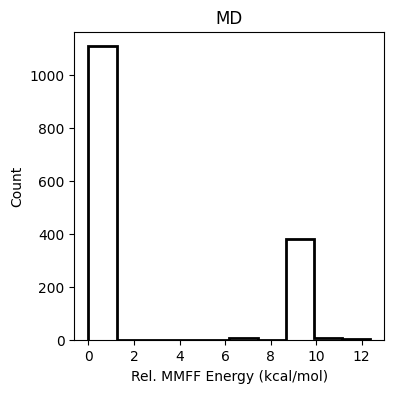

CPU times: user 361 ms, sys: 1.12 s, total: 1.48 s
Wall time: 194 ms


In [21]:
%%time

fig = plt.figure(figsize=(4, 4))

### Plot the relative energy distribution for conformers with feasible geometries
n_bins=10
plt.hist(rel_energy_DF['rel_energy_in_kcalpermol'], bins=n_bins, density=False, color='black', histtype='step', fill=False, lw=2)
#density=False: If True, the histogram is normalized so that the area under the histogram integrates to 1. If False, the histogram represents the count of occurrences in each bin.
#'bar': Traditional bar histogram (default)
plt.xlabel('Rel. MMFF Energy (kcal/mol)')
plt.ylabel('Count')
plt.title('MD')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("rel_MMFF_energies-count_histogram", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Calculating RMSD Matrix**

Using Open Babel obrms command to calculate the Root Mean Square Deviation (RMSD) between the feasiable geometries present in an SDF file

In [22]:
%%time

### Run obrms on the concatenated sdf file of conformers with feasible geometries to compute RMSD matrix
calculate_rmsd(feasible_geometries_sdf,pairwise_RMSDs_dat)

RMSD calculation completed and appended to rmsd_matrix-mx_flags.dat.
CPU times: user 2.6 ms, sys: 10.3 ms, total: 12.9 ms
Wall time: 24 s


In [23]:
%%time

from scipy.spatial.distance import squareform, is_valid_dm

### Read the pairwise RMSD matrix from the output of obrms; it is supposed to be a hollow, asymmetric matrix
rmsd_matrix_DF: pd.DataFrame = pd.read_csv(pairwise_RMSDs_dat, header=None, index_col=0)

### Convert the pairwise RMSD matrix into a numpy float-type 2D array
rmsd_matrix: np.ndarray = rmsd_matrix_DF.to_numpy(dtype=float)

### Round the matrix elements to two decimal places to avoid possible asymmetry in the matrix due to insignificant numerical errors
rmsd_matrix_2DP: np.ndarray  = np.round(rmsd_matrix, 2)

# Force the matrix to be symmetric
rmsd_matrix_2DP = (rmsd_matrix_2DP + rmsd_matrix_2DP.T) / 2

# Check if the matrix is symmetric
if not is_valid_dm(rmsd_matrix_2DP, throw=False):
    raise ValueError("The provided RMSD matrix is not symmetric even after rounding and forcing symmetry.")

CPU times: user 1.68 s, sys: 99.2 ms, total: 1.78 s
Wall time: 551 ms


In [24]:
%%time

### Convert the the pairwise distance matrix to its condensed form; write the pairwise RMSDs from the condensed matrix into a CSV file
from scipy.spatial.distance import squareform
condensed_matrix: np.ndarray  = squareform(rmsd_matrix_2DP)
pairwise_RMSDs_DF: pd.DataFrame = pd.DataFrame(condensed_matrix)
pairwise_RMSDs_DF.to_csv(pairwise_RMSDs_csv, header=['pairwise_RMSD'], index=False)

CPU times: user 607 ms, sys: 54.9 ms, total: 661 ms
Wall time: 661 ms


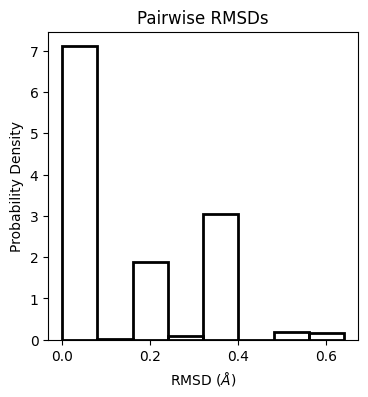

CPU times: user 421 ms, sys: 1.08 s, total: 1.5 s
Wall time: 244 ms


In [25]:
%%time

### Plot the distribution of pairwise RMSDs
fig = plt.figure(figsize=(4, 4))

### Plot the histograms
plt.hist(condensed_matrix, bins=8, density=True, color='black', fill=False, lw=2)

### Format the axes
plt.xlabel(r'RMSD ($\AA)$')
plt.ylabel('Probability Density')
plt.title('Pairwise RMSDs')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("pairwise_rmsd_distribution-PD.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Hierarchical Cluster**

Clustering the generated conformers into 20 clusters using hierarchical clustering with `ward` linkage method. 

In [26]:
%%time

### Perform hierarchical clustering with 'ward' linkage method on the condensed version of pairwise distance matrix
import scipy.cluster.hierarchy as sch
linkage_matrix_ward: np.ndarray = sch.linkage(condensed_matrix, method='ward')

CPU times: user 20.4 ms, sys: 863 µs, total: 21.3 ms
Wall time: 23.9 ms


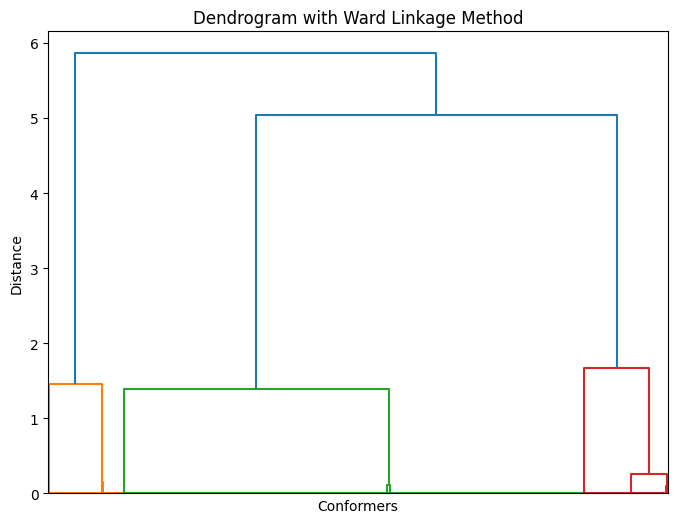

CPU times: user 206 ms, sys: 164 ms, total: 370 ms
Wall time: 184 ms


In [27]:
%%time

### A few settings to export the image of the plot
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))

### Plot the dendrogram to visualize the hierarchical clustering structure
sch.dendrogram(linkage_matrix_ward, no_labels=True)
plt.title('Dendrogram with Ward Linkage Method')
plt.xlabel('Conformers')
plt.ylabel('Distance')

### Show the plot
plt.show()

### Save figure
fig.savefig("hierarchical_clustering_dendogram-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

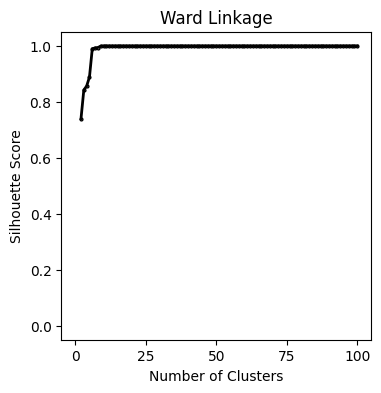

The optimal number of clusters is 10 with a silhouette score of 0.9993328885923949
CPU times: user 1.94 s, sys: 227 ms, total: 2.16 s
Wall time: 2.09 s


In [28]:
%%time

### A few settings to export the image of the plot
# plt.style.use('~/matplotlib_templates/single_column.mplstyle')
fig = plt.figure(figsize=(4, 4))

### Determine the optimal number of clusters using silhouette score; the original pairwise RMSD matrix must be used for this
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from collections import Counter


## Calculate silhouette score for different numbers of clusters
sil_scores = []
range_n_clusters = list(range(2, 101))     # Try different numbers of clusters
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')
    cluster_counts = Counter(cluster_labels)
    # print(cluster_counts)
    
    # Check if the clustering resulted in more than one cluster
    if len(cluster_counts) > 1:
        sil_score = silhouette_score(rmsd_matrix_2DP, cluster_labels, metric='precomputed')
        sil_scores.append(sil_score)
    else:
        sil_scores.append(float('-inf'))  # Append a very low score if there's only one cluster    


## Plot the Silhouette scores
plt.plot(range_n_clusters, sil_scores, marker='o', color='black', fillstyle='none', ms=2, lw=2)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Ward Linkage")
plt.axis([-5, 105, -0.05, 1.05])
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

### Show the plot
plt.show()

### Save figure
fig.savefig("silhouette_score_vs_num_clust-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## Find the optimal number of clusters based on the maximum value of silhouette score and printing it
max_sil_score = np.max(sil_scores)
optimal_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"The optimal number of clusters is {optimal_clusters} with a silhouette score of {max_sil_score}")

In [29]:
%%time

from scipy.cluster.hierarchy import linkage, fcluster

num_clusters = 5 if optimal_clusters > 5 else optimal_clusters

## For each conformer, assign the cluster label to which it belongs
cluster_labels: np.ndarray = fcluster(linkage_matrix_ward, num_clusters, criterion='maxclust')

## Create an empty dictionary to store the cluster sets
clusters: Dict[int, List[int]] = {i: [] for i in range(1, num_clusters + 1)}

## Assign each cluster label to the respective cluster set
for index, label in enumerate(cluster_labels):
    clusters[label].append(index)     # Store the indices instead of raw data
    

CPU times: user 4.3 ms, sys: 1.07 ms, total: 5.37 ms
Wall time: 5.3 ms


## **Step 5: Identifying Cluster Representative**

Identifying the minimum energy conformer within each cluster as its representative

In [30]:
%%time

### Identify the minimum energy conformer within each cluster as its representative

## Loop over all the cluster sets
cluster_reps_list: List[pd.DataFrame] = []

for clust_label, clust_elements in clusters.items():
    if len(clust_elements)!=0:
        clust_DF: pd.DataFrame = rel_energy_DF.loc[clust_elements]     # Extract the relative energies of the cluster elements into a dataframe
        min_energy_index: int = clust_DF['rel_energy_in_kcalpermol'].idxmin()     # Find the row index correspoding to the minimum relative energy conformer within the cluster 
        min_energy_DF: pd.DataFrame= clust_DF.loc[[min_energy_index]]     # Isolate the repesentative conformer's relative energy into a dataframe
        min_energy_DF['cluster_id'] = clust_label     # Add the 'cluster ID' information to the above dataframe
        # print(min_energy_DF)
        cluster_reps_list.append(min_energy_DF)     # Append the dataframe corresponding to each cluster representative into a list of dataframes

## Concatenate the dataframes of all cluster representatives into a single dataframe
cluster_reps_DF: pd.DataFrame = pd.concat(cluster_reps_list, ignore_index=True)

## Sort the cluster respresentatives samples by 'conformer_id' and save the sorted dataframe to a csv file
sorted_cluster_reps_DF: pd.DataFrame = cluster_reps_DF.sort_values(by='conformer_id', ascending=True)
sorted_cluster_reps_DF.to_csv(cluster_reps_csv, index=False)

CPU times: user 9.82 ms, sys: 0 ns, total: 9.82 ms
Wall time: 10.4 ms


In [31]:
%%time

###  Write the coordinates of cluster representative conformers to SDF files.
write_cluster_representatives(opt_conf_sdf,cluster_reps_dir,cluster_reps_sdf,sorted_cluster_reps_DF,cluster_reps_DF,cluster_rep_prefix,conf_extension)



Completed Writing the SDF files of cluster representative conformers
CPU times: user 233 ms, sys: 9.95 ms, total: 243 ms
Wall time: 243 ms


# Step 7: Geometry optimization of neutral conformers using DFT

In [32]:
!python /app/dft_main.py DFT {cluster_reps_dir} {dielectric_value} 

Found 5 SDF files in cluster_rep_conformers
Basis sets: ['aug-cc-pVDZ']
XC functionals: ['M06-2X']
Dielectric constant: 35.7
#INFO: **** input file is /app/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer = mol.GetConformer()

        # Extract atomic symbols and coordinates
        atom_list = []

    dft_obj = DFTClass(sdf_path, dielectric_value)
        atom_list = dft_obj.get_atom_list()

        for basis in basis_sets:
            for xc in xc_functionals:
                start_time_sub = time.time()

                # Use the chosen charge method
                if mode == 'deproto':
                    charge_dft = dft_obj.get_charge(cluster_reps_dir)
                else:
                    charge_dft = dft_obj.extract_charge_info()

                # Build molecule with given basis
                mol1 = gto.M(
                    atom=atom_list,
                    basis=basis,
                    charge =charge_dft,
                    spin=0,
                    verbose=4,
                )

                # Sanitize names for filename safety
                basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
                xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+

System: uname_result(system='Linux', node='681e7d8e92fa', release='6.8.0-63-generic', version='#66-Ubuntu SMP PREEMPT_DYNAMIC Fri Jun 13 20:25:30 UTC 2025', machine='x86_64')  Threads 15
Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
numpy 1.26.4  scipy 1.13.1  h5py 3.12.1
Date: Sat Jul 26 06:19:09 2025
PySCF version 2.7.0
PySCF path  /opt/conda/lib/python3.9/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.3.0
    CUDA Path /usr/local/cuda
    CUDA Build Version 12060
    CUDA Driver Version 12080
    CUDA Runtime Version 12060
CUDA toolkit
    cuSolver (11, 7, 2)
    cuBLAS 120803
    cuTENSOR 20002
Device info
    Device name b'Tesla V100S-PCIE-32GB'
    Device global memory 31.73 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.3.1
GPU4PySCF path  /opt/conda/lib/python3.9/site-packages/gpu4pyscf_cuda12x-1.3.1-py3.9.egg/gpu4pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 16
[INPUT] num. electron

48 internal coordinates being used (instead of 48 Cartesians)
Internal coordinate system (atoms numbered from 1):
Distance 1-2
Distance 2-3
Distance 2-4
Distance 3-11
Distance 4-5
Distance 4-9
Distance 5-6
Distance 5-12
Distance 6-7
Distance 6-13
Distance 7-8
Distance 7-14
Distance 8-9
Distance 8-15
Distance 9-10
Distance 10-16
Angle 1-2-4
Angle 3-2-4
Angle 2-3-11
Angle 2-4-9
Angle 5-4-9
Angle 4-5-12
Angle 6-5-12
Angle 5-6-13
Angle 7-6-13
Angle 6-7-14
Angle 8-7-14
Angle 7-8-15
Angle 9-8-15
Angle 4-9-10
Angle 8-9-10
Angle 9-10-16
Out-of-Plane 2-1-3-4
Out-of-Plane 4-2-5-9
Out-of-Plane 5-4-6-12
Out-of-Plane 6-5-7-13
Out-of-Plane 7-6-8-14
Out-of-Plane 8-7-9-15
Out-of-Plane 9-4-8-10
Dihedral 1-2-3-11
Dihedral 4-2-3-11
Dihedral 1-2-4-5
Dihedral 1-2-4-9
Dihedral 3-2-4-5
Dihedral 3-2-4-9
Dihedral 2-4-5-6
Dihedral 2-4-5-12
Dihedral 9-4-5-6
Dihedral 9-4-5-12
Dihedral 2-4-9-8
Dihedral 2-4-9-10
Dihedral 5-4-9-8
Dihedral 5-4-9-10
Dihedral 4-5-6-7
Dihedral 4-5-6-13
Dihedral 12-5-6-7
Dihedral 12-5-6-

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.00036693087659228
Solvent Energy = -0.00036693087659228
init E= -498.173355350414


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0334750643620352
Solvent Energy = -0.0334750643620352
cycle= 1 E= -495.764657616554  delta_E= 2.41  |ddm|= 44.7


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0196519129778284
Solvent Energy = -0.0196519129778284
cycle= 2 E= -495.652162566037  delta_E= 0.112  |ddm|= 8.33


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211594867313642
Solvent Energy = -0.0211594867313642
cycle= 3 E= -495.946651362111  delta_E= -0.294  |ddm|= 3.55


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217141255262313
Solvent Energy = -0.0217141255262313
cycle= 4 E= -495.94915998927  delta_E= -0.00251  |ddm|= 0.749


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217618619795027
Solvent Energy = -0.0217618619795027
cycle= 5 E= -495.950370432224  delta_E= -0.00121  |ddm|= 0.31


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021587058522055
Solvent Energy = -0.021587058522055
cycle= 6 E= -495.950418780423  delta_E= -4.83e-05  |ddm|= 0.122


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216105632192888
Solvent Energy = -0.0216105632192888
cycle= 7 E= -495.950424893728  delta_E= -6.11e-06  |ddm|= 0.0331


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215980294127104
Solvent Energy = -0.0215980294127104
cycle= 8 E= -495.950425507421  delta_E= -6.14e-07  |ddm|= 0.0104


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021597928450628
Solvent Energy = -0.021597928450628
cycle= 9 E= -495.950425630173  delta_E= -1.23e-07  |ddm|= 0.00407


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215948120909773
Solvent Energy = -0.0215948120909773
cycle= 10 E= -495.950425638669  delta_E= -8.5e-09  |ddm|= 0.00144
converged SCF energy = -495.950425638669


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1283 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0066745192    -0.0027909990    -0.0045634114
1 C    -0.0109228979     0.0041001104    -0.0022654319
2 O    -0.0061133830    -0.0011125524     0.0112465066
3 C     0.0031756937     0.0033191832     0.0063765259
4 C     0.0096774508    -0.0022390690    -0.0019804867
5 C    -0.0046284488     0.0033281556     0.0023020151
6 C    -0.0046755215    -0.0048032679    -0.0005543858
7 C     0.0060859860     0.0123200909     0.0034239402
8 C     0.0064183346    -0.0127122412    -0.0089105656
9 O    -0.0029375444     0.0057225799     0.0008338554
10 H     0.0016911603    -0.0021865372    -0.0072783210
11 H    -0.0021526174    -0.0013276826    -0.0000486352
12 H    -0.0000939066     0.0008695084     0.0001004237
13 H     0.0011398725    -0.0006867680    -0.0007522863
14 H    -0.0015152441    -0.0042588161    -0.0011860922
15 H    -0.0017885521     0.0024458442     0.0032473284
---


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.493842  -0.334345  -1.676646   -0.019258 -0.026045  0.010954
   C   2.012992   0.063310  -0.635132    0.010892 -0.024990  0.020068
   O   2.719775   0.726710   0.296700   -0.015125  0.078410 -0.025400
   C   0.579557  -0.112659  -0.277056   -0.005543 -0.023059  0.005144
   C  -0.057186  -1.309832  -0.629419   -0.038186 -0.004132  0.003481
   C  -1.385716  -1.576346  -0.318222   -0.031616 -0.029346 -0.012022
   C  -2.097468  -0.575713   0.348998   -0.004568 -0.003913 -0.013502
   C  -1.503019   0.637060   0.689326    0.000681 -0.012740 -0.007574
   C  -0.159220   0.877988   0.383411    0.008280 -0.016012  0.014711
   O   0.439884   2.064906   0.670699    0.064184 -0.050194  0.016299
   H   3.635159   0.823108  -0.020523   -0.002141  0.128208  0.031277
   H   0.528672  -2.062085  -1.154628   -0.025128  0.005815  0.002972
   H  -1.849297  -2.523215  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216768163755673
Solvent Energy = -0.0216768163755673
init E= -495.990310780147


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216134675146476
Solvent Energy = -0.0216134675146476
cycle= 1 E= -495.95043625931  delta_E= 0.0399  |ddm|= 3.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218244867819405
Solvent Energy = -0.0218244867819405
cycle= 2 E= -495.950856940065  delta_E= -0.000421  |ddm|= 0.698


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217250856431745
Solvent Energy = -0.0217250856431745
cycle= 3 E= -495.951422906459  delta_E= -0.000566  |ddm|= 0.39


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217112827889348
Solvent Energy = -0.0217112827889348
cycle= 4 E= -495.951461111712  delta_E= -3.82e-05  |ddm|= 0.0701


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217017322003227
Solvent Energy = -0.0217017322003227
cycle= 5 E= -495.951470771996  delta_E= -9.66e-06  |ddm|= 0.0338


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217202122057106
Solvent Energy = -0.0217202122057106
cycle= 6 E= -495.951472023969  delta_E= -1.25e-06  |ddm|= 0.00893


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217115735436535
Solvent Energy = -0.0217115735436535
cycle= 7 E= -495.951472225942  delta_E= -2.02e-07  |ddm|= 0.00306


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217119952161499
Solvent Energy = -0.0217119952161499
cycle= 8 E= -495.95147227952  delta_E= -5.36e-08  |ddm|= 0.00192


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217125967775375
Solvent Energy = -0.0217125967775375
cycle= 9 E= -495.951472285435  delta_E= -5.92e-09  |ddm|= 0.000811
converged SCF energy = -495.951472285435


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1405 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0022446059     0.0021300854    -0.0036818175
1 C     0.0004166207    -0.0068047916     0.0021537110
2 O    -0.0010450704     0.0048418932     0.0046922892
3 C     0.0020341697     0.0024225995    -0.0021075528
4 C    -0.0045952834     0.0065807401     0.0045994139
5 C    -0.0043542167    -0.0085086506    -0.0016873818
6 C     0.0044085524     0.0006661202    -0.0012858926
7 C     0.0014395811     0.0011483524    -0.0000455477
8 C    -0.0001878555    -0.0031876523    -0.0018185513
9 O     0.0037939792     0.0028920877    -0.0012462463
10 H     0.0017278422     0.0008773318     0.0001640363
11 H    -0.0014798697     0.0002501776     0.0004934850
12 H    -0.0004560000    -0.0008802612    -0.0002341848
13 H     0.0005420811    -0.0006632659    -0.0005259639
14 H    -0.0004470851    -0.0004366996     0.0000146010
15 H     0.0004560549    -0.0013124002     0.0005153151
---

Hessian Eigenvalues: 2.03287e-02 2.30000e-02 2.30001e-02 ... 5.34037e-01 5.92968e-01 9.55023e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.482998  -0.394697  -1.656462   -0.010844 -0.060352  0.020183
   C   2.009439   0.057833  -0.636959   -0.003553 -0.005477 -0.001827
   O   2.760801   0.717884   0.256234    0.041026 -0.008826 -0.040466
   C   0.570899  -0.096087  -0.261278   -0.008659  0.016573  0.015778
   C  -0.030639  -1.301815  -0.637289    0.026547  0.008017 -0.007871
   C  -1.359170  -1.542865  -0.316707    0.026546  0.033482  0.001515
   C  -2.115548  -0.573763   0.352499   -0.018080  0.001950  0.003502
   C  -1.531911   0.637915   0.700082   -0.028892  0.000854  0.010756
   C  -0.185385   0.885374   0.406019   -0.026165  0.007386  0.022608
   O   0.408462   2.067753   0.700049   -0.031421  0.002847  0.029350
   H   3.677670   0.770471  -0.057914    0.042512 -0.052637 -0.037391
   H   0.570054  -2.043503  -1.163509    0.041382  0.018582 -0.008881
   H  -1.812546  -2.492365  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0221370044674028
Solvent Energy = -0.0221370044674028
init E= -495.971562520485


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216769926821437
Solvent Energy = -0.0216769926821437
cycle= 1 E= -495.951098006828  delta_E= 0.0205  |ddm|= 4.69


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0220554970385622
Solvent Energy = -0.0220554970385622
cycle= 2 E= -495.951392504632  delta_E= -0.000294  |ddm|= 0.774


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218196948864066
Solvent Energy = -0.0218196948864066
cycle= 3 E= -495.95191445915  delta_E= -0.000522  |ddm|= 0.289


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218278682318915
Solvent Energy = -0.0218278682318915
cycle= 4 E= -495.951961972793  delta_E= -4.75e-05  |ddm|= 0.0674


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218636497690979
Solvent Energy = -0.0218636497690979
cycle= 5 E= -495.951965892672  delta_E= -3.92e-06  |ddm|= 0.0208


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218465954163534
Solvent Energy = -0.0218465954163534
cycle= 6 E= -495.951966910564  delta_E= -1.02e-06  |ddm|= 0.00899


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218498676712613
Solvent Energy = -0.0218498676712613
cycle= 7 E= -495.951966944831  delta_E= -3.43e-08  |ddm|= 0.00182


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218490845865137
Solvent Energy = -0.0218490845865137
cycle= 8 E= -495.951966956252  delta_E= -1.14e-08  |ddm|= 0.0011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218493524360213
Solvent Energy = -0.0218493524360213
cycle= 9 E= -495.951966957054  delta_E= -8.02e-10  |ddm|= 0.000341
converged SCF energy = -495.951966957054


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1420 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000224390     0.0040290434     0.0032277133
1 C    -0.0031009057    -0.0067017260    -0.0015402242
2 O     0.0061391087    -0.0011139074    -0.0048960779
3 C    -0.0060171558    -0.0007266904     0.0003846383
4 C     0.0026997783    -0.0031634999    -0.0028305946
5 C     0.0052073247     0.0061194184     0.0015331140
6 C    -0.0038430049     0.0007306790     0.0015649525
7 C    -0.0004656492    -0.0039567007    -0.0023551830
8 C    -0.0035333921     0.0033510608     0.0032287991
9 O     0.0008814682     0.0006406679    -0.0013461359
10 H     0.0006015265     0.0017879144     0.0030856617
11 H     0.0013080246    -0.0003305719    -0.0003995553
12 H     0.0007665169     0.0003163822    -0.0000123163
13 H    -0.0011184733     0.0004904246     0.0006314601
14 H    -0.0003145627     0.0007400089     0.0004335425
15 H     0.0007925646    -0.0021958897    -0.0007038592
---


Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.488950  -0.423324  -1.646126    0.005952 -0.028627  0.010337
   C   2.009968   0.072090  -0.647286    0.000529  0.014257 -0.010327
   O   2.741504   0.731231   0.258499   -0.019297  0.013347  0.002265
   C   0.577964  -0.092055  -0.266206    0.007065  0.004032 -0.004928
   C  -0.033414  -1.298090  -0.633514   -0.002774  0.003726  0.003775
   C  -1.363168  -1.553879  -0.322897   -0.003998 -0.011014 -0.006189
   C  -2.100430  -0.574448   0.349350    0.015119 -0.000685 -0.003150
   C  -1.520942   0.639049   0.703571    0.010970  0.001134  0.003489
   C  -0.176763   0.888110   0.403648    0.008622  0.002736 -0.002370
   O   0.403628   2.075142   0.708926   -0.004834  0.007389  0.008877
   H   3.657742   0.758983  -0.061619   -0.019928 -0.011488 -0.003705
   H   0.564572  -2.038979  -1.162415   -0.005482  0.004525  0.001094
   H  -1.821359  -2.500723  -0.6

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217499659721184
Solvent Energy = -0.0217499659721184
init E= -495.958023845241


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217695700724653
Solvent Energy = -0.0217695700724653
cycle= 1 E= -495.952332054998  delta_E= 0.00569  |ddm|= 2.25


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215941937364679
Solvent Energy = -0.0215941937364679
cycle= 2 E= -495.952429682527  delta_E= -9.76e-05  |ddm|= 0.273


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021733053949363
Solvent Energy = -0.021733053949363
cycle= 3 E= -495.952482699607  delta_E= -5.3e-05  |ddm|= 0.0857


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216802096625733
Solvent Energy = -0.0216802096625733
cycle= 4 E= -495.952491161742  delta_E= -8.46e-06  |ddm|= 0.0268


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216923482889011
Solvent Energy = -0.0216923482889011
cycle= 5 E= -495.952491914723  delta_E= -7.53e-07  |ddm|= 0.0081


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216919667733646
Solvent Energy = -0.0216919667733646
cycle= 6 E= -495.952492154578  delta_E= -2.4e-07  |ddm|= 0.00441


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216914794391625
Solvent Energy = -0.0216914794391625
cycle= 7 E= -495.952492162481  delta_E= -7.9e-09  |ddm|= 0.000956
converged SCF energy = -495.952492162481


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0016147318    -0.0015898310     0.0009394748
1 C     0.0022802017     0.0045418041    -0.0042199314
2 O     0.0002479830    -0.0018862386     0.0017466131
3 C     0.0002059865    -0.0018424476     0.0011751544
4 C     0.0006595233    -0.0000468694     0.0005688395
5 C    -0.0004547074    -0.0006682691    -0.0004481592
6 C     0.0017029490     0.0002778627    -0.0002848895
7 C    -0.0007324156     0.0006831758     0.0000155068
8 C    -0.0009371246     0.0002563117     0.0003819007
9 O    -0.0006960661     0.0002933917    -0.0004808703
10 H    -0.0011512671    -0.0002796134     0.0001757654
11 H     0.0001240636    -0.0001662633    -0.0000463013
12 H     0.0000778303    -0.0001309185    -0.0001370545
13 H     0.0001299561     0.0001448825     0.0000857019
14 H     0.0000154247     0.0003547576     0.0001524710
15 H     0.0001737489     0.0000686878     0.0003641130
---

Hessian Eigenvalues: 1.73180e-02 2.28254e-02 2.30001e-02 ... 5.59730e-01 6.80451e-01 9.56587e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.522440  -0.431845  -1.621316    0.033490 -0.008521  0.024809
   C   2.017859   0.060800  -0.632697    0.007891 -0.011290  0.014589
   O   2.729760   0.775449   0.245058   -0.011744  0.044218 -0.013441
   C   0.584313  -0.108716  -0.265739    0.006349 -0.016662  0.000467
   C  -0.044389  -1.307257  -0.631950   -0.010976 -0.009168  0.001564
   C  -1.377802  -1.553266  -0.325315   -0.014634  0.000614 -0.002418
   C  -2.112055  -0.572239   0.346361   -0.011625  0.002209 -0.002988
   C  -1.512256   0.631726   0.701393    0.008686 -0.007323 -0.002177
   C  -0.165775   0.872962   0.403970    0.010987 -0.015148  0.000322
   O   0.420055   2.054113   0.722219    0.016426 -0.021029  0.013293
   H   3.642692   0.816016  -0.086204   -0.015050  0.057033 -0.024585
   H   0.544552  -2.054319  -1.161377   -0.020020 -0.015341  0.001038
   H  -1.842870  -2.495634  -0.6

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214474666774308
Solvent Energy = -0.0214474666774308
init E= -495.95878294609


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215878265772996
Solvent Energy = -0.0215878265772996
cycle= 1 E= -495.952415052055  delta_E= 0.00637  |ddm|= 1.14


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216290973087755
Solvent Energy = -0.0216290973087755
cycle= 2 E= -495.95255416623  delta_E= -0.000139  |ddm|= 0.321


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021650061055724
Solvent Energy = -0.021650061055724
cycle= 3 E= -495.952640674161  delta_E= -8.65e-05  |ddm|= 0.149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021618513767873
Solvent Energy = -0.021618513767873
cycle= 4 E= -495.952647565371  delta_E= -6.89e-06  |ddm|= 0.0334


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216375050820063
Solvent Energy = -0.0216375050820063
cycle= 5 E= -495.952648669265  delta_E= -1.1e-06  |ddm|= 0.00941


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216321218307227
Solvent Energy = -0.0216321218307227
cycle= 6 E= -495.952648914814  delta_E= -2.46e-07  |ddm|= 0.00359


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216323298879533
Solvent Energy = -0.0216323298879533
cycle= 7 E= -495.952648954426  delta_E= -3.96e-08  |ddm|= 0.00173


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216320310954457
Solvent Energy = -0.0216320310954457
cycle= 8 E= -495.95264896737  delta_E= -1.29e-08  |ddm|= 0.000951


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216322287436311
Solvent Energy = -0.0216322287436311
cycle= 9 E= -495.952648968266  delta_E= -8.96e-10  |ddm|= 0.000269
converged SCF energy = -495.952648968266


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0009061480     0.0016844623     0.0005997892
1 C     0.0004804868     0.0005978891     0.0002840137
2 O    -0.0006965774    -0.0006619613    -0.0000396841
3 C     0.0010357990    -0.0002073284    -0.0003080700
4 C    -0.0006601854     0.0004587767     0.0013965701
5 C    -0.0010100032     0.0000654764     0.0002921805
6 C    -0.0014723059    -0.0010869100    -0.0000365018
7 C     0.0014533539     0.0000660526    -0.0003672903
8 C     0.0001691453    -0.0009429631    -0.0012919431
9 O     0.0004560485    -0.0002462439    -0.0004921367
10 H    -0.0002258355    -0.0002905623    -0.0005903253
11 H    -0.0002714608     0.0002574709     0.0001235363
12 H    -0.0002876722     0.0001288365     0.0001241571
13 H     0.0000278183    -0.0001012312    -0.0000829211
14 H     0.0000758828    -0.0003608778    -0.0001923117
15 H     0.0000446723     0.0006484896     0.0005831216
---

Hessian Eigenvalues: 1.20209e-02 2.26251e-02 2.30001e-02 ... 6.32186e-01 6.77562e-01 9.57638e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.510255  -0.488780  -1.598859   -0.012185 -0.056935  0.022458
   C   2.016462   0.041173  -0.623576   -0.001397 -0.019627  0.009121
   O   2.729446   0.800459   0.215513   -0.000315  0.025010 -0.029545
   C   0.581716  -0.105714  -0.253279   -0.002597  0.003003  0.012459
   C  -0.039246  -1.304035  -0.632463    0.005144  0.003223 -0.000512
   C  -1.372962  -1.550553  -0.333032    0.004840  0.002713 -0.007717
   C  -2.107077  -0.569072   0.339298    0.004978  0.003168 -0.007063
   C  -1.516106   0.634769   0.707041   -0.003850  0.003043  0.005648
   C  -0.167360   0.876755   0.418499   -0.001585  0.003794  0.014529
   O   0.418506   2.053741   0.747820   -0.001548 -0.000371  0.025601
   H   3.642901   0.830576  -0.116039    0.000209  0.014560 -0.029835
   H   0.555334  -2.046566  -1.162341    0.010782  0.007753 -0.000964
   H  -1.837770  -2.491357  -0.6

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021732521011912
Solvent Energy = -0.021732521011912
init E= -495.949123424002


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215873822029993
Solvent Energy = -0.0215873822029993
cycle= 1 E= -495.952628274618  delta_E= -0.0035  |ddm|= 1.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217007597164073
Solvent Energy = -0.0217007597164073
cycle= 2 E= -495.952746829265  delta_E= -0.000119  |ddm|= 0.234


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216164658023832
Solvent Energy = -0.0216164658023832
cycle= 3 E= -495.952800584009  delta_E= -5.38e-05  |ddm|= 0.11


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216331206513179
Solvent Energy = -0.0216331206513179
cycle= 4 E= -495.952810256716  delta_E= -9.67e-06  |ddm|= 0.0317


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216453126228334
Solvent Energy = -0.0216453126228334
cycle= 5 E= -495.952811306734  delta_E= -1.05e-06  |ddm|= 0.0101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216361441679958
Solvent Energy = -0.0216361441679958
cycle= 6 E= -495.952811593983  delta_E= -2.87e-07  |ddm|= 0.00457


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216390918070208
Solvent Energy = -0.0216390918070208
cycle= 7 E= -495.952811614052  delta_E= -2.01e-08  |ddm|= 0.00108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216384024802198
Solvent Energy = -0.0216384024802198
cycle= 8 E= -495.952811620214  delta_E= -6.16e-09  |ddm|= 0.000594
converged SCF energy = -495.952811620214


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0006638591     0.0016522577    -0.0010698244
1 C     0.0014578451    -0.0034503415     0.0019640896
2 O    -0.0011243157     0.0003423497    -0.0001398450
3 C    -0.0014973055     0.0012761659     0.0002220308
4 C     0.0012894237     0.0000573951     0.0000360289
5 C    -0.0006742912    -0.0003685661     0.0001704612
6 C     0.0009008516    -0.0002320824    -0.0004326478
7 C    -0.0001418364     0.0004614710     0.0004156491
8 C    -0.0002214018     0.0004361568    -0.0005273971
9 O     0.0001575532    -0.0001985942    -0.0002230970
10 H     0.0001988717    -0.0000052066    -0.0002917146
11 H    -0.0000649312    -0.0001186542    -0.0000868056
12 H     0.0000340621    -0.0000544829    -0.0000041457
13 H     0.0001546843    -0.0000097161    -0.0000951282
14 H     0.0001615402     0.0000356254    -0.0000401492
15 H     0.0000674265     0.0001737300     0.0000933726
---


Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.520135  -0.562038  -1.552766    0.009880 -0.073258  0.046092
   C   2.018259   0.037368  -0.622363    0.001797 -0.003805  0.001213
   O   2.730724   0.842696   0.173843    0.001278  0.042237 -0.041670
   C   0.582944  -0.102295  -0.248791    0.001228  0.003419  0.004489
   C  -0.040716  -1.297322  -0.635191   -0.001470  0.006712 -0.002729
   C  -1.373980  -1.544957  -0.340578   -0.001018  0.005596 -0.007547
   C  -2.111886  -0.568156   0.335928   -0.004809  0.000915 -0.003370
   C  -1.518496   0.630749   0.711608   -0.002390 -0.004021  0.004567
   C  -0.167767   0.875842   0.430255   -0.000407 -0.000914  0.011756
   O   0.415299   2.048387   0.774619   -0.003207 -0.005355  0.026800
   H   3.649314   0.848891  -0.143622    0.006413  0.018315 -0.027583
   H   0.556091  -2.036054  -1.167849    0.000757  0.010512 -0.005508
   H  -1.837294  -2.484402  -0.6

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213392905337512
Solvent Energy = -0.0213392905337512
init E= -495.950496663752


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217448974725533
Solvent Energy = -0.0217448974725533
cycle= 1 E= -495.952679428413  delta_E= -0.00218  |ddm|= 1.53


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214473976005939
Solvent Energy = -0.0214473976005939
cycle= 2 E= -495.952905986126  delta_E= -0.000227  |ddm|= 0.259


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216455630686215
Solvent Energy = -0.0216455630686215
cycle= 3 E= -495.952961260193  delta_E= -5.53e-05  |ddm|= 0.0652


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215841039877015
Solvent Energy = -0.0215841039877015
cycle= 4 E= -495.952976370928  delta_E= -1.51e-05  |ddm|= 0.0323


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215887433713144
Solvent Energy = -0.0215887433713144
cycle= 5 E= -495.952978182494  delta_E= -1.81e-06  |ddm|= 0.0102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215893149126233
Solvent Energy = -0.0215893149126233
cycle= 6 E= -495.952978419899  delta_E= -2.37e-07  |ddm|= 0.0043


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215894041214811
Solvent Energy = -0.0215894041214811
cycle= 7 E= -495.952978454044  delta_E= -3.41e-08  |ddm|= 0.00148


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215897455359667
Solvent Energy = -0.0215897455359667
cycle= 8 E= -495.952978461241  delta_E= -7.2e-09  |ddm|= 0.000801
converged SCF energy = -495.952978461241


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0006264862    -0.0000314516    -0.0002179780
1 C    -0.0003440874     0.0003549371     0.0000466274
2 O     0.0007494886    -0.0010174184    -0.0006384557
3 C    -0.0012005840    -0.0006780938     0.0002002552
4 C     0.0005663991     0.0002360114     0.0000553638
5 C     0.0004680691     0.0001060020     0.0000046031
6 C     0.0001513712     0.0002128049     0.0000202977
7 C    -0.0003175872    -0.0011095926    -0.0004429758
8 C    -0.0003982248     0.0021768723     0.0008039461
9 O     0.0000703203    -0.0004328056     0.0000630486
10 H     0.0004939367     0.0005113519     0.0005996791
11 H     0.0002484088    -0.0000892057    -0.0001056274
12 H     0.0000588332    -0.0000413359     0.0000215835
13 H    -0.0001325956     0.0000121845     0.0000445455
14 H     0.0001622995     0.0002844682     0.0000453211
15 H     0.0000768480    -0.0004964260    -0.0005507229
---

Hessian Eigenvalues: 3.42144e-03 2.24087e-02 2.29918e-02 ... 6.79565e-01 7.76361e-01 9.58749e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.554231  -0.650765  -1.471613    0.034096 -0.088727  0.081154
   C   2.024926   0.025134  -0.610240    0.006667 -0.012233  0.012123
   O   2.709263   0.916440   0.115758   -0.021461  0.073743 -0.058085
   C   0.587943  -0.110556  -0.245210    0.004998 -0.008261  0.003581
   C  -0.043442  -1.300206  -0.640809   -0.002726 -0.002883 -0.005618
   C  -1.379212  -1.536914  -0.352571   -0.005232  0.008043 -0.011993
   C  -2.115476  -0.562077   0.329709   -0.003590  0.006080 -0.006219
   C  -1.518412   0.629407   0.719338    0.000084 -0.001342  0.007730
   C  -0.164440   0.863374   0.440370    0.003327 -0.012468  0.010115
   O   0.418493   2.028887   0.806853    0.003194 -0.019500  0.032233
   H   3.631557   0.904029  -0.189668   -0.017756  0.055138 -0.046046
   H   0.549718  -2.039748  -1.175790   -0.006373 -0.003694 -0.007941
   H  -1.848052  -2.470646  -0.6

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0210489940767549
Solvent Energy = -0.0210489940767549
init E= -495.932484895085


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216807711653828
Solvent Energy = -0.0216807711653828
cycle= 1 E= -495.952430590189  delta_E= -0.0199  |ddm|= 1.79


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212898370022857
Solvent Energy = -0.0212898370022857
cycle= 2 E= -495.952940554317  delta_E= -0.00051  |ddm|= 0.34


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021523248042896
Solvent Energy = -0.021523248042896
cycle= 3 E= -495.95309190682  delta_E= -0.000151  |ddm|= 0.118


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214534617407348
Solvent Energy = -0.0214534617407348
cycle= 4 E= -495.953114602407  delta_E= -2.27e-05  |ddm|= 0.0603


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02147311306196
Solvent Energy = -0.02147311306196
cycle= 5 E= -495.953119263801  delta_E= -4.66e-06  |ddm|= 0.0159


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214672222672641
Solvent Energy = -0.0214672222672641
cycle= 6 E= -495.953119819776  delta_E= -5.56e-07  |ddm|= 0.0059


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021469090969329
Solvent Energy = -0.021469090969329
cycle= 7 E= -495.953119925135  delta_E= -1.05e-07  |ddm|= 0.00269


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214694191500603
Solvent Energy = -0.0214694191500603
cycle= 8 E= -495.953119950003  delta_E= -2.49e-08  |ddm|= 0.00126


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214690081029387
Solvent Energy = -0.0214690081029387
cycle= 9 E= -495.953119952445  delta_E= -2.44e-09  |ddm|= 0.000553
converged SCF energy = -495.953119952445


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0004412931    -0.0011014300    -0.0003041289
1 C    -0.0000982345     0.0020859863    -0.0008160736
2 O     0.0001510508    -0.0007297352     0.0003417450
3 C     0.0004419015    -0.0009295395     0.0000476062
4 C     0.0003400887    -0.0009507987    -0.0004642845
5 C     0.0008407482     0.0010461830     0.0002385793
6 C     0.0005557780     0.0002152974    -0.0000482000
7 C    -0.0011722241     0.0007298466     0.0007763279
8 C    -0.0005442706     0.0000997198    -0.0000833274
9 O    -0.0002610170    -0.0012387245     0.0002617439
10 H     0.0000606766     0.0002928524     0.0004104604
11 H     0.0002665834    -0.0000147234    -0.0000630271
12 H     0.0001704999     0.0000268821     0.0000296496
13 H    -0.0000644744     0.0002120185     0.0001389193
14 H    -0.0001302777     0.0003451700     0.0001316763
15 H    -0.0001056650    -0.0001211544    -0.0006381914
---


Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.615971  -0.811902  -1.275788    0.061741 -0.161137  0.195825
   C   2.037104  -0.003119  -0.573369    0.012177 -0.028253  0.036871
   O   2.685288   1.036936  -0.037761   -0.023975  0.120496 -0.153520
   C   0.596000  -0.110501  -0.222484    0.008057  0.000055  0.022726
   C  -0.048325  -1.290744  -0.636656   -0.004883  0.009461  0.004153
   C  -1.388868  -1.528667  -0.379078   -0.009656  0.008248 -0.026507
   C  -2.124552  -0.557389   0.309585   -0.009076  0.004687 -0.020124
   C  -1.515796   0.618292   0.724976    0.002616 -0.011115  0.005639
   C  -0.157123   0.860473   0.469904    0.007317 -0.002901  0.029534
   O   0.409512   2.019253   0.883779   -0.008980 -0.009634  0.076926
   H   3.609979   0.971060  -0.328129   -0.021578  0.067030 -0.138460
   H   0.546907  -2.027549  -1.171697   -0.002812  0.012198  0.004093
   H  -1.859046  -2.453870  -0.7

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0203735814606629
Solvent Energy = -0.0203735814606629
init E= -495.917364826285


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0221429144423791
Solvent Energy = -0.0221429144423791
cycle= 1 E= -495.949711438315  delta_E= -0.0323  |ddm|= 4.47


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0207700716039404
Solvent Energy = -0.0207700716039404
cycle= 2 E= -495.951866664997  delta_E= -0.00216  |ddm|= 0.887


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214867238101225
Solvent Energy = -0.0214867238101225
cycle= 3 E= -495.953028858864  delta_E= -0.00116  |ddm|= 0.358


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212865697989706
Solvent Energy = -0.0212865697989706
cycle= 4 E= -495.953124072521  delta_E= -9.52e-05  |ddm|= 0.121


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213360035652848
Solvent Energy = -0.0213360035652848
cycle= 5 E= -495.953154350735  delta_E= -3.03e-05  |ddm|= 0.0412


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213263804287749
Solvent Energy = -0.0213263804287749
cycle= 6 E= -495.953157331764  delta_E= -2.98e-06  |ddm|= 0.0151


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213250298239382
Solvent Energy = -0.0213250298239382
cycle= 7 E= -495.953157866267  delta_E= -5.35e-07  |ddm|= 0.00631


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213276900632638
Solvent Energy = -0.0213276900632638
cycle= 8 E= -495.953157982663  delta_E= -1.16e-07  |ddm|= 0.00283


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213264303135467
Solvent Energy = -0.0213264303135467
cycle= 9 E= -495.95315799712  delta_E= -1.45e-08  |ddm|= 0.0013


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213263543480151
Solvent Energy = -0.0213263543480151
cycle= 10 E= -495.95315799858  delta_E= -1.46e-09  |ddm|= 0.000331
converged SCF energy = -495.95315799858


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0018446523    -0.0006010623     0.0000345630
1 C    -0.0027460293     0.0022815869    -0.0005129507
2 O     0.0014914646    -0.0015209518    -0.0007224526
3 C     0.0017106379    -0.0002606953     0.0001301850
4 C    -0.0010689091     0.0000708912     0.0002079861
5 C     0.0000464666    -0.0008859622    -0.0006321570
6 C    -0.0003228884     0.0005203765     0.0003535806
7 C     0.0003992029    -0.0008171365    -0.0001399208
8 C     0.0012448021     0.0007008285     0.0000038438
9 O    -0.0016128509     0.0008020109     0.0021012732
10 H    -0.0004224422    -0.0007164378    -0.0000955906
11 H    -0.0001789170     0.0000774842     0.0001321226
12 H    -0.0001247922    -0.0000517278     0.0001183419
13 H     0.0000413315    -0.0001734398    -0.0000671194
14 H    -0.0000003523    -0.0001896257    -0.0002204853
15 H    -0.0003568307     0.0007436688    -0.0006624952
---

Step    8 : Displace = 9.746e-02/2.607e-01 (rms/max) Trust = 3.000e-01 (+) Grad = 1.587e-03/3.607e-03 (rms/max) E (change) = -495.9531579986 (-3.805e-05) Quality = 0.197
Hessian Eigenvalues: 1.71572e-03 2.02611e-02 2.29864e-02 ... 7.11454e-01 8.84080e-01 9.61805e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.607032  -0.780517  -1.314471   -0.008939  0.031384 -0.038683
   C   2.035263   0.001270  -0.577990   -0.001840  0.004388 -0.004621
   O   2.673547   1.026681  -0.001595   -0.011741 -0.010254  0.036166
   C   0.594055  -0.116474  -0.230102   -0.001946 -0.005974 -0.007618
   C  -0.047973  -1.298375  -0.638890    0.000352 -0.007631 -0.002233
   C  -1.388827  -1.530215  -0.373908    0.000040 -0.001549  0.005171
   C  -2.124781  -0.557934   0.312736   -0.000229 -0.000545  0.003151
   C  -1.513155   0.619609   0.720420    0.002641  0.001317 -0.004556
   C  -0.155635   0.857385   0.458401    0.001488 -0.003088 -0.011503
   O   0.423344   2.015640   0.856808    0.013831 -0.003613 -0.026971
   H   3.599576   0.987993  -0.293519   -0.010403  0.016934  0.034610
   H   0.544729  -2.038417  -1.172960   -0.002178 -0.010868 -0.001263
   H  -1.860844  -2.456017  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213559456905099
Solvent Energy = -0.0213559456905099
init E= -495.950835794308


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211890552679159
Solvent Energy = -0.0211890552679159
cycle= 1 E= -495.953136927317  delta_E= -0.0023  |ddm|= 1.05


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213685175645825
Solvent Energy = -0.0213685175645825
cycle= 2 E= -495.953221521684  delta_E= -8.46e-05  |ddm|= 0.262


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212627411087548
Solvent Energy = -0.0212627411087548
cycle= 3 E= -495.953288343432  delta_E= -6.68e-05  |ddm|= 0.092


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212801503434563
Solvent Energy = -0.0212801503434563
cycle= 4 E= -495.953293991733  delta_E= -5.65e-06  |ddm|= 0.0182


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212744765385486
Solvent Energy = -0.0212744765385486
cycle= 5 E= -495.953294910725  delta_E= -9.19e-07  |ddm|= 0.0103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021276884520723
Solvent Energy = -0.021276884520723
cycle= 6 E= -495.95329505451  delta_E= -1.44e-07  |ddm|= 0.00346


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212755118421698
Solvent Energy = -0.0212755118421698
cycle= 7 E= -495.953295075295  delta_E= -2.08e-08  |ddm|= 0.00107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212754920652223
Solvent Energy = -0.0212754920652223
cycle= 8 E= -495.953295080332  delta_E= -5.04e-09  |ddm|= 0.000543
converged SCF energy = -495.953295080332


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001780760    -0.0011342892    -0.0006538313
1 C     0.0001128047     0.0009460627    -0.0001368234
2 O    -0.0009262862     0.0005975442     0.0009732115
3 C     0.0005948825     0.0002135418     0.0001362014
4 C    -0.0002101379    -0.0005548736    -0.0001158096
5 C     0.0004897574     0.0005892162     0.0000588277
6 C    -0.0015236453     0.0000291957     0.0004345644
7 C     0.0008276614    -0.0012854087    -0.0005066822
8 C     0.0006331063     0.0004472937    -0.0003378103
9 O     0.0004653613     0.0003280520     0.0007864622
10 H    -0.0002126378    -0.0002633523    -0.0001023440
11 H    -0.0000058154    -0.0000415482    -0.0000036925
12 H    -0.0000247062     0.0000938648     0.0000813644
13 H    -0.0001251105    -0.0001082589    -0.0000127622
14 H     0.0000222611    -0.0002203353    -0.0001812033
15 H    -0.0000014101     0.0003423219    -0.0003991035
---


Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.617427  -0.782839  -1.298809    0.010395 -0.002321  0.015662
   C   2.035577   0.000869  -0.573645    0.000313 -0.000401  0.004344
   O   2.674951   1.035454  -0.014194    0.001404  0.008773 -0.012598
   C   0.591740  -0.118114  -0.230098   -0.002315 -0.001640  0.000004
   C  -0.047885  -1.300503  -0.638542    0.000088 -0.002127  0.000347
   C  -1.389177  -1.532242  -0.375565   -0.000350 -0.002027 -0.001657
   C  -2.120285  -0.555008   0.309415    0.004496  0.002927 -0.003321
   C  -1.518717   0.626482   0.721108   -0.005562  0.006873  0.000687
   C  -0.160570   0.855056   0.456092   -0.004936 -0.002329 -0.002309
   O   0.423501   2.010963   0.850841    0.000158 -0.004678 -0.005967
   H   3.601341   0.998132  -0.305850    0.001765  0.010138 -0.012332
   H   0.546485  -2.040531  -1.170822    0.001756 -0.002114  0.002138
   H  -1.862920  -2.457417  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212161272534501
Solvent Energy = -0.0212161272534501
init E= -495.945515560453


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213556430999102
Solvent Energy = -0.0213556430999102
cycle= 1 E= -495.95326474264  delta_E= -0.00775  |ddm|= 1.24


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213275683982469
Solvent Energy = -0.0213275683982469
cycle= 2 E= -495.953284159688  delta_E= -1.94e-05  |ddm|= 0.166


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213149517196714
Solvent Energy = -0.0213149517196714
cycle= 3 E= -495.953292852098  delta_E= -8.69e-06  |ddm|= 0.0579


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213370493289336
Solvent Energy = -0.0213370493289336
cycle= 4 E= -495.953293827873  delta_E= -9.76e-07  |ddm|= 0.0124


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213264650677465
Solvent Energy = -0.0213264650677465
cycle= 5 E= -495.953293983135  delta_E= -1.55e-07  |ddm|= 0.00605


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021327708714823
Solvent Energy = -0.021327708714823
cycle= 6 E= -495.953293998547  delta_E= -1.54e-08  |ddm|= 0.00158


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213279276606905
Solvent Energy = -0.0213279276606905
cycle= 7 E= -495.95329400095  delta_E= -2.4e-09  |ddm|= 0.000488
converged SCF energy = -495.95329400095


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0010032221     0.0014947922     0.0005641043
1 C    -0.0016759435    -0.0007797098     0.0000662837
2 O     0.0007975170    -0.0008590592    -0.0007559711
3 C    -0.0003054036     0.0002977479     0.0001334223
4 C    -0.0004686105     0.0002257472     0.0004108983
5 C    -0.0005099645    -0.0010060979    -0.0003255898
6 C     0.0021360248     0.0003649136    -0.0004633098
7 C    -0.0012871535     0.0016406068     0.0013806776
8 C    -0.0005555814    -0.0014057035    -0.0009500464
9 O     0.0003554563    -0.0005458278    -0.0000368716
10 H     0.0004746125     0.0004941523     0.0001728325
11 H    -0.0000501753     0.0000205829     0.0000226801
12 H     0.0000473904    -0.0001729678    -0.0001139002
13 H     0.0002089018     0.0001109550    -0.0000023117
14 H    -0.0001234223     0.0002702427     0.0001585998
15 H    -0.0000959068    -0.0001721583    -0.0002410544
---

Hessian Eigenvalues: 1.63946e-03 1.47758e-02 2.29460e-02 ... 8.21239e-01 9.20331e-01 1.04438e+00



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.613125  -0.794157  -1.294164   -0.004302 -0.011318  0.004645
   C   2.038067  -0.001232  -0.573236    0.002490 -0.002101  0.000410
   O   2.676447   1.037339  -0.020431    0.001497  0.001885 -0.006238
   C   0.594258  -0.115333  -0.228621    0.002518  0.002782  0.001477
   C  -0.045678  -1.297486  -0.637661    0.002207  0.003017  0.000882
   C  -1.387236  -1.529549  -0.375759    0.001941  0.002693 -0.000194
   C  -2.123041  -0.555645   0.308577   -0.002756 -0.000637 -0.000837
   C  -1.517077   0.624045   0.718856    0.001641 -0.002437 -0.002252
   C  -0.158912   0.857783   0.457781    0.001659  0.002727  0.001690
   O   0.420163   2.015194   0.855670   -0.003339  0.004231  0.004829
   H   3.602307   0.995244  -0.312473    0.000966 -0.002887 -0.006623
   H   0.549027  -2.037305  -1.169718    0.002542  0.003226  0.001104
   H  -1.859190  -2.455132  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213575246258068
Solvent Energy = -0.0213575246258068
init E= -495.955457749136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213337030398512
Solvent Energy = -0.0213337030398512
cycle= 1 E= -495.953332226776  delta_E= 0.00213  |ddm|= 0.784


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212429947260701
Solvent Energy = -0.0212429947260701
cycle= 2 E= -495.953336011032  delta_E= -3.78e-06  |ddm|= 0.103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212891371529676
Solvent Energy = -0.0212891371529676
cycle= 3 E= -495.953343726404  delta_E= -7.72e-06  |ddm|= 0.0363


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212852426148762
Solvent Energy = -0.0212852426148762
cycle= 4 E= -495.953344068152  delta_E= -3.42e-07  |ddm|= 0.00714


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212823625989755
Solvent Energy = -0.0212823625989755
cycle= 5 E= -495.953344115737  delta_E= -4.76e-08  |ddm|= 0.00301


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212833495002961
Solvent Energy = -0.0212833495002961
cycle= 6 E= -495.953344122722  delta_E= -6.99e-09  |ddm|= 0.000966
converged SCF energy = -495.953344122722


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001807230     0.0000397809    -0.0001351242
1 C     0.0001068932    -0.0002845726     0.0000536402
2 O     0.0001589536     0.0001117233     0.0001090017
3 C     0.0000348503     0.0001559502    -0.0000574599
4 C     0.0000653858    -0.0000527581     0.0000801907
5 C     0.0000829604     0.0000021889     0.0000070613
6 C     0.0000726853     0.0000742251    -0.0000213990
7 C    -0.0001431862     0.0002274035     0.0003245808
8 C    -0.0001181515    -0.0002090344    -0.0003961910
9 O    -0.0000155053    -0.0001938961     0.0001751455
10 H    -0.0000045230     0.0000357819     0.0000116254
11 H     0.0000398346     0.0000236725    -0.0000044955
12 H    -0.0000014664     0.0000028438    -0.0000055976
13 H    -0.0000006622     0.0000205552     0.0000133618
14 H    -0.0000516411     0.0000235414     0.0000195552
15 H    -0.0001079714     0.0000054389    -0.0001437145
---

Step   11 : Displace = 5.783e-03/1.290e-02 (rms/max) Trust = 5.267e-03 (-) Grad = 2.178e-04/4.633e-04 (rms/max) E (change) = -495.9533441227 (-5.012e-05) Quality = 1.001
Hessian Eigenvalues: 1.63043e-03 1.46826e-02 2.29350e-02 ... 8.47494e-01 9.21237e-01 1.04891e+00



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.619315  -0.803095  -1.278850    0.006190 -0.008939  0.015315
   C   2.038883  -0.002102  -0.571179    0.000816 -0.000870  0.002057
   O   2.672428   1.046401  -0.032105   -0.004019  0.009062 -0.011674
   C   0.594947  -0.115944  -0.227866    0.000689 -0.000611  0.000755
   C  -0.045563  -1.297688  -0.638034    0.000115 -0.000203 -0.000373
   C  -1.387423  -1.529325  -0.377695   -0.000187  0.000224 -0.001936
   C  -2.122938  -0.555358   0.306685    0.000103  0.000286 -0.001892
   C  -1.515824   0.623414   0.717772    0.001253 -0.000631 -0.001084
   C  -0.157353   0.857777   0.458919    0.001559 -0.000006  0.001137
   O   0.421880   2.014862   0.858067    0.001718 -0.000332  0.002398
   H   3.598997   1.002182  -0.321601   -0.003310  0.006938 -0.009128
   H   0.548969  -2.037726  -1.169949   -0.000058 -0.000421 -0.000231
   H  -1.859565  -2.454428  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212710577852936
Solvent Energy = -0.0212710577852936
init E= -495.954469253586


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212537933396048
Solvent Energy = -0.0212537933396048
cycle= 1 E= -495.953339395349  delta_E= 0.00113  |ddm|= 0.355


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212816022341404
Solvent Energy = -0.0212816022341404
cycle= 2 E= -495.95335094424  delta_E= -1.15e-05  |ddm|= 0.0567


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212744140446654
Solvent Energy = -0.0212744140446654
cycle= 3 E= -495.953352779515  delta_E= -1.84e-06  |ddm|= 0.0246


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212704224041674
Solvent Energy = -0.0212704224041674
cycle= 4 E= -495.953353336801  delta_E= -5.57e-07  |ddm|= 0.0081


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212748445718876
Solvent Energy = -0.0212748445718876
cycle= 5 E= -495.953353439682  delta_E= -1.03e-07  |ddm|= 0.0025


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021274070872616
Solvent Energy = -0.021274070872616
cycle= 6 E= -495.953353452656  delta_E= -1.3e-08  |ddm|= 0.000878


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212740563889389
Solvent Energy = -0.0212740563889389
cycle= 7 E= -495.953353454614  delta_E= -1.96e-09  |ddm|= 0.000286
converged SCF energy = -495.953353454614


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000050852     0.0001169579    -0.0000045350
1 C    -0.0000686532    -0.0000614832    -0.0001019099
2 O    -0.0000003961    -0.0000300507     0.0001103165
3 C    -0.0000310412     0.0000930315     0.0000574731
4 C    -0.0000610177    -0.0001507443     0.0000318738
5 C     0.0000462190     0.0000062138    -0.0000006997
6 C    -0.0000597391     0.0000516445     0.0000219999
7 C     0.0000350728    -0.0001513562    -0.0000174820
8 C     0.0000269515     0.0000127940    -0.0001259737
9 O     0.0000849573     0.0000971494     0.0001553084
10 H    -0.0000149222    -0.0000302672    -0.0000113718
11 H    -0.0000168545    -0.0000102313     0.0000011871
12 H    -0.0000017204     0.0000038587     0.0000019118
13 H    -0.0000042576    -0.0000156406     0.0000018780
14 H     0.0000009846    -0.0000202355    -0.0000107598
15 H    -0.0000005425     0.0000744826    -0.0000751714
---


Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.626618  -0.817202  -1.257258    0.007303 -0.014106  0.021591
   C   2.041285  -0.004054  -0.567591    0.002402 -0.001952  0.003588
   O   2.669265   1.058604  -0.050173   -0.003164  0.012203 -0.018068
   C   0.596669  -0.116379  -0.226414    0.001722 -0.000435  0.001453
   C  -0.044425  -1.297256  -0.638154    0.001138  0.000433 -0.000120
   C  -1.386914  -1.528064  -0.380467    0.000509  0.001261 -0.002772
   C  -2.122804  -0.554209   0.303673    0.000134  0.001150 -0.003012
   C  -1.515294   0.623609   0.716812    0.000529  0.000195 -0.000961
   C  -0.156194   0.857127   0.460365    0.001159 -0.000651  0.001446
   O   0.422751   2.013087   0.862408    0.000870 -0.001775  0.004340
   H   3.596637   1.011782  -0.336705   -0.002360  0.009600 -0.015104
   H   0.550393  -2.037350  -1.169611    0.001424  0.000376  0.000338
   H  -1.859237  -2.452454  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021231745113618
Solvent Energy = -0.021231745113618
init E= -495.951963916942


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212957598425216
Solvent Energy = -0.0212957598425216
cycle= 1 E= -495.953336443697  delta_E= -0.00137  |ddm|= 0.365


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212463831208237
Solvent Energy = -0.0212463831208237
cycle= 2 E= -495.953359935497  delta_E= -2.35e-05  |ddm|= 0.0488


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212835909409602
Solvent Energy = -0.0212835909409602
cycle= 3 E= -495.953362049118  delta_E= -2.11e-06  |ddm|= 0.0194


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212655383064028
Solvent Energy = -0.0212655383064028
cycle= 4 E= -495.9533628441  delta_E= -7.95e-07  |ddm|= 0.00987


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212677511904757
Solvent Energy = -0.0212677511904757
cycle= 5 E= -495.9533629614  delta_E= -1.17e-07  |ddm|= 0.00268


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212684963742105
Solvent Energy = -0.0212684963742105
cycle= 6 E= -495.95336297204  delta_E= -1.06e-08  |ddm|= 0.0008


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212683629794729
Solvent Energy = -0.0212683629794729
cycle= 7 E= -495.953362974875  delta_E= -2.84e-09  |ddm|= 0.000371
converged SCF energy = -495.953362974875


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000004048     0.0000670070    -0.0000317117
1 C    -0.0000378769    -0.0000216126    -0.0000449468
2 O     0.0000235619    -0.0000121204     0.0000629292
3 C     0.0000523237     0.0000168084     0.0000162265
4 C    -0.0000839778    -0.0000667465     0.0000386673
5 C     0.0000351449     0.0000033290    -0.0000006932
6 C    -0.0000536540     0.0000214844     0.0000216519
7 C     0.0000185916    -0.0000865837    -0.0000573666
8 C     0.0000271973     0.0000790809     0.0000243142
9 O    -0.0000109750     0.0000423476     0.0000291079
10 H     0.0000059478    -0.0000365932    -0.0000043967
11 H    -0.0000114095     0.0000054254     0.0000067370
12 H    -0.0000050184    -0.0000001013     0.0000070040
13 H    -0.0000067118    -0.0000083689     0.0000051359
14 H     0.0000082941    -0.0000153900     0.0000016422
15 H    -0.0000064432     0.0000049038    -0.0000372314
---

Step   13 : Displace = 1.056e-02/2.705e-02 (rms/max) Trust = 1.053e-02 (+) Grad = 6.148e-05/1.140e-04 (rms/max) E (change) = -495.9533629749 (-9.520e-06) Quality = 1.067
Hessian Eigenvalues: 1.05189e-03 1.20748e-02 2.27363e-02 ... 8.49883e-01 9.30363e-01 1.05191e+00



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.637181  -0.836040  -1.225978    0.010563 -0.018838  0.031280
   C   2.044369  -0.006609  -0.562423    0.003083 -0.002556  0.005169
   O   2.663921   1.075322  -0.075775   -0.005344  0.016718 -0.025602
   C   0.598854  -0.117143  -0.224602    0.002185 -0.000764  0.001812
   C  -0.042412  -1.297091  -0.638771    0.002013  0.000164 -0.000617
   C  -1.385865  -1.526514  -0.385104    0.001049  0.001550 -0.004637
   C  -2.122319  -0.552746   0.298634    0.000485  0.001463 -0.005039
   C  -1.514588   0.623660   0.715285    0.000706  0.000051 -0.001526
   C  -0.154627   0.856047   0.462146    0.001567 -0.001079  0.001781
   O   0.424702   2.009739   0.869707    0.001952 -0.003347  0.007299
   H   3.592376   1.025984  -0.358288   -0.004261  0.014202 -0.021584
   H   0.553023  -2.037232  -1.169447    0.002631  0.000118  0.000164
   H  -1.858511  -2.449792  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212111968864693
Solvent Energy = -0.0212111968864693
init E= -495.949944677033


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213068223374406
Solvent Energy = -0.0213068223374406
cycle= 1 E= -495.953318566607  delta_E= -0.00337  |ddm|= 0.458


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212295730762863
Solvent Energy = -0.0212295730762863
cycle= 2 E= -495.95336635345  delta_E= -4.78e-05  |ddm|= 0.0715


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212865885552353
Solvent Energy = -0.0212865885552353
cycle= 3 E= -495.95337081505  delta_E= -4.46e-06  |ddm|= 0.0335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212571818085832
Solvent Energy = -0.0212571818085832
cycle= 4 E= -495.953372091067  delta_E= -1.28e-06  |ddm|= 0.014


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212633817811881
Solvent Energy = -0.0212633817811881
cycle= 5 E= -495.953372336766  delta_E= -2.46e-07  |ddm|= 0.0039


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212639423146359
Solvent Energy = -0.0212639423146359
cycle= 6 E= -495.953372360233  delta_E= -2.35e-08  |ddm|= 0.00136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212639187761103
Solvent Energy = -0.0212639187761103
cycle= 7 E= -495.953372365751  delta_E= -5.52e-09  |ddm|= 0.000472
converged SCF energy = -495.953372365751


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000123198     0.0000057262    -0.0000311315
1 C    -0.0000952709     0.0000165598    -0.0000114529
2 O     0.0000464811    -0.0000371578     0.0000164125
3 C     0.0000439180    -0.0000103421     0.0000299870
4 C    -0.0000134967    -0.0000404931     0.0000152171
5 C     0.0000209149    -0.0000042921    -0.0000058168
6 C     0.0000089634     0.0000213912     0.0000190287
7 C    -0.0000447996    -0.0000230454    -0.0000211713
8 C     0.0000315962     0.0000677858     0.0000139191
9 O    -0.0000619529     0.0000065186    -0.0000237235
10 H     0.0000126164    -0.0000195569    -0.0000020261
11 H     0.0000012982     0.0000028890     0.0000005768
12 H     0.0000011001    -0.0000026815     0.0000069550
13 H    -0.0000018002     0.0000035870     0.0000067913
14 H     0.0000072841     0.0000017610     0.0000139712
15 H     0.0000083563     0.0000068892     0.0000129675
---


Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.652462  -0.858555  -1.182722    0.015281 -0.022516  0.043256
   C   2.048772  -0.009189  -0.554979    0.004403 -0.002579  0.007444
   O   2.655754   1.097637  -0.110354   -0.008166  0.022315 -0.034579
   C   0.601978  -0.118397  -0.222161    0.003124 -0.001254  0.002441
   C  -0.039714  -1.296904  -0.640102    0.002698  0.000188 -0.001331
   C  -1.384476  -1.524652  -0.392320    0.001389  0.001862 -0.007216
   C  -2.121981  -0.551284   0.290929    0.000338  0.001461 -0.007705
   C  -1.513683   0.622839   0.712874    0.000906 -0.000822 -0.002411
   C  -0.152520   0.853930   0.464888    0.002107 -0.002118  0.002742
   O   0.426944   2.004508   0.880618    0.002242 -0.005231  0.010911
   H   3.585783   1.045899  -0.387087   -0.006593  0.019915 -0.028799
   H   0.556555  -2.037032  -1.169802    0.003532  0.000200 -0.000355
   H  -1.857415  -2.446317  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211924466153857
Solvent Energy = -0.0211924466153857
init E= -495.948406412845


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213277537162772
Solvent Energy = -0.0213277537162772
cycle= 1 E= -495.953278453984  delta_E= -0.00487  |ddm|= 0.511


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212117083113071
Solvent Energy = -0.0212117083113071
cycle= 2 E= -495.953366588314  delta_E= -8.81e-05  |ddm|= 0.101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212902392104991
Solvent Energy = -0.0212902392104991
cycle= 3 E= -495.953375625978  delta_E= -9.04e-06  |ddm|= 0.0492


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212542258813375
Solvent Energy = -0.0212542258813375
cycle= 4 E= -495.953378219178  delta_E= -2.59e-06  |ddm|= 0.0189


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212597268403229
Solvent Energy = -0.0212597268403229
cycle= 5 E= -495.953378691149  delta_E= -4.72e-07  |ddm|= 0.00556


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212614090540387
Solvent Energy = -0.0212614090540387
cycle= 6 E= -495.953378736166  delta_E= -4.5e-08  |ddm|= 0.00179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021260630695093
Solvent Energy = -0.021260630695093
cycle= 7 E= -495.953378746945  delta_E= -1.08e-08  |ddm|= 0.000692


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212608596741986
Solvent Energy = -0.0212608596741986
cycle= 8 E= -495.953378748601  delta_E= -1.66e-09  |ddm|= 0.000391
converged SCF energy = -495.953378748601


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000617569    -0.0000552647    -0.0000609959
1 C    -0.0001053749     0.0001130070     0.0000737148
2 O     0.0000541238    -0.0000267983    -0.0000390904
3 C     0.0001041985    -0.0000425808    -0.0000093902
4 C    -0.0000962113    -0.0000164064    -0.0000037404
5 C     0.0000430805    -0.0000163998    -0.0000137970
6 C     0.0000008630     0.0000317992     0.0000243356
7 C    -0.0000326729     0.0000018518    -0.0000208777
8 C     0.0000512587     0.0000724810     0.0000799020
9 O    -0.0000831580    -0.0000219599    -0.0000502467
10 H    -0.0000102754    -0.0000326246    -0.0000043790
11 H    -0.0000085899     0.0000142800     0.0000151053
12 H    -0.0000048629    -0.0000009048     0.0000146277
13 H    -0.0000028598     0.0000050107     0.0000117825
14 H     0.0000152960     0.0000024169     0.0000085718
15 H    -0.0000071474    -0.0000300089     0.0000073253
---

Step   15 : Displace = 2.018e-02/5.157e-02 (rms/max) Trust = 2.107e-02 (+) Grad = 7.922e-05/1.712e-04 (rms/max) E (change) = -495.9533787486 (-6.383e-06) Quality = 1.530
Hessian Eigenvalues: 7.77330e-04 1.23387e-02 2.26784e-02 ... 8.55328e-01 9.26592e-01 1.04385e+00



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.659013  -0.865868  -1.165273    0.006551 -0.007313  0.017449
   C   2.050730  -0.009530  -0.551667    0.001958 -0.000341  0.003312
   O   2.652202   1.106456  -0.122676   -0.003553  0.008819 -0.012322
   C   0.603293  -0.118609  -0.221440    0.001315 -0.000212  0.000721
   C  -0.037717  -1.296833  -0.641165    0.001997  0.000071 -0.001063
   C  -1.383082  -1.524282  -0.396226    0.001395  0.000370 -0.003906
   C  -2.121521  -0.551373   0.286659    0.000461 -0.000089 -0.004269
   C  -1.513627   0.622054   0.711124    0.000056 -0.000784 -0.001750
   C  -0.152016   0.853113   0.465531    0.000504 -0.000817  0.000643
   O   0.427589   2.002299   0.885118    0.000645 -0.002209  0.004500
   H   3.583002   1.054846  -0.396840   -0.002781  0.008947 -0.009752
   H   0.559354  -2.036705  -1.170362    0.002799  0.000326 -0.000560
   H  -1.855772  -2.445386  -0.

Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212494573203926
Solvent Energy = -0.0212494573203926
init E= -495.949563714049


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212983137963549
Solvent Energy = -0.0212983137963549
cycle= 1 E= -495.953362887766  delta_E= -0.0038  |ddm|= 0.177


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212309668343305
Solvent Energy = -0.0212309668343305
cycle= 2 E= -495.953376556034  delta_E= -1.37e-05  |ddm|= 0.0796


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212655825503303
Solvent Energy = -0.0212655825503303
cycle= 3 E= -495.953379331567  delta_E= -2.78e-06  |ddm|= 0.0405


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212610470012738
Solvent Energy = -0.0212610470012738
cycle= 4 E= -495.953379865178  delta_E= -5.34e-07  |ddm|= 0.00846


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212575868710152
Solvent Energy = -0.0212575868710152
cycle= 5 E= -495.953379985085  delta_E= -1.2e-07  |ddm|= 0.00303


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212592798862133
Solvent Energy = -0.0212592798862133
cycle= 6 E= -495.953379998887  delta_E= -1.38e-08  |ddm|= 0.00108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212590108169719
Solvent Energy = -0.0212590108169719
cycle= 7 E= -495.953380001746  delta_E= -2.86e-09  |ddm|= 0.000398
converged SCF energy = -495.953380001746


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000240496    -0.0000447890    -0.0000282307
1 C    -0.0000663753     0.0000616826     0.0000202675
2 O     0.0000093207    -0.0000194794    -0.0000217514
3 C     0.0000340661    -0.0000066372     0.0000115453
4 C    -0.0000331480    -0.0000206418    -0.0000054828
5 C     0.0000158659    -0.0000051414    -0.0000039627
6 C     0.0000085088     0.0000302999     0.0000254372
7 C    -0.0000444189    -0.0000176172    -0.0000031414
8 C     0.0000524116     0.0000297998     0.0000117630
9 O    -0.0000375993    -0.0000116520    -0.0000219213
10 H     0.0000022965    -0.0000087987    -0.0000027707
11 H    -0.0000000363    -0.0000003179     0.0000035211
12 H    -0.0000061928     0.0000003772     0.0000109249
13 H    -0.0000003072     0.0000049636     0.0000112641
14 H     0.0000065555     0.0000083185     0.0000093537
15 H     0.0000123193    -0.0000020511     0.0000136222
---

Hessian Eigenvalues: 5.47955e-04 1.22585e-02 2.25749e-02 ... 8.56210e-01 9.14124e-01 1.05117e+00

Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.666124  -0.870879  -1.148966    0.007111 -0.005011  0.016307
   C   2.053228  -0.009018  -0.547915    0.002497  0.000511  0.003752
   O   2.649228   1.114993  -0.132390   -0.002974  0.008537 -0.009714
   C   0.605048  -0.118591  -0.220765    0.001754  0.000018  0.000674
   C  -0.034879  -1.296582  -0.642679    0.002838  0.000251 -0.001514
   C  -1.380829  -1.524285  -0.401044    0.002253 -0.000003 -0.004818
   C  -2.120781  -0.552179   0.281298    0.000740 -0.000806 -0.005361
   C  -1.513748   0.620713   0.708575   -0.000121 -0.001341 -0.002549
   C  -0.151715   0.852166   0.465957    0.000301 -0.000947  0.000426
   O   0.427311   2.000298   0.889393   -0.000278 -0.002001  0.004275
   H   3.580740   1.063944  -0.404211   -0.002261  0.009098 -0.007372
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212515475424723
Solvent Energy = -0.0212515475424723
init E= -495.948058574339


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213173750899315
Solvent Energy = -0.0213173750899315
cycle= 1 E= -495.953362275252  delta_E= -0.0053  |ddm|= 0.165


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212154578416315
Solvent Energy = -0.0212154578416315
cycle= 2 E= -495.953374463664  delta_E= -1.22e-05  |ddm|= 0.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212624548853641
Solvent Energy = -0.0212624548853641
cycle= 3 E= -495.953380105829  delta_E= -5.64e-06  |ddm|= 0.0562


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212607083366741
Solvent Energy = -0.0212607083366741
cycle= 4 E= -495.953380648104  delta_E= -5.42e-07  |ddm|= 0.00808


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212560918693729
Solvent Energy = -0.0212560918693729
cycle= 5 E= -495.95338078869  delta_E= -1.41e-07  |ddm|= 0.00365


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212576395746466
Solvent Energy = -0.0212576395746466
cycle= 6 E= -495.953380803781  delta_E= -1.51e-08  |ddm|= 0.0011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212574036526137
Solvent Energy = -0.0212574036526137
cycle= 7 E= -495.953380806854  delta_E= -3.07e-09  |ddm|= 0.000418
converged SCF energy = -495.953380806854


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000108982    -0.0000098625    -0.0000018507
1 C     0.0000138657    -0.0000155114    -0.0000104483
2 O    -0.0000137172     0.0000026245    -0.0000069424
3 C    -0.0000140135     0.0000145226     0.0000018306
4 C    -0.0000043841     0.0000038480     0.0000028288
5 C     0.0000014156    -0.0000030757     0.0000048108
6 C    -0.0000042708     0.0000074329     0.0000130038
7 C    -0.0000039723     0.0000015493     0.0000114714
8 C     0.0000061784    -0.0000150901    -0.0000087083
9 O     0.0000103518    -0.0000058871    -0.0000022451
10 H     0.0000005230     0.0000046617    -0.0000096420
11 H    -0.0000057886    -0.0000028728     0.0000011945
12 H    -0.0000088654     0.0000027264     0.0000105322
13 H    -0.0000002446     0.0000030328     0.0000125543
14 H     0.0000043041     0.0000058698     0.0000058213
15 H     0.0000057797     0.0000028991     0.0000049332
---


Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.674560  -0.873513  -1.132463    0.008436 -0.002634  0.016502
   C   2.056519  -0.007172  -0.543368    0.003291  0.001846  0.004547
   O   2.646634   1.124195  -0.139523   -0.002594  0.009201 -0.007133
   C   0.607443  -0.118069  -0.220348    0.002396  0.000522  0.000417
   C  -0.030378  -1.296105  -0.645152    0.004501  0.000477 -0.002473
   C  -1.376971  -1.524818  -0.407813    0.003858 -0.000533 -0.006769
   C  -2.119413  -0.554052   0.273643    0.001368 -0.001873 -0.007655
   C  -1.514239   0.618592   0.704369   -0.000491 -0.002121 -0.004206
   C  -0.151760   0.851249   0.465713   -0.000045 -0.000918 -0.000244
   O   0.425845   1.998579   0.893472   -0.001466 -0.001719  0.004079
   H   3.579039   1.074162  -0.408446   -0.001701  0.010218 -0.004235
   H   0.569738  -2.034521  -1.172953    0.006413  0.001422 -0.001639
   H  -1.847453  -2.445282  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212569013001268
Solvent Energy = -0.0212569013001268
init E= -495.944763538753


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021353053461532
Solvent Energy = -0.021353053461532
cycle= 1 E= -495.953351554356  delta_E= -0.00859  |ddm|= 0.195


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211883658261766
Solvent Energy = -0.0211883658261766
cycle= 2 E= -495.953366013626  delta_E= -1.45e-05  |ddm|= 0.197


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212610285772842
Solvent Energy = -0.0212610285772842
cycle= 3 E= -495.953380615042  delta_E= -1.46e-05  |ddm|= 0.0886


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212610238045995
Solvent Energy = -0.0212610238045995
cycle= 4 E= -495.953381351842  delta_E= -7.37e-07  |ddm|= 0.0103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212552006568767
Solvent Energy = -0.0212552006568767
cycle= 5 E= -495.953381541774  delta_E= -1.9e-07  |ddm|= 0.00485


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212566826518677
Solvent Energy = -0.0212566826518677
cycle= 6 E= -495.953381560516  delta_E= -1.87e-08  |ddm|= 0.00133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212564227477599
Solvent Energy = -0.0212564227477599
cycle= 7 E= -495.95338156432  delta_E= -3.8e-09  |ddm|= 0.000475
converged SCF energy = -495.95338156432




******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000579068     0.0000357597     0.0000347211
1 C     0.0000872280    -0.0000915761    -0.0000473552
2 O    -0.0000308412     0.0000186603     0.0000027166
3 C    -0.0000727546     0.0000225501    -0.0000058103
4 C     0.0000500499     0.0000227660     0.0000091788
5 C    -0.0000324528     0.0000086203     0.0000197712
6 C    -0.0000046689    -0.0000233724    -0.0000038775
7 C     0.0000342458     0.0000163009     0.0000246880
8 C    -0.0000423121    -0.0000526884    -0.0000356787
9 O     0.0000562698     0.0000118236     0.0000263143
10 H    -0.0000011516     0.0000161658    -0.0000166982
11 H    -0.0000087217    -0.0000103362    -0.0000054297
12 H    -0.0000085293     0.0000033271     0.0000079065
13 H     0.0000011955     0.0000020743     0.0000131065
14 H    -0.0000011521     0.0000027708     0.0000049621
15 H     0.0000058729     0.0000126477    -0.0000019868
---

Hessian Eigenvalues: 5.08721e-04 8.07266e-03 1.27824e-02 ... 8.59089e-01 9.67415e-01 1.06384e+00



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.688732  -0.871627  -1.111007    0.014172  0.001886  0.021456
   C   2.062755  -0.001885  -0.535648    0.006236  0.005287  0.007721
   O   2.644102   1.137726  -0.142347   -0.002532  0.013531 -0.002824
   C   0.612138  -0.116398  -0.220447    0.004695  0.001671 -0.000099
   C  -0.020903  -1.294949  -0.650616    0.009476  0.001155 -0.005464
   C  -1.368413  -1.526659  -0.421020    0.008557 -0.001841 -0.013207
   C  -2.116253  -0.558819   0.258539    0.003160 -0.004767 -0.015104
   C  -1.515557   0.614059   0.695135   -0.001319 -0.004532 -0.009234
   C  -0.152440   0.849912   0.463876   -0.000680 -0.001337 -0.001837
   O   0.421390   1.996775   0.898244   -0.004455 -0.001804  0.004772
   H   3.578072   1.090380  -0.406284   -0.000968  0.016217  0.002162
   H   0.583336  -2.031201  -1.176748    0.013598  0.003320 -0.003796
   H  -1.835311  -2.447248  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212943985365042
Solvent Energy = -0.0212943985365042
init E= -495.935253646153


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214603955242649
Solvent Energy = -0.0214603955242649
cycle= 1 E= -495.953279366947  delta_E= -0.018  |ddm|= 0.347


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211139558282349
Solvent Energy = -0.0211139558282349
cycle= 2 E= -495.953315676611  delta_E= -3.63e-05  |ddm|= 0.417


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212627081230442
Solvent Energy = -0.0212627081230442
cycle= 3 E= -495.953380136258  delta_E= -6.45e-05  |ddm|= 0.183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212648147238824
Solvent Energy = -0.0212648147238824
cycle= 4 E= -495.953382425208  delta_E= -2.29e-06  |ddm|= 0.0197


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212541805894708
Solvent Energy = -0.0212541805894708
cycle= 5 E= -495.953382929187  delta_E= -5.04e-07  |ddm|= 0.00923


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212563661381194
Solvent Energy = -0.0212563661381194
cycle= 6 E= -495.953382974613  delta_E= -4.54e-08  |ddm|= 0.00235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212559454979124


Solvent Energy = -0.0212559454979124
cycle= 7 E= -495.953382981884  delta_E= -7.27e-09  |ddm|= 0.000718
converged SCF energy = -495.953382981884


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001278098     0.0000987045     0.0000839273
1 C     0.0001975144    -0.0001870755    -0.0000908911
2 O    -0.0000640547     0.0000439973     0.0000206845
3 C    -0.0001551990     0.0000189225    -0.0000169004
4 C     0.0001325245     0.0000633660     0.0000191796
5 C    -0.0000932803     0.0000270194     0.0000456846
6 C    -0.0000072832    -0.0000787652    -0.0000331419
7 C     0.0001028124     0.0000461863     0.0000401224
8 C    -0.0001232946    -0.0001076200    -0.0000675211
9 O     0.0001323745     0.0000372645     0.0000552013
10 H    -0.0000012303     0.0000310898    -0.0000284055
11 H    -0.0000142190    -0.0000190371    -0.0000147016
12 H    -0.0000057428     0.0000024870     0.0000036270
13 H     0.0000024823     0.0000004752     0.0000139257
14 H    -0.0000104412    -0.0000039390     0.0000044188
15 H     0.0000054699     0.0000222710    -0.0000123270
---

Step   19 : Displace = 6.777e-03/1.733e-02 (rms/max) Trust = 8.428e-02 (+) Grad = 1.271e-04/2.868e-04 (rms/max) E (change) = -495.9533829819 (-1.418e-06) Quality = 1.265
Hessian Eigenvalues: 4.80695e-04 3.03391e-03 1.26542e-02 ... 8.59323e-01 9.94873e-01 1.07732e+00



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.723645  -0.854639  -1.070187    0.034913  0.016988  0.040820
   C   2.079524   0.015519  -0.516239    0.016769  0.017404  0.019409
   O   2.641488   1.167524  -0.130865   -0.002614  0.029798  0.011482
   C   0.625189  -0.110590  -0.222330    0.013051  0.005808 -0.001883
   C   0.006714  -1.291310  -0.666777    0.027616  0.003639 -0.016161
   C  -1.342571  -1.533022  -0.457689    0.025842 -0.006364 -0.036669
   C  -2.106311  -0.573855   0.216105    0.009942 -0.015036 -0.042434
   C  -1.519677   0.600773   0.667496   -0.004119 -0.013287 -0.027640
   C  -0.155312   0.846950   0.456335   -0.002872 -0.002962 -0.007541
   O   0.406028   1.994274   0.906176   -0.015362 -0.002501  0.007932
   H   3.579384   1.128610  -0.381956    0.001313  0.038231  0.024328
   H   0.623069  -2.020993  -1.187996    0.039733  0.010208 -0.011248
   H  -1.798279  -2.454838  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021655530534025
Solvent Energy = -0.021655530534025
init E= -495.903347662071


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218204281199746
Solvent Energy = -0.0218204281199746
cycle= 1 E= -495.952663531126  delta_E= -0.0493  |ddm|= 0.917


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0208874835901692
Solvent Energy = -0.0208874835901692
cycle= 2 E= -495.952886399199  delta_E= -0.000223  |ddm|= 1.14


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212750750101848
Solvent Energy = -0.0212750750101848
cycle= 3 E= -495.953367034453  delta_E= -0.000481  |ddm|= 0.494


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212800396349431
Solvent Energy = -0.0212800396349431
cycle= 4 E= -495.953382469156  delta_E= -1.54e-05  |ddm|= 0.0537


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212518106819079
Solvent Energy = -0.0212518106819079
cycle= 5 E= -495.953385708678  delta_E= -3.24e-06  |ddm|= 0.025


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212572385243647
Solvent Energy = -0.0212572385243647
cycle= 6 E= -495.953385973643  delta_E= -2.65e-07  |ddm|= 0.00609


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212562519541908
Solvent Energy = -0.0212562519541908
cycle= 7 E= -495.953386006053  delta_E= -3.24e-08  |ddm|= 0.00174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212566813429221
Solvent Energy = -0.0212566813429221
cycle= 8 E= -495.953386008939  delta_E= -2.89e-09  |ddm|= 0.000622
converged SCF energy = -495.953386008939


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0002805579     0.0002417424     0.0001910251
1 C     0.0004543784    -0.0003923060    -0.0001798229
2 O    -0.0001342536     0.0000798609     0.0000680290
3 C    -0.0003370170     0.0000007686    -0.0000520464
4 C     0.0003179843     0.0001472633     0.0000391443
5 C    -0.0002262387     0.0000675591     0.0001018874
6 C    -0.0000057368    -0.0002019341    -0.0000989649
7 C     0.0002525777     0.0001074782     0.0000604172
8 C    -0.0003153828    -0.0002150537    -0.0001267770
9 O     0.0002915241     0.0000971800     0.0001055436
10 H     0.0000037116     0.0000642006    -0.0000524074
11 H    -0.0000251993    -0.0000359597    -0.0000338929
12 H     0.0000035373    -0.0000002145    -0.0000046223
13 H     0.0000050495    -0.0000006643     0.0000183290
14 H    -0.0000362584    -0.0000084694     0.0000050403
15 H     0.0000035545     0.0000426746    -0.0000201534
---

Step   20 : Displace = 9.291e-03/2.376e-02 (rms/max) Trust = 1.192e-01 (+) Grad = 2.865e-04/6.267e-04 (rms/max) E (change) = -495.9533860089 (-3.027e-06) Quality = 0.882
Hessian Eigenvalues: 4.98506e-04 1.73328e-03 1.25951e-02 ... 8.59712e-01 1.00848e+00 1.08568e+00



Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.753923  -0.825569  -1.050020    0.030278  0.029070  0.020168
   C   2.095485   0.035823  -0.499235    0.015960  0.020304  0.017003
   O   2.642988   1.189693  -0.098914    0.001500  0.022169  0.031951
   C   0.638332  -0.103654  -0.225820    0.013143  0.006936 -0.003490
   C   0.035651  -1.287196  -0.683918    0.028938  0.004114 -0.017140
   C  -1.314476  -1.540598  -0.494536    0.028096 -0.007575 -0.036847
   C  -2.095020  -0.590716   0.172937    0.011291 -0.016861 -0.043168
   C  -1.524092   0.586541   0.637724   -0.004415 -0.014232 -0.029772
   C  -0.159075   0.844568   0.446292   -0.003762 -0.002382 -0.010044
   O   0.387325   1.994282   0.908425   -0.018703  0.000008  0.002249
   H   3.584368   1.159853  -0.337908    0.004984  0.031242  0.044048
   H   0.664808  -2.009651  -1.199863    0.041739  0.011342 -0.011867
   H  -1.757714  -2.464412  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216825105450182
Solvent Energy = -0.0216825105450182
init E= -495.9015231701


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218429421725829
Solvent Energy = -0.0218429421725829
cycle= 1 E= -495.952624018394  delta_E= -0.0511  |ddm|= 0.968


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.020867721978246
Solvent Energy = -0.020867721978246
cycle= 2 E= -495.952838493071  delta_E= -0.000214  |ddm|= 1.19


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212724524252471
Solvent Energy = -0.0212724524252471
cycle= 3 E= -495.953368968842  delta_E= -0.00053  |ddm|= 0.514


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212787349784856
Solvent Energy = -0.0212787349784856
cycle= 4 E= -495.953384945624  delta_E= -1.6e-05  |ddm|= 0.0558


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212500480449994
Solvent Energy = -0.0212500480449994
cycle= 5 E= -495.953388270304  delta_E= -3.32e-06  |ddm|= 0.0261


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021255394225246
Solvent Energy = -0.021255394225246
cycle= 6 E= -495.95338853667  delta_E= -2.66e-07  |ddm|= 0.00615


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212544430406039
Solvent Energy = -0.0212544430406039
cycle= 7 E= -495.953388566952  delta_E= -3.03e-08  |ddm|= 0.0017


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212548864986057
Solvent Energy = -0.0212548864986057
cycle= 8 E= -495.953388569719  delta_E= -2.77e-09  |ddm|= 0.000606
converged SCF energy = -495.953388569719


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0003079854     0.0002528819     0.0001942672
1 C     0.0004997956    -0.0003944820    -0.0001640531
2 O    -0.0001645592     0.0000990955     0.0001027988
3 C    -0.0003839371    -0.0000312811    -0.0000827538
4 C     0.0003899228     0.0001909536     0.0000614540
5 C    -0.0002975099     0.0000897373     0.0001237346
6 C     0.0000015455    -0.0002629939    -0.0001406691
7 C     0.0003248683     0.0001450554     0.0000470968
8 C    -0.0003839080    -0.0002574379    -0.0001336148
9 O     0.0003465816     0.0001080508     0.0001081135
10 H     0.0000040876     0.0000655006    -0.0000495800
11 H    -0.0000297338    -0.0000449753    -0.0000390777
12 H     0.0000139148    -0.0000026374    -0.0000106849
13 H     0.0000043544    -0.0000012508     0.0000185013
14 H    -0.0000443703    -0.0000145901     0.0000000243
15 H     0.0000104249     0.0000411431    -0.0000159238
---

Hessian Eigenvalues: 6.98431e-04 1.12995e-03 1.25622e-02 ... 8.59649e-01 9.50801e-01 1.05449e+00

Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.758077  -0.807257  -1.064146    0.004154  0.018312 -0.014126
   C   2.099231   0.043771  -0.497519    0.003746  0.007948  0.001716
   O   2.647858   1.188306  -0.072840    0.004870 -0.001387  0.026074
   C   0.641953  -0.100430  -0.228179    0.003621  0.003224 -0.002358
   C   0.044115  -1.285491  -0.689293    0.008464  0.001705 -0.005375
   C  -1.305509  -1.543592  -0.504075    0.008967 -0.002994 -0.009539
   C  -2.091315  -0.596634   0.161637    0.003705 -0.005917 -0.011300
   C  -1.525806   0.582197   0.628605   -0.001714 -0.004344 -0.009119
   C  -0.160886   0.845022   0.441563   -0.001811  0.000454 -0.004729
   O   0.378986   1.997584   0.903691   -0.008339  0.003301 -0.004734
   H   3.589944   1.160567  -0.309259    0.005576  0.000715  0.028649
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212606766275296
Solvent Energy = -0.0212606766275296
init E= -495.936437766966


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214620223254194
Solvent Energy = -0.0214620223254194
cycle= 1 E= -495.95329180327  delta_E= -0.0169  |ddm|= 0.379


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211125835813711
Solvent Energy = -0.0211125835813711
cycle= 2 E= -495.953329172557  delta_E= -3.74e-05  |ddm|= 0.394


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212673932926525
Solvent Energy = -0.0212673932926525
cycle= 3 E= -495.953388122741  delta_E= -5.9e-05  |ddm|= 0.172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021266852564725
Solvent Energy = -0.021266852564725
cycle= 4 E= -495.953390307414  delta_E= -2.18e-06  |ddm|= 0.0192


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021257966375862
Solvent Energy = -0.021257966375862
cycle= 5 E= -495.953390866115  delta_E= -5.59e-07  |ddm|= 0.00914


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021260063802831
Solvent Energy = -0.021260063802831
cycle= 6 E= -495.953390910738  delta_E= -4.46e-08  |ddm|= 0.00214


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212596019131739
Solvent Energy = -0.0212596019131739
cycle= 7 E= -495.953390923165  delta_E= -1.24e-08  |ddm|= 0.000771


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212599114913803
Solvent Energy = -0.0212599114913803
cycle= 8 E= -495.953390925524  delta_E= -2.36e-09  |ddm|= 0.000312
converged SCF energy = -495.953390925524


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001314920     0.0001177357     0.0000714289
1 C     0.0002425794    -0.0001806049    -0.0000616978
2 O    -0.0000676917     0.0000541406     0.0000512496
3 C    -0.0001867216    -0.0000487019    -0.0000662885
4 C     0.0002167839     0.0001073518     0.0000392337
5 C    -0.0001808008     0.0000597691     0.0000720398
6 C     0.0000039866    -0.0001687272    -0.0000924867
7 C     0.0001822434     0.0001020399     0.0000457399
8 C    -0.0002368544    -0.0001276408    -0.0000481824
9 O     0.0001677750     0.0000636758     0.0000720517
10 H    -0.0000044486     0.0000239115    -0.0000122547
11 H    -0.0000225733    -0.0000235129    -0.0000187507
12 H     0.0000127697    -0.0000038012    -0.0000092076
13 H     0.0000018633     0.0000029374     0.0000082501
14 H    -0.0000205818    -0.0000246453     0.0000019156
15 H     0.0000096129     0.0000249396    -0.0000319365
---


Geometry optimization cycle 24
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.758415  -0.807245  -1.064458    0.000337  0.000012 -0.000312
   C   2.099655   0.044141  -0.497922    0.000424  0.000371 -0.000403
   O   2.649089   1.188345  -0.073538    0.001231  0.000039 -0.000697
   C   0.642562  -0.099781  -0.228366    0.000609  0.000649 -0.000187
   C   0.044563  -1.285027  -0.689404    0.000447  0.000464 -0.000111
   C  -1.304883  -1.543274  -0.504452    0.000626  0.000318 -0.000377
   C  -2.091042  -0.596112   0.160862    0.000273  0.000522 -0.000775
   C  -1.525751   0.582724   0.627549    0.000054  0.000527 -0.001056
   C  -0.160615   0.845734   0.440974    0.000271  0.000713 -0.000589
   O   0.378023   1.998684   0.902944   -0.000964  0.001100 -0.000747
   H   3.591279   1.159269  -0.309375    0.001335 -0.001298 -0.000115
   H   0.678152  -2.004924  -1.203370    0.000811  0.000496  0.000344
   H  -1.743811  -2.468519  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021255349599895
Solvent Energy = -0.021255349599895
init E= -495.953767453174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212739033674615
Solvent Energy = -0.0212739033674615
cycle= 1 E= -495.953391133724  delta_E= 0.000376  |ddm|= 0.0502


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212620983215658
Solvent Energy = -0.0212620983215658
cycle= 2 E= -495.953391137034  delta_E= -3.31e-09  |ddm|= 0.013
converged SCF energy = -495.953391137034


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000689806    -0.0001253029    -0.0000760999
1 C    -0.0002479438     0.0002617891     0.0001895564
2 O     0.0001037029    -0.0000691476    -0.0000731434
3 C     0.0002424196     0.0001014305    -0.0000232463
4 C     0.0000183103     0.0000381171     0.0000341005
5 C    -0.0000744463    -0.0000551034    -0.0000016255
6 C    -0.0000246329    -0.0000495067    -0.0000212674
7 C     0.0000120335     0.0000121507     0.0000123544
8 C     0.0000419510     0.0000027847    -0.0000184053
9 O    -0.0001117923    -0.0000185560     0.0000269729
10 H    -0.0000762212    -0.0000383643     0.0000109577
11 H    -0.0000046027    -0.0000142935     0.0000063654
12 H     0.0000207406     0.0000012555    -0.0000005562
13 H     0.0000063768     0.0000075049    -0.0000018287
14 H    -0.0000013444    -0.0000086097    -0.0000139003
15 H     0.0000145178    -0.0000675749    -0.0000298584
---

Step   23 : Displace = 9.046e-04/2.217e-03 (rms/max) Trust = 2.384e-01 (+) Grad = 1.432e-04/4.074e-04 (rms/max) E (change) = -495.9533911370 (-2.115e-07) Quality = 0.348
Hessian Eigenvalues: 7.09643e-04 1.40964e-03 1.19070e-02 ... 8.58661e-01 1.02902e+00 1.15662e+00



Geometry optimization cycle 25
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.730239  -0.826350  -1.096366   -0.028175 -0.019105 -0.031908
   C   2.086757   0.028303  -0.516353   -0.012897 -0.015838 -0.018431
   O   2.654206   1.163671  -0.092211    0.005117 -0.024674 -0.018674
   C   0.632715  -0.103771  -0.227278   -0.009848 -0.003990  0.001088
   C   0.020366  -1.287328  -0.675644   -0.024197 -0.002301  0.013760
   C  -1.327620  -1.536033  -0.472793   -0.022737  0.007241  0.031659
   C  -2.099921  -0.579926   0.197077   -0.008879  0.016186  0.036215
   C  -1.521655   0.597236   0.649936    0.004096  0.014512  0.022387
   C  -0.156468   0.850539   0.446519    0.004147  0.004804  0.005546
   O   0.391574   2.003603   0.894940    0.013551  0.004919 -0.008004
   H   3.593517   1.123906  -0.337958    0.002237 -0.035363 -0.028584
   H   0.643761  -2.013439  -1.193175   -0.034391 -0.008516  0.010195
   H  -1.777284  -2.460316  -0.

Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0220885918530319
Solvent Energy = -0.0220885918530319
init E= -496.008604175725


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0207097717886513
Solvent Energy = -0.0207097717886513
cycle= 1 E= -495.952510765384  delta_E= 0.0561  |ddm|= 0.995


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217731193612243
Solvent Energy = -0.0217731193612243
cycle= 2 E= -495.95273975643  delta_E= -0.000229  |ddm|= 1.28


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212939883287856
Solvent Energy = -0.0212939883287856
cycle= 3 E= -495.953363991923  delta_E= -0.000624  |ddm|= 0.577


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212719786979923
Solvent Energy = -0.0212719786979923
cycle= 4 E= -495.95338283118  delta_E= -1.88e-05  |ddm|= 0.056


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021303004260942
Solvent Energy = -0.021303004260942
cycle= 5 E= -495.953386258475  delta_E= -3.43e-06  |ddm|= 0.0265


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212983255817534
Solvent Energy = -0.0212983255817534
cycle= 6 E= -495.953386580622  delta_E= -3.22e-07  |ddm|= 0.00668


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212994609925507
Solvent Energy = -0.0212994609925507
cycle= 7 E= -495.953386605318  delta_E= -2.47e-08  |ddm|= 0.00174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212990078301805
Solvent Energy = -0.0212990078301805
cycle= 8 E= -495.953386607774  delta_E= -2.46e-09  |ddm|= 0.000675
converged SCF energy = -495.953386607774


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0004495568    -0.0003326243    -0.0002437352
1 C    -0.0006478001     0.0005056276     0.0001944726
2 O     0.0002480218    -0.0001451074    -0.0001896203
3 C     0.0004994420    -0.0000995516     0.0000581719
4 C    -0.0005767136    -0.0002565622    -0.0001045187
5 C     0.0004599737    -0.0000995088    -0.0001574786
6 C     0.0000194007     0.0003768153     0.0002185196
7 C    -0.0003709362    -0.0001858601    -0.0000660863
8 C     0.0004893178     0.0004818290     0.0002504619
9 O    -0.0005656207    -0.0002174637    -0.0001441900
10 H     0.0000464433    -0.0000944533     0.0000283000
11 H     0.0000271316     0.0000769193     0.0000674971
12 H    -0.0000294826    -0.0000003119     0.0000193750
13 H    -0.0000139969    -0.0000020496    -0.0000055135
14 H     0.0000531000     0.0000230584     0.0000111156
15 H    -0.0001084081    -0.0000491659     0.0000914910
---

Step   24 : Displace = 6.066e-03/1.448e-02 (rms/max) Trust = 2.384e-01 (=) Grad = 4.651e-04/8.445e-04 (rms/max) E (change) = -495.9533866078 (+4.529e-06) Quality = -1.938
Poor-quality step dominated by net translation/rotation detected; will project out net forces and torques past this point.
Rejecting step - quality is lower than -1.0
Hessian Eigenvalues: 7.09643e-04 1.40964e-03 1.19070e-02 ... 8.58661e-01 1.02902e+00 1.15662e+00



Geometry optimization cycle 26
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.742737  -0.818956  -1.081851    0.012497  0.007394  0.014515
   C   2.092462   0.034761  -0.508526    0.005705  0.006458  0.007827
   O   2.651884   1.174506  -0.085271   -0.002322  0.010835  0.006940
   C   0.636978  -0.102224  -0.227815    0.004263  0.001547 -0.000537
   C   0.030552  -1.286375  -0.681739    0.010186  0.000953 -0.006095
   C  -1.318112  -1.538882  -0.486488    0.009508 -0.002849 -0.013696
   C  -2.096151  -0.586508   0.181601    0.003770 -0.006583 -0.015476
   C  -1.523233   0.591259   0.640447   -0.001578 -0.005977 -0.009489
   C  -0.157995   0.848498   0.444183   -0.001527 -0.002041 -0.002336
   O   0.386277   2.001433   0.898409   -0.005296 -0.002170  0.003468
   H   3.592524   1.139444  -0.326600   -0.000992  0.015539  0.011359
   H   0.658200  -2.009869  -1.197847    0.014439  0.003571 -0.004673
   H  -1.763440  -2.463466  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021357022312843
Solvent Energy = -0.021357022312843
init E= -495.932249269926


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215153247644909
Solvent Energy = -0.0215153247644909
cycle= 1 E= -495.953268937209  delta_E= -0.021  |ddm|= 0.391


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211315787797703
Solvent Energy = -0.0211315787797703
cycle= 2 E= -495.95330428885  delta_E= -3.54e-05  |ddm|= 0.473


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212919027126942
Solvent Energy = -0.0212919027126942
cycle= 3 E= -495.953387509392  delta_E= -8.32e-05  |ddm|= 0.208


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212977857662158
Solvent Energy = -0.0212977857662158
cycle= 4 E= -495.953390109323  delta_E= -2.6e-06  |ddm|= 0.0218


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212855196541006
Solvent Energy = -0.0212855196541006
cycle= 5 E= -495.953390660831  delta_E= -5.52e-07  |ddm|= 0.0103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021287561594195
Solvent Energy = -0.021287561594195
cycle= 6 E= -495.953390708294  delta_E= -4.75e-08  |ddm|= 0.00257


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212871586797651
Solvent Energy = -0.0212871586797651
cycle= 7 E= -495.953390712797  delta_E= -4.5e-09  |ddm|= 0.000702
converged SCF energy = -495.953390712797


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002724019    -0.0001859601    -0.0001323060
1 C    -0.0003432359     0.0002644822     0.0000873991
2 O     0.0001321091    -0.0000701686    -0.0001040749
3 C     0.0002467227    -0.0001152834     0.0000208664
4 C    -0.0003237771    -0.0001505017    -0.0000719492
5 C     0.0002640500    -0.0000327047    -0.0000799772
6 C     0.0000203420     0.0002065843     0.0001198950
7 C    -0.0001928248    -0.0000962539    -0.0000369648
8 C     0.0002415986     0.0002921822     0.0001706886
9 O    -0.0003172333    -0.0001256819    -0.0000782282
10 H     0.0000447961    -0.0000461978     0.0000160548
11 H     0.0000117001     0.0000484606     0.0000396919
12 H    -0.0000165097    -0.0000033221     0.0000090208
13 H    -0.0000106223    -0.0000027077    -0.0000022352
14 H     0.0000273841     0.0000093984     0.0000093143
15 H    -0.0000740928    -0.0000133140     0.0000571202
---

Hessian Eigenvalues: 1.15282e-03 2.46412e-03 1.20786e-02 ... 8.59972e-01 1.00434e+00 1.11249e+00

Geometry optimization cycle 27
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.746758  -0.813435  -1.079415    0.004021  0.005521  0.002435
   C   2.094363   0.037983  -0.505544    0.001901  0.003222  0.002982
   O   2.650639   1.177859  -0.078442   -0.001245  0.003353  0.006828
   C   0.638374  -0.101609  -0.228322    0.001396  0.000616 -0.000507
   C   0.034898  -1.286181  -0.684263    0.004346  0.000194 -0.002524
   C  -1.314094  -1.540596  -0.491839    0.004018 -0.001714 -0.005351
   C  -2.094533  -0.589858   0.175412    0.001618 -0.003350 -0.006189
   C  -1.524005   0.588495   0.636514   -0.000772 -0.002764 -0.003933
   C  -0.158918   0.847445   0.442887   -0.000923 -0.001053 -0.001296
   O   0.384646   2.000266   0.899071   -0.001631 -0.001167  0.000662
   H   3.591599   1.146041  -0.318856   -0.000926  0.006597  0.007744
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212861216101801
Solvent Energy = -0.0212861216101801
init E= -495.943369544761


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021380577546692
Solvent Energy = -0.021380577546692
cycle= 1 E= -495.953366119814  delta_E= -0.01  |ddm|= 0.198


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021197416910271
Solvent Energy = -0.021197416910271
cycle= 2 E= -495.953373003681  delta_E= -6.88e-06  |ddm|= 0.221


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212744183521306
Solvent Energy = -0.0212744183521306
cycle= 3 E= -495.953391629623  delta_E= -1.86e-05  |ddm|= 0.0985


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212776539397801
Solvent Energy = -0.0212776539397801
cycle= 4 E= -495.953392167822  delta_E= -5.38e-07  |ddm|= 0.0102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212720967907209
Solvent Energy = -0.0212720967907209
cycle= 5 E= -495.95339228  delta_E= -1.12e-07  |ddm|= 0.00478


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212729226507154
Solvent Energy = -0.0212729226507154
cycle= 6 E= -495.953392290433  delta_E= -1.04e-08  |ddm|= 0.0012


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212727089261396
Solvent Energy = -0.0212727089261396
cycle= 7 E= -495.95339229136  delta_E= -9.27e-10  |ddm|= 0.000347
converged SCF energy = -495.95339229136


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000392241    -0.0000358201    -0.0000225666
1 C    -0.0000624904     0.0000450535    -0.0000039206
2 O     0.0000058500    -0.0000115845    -0.0000067182
3 C     0.0000380177    -0.0000229791     0.0000196847
4 C    -0.0000619667    -0.0000217205    -0.0000158491
5 C     0.0000596803    -0.0000144944    -0.0000182494
6 C     0.0000033783     0.0000453416     0.0000326557
7 C    -0.0000556017    -0.0000274997    -0.0000050951
8 C     0.0000658505     0.0000617374     0.0000412913
9 O    -0.0000527012    -0.0000399018    -0.0000373496
10 H     0.0000108387    -0.0000029481     0.0000063864
11 H     0.0000089435     0.0000097893     0.0000067638
12 H    -0.0000058004    -0.0000020597     0.0000015337
13 H    -0.0000028238    -0.0000041875    -0.0000000011
14 H     0.0000038339     0.0000023479     0.0000085619
15 H    -0.0000113724    -0.0000023288     0.0000181526
---

Hessian Eigenvalues: 1.14887e-03 2.44749e-03 1.18562e-02 ... 8.60270e-01 9.83078e-01 1.09584e+00

Geometry optimization cycle 28
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.748120  -0.813274  -1.076801    0.001362  0.000161  0.002614
   C   2.094875   0.038496  -0.504527    0.000512  0.000512  0.001017
   O   2.650016   1.179506  -0.078962   -0.000623  0.001647 -0.000520
   C   0.638724  -0.101586  -0.228183    0.000350  0.000022  0.000139
   C   0.035827  -1.286213  -0.684616    0.000930 -0.000032 -0.000353
   C  -1.313315  -1.540893  -0.493053    0.000779 -0.000297 -0.001214
   C  -2.094282  -0.590483   0.173908    0.000251 -0.000625 -0.001504
   C  -1.524161   0.587854   0.635749   -0.000156 -0.000641 -0.000765
   C  -0.159081   0.847048   0.442961   -0.000163 -0.000396  0.000074
   O   0.384402   1.999580   0.900259   -0.000244 -0.000686  0.001187
   H   3.591044   1.148191  -0.319127   -0.000555  0.002150 -0.000271
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212693451495747
Solvent Energy = -0.0212693451495747
init E= -495.951321395105


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212930031983312
Solvent Energy = -0.0212930031983312
cycle= 1 E= -495.953390974665  delta_E= -0.00207  |ddm|= 0.0423


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212534513548689
Solvent Energy = -0.0212534513548689
cycle= 2 E= -495.953391465108  delta_E= -4.9e-07  |ddm|= 0.0465


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212704667867887
Solvent Energy = -0.0212704667867887
cycle= 3 E= -495.953392289398  delta_E= -8.24e-07  |ddm|= 0.0209


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212708282105041
Solvent Energy = -0.0212708282105041
cycle= 4 E= -495.953392319004  delta_E= -2.96e-08  |ddm|= 0.00233


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212695428416715
Solvent Energy = -0.0212695428416715
cycle= 5 E= -495.953392326494  delta_E= -7.49e-09  |ddm|= 0.00109
converged SCF energy = -495.953392326494


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000097022     0.0000129119     0.0000046280
1 C     0.0000135799    -0.0000040706    -0.0000017441
2 O    -0.0000020666    -0.0000016480    -0.0000100593
3 C    -0.0000151902     0.0000037069     0.0000026270
4 C     0.0000044538    -0.0000040081    -0.0000011797
5 C    -0.0000037370    -0.0000024393     0.0000037114
6 C    -0.0000018511    -0.0000050161     0.0000038054
7 C     0.0000015266    -0.0000051360     0.0000057093
8 C     0.0000030589    -0.0000025314     0.0000007236
9 O     0.0000004165    -0.0000013044     0.0000066522
10 H    -0.0000049745    -0.0000010741     0.0000017655
11 H     0.0000004065    -0.0000030330    -0.0000003033
12 H    -0.0000017862    -0.0000010127     0.0000005244
13 H    -0.0000003541    -0.0000029153     0.0000020700
14 H    -0.0000010062    -0.0000028733     0.0000031296
15 H     0.0000003209    -0.0000008301     0.0000022835
---


Geometry optimization cycle 29
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.747093  -0.812155  -1.079794   -0.001026  0.001119 -0.002993
   C   2.094539   0.038573  -0.505184   -0.000336  0.000078 -0.000657
   O   2.650448   1.178279  -0.077134    0.000433 -0.001227  0.001829
   C   0.638509  -0.101553  -0.228333   -0.000215  0.000033 -0.000151
   C   0.035503  -1.286265  -0.684401   -0.000325 -0.000052  0.000215
   C  -1.313568  -1.540989  -0.492350   -0.000253 -0.000096  0.000703
   C  -2.094385  -0.590460   0.174609   -0.000103  0.000023  0.000701
   C  -1.524165   0.587999   0.636030   -0.000004  0.000144  0.000280
   C  -0.159137   0.847155   0.442866   -0.000056  0.000107 -0.000095
   O   0.384444   1.999832   0.899706    0.000042  0.000252 -0.000553
   H   3.591344   1.147048  -0.317826    0.000300 -0.001143  0.001301
   H   0.665035  -2.008576  -1.199990   -0.000476 -0.000129  0.000140
   H  -1.756507  -2.465972  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212685276952016
Solvent Energy = -0.0212685276952016
init E= -495.953926275624


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021264619855199
Solvent Energy = -0.021264619855199
cycle= 1 E= -495.953391872749  delta_E= 0.000534  |ddm|= 0.025


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212721770883192
Solvent Energy = -0.0212721770883192
cycle= 2 E= -495.953392213393  delta_E= -3.41e-07  |ddm|= 0.0132


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212689630137393
Solvent Energy = -0.0212689630137393
cycle= 3 E= -495.953392288924  delta_E= -7.55e-08  |ddm|= 0.00647


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212686382922513
Solvent Energy = -0.0212686382922513
cycle= 4 E= -495.953392304632  delta_E= -1.57e-08  |ddm|= 0.00136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212694968701482
Solvent Energy = -0.0212694968701482
cycle= 5 E= -495.953392308195  delta_E= -3.56e-09  |ddm|= 0.000522
converged SCF energy = -495.953392308195


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000127491     0.0000146943    -0.0000051031
1 C     0.0000091235    -0.0000176274    -0.0000000683
2 O    -0.0000042577     0.0000082783     0.0000051835
3 C     0.0000030783     0.0000119663    -0.0000043863
4 C    -0.0000044909    -0.0000027295     0.0000049573
5 C    -0.0000058973    -0.0000008769     0.0000055080
6 C     0.0000002877    -0.0000079963     0.0000021968
7 C     0.0000050776    -0.0000086759     0.0000061302
8 C    -0.0000083850    -0.0000139651    -0.0000026780
9 O     0.0000052032     0.0000041161     0.0000099527
10 H    -0.0000028048    -0.0000006531     0.0000012088
11 H    -0.0000023907    -0.0000027381     0.0000002088
12 H    -0.0000013246     0.0000015881     0.0000013637
13 H    -0.0000006961    -0.0000012486     0.0000019025
14 H    -0.0000011260    -0.0000019579     0.0000013903
15 H     0.0000041117    -0.0000034391    -0.0000023478
---


Geometry optimization cycle 30
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.747050  -0.812916  -1.079068   -0.000043 -0.000761  0.000726
   C   2.094448   0.038320  -0.505240   -0.000090 -0.000253 -0.000056
   O   2.650315   1.178453  -0.078286   -0.000133  0.000174 -0.001152
   C   0.638434  -0.101625  -0.228234   -0.000074 -0.000072  0.000099
   C   0.035274  -1.286280  -0.684246   -0.000228 -0.000016  0.000155
   C  -1.313798  -1.540867  -0.492100   -0.000231  0.000122  0.000250
   C  -2.094476  -0.590247   0.174918   -0.000091  0.000213  0.000309
   C  -1.524114   0.588154   0.636290    0.000052  0.000155  0.000260
   C  -0.159062   0.847175   0.443027    0.000075  0.000020  0.000161
   O   0.384631   1.999784   0.899856    0.000187 -0.000048  0.000150
   H   3.591216   1.147023  -0.318936   -0.000128 -0.000025 -0.001110
   H   0.664721  -2.008644  -1.199862   -0.000314 -0.000068  0.000128
   H  -1.756860  -2.465812  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212709979638127
Solvent Energy = -0.0212709979638127
init E= -495.953907851376


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212637337792015
Solvent Energy = -0.0212637337792015
cycle= 1 E= -495.953392225343  delta_E= 0.000516  |ddm|= 0.0132


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212746859337202
Solvent Energy = -0.0212746859337202
cycle= 2 E= -495.953392282672  delta_E= -5.73e-08  |ddm|= 0.0119


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212696255729074
Solvent Energy = -0.0212696255729074
cycle= 3 E= -495.9533923371  delta_E= -5.44e-08  |ddm|= 0.00537


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212697927324861
Solvent Energy = -0.0212697927324861
cycle= 4 E= -495.953392339573  delta_E= -2.47e-09  |ddm|= 0.00065
converged SCF energy = -495.953392339573


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1427 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000015823    -0.0000041959    -0.0000043212
1 C    -0.0000143933     0.0000094473     0.0000022505
2 O    -0.0000017811     0.0000018195    -0.0000075278
3 C     0.0000019815    -0.0000027930     0.0000001988
4 C     0.0000014051     0.0000010754     0.0000008989
5 C     0.0000102074    -0.0000079210    -0.0000017230
6 C    -0.0000048621    -0.0000051416     0.0000057732
7 C    -0.0000002748     0.0000008538     0.0000087074
8 C     0.0000000857    -0.0000059464     0.0000033303
9 O    -0.0000005219    -0.0000042779     0.0000030353
10 H    -0.0000024633    -0.0000025664     0.0000017776
11 H    -0.0000021596     0.0000004751     0.0000024816
12 H    -0.0000024243    -0.0000003545     0.0000017548
13 H    -0.0000011734    -0.0000007145     0.0000022042
14 H    -0.0000002921    -0.0000004086     0.0000024052
15 H    -0.0000021309    -0.0000005930     0.0000038293
---

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000368753177304659
Solvent Energy = -0.000368753177304659
init E= -498.193231044854


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0344182277754011
Solvent Energy = -0.0344182277754011
cycle= 1 E= -495.7673093464  delta_E= 2.43  |ddm|= 45.6


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0184413062996487
Solvent Energy = -0.0184413062996487
cycle= 2 E= -495.66196616595  delta_E= 0.105  |ddm|= 10.7


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0209482984773973
Solvent Energy = -0.0209482984773973
cycle= 3 E= -495.949812270661  delta_E= -0.288  |ddm|= 5.18


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213964306980617
Solvent Energy = -0.0213964306980617
cycle= 4 E= -495.952170340471  delta_E= -0.00236  |ddm|= 0.823


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214371905841886
Solvent Energy = -0.0214371905841886
cycle= 5 E= -495.95333774773  delta_E= -0.00117  |ddm|= 0.344


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212741887241993
Solvent Energy = -0.0212741887241993
cycle= 6 E= -495.953385466145  delta_E= -4.77e-05  |ddm|= 0.133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021288036252271
Solvent Energy = -0.021288036252271
cycle= 7 E= -495.953391545778  delta_E= -6.08e-06  |ddm|= 0.0382


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212748922625056
Solvent Energy = -0.0212748922625056
cycle= 8 E= -495.953392204165  delta_E= -6.58e-07  |ddm|= 0.0127


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212733345317507
Solvent Energy = -0.0212733345317507
cycle= 9 E= -495.953392329386  delta_E= -1.25e-07  |ddm|= 0.00496


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212700021115797
Solvent Energy = -0.0212700021115797
cycle= 10 E= -495.953392338946  delta_E= -9.56e-09  |ddm|= 0.00177
converged SCF energy = -495.953392338946


**** MO energy ****
MO #1   energy= -19.6924345987643  occ= 2
MO #2   energy= -19.6831422860247  occ= 2
MO #3   energy= -19.6409643271589  occ= 2
MO #4   energy= -10.6987899795693  occ= 2
MO #5   energy= -10.6370914534276  occ= 2
MO #6   energy= -10.5747352354664  occ= 2
MO #7   energy= -10.569080789984   occ= 2
MO #8   energy= -10.5673581237295  occ= 2
MO #9   energy= -10.5608538896716  occ= 2
MO #10  energy= -10.5550186658641  occ= 2
MO #11  energy= -1.24563937648618  occ= 2
MO #12  energy= -1.20123554140691  occ= 2
MO #13  energy= -1.14568034638963  occ= 2
MO #14  energy= -0.971903254884388 occ= 2
MO #15  energy= -0.876044710048417 occ= 2
MO #16  energy= -0.847706167178798 occ= 2
MO #17  energy= -0.757825248562347 occ= 2
MO #18  energy= -0.719907514095233 occ= 2
MO #19  energy= -0.680969840282289 occ= 2
MO #20  energy= -0.635048130624955 occ= 2
MO #21  energy= -0.603982848010932 occ= 2
MO #22  energy= -0.585240296980404 occ= 2
MO #23  energy= -0.549045442571766 occ= 2
MO #24  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.68843
pop of  0 O 3s            0.00968
pop of  0 O 4s            0.00055
pop of  0 O 2px           1.71864
pop of  0 O 2py           1.60209
pop of  0 O 2pz           1.48003
pop of  0 O 3px           0.00512
pop of  0 O 3py           0.00368
pop of  0 O 3pz           0.00239
pop of  0 O 4px           0.00105
pop of  0 O 4py           0.00094
pop of  0 O 4pz           0.00073
pop of  0 O 3dxy          0.00363
pop of  0 O 3dyz          0.00341
pop of  0 O 3dz^2         0.00205
pop of  0 O 3dxz          0.00227
pop of  0 O 3dx2-y2       0.00191
pop of  0 O 4dxy          0.00025
pop of  0 O 4dyz          0.00037
pop of  0 O 4dz^2         0.00010
pop of  0 O 4dxz          0.00026
pop of  0 O 4dx2-y2       0.00017
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87586
pop of  1 C 3s            0.00755
pop of  1 C 4s            0.00223
pop of  1 

48 internal coordinates being used (instead of 48 Cartesians)
Internal coordinate system (atoms numbered from 1):
Distance 1-2
Distance 2-3
Distance 2-4
Distance 3-11
Distance 4-5
Distance 4-9
Distance 5-6
Distance 5-12
Distance 6-7
Distance 6-13
Distance 7-8
Distance 7-14
Distance 8-9
Distance 8-15
Distance 9-10
Distance 10-16
Angle 1-2-4
Angle 3-2-4
Angle 2-3-11
Angle 2-4-9
Angle 5-4-9
Angle 4-5-12
Angle 6-5-12
Angle 5-6-13
Angle 7-6-13
Angle 6-7-14
Angle 8-7-14
Angle 7-8-15
Angle 9-8-15
Angle 4-9-10
Angle 8-9-10
Angle 9-10-16
Out-of-Plane 2-1-3-4
Out-of-Plane 4-2-5-9
Out-of-Plane 5-4-6-12
Out-of-Plane 6-5-7-13
Out-of-Plane 7-6-8-14
Out-of-Plane 8-7-9-15
Out-of-Plane 9-4-8-10
Dihedral 1-2-3-11
Dihedral 4-2-3-11
Dihedral 1-2-4-5
Dihedral 1-2-4-9
Dihedral 3-2-4-5
Dihedral 3-2-4-9
Dihedral 2-4-5-6
Dihedral 2-4-5-12
Dihedral 9-4-5-6
Dihedral 9-4-5-12
Dihedral 2-4-9-8
Dihedral 2-4-9-10
Dihedral 5-4-9-8
Dihedral 5-4-9-10
Dihedral 4-5-6-7
Dihedral 4-5-6-13
Dihedral 12-5-6-7
Dihedral 12-5-6-

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000366322229093216
Solvent Energy = -0.000366322229093216
init E= -498.157252822471


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0368856784365966
Solvent Energy = -0.0368856784365966
cycle= 1 E= -495.764129822374  delta_E= 2.39  |ddm|= 45.8


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0187971041376998
Solvent Energy = -0.0187971041376998
cycle= 2 E= -495.651854176462  delta_E= 0.112  |ddm|= 8.52


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226795931116015
Solvent Energy = -0.0226795931116015
cycle= 3 E= -495.947648523896  delta_E= -0.296  |ddm|= 3.75


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225004036531941
Solvent Energy = -0.0225004036531941
cycle= 4 E= -495.950034301695  delta_E= -0.00239  |ddm|= 0.711


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228335424087857
Solvent Energy = -0.0228335424087857
cycle= 5 E= -495.951261667789  delta_E= -0.00123  |ddm|= 0.317


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226080996340296
Solvent Energy = -0.0226080996340296
cycle= 6 E= -495.951308945072  delta_E= -4.73e-05  |ddm|= 0.117


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226331061407525
Solvent Energy = -0.0226331061407525
cycle= 7 E= -495.951315107026  delta_E= -6.16e-06  |ddm|= 0.0345


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022618981340365
Solvent Energy = -0.022618981340365
cycle= 8 E= -495.951315743658  delta_E= -6.37e-07  |ddm|= 0.0125


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226181735415624
Solvent Energy = -0.0226181735415624
cycle= 9 E= -495.951315871462  delta_E= -1.28e-07  |ddm|= 0.00415


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226149420680483
Solvent Energy = -0.0226149420680483
cycle= 10 E= -495.951315880399  delta_E= -8.94e-09  |ddm|= 0.00162
converged SCF energy = -495.951315880399


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001289655     0.0089782727    -0.0008952045
1 C     0.0034321826    -0.0030291557    -0.0024379159
2 O    -0.0082168379    -0.0097747988     0.0025763270
3 C    -0.0005306694    -0.0047934376     0.0029912062
4 C    -0.0005474175     0.0089190021    -0.0022454107
5 C     0.0040091111    -0.0070640012     0.0015170631
6 C    -0.0057131094    -0.0041239853    -0.0003529724
7 C     0.0123160295     0.0055757292     0.0005916158
8 C    -0.0180484104     0.0076959214    -0.0012328798
9 O     0.0061451313    -0.0030002396     0.0026264768
10 H     0.0093822038     0.0046771645    -0.0017311920
11 H    -0.0017749816    -0.0020112905    -0.0002367862
12 H     0.0007692776    -0.0003052261     0.0002908123
13 H    -0.0008429439     0.0013194208    -0.0001471258
14 H    -0.0043665134    -0.0015943887    -0.0003708910
15 H     0.0041052680    -0.0014604617    -0.0009240360
---


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.145463   2.654315  -0.499290    0.058263 -0.077185  0.022210
   C   0.126126   2.092316  -0.158272    0.018826 -0.007084  0.020028
   O  -1.036684   2.713508   0.145722   -0.009984 -0.031792 -0.020878
   C  -0.026801   0.618986  -0.061854    0.022799 -0.005814  0.010346
   C  -1.305924   0.049789  -0.147122    0.021376  0.000989  0.022378
   C  -1.511061  -1.323249  -0.097357   -0.022361  0.013251 -0.000257
   C  -0.386243  -2.137667   0.063780   -0.009643  0.020633 -0.008220
   C   0.895138  -1.603571   0.165221   -0.002762 -0.005071 -0.006579
   C   1.089001  -0.219575   0.094569    0.028501 -0.007975 -0.006031
   O   2.325020   0.331286   0.207793    0.009720  0.018286 -0.020007
   H  -0.905070   3.671008   0.033715   -0.127970 -0.017592 -0.039285
   H  -2.162064   0.708810  -0.269673    0.043336  0.033310  0.039427
   H  -2.512049  -1.743013  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229818740360499
Solvent Energy = -0.0229818740360499
init E= -495.968642505311


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230272363800852
Solvent Energy = -0.0230272363800852
cycle= 1 E= -495.951671771921  delta_E= 0.017  |ddm|= 3.25


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227872988894247
Solvent Energy = -0.0227872988894247
cycle= 2 E= -495.951924969685  delta_E= -0.000253  |ddm|= 0.529


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227909993698593
Solvent Energy = -0.0227909993698593
cycle= 3 E= -495.952189631908  delta_E= -0.000265  |ddm|= 0.205


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228729011301994
Solvent Energy = -0.0228729011301994
cycle= 4 E= -495.952221620887  delta_E= -3.2e-05  |ddm|= 0.0595


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228059793749292
Solvent Energy = -0.0228059793749292
cycle= 5 E= -495.952226284283  delta_E= -4.66e-06  |ddm|= 0.0216


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022822002486048
Solvent Energy = -0.022822002486048
cycle= 6 E= -495.95222678893  delta_E= -5.05e-07  |ddm|= 0.00706


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228187180455528
Solvent Energy = -0.0228187180455528
cycle= 7 E= -495.952226818878  delta_E= -2.99e-08  |ddm|= 0.00167


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228198887312888
Solvent Energy = -0.0228198887312888
cycle= 8 E= -495.952226829536  delta_E= -1.07e-08  |ddm|= 0.00107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022819492013686
Solvent Energy = -0.022819492013686
cycle= 9 E= -495.952226830822  delta_E= -1.29e-09  |ddm|= 0.000315
converged SCF energy = -495.952226830822


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0087141711    -0.0075758345    -0.0035423324
1 C     0.0027050770     0.0084350173     0.0022716213
2 O    -0.0113053259    -0.0078573028     0.0026664284
3 C     0.0016488079     0.0005308759    -0.0008807902
4 C     0.0058983519    -0.0004769796     0.0004235817
5 C    -0.0075612633    -0.0033776304    -0.0005801484
6 C     0.0007720422     0.0053484312    -0.0001847544
7 C     0.0015571667     0.0007548696     0.0007067986
8 C    -0.0022864523    -0.0004632650    -0.0006078074
9 O     0.0028031174     0.0036919514     0.0012348499
10 H     0.0005138694     0.0012492762    -0.0001031161
11 H    -0.0004310283    -0.0008657732    -0.0000870464
12 H    -0.0009043882     0.0000666604    -0.0000614515
13 H    -0.0006623080     0.0006690306    -0.0001285222
14 H    -0.0003603791    -0.0003373578    -0.0000391127
15 H    -0.0011007879     0.0002434265    -0.0010708671
---

Hessian Eigenvalues: 2.09497e-02 2.30000e-02 2.30000e-02 ... 5.36028e-01 6.89604e-01 9.71532e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.121875   2.681038  -0.473004   -0.023588  0.026723  0.026287
   C   0.116144   2.090518  -0.150445   -0.009982 -0.001798  0.007827
   O  -1.009120   2.782567   0.129377    0.027564  0.069059 -0.016345
   C  -0.040744   0.612896  -0.057850   -0.013943 -0.006090  0.004005
   C  -1.318658   0.041477  -0.134737   -0.012734 -0.008313  0.012385
   C  -1.489661  -1.333594  -0.093363    0.021401 -0.010345  0.003994
   C  -0.379247  -2.173307   0.058290    0.006996 -0.035640 -0.005490
   C   0.890918  -1.621757   0.157201   -0.004219 -0.018187 -0.008020
   C   1.076252  -0.235125   0.088855   -0.012749 -0.015550 -0.005714
   O   2.302266   0.324811   0.196552   -0.022754 -0.006475 -0.011241
   H  -0.868174   3.731768  -0.002848    0.036897  0.060761 -0.036563
   H  -2.176551   0.700079  -0.246307   -0.014487 -0.008731  0.023366
   H  -2.489795  -1.754519  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225601748956527
Solvent Energy = -0.0225601748956527
init E= -495.999428748657


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231344041509481
Solvent Energy = -0.0231344041509481
cycle= 1 E= -495.952104994248  delta_E= 0.0473  |ddm|= 3.45


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229967531066302
Solvent Energy = -0.0229967531066302
cycle= 2 E= -495.952114950622  delta_E= -9.96e-06  |ddm|= 0.561


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231702616910946
Solvent Energy = -0.0231702616910946
cycle= 3 E= -495.952479244052  delta_E= -0.000364  |ddm|= 0.192


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.023062728929934
Solvent Energy = -0.023062728929934
cycle= 4 E= -495.95249683803  delta_E= -1.76e-05  |ddm|= 0.0543


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231091652227597
Solvent Energy = -0.0231091652227597
cycle= 5 E= -495.952499502348  delta_E= -2.66e-06  |ddm|= 0.0206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231040453010918
Solvent Energy = -0.0231040453010918
cycle= 6 E= -495.952499704536  delta_E= -2.02e-07  |ddm|= 0.00594


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231034690804117
Solvent Energy = -0.0231034690804117
cycle= 7 E= -495.952499718759  delta_E= -1.42e-08  |ddm|= 0.00201


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231035097917217
Solvent Energy = -0.0231035097917217
cycle= 8 E= -495.952499719958  delta_E= -1.2e-09  |ddm|= 0.000544
converged SCF energy = -495.952499719958


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0079775775     0.0013483861     0.0013356652
1 C     0.0024426183    -0.0104103599     0.0023277540
2 O     0.0087422277     0.0132806801    -0.0032670928
3 C     0.0012606770    -0.0025795471    -0.0018544243
4 C    -0.0014572218    -0.0013848620     0.0003632696
5 C     0.0035781594     0.0047327899    -0.0002742851
6 C     0.0014028210    -0.0038426249     0.0003377357
7 C    -0.0052409380     0.0007003424     0.0003780722
8 C     0.0045239399    -0.0054377963    -0.0004115925
9 O    -0.0008214505     0.0033820229     0.0004562072
10 H    -0.0055595669     0.0004282892     0.0013408297
11 H     0.0006947041     0.0002965366    -0.0000751408
12 H     0.0000859963     0.0004858381    -0.0001303631
13 H     0.0004509509    -0.0012757317     0.0000907109
14 H     0.0009253118    -0.0002182246     0.0000745746
15 H    -0.0030437172     0.0005232553    -0.0007084684
---

Hessian Eigenvalues: 2.11172e-02 2.30000e-02 2.30000e-02 ... 5.49768e-01 8.44193e-01 1.02811e+00



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.120803   2.690544  -0.477570   -0.001072  0.009507 -0.004566
   C   0.115098   2.095201  -0.156172   -0.001046  0.004684 -0.005727
   O  -1.029506   2.744423   0.132060   -0.020386 -0.038144  0.002683
   C  -0.033056   0.618815  -0.059792    0.007688  0.005919 -0.001942
   C  -1.315290   0.052928  -0.136746    0.003368  0.011452 -0.002009
   C  -1.493165  -1.323366  -0.092492   -0.003505  0.010228  0.000872
   C  -0.380992  -2.157467   0.059580   -0.001745  0.015840  0.001290
   C   0.894941  -1.615980   0.157807    0.004023  0.005777  0.000606
   C   1.082761  -0.230241   0.088818    0.006509  0.004884 -0.000037
   O   2.319356   0.310574   0.197388    0.017090 -0.014237  0.000836
   H  -0.887364   3.694860   0.000396   -0.019190 -0.036909  0.003244
   H  -2.172363   0.713008  -0.249398    0.004188  0.012929 -0.003091
   H  -2.492777  -1.745654  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0234097294598103
Solvent Energy = -0.0234097294598103
init E= -495.931021873648


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230449297184374
Solvent Energy = -0.0230449297184374
cycle= 1 E= -495.95331484132  delta_E= -0.0223  |ddm|= 1.24


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02313562210213
Solvent Energy = -0.02313562210213
cycle= 2 E= -495.953345749841  delta_E= -3.09e-05  |ddm|= 0.215


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230578238497258
Solvent Energy = -0.0230578238497258
cycle= 3 E= -495.953386719107  delta_E= -4.1e-05  |ddm|= 0.0974


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231070460507126
Solvent Energy = -0.0231070460507126
cycle= 4 E= -495.953390754903  delta_E= -4.04e-06  |ddm|= 0.0218


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230892526887388
Solvent Energy = -0.0230892526887388
cycle= 5 E= -495.953391279114  delta_E= -5.24e-07  |ddm|= 0.00971


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230918125088974
Solvent Energy = -0.0230918125088974
cycle= 6 E= -495.953391342268  delta_E= -6.32e-08  |ddm|= 0.00303


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230925621996954
Solvent Energy = -0.0230925621996954
cycle= 7 E= -495.953391345202  delta_E= -2.93e-09  |ddm|= 0.000894
converged SCF energy = -495.953391345202


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0013023415    -0.0002699858    -0.0003534141
1 C     0.0001142857    -0.0009229489     0.0010325043
2 O     0.0014646772     0.0021526726    -0.0003920931
3 C     0.0001288323    -0.0009892162    -0.0009087686
4 C    -0.0014480191     0.0013711861     0.0002310465
5 C     0.0018236388     0.0009491386    -0.0002191484
6 C    -0.0000164898    -0.0008151119     0.0000254201
7 C    -0.0006256339     0.0001687393     0.0006838947
8 C     0.0010680873    -0.0020461516    -0.0005898821
9 O     0.0001268391     0.0005570850     0.0007498784
10 H    -0.0016159041    -0.0003313557     0.0002164905
11 H    -0.0000454581     0.0004249684    -0.0000578058
12 H     0.0000524135     0.0002897493    -0.0001004765
13 H     0.0002910426    -0.0002427762     0.0000366757
14 H     0.0002846056    -0.0000499970    -0.0000027875
15 H    -0.0002896505    -0.0002457891    -0.0003531529
---

Hessian Eigenvalues: 2.11435e-02 2.29670e-02 2.30000e-02 ... 5.47869e-01 8.56590e-01 1.00394e+00



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.140127   2.682364  -0.456444    0.019324 -0.008180  0.021126
   C   0.120257   2.096959  -0.158859    0.005159  0.001757 -0.002687
   O  -1.018014   2.757065   0.122855    0.011492  0.012642 -0.009205
   C  -0.047056   0.623241  -0.061837   -0.013999  0.004426 -0.002046
   C  -1.320265   0.034003  -0.139909   -0.004975 -0.018925 -0.003163
   C  -1.507444  -1.341758  -0.089655   -0.014279 -0.018392  0.002836
   C  -0.382853  -2.157510   0.060442   -0.001861 -0.000043  0.000862
   C   0.889922  -1.605747   0.153316   -0.005019  0.010233 -0.004492
   C   1.070922  -0.218690   0.088292   -0.011839  0.011551 -0.000525
   O   2.307362   0.324975   0.190443   -0.011994  0.014401 -0.006945
   H  -0.838227   3.704141   0.005327    0.049137  0.009282  0.004931
   H  -2.182569   0.686154  -0.254279   -0.010206 -0.026854 -0.004881
   H  -2.504749  -1.770753  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229893828007698
Solvent Energy = -0.0229893828007698
init E= -495.979485167473


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226920573745148
Solvent Energy = -0.0226920573745148
cycle= 1 E= -495.953007502052  delta_E= 0.0265  |ddm|= 2.11


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229136669925338
Solvent Energy = -0.0229136669925338
cycle= 2 E= -495.953167404224  delta_E= -0.00016  |ddm|= 0.459


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228382795297535
Solvent Energy = -0.0228382795297535
cycle= 3 E= -495.953254901708  delta_E= -8.75e-05  |ddm|= 0.193


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228263460220537
Solvent Energy = -0.0228263460220537
cycle= 4 E= -495.953261481054  delta_E= -6.58e-06  |ddm|= 0.037


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228408808063799
Solvent Energy = -0.0228408808063799
cycle= 5 E= -495.953261990683  delta_E= -5.1e-07  |ddm|= 0.011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228401560201298
Solvent Energy = -0.0228401560201298
cycle= 6 E= -495.95326209341  delta_E= -1.03e-07  |ddm|= 0.00345


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228383434191241
Solvent Energy = -0.0228383434191241
cycle= 7 E= -495.95326210453  delta_E= -1.11e-08  |ddm|= 0.00115


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228396018187099
Solvent Energy = -0.0228396018187099
cycle= 8 E= -495.953262106744  delta_E= -2.21e-09  |ddm|= 0.000652
converged SCF energy = -495.953262106744


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0010920025     0.0004689450     0.0001174803
1 C     0.0013273675     0.0006623369    -0.0009571881
2 O     0.0003207081    -0.0006950423     0.0008787652
3 C    -0.0019127267     0.0031619772     0.0003623751
4 C     0.0037180225    -0.0040451978     0.0001523123
5 C    -0.0038732502    -0.0027248146    -0.0002457204
6 C    -0.0006394037     0.0020093326    -0.0002294092
7 C     0.0005926624     0.0006609320     0.0000028142
8 C    -0.0019126739     0.0005478026     0.0001334282
9 O     0.0000833347     0.0009551313     0.0001822115
10 H     0.0007987176    -0.0002347574    -0.0002518675
11 H     0.0004885978    -0.0008202465     0.0001048188
12 H    -0.0003058028    -0.0004573082    -0.0000205122
13 H    -0.0002732829     0.0004017008    -0.0000182443
14 H    -0.0001019348     0.0001381419    -0.0000073121
15 H     0.0006038936    -0.0000118148    -0.0002177844
---

Step    4 : Displace = 2.274e-02/4.999e-02 (rms/max) Trust = 2.686e-02 (+) Grad = 2.308e-03/5.496e-03 (rms/max) E (change) = -495.9532621067 (+1.292e-04) Quality = -0.715
Hessian Eigenvalues: 1.93162e-02 2.20836e-02 2.30000e-02 ... 7.04962e-01 8.90854e-01 1.00034e+00



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.130202   2.688973  -0.458462   -0.009926  0.006609 -0.002018
   C   0.115628   2.095836  -0.159467   -0.004628 -0.001122 -0.000608
   O  -1.028212   2.747672   0.121509   -0.010198 -0.009394 -0.001347
   C  -0.039742   0.621152  -0.061074    0.007313 -0.002089  0.000763
   C  -1.317488   0.043968  -0.139746    0.002776  0.009965  0.000163
   C  -1.500985  -1.331754  -0.088913    0.006459  0.010005  0.000743
   C  -0.382043  -2.156376   0.060943    0.000810  0.001134  0.000500
   C   0.892622  -1.610147   0.153872    0.002700 -0.004400  0.000556
   C   1.077421  -0.223358   0.088922    0.006499 -0.004667  0.000630
   O   2.314915   0.316666   0.190946    0.007552 -0.008309  0.000502
   H  -0.858149   3.696420   0.003255   -0.019922 -0.007721 -0.002071
   H  -2.177623   0.699597  -0.253959    0.004947  0.013443  0.000321
   H  -2.499319  -1.757873  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229518026182629
Solvent Energy = -0.0229518026182629
init E= -495.947558980758


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022936993679496
Solvent Energy = -0.022936993679496
cycle= 1 E= -495.953397334968  delta_E= -0.00584  |ddm|= 0.931


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229271218734557
Solvent Energy = -0.0229271218734557
cycle= 2 E= -495.953430470108  delta_E= -3.31e-05  |ddm|= 0.223


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229221820755192
Solvent Energy = -0.0229221820755192
cycle= 3 E= -495.953457550466  delta_E= -2.71e-05  |ddm|= 0.0862


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229222449074569
Solvent Energy = -0.0229222449074569
cycle= 4 E= -495.953460688661  delta_E= -3.14e-06  |ddm|= 0.0206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229274105148029
Solvent Energy = -0.0229274105148029
cycle= 5 E= -495.953460851459  delta_E= -1.63e-07  |ddm|= 0.00621


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229218057159685
Solvent Energy = -0.0229218057159685
cycle= 6 E= -495.953460908109  delta_E= -5.66e-08  |ddm|= 0.00239


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229234080355331
Solvent Energy = -0.0229234080355331
cycle= 7 E= -495.953460910671  delta_E= -2.56e-09  |ddm|= 0.000526
converged SCF energy = -495.953460910671


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001155029     0.0001335396     0.0002241768
1 C     0.0002397586     0.0005826385    -0.0012323654
2 O     0.0001328069    -0.0006245403     0.0008018740
3 C    -0.0009042024     0.0008308745     0.0003661342
4 C     0.0015157979    -0.0009822800    -0.0001880829
5 C    -0.0013624963    -0.0009622291    -0.0000732223
6 C    -0.0001820905     0.0006351103    -0.0001231735
7 C     0.0002785239     0.0003156268     0.0000226841
8 C    -0.0005936431     0.0001785727     0.0002730628
9 O     0.0001933444     0.0001265254     0.0002834441
10 H     0.0004967405    -0.0000911013    -0.0001714645
11 H     0.0000529130    -0.0002256931     0.0000418437
12 H    -0.0000598687    -0.0001239074    -0.0000102861
13 H    -0.0000963195     0.0001279815     0.0000062285
14 H    -0.0001024964     0.0000382362    -0.0000047153
15 H     0.0002876498     0.0000362803    -0.0002263869
---

Step    5 : Displace = 1.110e-02/2.146e-02 (rms/max) Trust = 1.137e-02 (-) Grad = 8.849e-04/1.816e-03 (rms/max) E (change) = -495.9534609107 (-1.988e-04) Quality = 0.994
Hessian Eigenvalues: 1.92862e-02 2.20836e-02 2.30000e-02 ... 7.21248e-01 9.02100e-01 1.00012e+00



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.133031   2.688601  -0.445478    0.002829 -0.000373  0.012984
   C   0.116619   2.096138  -0.151265    0.000990  0.000302  0.008202
   O  -1.034433   2.745973   0.106760   -0.006220 -0.001699 -0.014748
   C  -0.037947   0.621168  -0.057667    0.001795  0.000016  0.003407
   C  -1.318147   0.048998  -0.134511   -0.000658  0.005030  0.005235
   C  -1.497162  -1.327037  -0.085646    0.003824  0.004716  0.003267
   C  -0.381050  -2.156781   0.059976    0.000993 -0.000405 -0.000967
   C   0.894472  -1.613168   0.150709    0.001851 -0.003021 -0.003163
   C   1.078164  -0.225943   0.087484    0.000743 -0.002586 -0.001438
   O   2.315407   0.313395   0.187905    0.000492 -0.003270 -0.003041
   H  -0.869546   3.695374  -0.012290   -0.011397 -0.001046 -0.015546
   H  -2.177855   0.705806  -0.245244   -0.000232  0.006209  0.008714
   H  -2.495900  -1.752419  -0.1

Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229209803500534
Solvent Energy = -0.0229209803500534
init E= -495.947731757013


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229906731235569
Solvent Energy = -0.0229906731235569
cycle= 1 E= -495.953474657307  delta_E= -0.00574  |ddm|= 0.71


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229260446592643
Solvent Energy = -0.0229260446592643
cycle= 2 E= -495.953492799579  delta_E= -1.81e-05  |ddm|= 0.111


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229515246717895
Solvent Energy = -0.0229515246717895
cycle= 3 E= -495.953498518492  delta_E= -5.72e-06  |ddm|= 0.0537


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022949713275064
Solvent Energy = -0.022949713275064
cycle= 4 E= -495.953499470879  delta_E= -9.52e-07  |ddm|= 0.011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229483890015608
Solvent Energy = -0.0229483890015608
cycle= 5 E= -495.953499605963  delta_E= -1.35e-07  |ddm|= 0.00398


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229468829605713
Solvent Energy = -0.0229468829605713
cycle= 6 E= -495.953499630507  delta_E= -2.45e-08  |ddm|= 0.00131


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229482569206991
Solvent Energy = -0.0229482569206991
cycle= 7 E= -495.953499636274  delta_E= -5.77e-09  |ddm|= 0.000502
converged SCF energy = -495.953499636274




******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001949809    -0.0004266358    -0.0007195193
1 C     0.0003902593     0.0006451102     0.0012500542
2 O    -0.0003152257    -0.0003563969     0.0000405861
3 C    -0.0002616161     0.0001340673    -0.0003815548
4 C    -0.0001825809     0.0002038349    -0.0003099343
5 C     0.0004757668     0.0000523481     0.0000553586
6 C    -0.0001599495    -0.0001011422    -0.0000293931
7 C     0.0003462693    -0.0000649345     0.0001478994
8 C    -0.0002973059    -0.0001289335     0.0000101638
9 O    -0.0003785597     0.0000358603     0.0001300456
10 H     0.0000403988    -0.0000295926    -0.0000874193
11 H    -0.0000247920     0.0000830209    -0.0000036394
12 H     0.0000511277     0.0000257727    -0.0000101589
13 H     0.0000653874    -0.0000163006    -0.0000045587
14 H     0.0000143280    -0.0000455689     0.0000091183
15 H     0.0000506104    -0.0000035034    -0.0001108318
---


Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.130674   2.696419  -0.427659   -0.002357  0.007818  0.017819
   C   0.114149   2.095637  -0.151287   -0.002470 -0.000501 -0.000022
   O  -1.042532   2.741811   0.091275   -0.008099 -0.004162 -0.015486
   C  -0.032719   0.619861  -0.057460    0.005228 -0.001307  0.000207
   C  -1.314701   0.050619  -0.131001    0.003446  0.001621  0.003510
   C  -1.498590  -1.324403  -0.082008   -0.001428  0.002635  0.003638
   C  -0.382586  -2.155043   0.060563   -0.001536  0.001739  0.000587
   C   0.893992  -1.613694   0.147919   -0.000481 -0.000526 -0.002790
   C   1.084160  -0.227094   0.085432    0.005995 -0.001151 -0.002052
   O   2.323120   0.308431   0.183234    0.007713 -0.004965 -0.004671
   H  -0.880356   3.692385  -0.021150   -0.010810 -0.002989 -0.008860
   H  -2.172518   0.710145  -0.239551    0.005336  0.004339  0.005693
   H  -2.498501  -1.747625  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229466541028175
Solvent Energy = -0.0229466541028175
init E= -495.952407405174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229839004973604
Solvent Energy = -0.0229839004973604
cycle= 1 E= -495.953485843593  delta_E= -0.00108  |ddm|= 0.728


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022967191935677
Solvent Energy = -0.022967191935677
cycle= 2 E= -495.953507451023  delta_E= -2.16e-05  |ddm|= 0.108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229903496849579
Solvent Energy = -0.0229903496849579
cycle= 3 E= -495.953513910923  delta_E= -6.46e-06  |ddm|= 0.0304


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229739465795425
Solvent Energy = -0.0229739465795425
cycle= 4 E= -495.953515009469  delta_E= -1.1e-06  |ddm|= 0.0112


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229819010038196
Solvent Energy = -0.0229819010038196
cycle= 5 E= -495.953515189522  delta_E= -1.8e-07  |ddm|= 0.00366


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229791588522592
Solvent Energy = -0.0229791588522592
cycle= 6 E= -495.953515228671  delta_E= -3.91e-08  |ddm|= 0.00143


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229796212124473
Solvent Energy = -0.0229796212124473
cycle= 7 E= -495.953515231881  delta_E= -3.21e-09  |ddm|= 0.000466
converged SCF energy = -495.953515231881


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0006553989     0.0001665852    -0.0002792176
1 C    -0.0002526386    -0.0004042719     0.0003685569
2 O     0.0004236390     0.0002755694    -0.0000480542
3 C     0.0004469909    -0.0009138247    -0.0000989364
4 C    -0.0000548105     0.0004978248    -0.0001413504
5 C    -0.0000978374     0.0000902768    -0.0000410589
6 C     0.0001290360     0.0000915827     0.0000234201
7 C    -0.0005057301     0.0000262137    -0.0000038903
8 C     0.0009023252    -0.0000520938     0.0000750873
9 O     0.0001758893    -0.0001259968     0.0001118306
10 H    -0.0002961207     0.0001099997     0.0000412626
11 H    -0.0000753910     0.0001228015    -0.0000044206
12 H    -0.0000382310     0.0000113950    -0.0000272418
13 H    -0.0000326502    -0.0000066093    -0.0000181059
14 H     0.0000535829     0.0000716679     0.0000000839
15 H    -0.0001126985     0.0000531813     0.0000215126
---

Step    7 : Displace = 9.436e-03/2.055e-02 (rms/max) Trust = 2.274e-02 (+) Grad = 4.877e-04/1.022e-03 (rms/max) E (change) = -495.9535152319 (-1.560e-05) Quality = 0.704
Hessian Eigenvalues: 7.20974e-03 2.21209e-02 2.26411e-02 ... 8.40473e-01 9.94831e-01 1.06574e+00



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.138709   2.694849  -0.403679    0.008035 -0.001569  0.023981
   C   0.114509   2.096102  -0.151666    0.000360  0.000465 -0.000379
   O  -1.044526   2.743789   0.074991   -0.001994  0.001978 -0.016283
   C  -0.035483   0.620819  -0.057809   -0.002764  0.000958 -0.000350
   C  -1.317222   0.050138  -0.128869   -0.002521 -0.000481  0.002133
   C  -1.497748  -1.325166  -0.077997    0.000842 -0.000763  0.004011
   C  -0.382103  -2.156839   0.062144    0.000483 -0.001796  0.001581
   C   0.893826  -1.613899   0.146054   -0.000165 -0.000205 -0.001865
   C   1.081154  -0.226735   0.083745   -0.003005  0.000359 -0.001688
   O   2.320462   0.308574   0.177038   -0.002658  0.000143 -0.006196
   H  -0.876017   3.694288  -0.027945    0.004339  0.001904 -0.006794
   H  -2.176353   0.707975  -0.236356   -0.003834 -0.002170  0.003196
   H  -2.497461  -1.749188  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229236196415631
Solvent Energy = -0.0229236196415631
init E= -495.953589080022


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229599259023188
Solvent Energy = -0.0229599259023188
cycle= 1 E= -495.953510506021  delta_E= 7.86e-05  |ddm|= 0.547


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022922206705654
Solvent Energy = -0.022922206705654
cycle= 2 E= -495.953532959163  delta_E= -2.25e-05  |ddm|= 0.0733


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229602191801438
Solvent Energy = -0.0229602191801438
cycle= 3 E= -495.953534587441  delta_E= -1.63e-06  |ddm|= 0.0155


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229362483760159
Solvent Energy = -0.0229362483760159
cycle= 4 E= -495.953535480308  delta_E= -8.93e-07  |ddm|= 0.00797


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229429610765527
Solvent Energy = -0.0229429610765527
cycle= 5 E= -495.953535602807  delta_E= -1.22e-07  |ddm|= 0.00269


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229421450866654
Solvent Energy = -0.0229421450866654
cycle= 6 E= -495.953535613308  delta_E= -1.05e-08  |ddm|= 0.000995


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022942358745923
Solvent Energy = -0.022942358745923
cycle= 7 E= -495.953535615682  delta_E= -2.37e-09  |ddm|= 0.000462
converged SCF energy = -495.953535615682


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000551744    -0.0000697144     0.0002792671
1 C    -0.0007290299    -0.0000383241    -0.0012011959
2 O     0.0002809091     0.0000845158     0.0004438815
3 C     0.0004114609    -0.0005191076     0.0003950068
4 C    -0.0006102114     0.0005298463    -0.0001558736
5 C     0.0007045684     0.0003911938    -0.0000035338
6 C    -0.0000172618    -0.0004513817     0.0000329266
7 C    -0.0002869572     0.0000199125    -0.0001539183
8 C     0.0003934503    -0.0000198558     0.0002552285
9 O    -0.0000811738    -0.0000459481    -0.0000941736
10 H    -0.0001127712     0.0000018363     0.0000741701
11 H    -0.0000101691     0.0001061656     0.0000058740
12 H     0.0000497497     0.0000313218    -0.0000177887
13 H     0.0000201341    -0.0000676950    -0.0000006561
14 H     0.0000141248     0.0000162815     0.0000024123
15 H    -0.0000730747     0.0000516635     0.0001164294
---

Step    8 : Displace = 8.639e-03/2.618e-02 (rms/max) Trust = 2.274e-02 (=) Grad = 5.521e-04/1.406e-03 (rms/max) E (change) = -495.9535356157 (-2.038e-05) Quality = 1.061
Hessian Eigenvalues: 4.34956e-03 2.17573e-02 2.23999e-02 ... 7.88333e-01 8.82122e-01 1.02090e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.146382   2.696852  -0.365689    0.007673  0.002002  0.037990
   C   0.115941   2.097138  -0.142356    0.001432  0.001036  0.009310
   O  -1.049751   2.745057   0.046103   -0.005225  0.001269 -0.028889
   C  -0.037219   0.622030  -0.053424   -0.001736  0.001210  0.004385
   C  -1.318257   0.048678  -0.122529   -0.001034 -0.001460  0.006339
   C  -1.499470  -1.326486  -0.071881   -0.001723 -0.001321  0.006116
   C  -0.382188  -2.156810   0.063458   -0.000084  0.000029  0.001314
   C   0.894090  -1.614390   0.143542    0.000263 -0.000492 -0.002511
   C   1.079215  -0.226710   0.083486   -0.001939  0.000025 -0.000259
   O   2.320041   0.306278   0.170862   -0.000420 -0.002295 -0.006176
   H  -0.874333   3.694935  -0.051234    0.001684  0.000647 -0.023289
   H  -2.178445   0.705454  -0.227046   -0.002093 -0.002521  0.009310
   H  -2.499245  -1.750818  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228222873933061
Solvent Energy = -0.0228222873933061
init E= -495.952809348172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229255947084877
Solvent Energy = -0.0229255947084877
cycle= 1 E= -495.953507234502  delta_E= -0.000698  |ddm|= 0.722


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228562331226067
Solvent Energy = -0.0228562331226067
cycle= 2 E= -495.953552851823  delta_E= -4.56e-05  |ddm|= 0.103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022906790042009
Solvent Energy = -0.022906790042009


cycle= 3 E= -495.953558968293  delta_E= -6.12e-06  |ddm|= 0.0347


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228867898409185
Solvent Energy = -0.0228867898409185
cycle= 4 E= -495.953561146958  delta_E= -2.18e-06  |ddm|= 0.017


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228892754580224
Solvent Energy = -0.0228892754580224
cycle= 5 E= -495.953561373167  delta_E= -2.26e-07  |ddm|= 0.00431


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228902277446279
Solvent Energy = -0.0228902277446279
cycle= 6 E= -495.953561406078  delta_E= -3.29e-08  |ddm|= 0.0015


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228894818453328
Solvent Energy = -0.0228894818453328
cycle= 7 E= -495.95356141444  delta_E= -8.36e-09  |ddm|= 0.00076
converged SCF energy = -495.95356141444


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001237941     0.0000772410    -0.0000530223
1 C    -0.0002395397     0.0001789461    -0.0002055393
2 O     0.0001447535    -0.0001682221     0.0001804383
3 C    -0.0001033618     0.0002063317     0.0001587390
4 C    -0.0000873228    -0.0001245339    -0.0001756689
5 C     0.0000542320     0.0000008946     0.0000166558
6 C    -0.0000299163     0.0001602590    -0.0000174126
7 C     0.0004758000    -0.0002397443    -0.0001466681
8 C    -0.0005104004     0.0001446297     0.0002926862
9 O    -0.0000989388    -0.0001299209    -0.0002779372
10 H     0.0001626563    -0.0000339585     0.0000040974
11 H     0.0000371276    -0.0000181101     0.0000022699
12 H     0.0000109919    -0.0000069513     0.0000023521
13 H     0.0000232968     0.0000254993    -0.0000124061
14 H     0.0000066178    -0.0000301073     0.0000118185
15 H     0.0000379460    -0.0000030155     0.0002058973
---

Step    9 : Displace = 1.463e-02/4.035e-02 (rms/max) Trust = 3.216e-02 (+) Grad = 2.798e-04/6.059e-04 (rms/max) E (change) = -495.9535614144 (-2.580e-05) Quality = 1.294
Hessian Eigenvalues: 2.21221e-03 2.01674e-02 2.22705e-02 ... 8.28664e-01 1.00219e+00 1.03321e+00



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.155451   2.700585  -0.304635    0.009068  0.003733  0.061054
   C   0.117212   2.097941  -0.129931    0.001270  0.000803  0.012425
   O  -1.058688   2.742864  -0.000379   -0.008937 -0.002193 -0.046482
   C  -0.036308   0.622822  -0.047619    0.000911  0.000792  0.005805
   C  -1.317407   0.047994  -0.112538    0.000849 -0.000684  0.009991
   C  -1.500711  -1.326756  -0.062344   -0.001241 -0.000270  0.009537
   C  -0.384187  -2.159202   0.066748   -0.001999 -0.002392  0.003290
   C   0.891275  -1.614536   0.140617   -0.002815 -0.000146 -0.002926
   C   1.080287  -0.227054   0.082281    0.001072 -0.000344 -0.001205
   O   2.323554   0.301604   0.161712    0.003512 -0.004674 -0.009150
   H  -0.879844   3.693118  -0.086833   -0.005511 -0.001818 -0.035599
   H  -2.178098   0.704674  -0.212389    0.000347 -0.000780  0.014657
   H  -2.501476  -1.749302  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227210102264152
Solvent Energy = -0.0227210102264152
init E= -495.95203255019


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228946191485522
Solvent Energy = -0.0228946191485522
cycle= 1 E= -495.953439529423  delta_E= -0.00141  |ddm|=  1.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227628766660358
Solvent Energy = -0.0227628766660358
cycle= 2 E= -495.953554598391  delta_E= -0.000115  |ddm|= 0.161


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228493107839022
Solvent Energy = -0.0228493107839022
cycle= 3 E= -495.953575224046  delta_E= -2.06e-05  |ddm|= 0.0545


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228186852469024
Solvent Energy = -0.0228186852469024
cycle= 4 E= -495.953580432189  delta_E= -5.21e-06  |ddm|= 0.0248


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228218474849625
Solvent Energy = -0.0228218474849625
cycle= 5 E= -495.953580982166  delta_E= -5.5e-07  |ddm|= 0.00742


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228233738707043
Solvent Energy = -0.0228233738707043
cycle= 6 E= -495.953581083176  delta_E= -1.01e-07  |ddm|= 0.00278


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228215604868034
Solvent Energy = -0.0228215604868034
cycle= 7 E= -495.953581103259  delta_E= -2.01e-08  |ddm|= 0.00112


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228228633691299
Solvent Energy = -0.0228228633691299
cycle= 8 E= -495.953581108402  delta_E= -5.14e-09  |ddm|= 0.000563
converged SCF energy = -495.953581108402


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0004007841     0.0000498051    -0.0002949443
1 C     0.0001412284     0.0002454725     0.0004695504
2 O    -0.0002655805    -0.0003746378     0.0000115601
3 C    -0.0003260692     0.0004789014    -0.0000343939
4 C     0.0001726786    -0.0004369490    -0.0000695568
5 C     0.0001030918     0.0001005610    -0.0000064957
6 C    -0.0000366816    -0.0007486221     0.0000568541
7 C    -0.0005230619     0.0004623493    -0.0002374982
8 C    -0.0000400848     0.0003509777     0.0002087239
9 O     0.0002290689     0.0000579899    -0.0003212451
10 H     0.0002017905    -0.0000235347    -0.0000147572
11 H     0.0000430472    -0.0000358827    -0.0000115894
12 H     0.0000672761    -0.0000659591     0.0000105025
13 H    -0.0000571000    -0.0000563756    -0.0000269110
14 H    -0.0001344438     0.0000314749    -0.0000055621
15 H     0.0000278993     0.0000210832     0.0002701737
---

Hessian Eigenvalues: 8.15510e-04 1.80558e-02 2.22116e-02 ... 8.23831e-01 9.75424e-01 1.03084e+00



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.162699   2.706876  -0.174723    0.007248  0.006291  0.129912
   C   0.116704   2.096100  -0.107327   -0.000507 -0.001841  0.022604
   O  -1.069170   2.738026  -0.098407   -0.010481 -0.004838 -0.098027
   C  -0.035477   0.620676  -0.036954    0.000831 -0.002146  0.010664
   C  -1.318588   0.047627  -0.093397   -0.001181 -0.000366  0.019141
   C  -1.504715  -1.326132  -0.043165   -0.004004  0.000624  0.019180
   C  -0.386203  -2.158190   0.074608   -0.002016  0.001012  0.007861
   C   0.892017  -1.619889   0.137013    0.000743 -0.005353 -0.003604
   C   1.081177  -0.232087   0.079925    0.000890 -0.005034 -0.002356
   O   2.327126   0.291525   0.142956    0.003572 -0.010079 -0.018756
   H  -0.885641   3.689224  -0.158787   -0.005797 -0.003893 -0.071953
   H  -2.179240   0.705309  -0.184397   -0.001142  0.000635  0.027992
   H  -2.506635  -1.747154  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0224098296052512
Solvent Energy = -0.0224098296052512
init E= -495.936618596348


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230582337695944
Solvent Energy = -0.0230582337695944
cycle= 1 E= -495.95296722993  delta_E= -0.0163  |ddm|= 2.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226069826419213
Solvent Energy = -0.0226069826419213
cycle= 2 E= -495.953495287347  delta_E= -0.000528  |ddm|= 0.256


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228969709088749
Solvent Energy = -0.0228969709088749
cycle= 3 E= -495.953595763542  delta_E= -0.0001  |ddm|= 0.109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227710939446641
Solvent Energy = -0.0227710939446641
cycle= 4 E= -495.953617047939  delta_E= -2.13e-05  |ddm|= 0.0458


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228105579268951
Solvent Energy = -0.0228105579268951
cycle= 5 E= -495.953621614876  delta_E= -4.57e-06  |ddm|= 0.0196


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228009280115983
Solvent Energy = -0.0228009280115983
cycle= 6 E= -495.953622147645  delta_E= -5.33e-07  |ddm|= 0.00533


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228029531218672
Solvent Energy = -0.0228029531218672
cycle= 7 E= -495.953622259064  delta_E= -1.11e-07  |ddm|= 0.00285


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228034181715857
Solvent Energy = -0.0228034181715857
cycle= 8 E= -495.953622282572  delta_E= -2.35e-08  |ddm|= 0.00122


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228027922680842
Solvent Energy = -0.0228027922680842
cycle= 9 E= -495.953622284978  delta_E= -2.41e-09  |ddm|= 0.000586
converged SCF energy = -495.953622284978


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001069472     0.0003157826    -0.0002739952
1 C     0.0002232723    -0.0007765859     0.0005350431
2 O    -0.0000662324     0.0004504937    -0.0001323723
3 C     0.0001556275     0.0004658914    -0.0000642329
4 C     0.0001680074    -0.0005552152     0.0002047433
5 C    -0.0008142781    -0.0001488754    -0.0001733451
6 C     0.0003559326     0.0008692999     0.0000710671
7 C     0.0004481867    -0.0004944383    -0.0000242395
8 C    -0.0004299647     0.0000679903    -0.0000980000
9 O     0.0002181268    -0.0001339559    -0.0003112585
10 H    -0.0000562532     0.0000846548     0.0000149813
11 H     0.0000042170    -0.0001363992    -0.0000428778
12 H    -0.0000830160     0.0000293721    -0.0000232638
13 H     0.0000075472     0.0001055934    -0.0000456085
14 H     0.0000708867    -0.0000190799     0.0000136879
15 H    -0.0000881262    -0.0000722585     0.0003435593
---

Step   11 : Displace = 4.774e-02/1.377e-01 (rms/max) Trust = 6.431e-02 (+) Grad = 5.346e-04/9.691e-04 (rms/max) E (change) = -495.9536222850 (-4.118e-05) Quality = 1.424
Hessian Eigenvalues: 3.53853e-04 1.67628e-02 2.22808e-02 ... 9.07229e-01 9.57964e-01 1.10960e+00



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.148958   2.714939   0.040178   -0.013741  0.008064  0.214901
   C   0.113062   2.093248  -0.069658   -0.003642 -0.002852  0.037669
   O  -1.062863   2.728184  -0.257328    0.006307 -0.009843 -0.158921
   C  -0.037029   0.617350  -0.019121   -0.001552 -0.003326  0.017833
   C  -1.321584   0.044936  -0.065951   -0.002996 -0.002691  0.027446
   C  -1.508917  -1.328063  -0.013054   -0.004202 -0.001931  0.030111
   C  -0.389798  -2.161957   0.087997   -0.003595 -0.003767  0.013389
   C   0.889700  -1.626104   0.133071   -0.002317 -0.006214 -0.003941
   C   1.080257  -0.237842   0.079692   -0.000920 -0.005755 -0.000233
   O   2.329113   0.280144   0.116094    0.001987 -0.011381 -0.026862
   H  -0.877792   3.680602  -0.273788    0.007849 -0.008622 -0.115001
   H  -2.183037   0.702805  -0.144264   -0.003797 -0.002504  0.040133
   H  -2.512158  -1.747345  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0220985450241851
Solvent Energy = -0.0220985450241851
init E= -495.921600794368


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0234000260352739
Solvent Energy = -0.0234000260352739
cycle= 1 E= -495.951706139091  delta_E= -0.0301  |ddm|= 1.69


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022460138260761
Solvent Energy = -0.022460138260761
cycle= 2 E= -495.953143909024  delta_E= -0.00144  |ddm|= 0.439


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229934014254978
Solvent Energy = -0.0229934014254978
cycle= 3 E= -495.953575113694  delta_E= -0.000431  |ddm|= 0.221


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227867168772425
Solvent Energy = -0.0227867168772425
cycle= 4 E= -495.953628505069  delta_E= -5.34e-05  |ddm|= 0.0788


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228606398192412
Solvent Energy = -0.0228606398192412
cycle= 5 E= -495.953643850197  delta_E= -1.53e-05  |ddm|= 0.0363


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228410742526317
Solvent Energy = -0.0228410742526317
cycle= 6 E= -495.953645422327  delta_E= -1.57e-06  |ddm|= 0.0103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022843163021991
Solvent Energy = -0.022843163021991
cycle= 7 E= -495.953645749334  delta_E= -3.27e-07  |ddm|= 0.00517


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228450611986208
Solvent Energy = -0.0228450611986208
cycle= 8 E= -495.953645812379  delta_E= -6.3e-08  |ddm|= 0.00206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228435341467471
Solvent Energy = -0.0228435341467471
cycle= 9 E= -495.953645819885  delta_E= -7.51e-09  |ddm|= 0.00097
converged SCF energy = -495.953645819885


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0005717260     0.0006859216    -0.0002051205
1 C     0.0006009088    -0.0018883989     0.0005068892
2 O    -0.0002071214     0.0014948561    -0.0001511575
3 C     0.0003017782     0.0009488306    -0.0000331386
4 C    -0.0002653540    -0.0007775885     0.0002257600
5 C    -0.0009198160     0.0001164752    -0.0001733762
6 C     0.0006336627     0.0010446508     0.0000537015
7 C     0.0004539452    -0.0008546379     0.0000396415
8 C     0.0000571997     0.0003240121    -0.0001142327
9 O     0.0000724531    -0.0004191429    -0.0002601132
10 H    -0.0000719659    -0.0001649675    -0.0000673815
11 H     0.0000506374    -0.0003496625    -0.0000421618
12 H    -0.0001069687     0.0000681047    -0.0000205654
13 H     0.0000246090     0.0001082151    -0.0000318659
14 H     0.0001083461    -0.0000180468     0.0000378401
15 H    -0.0001426304    -0.0002590153     0.0002497761
---

Hessian Eigenvalues: 5.21976e-04 1.48295e-02 2.23290e-02 ... 9.02678e-01 9.52475e-01 1.12752e+00

Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.151781   2.710910   0.028516    0.002823 -0.004030 -0.011663
   C   0.113709   2.091583  -0.072115    0.000647 -0.001665 -0.002457
   O  -1.064540   2.723962  -0.247457   -0.001678 -0.004221  0.009871
   C  -0.036741   0.615345  -0.020381    0.000287 -0.002005 -0.001260
   C  -1.321215   0.045088  -0.069390    0.000369  0.000152 -0.003439
   C  -1.508082  -1.328430  -0.015082    0.000836 -0.000367 -0.002028
   C  -0.390358  -2.163562   0.087944   -0.000561 -0.001605 -0.000053
   C   0.889187  -1.626696   0.134738   -0.000513 -0.000593  0.001666
   C   1.080205  -0.238766   0.081176   -0.000052 -0.000924  0.001484
   O   2.327385   0.283751   0.120256   -0.001727  0.003607  0.004162
   H  -0.882305   3.677144  -0.265510   -0.004513 -0.003458  0.008278
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02285850415207
Solvent Energy = -0.02285850415207
init E= -495.951119118773


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228289953513238
Solvent Energy = -0.0228289953513238
cycle= 1 E= -495.953653312166  delta_E= -0.00253  |ddm|= 0.37


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228025685725759
Solvent Energy = -0.0228025685725759
cycle= 2 E= -495.953660042791  delta_E= -6.73e-06  |ddm|= 0.0772


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228109208563602
Solvent Energy = -0.0228109208563602
cycle= 3 E= -495.95366490144  delta_E= -4.86e-06  |ddm|= 0.0372


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228149758660466
Solvent Energy = -0.0228149758660466
cycle= 4 E= -495.953665297539  delta_E= -3.96e-07  |ddm|= 0.0074


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228108707979
Solvent Energy = -0.0228108707979
cycle= 5 E= -495.953665355028  delta_E= -5.75e-08  |ddm|= 0.00344


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228118691195211
Solvent Energy = -0.0228118691195211
cycle= 6 E= -495.953665363713  delta_E= -8.69e-09  |ddm|= 0.000949
converged SCF energy = -495.953665363713


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001404464    -0.0000598274    -0.0000690945
1 C     0.0002948666    -0.0006129715     0.0001895790
2 O    -0.0002688477     0.0002895971    -0.0000277628
3 C     0.0003923359     0.0000131319     0.0000260088
4 C    -0.0000591250    -0.0000168145    -0.0000399387
5 C    -0.0002990933     0.0000731684    -0.0000206283
6 C     0.0002698133     0.0003322768    -0.0000000858
7 C     0.0000184027    -0.0003963598     0.0000118381
8 C    -0.0001603002     0.0002668052     0.0000219669
9 O     0.0000253821     0.0000516896    -0.0000917668
10 H    -0.0000203181     0.0000206140    -0.0000342560
11 H    -0.0000492810     0.0000082390    -0.0000157442
12 H    -0.0000479393     0.0000509311    -0.0000079791
13 H    -0.0000070328     0.0000402926    -0.0000037712
14 H     0.0000486286    -0.0000104739     0.0000297603
15 H     0.0000132798     0.0000155111     0.0000534401
---

Hessian Eigenvalues: 5.53895e-04 1.40120e-02 2.21917e-02 ... 8.87110e-01 9.85202e-01 1.08423e+00

Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.143057   2.712525   0.081924   -0.008724  0.001616  0.053409
   C   0.111668   2.090907  -0.063589   -0.002041 -0.000675  0.008526
   O  -1.059890   2.719282  -0.287914    0.004650 -0.004681 -0.040456
   C  -0.037948   0.613742  -0.016572   -0.001206 -0.001603  0.003809
   C  -1.321938   0.042723  -0.062803   -0.000723 -0.002365  0.006588
   C  -1.508066  -1.331070  -0.007619    0.000016 -0.002641  0.007463
   C  -0.390699  -2.166920   0.090776   -0.000341 -0.003358  0.002832
   C   0.888552  -1.628591   0.133088   -0.000634 -0.001895 -0.001650
   C   1.079267  -0.240752   0.080916   -0.000938 -0.001986 -0.000260
   O   2.326543   0.281682   0.115076   -0.000842 -0.002068 -0.005181
   H  -0.880970   3.673303  -0.293376    0.001335 -0.003841 -0.027865
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228082970651145
Solvent Energy = -0.0228082970651145
init E= -495.952749253143


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228554738423553
Solvent Energy = -0.0228554738423553
cycle= 1 E= -495.953569264838  delta_E= -0.00082  |ddm|= 0.684


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02283052502638
Solvent Energy = -0.02283052502638
cycle= 2 E= -495.953657106518  delta_E= -8.78e-05  |ddm|= 0.0778


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228407961984776
Solvent Energy = -0.0228407961984776
cycle= 3 E= -495.953664310468  delta_E= -7.2e-06  |ddm|= 0.0339


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228399288211076
Solvent Energy = -0.0228399288211076
cycle= 4 E= -495.953666781832  delta_E= -2.47e-06  |ddm|= 0.0174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228333984680195
Solvent Energy = -0.0228333984680195
cycle= 5 E= -495.953667101163  delta_E= -3.19e-07  |ddm|= 0.00449


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228373134022155
Solvent Energy = -0.0228373134022155
cycle= 6 E= -495.953667161046  delta_E= -5.99e-08  |ddm|= 0.0019


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228359177976696
Solvent Energy = -0.0228359177976696
cycle= 7 E= -495.953667175583  delta_E= -1.45e-08  |ddm|= 0.000921


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228363714690981
Solvent Energy = -0.0228363714690981
cycle= 8 E= -495.953667177028  delta_E= -1.44e-09  |ddm|= 0.000291
converged SCF energy = -495.953667177028




******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000505955     0.0000297375     0.0000291013
1 C     0.0002093975    -0.0000654811     0.0000128556
2 O    -0.0002313844     0.0000415639    -0.0000251688
3 C     0.0000937821     0.0000636914     0.0000035447
4 C    -0.0000508313    -0.0000324341    -0.0000398137
5 C     0.0000293326     0.0001471713     0.0000123644
6 C     0.0001030735    -0.0001277493     0.0000061774
7 C    -0.0001323024    -0.0000828994     0.0000248178
8 C     0.0000694699     0.0001434588     0.0000017488
9 O    -0.0000833096    -0.0001086495     0.0000119619
10 H     0.0000497246    -0.0000009019    -0.0000197871
11 H     0.0000120640     0.0000334231     0.0000039054
12 H     0.0000059340     0.0000043431    -0.0000059884
13 H    -0.0000121913    -0.0000102578     0.0000119281
14 H    -0.0000030186     0.0000047533     0.0000136477
15 H    -0.0000013946     0.0000075414    -0.0000398254
---

Step   14 : Displace = 1.964e-02/5.710e-02 (rms/max) Trust = 1.286e-01 (+) Grad = 1.255e-04/2.364e-04 (rms/max) E (change) = -495.9536671770 (-1.813e-06) Quality = 0.400
Hessian Eigenvalues: 9.23332e-04 1.42250e-02 2.17782e-02 ... 8.83788e-01 9.69640e-01 1.08211e+00



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.146562   2.711491   0.056152    0.003505 -0.001035 -0.025773
   C   0.111653   2.091066  -0.068140   -0.000015  0.000159 -0.004550
   O  -1.063309   2.720577  -0.269012   -0.003419  0.001295  0.018902
   C  -0.038239   0.613878  -0.018672   -0.000291  0.000136 -0.002100
   C  -1.321884   0.042121  -0.065452    0.000054 -0.000602 -0.002649
   C  -1.507317  -1.331849  -0.010961    0.000748 -0.000779 -0.003342
   C  -0.389599  -2.166919   0.088647    0.001100  0.000002 -0.002129
   C   0.889349  -1.627868   0.132786    0.000797  0.000723 -0.000302
   C   1.079372  -0.240083   0.080616    0.000105  0.000669 -0.000300
   O   2.326359   0.282985   0.118367   -0.000185  0.001303  0.003291
   H  -0.883686   3.674402  -0.279459   -0.002716  0.001099  0.013917
   H  -2.183154   0.700810  -0.142516   -0.000282 -0.001202 -0.003778
   H  -2.510336  -1.751765  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228115337580603
Solvent Energy = -0.0228115337580603
init E= -495.953142339613


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228276193295866
Solvent Energy = -0.0228276193295866
cycle= 1 E= -495.953646917077  delta_E= -0.000505  |ddm|= 0.33


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228253591363997
Solvent Energy = -0.0228253591363997
cycle= 2 E= -495.95366651788  delta_E= -1.96e-05  |ddm|= 0.0414


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228303301130932
Solvent Energy = -0.0228303301130932
cycle= 3 E= -495.95366816448  delta_E= -1.65e-06  |ddm|= 0.0179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228243125430872
Solvent Energy = -0.0228243125430872
cycle= 4 E= -495.953668810974  delta_E= -6.46e-07  |ddm|= 0.00963


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228282634280883
Solvent Energy = -0.0228282634280883
cycle= 5 E= -495.953668885153  delta_E= -7.42e-08  |ddm|= 0.00235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228265176858587
Solvent Energy = -0.0228265176858587
cycle= 6 E= -495.953668900339  delta_E= -1.52e-08  |ddm|= 0.000904


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228270384936509
Solvent Energy = -0.0228270384936509
cycle= 7 E= -495.953668903414  delta_E= -3.08e-09  |ddm|= 0.000405
converged SCF energy = -495.953668903414


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000158932    -0.0000308598     0.0000099471
1 C     0.0001032713     0.0000839303    -0.0000235740
2 O    -0.0000545039     0.0000058532     0.0000004260
3 C    -0.0000126383     0.0000100406    -0.0000191389
4 C    -0.0000436513    -0.0000386379     0.0000145993
5 C     0.0000401195     0.0000597842    -0.0000007021
6 C     0.0000119229    -0.0000719804     0.0000063385
7 C    -0.0000544217     0.0000259678     0.0000116180
8 C     0.0000329106    -0.0000074511    -0.0000203096
9 O    -0.0000407120    -0.0000053489     0.0000301998
10 H     0.0000086008     0.0000002614    -0.0000039062
11 H     0.0000154474     0.0000206320    -0.0000008405
12 H     0.0000079768    -0.0000007432    -0.0000055314
13 H    -0.0000100864    -0.0000032644     0.0000080237
14 H    -0.0000079963     0.0000094312     0.0000060146
15 H    -0.0000041913     0.0000002359    -0.0000018406
---

Step   15 : Displace = 9.371e-03/2.769e-02 (rms/max) Trust = 1.286e-01 (=) Grad = 5.392e-05/1.351e-04 (rms/max) E (change) = -495.9536689034 (-1.726e-06) Quality = 1.197
Hessian Eigenvalues: 1.13936e-03 1.40338e-02 2.14512e-02 ... 9.01918e-01 9.85207e-01 1.08689e+00

Geometry optimization cycle 17


Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.144743   2.711271   0.059034   -0.001819 -0.000220  0.002882
   C   0.110429   2.090244  -0.067356   -0.001223 -0.000822  0.000784
   O  -1.064290   2.719231  -0.270758   -0.000980 -0.001346 -0.001747
   C  -0.038681   0.613046  -0.018221   -0.000442 -0.000832  0.000450
   C  -1.322118   0.040870  -0.064943   -0.000235 -0.001251  0.000509
   C  -1.507025  -1.333191  -0.010640    0.000292 -0.001342  0.000321
   C  -0.388796  -2.167603   0.088300    0.000803 -0.000685 -0.000347
   C   0.890043  -1.628190   0.132137    0.000694 -0.000322 -0.000649
   C   1.079446  -0.240308   0.080502    0.000074 -0.000225 -0.000114
   O   2.326248   0.283389   0.117631   -0.000111  0.000404 -0.000736
   H  -0.885048   3.673139  -0.280549   -0.001362 -0.001263 -0.001090
   H  -2.183716   0.699175  -0.141679   -0.000562 -0.001635  0.000838
   H  -2.509883  -1.753521  -0.045429    0.000453 -0.001756  0.

Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228283707885645
Solvent Energy = -0.0228283707885645
init E= -495.953265119873


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228243849768525
Solvent Energy = -0.0228243849768525
cycle= 1 E= -495.953668510994  delta_E= -0.000403  |ddm|= 0.0491


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228347744096141
Solvent Energy = -0.0228347744096141
cycle= 2 E= -495.953668837202  delta_E= -3.26e-07  |ddm|= 0.0156


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228309692759425
Solvent Energy = -0.0228309692759425
cycle= 3 E= -495.953669130411  delta_E= -2.93e-07  |ddm|= 0.00832


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228302603085103
Solvent Energy = -0.0228302603085103
cycle= 4 E= -495.953669154135  delta_E= -2.37e-08  |ddm|= 0.00198


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228313064993925
Solvent Energy = -0.0228313064993925
cycle= 5 E= -495.953669158697  delta_E= -4.56e-09  |ddm|= 0.000658
converged SCF energy = -495.953669158697


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000053260    -0.0000166298    -0.0000034846
1 C     0.0000295600     0.0000181878     0.0000007385
2 O     0.0000107548     0.0000006011    -0.0000100475
3 C    -0.0000025742    -0.0000076839    -0.0000059112
4 C    -0.0000234987    -0.0000081607    -0.0000008060
5 C     0.0000018772     0.0000115579     0.0000031607
6 C    -0.0000006064     0.0000106203    -0.0000001742
7 C    -0.0000234088    -0.0000007517    -0.0000003532
8 C     0.0000088629     0.0000092408     0.0000100297
9 O     0.0000093735     0.0000064537     0.0000095071
10 H     0.0000117126     0.0000049939    -0.0000031221
11 H     0.0000025514     0.0000074005    -0.0000041060
12 H    -0.0000013689     0.0000066560    -0.0000009069
13 H    -0.0000106154     0.0000065841     0.0000055009
14 H    -0.0000040363     0.0000044760     0.0000056117
15 H     0.0000039094     0.0000035656     0.0000046321
---

Step   16 : Displace = 1.073e-03/2.865e-03 (rms/max) Trust = 1.819e-01 (+) Grad = 1.649e-05/3.472e-05 (rms/max) E (change) = -495.9536691587 (-2.553e-07) Quality = 1.008
Hessian Eigenvalues: 1.48831e-03 8.39344e-03 1.50661e-02 ... 9.01297e-01 9.84048e-01 1.11111e+00



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.138530   2.710549   0.057945   -0.006213 -0.000722 -0.001089
   C   0.105262   2.087246  -0.066543   -0.005167 -0.002997  0.000813
   O  -1.070807   2.713868  -0.267605   -0.006517 -0.005362  0.003153
   C  -0.040346   0.609769  -0.017889   -0.001666 -0.003277  0.000333
   C  -1.322541   0.035154  -0.064550   -0.000423 -0.005716  0.000393
   C  -1.504867  -1.339387  -0.011286    0.002158 -0.006197 -0.000646
   C  -0.384706  -2.171219   0.086068    0.004090 -0.003615 -0.002232
   C   0.893306  -1.629487   0.129569    0.003263 -0.001298 -0.002568
   C   1.079756  -0.241224   0.079382    0.000310 -0.000916 -0.001120
   O   2.325613   0.285056   0.115767   -0.000635  0.001667 -0.001864
   H  -0.893577   3.668163  -0.277262   -0.008529 -0.004976  0.003287
   H  -2.185595   0.691651  -0.140441   -0.001879 -0.007524  0.001238
   H  -2.506941  -1.761634  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228303628506165
Solvent Energy = -0.0228303628506165
init E= -495.951747170706


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228172938683668
Solvent Energy = -0.0228172938683668
cycle= 1 E= -495.95366154003  delta_E= -0.00191  |ddm|= 0.103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228576234262073
Solvent Energy = -0.0228576234262073
cycle= 2 E= -495.953664278078  delta_E= -2.74e-06  |ddm|= 0.0735


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228393144959416
Solvent Energy = -0.0228393144959416
cycle= 3 E= -495.953669490645  delta_E= -5.21e-06  |ddm|= 0.0366


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022840581063826
Solvent Energy = -0.022840581063826
cycle= 4 E= -495.953669680508  delta_E= -1.9e-07  |ddm|= 0.0076


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228413196139753
Solvent Energy = -0.0228413196139753
cycle= 5 E= -495.953669719894  delta_E= -3.94e-08  |ddm|= 0.0022


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228407051953568
Solvent Energy = -0.0228407051953568
cycle= 6 E= -495.953669721957  delta_E= -2.06e-09  |ddm|= 0.000575
converged SCF energy = -495.953669721957


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000048278     0.0000386737    -0.0000353465
1 C    -0.0002635051    -0.0000555268     0.0000138914
2 O     0.0002225002    -0.0000526243     0.0000036421
3 C    -0.0000245401    -0.0000621687     0.0000273513
4 C     0.0001150649     0.0001257969    -0.0000280900
5 C    -0.0000781969    -0.0001309736     0.0000046716
6 C    -0.0000830006     0.0001503963    -0.0000073398
7 C     0.0001248232     0.0000001012    -0.0000217369
8 C    -0.0000778169    -0.0000119557     0.0000649840
9 O     0.0001006400     0.0000406797    -0.0000355816
10 H     0.0000048618     0.0000141645     0.0000013643
11 H    -0.0000180448    -0.0000120538    -0.0000133065
12 H    -0.0000237961     0.0000185042     0.0000105783
13 H    -0.0000069382     0.0000237465    -0.0000044380
14 H    -0.0000019781    -0.0000180185     0.0000015469
15 H     0.0000087017    -0.0000108518     0.0000283422
---


Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.120438   2.708274   0.070075   -0.018092 -0.002275  0.012130
   C   0.091554   2.079078  -0.062118   -0.013709 -0.008169  0.004426
   O  -1.086482   2.698875  -0.269788   -0.015675 -0.014993 -0.002182
   C  -0.045237   0.600604  -0.016717   -0.004891 -0.009165  0.001172
   C  -1.324087   0.019032  -0.061895   -0.001546 -0.016121  0.002655
   C  -1.498855  -1.356772  -0.011263    0.006013 -0.017385  0.000023
   C  -0.373763  -2.182154   0.081148    0.010943 -0.010935 -0.004920
   C   0.901606  -1.633535   0.122579    0.008300 -0.004048 -0.006990
   C   1.080022  -0.244308   0.075572    0.000266 -0.003084 -0.003810
   O   2.323109   0.289033   0.109344   -0.002504  0.003977 -0.006423
   H  -0.915592   3.654378  -0.275670   -0.022015 -0.013785  0.001592
   H  -2.191147   0.670663  -0.134205   -0.005552 -0.020989  0.006236
   H  -2.498751  -1.784301  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228728484257733
Solvent Energy = -0.0228728484257733
init E= -495.950269567832


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227781221465674
Solvent Energy = -0.0227781221465674
cycle= 1 E= -495.953604999  delta_E= -0.00334  |ddm|= 0.319


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229304837054058
Solvent Energy = -0.0229304837054058
cycle= 2 E= -495.953626799984  delta_E= -2.18e-05  |ddm|= 0.221


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228556594856284
Solvent Energy = -0.0228556594856284
cycle= 3 E= -495.953668174261  delta_E= -4.14e-05  |ddm|= 0.108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022863903059244
Solvent Energy = -0.022863903059244
cycle= 4 E= -495.95366962598  delta_E= -1.45e-06  |ddm|= 0.02


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228631153395357
Solvent Energy = -0.0228631153395357
cycle= 5 E= -495.953669908621  delta_E= -2.83e-07  |ddm|= 0.00593


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228633197578562
Solvent Energy = -0.0228633197578562
cycle= 6 E= -495.953669922037  delta_E= -1.34e-08  |ddm|= 0.00154


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228634285744608
Solvent Energy = -0.0228634285744608
cycle= 7 E= -495.95366992324  delta_E= -1.2e-09  |ddm|= 0.000495
converged SCF energy = -495.95366992324


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000683795     0.0000998921    -0.0000346007
1 C    -0.0006555570    -0.0000511611    -0.0000045801
2 O     0.0005048460    -0.0001287822     0.0000121306
3 C    -0.0001105889    -0.0000959611     0.0000728676
4 C     0.0002984008     0.0002620028    -0.0000329129
5 C    -0.0001191228    -0.0003204422    -0.0000086424
6 C    -0.0002439287     0.0002822170    -0.0000035440
7 C     0.0003179281     0.0000895557    -0.0000253620
8 C    -0.0001652054    -0.0001714095     0.0000654788
9 O     0.0002025386     0.0000893286    -0.0000671566
10 H    -0.0000311796     0.0000422776    -0.0000008552
11 H    -0.0000399647    -0.0000431935    -0.0000187865
12 H    -0.0000438750     0.0000377161     0.0000237042
13 H     0.0000094354     0.0000334370    -0.0000167894
14 H    -0.0000026575    -0.0000483469    -0.0000062757
15 H     0.0000038184    -0.0000261510     0.0000511520
---

Step   18 : Displace = 3.889e-03/1.075e-02 (rms/max) Trust = 2.573e-01 (=) Grad = 2.962e-04/6.576e-04 (rms/max) E (change) = -495.9536699232 (-2.013e-07) Quality = 0.122
Hessian Eigenvalues: 1.32485e-03 2.33519e-03 1.49366e-02 ... 9.53503e-01 1.03540e+00 1.26094e+00



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.104051   2.705538   0.072531   -0.016387 -0.002736  0.002456
   C   0.078503   2.070793  -0.059406   -0.013051 -0.008284  0.002712
   O  -1.103283   2.684308  -0.264064   -0.016802 -0.014567  0.005723
   C  -0.049870   0.591468  -0.016795   -0.004632 -0.009136 -0.000078
   C  -1.325505   0.002795  -0.060847   -0.001418 -0.016238  0.001048
   C  -1.492271  -1.374143  -0.012801    0.006584 -0.017372 -0.001538
   C  -0.362422  -2.193298   0.075910    0.011341 -0.011144 -0.005238
   C   0.909861  -1.637464   0.116176    0.008255 -0.003929 -0.006403
   C   1.080361  -0.247239   0.071578    0.000340 -0.002931 -0.003994
   O   2.320478   0.293087   0.103863   -0.002631  0.004054 -0.005481
   H  -0.937825   3.640771  -0.268192   -0.022233 -0.013607  0.007478
   H  -2.196471   0.649541  -0.130171   -0.005324 -0.021122  0.004035
   H  -2.489805  -1.807212  -0.

Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228927668204678
Solvent Energy = -0.0228927668204678
init E= -495.950817797401


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227685845680962
Solvent Energy = -0.0227685845680962
cycle= 1 E= -495.953607977759  delta_E= -0.00279  |ddm|= 0.254


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229464292084598
Solvent Energy = -0.0229464292084598
cycle= 2 E= -495.953626762533  delta_E= -1.88e-05  |ddm|= 0.228


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228554678967635
Solvent Energy = -0.0228554678967635
cycle= 3 E= -495.953668502094  delta_E= -4.17e-05  |ddm|= 0.109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022869235543243
Solvent Energy = -0.022869235543243
cycle= 4 E= -495.953669782626  delta_E= -1.28e-06  |ddm|= 0.0195


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228650151286465
Solvent Energy = -0.0228650151286465
cycle= 5 E= -495.953670065672  delta_E= -2.83e-07  |ddm|= 0.00583


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228670641797523
Solvent Energy = -0.0228670641797523
cycle= 6 E= -495.953670076554  delta_E= -1.09e-08  |ddm|= 0.00148


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022866092881433
Solvent Energy = -0.022866092881433
cycle= 7 E= -495.953670077554  delta_E= -1e-09  |ddm|= 0.000446
converged SCF energy = -495.953670077554


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000957249     0.0001192176    -0.0000280346
1 C    -0.0007321954    -0.0000624152    -0.0000120989
2 O     0.0005355855    -0.0001340300     0.0000163551
3 C    -0.0001112572    -0.0001239270     0.0000786612
4 C     0.0002673926     0.0003118790    -0.0000368032
5 C    -0.0000569821    -0.0003638402    -0.0000065284
6 C    -0.0002756612     0.0002799516    -0.0000066003
7 C     0.0003006815     0.0001323831    -0.0000271278
8 C    -0.0001514497    -0.0002212295     0.0000675612
9 O     0.0002275739     0.0000981065    -0.0000738505
10 H    -0.0000274902     0.0000350232     0.0000006143
11 H    -0.0000532309    -0.0000475631    -0.0000178144
12 H    -0.0000437752     0.0000451653     0.0000217163
13 H     0.0000193870     0.0000312019    -0.0000172188
14 H    -0.0000085539    -0.0000481077    -0.0000052378
15 H     0.0000004987    -0.0000110370     0.0000516165
---

Hessian Eigenvalues: 9.40812e-04 2.11765e-03 1.44151e-02 ... 9.16488e-01 1.00279e+00 1.12541e+00



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.104234   2.705453   0.072542    0.000183 -0.000085  0.000011
   C   0.078632   2.070867  -0.059404    0.000128  0.000074  0.000002
   O  -1.103290   2.684416  -0.264038   -0.000007  0.000108  0.000026
   C  -0.049904   0.591538  -0.016814   -0.000034  0.000070 -0.000019
   C  -1.325539   0.002745  -0.060845   -0.000034 -0.000049  0.000001
   C  -1.492162  -1.374180  -0.012796    0.000108 -0.000037  0.000005
   C  -0.362360  -2.193476   0.075915    0.000063 -0.000178  0.000005
   C   0.909794  -1.637477   0.116160   -0.000067 -0.000013 -0.000015
   C   1.080264  -0.247210   0.071549   -0.000097  0.000029 -0.000029
   O   2.320328   0.293078   0.103836   -0.000150 -0.000009 -0.000028
   H  -0.937824   3.640871  -0.268161    0.000001  0.000100  0.000032
   H  -2.196532   0.649451  -0.130157   -0.000061 -0.000090  0.000014
   H  -2.489679  -1.807278  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228678242107746
Solvent Energy = -0.0228678242107746
init E= -495.953862913777


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228597058299162
Solvent Energy = -0.0228597058299162
cycle= 1 E= -495.953670480848  delta_E= 0.000192  |ddm|= 0.0206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228656129840803
Solvent Energy = -0.0228656129840803
cycle= 2 E= -495.953670475142  delta_E= 5.71e-09  |ddm|= 0.00479
converged SCF energy = -495.953670475142


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000279068     0.0000424510    -0.0000331370
1 C    -0.0004133751     0.0000563508     0.0000243206
2 O     0.0003791111    -0.0001193771    -0.0000069255
3 C    -0.0000806239    -0.0000876770     0.0000727029
4 C     0.0002028181     0.0001830031    -0.0000349647
5 C    -0.0000248523    -0.0003161481    -0.0000065274
6 C    -0.0002132387     0.0002222551    -0.0000010247
7 C     0.0002152551     0.0001197289    -0.0000295890
8 C    -0.0001260472    -0.0001556917     0.0000631974
9 O     0.0001612331     0.0000738875    -0.0000749064
10 H    -0.0000332631     0.0000464930    -0.0000007109
11 H    -0.0000589552    -0.0000398551    -0.0000179397
12 H    -0.0000377006     0.0000458303     0.0000217290
13 H     0.0000183144     0.0000184945    -0.0000162060
14 H    -0.0000187131    -0.0000427155    -0.0000054910
15 H    -0.0000117062    -0.0000060415     0.0000507030
---

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000368739362799598
Solvent Energy = -0.000368739362799598
init E= -498.189170831702


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0382699789871047
Solvent Energy = -0.0382699789871047
cycle= 1 E= -495.767405492383  delta_E= 2.42  |ddm|= 47.2


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0180171203988257
Solvent Energy = -0.0180171203988257
cycle= 2 E= -495.660207434322  delta_E= 0.107  |ddm|= 9.79


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230441557838111
Solvent Energy = -0.0230441557838111
cycle= 3 E= -495.950001726433  delta_E= -0.29  |ddm|= 4.83


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227087593599624
Solvent Energy = -0.0227087593599624
cycle= 4 E= -495.952433723278  delta_E= -0.00243  |ddm|= 0.759


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230829651456616
Solvent Energy = -0.0230829651456616
cycle= 5 E= -495.953618735578  delta_E= -0.00119  |ddm|= 0.355


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02286012833331
Solvent Energy = -0.02286012833331
cycle= 6 E= -495.953663791314  delta_E= -4.51e-05  |ddm|= 0.125


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228804749237418
Solvent Energy = -0.0228804749237418
cycle= 7 E= -495.953669734564  delta_E= -5.94e-06  |ddm|= 0.0389


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228672886267074
Solvent Energy = -0.0228672886267074
cycle= 8 E= -495.95367037796  delta_E= -6.43e-07  |ddm|= 0.0131


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228653170656965
Solvent Energy = -0.0228653170656965
cycle= 9 E= -495.953670503811  delta_E= -1.26e-07  |ddm|= 0.00508


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228621651757638
Solvent Energy = -0.0228621651757638
cycle= 10 E= -495.953670512659  delta_E= -8.85e-09  |ddm|= 0.00185
converged SCF energy = -495.953670512659


**** MO energy ****
MO #1   energy= -19.6904855322898  occ= 2
MO #2   energy= -19.683176750452   occ= 2
MO #3   energy= -19.6413545047858  occ= 2
MO #4   energy= -10.6978246544857  occ= 2
MO #5   energy= -10.636438015721   occ= 2
MO #6   energy= -10.575027295259   occ= 2
MO #7   energy= -10.5691988833404  occ= 2
MO #8   energy= -10.568737545123   occ= 2
MO #9   energy= -10.5608267970397  occ= 2
MO #10  energy= -10.5552060960216  occ= 2
MO #11  energy= -1.24316663480066  occ= 2
MO #12  energy= -1.20136091597967  occ= 2
MO #13  energy= -1.14477342423899  occ= 2
MO #14  energy= -0.972491238924753 occ= 2
MO #15  energy= -0.877348395541129 occ= 2
MO #16  energy= -0.847823470112055 occ= 2
MO #17  energy= -0.757539140267784 occ= 2
MO #18  energy= -0.723031760139232 occ= 2
MO #19  energy= -0.676891658470913 occ= 2
MO #20  energy= -0.632292564323026 occ= 2
MO #21  energy= -0.602439008089368 occ= 2
MO #22  energy= -0.583805048238996 occ= 2
MO #23  energy= -0.557670999522442 occ= 2
MO #24  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.68639
pop of  0 O 3s            0.00978
pop of  0 O 4s            0.00065
pop of  0 O 2px           1.58157
pop of  0 O 2py           1.73939
pop of  0 O 2pz           1.46326
pop of  0 O 3px           0.00272
pop of  0 O 3py           0.00542
pop of  0 O 3pz           0.00272
pop of  0 O 4px           0.00102
pop of  0 O 4py           0.00112
pop of  0 O 4pz           0.00061
pop of  0 O 3dxy          0.00494
pop of  0 O 3dyz          0.00105
pop of  0 O 3dz^2         0.00214
pop of  0 O 3dxz          0.00260
pop of  0 O 3dx2-y2       0.00290
pop of  0 O 4dxy          0.00043
pop of  0 O 4dyz          0.00009
pop of  0 O 4dz^2         0.00037
pop of  0 O 4dxz          0.00005
pop of  0 O 4dx2-y2       0.00029
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87701
pop of  1 C 3s            0.00768
pop of  1 C 4s            0.00224
pop of  1 

Dipole moment(X, Y, Z, Debye): -1.13307, -3.88549, -0.10375
Optimized geometry saved to 'cluster_rep_conformers/rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz'.
Final energy: -495.95367051 Hartree (-311215.391830 kcal/mol)

OPT Time: 63.77 seconds
################################################################
Finished rep_of_cluster_2.sdf | basis: aug-cc-pVDZ | xc: M06-2X in 63.78 s
#INFO: **** input file is /app/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, remove

48 internal coordinates being used (instead of 48 Cartesians)
Internal coordinate system (atoms numbered from 1):
Distance 1-2
Distance 2-3
Distance 2-4
Distance 3-11
Distance 4-5
Distance 4-9
Distance 5-6
Distance 5-12
Distance 6-7
Distance 6-13
Distance 7-8
Distance 7-14
Distance 8-9
Distance 8-15
Distance 9-10
Distance 10-16
Angle 1-2-4
Angle 3-2-4
Angle 2-3-11
Angle 2-4-9
Angle 5-4-9
Angle 4-5-12
Angle 6-5-12
Angle 5-6-13
Angle 7-6-13
Angle 6-7-14
Angle 8-7-14
Angle 7-8-15
Angle 9-8-15
Angle 4-9-10
Angle 8-9-10
Angle 9-10-16
Out-of-Plane 2-1-3-4
Out-of-Plane 4-2-5-9
Out-of-Plane 5-4-6-12
Out-of-Plane 6-5-7-13
Out-of-Plane 7-6-8-14
Out-of-Plane 8-7-9-15
Out-of-Plane 9-4-8-10
Dihedral 1-2-3-11
Dihedral 4-2-3-11
Dihedral 1-2-4-5
Dihedral 1-2-4-9
Dihedral 3-2-4-5
Dihedral 3-2-4-9
Dihedral 2-4-5-6
Dihedral 2-4-5-12
Dihedral 9-4-5-6
Dihedral 9-4-5-12
Dihedral 2-4-9-8
Dihedral 2-4-9-10
Dihedral 5-4-9-8
Dihedral 5-4-9-10
Dihedral 4-5-6-7
Dihedral 4-5-6-13
Dihedral 12-5-6-7
Dihedral 12-5-6-

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000372155473195404
Solvent Energy = -0.000372155473195404
init E= -498.198199294417


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0207612375093659
Solvent Energy = -0.0207612375093659
cycle= 1 E= -495.783761556498  delta_E= 2.41  |ddm|= 49.9


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013704069674479
Solvent Energy = -0.013704069674479
cycle= 2 E= -495.689798835929  delta_E= 0.094  |ddm|= 9.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.012942141546242
Solvent Energy = -0.012942141546242
cycle= 3 E= -495.958576609476  delta_E= -0.269  |ddm|= 4.74


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0129650802198845
Solvent Energy = -0.0129650802198845
cycle= 4 E= -495.960132376736  delta_E= -0.00156  |ddm|= 0.836


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131303428421873
Solvent Energy = -0.0131303428421873
cycle= 5 E= -495.961211350765  delta_E= -0.00108  |ddm|= 0.365


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013033282784279
Solvent Energy = -0.013033282784279
cycle= 6 E= -495.961255160253  delta_E= -4.38e-05  |ddm|= 0.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130530506632909
Solvent Energy = -0.0130530506632909
cycle= 7 E= -495.961261242871  delta_E= -6.08e-06  |ddm|= 0.0437


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130541577641442
Solvent Energy = -0.0130541577641442
cycle= 8 E= -495.96126179049  delta_E= -5.48e-07  |ddm|= 0.0109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130531272783891
Solvent Energy = -0.0130531272783891
cycle= 9 E= -495.961261920725  delta_E= -1.3e-07  |ddm|= 0.00459


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130524271805491
Solvent Energy = -0.0130524271805491
cycle= 10 E= -495.961261929781  delta_E= -9.06e-09  |ddm|= 0.00181
converged SCF energy = -495.961261929781


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1443 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0028460642    -0.0028276348    -0.0008034775
1 C     0.0080801227     0.0083703578     0.0023425237
2 O    -0.0092090883    -0.0115117034    -0.0032905691
3 C    -0.0070074429     0.0041442115     0.0016713215
4 C     0.0123000968     0.0002134369    -0.0005318498
5 C    -0.0074884980     0.0059922568     0.0022949043
6 C    -0.0060910637    -0.0062514832    -0.0017374926
7 C     0.0095023581     0.0057075207     0.0013930212
8 C    -0.0055725521    -0.0209978121    -0.0065139647
9 O     0.0004173069     0.0119709231     0.0038695462
10 H     0.0058884085     0.0063860344     0.0017774289
11 H    -0.0024369840    -0.0011116026    -0.0002399906
12 H    -0.0003646431     0.0008304084     0.0002929134
13 H     0.0012897221    -0.0005443936    -0.0002365492
14 H    -0.0018732328    -0.0019511097    -0.0005411853
15 H     0.0053809325     0.0015965939     0.0002629481
---


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.708703   0.829188   0.137149    0.001403  0.001888  0.001649
   C   1.979203  -0.113528  -0.133323   -0.010997  0.007972  0.003377
   O   2.488070  -1.285401  -0.536437   -0.008730  0.012399  0.004863
   C   0.505488  -0.083061  -0.053163   -0.007812  0.016439  0.005537
   C  -0.256206  -1.215034  -0.382608   -0.007406  0.014766  0.004892
   C  -1.642287  -1.206389  -0.313203    0.000713 -0.021289 -0.007103
   C  -2.257599  -0.018273   0.100653    0.024501 -0.003373 -0.002147
   C  -1.540044   1.125442   0.435805   -0.009444  0.012042  0.004305
   C  -0.145064   1.097096   0.359391   -0.005464  0.025296  0.008091
   O   0.522617   2.227642   0.692133    0.005117  0.002742 -0.000267
   H   3.458141  -1.209417  -0.557888   -0.009359 -0.047717 -0.013988
   H   0.255051  -2.120876  -0.700085    0.022851  0.029924  0.008215
   H  -2.223027  -2.090034  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0138205164721696
Solvent Energy = -0.0138205164721696
init E= -496.008878475812


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0126476061105188
Solvent Energy = -0.0126476061105188
cycle= 1 E= -495.961285862693  delta_E= 0.0476  |ddm|= 4.63


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013451043180462
Solvent Energy = -0.013451043180462
cycle= 2 E= -495.96133681599  delta_E= -5.1e-05  |ddm|= 0.984


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130271269255006
Solvent Energy = -0.0130271269255006
cycle= 3 E= -495.962032022522  delta_E= -0.000695  |ddm|= 0.478


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130102848901049
Solvent Energy = -0.0130102848901049
cycle= 4 E= -495.962047586305  delta_E= -1.56e-05  |ddm|= 0.0824


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130339177322676
Solvent Energy = -0.0130339177322676
cycle= 5 E= -495.96205027369  delta_E= -2.69e-06  |ddm|= 0.0274


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130271123838344
Solvent Energy = -0.0130271123838344
cycle= 6 E= -495.96205055985  delta_E= -2.86e-07  |ddm|= 0.0103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130287077857379
Solvent Energy = -0.0130287077857379
cycle= 7 E= -495.962050627397  delta_E= -6.75e-08  |ddm|= 0.00295


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130277578951007
Solvent Energy = -0.0130277578951007
cycle= 8 E= -495.96205063599  delta_E= -8.59e-09  |ddm|= 0.00178
converged SCF energy = -495.96205063599


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0007688170    -0.0050482449    -0.0016585180
1 C    -0.0017414106     0.0065649571     0.0021434319
2 O     0.0018300956    -0.0013665232    -0.0005219679
3 C    -0.0026508849     0.0011313162     0.0005143544
4 C     0.0009545754     0.0066051057     0.0020842350
5 C    -0.0071998410    -0.0070802307    -0.0019490014
6 C     0.0094366206    -0.0021138316    -0.0011287690
7 C     0.0003646640     0.0063480936     0.0020330373
8 C    -0.0023997060    -0.0072119139    -0.0022010991
9 O     0.0023575815     0.0056220637     0.0017327063
10 H     0.0019690512    -0.0006684479    -0.0002847952
11 H    -0.0016222083    -0.0002526822    -0.0000087034
12 H    -0.0000974046    -0.0011143981    -0.0003540630
13 H     0.0009777248    -0.0003621473    -0.0001637385
14 H    -0.0002891979     0.0002512947     0.0000978675
15 H    -0.0026969627    -0.0012913233    -0.0003114194
---


Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.676899   0.864956   0.150963   -0.031804  0.035768  0.013814
   C   1.981394  -0.103799  -0.129787    0.002191  0.009729  0.003536
   O   2.494862  -1.269047  -0.531659    0.006792  0.016353  0.004777
   C   0.511890  -0.093544  -0.056701    0.006402 -0.010483 -0.003538
   C  -0.249616  -1.226754  -0.386477    0.006590 -0.011721 -0.003870
   C  -1.628912  -1.182609  -0.306212    0.013375  0.023780  0.006991
   C  -2.286045  -0.010481   0.104171   -0.028445  0.007792  0.003517
   C  -1.542598   1.113181   0.431393   -0.002554 -0.012261 -0.004413
   C  -0.142962   1.090292   0.356706    0.002103 -0.006804 -0.002685
   O   0.533103   2.202806   0.682849    0.010486 -0.024836 -0.009284
   H   3.460791  -1.219805  -0.562193    0.002650 -0.010387 -0.004305
   H   0.266124  -2.131022  -0.703387    0.011073 -0.010146 -0.003302
   H  -2.206520  -2.067400  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132951084766694
Solvent Energy = -0.0132951084766694
init E= -496.014676069905


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0133047452824617
Solvent Energy = -0.0133047452824617
cycle= 1 E= -495.961719820121  delta_E= 0.053  |ddm|= 5.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0133141757053098
Solvent Energy = -0.0133141757053098
cycle= 2 E= -495.961789778818  delta_E= -7e-05  |ddm|= 0.718


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013335761089832
Solvent Energy = -0.013335761089832
cycle= 3 E= -495.96202118424  delta_E= -0.000231  |ddm|= 0.201


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132879055991892
Solvent Energy = -0.0132879055991892
cycle= 4 E= -495.962039437483  delta_E= -1.83e-05  |ddm|= 0.0539


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0133118434687378
Solvent Energy = -0.0133118434687378
cycle= 5 E= -495.962041439466  delta_E= -2e-06  |ddm|= 0.0235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0133072300571883
Solvent Energy = -0.0133072300571883
cycle= 6 E= -495.962041728018  delta_E= -2.89e-07  |ddm|= 0.00823


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0133066587888748
Solvent Energy = -0.0133066587888748
cycle= 7 E= -495.962041756679  delta_E= -2.87e-08  |ddm|= 0.00371


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013306237597118
Solvent Energy = -0.013306237597118
cycle= 8 E= -495.962041764248  delta_E= -7.57e-09  |ddm|= 0.00185
converged SCF energy = -495.962041764248


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0046301235     0.0017110254     0.0007780099
1 C     0.0012833693     0.0032762588     0.0010182368
2 O     0.0039176707    -0.0003855617    -0.0003330557
3 C     0.0011589245    -0.0026845695    -0.0009187022
4 C    -0.0019308184    -0.0032003331    -0.0009475039
5 C     0.0072012158     0.0052109731     0.0013325216
6 C    -0.0059006476     0.0010876787     0.0006500747
7 C     0.0012619357    -0.0047153346    -0.0015793950
8 C     0.0000813872     0.0064171138     0.0020727547
9 O     0.0069885424    -0.0041572449    -0.0016686055
10 H    -0.0033928645    -0.0029579778    -0.0007723610
11 H     0.0012290166     0.0001636092    -0.0000129971
12 H     0.0008430115     0.0002325437     0.0000304042
13 H    -0.0018075134     0.0007160147     0.0003182082
14 H     0.0002536032    -0.0000374047    -0.0000202111
15 H    -0.0065890463    -0.0006871321     0.0000696090
---

Hessian Eigenvalues: 2.29986e-02 2.30000e-02 2.30000e-02 ... 5.57353e-01 7.38660e-01 9.44669e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.697156   0.843561   0.143002    0.020257 -0.021395 -0.007961
   C   1.981281  -0.112083  -0.132492   -0.000113 -0.008284 -0.002705
   O   2.491655  -1.277248  -0.534205   -0.003207 -0.008201 -0.002546
   C   0.510665  -0.088901  -0.055146   -0.001224  0.004643  0.001555
   C  -0.250511  -1.223395  -0.385330   -0.000895  0.003359  0.001148
   C  -1.632032  -1.188598  -0.307991   -0.003120 -0.005989 -0.001780
   C  -2.280643  -0.013560   0.102877    0.005402 -0.003078 -0.001294
   C  -1.543143   1.114370   0.431761   -0.000545  0.001189  0.000368
   C  -0.143600   1.094980   0.358237   -0.000638  0.004688  0.001531
   O   0.523932   2.215352   0.687349   -0.009171  0.012546  0.004501
   H   3.459202  -1.219597  -0.562161   -0.001589  0.000208  0.000032
   H   0.266880  -2.126588  -0.701947    0.000756  0.004434  0.001441
   H  -2.210499  -2.073091  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0133102487566084
Solvent Energy = -0.0133102487566084
init E= -495.956087779605


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130963973982762
Solvent Energy = -0.0130963973982762
cycle= 1 E= -495.96246358619  delta_E= -0.00638  |ddm|= 1.46


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132246505854656


Solvent Energy = -0.0132246505854656
cycle= 2 E= -495.962487755368  delta_E= -2.42e-05  |ddm|= 0.298


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131729888785302
Solvent Energy = -0.0131729888785302
cycle= 3 E= -495.962516081209  delta_E= -2.83e-05  |ddm|= 0.0903


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131715532020178
Solvent Energy = -0.0131715532020178
cycle= 4 E= -495.962518508897  delta_E= -2.43e-06  |ddm|= 0.0206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131764151294658
Solvent Energy = -0.0131764151294658
cycle= 5 E= -495.962518654218  delta_E= -1.45e-07  |ddm|= 0.00645


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131751426373351
Solvent Energy = -0.0131751426373351


cycle= 6 E= -495.962518681361  delta_E= -2.71e-08  |ddm|= 0.00244


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131752899341098
Solvent Energy = -0.0131752899341098
cycle= 7 E= -495.962518683894  delta_E= -2.53e-09  |ddm|= 0.0011
converged SCF energy = -495.962518683894


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001492415    -0.0011059951    -0.0003584349
1 C    -0.0018678942     0.0008128757     0.0003758999
2 O     0.0033112506     0.0022040729     0.0005404257
3 C     0.0003304359    -0.0014865905    -0.0004947307
4 C    -0.0008760089    -0.0020311502    -0.0006189539
5 C     0.0033814287     0.0026619738     0.0006925613
6 C    -0.0030412198     0.0005027605     0.0003229412
7 C     0.0004413885    -0.0031430417    -0.0010325124
8 C    -0.0002284213     0.0048632021     0.0015818980
9 O     0.0013644266    -0.0008945274    -0.0003445420
10 H    -0.0013437453    -0.0023290254    -0.0006709952
11 H     0.0007568084     0.0001306866    -0.0000012496
12 H     0.0004829124    -0.0000202543    -0.0000337845
13 H    -0.0008665048     0.0004073332     0.0001734669
14 H     0.0002493720     0.0000435865     0.0000064225
15 H    -0.0019783498    -0.0006267157    -0.0001233827
---

Step    3 : Displace = 1.243e-02/3.049e-02 (rms/max) Trust = 1.262e-02 (-) Grad = 2.648e-03/5.119e-03 (rms/max) E (change) = -495.9625186839 (-4.769e-04) Quality = 0.892
Hessian Eigenvalues: 2.29986e-02 2.30000e-02 2.30000e-02 ... 5.55904e-01 9.31829e-01 1.00711e+00



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.680986   0.856017   0.147631   -0.016170  0.012456  0.004629
   C   1.981486  -0.110899  -0.132238    0.000205  0.001184  0.000254
   O   2.499259  -1.272362  -0.533204    0.007604  0.004886  0.001001
   C   0.510077  -0.100251  -0.058790   -0.000588 -0.011350 -0.003643
   C  -0.261883  -1.229368  -0.386624   -0.011372 -0.005973 -0.001294
   C  -1.646669  -1.201769  -0.311521   -0.014638 -0.013171 -0.003530
   C  -2.265260  -0.013875   0.101843    0.015383 -0.000315 -0.001034
   C  -1.536739   1.120749   0.433303    0.006404  0.006379  0.001542
   C  -0.139170   1.082000   0.353769    0.004430 -0.012980 -0.004468
   O   0.532933   2.204963   0.683561    0.009001 -0.010389 -0.003789
   H   3.467465  -1.181781  -0.550798    0.008263  0.037816  0.011363
   H   0.248268  -2.135934  -0.703856   -0.018612 -0.009346 -0.001910
   H  -2.235900  -2.080229  -0.5

max_memory 4000 MB (current use 1423 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False
tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0129792887580539
Solvent Energy = -0.0129792887580539
init E= -495.937588333342


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0136062010245779
Solvent Energy = -0.0136062010245779
cycle= 1 E= -495.961992328047  delta_E= -0.0244  |ddm|= 2.95


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0128789680189901
Solvent Energy = -0.0128789680189901
cycle= 2 E= -495.962040728168  delta_E= -4.84e-05  |ddm|= 0.798


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132369206388214
Solvent Energy = -0.0132369206388214
cycle= 3 E= -495.962381524079  delta_E= -0.000341  |ddm|= 0.317


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132153082915842
Solvent Energy = -0.0132153082915842
cycle= 4 E= -495.962387206362  delta_E= -5.68e-06  |ddm|= 0.0549


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132123393338601
Solvent Energy = -0.0132123393338601
cycle= 5 E= -495.96238806725  delta_E= -8.61e-07  |ddm|= 0.0195


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132114419180831
Solvent Energy = -0.0132114419180831
cycle= 6 E= -495.962388131165  delta_E= -6.39e-08  |ddm|= 0.00412


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132121100172556
Solvent Energy = -0.0132121100172556


cycle= 7 E= -495.962388135601  delta_E= -4.44e-09  |ddm|= 0.00136
converged SCF energy = -495.962388135601


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0030972404     0.0018657133     0.0007480679
1 C     0.0041128375     0.0017764214     0.0004058559
2 O    -0.0025652993    -0.0016942289    -0.0004202663
3 C     0.0019565095    -0.0007902325    -0.0003488178
4 C    -0.0015148132     0.0027376471     0.0009516296
5 C    -0.0048463605    -0.0034055732    -0.0008703359
6 C     0.0057139843    -0.0015755117    -0.0007738371
7 C    -0.0011872540     0.0040791861     0.0013762746
8 C    -0.0021568907    -0.0051909204    -0.0015672377
9 O     0.0015220470     0.0005492138     0.0001029472
10 H     0.0004751591     0.0007018683     0.0001926589
11 H    -0.0005353187     0.0004224106     0.0001578466
12 H    -0.0002335986    -0.0005740445    -0.0001775772
13 H     0.0010531963    -0.0000482825    -0.0000648345
14 H    -0.0000030951     0.0005166607     0.0001710812
15 H     0.0012782863     0.0006233173     0.0001311564
---

Step    4 : Displace = 1.827e-02/4.027e-02 (rms/max) Trust = 1.784e-02 (+) Grad = 3.465e-03/5.987e-03 (rms/max) E (change) = -495.9623881356 (+1.305e-04) Quality = -0.359
Hessian Eigenvalues: 2.29986e-02 2.29999e-02 2.30000e-02 ... 5.84159e-01 9.36664e-01 1.14965e+00



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.693171   0.844118   0.143184    0.012185 -0.011899 -0.004448
   C   1.981648  -0.115014  -0.133600    0.000162 -0.004115 -0.001362
   O   2.494338  -1.278659  -0.535021   -0.004921 -0.006296 -0.001817
   C   0.510331  -0.094718  -0.057032    0.000254  0.005533  0.001758
   C  -0.255974  -1.226575  -0.386008    0.005908  0.002793  0.000616
   C  -1.640145  -1.196725  -0.310211    0.006524  0.005043  0.001310
   C  -2.269974  -0.013784   0.102071   -0.004714  0.000091  0.000228
   C  -1.539170   1.119039   0.432834   -0.002431 -0.001710 -0.000469
   C  -0.140756   1.087487   0.355596   -0.001585  0.005487  0.001826
   O   0.526232   2.211766   0.686068   -0.006702  0.006803  0.002508
   H   3.462530  -1.192771  -0.554122   -0.004935 -0.010989 -0.003324
   H   0.255928  -2.132528  -0.703113    0.007659  0.003406  0.000743
   H  -2.226157  -2.076804  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0133138940739502
Solvent Energy = -0.0133138940739502
init E= -495.973517154723


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0129746612622051
Solvent Energy = -0.0129746612622051
cycle= 1 E= -495.962549054433  delta_E= 0.011  |ddm|= 1.15


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0132719082198568
Solvent Energy = -0.0132719082198568
cycle= 2 E= -495.962563576997  delta_E= -1.45e-05  |ddm|= 0.381


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131223306073455
Solvent Energy = -0.0131223306073455
cycle= 3 E= -495.96263140082  delta_E= -6.78e-05  |ddm|= 0.153


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013126144503386
Solvent Energy = -0.013126144503386
cycle= 4 E= -495.962633013346  delta_E= -1.61e-06  |ddm|= 0.0238


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013130930804471
Solvent Energy = -0.013130930804471
cycle= 5 E= -495.962633196425  delta_E= -1.83e-07  |ddm|= 0.00795


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131294795648101
Solvent Energy = -0.0131294795648101
cycle= 6 E= -495.962633220422  delta_E= -2.4e-08  |ddm|= 0.00226


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131300180136107
Solvent Energy = -0.0131300180136107
cycle= 7 E= -495.962633223999  delta_E= -3.58e-09  |ddm|= 0.000839
converged SCF energy = -495.962633223999


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0007820840     0.0004175340     0.0001649894
1 C     0.0016398007     0.0002474932     0.0000254053
2 O    -0.0012175629    -0.0004084780    -0.0000699423
3 C     0.0004731176    -0.0003615024    -0.0001397826
4 C    -0.0000693444     0.0010781610     0.0003477317
5 C    -0.0023030311    -0.0012794419    -0.0003054907
6 C     0.0025576413    -0.0007827324    -0.0003670329
7 C    -0.0006368892     0.0019700379     0.0006691305
8 C    -0.0009718620    -0.0021104234    -0.0006322917
9 O    -0.0001757157     0.0005492287     0.0001873834
10 H     0.0002915697     0.0003747672     0.0001007909
11 H    -0.0001719884     0.0001063998     0.0000378143
12 H    -0.0000193320    -0.0002165829    -0.0000723710
13 H     0.0004425690     0.0000220000    -0.0000127129
14 H    -0.0000091182     0.0001725120     0.0000603151
15 H     0.0009218087     0.0002133443     0.0000195372
---

Hessian Eigenvalues: 2.29986e-02 2.29999e-02 2.30000e-02 ... 5.93872e-01 9.37697e-01 1.19778e+00

Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.696606   0.842171   0.142298    0.003435 -0.001947 -0.000886
   C   1.982006  -0.114939  -0.133839    0.000358  0.000075 -0.000240
   O   2.499618  -1.276944  -0.535042    0.005280  0.001715 -0.000021
   C   0.510967  -0.094323  -0.057075    0.000637  0.000394 -0.000044
   C  -0.256978  -1.225279  -0.385501   -0.001003  0.001295  0.000507
   C  -1.640274  -1.193643  -0.309229   -0.000129  0.003082  0.000982
   C  -2.276792  -0.013278   0.102205   -0.006818  0.000506  0.000134
   C  -1.538094   1.114569   0.430923    0.001076 -0.004470 -0.001911
   C  -0.138992   1.088624   0.355661    0.001763  0.001136  0.000066
   O   0.527706   2.211655   0.685865    0.001474 -0.000111 -0.000203
   H   3.467299  -1.191274  -0.554113    0.004769  0.001497  0.000009
   H 

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131534681575473
Solvent Energy = -0.0131534681575473
init E= -495.974630997125


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130471505681558
Solvent Energy = -0.0130471505681558
cycle= 1 E= -495.962643437792  delta_E= 0.012  |ddm|= 0.975


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131324318015906
Solvent Energy = -0.0131324318015906
cycle= 2 E= -495.962646833337  delta_E= -3.4e-06  |ddm|= 0.13


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130833665022926
Solvent Energy = -0.0130833665022926
cycle= 3 E= -495.962656293996  delta_E= -9.46e-06  |ddm|= 0.0481


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130848250824026
Solvent Energy = -0.0130848250824026
cycle= 4 E= -495.962656671978  delta_E= -3.78e-07  |ddm|= 0.0123


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130875797285942
Solvent Energy = -0.0130875797285942
cycle= 5 E= -495.962656726282  delta_E= -5.43e-08  |ddm|= 0.00357


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130864183659844
Solvent Energy = -0.0130864183659844
cycle= 6 E= -495.962656732407  delta_E= -6.13e-09  |ddm|= 0.00103
converged SCF energy = -495.962656732407


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002949277    -0.0006297976    -0.0002185264
1 C    -0.0007344454     0.0007356459     0.0002635873
2 O     0.0008570647     0.0006266925     0.0001742344
3 C     0.0001032182    -0.0005879499    -0.0001901586
4 C    -0.0006585791     0.0006379072     0.0002352601
5 C    -0.0001060307    -0.0000550886    -0.0000116607
6 C    -0.0007939885    -0.0000888252     0.0000090682
7 C     0.0006024555    -0.0010206055    -0.0003552974
8 C     0.0000489870     0.0004533434     0.0001473659
9 O     0.0007849062    -0.0000386345    -0.0000486109
10 H     0.0000186448    -0.0001543298    -0.0000561121
11 H    -0.0000894753     0.0001187968     0.0000414142
12 H    -0.0000681283     0.0000240972     0.0000091371
13 H    -0.0001252173    -0.0000450274    -0.0000058349
14 H     0.0000580439    -0.0001109705    -0.0000348610
15 H    -0.0002209187     0.0001256828     0.0000562727
---


Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.697921   0.839395   0.141412    0.001314 -0.002776 -0.000886
   C   1.981394  -0.116547  -0.134475   -0.000612 -0.001608 -0.000635
   O   2.488552  -1.283045  -0.536830   -0.011066 -0.006101 -0.001788
   C   0.511093  -0.089594  -0.055730    0.000126  0.004729  0.001346
   C  -0.249242  -1.225000  -0.385850    0.007735  0.000279 -0.000349
   C  -1.631996  -1.191647  -0.309087    0.008278  0.001995  0.000142
   C  -2.272558  -0.012767   0.101850    0.004235  0.000511 -0.000354
   C  -1.540194   1.118509   0.431912   -0.002100  0.003940  0.000988
   C  -0.140999   1.092692   0.356807   -0.002006  0.004068  0.001146
   O   0.523685   2.216097   0.687235   -0.004020  0.004441  0.001370
   H   3.456708  -1.205438  -0.558335   -0.010591 -0.014164 -0.004222
   H   0.264307  -2.130419  -0.702481    0.010352  0.001430  0.000055
   H  -2.215977  -2.072938  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131748419021457
Solvent Energy = -0.0131748419021457
init E= -495.958623392808


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130188483036125
Solvent Energy = -0.0130188483036125
cycle= 1 E= -495.962601137753  delta_E= -0.00398  |ddm|= 0.929


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131757758637395
Solvent Energy = -0.0131757758637395
cycle= 2 E= -495.962616183492  delta_E= -1.5e-05  |ddm|= 0.269


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130963406581462
Solvent Energy = -0.0130963406581462
cycle= 3 E= -495.962652044448  delta_E= -3.59e-05  |ddm|= 0.111


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131025311831117
Solvent Energy = -0.0131025311831117
cycle= 4 E= -495.962653909518  delta_E= -1.87e-06  |ddm|= 0.0212


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131076602978036
Solvent Energy = -0.0131076602978036
cycle= 5 E= -495.962653987317  delta_E= -7.78e-08  |ddm|= 0.00583


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131056372517014
Solvent Energy = -0.0131056372517014
cycle= 6 E= -495.962654011076  delta_E= -2.38e-08  |ddm|= 0.00175


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131060484901867
Solvent Energy = -0.0131060484901867
cycle= 7 E= -495.962654012858  delta_E= -1.78e-09  |ddm|= 0.000504
converged SCF energy = -495.962654012858


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0002454911     0.0004134713     0.0001462990
1 C     0.0002131855    -0.0007797146    -0.0002799178
2 O    -0.0003331625    -0.0003691960    -0.0001012009
3 C    -0.0005358417     0.0004968285     0.0001903530
4 C     0.0008528750    -0.0010355002    -0.0003767332
5 C     0.0009538334     0.0008084908     0.0002176940
6 C    -0.0004126460     0.0001790686     0.0000745804
7 C    -0.0000791804    -0.0001027036    -0.0000271394
8 C     0.0002077781     0.0009102797     0.0002880595
9 O    -0.0003679784    -0.0002015640    -0.0000434606
10 H    -0.0001952034    -0.0001244982    -0.0000262321
11 H     0.0001742677    -0.0001837147    -0.0000685479
12 H     0.0001382279     0.0000299722     0.0000026695
13 H    -0.0001126946     0.0000685682     0.0000303229
14 H    -0.0000247487     0.0000130491     0.0000089696
15 H    -0.0002727550    -0.0001286163    -0.0000228499
---

Step    7 : Displace = 8.134e-03/1.821e-02 (rms/max) Trust = 1.262e-02 (=) Grad = 6.603e-04/1.393e-03 (rms/max) E (change) = -495.9626540129 (+2.720e-06) Quality = -0.095
Hessian Eigenvalues: 2.29942e-02 2.29991e-02 2.30000e-02 ... 8.55724e-01 9.50585e-01 1.16523e+00



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.697167   0.841084   0.142005   -0.000753  0.001689  0.000594
   C   1.981940  -0.115673  -0.134205    0.000546  0.000874  0.000270
   O   2.494431  -1.279792  -0.536063    0.005879  0.003254  0.000767
   C   0.511179  -0.092342  -0.056623    0.000085 -0.002748 -0.000893
   C  -0.252752  -1.225786  -0.385942   -0.003510 -0.000786 -0.000092
   C  -1.635840  -1.192686  -0.309251   -0.003844 -0.001038 -0.000165
   C  -2.273341  -0.012515   0.101955   -0.000784  0.000253  0.000105
   C  -1.539389   1.117954   0.431676    0.000805 -0.000555 -0.000236
   C  -0.140330   1.089934   0.355869    0.000668 -0.002758 -0.000938
   O   0.525676   2.213080   0.686133    0.001991 -0.003016 -0.001101
   H   3.462394  -1.197439  -0.556035    0.005687  0.007999  0.002300
   H   0.259339  -2.131853  -0.702709   -0.004968 -0.001434 -0.000228
   H  -2.220924  -2.073356  -0.5

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130463880284301
Solvent Energy = -0.0130463880284301
init E= -495.963221810333


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131573074185498
Solvent Energy = -0.0131573074185498
cycle= 1 E= -495.962656211136  delta_E= 0.000566  |ddm|= 0.419


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130532488909087
Solvent Energy = -0.0130532488909087
cycle= 2 E= -495.962659051413  delta_E= -2.84e-06  |ddm|= 0.149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131052624423602
Solvent Energy = -0.0131052624423602
cycle= 3 E= -495.962671512046  delta_E= -1.25e-05  |ddm|= 0.061


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131019029588458
Solvent Energy = -0.0131019029588458
cycle= 4 E= -495.962671888721  delta_E= -3.77e-07  |ddm|= 0.0104


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130995587691997
Solvent Energy = -0.0130995587691997
cycle= 5 E= -495.962671914503  delta_E= -2.58e-08  |ddm|= 0.00315


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131003894825025
Solvent Energy = -0.0131003894825025
cycle= 6 E= -495.962671919847  delta_E= -5.34e-09  |ddm|= 0.000925
converged SCF energy = -495.962671919847


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000182653    -0.0000475336    -0.0000138239
1 C    -0.0000470663    -0.0000436443    -0.0000242127
2 O     0.0000894174     0.0000488358     0.0000168598
3 C    -0.0001150708     0.0001248810     0.0000494447
4 C     0.0001805580    -0.0003020697    -0.0001087933
5 C     0.0001580098     0.0002627087     0.0000793579
6 C    -0.0000090457    -0.0000384922    -0.0000144179
7 C    -0.0000572206     0.0001736001     0.0000611536
8 C    -0.0000204095     0.0000178842     0.0000115458
9 O    -0.0000522939    -0.0001009753    -0.0000266811
10 H    -0.0000278728    -0.0000660570    -0.0000198226
11 H     0.0000241347    -0.0000191049    -0.0000075938
12 H     0.0000338417    -0.0000069123    -0.0000042475
13 H    -0.0000121063     0.0000342100     0.0000142761
14 H    -0.0000273066     0.0000255701     0.0000130414
15 H    -0.0001324986    -0.0000704735    -0.0000120656
---

Step    8 : Displace = 4.290e-03/1.005e-02 (rms/max) Trust = 4.067e-03 (-) Grad = 1.525e-04/3.684e-04 (rms/max) E (change) = -495.9626719198 (-1.791e-05) Quality = 0.945
Hessian Eigenvalues: 2.29942e-02 2.29991e-02 2.30000e-02 ... 8.80058e-01 9.74165e-01 1.16414e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.697620   0.841232   0.142169    0.000453  0.000148  0.000164
   C   1.982675  -0.115733  -0.134219    0.000735 -0.000060 -0.000014
   O   2.493551  -1.280397  -0.536360   -0.000881 -0.000606 -0.000297
   C   0.511985  -0.091847  -0.056590    0.000806  0.000495  0.000033
   C  -0.253513  -1.224405  -0.385542   -0.000760  0.001381  0.000400
   C  -1.636780  -1.193881  -0.309731   -0.000940 -0.001195 -0.000480
   C  -2.273196  -0.013246   0.101524    0.000146 -0.000731 -0.000432
   C  -1.537753   1.116445   0.430863    0.001636 -0.001509 -0.000813
   C  -0.138578   1.090851   0.355865    0.001752  0.000917 -0.000003
   O   0.526721   2.214722   0.686281    0.001045  0.001641  0.000147
   H   3.461591  -1.198431  -0.556444   -0.000804 -0.000993 -0.000409
   H   0.258856  -2.130327  -0.702220   -0.000483  0.001526  0.000489
   H  -2.221484  -2.074783  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013146456422592
Solvent Energy = -0.013146456422592
init E= -495.963835198933


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130915690695222
Solvent Energy = -0.0130915690695222
cycle= 1 E= -495.962667442441  delta_E= 0.00117  |ddm|= 0.306


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131125087354176
Solvent Energy = -0.0131125087354176
cycle= 2 E= -495.962668266741  delta_E= -8.24e-07  |ddm|= 0.0555


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013099542981839
Solvent Energy = -0.013099542981839
cycle= 3 E= -495.962669488387  delta_E= -1.22e-06  |ddm|= 0.0179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131032323518831
Solvent Energy = -0.0131032323518831
cycle= 4 E= -495.962669617079  delta_E= -1.29e-07  |ddm|= 0.00473


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.01310248027574
Solvent Energy = -0.01310248027574
cycle= 5 E= -495.962669625393  delta_E= -8.31e-09  |ddm|= 0.00125
converged SCF energy = -495.962669625393


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001308882     0.0003035209     0.0001014670
1 C     0.0003001475    -0.0001237500    -0.0000427376
2 O    -0.0003174479    -0.0001774005    -0.0000457777
3 C     0.0001501840    -0.0001179868    -0.0000466514
4 C    -0.0001757308     0.0003870251     0.0001296854
5 C    -0.0002168198    -0.0003415162    -0.0000997985
6 C    -0.0000750662     0.0000283810     0.0000146373
7 C     0.0001847996    -0.0004854259    -0.0001627065
8 C     0.0000963924     0.0003576143     0.0001145154
9 O     0.0000806997     0.0001245501     0.0000407591
10 H    -0.0000398922     0.0000514729     0.0000181191
11 H    -0.0000321575     0.0000229058     0.0000080083
12 H    -0.0000470465    -0.0000132870    -0.0000023653
13 H    -0.0000117784    -0.0000601731    -0.0000173692
14 H     0.0000537450    -0.0000463771    -0.0000142875
15 H     0.0001474135     0.0000834778     0.0000179872
---

Step    9 : Displace = 1.685e-03/3.447e-03 (rms/max) Trust = 5.752e-03 (+) Grad = 2.845e-04/5.443e-04 (rms/max) E (change) = -495.9626696254 (+2.294e-06) Quality = -1.016
Rejecting step - quality is lower than -1.0
Hessian Eigenvalues: 2.29942e-02 2.29991e-02 2.30000e-02 ... 8.80058e-01 9.74165e-01 1.16414e+00



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.697213   0.841304   0.142076   -0.000407  0.000072 -0.000093
   C   1.982192  -0.115625  -0.134205   -0.000483  0.000108  0.000013
   O   2.494121  -1.279933  -0.536112    0.000570  0.000464  0.000248
   C   0.511466  -0.092199  -0.056613   -0.000519 -0.000353 -0.000023
   C  -0.253338  -1.225174  -0.385734    0.000175 -0.000769 -0.000192
   C  -1.636515  -1.193367  -0.309467    0.000264  0.000514  0.000264
   C  -2.273384  -0.012944   0.101776   -0.000188  0.000302  0.000253
   C  -1.538667   1.117130   0.431323   -0.000914  0.000685  0.000460
   C  -0.139537   1.090277   0.355897   -0.000959 -0.000574  0.000032
   O   0.526186   2.213794   0.686278   -0.000535 -0.000927 -0.000003
   H   3.462117  -1.197643  -0.556104    0.000527  0.000788  0.000340
   H   0.258852  -2.131178  -0.702472   -0.000004 -0.000851 -0.000252
   H  -2.221443  -2.074138  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130778164275339
Solvent Energy = -0.0130778164275339
init E= -495.96216855783


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131093377262303
Solvent Energy = -0.0131093377262303
cycle= 1 E= -495.962671963723  delta_E= -0.000503  |ddm|= 0.148


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130956622630078
Solvent Energy = -0.0130956622630078
cycle= 2 E= -495.962672119035  delta_E= -1.55e-07  |ddm|= 0.0266


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013103930319176
Solvent Energy = -0.013103930319176
cycle= 3 E= -495.962672468403  delta_E= -3.49e-07  |ddm|= 0.00824


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131019397542579
Solvent Energy = -0.0131019397542579
cycle= 4 E= -495.962672498274  delta_E= -2.99e-08  |ddm|= 0.00225


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131022379852571
Solvent Energy = -0.0131022379852571
cycle= 5 E= -495.962672500966  delta_E= -2.69e-09  |ddm|= 0.000646
converged SCF energy = -495.962672500966


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000625942     0.0001124068     0.0000393646
1 C     0.0000982723    -0.0000404450    -0.0000274346
2 O    -0.0000906667    -0.0000476484    -0.0000067093
3 C     0.0000057035    -0.0000101396    -0.0000009950
4 C    -0.0000239727     0.0000472313     0.0000135489
5 C    -0.0000516561    -0.0000389290    -0.0000080124
6 C    -0.0000289865    -0.0000330172    -0.0000113827
7 C     0.0000458645    -0.0001313530    -0.0000418849
8 C     0.0000573756     0.0001264913     0.0000429355
9 O     0.0000356798     0.0000491284     0.0000175326
10 H    -0.0000253043    -0.0000132881    -0.0000028737
11 H    -0.0000122231     0.0000070157     0.0000024787
12 H    -0.0000109283    -0.0000138550    -0.0000043326
13 H    -0.0000072581    -0.0000142755    -0.0000017315
14 H     0.0000146325    -0.0000123141    -0.0000011844
15 H     0.0000230038     0.0000055883     0.0000045143
---

Step   10 : Displace = 8.284e-04/1.623e-03 (rms/max) Trust = 8.426e-04 (x) Grad = 7.863e-05/1.454e-04 (rms/max) E (change) = -495.9626725010 (-5.811e-07) Quality = 0.336
Hessian Eigenvalues: 2.29942e-02 2.29991e-02 2.30000e-02 ... 8.80058e-01 9.74165e-01 1.16414e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 31.812 seconds


******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRK

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000371598041384381
Solvent Energy = -0.000371598041384381
init E= -498.245387830874


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0206490745640876
Solvent Energy = -0.0206490745640876
cycle= 1 E= -495.787427466142  delta_E= 2.46  |ddm|= 48.5


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0135361121605548
Solvent Energy = -0.0135361121605548
cycle= 2 E= -495.698186238648  delta_E= 0.0892  |ddm|= 9.17


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130548869578824
Solvent Energy = -0.0130548869578824
cycle= 3 E= -495.959904480028  delta_E= -0.262  |ddm|= 4.64


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.012977064647562
Solvent Energy = -0.012977064647562
cycle= 4 E= -495.961548250707  delta_E= -0.00164  |ddm|= 0.811


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131854004163272
Solvent Energy = -0.0131854004163272
cycle= 5 E= -495.962624181374  delta_E= -0.00108  |ddm|= 0.352


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0130834907612575
Solvent Energy = -0.0130834907612575
cycle= 6 E= -495.962666002925  delta_E= -4.18e-05  |ddm|= 0.116


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013103026775125
Solvent Energy = -0.013103026775125
cycle= 7 E= -495.962671821147  delta_E= -5.82e-06  |ddm|= 0.0435


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.013104215246922
Solvent Energy = -0.013104215246922
cycle= 8 E= -495.96267236533  delta_E= -5.44e-07  |ddm|= 0.0107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131028378762421
Solvent Energy = -0.0131028378762421
cycle= 9 E= -495.962672491178  delta_E= -1.26e-07  |ddm|= 0.00436


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131021459214639
Solvent Energy = -0.0131021459214639
cycle= 10 E= -495.962672500022  delta_E= -8.84e-09  |ddm|= 0.00172
converged SCF energy = -495.962672500022
**** MO energy ****
MO #1   energy= -19.7019943890573  occ= 2
MO #2   energy= -19.6750537146199  occ= 2
MO #3   energy= -19.6577459491582  occ= 2
MO #4   energy= -10.7093766394839  occ= 2
MO #5   energy= -10.6354696239409  occ= 2
MO #6   energy= -10.575667415871   occ= 2
MO #7   energy= -10.5709943718671  occ= 2
MO #8   energy= -10.5698226561557  occ= 2
MO #9   energy= -10.5583628217212  occ= 2
MO #10  energy= -10.5558569511688  occ= 2
MO #11  energy= -1.25678096757304  occ= 2
MO #12  energy= -1.19866945161929  occ= 2
MO #13  energy= -1.15641996202171  occ= 2
MO #14  energy= -0.972901774569223 occ= 2
MO #15  energy= -0.879233284387549 occ= 2
MO #16  energy= -0.849697361421292 occ= 2
MO #17  energy= -0.764347803245518 occ= 2
MO #18  energy= -0.71341974251247  occ= 2
MO #19  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.68689
pop of  0 O 3s            0.00817
pop of  0 O 4s            0.00088
pop of  0 O 2px           1.71925
pop of  0 O 2py           1.56425
pop of  0 O 2pz           1.51453
pop of  0 O 3px           0.00421
pop of  0 O 3py           0.00413
pop of  0 O 3pz           0.00304
pop of  0 O 4px           0.00153
pop of  0 O 4py           0.00133
pop of  0 O 4pz           0.00089
pop of  0 O 3dxy          0.00425
pop of  0 O 3dyz          0.00208
pop of  0 O 3dz^2         0.00199
pop of  0 O 3dxz          0.00189
pop of  0 O 3dx2-y2       0.00241
pop of  0 O 4dxy          0.00041
pop of  0 O 4dyz          0.00022
pop of  0 O 4dz^2         0.00038
pop of  0 O 4dxz          0.00020
pop of  0 O 4dx2-y2       0.00022
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87811
pop of  1 C 3s            0.00715
pop of  1 C 4s            0.00256
pop of  1 

#INFO: **** input file is /app/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer = mol.GetConformer()

        # Extract atomic symbols and coordinates
        atom_list = []
        for atom in mol.GetAtoms():
            pos = conformer.GetAtomPosition(atom.GetIdx())
            atom_list.append(

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000367372092426607
Solvent Energy = -0.000367372092426607
init E= -498.173328039776


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0334843725969086
Solvent Energy = -0.0334843725969086
cycle= 1 E= -495.764649408979  delta_E= 2.41  |ddm|= 44.7


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0196379140809413
Solvent Energy = -0.0196379140809413
cycle= 2 E= -495.652139114931  delta_E= 0.113  |ddm|= 8.34


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211599345841055
Solvent Energy = -0.0211599345841055
cycle= 3 E= -495.94664440394  delta_E= -0.295  |ddm|= 3.55


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217124733039888
Solvent Energy = -0.0217124733039888
cycle= 4 E= -495.949155615636  delta_E= -0.00251  |ddm|= 0.749


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217610158958905
Solvent Energy = -0.0217610158958905
cycle= 5 E= -495.950366304532  delta_E= -0.00121  |ddm|= 0.31


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215861358909813
Solvent Energy = -0.0215861358909813
cycle= 6 E= -495.950414687823  delta_E= -4.84e-05  |ddm|= 0.122


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021609645812045
Solvent Energy = -0.021609645812045
cycle= 7 E= -495.950420801442  delta_E= -6.11e-06  |ddm|= 0.0332


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215971296062308
Solvent Energy = -0.0215971296062308
cycle= 8 E= -495.950421415191  delta_E= -6.14e-07  |ddm|= 0.0104


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215970240955254
Solvent Energy = -0.0215970240955254
cycle= 9 E= -495.950421537939  delta_E= -1.23e-07  |ddm|= 0.00407


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215939142074391
Solvent Energy = -0.0215939142074391
cycle= 10 E= -495.950421546437  delta_E= -8.5e-09  |ddm|= 0.00144
converged SCF energy = -495.950421546437


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1444 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0059764603    -0.0053981630    -0.0031095963
1 C     0.0096977974     0.0055114180    -0.0041303630
2 O     0.0064929418     0.0035643715     0.0106037225
3 C    -0.0036469821     0.0043399815     0.0054146690
4 C    -0.0090294936    -0.0046803319    -0.0004816182
5 C     0.0038891960     0.0047775890     0.0009072233
6 C     0.0055140072    -0.0037068551     0.0004345884
7 C    -0.0085435888     0.0111813994     0.0002855770
8 C    -0.0036748748    -0.0158847502    -0.0044389979
9 O     0.0015077030     0.0062198327    -0.0010747831
10 H    -0.0012905183    -0.0045290816    -0.0062107549
11 H     0.0024153537    -0.0008027198     0.0001574302
12 H    -0.0001215920     0.0008914213    -0.0001589028
13 H    -0.0009225239    -0.0010945675    -0.0004201910
14 H     0.0023969725    -0.0039710027    -0.0000195408
15 H     0.0012793208     0.0035684643     0.0022195026
---


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.383996  -1.322152  -1.310575    0.025204 -0.017152  0.016425
   C  -1.986972  -0.545153  -0.466354   -0.004972 -0.019453  0.027246
   O  -2.809705   0.198995   0.293359   -0.005305  0.068095 -0.048541
   C  -0.544595  -0.305329  -0.189876    0.010205 -0.017929  0.012024
   C   0.336052  -1.393798  -0.240445    0.037152  0.005502  0.002255
   C   1.695893  -1.275546   0.023652    0.036293 -0.024846 -0.005648
   C   2.179079   0.001807   0.320168    0.005279 -0.007293 -0.012932
   C   1.335866   1.109954   0.351750    0.002766 -0.014446 -0.003850
   C  -0.033231   0.966303   0.101765   -0.003831 -0.011597  0.020365
   O  -0.875884   2.034048   0.091093   -0.049884 -0.054052  0.037293
   H  -3.728322   0.004214   0.036215   -0.027522  0.127214 -0.008385
   H  -0.077121  -2.371415  -0.482330    0.021379  0.012185  0.000270
   H   2.353539  -2.142419  -0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216996986532511
Solvent Energy = -0.0216996986532511
init E= -495.990985334269


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216498783947702
Solvent Energy = -0.0216498783947702
cycle= 1 E= -495.950496543907  delta_E= 0.0405  |ddm|= 3.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021839809975794
Solvent Energy = -0.021839809975794
cycle= 2 E= -495.950913563531  delta_E= -0.000417  |ddm|= 0.685


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217503677407127
Solvent Energy = -0.0217503677407127
cycle= 3 E= -495.951462469042  delta_E= -0.000549  |ddm|= 0.386


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217352789503939
Solvent Energy = -0.0217352789503939
cycle= 4 E= -495.951499984955  delta_E= -3.75e-05  |ddm|= 0.0691


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021725984846664
Solvent Energy = -0.021725984846664
cycle= 5 E= -495.951509413037  delta_E= -9.43e-06  |ddm|= 0.0333


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217442791607356
Solvent Energy = -0.0217442791607356
cycle= 6 E= -495.951510650946  delta_E= -1.24e-06  |ddm|= 0.00885


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217356150398207
Solvent Energy = -0.0217356150398207
cycle= 7 E= -495.951510850669  delta_E= -2e-07  |ddm|= 0.00303


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217361044706081
Solvent Energy = -0.0217361044706081
cycle= 8 E= -495.951510903447  delta_E= -5.28e-08  |ddm|= 0.0019


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217366843172801
Solvent Energy = -0.0217366843172801
cycle= 9 E= -495.951510909287  delta_E= -5.84e-09  |ddm|= 0.000799
converged SCF energy = -495.951510909287


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0014861048     0.0014209035    -0.0042473916
1 C     0.0013286298    -0.0057646820     0.0040304114
2 O    -0.0001322738     0.0058854757     0.0029712914
3 C    -0.0024196407     0.0012362743    -0.0025121459
4 C     0.0030040876     0.0084311709     0.0021614612
5 C     0.0061192041    -0.0075293807     0.0004388317
6 C    -0.0044510754    -0.0006543889    -0.0010523924
7 C    -0.0017311454     0.0007260336    -0.0003028920
8 C     0.0008239319    -0.0034379043    -0.0008482684
9 O    -0.0042123592     0.0016486043    -0.0017163376
10 H    -0.0019034241     0.0005276960     0.0000742373
11 H     0.0014043017     0.0006721771     0.0002853080
12 H     0.0006404305    -0.0007946206    -0.0000132062
13 H    -0.0003915916    -0.0008872932    -0.0002687923
14 H     0.0005257019    -0.0003287871     0.0001080101
15 H    -0.0000713505    -0.0011179301     0.0008850841
---

Hessian Eigenvalues: 2.02349e-02 2.30000e-02 2.30001e-02 ... 5.33846e-01 5.91716e-01 9.54772e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.358511  -1.372278  -1.274721    0.025484 -0.050126  0.035854
   C  -1.982371  -0.550827  -0.467240    0.004601 -0.005675 -0.000886
   O  -2.847575   0.172863   0.257689   -0.037870 -0.026132 -0.035670
   C  -0.539760  -0.284963  -0.179620    0.004835  0.020366  0.010256
   C   0.308479  -1.395320  -0.247455   -0.027573 -0.001522 -0.007010
   C   1.662667  -1.248877   0.018032   -0.033226  0.026669 -0.005619
   C   2.196322   0.009155   0.321101    0.017243  0.007347  0.000933
   C   1.363441   1.120206   0.359673    0.027575  0.010251  0.007923
   C  -0.009569   0.983797   0.120149    0.023662  0.017494  0.018384
   O  -0.847826   2.048845   0.118314    0.028058  0.014798  0.027220
   H  -3.757994  -0.061065   0.015822   -0.029671 -0.065280 -0.020393
   H  -0.121015  -2.366721  -0.491970   -0.043894  0.004694 -0.009640
   H   2.311417  -2.121625  -0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0221379726850352
Solvent Energy = -0.0221379726850352
init E= -495.969705053331


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216974929670222
Solvent Energy = -0.0216974929670222
cycle= 1 E= -495.951120022732  delta_E= 0.0186  |ddm|= 4.73


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0220580151496329
Solvent Energy = -0.0220580151496329
cycle= 2 E= -495.951416389713  delta_E= -0.000296  |ddm|= 0.764


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218288615327993
Solvent Energy = -0.0218288615327993
cycle= 3 E= -495.951922464466  delta_E= -0.000506  |ddm|= 0.285


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218405835338357
Solvent Energy = -0.0218405835338357
cycle= 4 E= -495.95196835447  delta_E= -4.59e-05  |ddm|= 0.0667


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218743255974444
Solvent Energy = -0.0218743255974444
cycle= 5 E= -495.951972191184  delta_E= -3.84e-06  |ddm|= 0.0207


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218575528862938
Solvent Energy = -0.0218575528862938
cycle= 6 E= -495.951973195262  delta_E= -1e-06  |ddm|= 0.00889


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218610157089582
Solvent Energy = -0.0218610157089582
cycle= 7 E= -495.951973227645  delta_E= -3.24e-08  |ddm|= 0.00175


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218602186602042
Solvent Energy = -0.0218602186602042
cycle= 8 E= -495.951973238357  delta_E= -1.07e-08  |ddm|= 0.00107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218604265288932
Solvent Energy = -0.0218604265288932
cycle= 9 E= -495.951973239001  delta_E= -6.44e-10  |ddm|= 0.000315
converged SCF energy = -495.951973239001


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0006569020     0.0047188767     0.0019378876
1 C     0.0042286662    -0.0061395466     0.0000983013
2 O    -0.0057566117    -0.0036689896    -0.0038480240
3 C     0.0060169168     0.0006948862     0.0000722728
4 C    -0.0020477018    -0.0045325355    -0.0015772451
5 C    -0.0065956182     0.0052682252     0.0001697529
6 C     0.0037434687     0.0019540036     0.0009824519
7 C     0.0013301611    -0.0042165452    -0.0011815110
8 C     0.0028290057     0.0047638876     0.0018180577
9 O    -0.0009194136    -0.0000982466    -0.0013068454
10 H    -0.0008994954     0.0024429516     0.0024781249
11 H    -0.0012546820    -0.0007126401    -0.0001914481
12 H    -0.0008338504     0.0001295813    -0.0000426699
13 H     0.0009859600     0.0009006416     0.0003739881
14 H     0.0001571360     0.0008812407     0.0001641710
15 H    -0.0003027489    -0.0023632589     0.0000451286
---


Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.359727  -1.397080  -1.255539   -0.001215 -0.024802  0.019183
   C  -1.986403  -0.541219  -0.480573   -0.004032  0.009608 -0.013334
   O  -2.831759   0.189022   0.255678    0.015816  0.016159 -0.002011
   C  -0.547631  -0.284703  -0.185299   -0.007872  0.000260 -0.005678
   C   0.311430  -1.389978  -0.245764    0.002951  0.005341  0.001692
   C   1.669812  -1.260015   0.014873    0.007145 -0.011138 -0.003159
   C   2.181217   0.004866   0.320458   -0.015105 -0.004289 -0.000642
   C   1.351385   1.119946   0.364121   -0.012056 -0.000260  0.004448
   C  -0.019641   0.983635   0.117319   -0.010071 -0.000162 -0.002829
   O  -0.846275   2.058712   0.122178    0.001551  0.009867  0.003864
   H  -3.736325  -0.069366   0.015386    0.021668 -0.008301 -0.000437
   H  -0.115047  -2.361002  -0.493684    0.005967  0.005719 -0.001714
   H   2.323057  -2.129450  -0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217555728237885
Solvent Energy = -0.0217555728237885
init E= -495.959542059354


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217572452765901
Solvent Energy = -0.0217572452765901
cycle= 1 E= -495.952350301385  delta_E= 0.00719  |ddm|= 2.29


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216204607780267


Solvent Energy = -0.0216204607780267
cycle= 2 E= -495.952451491031  delta_E= -0.000101  |ddm|= 0.277


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217429480377876
Solvent Energy = -0.0217429480377876
cycle= 3 E= -495.952504029331  delta_E= -5.25e-05  |ddm|= 0.0835


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216896241436908
Solvent Energy = -0.0216896241436908
cycle= 4 E= -495.952512983268  delta_E= -8.95e-06  |ddm|= 0.0268


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217033548075889
Solvent Energy = -0.0217033548075889
cycle= 5 E= -495.952513818365  delta_E= -8.35e-07  |ddm|= 0.00853


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217032197079612
Solvent Energy = -0.0217032197079612
cycle= 6 E= -495.952514063491  delta_E= -2.45e-07  |ddm|= 0.00457


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217022989510275
Solvent Energy = -0.0217022989510275
cycle= 7 E= -495.95251407151  delta_E= -8.02e-09  |ddm|= 0.00109
converged SCF energy = -495.95251407151


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0019098648    -0.0007071923     0.0013255146
1 C    -0.0032203407     0.0025309255    -0.0051501970
2 O     0.0001338627    -0.0013702945     0.0020816058
3 C     0.0002292614    -0.0014300469     0.0016375869
4 C    -0.0005296920     0.0000111050     0.0006413111
5 C     0.0005576975    -0.0006628272    -0.0002781178
6 C    -0.0016856089    -0.0001761741    -0.0001995567
7 C     0.0006394639     0.0007285423    -0.0002620476
8 C     0.0008853648     0.0005563137     0.0002227025
9 O     0.0005722609     0.0002418907    -0.0005727589
10 H     0.0011621218     0.0000494988     0.0001657452
11 H    -0.0001054635    -0.0001826953     0.0000109957
12 H    -0.0000495609    -0.0001864872    -0.0000860637
13 H    -0.0001466819     0.0001307213     0.0000481394
14 H    -0.0000885426     0.0003826503     0.0000417178
15 H    -0.0002278121     0.0001095942     0.0003657371
---

Hessian Eigenvalues: 1.72314e-02 2.28162e-02 2.30001e-02 ... 5.60159e-01 6.75629e-01 9.55560e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.390356  -1.406563  -1.225958   -0.030630 -0.009483  0.029580
   C  -1.991948  -0.550769  -0.461986   -0.005545 -0.009550  0.018587
   O  -2.830210   0.226914   0.231229    0.001550  0.037892 -0.024449
   C  -0.550758  -0.301694  -0.180120   -0.003127 -0.016991  0.005178
   C   0.323783  -1.395798  -0.243527    0.012353 -0.005819  0.002236
   C   1.683326  -1.256639   0.010819    0.013514  0.003377 -0.004054
   C   2.190716   0.008941   0.316741    0.009499  0.004075 -0.003717
   C   1.342944   1.110907   0.365190   -0.008440 -0.009039  0.001069
   C  -0.028259   0.967429   0.121991   -0.008618 -0.016206  0.004672
   O  -0.858392   2.039921   0.139709   -0.012117 -0.018791  0.017532
   H  -3.734848  -0.022136  -0.022622    0.001478  0.047230 -0.038008
   H  -0.092031  -2.370967  -0.491270    0.023017 -0.009965  0.002415
   H   2.342600  -2.121112  -0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214663476830746
Solvent Energy = -0.0214663476830746
init E= -495.958816005125


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215917002978754
Solvent Energy = -0.0215917002978754
cycle= 1 E= -495.952428639959  delta_E= 0.00639  |ddm|= 1.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021656940596933
Solvent Energy = -0.021656940596933
cycle= 2 E= -495.952566881143  delta_E= -0.000138  |ddm|= 0.328


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216638570946577
Solvent Energy = -0.0216638570946577
cycle= 3 E= -495.9526568427  delta_E= -9e-05  |ddm|= 0.153


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216355931345104
Solvent Energy = -0.0216355931345104
cycle= 4 E= -495.952663591471  delta_E= -6.75e-06  |ddm|= 0.0333


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021653854210666
Solvent Energy = -0.021653854210666
cycle= 5 E= -495.952664686058  delta_E= -1.09e-06  |ddm|= 0.00924


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216487936347734
Solvent Energy = -0.0216487936347734
cycle= 6 E= -495.952664932504  delta_E= -2.46e-07  |ddm|= 0.00357


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216489627163813
Solvent Energy = -0.0216489627163813
cycle= 7 E= -495.952664971642  delta_E= -3.91e-08  |ddm|= 0.00171


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021648658927245
Solvent Energy = -0.021648658927245
cycle= 8 E= -495.952664984847  delta_E= -1.32e-08  |ddm|= 0.000952


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216488596725093
Solvent Energy = -0.0216488596725093
cycle= 9 E= -495.952664985737  delta_E= -8.9e-10  |ddm|= 0.000273
converged SCF energy = -495.952664985737


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0012046325     0.0015513346     0.0000594741
1 C    -0.0006296604     0.0004337463     0.0002712398
2 O     0.0008487386    -0.0003985490     0.0000903136
3 C    -0.0009250620    -0.0004511676    -0.0001531732
4 C     0.0005686742     0.0009303603     0.0010988733
5 C     0.0009391457     0.0003689863     0.0001754718
6 C     0.0016806929    -0.0007041703     0.0001707426
7 C    -0.0014004662    -0.0004262261    -0.0002631624
8 C     0.0000116417    -0.0012064386    -0.0009243600
9 O    -0.0004287933    -0.0004482628    -0.0003982510
10 H     0.0002661908    -0.0003735834    -0.0004972378
11 H     0.0002164588     0.0003286235     0.0000229745
12 H     0.0002443180     0.0002139676     0.0000635520
13 H     0.0000105239    -0.0001308666    -0.0000509625
14 H     0.0000043897    -0.0004084120    -0.0000732125
15 H    -0.0001781784     0.0007338542     0.0004040594
---

Step    4 : Displace = 2.790e-02/6.148e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 1.118e-03/1.965e-03 (rms/max) E (change) = -495.9526649857 (-1.509e-04) Quality = 0.635
Hessian Eigenvalues: 1.18449e-02 2.26257e-02 2.30001e-02 ... 6.16204e-01 6.80346e-01 9.55352e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.366601  -1.452501  -1.187715    0.023756 -0.045938  0.038243
   C  -1.986866  -0.567203  -0.447391    0.005082 -0.016435  0.014596
   O  -2.836888   0.239754   0.196954   -0.006678  0.012839 -0.034274
   C  -0.549546  -0.295017  -0.169584    0.001213  0.006678  0.010537
   C   0.317904  -1.393774  -0.244739   -0.005879  0.002024 -0.001212
   C   1.677743  -1.256956   0.002908   -0.005583 -0.000317 -0.007911
   C   2.183882   0.009486   0.309794   -0.006833  0.000545 -0.006947
   C   1.344566   1.116655   0.369565    0.001622  0.005748  0.004376
   C  -0.028638   0.975498   0.134103   -0.000380  0.008070  0.012111
   O  -0.857594   2.047441   0.162809    0.000798  0.007520  0.023100
   H  -3.739572  -0.020414  -0.053498   -0.004724  0.001722 -0.030876
   H  -0.103965  -2.366175  -0.493873   -0.011934  0.004792 -0.002603
   H   2.336774  -2.121358  -0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217369799633112
Solvent Energy = -0.0217369799633112
init E= -495.949374639343


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216008847845169
Solvent Energy = -0.0216008847845169
cycle= 1 E= -495.952645777369  delta_E= -0.00327  |ddm|=  1.2


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217199446949406
Solvent Energy = -0.0217199446949406
cycle= 2 E= -495.952761556037  delta_E= -0.000116  |ddm|= 0.227


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216344060333315
Solvent Energy = -0.0216344060333315
cycle= 3 E= -495.952816715254  delta_E= -5.52e-05  |ddm|= 0.108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216490909818001
Solvent Energy = -0.0216490909818001
cycle= 4 E= -495.952826596334  delta_E= -9.88e-06  |ddm|= 0.031


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216629909494914
Solvent Energy = -0.0216629909494914
cycle= 5 E= -495.952827645778  delta_E= -1.05e-06  |ddm|= 0.0101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216533684489309
Solvent Energy = -0.0216533684489309
cycle= 6 E= -495.952827928775  delta_E= -2.83e-07  |ddm|= 0.00458


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216562316830777
Solvent Energy = -0.0216562316830777
cycle= 7 E= -495.95282794787  delta_E= -1.91e-08  |ddm|= 0.00108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216555994013964
Solvent Energy = -0.0216555994013964
cycle= 8 E= -495.952827953653  delta_E= -5.78e-09  |ddm|= 0.000583
converged SCF energy = -495.952827953653


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002173423     0.0012903531    -0.0016022870
1 C    -0.0005719127    -0.0028816548     0.0030105127
2 O     0.0010433795     0.0004753213    -0.0003095177
3 C     0.0011466529     0.0015579191    -0.0002412229
4 C    -0.0012322532    -0.0001083760     0.0001109899
5 C     0.0008377787    -0.0002700736     0.0001955800
6 C    -0.0009327430    -0.0005452972    -0.0002775113
7 C     0.0000424864     0.0006144535     0.0002710026
8 C     0.0000809210     0.0003054267    -0.0006359435
9 O    -0.0001012661    -0.0002039434    -0.0001841236
10 H    -0.0002046479    -0.0001131519    -0.0002637821
11 H     0.0000927583    -0.0001069734    -0.0000698690
12 H    -0.0000100075    -0.0000708331     0.0000162275
13 H    -0.0001561539    -0.0000894183    -0.0000791451
14 H    -0.0001652404    -0.0000181504    -0.0000268650
15 H    -0.0000722475     0.0001794080     0.0000697867
---

Step    5 : Displace = 2.378e-02/6.294e-02 (rms/max) Trust = 1.414e-01 (=) Grad = 1.416e-03/4.206e-03 (rms/max) E (change) = -495.9528279537 (-1.630e-04) Quality = 0.991
Hessian Eigenvalues: 6.64676e-03 2.26010e-02 2.29705e-02 ... 6.52925e-01 8.00671e-01 9.57877e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.359641  -1.514692  -1.116870    0.006959 -0.062191  0.070845
   C  -1.988912  -0.573379  -0.443460   -0.002047 -0.006175  0.003931
   O  -2.849732   0.266370   0.142947   -0.012844  0.026617 -0.054007
   C  -0.552689  -0.292206  -0.165448   -0.003144  0.002811  0.004135
   C   0.317348  -1.388766  -0.248825   -0.000555  0.005008 -0.004085
   C   1.676830  -1.252578  -0.006227   -0.000913  0.004378 -0.009136
   C   2.187162   0.011883   0.305370    0.003280  0.002396 -0.004425
   C   1.345806   1.115461   0.374913    0.001240 -0.001195  0.005348
   C  -0.029811   0.977111   0.146069   -0.001173  0.001613  0.011966
   O  -0.855859   2.048908   0.190948    0.001734  0.001467  0.028138
   H  -3.751698  -0.014331  -0.085686   -0.012126  0.006082 -0.032188
   H  -0.106742  -2.359374  -0.501137   -0.002777  0.006801 -0.007264
   H   2.334855  -2.117338  -0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213195433913269
Solvent Energy = -0.0213195433913269
init E= -495.950142169302


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0217479303756797
Solvent Energy = -0.0217479303756797
cycle= 1 E= -495.952664176959  delta_E= -0.00252  |ddm|=  1.6


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214584522295188
Solvent Energy = -0.0214584522295188
cycle= 2 E= -495.952918377264  delta_E= -0.000254  |ddm|= 0.261


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216522814498314
Solvent Energy = -0.0216522814498314
cycle= 3 E= -495.952980473171  delta_E= -6.21e-05  |ddm|= 0.0681


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215896455049641
Solvent Energy = -0.0215896455049641
cycle= 4 E= -495.95299733108  delta_E= -1.69e-05  |ddm|= 0.0345


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215962536938374
Solvent Energy = -0.0215962536938374
cycle= 5 E= -495.952999587274  delta_E= -2.26e-06  |ddm|= 0.011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215967457790334
Solvent Energy = -0.0215967457790334
cycle= 6 E= -495.952999845322  delta_E= -2.58e-07  |ddm|= 0.00474


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215965209056862
Solvent Energy = -0.0215965209056862
cycle= 7 E= -495.952999883069  delta_E= -3.77e-08  |ddm|= 0.00163


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215970447188286
Solvent Energy = -0.0215970447188286
cycle= 8 E= -495.952999891313  delta_E= -8.24e-09  |ddm|= 0.000842
converged SCF energy = -495.952999891313


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0006393223    -0.0001007491    -0.0002741536
1 C     0.0002111376     0.0004849595    -0.0000574442
2 O    -0.0004729411    -0.0012645692    -0.0002100948
3 C     0.0012835181    -0.0003263264     0.0002710184
4 C    -0.0005933859     0.0000879122     0.0000116197
5 C    -0.0005194219     0.0000282194     0.0000041742
6 C    -0.0002369226     0.0001715528    -0.0000382406
7 C     0.0005917389    -0.0009990225    -0.0000783711
8 C    -0.0000611163     0.0023449273     0.0001252199
9 O     0.0000972803    -0.0004656807     0.0001715288
10 H    -0.0005826843     0.0005766539     0.0004687048
11 H    -0.0002519547    -0.0001624623    -0.0000860923
12 H    -0.0000501065    -0.0000479175     0.0000299755
13 H     0.0001212009     0.0000557000     0.0000381288
14 H    -0.0002118013     0.0002597916    -0.0000128186
15 H     0.0000529824    -0.0006603324    -0.0003946614
---


Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.371790  -1.577689  -1.019560   -0.012149 -0.062997  0.097310
   C  -1.993355  -0.584824  -0.428092   -0.004443 -0.011446  0.015368
   O  -2.848553   0.315168   0.070200    0.001179  0.048798 -0.072747
   C  -0.556974  -0.300827  -0.158935   -0.004285 -0.008621  0.006513
   C   0.320009  -1.392910  -0.251466    0.002661 -0.004143 -0.002641
   C   1.679489  -1.247119  -0.018634    0.002659  0.005459 -0.012406
   C   2.186887   0.018013   0.297100   -0.000275  0.006130 -0.008270
   C   1.342695   1.117372   0.381155   -0.003111  0.001912  0.006242
   C  -0.033385   0.967821   0.158451   -0.003574 -0.009290  0.012382
   O  -0.858838   2.038802   0.224942   -0.002978 -0.010107  0.033995
   H  -3.748976   0.019435  -0.143979    0.002722  0.033766 -0.058292
   H  -0.099425  -2.364999  -0.504516    0.007317 -0.005625 -0.003379
   H   2.342252  -2.107513  -0.0


******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021090260220173
Solvent Energy = -0.021090260220173
init E= -495.93769043271


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0216075085499769
Solvent Energy = -0.0216075085499769
cycle= 1 E= -495.952551030465  delta_E= -0.0149  |ddm|= 1.62


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213471405305506
Solvent Energy = -0.0213471405305506
cycle= 2 E= -495.952979039579  delta_E= -0.000428  |ddm|= 0.312


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0215093356182052
Solvent Energy = -0.0215093356182052
cycle= 3 E= -495.953103384608  delta_E= -0.000124  |ddm|= 0.116


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214562074990705
Solvent Energy = -0.0214562074990705
cycle= 4 E= -495.953122819631  delta_E= -1.94e-05  |ddm|= 0.0549


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214746902208092
Solvent Energy = -0.0214746902208092
cycle= 5 E= -495.953126748573  delta_E= -3.93e-06  |ddm|= 0.014


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214690062943891
Solvent Energy = -0.0214690062943891
cycle= 6 E= -495.953127253462  delta_E= -5.05e-07  |ddm|= 0.0057


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214705436975874
Solvent Energy = -0.0214705436975874
cycle= 7 E= -495.95312734245  delta_E= -8.9e-08  |ddm|= 0.0025


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214708643982919
Solvent Energy = -0.0214708643982919
cycle= 8 E= -495.953127364291  delta_E= -2.18e-08  |ddm|= 0.00116


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214704931647946
Solvent Energy = -0.0214704931647946
cycle= 9 E= -495.953127366149  delta_E= -1.86e-09  |ddm|= 0.000479


converged SCF energy = -495.953127366149


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0005130122    -0.0008383289    -0.0001361034
1 C    -0.0003248549     0.0014254688    -0.0009576028
2 O     0.0000956476    -0.0005205283     0.0003636135
3 C    -0.0001180688    -0.0007366466     0.0002270223
4 C    -0.0001731758    -0.0009697401    -0.0001085188
5 C    -0.0008338548     0.0006813577     0.0000016783
6 C    -0.0007169532     0.0000238423    -0.0001218613
7 C     0.0009332282     0.0011600433     0.0004926771
8 C     0.0004712008     0.0001441175    -0.0001793903
9 O     0.0005133216    -0.0010042681     0.0006200616
10 H    -0.0000791303     0.0003412209     0.0002845239
11 H    -0.0001992905    -0.0000853602    -0.0000229454
12 H    -0.0001495360    -0.0000194534     0.0000165872
13 H    -0.0000126060     0.0002113156     0.0000635578
14 H     0.0000377930     0.0003592772     0.0000156472
15 H     0.0000887483    -0.0002141978    -0.0005821533
---

Step    7 : Displace = 4.326e-02/1.148e-01 (rms/max) Trust = 2.828e-01 (+) Grad = 9.003e-04/1.748e-03 (rms/max) E (change) = -495.9531273661 (-1.275e-04) Quality = 1.206
Hessian Eigenvalues: 1.50306e-03 2.12966e-02 2.29619e-02 ... 6.71169e-01 7.46887e-01 9.59396e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.389151  -1.679584  -0.813178   -0.017361 -0.101895  0.206382
   C  -2.000390  -0.607142  -0.388452   -0.007035 -0.022317  0.039641
   O  -2.860884   0.371361  -0.086948   -0.012331  0.056193 -0.157148
   C  -0.567354  -0.298088  -0.138961   -0.010380  0.002739  0.019974
   C   0.321530  -1.382740  -0.248314    0.001520  0.010169  0.003152
   C   1.684942  -1.242617  -0.041959    0.005453  0.004502 -0.023326
   C   2.190246   0.022540   0.277794    0.003359  0.004527 -0.019305
   C   1.335316   1.110578   0.386200   -0.007379 -0.006794  0.005045
   C  -0.046054   0.971892   0.182701   -0.012669  0.004071  0.024250
   O  -0.857265   2.052124   0.288051    0.001572  0.013322  0.063108
   H  -3.750520   0.030292  -0.276884   -0.001544  0.010858 -0.132905
   H  -0.097843  -2.354495  -0.499991    0.001583  0.010504  0.004526
   H   2.348339  -2.100726  -0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0204691610356559
Solvent Energy = -0.0204691610356559
init E= -495.936117247506


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0218502212505982
Solvent Energy = -0.0218502212505982
cycle= 1 E= -495.950750379424  delta_E= -0.0146  |ddm|= 3.99


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0209289949943818
Solvent Energy = -0.0209289949943818
cycle= 2 E= -495.952320555321  delta_E= -0.00157  |ddm|= 0.732


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214424727586152
Solvent Energy = -0.0214424727586152
cycle= 3 E= -495.953068477245  delta_E= -0.000748  |ddm|= 0.295


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212786224906156
Solvent Energy = -0.0212786224906156
cycle= 4 E= -495.953141138389  delta_E= -7.27e-05  |ddm|= 0.0993


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213229484798135
Solvent Energy = -0.0213229484798135
cycle= 5 E= -495.953163780257  delta_E= -2.26e-05  |ddm|= 0.0333


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213168255844945
Solvent Energy = -0.0213168255844945
cycle= 6 E= -495.953165925548  delta_E= -2.15e-06  |ddm|= 0.013


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213146498036175
Solvent Energy = -0.0213146498036175
cycle= 7 E= -495.953166294816  delta_E= -3.69e-07  |ddm|= 0.00543


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021317145006772
Solvent Energy = -0.021317145006772
cycle= 8 E= -495.953166380265  delta_E= -8.54e-08  |ddm|= 0.00234


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213160874805718
Solvent Energy = -0.0213160874805718
cycle= 9 E= -495.953166389462  delta_E= -9.2e-09  |ddm|= 0.00104
converged SCF energy = -495.953166389462


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0015277087    -0.0003846776     0.0002361376
1 C     0.0018233897     0.0019188379    -0.0007231787
2 O    -0.0007969629    -0.0015950806    -0.0001969137
3 C    -0.0011702917    -0.0003139976     0.0001598523
4 C     0.0006649086     0.0004781958     0.0001512438
5 C     0.0003443529    -0.0009624401    -0.0002752997
6 C     0.0005478501     0.0005592526     0.0001504189
7 C    -0.0005463591    -0.0012606208     0.0000680604
8 C    -0.0014099405     0.0003891157    -0.0001849251
9 O     0.0009595942     0.0017147499     0.0014472646
10 H     0.0005721620    -0.0007306096    -0.0000266353
11 H     0.0002420690     0.0001248725     0.0000948433
12 H     0.0001561254     0.0000320412     0.0000857611
13 H     0.0000187287    -0.0002441276    -0.0000203534
14 H     0.0000425583    -0.0003260252    -0.0001366536
15 H     0.0000993701     0.0005818897    -0.0008241248
---

Step    8 : Displace = 8.456e-02/2.251e-01 (rms/max) Trust = 3.000e-01 (+) Grad = 1.357e-03/2.744e-03 (rms/max) E (change) = -495.9531663895 (-3.902e-05) Quality = 0.242
Hessian Eigenvalues: 1.69023e-03 1.97749e-02 2.29697e-02 ... 7.12104e-01 8.93867e-01 9.61494e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.387616  -1.666892  -0.841264    0.001535  0.012691 -0.028086
   C  -1.999885  -0.604796  -0.392074    0.000505  0.002346 -0.003623
   O  -2.847864   0.377560  -0.064642    0.013020  0.006198  0.022306
   C  -0.564566  -0.304249  -0.143313    0.002788 -0.006160 -0.004352
   C   0.322679  -1.389294  -0.248848    0.001150 -0.006554 -0.000534
   C   1.685083  -1.241804  -0.038368    0.000141  0.000813  0.003591
   C   2.191085   0.023516   0.279583    0.000839  0.000976  0.001789
   C   1.334393   1.111099   0.382408   -0.000923  0.000521 -0.003791
   C  -0.045353   0.965953   0.175214    0.000702 -0.005938 -0.007486
   O  -0.866470   2.039360   0.271348   -0.009205 -0.012764 -0.016703
   H  -3.744748   0.058276  -0.259460    0.005772  0.027984  0.017424
   H  -0.094483  -2.362612  -0.499480    0.003360 -0.008117  0.000511
   H   2.350107  -2.098932  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213436305654601
Solvent Energy = -0.0213436305654601
init E= -495.948838478149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212237265133112
Solvent Energy = -0.0212237265133112
cycle= 1 E= -495.953208420326  delta_E= -0.00437  |ddm|= 0.869


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213430617468894
Solvent Energy = -0.0213430617468894
cycle= 2 E= -495.953241875643  delta_E= -3.35e-05  |ddm|= 0.183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212642879775102
Solvent Energy = -0.0212642879775102
cycle= 3 E= -495.953280789001  delta_E= -3.89e-05  |ddm|= 0.0566


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212815382175978
Solvent Energy = -0.0212815382175978
cycle= 4 E= -495.953283994183  delta_E= -3.21e-06  |ddm|= 0.014


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212760921877765
Solvent Energy = -0.0212760921877765
cycle= 5 E= -495.953284468198  delta_E= -4.74e-07  |ddm|= 0.008


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212773126809799
Solvent Energy = -0.0212773126809799
cycle= 6 E= -495.953284554215  delta_E= -8.6e-08  |ddm|= 0.00267


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212767590518665
Solvent Energy = -0.0212767590518665
cycle= 7 E= -495.95328456297  delta_E= -8.75e-09  |ddm|= 0.000739
converged SCF energy = -495.95328456297


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0005556215    -0.0010106432    -0.0003375987
1 C    -0.0004716442     0.0005192174    -0.0002189241
2 O     0.0006888440     0.0010960957     0.0006379855
3 C    -0.0005710611     0.0001231748     0.0000078667
4 C     0.0001721397    -0.0004171052     0.0000379856
5 C    -0.0005246759     0.0004111079    -0.0000409732
6 C     0.0014303988     0.0004091739     0.0002517112
7 C    -0.0005709761    -0.0013364930    -0.0000071194
8 C    -0.0006371962     0.0001192511    -0.0004205639
9 O    -0.0004695356     0.0004288979     0.0006610282
10 H     0.0002480337    -0.0002970011    -0.0000668414
11 H     0.0000204823    -0.0000258367     0.0000065885
12 H     0.0000078458     0.0001090095     0.0000383699
13 H     0.0001363313    -0.0000823967     0.0000079698
14 H     0.0000289842    -0.0002640678    -0.0000889408
15 H    -0.0000281503     0.0001822074    -0.0004740811
---


Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.397968  -1.669789  -0.816543   -0.010352 -0.002897  0.024721
   C  -1.999875  -0.604316  -0.386609    0.000010  0.000480  0.005465
   O  -2.850336   0.384509  -0.084205   -0.002472  0.006949 -0.019564
   C  -0.561672  -0.305745  -0.142123    0.002893 -0.001496  0.001190
   C   0.323903  -1.391320  -0.247642    0.001224 -0.002026  0.001206
   C   1.686522  -1.243203  -0.039780    0.001439 -0.001399 -0.001413
   C   2.186570   0.025418   0.275051   -0.004515  0.001902 -0.004532
   C   1.338477   1.119482   0.380152    0.004084  0.008383 -0.002256
   C  -0.040015   0.963867   0.174315    0.005338 -0.002086 -0.000899
   O  -0.866155   2.032306   0.269786    0.000315 -0.007054 -0.001562
   H  -3.748578   0.067645  -0.277634   -0.003830  0.009370 -0.018174
   H  -0.094691  -2.364598  -0.496298   -0.000208 -0.001986  0.003182
   H   2.353384  -2.099038  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211982851296795
Solvent Energy = -0.0211982851296795
init E= -495.945728041012


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213465027857132
Solvent Energy = -0.0213465027857132
cycle= 1 E= -495.953238019444  delta_E= -0.00751  |ddm|= 1.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213367142459509
Solvent Energy = -0.0213367142459509
cycle= 2 E= -495.953268075518  delta_E= -3.01e-05  |ddm|= 0.15


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021315552220785
Solvent Energy = -0.021315552220785
cycle= 3 E= -495.953276700192  delta_E= -8.62e-06  |ddm|= 0.0501


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213386135977605
Solvent Energy = -0.0213386135977605
cycle= 4 E= -495.95327846536  delta_E= -1.77e-06  |ddm|= 0.0143


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213288293773444
Solvent Energy = -0.0213288293773444
cycle= 5 E= -495.95327865296  delta_E= -1.88e-07  |ddm|= 0.0066


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213304744181487
Solvent Energy = -0.0213304744181487
cycle= 6 E= -495.953278673656  delta_E= -2.07e-08  |ddm|= 0.00202


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213305998284514
Solvent Energy = -0.0213305998284514
cycle= 7 E= -495.953278677268  delta_E= -3.61e-09  |ddm|= 0.000501
converged SCF energy = -495.953278677268


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0012781322     0.0013365446     0.0002606263
1 C     0.0018582507    -0.0004064896     0.0000405503
2 O    -0.0007112678    -0.0011854811    -0.0004141979
3 C     0.0002251174     0.0003217629     0.0000155083
4 C     0.0004613684     0.0003900125     0.0002757010
5 C     0.0006519699    -0.0008503994    -0.0000423299
6 C    -0.0022196331    -0.0002737506    -0.0003702742
7 C     0.0009443872     0.0023277047     0.0007220569
8 C     0.0009866427    -0.0015003001    -0.0005124778
9 O    -0.0001987888    -0.0006309106     0.0001025990
10 H    -0.0006468075     0.0004511616     0.0000687087
11 H     0.0000083710     0.0000354304     0.0000024059
12 H    -0.0000278591    -0.0002080855    -0.0000530015
13 H    -0.0002339424     0.0000829760    -0.0000086761
14 H     0.0000470396     0.0003437225     0.0000610504
15 H     0.0001560113    -0.0002674311    -0.0001543257
---

Step   10 : Displace = 1.344e-02/2.899e-02 (rms/max) Trust = 5.980e-02 (+) Grad = 1.319e-03/2.614e-03 (rms/max) E (change) = -495.9532786773 (+5.886e-06) Quality = -0.092
Hessian Eigenvalues: 1.55242e-03 1.41979e-02 2.29158e-02 ... 8.40827e-01 9.26560e-01 1.05368e+00



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.392308  -1.679251  -0.804177    0.005660 -0.009462  0.012366
   C  -2.001703  -0.606703  -0.384289   -0.001828 -0.002387  0.002320
   O  -2.851136   0.386345  -0.094215   -0.000801  0.001836 -0.010009
   C  -0.564738  -0.303463  -0.140485   -0.003066  0.002281  0.001638
   C   0.321396  -1.388790  -0.247215   -0.002507  0.002530  0.000427
   C   1.684444  -1.241207  -0.041195   -0.002078  0.001996 -0.001414
   C   2.189459   0.025241   0.273701    0.002889 -0.000177 -0.001350
   C   1.337028   1.115817   0.379236   -0.001449 -0.003665 -0.000917
   C  -0.042762   0.966480   0.176360   -0.002747  0.002613  0.002045
   O  -0.864348   2.038355   0.274978    0.001807  0.006049  0.005192
   H  -3.747698   0.064451  -0.285969    0.000880 -0.003194 -0.008335
   H  -0.097337  -2.361986  -0.495579   -0.002646  0.002611  0.000718
   H   2.349822  -2.097951  -0.

Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213541559493336


Solvent Energy = -0.0213541559493336
init E= -495.95607382807


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213219270124671
Solvent Energy = -0.0213219270124671
cycle= 1 E= -495.953318861446  delta_E= 0.00275  |ddm|= 0.844


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212449651718097
Solvent Energy = -0.0212449651718097
cycle= 2 E= -495.953326278321  delta_E= -7.42e-06  |ddm|= 0.0986


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212912365397472
Solvent Energy = -0.0212912365397472
cycle= 3 E= -495.9533324411  delta_E= -6.16e-06  |ddm|= 0.0321


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212824966792402
Solvent Energy = -0.0212824966792402
cycle= 4 E= -495.953332990835  delta_E= -5.5e-07  |ddm|= 0.00762


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212810959610788
Solvent Energy = -0.0212810959610788
cycle= 5 E= -495.953333041947  delta_E= -5.11e-08  |ddm|= 0.00285


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212820938194404
Solvent Energy = -0.0212820938194404
cycle= 6 E= -495.953333050622  delta_E= -8.67e-09  |ddm|= 0.000946
converged SCF energy = -495.953333050622


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000886687     0.0000267508    -0.0001165600
1 C     0.0000198556    -0.0002567292     0.0000525204
2 O    -0.0001636792     0.0001486132     0.0001023777
3 C    -0.0001072241     0.0001210591    -0.0000818003
4 C     0.0000406133    -0.0000931387     0.0000844254
5 C    -0.0000879459     0.0000023205     0.0000172246
6 C    -0.0001106570     0.0000547963    -0.0000318824
7 C     0.0000914177     0.0003096643     0.0001855186
8 C     0.0001623489    -0.0003432361    -0.0002758973
9 O     0.0000268224    -0.0000726798     0.0001948549
10 H     0.0000030730     0.0000140091    -0.0000042888
11 H    -0.0000340300     0.0000057272    -0.0000056932
12 H    -0.0000084446    -0.0000022585    -0.0000017378
13 H    -0.0000133148     0.0000250311     0.0000108010
14 H     0.0000399207     0.0000366566    -0.0000045483
15 H     0.0000725431    -0.0000047683    -0.0001279310
---

Hessian Eigenvalues: 1.53561e-03 1.42181e-02 2.29159e-02 ... 8.42152e-01 9.21386e-01 1.06484e+00



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.395355  -1.686574  -0.780735   -0.003046 -0.007323  0.023442
   C  -2.002289  -0.607468  -0.380254   -0.000586 -0.000765  0.004035
   O  -2.849778   0.393140  -0.111996    0.001358  0.006795 -0.017782
   C  -0.565311  -0.303423  -0.138433   -0.000572  0.000040  0.002052
   C   0.321280  -1.388420  -0.246954   -0.000116  0.000370  0.000261
   C   1.684647  -1.240815  -0.043590    0.000203  0.000392 -0.002395
   C   2.189574   0.025608   0.271317    0.000115  0.000367 -0.002384
   C   1.336263   1.115263   0.378898   -0.000764 -0.000554 -0.000338
   C  -0.044042   0.966925   0.178554   -0.001280  0.000445  0.002194
   O  -0.865581   2.038670   0.279459   -0.001233  0.000315  0.004482
   H  -3.746441   0.069390  -0.300143    0.001257  0.004939 -0.014174
   H  -0.097482  -2.361675  -0.494935   -0.000144  0.000311  0.000645
   H   2.350095  -2.097317  -0.



******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1425 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False
tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021255388867252
Solvent Energy = -0.021255388867252
init E= -495.953866540705


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212645793384399
Solvent Energy = -0.0212645793384399
cycle= 1 E= -495.953320088916  delta_E= 0.000546  |ddm|= 0.417


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212668126868509
Solvent Energy = -0.0212668126868509
cycle= 2 E= -495.953339297366  delta_E= -1.92e-05  |ddm|= 0.0519


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212751654423549
Solvent Energy = -0.0212751654423549
cycle= 3 E= -495.953341054902  delta_E= -1.76e-06  |ddm|= 0.0194


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212657920787209
Solvent Energy = -0.0212657920787209
cycle= 4 E= -495.953341798618  delta_E= -7.44e-07  |ddm|= 0.00987


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212705532961962
Solvent Energy = -0.0212705532961962
cycle= 5 E= -495.953341940845  delta_E= -1.42e-07  |ddm|= 0.0025


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021269909261897
Solvent Energy = -0.021269909261897
cycle= 6 E= -495.953341957667  delta_E= -1.68e-08  |ddm|= 0.0011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212696580523438
Solvent Energy = -0.0212696580523438
cycle= 7 E= -495.953341960894  delta_E= -3.23e-09  |ddm|= 0.00037
converged SCF energy = -495.953341960894


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000082570     0.0000767167    -0.0000398859
1 C     0.0000908017    -0.0000973543    -0.0000771351
2 O    -0.0000219456     0.0000485890     0.0000973365
3 C    -0.0000323286     0.0001145272     0.0000105295
4 C     0.0001052776    -0.0001098033     0.0000550394
5 C    -0.0000671647    -0.0000088140    -0.0000014996
6 C     0.0000295042     0.0000736751     0.0000049343
7 C     0.0000213126    -0.0001077454     0.0000097323
8 C    -0.0000238244    -0.0000591415    -0.0000892683
9 O    -0.0000762814     0.0000825616     0.0000946986
10 H     0.0000144640    -0.0000300595     0.0000047001
11 H     0.0000039877    -0.0000070851     0.0000027224
12 H    -0.0000036453    -0.0000001348     0.0000051168
13 H     0.0000036370    -0.0000065720     0.0000065025
14 H    -0.0000002387    -0.0000160674    -0.0000141527
15 H    -0.0000131732     0.0000240723    -0.0000691127
---

Hessian Eigenvalues: 6.26455e-04 1.29944e-02 2.29367e-02 ... 8.48503e-01 9.20840e-01 1.07029e+00



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.399043  -1.697132  -0.747224   -0.003688 -0.010558  0.033511
   C  -2.004078  -0.608942  -0.373819   -0.001789 -0.001474  0.006435
   O  -2.849445   0.401439  -0.137823    0.000333  0.008299 -0.025827
   C  -0.566832  -0.303237  -0.135273   -0.001521  0.000186  0.003160
   C   0.320335  -1.387526  -0.246329   -0.000945  0.000894  0.000625
   C   1.684235  -1.239639  -0.047017   -0.000412  0.001175 -0.003427
   C   2.189477   0.026667   0.267805   -0.000097  0.001059 -0.003512
   C   1.335723   1.115607   0.378716   -0.000540  0.000343 -0.000182
   C  -0.045098   0.967198   0.181574   -0.001056  0.000273  0.003020
   O  -0.865954   2.038787   0.286452   -0.000373  0.000117  0.006992
   H  -3.746169   0.075407  -0.321695    0.000272  0.006017 -0.021552
   H  -0.098671  -2.360777  -0.493725   -0.001190  0.000898  0.001209
   H   2.349807  -2.095755  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02121564949396
Solvent Energy = -0.02121564949396
init E= -495.952051237017


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212900731463464
Solvent Energy = -0.0212900731463464
cycle= 1 E= -495.953307508853  delta_E= -0.00126  |ddm|= 0.465


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212362340724714
Solvent Energy = -0.0212362340724714
cycle= 2 E= -495.953346304521  delta_E= -3.88e-05  |ddm|= 0.0602


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212793550274512
Solvent Energy = -0.0212793550274512
cycle= 3 E= -495.95334973209  delta_E= -3.43e-06  |ddm|= 0.021


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212556300001202
Solvent Energy = -0.0212556300001202
cycle= 4 E= -495.953350974293  delta_E= -1.24e-06  |ddm|= 0.0122


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212605778486172
Solvent Energy = -0.0212605778486172
cycle= 5 E= -495.953351182152  delta_E= -2.08e-07  |ddm|= 0.00335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212605468052036
Solvent Energy = -0.0212605468052036
cycle= 6 E= -495.953351200494  delta_E= -1.83e-08  |ddm|= 0.00097


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212608473854027
Solvent Energy = -0.0212608473854027
cycle= 7 E= -495.953351206523  delta_E= -6.03e-09  |ddm|= 0.000534
converged SCF energy = -495.953351206523


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000088553     0.0000067978    -0.0000642888
1 C     0.0000341540    -0.0000029668    -0.0000255149
2 O    -0.0000359137    -0.0000038708     0.0000481953
3 C    -0.0000782433    -0.0000094271     0.0000200619
4 C     0.0000900168    -0.0000135059     0.0000342688
5 C    -0.0000481320    -0.0000177993    -0.0000125718
6 C     0.0000649907     0.0000416313     0.0000193383
7 C     0.0000086945    -0.0001197391    -0.0000586159
8 C    -0.0000906387     0.0001265918     0.0000364957
9 O     0.0000473635     0.0000380514    -0.0000180989
10 H     0.0000126789    -0.0000392502     0.0000227741
11 H    -0.0000007953     0.0000087464     0.0000027366
12 H     0.0000057582     0.0000030904     0.0000098449
13 H     0.0000102659    -0.0000054895     0.0000006714
14 H    -0.0000101360    -0.0000170258    -0.0000062957
15 H     0.0000045644    -0.0000141510    -0.0000020517
---

Hessian Eigenvalues: 5.20305e-04 1.36181e-02 2.29291e-02 ... 8.54771e-01 9.54085e-01 1.08332e+00



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.405331  -1.709919  -0.699207   -0.006289 -0.012787  0.048017
   C  -2.006404  -0.610416  -0.364872   -0.002326 -0.001473  0.008948
   O  -2.847772   0.412826  -0.174893    0.001674  0.011387 -0.037070
   C  -0.568698  -0.303206  -0.131033   -0.001866  0.000031  0.004240
   C   0.318872  -1.386906  -0.245414   -0.001463  0.000620  0.000915
   C   1.683438  -1.238200  -0.051760   -0.000797  0.001440 -0.004743
   C   2.188857   0.028078   0.262998   -0.000620  0.001411 -0.004807
   C   1.334778   1.116159   0.378896   -0.000945  0.000552  0.000181
   C  -0.046609   0.967303   0.185625   -0.001510  0.000105  0.004051
   O  -0.867383   2.038163   0.297044   -0.001429 -0.000624  0.010592
   H  -3.744843   0.084763  -0.353382    0.001326  0.009356 -0.031687
   H  -0.100425  -2.360210  -0.491984   -0.001754  0.000567  0.001741
   H   2.349358  -2.093609  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211851451764056
Solvent Energy = -0.0211851451764056
init E= -495.95049960867


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212935359957544
Solvent Energy = -0.0212935359957544
cycle= 1 E= -495.953273920579  delta_E= -0.00277  |ddm|= 0.547


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212226392393712
Solvent Energy = -0.0212226392393712
cycle= 2 E= -495.953352335066  delta_E= -7.84e-05  |ddm|= 0.0752


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212790138861522
Solvent Energy = -0.0212790138861522
cycle= 3 E= -495.95335937219  delta_E= -7.04e-06  |ddm|= 0.0272


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212448312086405
Solvent Energy = -0.0212448312086405
cycle= 4 E= -495.953361387517  delta_E= -2.02e-06  |ddm|= 0.0154


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212548089144253
Solvent Energy = -0.0212548089144253
cycle= 5 E= -495.953361801553  delta_E= -4.14e-07  |ddm|= 0.00533


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212540822711445
Solvent Energy = -0.0212540822711445
cycle= 6 E= -495.953361846196  delta_E= -4.46e-08  |ddm|= 0.00144


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212543489733372
Solvent Energy = -0.0212543489733372
cycle= 7 E= -495.953361858798  delta_E= -1.26e-08  |ddm|= 0.000789


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212542496421441
Solvent Energy = -0.0212542496421441
cycle= 8 E= -495.953361860779  delta_E= -1.98e-09  |ddm|= 0.000369
converged SCF energy = -495.953361860779


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000416985    -0.0000262518    -0.0000557034
1 C     0.0001225031     0.0001384527    -0.0000142503
2 O    -0.0000435000    -0.0001168028     0.0000116712
3 C    -0.0000552213    -0.0000641690     0.0000546909
4 C     0.0000638460    -0.0000183485     0.0000157023
5 C    -0.0000327427    -0.0000299293    -0.0000225210
6 C     0.0000094669     0.0000326251     0.0000179439
7 C     0.0000439183    -0.0000869438    -0.0000619108
8 C    -0.0001214034     0.0001669156     0.0000517617
9 O     0.0000947902     0.0000315361    -0.0000691469
10 H    -0.0000065248    -0.0000322149     0.0000192077
11 H    -0.0000028145     0.0000069397    -0.0000022568
12 H     0.0000057215    -0.0000010330     0.0000035260
13 H     0.0000081612    -0.0000009109    -0.0000060629
14 H    -0.0000149886    -0.0000046788     0.0000048596
15 H    -0.0000085844    -0.0000029831     0.0000473189
---

Step   14 : Displace = 1.911e-02/4.964e-02 (rms/max) Trust = 1.901e-02 (+) Grad = 9.746e-05/2.128e-04 (rms/max) E (change) = -495.9533618608 (-1.065e-05) Quality = 1.025
Hessian Eigenvalues: 4.47072e-04 1.41792e-02 2.29106e-02 ... 8.46059e-01 9.46640e-01 1.08406e+00



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.415949  -1.724454  -0.629673   -0.010618 -0.014535  0.069534
   C  -2.010415  -0.611723  -0.351452   -0.004010 -0.001307  0.013419
   O  -2.844404   0.427531  -0.227374    0.003368  0.014705 -0.052481
   C  -0.571734  -0.303258  -0.124738   -0.003036 -0.000052  0.006295
   C   0.316317  -1.386180  -0.243775   -0.002555  0.000726  0.001639
   C   1.681828  -1.236576  -0.058017   -0.001610  0.001624 -0.006257
   C   2.187909   0.029511   0.256594   -0.000948  0.001433 -0.006404
   C   1.333463   1.116416   0.379461   -0.001315  0.000258  0.000565
   C  -0.048682   0.967034   0.191683   -0.002073 -0.000269  0.006058
   O  -0.869200   2.036931   0.312790   -0.001817 -0.001232  0.015746
   H  -3.742383   0.097866  -0.398086    0.002460  0.013103 -0.044704
   H  -0.103441  -2.359548  -0.489147   -0.003016  0.000662  0.002837
   H   2.348003  -2.091137  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0211517865600909
Solvent Energy = -0.0211517865600909
init E= -495.948162361676


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213298431066895
Solvent Energy = -0.0213298431066895
cycle= 1 E= -495.953190502988  delta_E= -0.00503  |ddm|= 0.574


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212002795165729
Solvent Energy = -0.0212002795165729
cycle= 2 E= -495.95334918151  delta_E= -0.000159  |ddm|= 0.108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212903190781682
Solvent Energy = -0.0212903190781682
cycle= 3 E= -495.953364880886  delta_E= -1.57e-05  |ddm|= 0.0485


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212428554641032
Solvent Energy = -0.0212428554641032
cycle= 4 E= -495.953369336022  delta_E= -4.46e-06  |ddm|= 0.0223


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212545894431381
Solvent Energy = -0.0212545894431381
cycle= 5 E= -495.953370041949  delta_E= -7.06e-07  |ddm|= 0.00793


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212532091084912
Solvent Energy = -0.0212532091084912
cycle= 6 E= -495.95337012089  delta_E= -7.89e-08  |ddm|= 0.00206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212540844465591
Solvent Energy = -0.0212540844465591
cycle= 7 E= -495.953370141814  delta_E= -2.09e-08  |ddm|= 0.000943


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212535987548125
Solvent Energy = -0.0212535987548125
cycle= 8 E= -495.953370144901  delta_E= -3.09e-09  |ddm|= 0.000472
converged SCF energy = -495.953370144901


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------


         x                y                z
0 O    -0.0000966121    -0.0001347496    -0.0000219504
1 C     0.0001234572     0.0002067205     0.0000067243
2 O    -0.0000790666    -0.0001609141    -0.0000121148
3 C    -0.0001309026    -0.0000949757     0.0000542141
4 C     0.0001263496     0.0000159596    -0.0000091100
5 C    -0.0000356895    -0.0000498367    -0.0000254834
6 C    -0.0000095977     0.0000568200     0.0000176612
7 C     0.0000676124    -0.0000485746    -0.0000517830
8 C    -0.0001192866     0.0001625105     0.0000738885
9 O     0.0001473406     0.0000377386    -0.0000812106
10 H    -0.0000034419    -0.0000076247    -0.0000032363
11 H    -0.0000055257     0.0000249662    -0.0000028872
12 H     0.0000091412     0.0000043883    -0.0000022340
13 H     0.0000045948     0.0000039371    -0.0000050472
14 H    -0.0000166515    -0.0000020063     0.0000138701
15 H     0.0000149493    -0.0000252096     0.0000528214
----------------------------------------------
cycle 16: E = -495.95


Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.417379  -1.723865  -0.625340   -0.001430  0.000589  0.004332
   C  -2.010601  -0.610750  -0.350890   -0.000187  0.000973  0.000562
   O  -2.842975   0.430337  -0.231120    0.001429  0.002806 -0.003746
   C  -0.571660  -0.303225  -0.124657    0.000073  0.000033  0.000081
   C   0.315811  -1.386511  -0.243788   -0.000506 -0.000331 -0.000013
   C   1.681421  -1.236992  -0.058280   -0.000407 -0.000417 -0.000263
   C   2.187782   0.028992   0.256261   -0.000127 -0.000520 -0.000333
   C   1.333645   1.116145   0.379626    0.000182 -0.000271  0.000165
   C  -0.048471   0.966782   0.192045    0.000211 -0.000252  0.000362
   O  -0.869531   2.036231   0.314326   -0.000331 -0.000700  0.001536
   H  -3.741433   0.101484  -0.400864    0.000950  0.003618 -0.002778
   H  -0.104158  -2.359850  -0.489029   -0.000718 -0.000302  0.000118
   H   2.347482  -2.091622  -0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212479536528541
Solvent Energy = -0.0212479536528541
init E= -495.951570018982


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212607465382722
Solvent Energy = -0.0212607465382722
cycle= 1 E= -495.953369548708  delta_E= -0.0018  |ddm|= 0.065


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212388484751582
Solvent Energy = -0.0212388484751582
cycle= 2 E= -495.953370453055  delta_E= -9.04e-07  |ddm|= 0.0313


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212480676597608
Solvent Energy = -0.0212480676597608
cycle= 3 E= -495.95337092761  delta_E= -4.75e-07  |ddm|= 0.0158


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212490644529842
Solvent Energy = -0.0212490644529842
cycle= 4 E= -495.953370966656  delta_E= -3.9e-08  |ddm|= 0.00223


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212474458027866
Solvent Energy = -0.0212474458027866
cycle= 5 E= -495.953370977858  delta_E= -1.12e-08  |ddm|= 0.00112


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212477961909413
Solvent Energy = -0.0212477961909413
cycle= 6 E= -495.953370978882  delta_E= -1.02e-09  |ddm|= 0.000296
converged SCF energy = -495.953370978882


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000225797    -0.0000385762     0.0000127147
1 C     0.0000442938     0.0000619396    -0.0000316205
2 O     0.0000113064    -0.0000570789     0.0000061579
3 C    -0.0000385955    -0.0000044902     0.0000491614
4 C     0.0000394060     0.0000001325    -0.0000125916
5 C    -0.0000160043    -0.0000211484    -0.0000112217
6 C    -0.0000153353     0.0000291398     0.0000054939
7 C     0.0000474196    -0.0000204363    -0.0000219809
8 C    -0.0000529335     0.0000358096     0.0000284688
9 O     0.0000276650    -0.0000045442    -0.0000544983
10 H    -0.0000024569    -0.0000013510     0.0000062981
11 H    -0.0000050239     0.0000016134    -0.0000026822
12 H     0.0000044343     0.0000034939    -0.0000048105
13 H     0.0000004048     0.0000048646    -0.0000036907
14 H    -0.0000139113     0.0000073853     0.0000065688
15 H    -0.0000116903    -0.0000089264     0.0000331836
---

Hessian Eigenvalues: 9.73856e-04 1.16569e-02 2.24334e-02 ... 8.38185e-01 9.25071e-01 1.08254e+00

Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.418083  -1.722059  -0.626830   -0.000704  0.001806 -0.001490
   C  -2.010780  -0.609437  -0.351363   -0.000179  0.001313 -0.000473
   O  -2.842523   0.432129  -0.230890    0.000452  0.001792  0.000230
   C  -0.571618  -0.302874  -0.124971    0.000043  0.000351 -0.000314
   C   0.315262  -1.386636  -0.243832   -0.000549 -0.000125 -0.000044
   C   1.680929  -1.237673  -0.058023   -0.000492 -0.000681  0.000257
   C   2.187849   0.028076   0.256460    0.000067 -0.000916  0.000199
   C   1.334176   1.115640   0.379787    0.000531 -0.000505  0.000160
   C  -0.047929   0.966797   0.192071    0.000542  0.000015  0.000026
   O  -0.868794   2.036397   0.314938    0.000736  0.000166  0.000612
   H  -3.741170   0.103875  -0.400810    0.000264  0.002391  0.000054
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212444564252126
Solvent Energy = -0.0212444564252126
init E= -495.951394936253


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212650151915345
Solvent Energy = -0.0212650151915345
cycle= 1 E= -495.953370213776  delta_E= -0.00198  |ddm|= 0.0384


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212314081021358
Solvent Energy = -0.0212314081021358
cycle= 2 E= -495.953370562059  delta_E= -3.48e-07  |ddm|= 0.0415


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212454321166461
Solvent Energy = -0.0212454321166461
cycle= 3 E= -495.953371208005  delta_E= -6.46e-07  |ddm|= 0.0189


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021246087778878
Solvent Energy = -0.021246087778878
cycle= 4 E= -495.953371230902  delta_E= -2.29e-08  |ddm|= 0.00204


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021244843867922
Solvent Energy = -0.021244843867922
cycle= 5 E= -495.95337123646  delta_E= -5.56e-09  |ddm|= 0.000951
converged SCF energy = -495.95337123646


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000169557     0.0000104411     0.0000007592
1 C    -0.0000200413    -0.0000004508     0.0000092939
2 O     0.0000200957    -0.0000030870     0.0000007364
3 C     0.0000265090     0.0000236299     0.0000037408
4 C    -0.0000011457    -0.0000138640    -0.0000080573
5 C     0.0000011420     0.0000043435     0.0000003917
6 C    -0.0000027124     0.0000093799    -0.0000023635
7 C     0.0000054207    -0.0000049036     0.0000014826
8 C    -0.0000180267    -0.0000190807    -0.0000007887
9 O    -0.0000210704    -0.0000126915    -0.0000041743
10 H     0.0000023342    -0.0000065692     0.0000099534
11 H     0.0000018536    -0.0000075843    -0.0000010361
12 H     0.0000048461     0.0000030939    -0.0000040131
13 H    -0.0000000789     0.0000034537    -0.0000022191
14 H    -0.0000065095     0.0000047932    -0.0000021410
15 H    -0.0000121156    -0.0000033835     0.0000038725
---

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.00036918872820432
Solvent Energy = -0.00036918872820432
init E= -498.193152349846


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0343771725506424
Solvent Energy = -0.0343771725506424
cycle= 1 E= -495.767285202612  delta_E= 2.43  |ddm|= 45.6


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0184305399576003
Solvent Energy = -0.0184305399576003
cycle= 2 E= -495.661931202191  delta_E= 0.105  |ddm|= 10.8


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.020923426937374
Solvent Energy = -0.020923426937374
cycle= 3 E= -495.949790420272  delta_E= -0.288  |ddm|= 5.18


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0213710585842647
Solvent Energy = -0.0213710585842647
cycle= 4 E= -495.952149258362  delta_E= -0.00236  |ddm|= 0.824


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0214120458279012
Solvent Energy = -0.0214120458279012
cycle= 5 E= -495.953316631755  delta_E= -0.00117  |ddm|= 0.344


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212491069849804
Solvent Energy = -0.0212491069849804
cycle= 6 E= -495.953364359514  delta_E= -4.77e-05  |ddm|= 0.133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212629886149019
Solvent Energy = -0.0212629886149019
cycle= 7 E= -495.9533704423  delta_E= -6.08e-06  |ddm|= 0.0382


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212498856752983
Solvent Energy = -0.0212498856752983
cycle= 8 E= -495.953371100715  delta_E= -6.58e-07  |ddm|= 0.0127


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212483249957339
Solvent Energy = -0.0212483249957339


cycle= 9 E= -495.95337122593  delta_E= -1.25e-07  |ddm|= 0.00497


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0212449991826335
Solvent Energy = -0.0212449991826335
cycle= 10 E= -495.953371235491  delta_E= -9.56e-09  |ddm|= 0.00177
converged SCF energy = -495.953371235491
**** MO energy ****
MO #1   energy= -19.6924342254174  occ= 2
MO #2   energy= -19.6831533500487  occ= 2
MO #3   energy= -19.6409465289066  occ= 2
MO #4   energy= -10.6987801386532  occ= 2
MO #5   energy= -10.6370892078263  occ= 2
MO #6   energy= -10.5747342260245  occ= 2
MO #7   energy= -10.5690638724614  occ= 2
MO #8   energy= -10.5673459415238  occ= 2
MO #9   energy= -10.5608329473663  occ= 2
MO #10  energy= -10.5550147362801  occ= 2
MO #11  energy= -1.24560523492182  occ= 2
MO #12  energy= -1.2012052502485   occ= 2
MO #13  energy= -1.14570081520682  occ= 2
MO #14  energy= -0.971902267463716 occ= 2
MO #15  energy= -0.876029946971527 occ= 2
MO #16  energy= -0.847712955170562 occ= 2
MO #17  energy= -0.757831306254646 occ= 2
MO #18  energy= -0.719903630013631 occ= 2
MO #19  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.68842
pop of  0 O 3s            0.00968
pop of  0 O 4s            0.00055
pop of  0 O 2px           1.79625
pop of  0 O 2py           1.52771
pop of  0 O 2pz           1.47674
pop of  0 O 3px           0.00631
pop of  0 O 3py           0.00234
pop of  0 O 3pz           0.00253
pop of  0 O 4px           0.00114
pop of  0 O 4py           0.00088
pop of  0 O 4pz           0.00071
pop of  0 O 3dxy          0.00336
pop of  0 O 3dyz          0.00343
pop of  0 O 3dz^2         0.00206
pop of  0 O 3dxz          0.00066
pop of  0 O 3dx2-y2       0.00376
pop of  0 O 4dxy          0.00026
pop of  0 O 4dyz          0.00013
pop of  0 O 4dz^2         0.00031
pop of  0 O 4dxz          0.00015
pop of  0 O 4dx2-y2       0.00031
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87584
pop of  1 C 3s            0.00755
pop of  1 C 4s            0.00223
pop of  1 

#INFO: **** input file is /app/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer = mol.GetConformer()

        # Extract atomic symbols and coordinates
        atom_list = []
        for atom in mol.GetAtoms():
            pos = conformer.GetAtomPosition(atom.GetIdx())
            atom_list.append(

Initial guess from minao.


tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000365044576940819
Solvent Energy = -0.000365044576940819
init E= -498.157421492317


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0368453444914536
Solvent Energy = -0.0368453444914536
cycle= 1 E= -495.764081970286  delta_E= 2.39  |ddm|= 45.9


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0187713520563027
Solvent Energy = -0.0187713520563027
cycle= 2 E= -495.651817674822  delta_E= 0.112  |ddm|= 8.52


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226510285362349
Solvent Energy = -0.0226510285362349
cycle= 3 E= -495.947623811857  delta_E= -0.296  |ddm|= 3.75


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0224653168622106
Solvent Energy = -0.0224653168622106
cycle= 4 E= -495.950007928486  delta_E= -0.00238  |ddm|= 0.711


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022799985689346
Solvent Energy = -0.022799985689346
cycle= 5 E= -495.951235816302  delta_E= -0.00123  |ddm|= 0.317


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225748579659759
Solvent Energy = -0.0225748579659759
cycle= 6 E= -495.951283073743  delta_E= -4.73e-05  |ddm|= 0.117


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225997814551021
Solvent Energy = -0.0225997814551021
cycle= 7 E= -495.951289231335  delta_E= -6.16e-06  |ddm|= 0.0345


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225857129444605
Solvent Energy = -0.0225857129444605
cycle= 8 E= -495.95128986777  delta_E= -6.36e-07  |ddm|= 0.0125


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225848839917299
Solvent Energy = -0.0225848839917299
cycle= 9 E= -495.951289995437  delta_E= -1.28e-07  |ddm|= 0.00415


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225816637346062
Solvent Energy = -0.0225816637346062
cycle= 10 E= -495.951290004375  delta_E= -8.94e-09  |ddm|= 0.00162
converged SCF energy = -495.951290004375


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0086346319    -0.0022230858    -0.0008337608
1 C    -0.0022414082     0.0037220109    -0.0027331350
2 O    -0.0113731900    -0.0055078258     0.0033938405
3 C    -0.0047358059     0.0009025805     0.0030251255
4 C     0.0086324091    -0.0027313042    -0.0021852401
5 C    -0.0060432153     0.0056735472     0.0011160933
6 C    -0.0052733430    -0.0047079479     0.0002334002
7 C     0.0081113965     0.0107360711    -0.0006149454
8 C     0.0035059412    -0.0194587067     0.0005883922
9 O    -0.0013885029     0.0068931360     0.0019293906
10 H     0.0066849344     0.0078681994    -0.0027209175
11 H    -0.0023836826    -0.0012818860    -0.0000551627
12 H    -0.0001139690     0.0008736130     0.0002034813
13 H     0.0011103253    -0.0011174734    -0.0000611311
14 H    -0.0025463723    -0.0038983438     0.0000635152
15 H    -0.0005106838     0.0042264790    -0.0013650373
---

Step    0 : Gradient = 9.045e-03/1.978e-02 (rms/max) Energy = -495.9512900044
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.33191e-01 5.50699e-01 9.73817e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.831757   0.466470  -0.621290   -0.061943  0.075970  0.013810
   C   2.064820  -0.360724  -0.175372   -0.002580  0.022776  0.017328
   O   2.418199  -1.596127   0.247946   -0.034001 -0.003027 -0.018354
   C   0.597149  -0.168969  -0.062171   -0.000751  0.025431  0.007829
   C  -0.243943  -1.290479  -0.014993    0.006557  0.023121  0.020207
   C  -1.626698  -1.177654   0.056557    0.008202 -0.025354  0.002157
   C  -2.166761   0.111047   0.101497    0.017139 -0.015753 -0.007503
   C  -1.358884   1.244119   0.070650   -0.006984 -0.002681 -0.006450
   C   0.031502   1.115966  -0.020010   -0.002798  0.029566 -0.008510
   O   0.845341   2.202931  -0.032816    0.017041  0.004931 -0.018716
   H   3.378047  -1.694561   0.122733   -0.046953 -0.122661 -0.024167
   H   0.205256  -2.280113  -0.049340    0.044156  0.039187  0.035060
   H  -2.260120  -2.062395   0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229742903671768
Solvent Energy = -0.0229742903671768
init E= -495.969367895204


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230225137631466
Solvent Energy = -0.0230225137631466
cycle= 1 E= -495.951667382416  delta_E= 0.0177  |ddm|= 3.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227854285069186
Solvent Energy = -0.0227854285069186
cycle= 2 E= -495.951919143475  delta_E= -0.000252  |ddm|= 0.53


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227869701916217
Solvent Energy = -0.0227869701916217
cycle= 3 E= -495.95218562713  delta_E= -0.000266  |ddm|= 0.206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228692961953219
Solvent Energy = -0.0228692961953219
cycle= 4 E= -495.952218211205  delta_E= -3.26e-05  |ddm|= 0.0597


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228022934611886
Solvent Energy = -0.0228022934611886
cycle= 5 E= -495.952222810537  delta_E= -4.6e-06  |ddm|= 0.0217


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228185265446047
Solvent Energy = -0.0228185265446047
cycle= 6 E= -495.952223320464  delta_E= -5.1e-07  |ddm|= 0.00708


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228152329529177
Solvent Energy = -0.0228152329529177
cycle= 7 E= -495.952223349167  delta_E= -2.87e-08  |ddm|= 0.00166


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228163686711557
Solvent Energy = -0.0228163686711557
cycle= 8 E= -495.952223359543  delta_E= -1.04e-08  |ddm|= 0.00107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228160052402935
Solvent Energy = -0.0228160052402935
cycle= 9 E= -495.952223360775  delta_E= -1.23e-09  |ddm|= 0.000307
converged SCF energy = -495.952223360775


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0053171609     0.0096749197    -0.0044813558
1 C     0.0088429613     0.0008718614     0.0019344169
2 O    -0.0101366301    -0.0089154595     0.0038170236
3 C     0.0008083359     0.0014012262    -0.0010418337
4 C     0.0009107318     0.0058746124    -0.0001507590
5 C    -0.0050003209    -0.0066430811     0.0002113012
6 C     0.0053726471    -0.0004617123    -0.0002779023
7 C     0.0011380362     0.0013923864     0.0005759757
8 C    -0.0009722302    -0.0020939173    -0.0004190163
9 O     0.0040412786     0.0021287498     0.0010407445
10 H     0.0013358940     0.0002176493    -0.0001574214
11 H    -0.0009422636    -0.0002534410    -0.0000351736
12 H    -0.0001414189    -0.0008965646     0.0000322401
13 H     0.0005043663    -0.0007968154    -0.0000541029
14 H    -0.0003825797    -0.0002866239    -0.0000209180
15 H    -0.0000532417    -0.0012441260    -0.0009760242
---

Hessian Eigenvalues: 2.09528e-02 2.30000e-02 2.30000e-02 ... 5.36003e-01 6.88145e-01 9.71706e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.850613   0.444499  -0.591513    0.018855 -0.021971  0.029777
   C   2.060833  -0.367526  -0.165912   -0.003987 -0.006803  0.009460
   O   2.493571  -1.583999   0.229476    0.075372  0.012128 -0.018470
   C   0.587726  -0.181912  -0.056431   -0.009422 -0.012943  0.005740
   C  -0.255568  -1.300587  -0.001385   -0.011625 -0.010108  0.013608
   C  -1.632779  -1.154316   0.058155   -0.006081  0.023338  0.001598
   C  -2.200741   0.125285   0.095192   -0.033980  0.014239 -0.006305
   C  -1.378135   1.243117   0.063079   -0.019251 -0.001002 -0.007572
   C   0.012887   1.105245  -0.024062   -0.018615 -0.010721 -0.004052
   O   0.834413   2.178961  -0.041385   -0.010927 -0.023970 -0.008569
   H   3.447056  -1.672087   0.083624    0.069009  0.022474 -0.039109
   H   0.192794  -2.290860  -0.024601   -0.012462 -0.010747  0.024738
   H  -2.267426  -2.037810   0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225524503679388
Solvent Energy = -0.0225524503679388
init E= -496.000712670679


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.023111867841248
Solvent Energy = -0.023111867841248
cycle= 1 E= -495.95207368171  delta_E= 0.0486  |ddm|= 3.47


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229790903571793
Solvent Energy = -0.0229790903571793
cycle= 2 E= -495.952088009347  delta_E= -1.43e-05  |ddm|= 0.564


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231513271476363
Solvent Energy = -0.0231513271476363
cycle= 3 E= -495.952455204407  delta_E= -0.000367  |ddm|= 0.193


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230418503428777
Solvent Energy = -0.0230418503428777
cycle= 4 E= -495.952473286506  delta_E= -1.81e-05  |ddm|= 0.0551


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230895876756969
Solvent Energy = -0.0230895876756969
cycle= 5 E= -495.952475969104  delta_E= -2.68e-06  |ddm|= 0.0207


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230841528830683
Solvent Energy = -0.0230841528830683
cycle= 6 E= -495.952476181867  delta_E= -2.13e-07  |ddm|= 0.00602


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230835203589076
Solvent Energy = -0.0230835203589076
cycle= 7 E= -495.952476196498  delta_E= -1.46e-08  |ddm|= 0.00205


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230836194717845
Solvent Energy = -0.0230836194717845
cycle= 8 E= -495.952476197633  delta_E= -1.13e-09  |ddm|= 0.000562
converged SCF energy = -495.952476197633


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0003683252    -0.0077591414     0.0020874954
1 C    -0.0095015792     0.0049098863     0.0019706376
2 O     0.0148797062     0.0051833434    -0.0041032522
3 C    -0.0021015345     0.0015100181    -0.0019659018
4 C    -0.0018753185    -0.0010686534     0.0005358111
5 C     0.0055007196     0.0024002502    -0.0006418919
6 C    -0.0034512234     0.0022823714     0.0001855908
7 C    -0.0004727500    -0.0051540469     0.0009134814
8 C    -0.0044167124     0.0055517249    -0.0008820323
9 O     0.0030810862    -0.0016081328     0.0006288832
10 H    -0.0008584852    -0.0053707871     0.0019585441
11 H     0.0004345023     0.0006257102    -0.0001412226
12 H     0.0004860190    -0.0000479290    -0.0001309342
13 H    -0.0011522601     0.0007539850     0.0000549442
14 H     0.0000335607     0.0009562086    -0.0000279855
15 H    -0.0002088552    -0.0031766857    -0.0004148093
---

Hessian Eigenvalues: 2.10611e-02 2.30000e-02 2.30000e-02 ... 5.50047e-01 8.44201e-01 1.02643e+00



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.859690   0.440257  -0.595408    0.009077 -0.004243 -0.003895
   C   2.064665  -0.370330  -0.171214    0.003831 -0.002804 -0.005302
   O   2.451493  -1.595411   0.233908   -0.042078 -0.011413  0.004433
   C   0.594963  -0.175477  -0.059078    0.007237  0.006435 -0.002647
   C  -0.243386  -1.299900  -0.003818    0.012181  0.000687 -0.002433
   C  -1.623313  -1.160047   0.059223    0.009466 -0.005730  0.001068
   C  -2.185365   0.120025   0.096562    0.015377 -0.005261  0.001370
   C  -1.371557   1.245865   0.063217    0.006577  0.002748  0.000138
   C   0.019254   1.111062  -0.024833    0.006368  0.005817 -0.000771
   O   0.824767   2.199359  -0.042657   -0.009647  0.020399 -0.001272
   H   3.406474  -1.682608   0.088188   -0.040582 -0.010521  0.004564
   H   0.206880  -2.289688  -0.028214    0.014086  0.001172 -0.003613
   H  -2.259037  -2.042605   0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0233870355745884
Solvent Energy = -0.0233870355745884
init E= -495.930994857836


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230116415998152
Solvent Energy = -0.0230116415998152
cycle= 1 E= -495.953295570288  delta_E= -0.0223  |ddm|= 1.25


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231095559819976
Solvent Energy = -0.0231095559819976
cycle= 2 E= -495.953330252724  delta_E= -3.47e-05  |ddm|= 0.215


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230298017103988
Solvent Energy = -0.0230298017103988
cycle= 3 E= -495.953368016623  delta_E= -3.78e-05  |ddm|= 0.0979


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230789195141718
Solvent Energy = -0.0230789195141718
cycle= 4 E= -495.953372077054  delta_E= -4.06e-06  |ddm|= 0.0212


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.023061075831785
Solvent Energy = -0.023061075831785
cycle= 5 E= -495.95337259368  delta_E= -5.17e-07  |ddm|= 0.00955


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.023063748970845
Solvent Energy = -0.023063748970845
cycle= 6 E= -495.953372662441  delta_E= -6.88e-08  |ddm|= 0.00315


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230645465990499
Solvent Energy = -0.0230645465990499
cycle= 7 E= -495.953372665376  delta_E= -2.93e-09  |ddm|= 0.000909
converged SCF energy = -495.953372665376


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0005944965    -0.0012904678    -0.0002244575
1 C    -0.0009276735     0.0004325960     0.0009813583
2 O     0.0025348529     0.0009752787    -0.0005628615
3 C    -0.0009507257     0.0002778717    -0.0009229488
4 C     0.0009459693    -0.0017053617     0.0003860833
5 C     0.0013579393     0.0015371211    -0.0004019512
6 C    -0.0007928086     0.0001772218     0.0000206792
7 C     0.0000023544    -0.0006216408     0.0007468662
8 C    -0.0018023348     0.0014320479    -0.0007073794
9 O     0.0006694505     0.0000668836     0.0008038564
10 H    -0.0006660333    -0.0015082179     0.0004102082
11 H     0.0004020234    -0.0001444401    -0.0000486100
12 H     0.0002960691    -0.0000311949    -0.0000981107
13 H    -0.0001765929     0.0003478417     0.0000142496
14 H     0.0000285251     0.0003116435    -0.0000448162
15 H    -0.0003162780    -0.0002797397    -0.0003323448
---

Step    3 : Displace = 2.003e-02/4.379e-02 (rms/max) Trust = 1.941e-02 (-) Grad = 1.461e-03/2.774e-03 (rms/max) E (change) = -495.9533726654 (-8.965e-04) Quality = 0.946
Hessian Eigenvalues: 2.10818e-02 2.29652e-02 2.30000e-02 ... 5.48237e-01 8.55749e-01 1.00120e+00



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.857824   0.463176  -0.573495   -0.001865  0.022919  0.021913
   C   2.067639  -0.365550  -0.173344    0.002974  0.004780 -0.002130
   O   2.464322  -1.588796   0.222859    0.012829  0.006615 -0.011050
   C   0.596337  -0.188875  -0.059795    0.001373 -0.013398 -0.000717
   C  -0.262229  -1.299821  -0.007024   -0.018843  0.000079 -0.003206
   C  -1.643645  -1.169240   0.062935   -0.020331 -0.009193  0.003713
   C  -2.185622   0.118316   0.097647   -0.000258 -0.001709  0.001084
   C  -1.363037   1.238574   0.059247    0.008520 -0.007292 -0.003969
   C   0.027709   1.098194  -0.024685    0.008454 -0.012868  0.000148
   O   0.835057   2.185538  -0.050326    0.010290 -0.013821 -0.007668
   H   3.424640  -1.638479   0.087402    0.018166  0.044129 -0.000787
   H   0.179645  -2.292832  -0.032677   -0.027235 -0.003144 -0.004463
   H  -2.284912  -2.047871   0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229519249934141
Solvent Energy = -0.0229519249934141
init E= -495.977916802267


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227002590543794
Solvent Energy = -0.0227002590543794
cycle= 1 E= -495.953021729554  delta_E= 0.0249  |ddm|= 2.08


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022885544505924
Solvent Energy = -0.022885544505924
cycle= 2 E= -495.953171396277  delta_E= -0.00015  |ddm|= 0.444


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228293318885302
Solvent Energy = -0.0228293318885302
cycle= 3 E= -495.953253912871  delta_E= -8.25e-05  |ddm|= 0.185


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228144797568834
Solvent Energy = -0.0228144797568834
cycle= 4 E= -495.953260267915  delta_E= -6.36e-06  |ddm|= 0.0363


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228279306342796
Solvent Energy = -0.0228279306342796
cycle= 5 E= -495.953260762496  delta_E= -4.95e-07  |ddm|= 0.0109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022828259258605
Solvent Energy = -0.022828259258605
cycle= 6 E= -495.953260879338  delta_E= -1.17e-07  |ddm|= 0.00357


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228259754602876
Solvent Energy = -0.0228259754602876
cycle= 7 E= -495.953260891328  delta_E= -1.2e-08  |ddm|= 0.00116


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022827321865507
Solvent Energy = -0.022827321865507
cycle= 8 E= -495.953260893549  delta_E= -2.22e-09  |ddm|= 0.000632
converged SCF energy = -495.953260893549


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0006984580     0.0009470818    -0.0000575442
1 C     0.0009546738     0.0010056290    -0.0010217552
2 O    -0.0006181914     0.0005481765     0.0008439486
3 C     0.0025966986    -0.0024761867     0.0005338117
4 C    -0.0030422301     0.0045227938    -0.0002577825
5 C    -0.0034943653    -0.0031654759     0.0001512334
6 C     0.0017875369    -0.0010714938    -0.0001532135
7 C     0.0007542051     0.0003304948    -0.0000481188
8 C     0.0001357768    -0.0018605548     0.0003415054
9 O     0.0009337371    -0.0000867291     0.0002136134
10 H    -0.0000675390     0.0007879081    -0.0003187868
11 H    -0.0006739144     0.0006566993     0.0000591459
12 H    -0.0005101642    -0.0001958729     0.0000192465
13 H     0.0003266305    -0.0003592059     0.0000118405
14 H     0.0001240139    -0.0001355301     0.0000005956
15 H     0.0001245744     0.0005486412    -0.0002799950
---

Step    4 : Displace = 2.186e-02/4.695e-02 (rms/max) Trust = 2.744e-02 (+) Grad = 2.279e-03/5.457e-03 (rms/max) E (change) = -495.9532608935 (+1.118e-04) Quality = -0.621
Hessian Eigenvalues: 1.88363e-02 2.20787e-02 2.30000e-02 ... 7.02419e-01 8.86000e-01 9.96983e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.861768   0.452483  -0.574349    0.003943 -0.010693 -0.000853
   C   2.065586  -0.369657  -0.173483   -0.002052 -0.004107 -0.000140
   O   2.453547  -1.596335   0.222507   -0.010775 -0.007539 -0.000352
   C   0.595932  -0.181751  -0.059818   -0.000405  0.007124 -0.000023
   C  -0.252385  -1.299526  -0.007184    0.009844  0.000295 -0.000160
   C  -1.632944  -1.165202   0.062959    0.010700  0.004038  0.000023
   C  -2.184407   0.119002   0.097992    0.001216  0.000686  0.000346
   C  -1.366588   1.242197   0.059461   -0.003551  0.003623  0.000214
   C   0.024679   1.105098  -0.024767   -0.003030  0.006904 -0.000082
   O   0.828874   2.194147  -0.050666   -0.006182  0.008609 -0.000340
   H   3.413361  -1.655189   0.087293   -0.011279 -0.016711 -0.000108
   H   0.193080  -2.291309  -0.032892    0.013435  0.001524 -0.000215
   H  -2.271835  -2.045328   0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229290885152461
Solvent Energy = -0.0229290885152461
init E= -495.947515524749


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229156913947326
Solvent Energy = -0.0229156913947326
cycle= 1 E= -495.953390484781  delta_E= -0.00587  |ddm|= 0.894


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229042743608585
Solvent Energy = -0.0229042743608585
cycle= 2 E= -495.95342044398  delta_E= -3e-05  |ddm|= 0.213


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229002683102611
Solvent Energy = -0.0229002683102611
cycle= 3 E= -495.953445453829  delta_E= -2.5e-05  |ddm|= 0.0833


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229004115417465
Solvent Energy = -0.0229004115417465
cycle= 4 E= -495.953448316158  delta_E= -2.86e-06  |ddm|= 0.0196


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022905307657781
Solvent Energy = -0.022905307657781
cycle= 5 E= -495.953448465472  delta_E= -1.49e-07  |ddm|= 0.00595


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022899927267159
Solvent Energy = -0.022899927267159
cycle= 6 E= -495.953448516654  delta_E= -5.12e-08  |ddm|= 0.00229


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229014852808611
Solvent Energy = -0.0229014852808611
cycle= 7 E= -495.953448518996  delta_E= -2.34e-09  |ddm|= 0.000505
converged SCF energy = -495.953448518996


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001728404     0.0001142360     0.0001434782
1 C     0.0006379145    -0.0000126655    -0.0011793607
2 O    -0.0005932461     0.0003580525     0.0007893020
3 C     0.0006469836    -0.0010593499     0.0004422920
4 C    -0.0006488985     0.0017535381    -0.0003674435
5 C    -0.0012915338    -0.0011705008     0.0000673307
6 C     0.0006019215    -0.0003383203    -0.0000972524
7 C     0.0003668630     0.0001788927     0.0000010108
8 C     0.0000555231    -0.0005909553     0.0003469407
9 O     0.0001805103     0.0001765218     0.0002993391
10 H     0.0000135488     0.0004916996    -0.0002207339
11 H    -0.0002035438     0.0001135594     0.0000416688
12 H    -0.0001413211    -0.0000341462     0.0000043941
13 H     0.0001085683    -0.0001273706     0.0000176837
14 H     0.0000218657    -0.0001088254     0.0000028933
15 H     0.0000955693     0.0002520940    -0.0002566243
---

Step    5 : Displace = 1.050e-02/2.014e-02 (rms/max) Trust = 1.093e-02 (-) Grad = 9.083e-04/1.906e-03 (rms/max) E (change) = -495.9534485190 (-1.876e-04) Quality = 0.986
Hessian Eigenvalues: 1.88006e-02 2.20787e-02 2.30000e-02 ... 7.17691e-01 9.00307e-01 9.96980e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.862249   0.457414  -0.559577    0.000482  0.004931  0.014772
   C   2.065861  -0.367868  -0.165545    0.000274  0.001789  0.007938
   O   2.449603  -1.603793   0.207144   -0.003944 -0.007457 -0.015362
   C   0.596016  -0.179542  -0.057095    0.000084  0.002209  0.002723
   C  -0.247820  -1.300737  -0.002389    0.004565 -0.001212  0.004795
   C  -1.627675  -1.161884   0.065410    0.005270  0.003318  0.002452
   C  -2.184881   0.120291   0.096549   -0.000474  0.001290 -0.001444
   C  -1.369489   1.244673   0.055498   -0.002901  0.002476 -0.003963
   C   0.021982   1.106462  -0.027071   -0.002696  0.001364 -0.002304
   O   0.825392   2.195247  -0.055437   -0.003483  0.001100 -0.004772
   H   3.409030  -1.667372   0.072383   -0.004331 -0.012182 -0.014910
   H   0.198846  -2.292083  -0.024661    0.005765 -0.000774  0.008231
   H  -2.265983  -2.042349   0.0

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228994840198009
Solvent Energy = -0.0228994840198009
init E= -495.947490918977


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229693336808582
Solvent Energy = -0.0229693336808582
cycle= 1 E= -495.953464697398  delta_E= -0.00597  |ddm|= 0.741


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229051590678073
Solvent Energy = -0.0229051590678073
cycle= 2 E= -495.953484665004  delta_E= -2e-05  |ddm|= 0.113


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229317324057279
Solvent Energy = -0.0229317324057279
cycle= 3 E= -495.953490751552  delta_E= -6.09e-06  |ddm|= 0.0548


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229284509723632
Solvent Energy = -0.0229284509723632
cycle= 4 E= -495.953491807473  delta_E= -1.06e-06  |ddm|= 0.0112


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229284801423386
Solvent Energy = -0.0229284801423386
cycle= 5 E= -495.953491966287  delta_E= -1.59e-07  |ddm|= 0.00426


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022926221325202
Solvent Energy = -0.022926221325202
cycle= 6 E= -495.953491997674  delta_E= -3.14e-08  |ddm|= 0.00145


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229277421756295
Solvent Energy = -0.0229277421756295
cycle= 7 E= -495.953492004309  delta_E= -6.63e-09  |ddm|= 0.000532
converged SCF energy = -495.953492004309


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0003982266     0.0002468562    -0.0007316748
1 C     0.0007833154     0.0002986522     0.0011259899
2 O    -0.0004828918    -0.0001866092     0.0001226632
3 C     0.0000461202    -0.0003066538    -0.0003146869
4 C     0.0001605675    -0.0002669578    -0.0003254091
5 C     0.0001542565     0.0004580075     0.0000070415
6 C    -0.0001280115    -0.0001437117    -0.0000074654
7 C     0.0000182891     0.0003598798     0.0001048770
8 C    -0.0001730194    -0.0002589680     0.0000793343
9 O    -0.0000540740    -0.0003750193     0.0001742830
10 H    -0.0000171150     0.0000537358    -0.0000950401
11 H     0.0000785208    -0.0000511500     0.0000036910
12 H     0.0000382517     0.0000435516    -0.0000103896
13 H     0.0000014548     0.0000614738    -0.0000083120
14 H    -0.0000362498     0.0000195195     0.0000119799
15 H     0.0000189686     0.0000454780    -0.0001070297
---


Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.870804   0.455315  -0.537606    0.008554 -0.002099  0.021971
   C   2.064639  -0.370243  -0.164650   -0.001222 -0.002375  0.000896
   O   2.442346  -1.613891   0.188971   -0.007257 -0.010099 -0.018174
   C   0.595765  -0.173395  -0.057689   -0.000251  0.006147 -0.000594
   C  -0.245234  -1.296883   0.000866    0.002586  0.003854  0.003255
   C  -1.625158  -1.163063   0.068970    0.002516 -0.001179  0.003559
   C  -2.183601   0.118831   0.096447    0.001280 -0.001461 -0.000102
   C  -1.370499   1.244519   0.051376   -0.001010 -0.000154 -0.004122
   C   0.021900   1.113157  -0.030992   -0.000082  0.006695 -0.003920
   O   0.821423   2.204477  -0.063232   -0.003968  0.009231 -0.007795
   H   3.402535  -1.679818   0.061747   -0.006494 -0.012447 -0.010636
   H   0.204743  -2.286698  -0.018922    0.005898  0.005385  0.005738
   H  -2.261448  -2.044966   0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229178279778425
Solvent Energy = -0.0229178279778425
init E= -495.951603137605


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229733379611882
Solvent Energy = -0.0229733379611882
cycle= 1 E= -495.95346893551  delta_E= -0.00187  |ddm|= 0.838


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229444870238184
Solvent Energy = -0.0229444870238184
cycle= 2 E= -495.953498715288  delta_E= -2.98e-05  |ddm|= 0.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229768199671758
Solvent Energy = -0.0229768199671758
cycle= 3 E= -495.953507480242  delta_E= -8.76e-06  |ddm|= 0.034


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229559380208325
Solvent Energy = -0.0229559380208325
cycle= 4 E= -495.953508998764  delta_E= -1.52e-06  |ddm|= 0.0127


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229653903398202
Solvent Energy = -0.0229653903398202
cycle= 5 E= -495.953509271405  delta_E= -2.73e-07  |ddm|= 0.00433


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229622996445759
Solvent Energy = -0.0229622996445759
cycle= 6 E= -495.95350932478  delta_E= -5.34e-08  |ddm|= 0.00168


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229628297277424
Solvent Energy = -0.0229628297277424
cycle= 7 E= -495.953509329527  delta_E= -4.75e-09  |ddm|= 0.000555
converged SCF energy = -495.953509329527


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000125810    -0.0008078422    -0.0002004722
1 C    -0.0005210665    -0.0001501318     0.0004256562
2 O     0.0003852504     0.0004174870    -0.0001020106
3 C    -0.0009268922     0.0007324719    -0.0001399399
4 C     0.0005534919    -0.0002707792    -0.0001574521
5 C     0.0001124418    -0.0000889680    -0.0000332660
6 C     0.0001152955     0.0001237888     0.0000176489
7 C    -0.0001028502    -0.0005304046     0.0000414878
8 C     0.0001916400     0.0009870579     0.0000068224
9 O    -0.0001086087     0.0002260759     0.0000649235
10 H     0.0000599122    -0.0003330836     0.0000674731
11 H     0.0001154415    -0.0001268424     0.0000026244
12 H     0.0000089689    -0.0000452373    -0.0000237943
13 H    -0.0000163179    -0.0000373255    -0.0000133625
14 H     0.0000783788     0.0000403972     0.0000047240
15 H     0.0000383463    -0.0001305766     0.0000666981
---


Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.872204   0.466841  -0.511315    0.001400  0.011526  0.026291
   C   2.065534  -0.370009  -0.165029    0.000895  0.000234 -0.000379
   O   2.443390  -1.618954   0.169441    0.001044 -0.005063 -0.019530
   C   0.596378  -0.176366  -0.058298    0.000613 -0.002971 -0.000608
   C  -0.246239  -1.298802   0.003156   -0.001006 -0.001919  0.002290
   C  -1.625634  -1.161203   0.072523   -0.000476  0.001860  0.003554
   C  -2.185314   0.120318   0.096935   -0.001713  0.001487  0.000488
   C  -1.370664   1.244460   0.047975   -0.000164 -0.000059 -0.003401
   C   0.021670   1.109945  -0.033719   -0.000230 -0.003213 -0.002727
   O   0.820671   2.201340  -0.071333   -0.000753 -0.003137 -0.008101
   H   3.405250  -1.677360   0.051996    0.002715  0.002458 -0.009751
   H   0.201610  -2.289485  -0.014952   -0.003134 -0.002788  0.003970
   H  -2.262674  -2.042393   0.1

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228977497939886
Solvent Energy = -0.0228977497939886
init E= -495.953281669172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229507196623058
Solvent Energy = -0.0229507196623058
cycle= 1 E= -495.953502708786  delta_E= -0.000221  |ddm|= 0.634


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229007672416386
Solvent Energy = -0.0229007672416386
cycle= 2 E= -495.953532212005  delta_E= -2.95e-05  |ddm|= 0.0852


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229471352657954
Solvent Energy = -0.0229471352657954
cycle= 3 E= -495.953534565266  delta_E= -2.35e-06  |ddm|= 0.0193


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229198007598929
Solvent Energy = -0.0229198007598929
cycle= 4 E= -495.953535758081  delta_E= -1.19e-06  |ddm|= 0.0106


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229273096669448
Solvent Energy = -0.0229273096669448
cycle= 5 E= -495.953535902766  delta_E= -1.45e-07  |ddm|= 0.00318


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02292593584472
Solvent Energy = -0.02292593584472
cycle= 6 E= -495.953535917554  delta_E= -1.48e-08  |ddm|= 0.00108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229263955360869
Solvent Energy = -0.0229263955360869
cycle= 7 E= -495.953535920853  delta_E= -3.3e-09  |ddm|= 0.000535
converged SCF energy = -495.953535920853


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000468849     0.0000824278     0.0002650637
1 C    -0.0002434516    -0.0008311216    -0.0010798781
2 O     0.0001676738     0.0002859544     0.0004282089
3 C    -0.0004693702     0.0006014786     0.0003477862
4 C     0.0004436607    -0.0008177551    -0.0000961338
5 C     0.0006158642     0.0006653656    -0.0000820332
6 C    -0.0005047055     0.0001092401     0.0000451794
7 C    -0.0000535783    -0.0002985154    -0.0001353554
8 C     0.0001015340     0.0004742384     0.0002365611
9 O    -0.0001220185    -0.0001080684    -0.0001490124
10 H    -0.0000229601    -0.0001123928     0.0000827699
11 H     0.0001153721    -0.0000397142     0.0000028994
12 H     0.0000444129     0.0000445516    -0.0000286356
13 H    -0.0000715566     0.0000365991    -0.0000010941
14 H     0.0000073319     0.0000084677     0.0000175269
15 H     0.0000315655    -0.0000872009     0.0001703671
---

Hessian Eigenvalues: 3.82450e-03 2.16745e-02 2.24136e-02 ... 7.97737e-01 8.84159e-01 1.02313e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.877915   0.478782  -0.467981    0.005712  0.011942  0.043334
   C   2.067771  -0.368263  -0.155668    0.002237  0.001746  0.009361
   O   2.442988  -1.629342   0.133322   -0.000403 -0.010388 -0.036119
   C   0.597914  -0.178392  -0.054305    0.001536 -0.002026  0.003993
   C  -0.247938  -1.298761   0.009824   -0.001699  0.000041  0.006667
   C  -1.627326  -1.161447   0.078578   -0.001692 -0.000244  0.006054
   C  -2.184940   0.121127   0.096305    0.000374  0.000810 -0.000630
   C  -1.370451   1.244989   0.042584    0.000213  0.000529 -0.005391
   C   0.021952   1.107620  -0.035703    0.000283 -0.002324 -0.001984
   O   0.818794   2.200485  -0.080293   -0.001876 -0.000855 -0.008960
   H   3.406129  -1.679272   0.022347    0.000879 -0.001911 -0.029650
   H   0.198175  -2.290157  -0.004165   -0.003435 -0.000671  0.010787
   H  -2.264906  -2.042055   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227851244463575
Solvent Energy = -0.0227851244463575
init E= -495.952331056607


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022910905681951
Solvent Energy = -0.022910905681951
cycle= 1 E= -495.953486494842  delta_E= -0.00116  |ddm|= 0.892


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228309351336712
Solvent Energy = -0.0228309351336712
cycle= 2 E= -495.953555064656  delta_E= -6.86e-05  |ddm|= 0.128


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228872959194699
Solvent Energy = -0.0228872959194699
cycle= 3 E= -495.953564859903  delta_E= -9.8e-06  |ddm|= 0.0442


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228655305360701
Solvent Energy = -0.0228655305360701
cycle= 4 E= -495.953568032119  delta_E= -3.17e-06  |ddm|= 0.0211


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228682758964614
Solvent Energy = -0.0228682758964614
cycle= 5 E= -495.953568383914  delta_E= -3.52e-07  |ddm|= 0.00562


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228694754693936
Solvent Energy = -0.0228694754693936
cycle= 6 E= -495.953568439239  delta_E= -5.53e-08  |ddm|= 0.00197


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228684016186267
Solvent Energy = -0.0228684016186267
cycle= 7 E= -495.953568452028  delta_E= -1.28e-08  |ddm|= 0.000941


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228692384056155
Solvent Energy = -0.0228692384056155
cycle= 8 E= -495.953568454256  delta_E= -2.23e-09  |ddm|= 0.000363
converged SCF energy = -495.953568454256


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000962060     0.0001422720    -0.0001475376
1 C     0.0001321512    -0.0002068437    -0.0000030551
2 O    -0.0001142581     0.0001015788     0.0001469238
3 C     0.0002558867    -0.0001982728     0.0001199959
4 C    -0.0001789652    -0.0000817376    -0.0001533965
5 C     0.0000352697     0.0000763050     0.0000169356
6 C     0.0001476935    -0.0000625413    -0.0000139136
7 C    -0.0001491939     0.0006189271    -0.0002147559
8 C     0.0000303488    -0.0005895249     0.0003674650
9 O    -0.0001968484    -0.0001350312    -0.0003521668
10 H     0.0000003121     0.0001810592    -0.0000057956
11 H    -0.0000136697     0.0000598381    -0.0000083480
12 H    -0.0000079051     0.0000160173    -0.0000063809
13 H     0.0000261092     0.0000221573    -0.0000139055
14 H    -0.0000493629     0.0000141960     0.0000287118
15 H    -0.0000175059     0.0000586515     0.0002550568
---

Step    9 : Displace = 1.788e-02/4.898e-02 (rms/max) Trust = 3.092e-02 (+) Grad = 3.160e-04/6.953e-04 (rms/max) E (change) = -495.9535684543 (-3.253e-05) Quality = 1.301
Hessian Eigenvalues: 1.90986e-03 1.98790e-02 2.23290e-02 ... 8.37403e-01 1.00595e+00 1.06069e+00



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.887292   0.492662  -0.398218    0.009376  0.013880  0.069762
   C   2.070114  -0.367115  -0.143851    0.002343  0.001148  0.011817
   O   2.437504  -1.644867   0.076052   -0.005484 -0.015525 -0.057269
   C   0.600128  -0.177474  -0.049802    0.002213  0.000918  0.004502
   C  -0.247898  -1.296595   0.019391    0.000040  0.002166  0.009568
   C  -1.627303  -1.161001   0.087554    0.000023  0.000445  0.008976
   C  -2.186859   0.120881   0.096879   -0.001919 -0.000246  0.000574
   C  -1.369753   1.242151   0.035807    0.000698 -0.002838 -0.006776
   C   0.023458   1.108526  -0.039769    0.001505  0.000905 -0.004066
   O   0.816483   2.203914  -0.093520   -0.002312  0.003430 -0.013226
   H   3.402281  -1.689882  -0.021686   -0.003849 -0.010610 -0.044033
   H   0.197574  -2.288220   0.011461   -0.000600  0.001937  0.015626
   H  -2.263518  -2.042267   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226657541038788
Solvent Energy = -0.0226657541038788
init E= -495.950720857213


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228842486735995
Solvent Energy = -0.0228842486735995
cycle= 1 E= -495.953383610655  delta_E= -0.00266  |ddm|= 1.65


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227294259521766
Solvent Energy = -0.0227294259521766
cycle= 2 E= -495.953553271165  delta_E= -0.00017  |ddm|= 0.193


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228300827170503
Solvent Energy = -0.0228300827170503
cycle= 3 E= -495.953585179919  delta_E= -3.19e-05  |ddm|= 0.0676


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227919033187766
Solvent Energy = -0.0227919033187766
cycle= 4 E= -495.953592347728  delta_E= -7.17e-06  |ddm|= 0.0301


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227996759877703
Solvent Energy = -0.0227996759877703
cycle= 5 E= -495.953593138611  delta_E= -7.91e-07  |ddm|= 0.00923


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227992378851967
Solvent Energy = -0.0227992378851967
cycle= 6 E= -495.953593280946  delta_E= -1.42e-07  |ddm|= 0.00337


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227978364451912
Solvent Energy = -0.0227978364451912
cycle= 7 E= -495.953593309117  delta_E= -2.82e-08  |ddm|= 0.00144


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227992595510992
Solvent Energy = -0.0227992595510992
cycle= 8 E= -495.953593315653  delta_E= -6.54e-09  |ddm|= 0.000656
converged SCF energy = -495.953593315653


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000829471     0.0003342465    -0.0003840180
1 C     0.0002499718     0.0001951771     0.0005646728
2 O    -0.0003701561    -0.0002809406    -0.0000166217
3 C     0.0005288438    -0.0005151576    -0.0000131437
4 C    -0.0004825996     0.0002796751    -0.0000669228
5 C     0.0001343881     0.0000849663    -0.0000072550
6 C    -0.0008009592     0.0001539097     0.0000593505
7 C     0.0003337183    -0.0006393871    -0.0002219505
8 C     0.0003723343    -0.0001790849     0.0002433856
9 O     0.0001304353     0.0002790276    -0.0004371814
10 H     0.0000098975     0.0002506384    -0.0000173698
11 H    -0.0000467778     0.0000722496    -0.0000217073
12 H    -0.0000559052     0.0000900497    -0.0000002411
13 H    -0.0000775029    -0.0000454431    -0.0000189167
14 H    -0.0000167675    -0.0001499687     0.0000169196
15 H     0.0000143028     0.0000693313     0.0003157789
---


Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.901884   0.507337  -0.253465    0.014592  0.014675  0.144754
   C   2.070833  -0.366827  -0.122871    0.000719  0.000288  0.020980
   O   2.428793  -1.664427  -0.039310   -0.008711 -0.019560 -0.115362
   C   0.600643  -0.175720  -0.042289    0.000516  0.001754  0.007513
   C  -0.246714  -1.295769   0.036408    0.001184  0.000826  0.017017
   C  -1.625699  -1.162383   0.104478    0.001604 -0.001381  0.016924
   C  -2.183427   0.120725   0.099210    0.003432 -0.000156  0.002331
   C  -1.371927   1.244571   0.024928   -0.002174  0.002420 -0.010880
   C   0.021639   1.109936  -0.047166   -0.001819  0.001410 -0.007397
   O   0.810775   2.206685  -0.118224   -0.005707  0.002771 -0.024705
   H   3.396248  -1.703614  -0.106783   -0.006032 -0.013732 -0.085097
   H   0.199318  -2.286948   0.039267    0.001744  0.001272  0.027806
   H  -2.261081  -2.043658   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0223129037918566
Solvent Energy = -0.0223129037918566
init E= -495.932004144574


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231017303978416
Solvent Energy = -0.0231017303978416
cycle= 1 E= -495.952722801659  delta_E= -0.0207  |ddm|= 2.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0225575890435008
Solvent Energy = -0.0225575890435008
cycle= 2 E= -495.953433365291  delta_E= -0.000711  |ddm|= 0.293


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228944960289116
Solvent Energy = -0.0228944960289116
cycle= 3 E= -495.953591143384  delta_E= -0.000158  |ddm|= 0.136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227521963714084
Solvent Energy = -0.0227521963714084
cycle= 4 E= -495.953618686315  delta_E= -2.75e-05  |ddm|= 0.0552


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022800760208351
Solvent Energy = -0.022800760208351
cycle= 5 E= -495.953625344744  delta_E= -6.66e-06  |ddm|= 0.0239


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227886120075246
Solvent Energy = -0.0227886120075246
cycle= 6 E= -495.953626102863  delta_E= -7.58e-07  |ddm|= 0.0066


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227905700920578
Solvent Energy = -0.0227905700920578
cycle= 7 E= -495.953626253563  delta_E= -1.51e-07  |ddm|= 0.00346


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227914857407618
Solvent Energy = -0.0227914857407618
cycle= 8 E= -495.953626284639  delta_E= -3.11e-08  |ddm|= 0.00139


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022790581296093
Solvent Energy = -0.022790581296093
cycle= 9 E= -495.953626287937  delta_E= -3.3e-09  |ddm|= 0.000671
converged SCF energy = -495.953626287937


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0003999411    -0.0001353152    -0.0001258614
1 C    -0.0009380434     0.0004678758     0.0002311532
2 O     0.0006107774    -0.0002054708    -0.0000787173
3 C     0.0007114320     0.0000195962     0.0000270049
4 C    -0.0006917603     0.0003574169     0.0002119842
5 C    -0.0004116161    -0.0009177043    -0.0000747692
6 C     0.0011224707     0.0001638835     0.0000232716
7 C    -0.0005018487     0.0006832420    -0.0001395275
8 C    -0.0000367733    -0.0006047389    -0.0000172925
9 O    -0.0001262257     0.0002241209    -0.0003188905
10 H     0.0000356576    -0.0000610542     0.0000040977
11 H    -0.0002005675     0.0000585751    -0.0000411809
12 H     0.0000062940    -0.0001022101    -0.0000035106
13 H     0.0001217268    -0.0000148965    -0.0000436775
14 H     0.0000039377     0.0000913910    -0.0000078794
15 H    -0.0000937959    -0.0000116468     0.0003658421
---

Hessian Eigenvalues: 5.82486e-04 1.60815e-02 2.23452e-02 ... 8.64929e-01 9.70165e-01 1.04689e+00



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.906201   0.508944  -0.192945    0.004317  0.001607  0.060520
   C   2.070954  -0.367200  -0.113582    0.000122 -0.000374  0.009289
   O   2.423043  -1.668696  -0.085186   -0.005749 -0.004269 -0.045876
   C   0.600550  -0.174986  -0.039350   -0.000094  0.000734  0.002939
   C  -0.245860  -1.295379   0.040573    0.000854  0.000390  0.004165
   C  -1.624803  -1.161454   0.110457    0.000896  0.000929  0.005980
   C  -2.184480   0.120728   0.101986   -0.001052  0.000004  0.002776
   C  -1.372173   1.243860   0.023637   -0.000246 -0.000711 -0.001291
   C   0.021581   1.110515  -0.048241   -0.000058  0.000579 -0.001075
   O   0.810766   2.206519  -0.126923   -0.000009 -0.000166 -0.008699
   H   3.391291  -1.708090  -0.139717   -0.004957 -0.004477 -0.032934
   H   0.200720  -2.286324   0.046479    0.001402  0.000624  0.007212
   H  -2.259615  -2.042904   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227119996823777
Solvent Energy = -0.0227119996823777
init E= -495.949610755823


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228333847377217
Solvent Energy = -0.0228333847377217
cycle= 1 E= -495.953517872195  delta_E= -0.00391  |ddm|= 0.59


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227327504436729
Solvent Energy = -0.0227327504436729
cycle= 2 E= -495.953631592775  delta_E= -0.000114  |ddm|= 0.0793


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228116058613397
Solvent Energy = -0.0228116058613397
cycle= 3 E= -495.953642184224  delta_E= -1.06e-05  |ddm|= 0.0378


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227650121463552
Solvent Energy = -0.0227650121463552
cycle= 4 E= -495.953645552474  delta_E= -3.37e-06  |ddm|= 0.0173


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022778081886943
Solvent Energy = -0.022778081886943
cycle= 5 E= -495.953645995002  delta_E= -4.43e-07  |ddm|= 0.00703


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227743939293187
Solvent Energy = -0.0227743939293187
cycle= 6 E= -495.953646061698  delta_E= -6.67e-08  |ddm|= 0.00209


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227760318669825
Solvent Energy = -0.0227760318669825
cycle= 7 E= -495.953646078449  delta_E= -1.68e-08  |ddm|= 0.000957


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022775564259737
Solvent Energy = -0.022775564259737
cycle= 8 E= -495.953646081946  delta_E= -3.5e-09  |ddm|= 0.000445
converged SCF energy = -495.953646081946


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001714236    -0.0001042036    -0.0000514276
1 C    -0.0005702717     0.0004146301     0.0001250635
2 O     0.0002651681    -0.0002458216    -0.0000195975
3 C     0.0003423595     0.0001588534     0.0000453482
4 C    -0.0002908229     0.0000993830     0.0000142980
5 C    -0.0000968650    -0.0004269420    -0.0000240937
6 C     0.0004024996     0.0001711833     0.0000001149
7 C    -0.0002845379     0.0001320319    -0.0000742531
8 C     0.0001496698    -0.0002521806     0.0000563035
9 O    -0.0000331204     0.0000689779    -0.0001956213
10 H     0.0000099818     0.0000225665    -0.0000186382
11 H    -0.0000871991     0.0000074861    -0.0000174509
12 H     0.0000143593    -0.0000509858     0.0000065903
13 H     0.0000403514    -0.0000208007    -0.0000246405
14 H     0.0000042440     0.0000261264     0.0000085376
15 H    -0.0000195223    -0.0000088830     0.0001609052
---

Step   12 : Displace = 2.269e-02/6.644e-02 (rms/max) Trust = 8.746e-02 (+) Grad = 3.151e-04/7.161e-04 (rms/max) E (change) = -495.9536460819 (-1.979e-05) Quality = 1.328
Hessian Eigenvalues: 5.38928e-04 1.29567e-02 2.22945e-02 ... 8.45353e-01 9.40161e-01 1.03697e+00



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.908174   0.507785  -0.162462    0.001974 -0.001159  0.030483
   C   2.071177  -0.368563  -0.109359    0.000223 -0.001362  0.004223
   O   2.419502  -1.671080  -0.108651   -0.003541 -0.002383 -0.023465
   C   0.600285  -0.175009  -0.038300   -0.000265 -0.000023  0.001050
   C  -0.246270  -1.294813   0.043072   -0.000409  0.000566  0.002499
   C  -1.625210  -1.159581   0.113933   -0.000407  0.001873  0.003476
   C  -2.185395   0.122183   0.103969   -0.000916  0.001455  0.001983
   C  -1.371889   1.244507   0.023475    0.000284  0.000647 -0.000162
   C   0.021662   1.110835  -0.048910    0.000082  0.000320 -0.000669
   O   0.811391   2.206182  -0.130069    0.000625 -0.000337 -0.003147
   H   3.388058  -1.712551  -0.155665   -0.003233 -0.004461 -0.015948
   H   0.200190  -2.285817   0.050730   -0.000529  0.000508  0.004251
   H  -2.260321  -2.040692   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227764500090056
Solvent Energy = -0.0227764500090056
init E= -495.952133444287


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227846830244436
Solvent Energy = -0.0227846830244436
cycle= 1 E= -495.953617008367  delta_E= -0.00148  |ddm|= 0.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227778263047573
Solvent Energy = -0.0227778263047573
cycle= 2 E= -495.953646826273  delta_E= -2.98e-05  |ddm|= 0.0421


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227765789816791
Solvent Energy = -0.0227765789816791
cycle= 3 E= -495.953649336431  delta_E= -2.51e-06  |ddm|= 0.0183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227808118588835
Solvent Energy = -0.0227808118588835
cycle= 4 E= -495.95365021814  delta_E= -8.82e-07  |ddm|= 0.0103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227757528766044
Solvent Energy = -0.0227757528766044
cycle= 5 E= -495.953650331287  delta_E= -1.13e-07  |ddm|= 0.00257


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227780614017185
Solvent Energy = -0.0227780614017185
cycle= 6 E= -495.953650349917  delta_E= -1.86e-08  |ddm|= 0.00103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227773387042207
Solvent Energy = -0.0227773387042207
cycle= 7 E= -495.953650354504  delta_E= -4.59e-09  |ddm|= 0.000521
converged SCF energy = -495.953650354504


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000073731    -0.0000126524     0.0000085560
1 C    -0.0000297426     0.0001802609    -0.0000074925
2 O     0.0000409037    -0.0001538892     0.0000226073
3 C     0.0000745759     0.0000256919     0.0000059296
4 C    -0.0000543826    -0.0000122878    -0.0000053387
5 C     0.0000746543    -0.0000388586    -0.0000195010
6 C    -0.0000488795     0.0000790711     0.0000051220
7 C    -0.0000528234    -0.0000688098     0.0000160809
8 C     0.0000507149     0.0000223146    -0.0000214058
9 O    -0.0000349482    -0.0000259676    -0.0000047316
10 H    -0.0000038278     0.0000055011    -0.0000070806
11 H     0.0000101190     0.0000086060    -0.0000022330
12 H     0.0000046444    -0.0000034122    -0.0000090456
13 H    -0.0000080784    -0.0000125871    -0.0000057790
14 H    -0.0000016628    -0.0000078184     0.0000084142
15 H    -0.0000074262     0.0000010896     0.0000099725
---

Hessian Eigenvalues: 4.53440e-04 1.28432e-02 2.22378e-02 ... 8.50011e-01 9.58163e-01 1.03731e+00



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.908864   0.506097  -0.143600    0.000689 -0.001689  0.018861
   C   2.070601  -0.369872  -0.106685   -0.000576 -0.001310  0.002673
   O   2.417385  -1.672513  -0.124298   -0.002117 -0.001433 -0.015647
   C   0.599720  -0.175402  -0.037188   -0.000565 -0.000393  0.001112
   C  -0.247395  -1.294663   0.045455   -0.001126  0.000150  0.002383
   C  -1.626235  -1.158323   0.116703   -0.001025  0.001258  0.002770
   C  -2.185541   0.123727   0.104647   -0.000145  0.001543  0.000678
   C  -1.371423   1.245520   0.022311    0.000466  0.001013 -0.001164
   C   0.022010   1.110906  -0.049436    0.000347  0.000071 -0.000526
   O   0.812382   2.205659  -0.132722    0.000991 -0.000523 -0.002653
   H   3.386132  -1.714339  -0.166938   -0.001927 -0.001788 -0.011273
   H   0.198425  -2.285945   0.054473   -0.001765 -0.000129  0.003743
   H  -2.261932  -2.038895   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227787865844651
Solvent Energy = -0.0227787865844651
init E= -495.953156925052


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227724982189098
Solvent Energy = -0.0227724982189098
cycle= 1 E= -495.953637106719  delta_E= -0.00048  |ddm|= 0.172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227893632254519
Solvent Energy = -0.0227893632254519
cycle= 2 E= -495.953649004776  delta_E= -1.19e-05  |ddm|= 0.0347


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227801715526984
Solvent Energy = -0.0227801715526984
cycle= 3 E= -495.953650378194  delta_E= -1.37e-06  |ddm|= 0.0201


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227810977295509
Solvent Energy = -0.0227810977295509
cycle= 4 E= -495.953650923973  delta_E= -5.46e-07  |ddm|= 0.00827


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227835618067439
Solvent Energy = -0.0227835618067439
cycle= 5 E= -495.953650980357  delta_E= -5.64e-08  |ddm|= 0.00208


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227819384940479
Solvent Energy = -0.0227819384940479
cycle= 6 E= -495.953650991915  delta_E= -1.16e-08  |ddm|= 0.000853


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022782574975438
Solvent Energy = -0.022782574975438
cycle= 7 E= -495.95365099405  delta_E= -2.14e-09  |ddm|= 0.0003
converged SCF energy = -495.95365099405


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000090994    -0.0000555849     0.0000139354
1 C     0.0000034429     0.0001003123    -0.0000081926
2 O     0.0000363629    -0.0000511065     0.0000123799
3 C     0.0000150886    -0.0000013796    -0.0000153766
4 C    -0.0000269348    -0.0000638538    -0.0000005401
5 C     0.0000539499     0.0000137900    -0.0000024313
6 C    -0.0000192762     0.0000194933    -0.0000092827
7 C    -0.0000270751    -0.0000360640     0.0000191481
8 C     0.0000387848     0.0000545362    -0.0000097614
9 O    -0.0000426188    -0.0000038275     0.0000294845
10 H    -0.0000034465     0.0000237252     0.0000014406
11 H     0.0000017568     0.0000047596    -0.0000024639
12 H     0.0000078378    -0.0000030056    -0.0000100076
13 H    -0.0000024386    -0.0000110500    -0.0000004593
14 H     0.0000031001    -0.0000061838     0.0000038402
15 H    -0.0000059994     0.0000012617    -0.0000180571
---

Step   14 : Displace = 7.265e-03/2.088e-02 (rms/max) Trust = 1.749e-01 (+) Grad = 4.862e-05/1.007e-04 (rms/max) E (change) = -495.9536509940 (-6.395e-07) Quality = 1.233
Hessian Eigenvalues: 3.52949e-04 1.34144e-02 2.15111e-02 ... 8.55066e-01 9.56521e-01 1.05370e+00



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.909196   0.502959  -0.126925    0.000333 -0.003137  0.016676
   C   2.069441  -0.372123  -0.104701   -0.001160 -0.002251  0.001984
   O   2.413829  -1.674849  -0.139509   -0.003557 -0.002336 -0.015211
   C   0.598721  -0.175869  -0.036153   -0.000999 -0.000467  0.001035
   C  -0.249531  -1.294010   0.048130   -0.002135  0.000653  0.002675
   C  -1.628244  -1.155958   0.119829   -0.002009  0.002365  0.003126
   C  -2.185945   0.126704   0.105404   -0.000405  0.002977  0.000757
   C  -1.370614   1.247540   0.020910    0.000808  0.002020 -0.001400
   C   0.022612   1.111116  -0.050187    0.000603  0.000210 -0.000751
   O   0.814482   2.204663  -0.135732    0.002101 -0.000996 -0.003010
   H   3.382679  -1.718223  -0.178407   -0.003453 -0.003883 -0.011469
   H   0.195260  -2.285765   0.058643   -0.003165  0.000181  0.004170
   H  -2.264962  -2.035658   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227857022163299
Solvent Energy = -0.0227857022163299
init E= -495.952491622691


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227758361488032
Solvent Energy = -0.0227758361488032
cycle= 1 E= -495.953637572037  delta_E= -0.00115  |ddm|= 0.196


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022802014990054
Solvent Energy = -0.022802014990054
cycle= 2 E= -495.953648627972  delta_E= -1.11e-05  |ddm|= 0.0488


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227860869320336
Solvent Energy = -0.0227860869320336
cycle= 3 E= -495.953651050543  delta_E= -2.42e-06  |ddm|= 0.0263


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227907257280589
Solvent Energy = -0.0227907257280589
cycle= 4 E= -495.953651586831  delta_E= -5.36e-07  |ddm|= 0.00845


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227900150505155
Solvent Energy = -0.0227900150505155
cycle= 5 E= -495.953651643497  delta_E= -5.67e-08  |ddm|= 0.00211


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227898676382463
Solvent Energy = -0.0227898676382463
cycle= 6 E= -495.953651653732  delta_E= -1.02e-08  |ddm|= 0.000809


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227901548466471
Solvent Energy = -0.0227901548466471
cycle= 7 E= -495.953651655495  delta_E= -1.76e-09  |ddm|= 0.000327
converged SCF energy = -495.953651655495


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000115672     0.0000073140     0.0000161397
1 C     0.0000227533    -0.0000691330    -0.0000089271
2 O    -0.0000067661     0.0000625618    -0.0000011978
3 C    -0.0000263035    -0.0000066138    -0.0000224343
4 C     0.0000323709    -0.0000170253     0.0000059068
5 C    -0.0000016083     0.0000248972     0.0000076805
6 C     0.0000175889    -0.0000344463    -0.0000139720
7 C    -0.0000056605     0.0000111182     0.0000123282
8 C     0.0000007538     0.0000287866     0.0000018928
9 O    -0.0000132843    -0.0000077886     0.0000469639
10 H     0.0000043566     0.0000097586     0.0000090109
11 H     0.0000131003    -0.0000030693    -0.0000035654
12 H     0.0000069421    -0.0000073323    -0.0000084419
13 H     0.0000023639    -0.0000086405     0.0000007820
14 H     0.0000000732    -0.0000003000    -0.0000034347
15 H    -0.0000076405    -0.0000054208    -0.0000262842
---

Step   15 : Displace = 6.820e-03/1.926e-02 (rms/max) Trust = 2.474e-01 (+) Grad = 3.517e-05/7.333e-05 (rms/max) E (change) = -495.9536516555 (-6.614e-07) Quality = 1.392
Hessian Eigenvalues: 4.34218e-04 1.28539e-02 1.50243e-02 ... 8.54830e-01 9.55563e-01 1.05529e+00



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.908903   0.498783  -0.122049   -0.000294 -0.004176  0.004875
   C   2.067707  -0.375065  -0.104828   -0.001734 -0.002942 -0.000127
   O   2.409628  -1.678069  -0.146275   -0.004200 -0.003221 -0.006766
   C   0.597279  -0.176449  -0.035913   -0.001442 -0.000579  0.000240
   C  -0.252654  -1.293099   0.049729   -0.003124  0.000910  0.001599
   C  -1.631161  -1.152638   0.121987   -0.002917  0.003320  0.002158
   C  -2.186629   0.130924   0.106131   -0.000683  0.004221  0.000727
   C  -1.369476   1.250398   0.020044    0.001138  0.002858 -0.000866
   C   0.023437   1.111494  -0.050957    0.000824  0.000377 -0.000770
   O   0.817427   2.203477  -0.137986    0.002945 -0.001186 -0.002253
   H   3.378452  -1.723316  -0.184139   -0.004227 -0.005094 -0.005732
   H   0.190559  -2.285576   0.061103   -0.004701  0.000189  0.002460
   H  -2.269341  -2.031174   0.

Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227970752414971
Solvent Energy = -0.0227970752414971
init E= -495.952363035231


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227694102551893
Solvent Energy = -0.0227694102551893
cycle= 1 E= -495.953645613988  delta_E= -0.00128  |ddm|= 0.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022815247898499
Solvent Energy = -0.022815247898499
cycle= 2 E= -495.953648756121  delta_E= -3.14e-06  |ddm|= 0.0632


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227910924192775
Solvent Energy = -0.0227910924192775
cycle= 3 E= -495.953652356835  delta_E= -3.6e-06  |ddm|= 0.0312


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227953996213607
Solvent Energy = -0.0227953996213607
cycle= 4 E= -495.953652556829  delta_E= -2e-07  |ddm|= 0.00652


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227943666480918
Solvent Energy = -0.0227943666480918
cycle= 5 E= -495.953652588665  delta_E= -3.18e-08  |ddm|= 0.00186


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227946922300793
Solvent Energy = -0.0227946922300793
cycle= 6 E= -495.953652592058  delta_E= -3.39e-09  |ddm|= 0.000571
converged SCF energy = -495.953652592058


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000157724     0.0000765957     0.0000157316
1 C     0.0000538497    -0.0002078834    -0.0000101925
2 O    -0.0000573939     0.0001648191    -0.0000152483
3 C    -0.0001026024     0.0000004964    -0.0000065730
4 C     0.0000972667     0.0000052187     0.0000029635
5 C    -0.0000513087     0.0000430354     0.0000115584
6 C     0.0000300948    -0.0000801239    -0.0000100344
7 C     0.0000381896     0.0000445391    -0.0000054125
8 C    -0.0000420984    -0.0000300326     0.0000159256
9 O     0.0000364474     0.0000007330     0.0000331912
10 H     0.0000153909    -0.0000022619     0.0000139367
11 H     0.0000227057    -0.0000147278    -0.0000030728
12 H     0.0000069678    -0.0000098389    -0.0000041222
13 H     0.0000060578    -0.0000068915    -0.0000017019
14 H    -0.0000053437    -0.0000006398    -0.0000076505
15 H     0.0000006785    -0.0000015336    -0.0000144946
---

Step   16 : Displace = 2.726e-03/7.250e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 8.872e-05/2.150e-04 (rms/max) E (change) = -495.9536525921 (-9.366e-07) Quality = 2.010
Hessian Eigenvalues: 6.29574e-04 2.94262e-03 1.38369e-02 ... 8.76118e-01 9.61083e-01 1.10684e+00



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.907235   0.483122  -0.129781   -0.001667 -0.015661 -0.007732
   C   2.061151  -0.386003  -0.109277   -0.006555 -0.010938 -0.004449
   O   2.394612  -1.690772  -0.150506   -0.015017 -0.012703 -0.004231
   C   0.592007  -0.178228  -0.036789   -0.005272 -0.001780 -0.000876
   C  -0.264574  -1.289185   0.052548   -0.011920  0.003914  0.002818
   C  -1.642220  -1.139899   0.126861   -0.011059  0.012739  0.004874
   C  -2.189398   0.147042   0.108615   -0.002769  0.016118  0.002483
   C  -1.365259   1.261339   0.018768    0.004217  0.010941 -0.001277
   C   0.026453   1.113270  -0.053250    0.003016  0.001776 -0.002294
   O   0.827993   2.199731  -0.143292    0.010566 -0.003746 -0.005307
   H   3.363060  -1.742822  -0.190382   -0.015392 -0.019505 -0.006243
   H   0.172512  -2.284413   0.065200   -0.018048  0.001163  0.004098
   H  -2.285823  -2.014210   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228252688105944
Solvent Energy = -0.0228252688105944
init E= -495.949528711361


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227054035021882
Solvent Energy = -0.0227054035021882
cycle= 1 E= -495.953574728208  delta_E= -0.00405  |ddm|= 0.299


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228842292568512
Solvent Energy = -0.0228842292568512
cycle= 2 E= -495.953598881925  delta_E= -2.42e-05  |ddm|= 0.257


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227946222969799
Solvent Energy = -0.0227946222969799
cycle= 3 E= -495.953653644994  delta_E= -5.48e-05  |ddm|= 0.124


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228057697815718
Solvent Energy = -0.0228057697815718
cycle= 4 E= -495.953655317605  delta_E= -1.67e-06  |ddm|= 0.0223


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228030443132771
Solvent Energy = -0.0228030443132771
cycle= 5 E= -495.953655664455  delta_E= -3.47e-07  |ddm|= 0.00654


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228042172673248
Solvent Energy = -0.0228042172673248
cycle= 6 E= -495.953655677846  delta_E= -1.34e-08  |ddm|= 0.00168


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228037385469969
Solvent Energy = -0.0228037385469969
cycle= 7 E= -495.95365567861  delta_E= -7.64e-10  |ddm|= 0.000521
converged SCF energy = -495.95365567861


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000453332     0.0002580825    -0.0000025754
1 C     0.0002016350    -0.0005382215    -0.0000175795
2 O    -0.0002112425     0.0004129954    -0.0000325988
3 C    -0.0002353293    -0.0000174347     0.0000549667
4 C     0.0002385637     0.0001398609    -0.0000155089
5 C    -0.0001789161     0.0000723941     0.0000140610
6 C     0.0000220729    -0.0002230347     0.0000097946
7 C     0.0001991164     0.0001527488    -0.0000679658
8 C    -0.0002284817    -0.0001994283     0.0000679437
9 O     0.0001798988     0.0000063525    -0.0000376062
10 H     0.0000498301    -0.0000415425     0.0000247005
11 H     0.0000480768    -0.0000338921    -0.0000032960
12 H     0.0000066257    -0.0000088038     0.0000078407
13 H     0.0000129865    -0.0000014219    -0.0000114302
14 H    -0.0000276236    -0.0000058502    -0.0000143825
15 H     0.0000184652    -0.0000036971     0.0000397704
---

Hessian Eigenvalues: 4.62882e-04 1.46694e-03 1.42145e-02 ... 9.05181e-01 9.73265e-01 1.26789e+00

Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.905289   0.437189  -0.123702   -0.001946 -0.045933  0.006079
   C   2.043207  -0.416453  -0.117174   -0.017945 -0.030450 -0.007897
   O   2.351959  -1.725855  -0.181396   -0.042653 -0.035083 -0.030890
   C   0.577967  -0.182492  -0.038663   -0.014040 -0.004264 -0.001874
   C  -0.297337  -1.277481   0.061583   -0.032763  0.011705  0.009035
   C  -1.672061  -1.104129   0.141897   -0.029841  0.035770  0.015036
   C  -2.197035   0.191671   0.116447   -0.007637  0.044628  0.007832
   C  -1.353934   1.290965   0.014635    0.011325  0.029626 -0.004132
   C   0.034497   1.118504  -0.061025    0.008044  0.005234 -0.007775
   O   0.854219   2.190639  -0.162685    0.026226 -0.009092 -0.019392
   H   3.319308  -1.795989  -0.221084   -0.043751 -0.053167 -0.030702
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230721304150491
Solvent Energy = -0.0230721304150491
init E= -495.948188130045


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0224936494919121
Solvent Energy = -0.0224936494919121
cycle= 1 E= -495.952893056178  delta_E= -0.0047  |ddm|= 0.961


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0231230598103913
Solvent Energy = -0.0231230598103913
cycle= 2 E= -495.95309760437  delta_E= -0.000205  |ddm|= 0.845


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022818656053463
Solvent Energy = -0.022818656053463
cycle= 3 E= -495.953639306025  delta_E= -0.000542  |ddm|= 0.409


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228313390292668
Solvent Energy = -0.0228313390292668
cycle= 4 E= -495.953652256278  delta_E= -1.3e-05  |ddm|= 0.062


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228326550856127
Solvent Energy = -0.0228326550856127
cycle= 5 E= -495.953655652961  delta_E= -3.4e-06  |ddm|= 0.0202


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228343938103634
Solvent Energy = -0.0228343938103634
cycle= 6 E= -495.953655779404  delta_E= -1.26e-07  |ddm|= 0.00475


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022834152384325
Solvent Energy = -0.022834152384325
cycle= 7 E= -495.95365579523  delta_E= -1.58e-08  |ddm|= 0.00172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228331783703809
Solvent Energy = -0.0228331783703809
cycle= 8 E= -495.953655799997  delta_E= -4.77e-09  |ddm|= 0.000627
converged SCF energy = -495.953655799997


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001257411     0.0003069262     0.0000322723
1 C     0.0002574921    -0.0009413816    -0.0000799376
2 O    -0.0002291818     0.0007012207    -0.0000648006
3 C    -0.0002981215    -0.0001732858     0.0002059297
4 C     0.0003697849     0.0003013059    -0.0000383598
5 C    -0.0003313907     0.0001207996    -0.0000060169
6 C    -0.0000646720    -0.0003785390     0.0000656763
7 C     0.0004468429     0.0002851600    -0.0001567133
8 C    -0.0004783271    -0.0003001278     0.0001017255
9 O     0.0002259428     0.0001644135    -0.0001898682
10 H     0.0000544849    -0.0000804300     0.0000270072
11 H     0.0000353449    -0.0000136843     0.0000052292
12 H     0.0000019517    -0.0000053197     0.0000324833
13 H     0.0000134121     0.0000115373    -0.0000320170
14 H    -0.0000852184    -0.0000346342    -0.0000230848
15 H     0.0000026892    -0.0000079649     0.0001406916
---

Step   18 : Displace = 1.053e-02/2.731e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 4.385e-04/9.792e-04 (rms/max) E (change) = -495.9536558000 (-1.214e-07) Quality = 0.030
Hessian Eigenvalues: 7.64432e-04 1.34821e-03 1.53943e-02 ... 9.02930e-01 9.70309e-01 1.19036e+00



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.903637   0.434645  -0.139176   -0.001652 -0.002544 -0.015474
   C   2.041071  -0.418195  -0.120277   -0.002136 -0.001741 -0.003103
   O   2.349079  -1.728729  -0.170470   -0.002880 -0.002874  0.010926
   C   0.576398  -0.182511  -0.040511   -0.001569 -0.000020 -0.001848
   C  -0.300309  -1.276611   0.059557   -0.002971  0.000870 -0.002026
   C  -1.674618  -1.101230   0.140621   -0.002557  0.002899 -0.001276
   C  -2.197676   0.195476   0.117315   -0.000641  0.003806  0.000868
   C  -1.353143   1.293577   0.016386    0.000790  0.002613  0.001751
   C   0.035041   1.119322  -0.061254    0.000544  0.000818 -0.000229
   O   0.856423   2.190180  -0.161651    0.002204 -0.000459  0.001034
   H   3.316227  -1.799406  -0.213627   -0.003082 -0.003417  0.007458
   H   0.117989  -2.279848   0.075828   -0.004456  0.000220 -0.003236
   H  -2.333873  -1.963006   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228240861927503
Solvent Energy = -0.0228240861927503
init E= -495.952657934967


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227988533518497
Solvent Energy = -0.0227988533518497
cycle= 1 E= -495.953648438352  delta_E= -0.000991  |ddm|= 0.197


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228404163588015
Solvent Energy = -0.0228404163588015
cycle= 2 E= -495.953656456349  delta_E= -8.02e-06  |ddm|= 0.0585


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228171028512828
Solvent Energy = -0.0228171028512828
cycle= 3 E= -495.953659297973  delta_E= -2.84e-06  |ddm|= 0.0274


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228232194912789
Solvent Energy = -0.0228232194912789
cycle= 4 E= -495.953659661267  delta_E= -3.63e-07  |ddm|= 0.00773


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228215338296418
Solvent Energy = -0.0228215338296418
cycle= 5 E= -495.953659712924  delta_E= -5.17e-08  |ddm|= 0.00202


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228221203985407
Solvent Energy = -0.0228221203985407
cycle= 6 E= -495.953659720826  delta_E= -7.9e-09  |ddm|= 0.000693
converged SCF energy = -495.953659720826


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000052275     0.0002454246     0.0000103615
1 C     0.0002225389    -0.0006254929    -0.0000397804
2 O    -0.0001997394     0.0004998547    -0.0000449244
3 C    -0.0003030996    -0.0000675825     0.0001435677
4 C     0.0003151519     0.0001752616    -0.0000253269
5 C    -0.0002675023     0.0001165565    -0.0000032040
6 C    -0.0000218767    -0.0002886543     0.0000449956
7 C     0.0003376912     0.0001546416    -0.0001008246
8 C    -0.0003683391    -0.0002212785     0.0000500054
9 O     0.0002535352     0.0001044226    -0.0001280498
10 H     0.0000532077    -0.0000668750     0.0000220669
11 H     0.0000287272    -0.0000389383     0.0000088159
12 H     0.0000106945    -0.0000138974     0.0000236944
13 H     0.0000132182     0.0000074527    -0.0000232145
14 H    -0.0000559010    -0.0000299938    -0.0000151282
15 H     0.0000242724     0.0000054383     0.0000980725
---

Hessian Eigenvalues: 6.97135e-04 1.82790e-03 1.09271e-02 ... 9.22788e-01 9.68287e-01 1.12565e+00



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.899866   0.411568  -0.169279   -0.003770 -0.023077 -0.030103
   C   2.029926  -0.432826  -0.129852   -0.011145 -0.014631 -0.009575
   O   2.327040  -1.747348  -0.158679   -0.022039 -0.018618  0.011791
   C   0.568192  -0.183481  -0.045690   -0.008205 -0.000970 -0.005179
   C  -0.318711  -1.269519   0.057432   -0.018402  0.007092 -0.002125
   C  -1.690776  -1.081309   0.142613   -0.016158  0.019921  0.001992
   C  -2.202004   0.220410   0.122194   -0.004328  0.024934  0.004880
   C  -1.347618   1.310256   0.019248    0.005525  0.016679  0.002863
   C   0.038841   1.123281  -0.064354    0.003799  0.003959 -0.003100
   O   0.869075   2.186654  -0.166365    0.012652 -0.003527 -0.004714
   H   3.293200  -1.825610  -0.209035   -0.023027 -0.026204  0.004592
   H   0.090024  -2.276664   0.072161   -0.027965  0.003184 -0.003667
   H  -2.357836  -1.936940   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228466165889858


Solvent Energy = -0.0228466165889858
init E= -495.94889101708


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226493878725966
Solvent Energy = -0.0226493878725966
cycle= 1 E= -495.953457789883  delta_E= -0.00457  |ddm|= 0.467


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229349129191634
Solvent Energy = -0.0229349129191634
cycle= 2 E= -495.953526890697  delta_E= -6.91e-05  |ddm|= 0.406


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227892372707051
Solvent Energy = -0.0227892372707051
cycle= 3 E= -495.953657142777  delta_E= -0.00013  |ddm|= 0.192


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02280968695298
Solvent Energy = -0.02280968695298
cycle= 4 E= -495.953660792105  delta_E= -3.65e-06  |ddm|= 0.034


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228018002070853
Solvent Energy = -0.0228018002070853
cycle= 5 E= -495.953661711648  delta_E= -9.2e-07  |ddm|= 0.00995


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228058250435956
Solvent Energy = -0.0228058250435956
cycle= 6 E= -495.953661763126  delta_E= -5.15e-08  |ddm|= 0.00261


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228038258619608
Solvent Energy = -0.0228038258619608
cycle= 7 E= -495.953661770108  delta_E= -6.98e-09  |ddm|= 0.000986
converged SCF energy = -495.953661770108


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000770369     0.0000087352    -0.0000112793
1 C     0.0000319352     0.0000202798     0.0000154174
2 O    -0.0000381307    -0.0000078409    -0.0000152607
3 C    -0.0000373918     0.0000236005     0.0000185439
4 C     0.0000820837     0.0000317885    -0.0000051130
5 C    -0.0000504568     0.0000353679     0.0000089408
6 C    -0.0000094141    -0.0000664104     0.0000005833
7 C     0.0001086943    -0.0000277329    -0.0000167816
8 C    -0.0000955180    -0.0000001546     0.0000013090
9 O     0.0001083306    -0.0000074713    -0.0000183053
10 H     0.0000097451    -0.0000069621     0.0000069691
11 H     0.0000011422    -0.0000212464     0.0000130307
12 H     0.0000123047    -0.0000123106     0.0000069053
13 H     0.0000023844     0.0000041396    -0.0000003394
14 H    -0.0000022910    -0.0000130083    -0.0000053225
15 H    -0.0000137320     0.0000073901     0.0000157412
---

Hessian Eigenvalues: 7.13018e-04 1.86133e-03 1.00445e-02 ... 9.20963e-01 9.70675e-01 1.11483e+00

Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.898959   0.405893  -0.174237   -0.000908 -0.005675 -0.004958
   C   2.027011  -0.436311  -0.131949   -0.002915 -0.003486 -0.002097
   O   2.321289  -1.751638  -0.157598   -0.005751 -0.004290  0.001082
   C   0.565871  -0.183573  -0.047075   -0.002321 -0.000092 -0.001386
   C  -0.323693  -1.267497   0.056673   -0.004982  0.002022 -0.000759
   C  -1.695171  -1.075962   0.142983   -0.004395  0.005347  0.000371
   C  -2.203391   0.227025   0.123430   -0.001387  0.006615  0.001236
   C  -1.346575   1.314793   0.019838    0.001043  0.004537  0.000590
   C   0.039454   1.124419  -0.065317    0.000613  0.001138 -0.000963
   O   0.871822   2.185938  -0.168113    0.002746 -0.000716 -0.001748
   H   3.287211  -1.831933  -0.209117   -0.005990 -0.006323 -0.000083
   H

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228036484349319
Solvent Energy = -0.0228036484349319
init E= -495.952074800383


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227680343946195
Solvent Energy = -0.0227680343946195
cycle= 1 E= -495.95364975139  delta_E= -0.00157  |ddm|= 0.111


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228327236664985


Solvent Energy = -0.0228327236664985
cycle= 2 E= -495.953653402434  delta_E= -3.65e-06  |ddm|= 0.0951


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227992113324159
Solvent Energy = -0.0227992113324159
cycle= 3 E= -495.953660785074  delta_E= -7.38e-06  |ddm|= 0.0453


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02280539137609
Solvent Energy = -0.02280539137609
cycle= 4 E= -495.953661004268  delta_E= -2.19e-07  |ddm|= 0.00853


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228028792468389
Solvent Energy = -0.0228028792468389
cycle= 5 E= -495.953661053516  delta_E= -4.92e-08  |ddm|= 0.00244


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228040393109542
Solvent Energy = -0.0228040393109542
cycle= 6 E= -495.953661056235  delta_E= -2.72e-09  |ddm|= 0.000658
converged SCF energy = -495.953661056235


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1447 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000270202    -0.0000348686    -0.0000037063
1 C     0.0000117705     0.0001174830     0.0000056073
2 O     0.0000065070    -0.0000763385    -0.0000030022
3 C    -0.0000033669    -0.0000100066     0.0000047395
4 C     0.0000184752    -0.0000079589    -0.0000015023
5 C    -0.0000158667     0.0000143858     0.0000054182
6 C     0.0000008820    -0.0000041330     0.0000018794
7 C     0.0000021568    -0.0000199877     0.0000009539
8 C     0.0000017537    -0.0000001647    -0.0000081005
9 O     0.0000118970     0.0000043650     0.0000026503
10 H     0.0000056196    -0.0000015586     0.0000008692
11 H     0.0000022134    -0.0000081948     0.0000085247
12 H     0.0000059019    -0.0000056800     0.0000053364
13 H     0.0000019714     0.0000011416     0.0000020138
14 H     0.0000012101    -0.0000028399    -0.0000035971
15 H     0.0000026542     0.0000070301    -0.0000047007
---

Step   21 : Displace = 1.262e-03/2.582e-03 (rms/max) Trust = 7.447e-03 (=) Grad = 3.864e-05/1.182e-04 (rms/max) E (change) = -495.9536610562 (+7.139e-07) Quality = -2.530
Not rejecting step - energy change meets convergence criteria
Hessian Eigenvalues: 5.97177e-04 1.82318e-03 1.00185e-02 ... 9.05320e-01 9.68640e-01 1.13434e+00



Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.898276   0.404248  -0.176467   -0.000683 -0.001645 -0.002230
   C   2.025706  -0.437287  -0.132858   -0.001305 -0.000975 -0.000909
   O   2.319040  -1.752781  -0.156955   -0.002249 -0.001143  0.000642
   C   0.564776  -0.183330  -0.047729   -0.001095  0.000243 -0.000654
   C  -0.325712  -1.266505   0.056079   -0.002019  0.000992 -0.000594
   C  -1.696980  -1.073844   0.142747   -0.001809  0.002118 -0.000237
   C  -2.204131   0.229589   0.123636   -0.000740  0.002564  0.000206
   C  -1.346458   1.316665   0.019983    0.000117  0.001872  0.000144
   C   0.039396   1.125087  -0.065687   -0.000058  0.000668 -0.000370
   O   0.872545   2.185930  -0.168674    0.000723 -0.000008 -0.000561
   H   3.284873  -1.833780  -0.208888   -0.002338 -0.001847  0.000229
   H   0.079769  -2.274946   0.069956   -0.002854  0.000664 -0.000929
   H  -2.366844  -1.927245   0.

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228023400374503
Solvent Energy = -0.0228023400374503
init E= -495.953100126843


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0227942010166937
Solvent Energy = -0.0227942010166937
cycle= 1 E= -495.953659390654  delta_E= -0.000559  |ddm|= 0.04


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228135607638835
Solvent Energy = -0.0228135607638835
cycle= 2 E= -495.953659871225  delta_E= -4.81e-07  |ddm|= 0.0316


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228035748624584


Solvent Energy = -0.0228035748624584
cycle= 3 E= -495.953660712288  delta_E= -8.41e-07  |ddm|= 0.0152


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228054625950001
Solvent Energy = -0.0228054625950001
cycle= 4 E= -495.953660740388  delta_E= -2.81e-08  |ddm|= 0.00306


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228047757301834
Solvent Energy = -0.0228047757301834
cycle= 5 E= -495.953660746024  delta_E= -5.64e-09  |ddm|= 0.000843
converged SCF energy = -495.953660746024


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1446 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000021553    -0.0000167199    -0.0000018905
1 C    -0.0000087835     0.0000288767    -0.0000019918
2 O     0.0000157545    -0.0000305306     0.0000038695
3 C     0.0000231367    -0.0000100455     0.0000014805
4 C    -0.0000092531    -0.0000057499     0.0000022835
5 C     0.0000088009    -0.0000053285     0.0000031787
6 C     0.0000033054     0.0000038771     0.0000018638
7 C    -0.0000111698    -0.0000017654     0.0000012590
8 C     0.0000090249     0.0000131310    -0.0000024488
9 O    -0.0000134279    -0.0000022018     0.0000015033
10 H    -0.0000052909     0.0000046535     0.0000007156
11 H     0.0000007793     0.0000038341     0.0000042114
12 H     0.0000022801    -0.0000001184     0.0000051537
13 H     0.0000009176    -0.0000011920     0.0000021565
14 H     0.0000033631     0.0000000429    -0.0000025250
15 H     0.0000032100    -0.0000065286    -0.0000060543
---

Step   22 : Displace = 6.328e-04/1.454e-03 (rms/max) Trust = 6.309e-04 (-) Grad = 1.603e-05/3.457e-05 (rms/max) E (change) = -495.9536607460 (+3.102e-07) Quality = -4.590
Hessian Eigenvalues: 5.97177e-04 1.82318e-03 1.00185e-02 ... 9.05320e-01 9.68640e-01 1.13434e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 66.968 seconds


******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFR

tot grids = 512256


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000366548573016984
Solvent Energy = -0.000366548573016984
init E= -498.189141562172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0382184467040501
Solvent Energy = -0.0382184467040501
cycle= 1 E= -495.767372349145  delta_E= 2.42  |ddm|= 47.3


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0179715356497078
Solvent Energy = -0.0179715356497078
cycle= 2 E= -495.660299699861  delta_E= 0.107  |ddm|= 9.91


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0229873219532109
Solvent Energy = -0.0229873219532109
cycle= 3 E= -495.950001270142  delta_E= -0.29  |ddm|= 4.93


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0226527453086656
Solvent Energy = -0.0226527453086656
cycle= 4 E= -495.952424803836  delta_E= -0.00242  |ddm|= 0.765


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0230257959779618
Solvent Energy = -0.0230257959779618
cycle= 5 E= -495.953608908552  delta_E= -0.00118  |ddm|= 0.357


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228031029968364
Solvent Energy = -0.0228031029968364
cycle= 6 E= -495.953654024002  delta_E= -4.51e-05  |ddm|= 0.126


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228233916785851
Solvent Energy = -0.0228233916785851
cycle= 7 E= -495.953659966461  delta_E= -5.94e-06  |ddm|= 0.0394


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228101218619208
Solvent Energy = -0.0228101218619208
cycle= 8 E= -495.953660610227  delta_E= -6.44e-07  |ddm|= 0.0132


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228081632939398
Solvent Energy = -0.0228081632939398
cycle= 9 E= -495.953660736137  delta_E= -1.26e-07  |ddm|= 0.00518


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0228050031466144
Solvent Energy = -0.0228050031466144
cycle= 10 E= -495.953660744991  delta_E= -8.85e-09  |ddm|= 0.00187
converged SCF energy = -495.953660744991


**** MO energy ****
MO #1   energy= -19.6903453059777  occ= 2
MO #2   energy= -19.683250873029   occ= 2
MO #3   energy= -19.6413549307746  occ= 2
MO #4   energy= -10.697776997353   occ= 2
MO #5   energy= -10.6364857140646  occ= 2
MO #6   energy= -10.575015059299   occ= 2
MO #7   energy= -10.5692528703465  occ= 2
MO #8   energy= -10.5687153358506  occ= 2
MO #9   energy= -10.5608355700313  occ= 2
MO #10  energy= -10.5552049915168  occ= 2
MO #11  energy= -1.24297871759953  occ= 2
MO #12  energy= -1.20148896104432  occ= 2
MO #13  energy= -1.14478628161007  occ= 2
MO #14  energy= -0.9724848732125   occ= 2
MO #15  energy= -0.877362747729183 occ= 2
MO #16  energy= -0.847816524865944 occ= 2
MO #17  energy= -0.757478427322421 occ= 2
MO #18  energy= -0.723042245341694 occ= 2
MO #19  energy= -0.676785824658398 occ= 2
MO #20  energy= -0.63233574207661  occ= 2
MO #21  energy= -0.602402061517596 occ= 2
MO #22  energy= -0.583740114924076 occ= 2
MO #23  energy= -0.557452564204305 occ= 2
MO #24  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.68624
pop of  0 O 3s            0.00977
pop of  0 O 4s            0.00065
pop of  0 O 2px           1.64936
pop of  0 O 2py           1.67613
pop of  0 O 2pz           1.45853
pop of  0 O 3px           0.00415
pop of  0 O 3py           0.00401
pop of  0 O 3pz           0.00268
pop of  0 O 4px           0.00102
pop of  0 O 4py           0.00112
pop of  0 O 4pz           0.00061
pop of  0 O 3dxy          0.00556
pop of  0 O 3dyz          0.00172
pop of  0 O 3dz^2         0.00216
pop of  0 O 3dxz          0.00182
pop of  0 O 3dx2-y2       0.00239
pop of  0 O 4dxy          0.00054
pop of  0 O 4dyz          0.00004
pop of  0 O 4dz^2         0.00039
pop of  0 O 4dxz          0.00007
pop of  0 O 4dx2-y2       0.00018
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87708
pop of  1 C 3s            0.00768
pop of  1 C 4s            0.00224
pop of  1 

Dipole moment(X, Y, Z, Debye): -4.04641, -0.11005,  0.18269
Optimized geometry saved to 'cluster_rep_conformers/rep_of_cluster_5_aug-cc-pVDZ_M06-2X.xyz'.
Final energy: -495.95366074 Hartree (-311215.385700 kcal/mol)

OPT Time: 69.95 seconds
################################################################
Finished rep_of_cluster_5.sdf | basis: aug-cc-pVDZ | xc: M06-2X in 69.97 s

All calculations completed!


# Step 9: Geometry optimization of charged conformers using DFT

In [33]:
# Basis and XC
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

for basis in basis_sets:
        for xc in xc_functionals:
             # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

# Get list of SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))

# Loop over each SDF file
for sdf_path in sdf_files:
    sdf_filename = os.path.basename(sdf_path)
    sdf_stem = os.path.splitext(sdf_filename)[0]  # Remove .sdf extension

    for basis in basis_sets:
        for xc in xc_functionals:
            
            # Output file names
            new_filename = f"{sdf_stem}_{basis_tag}_{xc_tag}.sdf"
            new_filepath = os.path.join(cluster_reps_dir, new_filename)
            shutil.copy(sdf_path, new_filepath)
            print("Renamed output will be:", new_filepath)


Renamed output will be: cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_2_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_3_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_4_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_5_aug-cc-pVDZ_M06-2X.sdf


In [34]:

# Define base paths
base_dir = f"/work/{output_dir}/cluster_rep_conformers"
treated_dir = os.path.join(base_dir, "treated")

# Run the external Python script
subprocess.run([
    "python",
    "/app/ionization_tool_with_ranking/main.py",
    base_dir
], check=True)

# Move all .sdf files from treated/ to base_dir
sdf_files = glob.glob(os.path.join(treated_dir, "*.sdf"))
for file_path in sdf_files:
    shutil.move(file_path, base_dir)

# Remove the treated directory
shutil.rmtree(treated_dir)



Missing charge file for rep_of_cluster_1.sdf, skipping.
rep_of_cluster_4_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 3 with Mulliken charge -0.456659
Deprotonated molecule saved as '/work/M74/cluster_rep_conformers/treated/rep_of_cluster_4_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
rep_of_cluster_2_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 10 with Mulliken charge -0.460613
Deprotonated molecule saved as '/work/M74/cluster_rep_conformers/treated/rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
Missing charge file for rep_of_cluster_3.sdf, skipping.
Missing charge file for rep_of_cluster_2.sdf, skipping.
rep_of_cluster_3_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 3 with Mulliken charge -0.452494
Deprotonated molecule saved as '/work/M74/cluster_rep_conformers/treated/rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
rep_of_cluster_1_aug-cc-pVDZ_M06-2X.sdf classified as aci

In [35]:
!python /app/dft_main.py DFT_DEPROTO {cluster_reps_dir} {dielectric_value} 

Found 5 SDF files in cluster_rep_conformers
Basis sets: ['aug-cc-pVDZ']
XC functionals: ['M06-2X']
Dielectric constant: 35.7
Charge of cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonated.sdf: -1
#INFO: **** input file is /app/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer = m

System: uname_result(system='Linux', node='681e7d8e92fa', release='6.8.0-63-generic', version='#66-Ubuntu SMP PREEMPT_DYNAMIC Fri Jun 13 20:25:30 UTC 2025', machine='x86_64')  Threads 15
Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
numpy 1.26.4  scipy 1.13.1  h5py 3.12.1
Date: Sat Jul 26 06:24:30 2025
PySCF version 2.7.0
PySCF path  /opt/conda/lib/python3.9/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.3.0
    CUDA Path /usr/local/cuda
    CUDA Build Version 12060
    CUDA Driver Version 12080
    CUDA Runtime Version 12060
CUDA toolkit
    cuSolver (11, 7, 2)
    cuBLAS 120803
    cuTENSOR 20002
Device info
    Device name b'Tesla V100S-PCIE-32GB'
    Device global memory 31.73 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.3.1
GPU4PySCF path  /opt/conda/lib/python3.9/site-packages/gpu4pyscf_cuda12x-1.3.1-py3.9.egg/gpu4pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 15
[INPUT] num. electron

45 internal coordinates being used (instead of 45 Cartesians)
Internal coordinate system (atoms numbered from 1):
Distance 1-2
Distance 2-3
Distance 2-4
Distance 4-5
Distance 4-9
Distance 5-6
Distance 5-11
Distance 6-7
Distance 6-12
Distance 7-8
Distance 7-13
Distance 8-9
Distance 8-14
Distance 9-10
Distance 10-15
Angle 1-2-4
Angle 3-2-4
Angle 2-4-9
Angle 5-4-9
Angle 4-5-11
Angle 6-5-11
Angle 5-6-12
Angle 7-6-12
Angle 6-7-13
Angle 8-7-13
Angle 7-8-14
Angle 9-8-14
Angle 4-9-10
Angle 8-9-10
Angle 9-10-15
Out-of-Plane 2-1-3-4
Out-of-Plane 4-2-5-9
Out-of-Plane 5-4-6-11
Out-of-Plane 6-5-7-12
Out-of-Plane 7-6-8-13
Out-of-Plane 8-7-9-14
Out-of-Plane 9-4-8-10
Dihedral 1-2-4-5
Dihedral 1-2-4-9
Dihedral 3-2-4-5
Dihedral 3-2-4-9
Dihedral 2-4-5-6
Dihedral 2-4-5-11
Dihedral 9-4-5-6
Dihedral 9-4-5-11
Dihedral 2-4-9-8
Dihedral 2-4-9-10
Dihedral 5-4-9-8
Dihedral 5-4-9-10
Dihedral 4-5-6-7
Dihedral 4-5-6-12
Dihedral 11-5-6-7
Dihedral 11-5-6-12
Dihedral 5-6-7-8
Dihedral 5-6-7-13
Dihedral 12-6-7-8
Dihedra

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000310782794183003
Solvent Energy = -0.000310782794183003
init E= -497.386869828821


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.159327150610865
Solvent Energy = -0.159327150610865
cycle= 1 E= -495.22175792967  delta_E= 2.17  |ddm|= 44.1


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.111701877875719
Solvent Energy = -0.111701877875719
cycle= 2 E= -495.031410677349  delta_E= 0.19  |ddm|= 10.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.129261446848627
Solvent Energy = -0.129261446848627
cycle= 3 E= -495.471745857497  delta_E= -0.44  |ddm|= 5.37


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130850393259569
Solvent Energy = -0.130850393259569
cycle= 4 E= -495.473732836867  delta_E= -0.00199  |ddm|= 0.819


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130736279122522
Solvent Energy = -0.130736279122522
cycle= 5 E= -495.475337369358  delta_E= -0.0016  |ddm|= 0.353


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130234774350081
Solvent Energy = -0.130234774350081
cycle= 6 E= -495.47548105772  delta_E= -0.000144  |ddm|= 0.154


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130303872038337
Solvent Energy = -0.130303872038337
cycle= 7 E= -495.475488501671  delta_E= -7.44e-06  |ddm|= 0.0509


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130218027148898
Solvent Energy = -0.130218027148898
cycle= 8 E= -495.475489766689  delta_E= -1.27e-06  |ddm|= 0.022


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130219731101077
Solvent Energy = -0.130219731101077
cycle= 9 E= -495.475489936947  delta_E= -1.7e-07  |ddm|= 0.00847


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130212614086895
Solvent Energy = -0.130212614086895
cycle= 10 E= -495.475489947886  delta_E= -1.09e-08  |ddm|= 0.00194


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130211915793128
Solvent Energy = -0.130211915793128
cycle= 11 E= -495.475489950451  delta_E= -2.57e-09  |ddm|= 0.000994
converged SCF energy = -495.475489950451


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1272 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0031180733     0.0162816875     0.0387711857
1 C    -0.0615812188    -0.0451529099    -0.0871546526
2 O     0.0330518316     0.0224355897     0.0399892004
3 C     0.0108174713     0.0093182066     0.0146799252
4 C     0.0107665628    -0.0057761456    -0.0049438427
5 C    -0.0015160941     0.0039192633     0.0005931918
6 C    -0.0031693101    -0.0022554672     0.0000894341
7 C     0.0048113792     0.0108196972     0.0029822577
8 C     0.0071975179    -0.0081559970    -0.0064867625
9 O    -0.0009981478     0.0006804432    -0.0008506698
10 H    -0.0023006190    -0.0016512835     0.0005099829
11 H     0.0007063931     0.0012551633    -0.0000027220
12 H     0.0013789674    -0.0006371044    -0.0007358706
13 H    -0.0010033093    -0.0043364817    -0.0014036834
14 H    -0.0012567656     0.0032517250     0.0039453352
----------------------------------------------
cycle 1: E =


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.388335  -0.286610  -1.749106   -0.124765  0.021690 -0.061506
   C   2.082729   0.077946  -0.605562    0.080629 -0.010354  0.049638
   O   2.736032   0.607718   0.373461    0.001132 -0.040582  0.051361
   C   0.618742  -0.081706  -0.267563    0.033642  0.007894  0.014637
   C  -0.042878  -1.267090  -0.614219   -0.023878  0.038610  0.018681
   C  -1.368641  -1.573563  -0.308743   -0.014541 -0.026563 -0.002543
   C  -2.094431  -0.585949   0.357787   -0.001531 -0.014149 -0.004713
   C  -1.488812   0.628342   0.680194    0.014888 -0.021458 -0.016706
   C  -0.146859   0.899626   0.382948    0.020641  0.005626  0.014248
   O   0.391919   2.120132   0.663494    0.016219  0.005032  0.009094
   H   0.546481  -2.012750  -1.145261   -0.007319  0.055150  0.012339
   H  -1.815891  -2.528021  -0.584257    0.000809 -0.034421 -0.009157
   H  -3.139450  -0.753091   0.6

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.128432445866873
Solvent Energy = -0.128432445866873
init E= -495.56696172356


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123923009353509
Solvent Energy = -0.123923009353509
cycle= 1 E= -495.471837897397  delta_E= 0.0951  |ddm|= 5.07


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12070461512995
Solvent Energy = -0.12070461512995
cycle= 2 E= -495.465992365848  delta_E= 0.00585  |ddm|= 1.56


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121437524883419
Solvent Energy = -0.121437524883419
cycle= 3 E= -495.480213286941  delta_E= -0.0142  |ddm|= 0.819


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121653273220977
Solvent Energy = -0.121653273220977
cycle= 4 E= -495.480518239501  delta_E= -0.000305  |ddm|= 0.172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121302272810349
Solvent Energy = -0.121302272810349
cycle= 5 E= -495.4805544444  delta_E= -3.62e-05  |ddm|= 0.0773


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121395163524405
Solvent Energy = -0.121395163524405
cycle= 6 E= -495.480558797973  delta_E= -4.35e-06  |ddm|= 0.0291


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121364538924291
Solvent Energy = -0.121364538924291
cycle= 7 E= -495.480559210623  delta_E= -4.13e-07  |ddm|= 0.00778


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121362191013597
Solvent Energy = -0.121362191013597
cycle= 8 E= -495.480559290177  delta_E= -7.96e-08  |ddm|= 0.00313


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121365480582702
Solvent Energy = -0.121365480582702
cycle= 9 E= -495.480559304952  delta_E= -1.48e-08  |ddm|= 0.00136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121364663046087
Solvent Energy = -0.121364663046087
cycle= 10 E= -495.48055930663  delta_E= -1.68e-09  |ddm|= 0.000476
converged SCF energy = -495.48055930663


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1392 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0258533982     0.0009456326     0.0067417347
1 C     0.0154330099    -0.0248587721    -0.0428571130
2 O    -0.0050874916     0.0191327700     0.0387200248
3 C     0.0191197365     0.0047390397    -0.0019040508
4 C    -0.0078691727     0.0111660660     0.0045226254
5 C    -0.0035715942    -0.0112535610    -0.0030543640
6 C     0.0016134990     0.0011709833    -0.0001445327
7 C     0.0045118831    -0.0033422028    -0.0030992014
8 C     0.0040603103     0.0049206417     0.0024812697
9 O     0.0001831106     0.0012005865    -0.0020320478
10 H    -0.0017275778     0.0008109272     0.0011852770
11 H    -0.0011231898    -0.0008993239     0.0000325670
12 H     0.0002935643    -0.0012252134    -0.0008037721
13 H     0.0000475833    -0.0011382555    -0.0003029550
14 H    -0.0000213383    -0.0013838313     0.0005171077
----------------------------------------------
cycle 2: E =

Hessian Eigenvalues: 2.20309e-02 2.30000e-02 2.30001e-02 ... 5.31845e-01 7.05199e-01 9.34507e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.461485  -0.236424  -1.744007    0.073150  0.050186  0.005099
   C   2.118349   0.090478  -0.578647    0.035620  0.012532  0.026916
   O   2.887595   0.495335   0.292473    0.151563 -0.112383 -0.080988
   C   0.608169  -0.081175  -0.262998   -0.010573  0.000531  0.004565
   C  -0.036721  -1.268620  -0.624320    0.006157 -0.001529 -0.010101
   C  -1.363065  -1.540011  -0.292467    0.005576  0.033552  0.016276
   C  -2.128689  -0.578944   0.373007   -0.034259  0.007005  0.015220
   C  -1.542338   0.639631   0.695899   -0.053526  0.011289  0.015705
   C  -0.193293   0.879208   0.392039   -0.046434 -0.020418  0.009091
   O   0.356982   2.091459   0.675537   -0.034937 -0.028673  0.012043
   H   0.560372  -2.008055  -1.160336    0.013891  0.004695 -0.015075
   H  -1.804886  -2.498493  -0.563905    0.011005  0.029528  0.020352
   H  -3.173561  -0.760781   0.6

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.122429570790347
Solvent Energy = -0.122429570790347
init E= -495.496340711276


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124991496530761
Solvent Energy = -0.124991496530761
cycle= 1 E= -495.482689304646  delta_E= 0.0137  |ddm|= 5.33


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124996788073206


Solvent Energy = -0.124996788073206
cycle= 2 E= -495.482074182433  delta_E= 0.000615  |ddm|= 0.935


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124826161182625
Solvent Energy = -0.124826161182625
cycle= 3 E= -495.485204252392  delta_E= -0.00313  |ddm|= 0.334


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124824890698991
Solvent Energy = -0.124824890698991
cycle= 4 E= -495.485360454932  delta_E= -0.000156  |ddm|= 0.0947


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124819354303972
Solvent Energy = -0.124819354303972
cycle= 5 E= -495.485369810021  delta_E= -9.36e-06  |ddm|= 0.0338


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124811360297366
Solvent Energy = -0.124811360297366
cycle= 6 E= -495.485371467722  delta_E= -1.66e-06  |ddm|= 0.0147


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124810567380725
Solvent Energy = -0.124810567380725
cycle= 7 E= -495.48537161389  delta_E= -1.46e-07  |ddm|= 0.00403


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124808309273287
Solvent Energy = -0.124808309273287
cycle= 8 E= -495.485371657099  delta_E= -4.32e-08  |ddm|= 0.00255


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124809853807309
Solvent Energy = -0.124809853807309
cycle= 9 E= -495.485371660737  delta_E= -3.64e-09  |ddm|= 0.000809
converged SCF energy = -495.485371660737


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1403 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0041832547     0.0041834310     0.0077874372
1 C     0.0198404783     0.0068846040     0.0228200849
2 O    -0.0102082494    -0.0111308692    -0.0296193084
3 C     0.0030624303    -0.0038452767    -0.0051688069
4 C    -0.0072868920     0.0029913805    -0.0008818874
5 C     0.0042876343     0.0025783836     0.0016539042
6 C    -0.0025769124     0.0006367726     0.0011745994
7 C    -0.0031070093    -0.0026360940    -0.0012165796
8 C    -0.0042830563     0.0023939390     0.0048587543
9 O    -0.0035405497    -0.0015694923    -0.0016555092
10 H     0.0020456858     0.0010973051    -0.0001697033
11 H    -0.0002621443    -0.0003745077     0.0002875729
12 H    -0.0015726545     0.0008476311     0.0007912048
13 H    -0.0009529904     0.0021605028     0.0012450640
14 H     0.0003808677    -0.0042138427    -0.0019011229
----------------------------------------------
cycle 3: E =

Step    2 : Displace = 7.016e-02/2.043e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.274e-02/3.325e-02 (rms/max) E (change) = -495.4853716607 (-4.812e-03) Quality = 0.502
Hessian Eigenvalues: 2.24462e-02 2.30001e-02 2.30002e-02 ... 5.32507e-01 7.79268e-01 9.84992e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.421654  -0.281557  -1.744901   -0.039831 -0.045133 -0.000894
   C   2.065700   0.100731  -0.602543   -0.052649  0.010253 -0.023896
   O   2.810054   0.541592   0.314559   -0.077541  0.046257  0.022085
   C   0.581629  -0.078730  -0.266763   -0.026540  0.002445 -0.003765
   C  -0.017881  -1.294079  -0.621024    0.018840 -0.025459  0.003297
   C  -1.350309  -1.551888  -0.303712    0.012756 -0.011878 -0.011246
   C  -2.099802  -0.574873   0.353891    0.028888  0.004071 -0.019116
   C  -1.536470   0.652194   0.694821    0.005868  0.012563 -0.001077
   C  -0.193016   0.895588   0.386611    0.000277  0.016379 -0.005428
   O   0.381557   2.097991   0.690226    0.024575  0.006532  0.014689
   H   0.582348  -2.038121  -1.146229    0.021976 -0.030066  0.014107
   H  -1.800506  -2.506178  -0.572302    0.004381 -0.007686 -0.008397
   H  -3.143320  -0.763382   0.6

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123479168032326
Solvent Energy = -0.123479168032326
init E= -495.477097969719


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123977809831808
Solvent Energy = -0.123977809831808
cycle= 1 E= -495.485479472087  delta_E= -0.00838  |ddm|=  4.5


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126297704658828
Solvent Energy = -0.126297704658828
cycle= 2 E= -495.484541683155  delta_E= 0.000938  |ddm|= 0.908


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125165469541503
Solvent Energy = -0.125165469541503
cycle= 3 E= -495.487481817803  delta_E= -0.00294  |ddm|= 0.477


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125143834677644
Solvent Energy = -0.125143834677644
cycle= 4 E= -495.487552917544  delta_E= -7.11e-05  |ddm|= 0.0752


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125254797908696
Solvent Energy = -0.125254797908696
cycle= 5 E= -495.48756274787  delta_E= -9.83e-06  |ddm|= 0.0355


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125223604543778
Solvent Energy = -0.125223604543778
cycle= 6 E= -495.487563874088  delta_E= -1.13e-06  |ddm|= 0.0114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125234236607153
Solvent Energy = -0.125234236607153
cycle= 7 E= -495.487564049268  delta_E= -1.75e-07  |ddm|= 0.00337


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125237937363747
Solvent Energy = -0.125237937363747
cycle= 8 E= -495.487564066665  delta_E= -1.74e-08  |ddm|= 0.00155


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125236660086792
Solvent Energy = -0.125236660086792
cycle= 9 E= -495.487564071149  delta_E= -4.48e-09  |ddm|= 0.000672
converged SCF energy = -495.487564071149


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1402 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0012339971    -0.0018166275     0.0011466061
1 C    -0.0000465993     0.0008093412    -0.0080115213
2 O     0.0023765964     0.0004467383     0.0050558584
3 C    -0.0041074322     0.0000487249     0.0030915280
4 C     0.0022806709    -0.0043214737    -0.0026201913
5 C     0.0001921292     0.0012764068     0.0002248667
6 C     0.0041847961     0.0007082247    -0.0009268246
7 C    -0.0033793436     0.0023890362     0.0020468686
8 C    -0.0011927932    -0.0009102645    -0.0006663780
9 O    -0.0013217902     0.0005764679     0.0005064503
10 H     0.0005472954    -0.0010899335    -0.0005343162
11 H     0.0007206651    -0.0000206617    -0.0003505456
12 H     0.0004497966     0.0004644311     0.0002070025
13 H     0.0000301687     0.0007201663     0.0003396100
14 H     0.0005014901     0.0007344336     0.0005014474
----------------------------------------------
cycle 4: E =

Step    3 : Displace = 4.446e-02/9.228e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 3.751e-03/8.052e-03 (rms/max) E (change) = -495.4875640711 (-2.192e-03) Quality = 0.752
Hessian Eigenvalues: 2.24809e-02 2.27971e-02 2.30001e-02 ... 5.32992e-01 7.89857e-01 9.72851e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.452479  -0.225404  -1.742157    0.030825  0.056153  0.002744
   C   2.070602   0.113367  -0.594572    0.004903  0.012636  0.007971
   O   2.794855   0.592663   0.322538   -0.015198  0.051071  0.007979
   C   0.593033  -0.091539  -0.271816    0.011404 -0.012809 -0.005052
   C  -0.040089  -1.294431  -0.606455   -0.022207 -0.000352  0.014568
   C  -1.374619  -1.563142  -0.299520   -0.024309 -0.011253  0.004192
   C  -2.123396  -0.583859   0.353323   -0.023595 -0.008985 -0.000568
   C  -1.514388   0.627505   0.677686    0.022082 -0.024689 -0.017135
   C  -0.171098   0.884923   0.380399    0.021918 -0.010664 -0.006212
   O   0.406392   2.085442   0.687338    0.024835 -0.012549 -0.002888
   H   0.550114  -2.045271  -1.129884   -0.032233 -0.007150  0.016345
   H  -1.824534  -2.517199  -0.569488   -0.024028 -0.011021  0.002814
   H  -3.169782  -0.754870   0.6

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.127690701781481
Solvent Energy = -0.127690701781481
init E= -495.53768879453


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125782805168035
Solvent Energy = -0.125782805168035
cycle= 1 E= -495.486940132511  delta_E= 0.0507  |ddm|= 3.42


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125163666021687
Solvent Energy = -0.125163666021687
cycle= 2 E= -495.487175684039  delta_E= -0.000236  |ddm|= 0.583


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12563022304766
Solvent Energy = -0.12563022304766
cycle= 3 E= -495.487391524526  delta_E= -0.000216  |ddm|= 0.251


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125451163775195
Solvent Energy = -0.125451163775195
cycle= 4 E= -495.487404580515  delta_E= -1.31e-05  |ddm|= 0.0542


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125525539931824
Solvent Energy = -0.125525539931824
cycle= 5 E= -495.48740642087  delta_E= -1.84e-06  |ddm|= 0.0177


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12551135676432
Solvent Energy = -0.12551135676432
cycle= 6 E= -495.487406889859  delta_E= -4.69e-07  |ddm|= 0.00672


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125507592362149
Solvent Energy = -0.125507592362149
cycle= 7 E= -495.487406953836  delta_E= -6.4e-08  |ddm|= 0.00228


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125509544886589
Solvent Energy = -0.125509544886589
cycle= 8 E= -495.487406972243  delta_E= -1.84e-08  |ddm|= 0.00147


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125509683354844
Solvent Energy = -0.125509683354844
cycle= 9 E= -495.487406974358  delta_E= -2.12e-09  |ddm|= 0.000376
converged SCF energy = -495.487406974358


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1403 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0010008739     0.0017101333     0.0013804400
1 C    -0.0051101449    -0.0045027098    -0.0058982946
2 O     0.0043882190     0.0045341188     0.0051208155
3 C    -0.0001179361     0.0012863609    -0.0004180333
4 C    -0.0029059438     0.0021143054     0.0027208730
5 C    -0.0007675388    -0.0010608470    -0.0003501955
6 C    -0.0048126778    -0.0008561089     0.0010028018
7 C     0.0044500953    -0.0053741976    -0.0033409075
8 C     0.0018488390     0.0009690702    -0.0005872897
9 O     0.0024664765     0.0013478941    -0.0000203306
10 H    -0.0006397163     0.0006725100     0.0004224626
11 H    -0.0006291648     0.0002091795     0.0001949271
12 H    -0.0002552752    -0.0007089178    -0.0001854273
13 H     0.0006645505    -0.0010874550    -0.0006606764
14 H     0.0004531494     0.0007418125     0.0006326868
----------------------------------------------
cycle 5: E =

Step    4 : Displace = 3.426e-02/6.393e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 4.318e-03/9.010e-03 (rms/max) E (change) = -495.4874069744 (+1.571e-04) Quality = -0.231
Hessian Eigenvalues: 2.22882e-02 2.29866e-02 2.30007e-02 ... 6.24948e-01 7.73820e-01 9.69053e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.434176  -0.238772  -1.747849   -0.018303 -0.013368 -0.005692
   C   2.073525   0.103694  -0.592852    0.002923 -0.009673  0.001720
   O   2.805455   0.560418   0.318472    0.010600 -0.032245 -0.004066
   C   0.592656  -0.088709  -0.266814   -0.000377  0.002830  0.005002
   C  -0.027313  -1.293843  -0.612281    0.012776  0.000588 -0.005826
   C  -1.361467  -1.555412  -0.300389    0.013152  0.007730 -0.000869
   C  -2.111510  -0.576433   0.353604    0.011886  0.007426  0.000282
   C  -1.526978   0.643166   0.688573   -0.012590  0.015661  0.010886
   C  -0.181548   0.883642   0.386106   -0.010451 -0.001281  0.005707
   O   0.392104   2.084768   0.688795   -0.014288 -0.000673  0.001457
   H   0.566816  -2.041320  -1.137153    0.016701  0.003952 -0.007269
   H  -1.812782  -2.509127  -0.569807    0.011751  0.008073 -0.000320
   H  -3.157542  -0.755486   0.6

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123890420690009
Solvent Energy = -0.123890420690009
init E= -495.474307123731


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124944592111219
Solvent Energy = -0.124944592111219
cycle= 1 E= -495.487746109848  delta_E= -0.0134  |ddm|= 1.98


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125425055306123
Solvent Energy = -0.125425055306123
cycle= 2 E= -495.487761726156  delta_E= -1.56e-05  |ddm|= 0.376


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12505905087771
Solvent Energy = -0.12505905087771
cycle= 3 E= -495.487927547794  delta_E= -0.000166  |ddm|= 0.151


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125128309697713
Solvent Energy = -0.125128309697713
cycle= 4 E= -495.487936579917  delta_E= -9.03e-06  |ddm|= 0.0313


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125128531050766
Solvent Energy = -0.125128531050766
cycle= 5 E= -495.487938094953  delta_E= -1.52e-06  |ddm|= 0.0115


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125115324411584
Solvent Energy = -0.125115324411584
cycle= 6 E= -495.487938265233  delta_E= -1.7e-07  |ddm|= 0.00446


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125119455665827
Solvent Energy = -0.125119455665827
cycle= 7 E= -495.48793828653  delta_E= -2.13e-08  |ddm|= 0.00173


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125119457659066
Solvent Energy = -0.125119457659066
cycle= 8 E= -495.487938290937  delta_E= -4.41e-09  |ddm|= 0.000736
converged SCF energy = -495.487938290937


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1402 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0006914492     0.0007621667     0.0005808249
1 C     0.0022646411    -0.0018055343     0.0000577188
2 O    -0.0011232253     0.0006073374    -0.0006393262
3 C     0.0002183471     0.0008194331    -0.0003070097
4 C    -0.0002393300     0.0002065821     0.0002304824
5 C     0.0000678764    -0.0002048643    -0.0000893753
6 C     0.0003071234     0.0001733343    -0.0000805895
7 C    -0.0004629912     0.0007402607     0.0004554174
8 C    -0.0001734006    -0.0007589388    -0.0000874557
9 O    -0.0000663750    -0.0006145923    -0.0004471939
10 H    -0.0000042929     0.0002274640     0.0000924777
11 H    -0.0000235507    -0.0000292501    -0.0000400924
12 H     0.0000463101     0.0000513034     0.0000426962
13 H    -0.0000373526     0.0000870914     0.0000737821
14 H    -0.0000724942    -0.0002584902     0.0001683024
----------------------------------------------
cycle 6: E =


Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.429088  -0.250106  -1.746661   -0.005088 -0.011335  0.001187
   C   2.071138   0.105211  -0.593968   -0.002387  0.001517 -0.001115
   O   2.816315   0.531731   0.321494    0.010861 -0.028687  0.003022
   C   0.590738  -0.081496  -0.263899   -0.001918  0.007212  0.002915
   C  -0.025170  -1.288005  -0.613362    0.002143  0.005837 -0.001081
   C  -1.358118  -1.555445  -0.301780    0.003349 -0.000033 -0.001390
   C  -2.110659  -0.579576   0.353355    0.000851 -0.003144 -0.000249
   C  -1.527006   0.640701   0.687388   -0.000028 -0.002465 -0.001185
   C  -0.182569   0.892320   0.389504   -0.001021  0.008678  0.003398
   O   0.385412   2.096953   0.692223   -0.006692  0.012185  0.003428
   H   0.571531  -2.032902  -1.139680    0.004715  0.008418 -0.002527
   H  -1.806036  -2.510458  -0.572130    0.006746 -0.001331 -0.002323
   H  -3.156349  -0.760780   0.6

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126261499182721
Solvent Energy = -0.126261499182721
init E= -495.494794491844


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125117169828434
Solvent Energy = -0.125117169828434
cycle= 1 E= -495.487853940252  delta_E= 0.00694  |ddm|= 0.737


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125306446155535
Solvent Energy = -0.125306446155535
cycle= 2 E= -495.487888334867  delta_E= -3.44e-05  |ddm|= 0.148


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125220966021566
Solvent Energy = -0.125220966021566
cycle= 3 E= -495.487906316663  delta_E= -1.8e-05  |ddm|= 0.0643


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125231067141209
Solvent Energy = -0.125231067141209
cycle= 4 E= -495.487908112244  delta_E= -1.8e-06  |ddm|= 0.0184


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125229425558148
Solvent Energy = -0.125229425558148
cycle= 5 E= -495.487908541965  delta_E= -4.3e-07  |ddm|= 0.00655


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125233818569955
Solvent Energy = -0.125233818569955
cycle= 6 E= -495.487908593118  delta_E= -5.12e-08  |ddm|= 0.00206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125231337274568
Solvent Energy = -0.125231337274568
cycle= 7 E= -495.487908601128  delta_E= -8.01e-09  |ddm|= 0.00105
converged SCF energy = -495.487908601128


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1402 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001126988    -0.0012539728     0.0007969370
1 C     0.0001592370     0.0033946799    -0.0005444405
2 O    -0.0000040265    -0.0017207869    -0.0007211486
3 C    -0.0006587989    -0.0012447792     0.0005002664
4 C    -0.0000010317     0.0002371975    -0.0002049532
5 C     0.0000244296    -0.0001612863    -0.0001184011
6 C    -0.0004087160     0.0000730593     0.0001945960
7 C     0.0003896835    -0.0011805137    -0.0008059889
8 C     0.0005642840     0.0014180096     0.0008733964
9 O    -0.0003858025     0.0008578919     0.0000786956
10 H     0.0000502567    -0.0001810778    -0.0000686942
11 H    -0.0000390459    -0.0000011201     0.0000144652
12 H    -0.0000655479    -0.0001020203     0.0000084377
13 H     0.0001520727    -0.0000269565    -0.0000279410
14 H     0.0001005145    -0.0000907345     0.0000351245
----------------------------------------------
cycle 7: E =

Hessian Eigenvalues: 2.07792e-02 2.29874e-02 2.29924e-02 ... 6.51472e-01 7.75256e-01 9.66247e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.433722  -0.240176  -1.745575    0.004633  0.009930  0.001086
   C   2.071370   0.108547  -0.592170    0.000232  0.003335  0.001797
   O   2.810655   0.540661   0.326523   -0.005660  0.008930  0.005029
   C   0.591530  -0.085478  -0.265751    0.000792 -0.003982 -0.001852
   C  -0.026113  -1.291257  -0.614307   -0.000943 -0.003251 -0.000945
   C  -1.359510  -1.555360  -0.301245   -0.001392  0.000086  0.000535
   C  -2.111218  -0.578709   0.353875   -0.000560  0.000867  0.000520
   C  -1.527550   0.641516   0.687958   -0.000544  0.000815  0.000571
   C  -0.182709   0.886994   0.387343   -0.000140 -0.005327 -0.002161
   O   0.388795   2.090039   0.688822    0.003383 -0.006915 -0.003401
   H   0.568817  -2.037422  -1.140553   -0.002714 -0.004521 -0.000873
   H  -1.809033  -2.509811  -0.570845   -0.002997  0.000646  0.001285
   H  -3.156909  -0.759365   0.6



******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1390 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False
tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124200853420982
Solvent Energy = -0.124200853420982
init E= -495.48252901307


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125340120230984
Solvent Energy = -0.125340120230984
cycle= 1 E= -495.487938546723  delta_E= -0.00541  |ddm|= 0.432


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125156357598895
Solvent Energy = -0.125156357598895
cycle= 2 E= -495.487942959878  delta_E= -4.41e-06  |ddm|= 0.0888


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125250323539696
Solvent Energy = -0.125250323539696
cycle= 3 E= -495.487947745048  delta_E= -4.79e-06  |ddm|= 0.0338


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125240834443017
Solvent Energy = -0.125240834443017
cycle= 4 E= -495.487948111446  delta_E= -3.66e-07  |ddm|= 0.00772


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125240442285344
Solvent Energy = -0.125240442285344
cycle= 5 E= -495.487948209864  delta_E= -9.84e-08  |ddm|= 0.00324


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125240567142095
Solvent Energy = -0.125240567142095
cycle= 6 E= -495.487948219627  delta_E= -9.76e-09  |ddm|= 0.000981
converged SCF energy = -495.487948219627


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000528266    -0.0010499914     0.0003932653
1 C    -0.0001772691     0.0026992359    -0.0008965816
2 O     0.0002650567    -0.0008465872     0.0002640178
3 C     0.0000626332    -0.0008137585     0.0002610719
4 C    -0.0002616297     0.0000263365    -0.0001653981
5 C     0.0000827093     0.0000513962    -0.0000163951
6 C    -0.0001352573     0.0000570745     0.0001002212
7 C    -0.0000370487    -0.0001716677    -0.0002297388
8 C     0.0003001856    -0.0000149237     0.0003197750
9 O    -0.0002083519     0.0000822826    -0.0001867978
10 H     0.0000340808    -0.0000033365    -0.0000026720
11 H    -0.0000152818     0.0000151542     0.0000150104
12 H    -0.0000171452     0.0000007319     0.0000336026
13 H     0.0000237294     0.0000302255     0.0000308052
14 H     0.0000286156    -0.0000487920     0.0000912817
----------------------------------------------
cycle 8: E =

Step    7 : Displace = 5.905e-03/1.158e-02 (rms/max) Trust = 5.828e-03 (-) Grad = 8.752e-04/2.850e-03 (rms/max) E (change) = -495.4879482196 (-3.962e-05) Quality = 0.918
Hessian Eigenvalues: 2.06979e-02 2.29821e-02 2.29877e-02 ... 6.57312e-01 7.76406e-01 9.66449e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.431194  -0.225817  -1.748111   -0.002528  0.014359 -0.002535
   C   2.070782   0.100782  -0.587546   -0.000589 -0.007765  0.004624
   O   2.808374   0.542382   0.328107   -0.002281  0.001720  0.001584
   C   0.590558  -0.087758  -0.262977   -0.000972 -0.002280  0.002774
   C  -0.025227  -1.293991  -0.612630    0.000886 -0.002735  0.001677
   C  -1.359411  -1.557207  -0.302184    0.000099 -0.001847 -0.000939
   C  -2.110352  -0.578763   0.351068    0.000866 -0.000054 -0.002807
   C  -1.527812   0.641777   0.686621   -0.000262  0.000261 -0.001338
   C  -0.182587   0.886877   0.388154    0.000121 -0.000116  0.000811
   O   0.390948   2.088906   0.690788    0.002153 -0.001132  0.001966
   H   0.570544  -2.040616  -1.137274    0.001727 -0.003194  0.003279
   H  -1.809404  -2.511382  -0.571979   -0.000372 -0.001570 -0.001133
   H  -3.156566  -0.758792   0.5

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125619543678138
Solvent Energy = -0.125619543678138
init E= -495.48792574462


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125294044918798
Solvent Energy = -0.125294044918798
cycle= 1 E= -495.487928469416  delta_E= -2.72e-06  |ddm|= 0.396


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125487542061551
Solvent Energy = -0.125487542061551
cycle= 2 E= -495.487944058736  delta_E= -1.56e-05  |ddm|= 0.08


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125358518130921
Solvent Energy = -0.125358518130921
cycle= 3 E= -495.487950919704  delta_E= -6.86e-06  |ddm|= 0.0371


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125392297076364
Solvent Energy = -0.125392297076364
cycle= 4 E= -495.487952332091  delta_E= -1.41e-06  |ddm|= 0.0114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125394542045967
Solvent Energy = -0.125394542045967
cycle= 5 E= -495.487952486716  delta_E= -1.55e-07  |ddm|= 0.00431


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125391246820053
Solvent Energy = -0.125391246820053
cycle= 6 E= -495.487952535968  delta_E= -4.93e-08  |ddm|= 0.00166


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125391778591746
Solvent Energy = -0.125391778591746
cycle= 7 E= -495.487952541125  delta_E= -5.16e-09  |ddm|= 0.000619


converged SCF energy = -495.487952541125


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001059955     0.0008520267    -0.0001987395
1 C     0.0000493164    -0.0029310882     0.0005371634
2 O    -0.0000022969     0.0009640995    -0.0003823281
3 C    -0.0008930619     0.0009762438     0.0002299284
4 C     0.0004260043    -0.0001094696    -0.0003855136
5 C    -0.0000778260    -0.0001643522    -0.0000006103
6 C     0.0003312817     0.0001404906    -0.0000231047
7 C    -0.0001185762    -0.0000346391     0.0000191893
8 C     0.0000175786     0.0000683178     0.0002501822
9 O    -0.0000309931     0.0002585222    -0.0000901263
10 H    -0.0000240819    -0.0000376026    -0.0000268177
11 H     0.0000471709    -0.0000206688    -0.0000163231
12 H     0.0000496841    -0.0000151803    -0.0000090413
13 H     0.0000542283     0.0000180297     0.0000146287
14 H     0.0000679353     0.0000462734     0.0000880160
----------------------------------------------
cycle 9: E =

Step    8 : Displace = 5.191e-03/1.514e-02 (rms/max) Trust = 8.242e-03 (+) Grad = 9.391e-04/2.980e-03 (rms/max) E (change) = -495.4879525411 (-4.321e-06) Quality = 0.108
Hessian Eigenvalues: 1.90889e-02 2.28889e-02 2.29875e-02 ... 6.57488e-01 7.76732e-01 9.66624e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.433475  -0.223511  -1.747033    0.002281  0.002306  0.001078
   C   2.071756   0.106212  -0.587678    0.000975  0.005430 -0.000132
   O   2.808382   0.539088   0.332485    0.000007 -0.003294  0.004377
   C   0.591917  -0.087815  -0.264465    0.001358 -0.000056 -0.001488
   C  -0.025078  -1.293911  -0.612457    0.000149  0.000081  0.000174
   C  -1.359368  -1.556745  -0.301844    0.000043  0.000462  0.000340
   C  -2.111690  -0.579049   0.350866   -0.001338 -0.000286 -0.000202
   C  -1.528156   0.641214   0.685645   -0.000344 -0.000563 -0.000976
   C  -0.182859   0.885572   0.386604   -0.000272 -0.001306 -0.001551
   O   0.390480   2.087239   0.690431   -0.000468 -0.001668 -0.000356
   H   0.570214  -2.041095  -1.136848   -0.000330 -0.000479  0.000426
   H  -1.808999  -2.511177  -0.571335    0.000406  0.000204  0.000643
   H  -3.157921  -0.759092   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124851334648461
Solvent Energy = -0.124851334648461
init E= -495.487516736104


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125417462196276
Solvent Energy = -0.125417462196276
cycle= 1 E= -495.487967347021  delta_E= -0.000451  |ddm|= 0.252


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125184668627542
Solvent Energy = -0.125184668627542
cycle= 2 E= -495.487969339181  delta_E= -1.99e-06  |ddm|= 0.067


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125308481601389
Solvent Energy = -0.125308481601389
cycle= 3 E= -495.487974445983  delta_E= -5.11e-06  |ddm|= 0.0312


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125295970359782
Solvent Energy = -0.125295970359782
cycle= 4 E= -495.487974665517  delta_E= -2.2e-07  |ddm|= 0.00567


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125292985992503
Solvent Energy = -0.125292985992503
cycle= 5 E= -495.487974697742  delta_E= -3.22e-08  |ddm|= 0.0021


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12529418240312
Solvent Energy = -0.12529418240312
cycle= 6 E= -495.487974703867  delta_E= -6.12e-09  |ddm|= 0.000671
converged SCF energy = -495.487974703867


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000467101    -0.0000704098    -0.0000962770
1 C     0.0002077214    -0.0000837630     0.0002088288
2 O    -0.0001501842     0.0001010387    -0.0001080500
3 C     0.0000606793     0.0000698931    -0.0000588549
4 C    -0.0000736925    -0.0000378147    -0.0000949449
5 C     0.0000677857     0.0000911072     0.0000215847
6 C    -0.0000860464     0.0000063181     0.0000477939
7 C    -0.0000255160    -0.0000270031    -0.0000089160
8 C     0.0000675543    -0.0000470480     0.0000788106
9 O    -0.0000383244    -0.0000116089    -0.0000855387
10 H     0.0000065054     0.0000348357    -0.0000028277
11 H    -0.0000071355     0.0000158938     0.0000109906
12 H    -0.0000076123     0.0000018663     0.0000224445
13 H     0.0000098225    -0.0000064087     0.0000146169
14 H     0.0000158225    -0.0000244224     0.0000562459
----------------------------------------------
cycle 10: E 

Hessian Eigenvalues: 1.78105e-02 2.28450e-02 2.29871e-02 ... 6.71057e-01 7.78633e-01 9.69222e-01

Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.433943  -0.217213  -1.746611    0.000468  0.006298  0.000422
   C   2.071683   0.107483  -0.585996   -0.000074  0.001271  0.001682
   O   2.809008   0.534890   0.336398    0.000626 -0.004198  0.003914
   C   0.591956  -0.088025  -0.263621    0.000039 -0.000211  0.000844
   C  -0.024483  -1.294409  -0.611605    0.000595 -0.000498  0.000852
   C  -1.358953  -1.558119  -0.302416    0.000415 -0.001374 -0.000573
   C  -2.111324  -0.579690   0.349090    0.000366 -0.000641 -0.001776
   C  -1.528945   0.641018   0.684473   -0.000789 -0.000196 -0.001172
   C  -0.183436   0.885313   0.386678   -0.000577 -0.000259  0.000074
   O   0.390002   2.086835   0.691104   -0.000479 -0.000404  0.000673
   H   0.571446  -2.041606  -1.135283    0.001232 -0.000511  0.001564
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125150571782995
Solvent Energy = -0.125150571782995
init E= -495.487555308156


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125373668577411
Solvent Energy = -0.125373668577411
cycle= 1 E= -495.487975219381  delta_E= -0.00042  |ddm|= 0.116


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125309904205229
Solvent Energy = -0.125309904205229
cycle= 2 E= -495.487976739758  delta_E= -1.52e-06  |ddm|= 0.0182


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125353650785608
Solvent Energy = -0.125353650785608
cycle= 3 E= -495.487977069021  delta_E= -3.29e-07  |ddm|= 0.00936


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125340819959835
Solvent Energy = -0.125340819959835
cycle= 4 E= -495.487977171673  delta_E= -1.03e-07  |ddm|= 0.00327


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125340173154383
Solvent Energy = -0.125340173154383
cycle= 5 E= -495.487977182865  delta_E= -1.12e-08  |ddm|= 0.00107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125341091570019
Solvent Energy = -0.125341091570019
cycle= 6 E= -495.487977185181  delta_E= -2.32e-09  |ddm|= 0.000374
converged SCF energy = -495.487977185181


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001116148    -0.0001171302    -0.0000591723
1 C    -0.0001615189     0.0001666340     0.0001038130
2 O     0.0000938069     0.0000368218    -0.0000501462
3 C     0.0001364612    -0.0000220508    -0.0000798291
4 C    -0.0002415512     0.0001259358     0.0000458625
5 C    -0.0001007288    -0.0002430727    -0.0000667126
6 C     0.0002557236     0.0000586356    -0.0000464054
7 C    -0.0001090588     0.0001242764     0.0000798638
8 C     0.0000489786    -0.0001302111     0.0000471736
9 O    -0.0000384624    -0.0000044340    -0.0000407139
10 H    -0.0000260234     0.0000337248     0.0000084602
11 H    -0.0000200745    -0.0000252260    -0.0000010845
12 H     0.0000328197    -0.0000001805     0.0000086438
13 H     0.0000081622     0.0000224898     0.0000244804
14 H     0.0000096191    -0.0000109014     0.0000299871
----------------------------------------------
cycle 11: E 


Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.434219  -0.202835  -1.745584    0.000277  0.014379  0.001027
   C   2.071967   0.109539  -0.581605    0.000285  0.002056  0.004391
   O   2.809632   0.525306   0.346193    0.000625 -0.009585  0.009795
   C   0.592409  -0.088621  -0.261444    0.000453 -0.000596  0.002177
   C  -0.021454  -1.295997  -0.610070    0.003028 -0.001588  0.001535
   C  -1.356701  -1.559203  -0.303372    0.002251 -0.001085 -0.000955
   C  -2.112325  -0.581365   0.345179   -0.001001 -0.001675 -0.003911
   C  -1.530964   0.639745   0.681137   -0.002018 -0.001273 -0.003336
   C  -0.184922   0.884497   0.386689   -0.001486 -0.000816  0.000012
   O   0.388338   2.085856   0.692604   -0.001664 -0.000978  0.001499
   H   0.575761  -2.043596  -1.131886    0.004314 -0.001989  0.003397
   H  -1.804611  -2.514357  -0.573157    0.003577 -0.001606 -0.001225
   H  -3.159350  -0.761935   0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124939936758773
Solvent Energy = -0.124939936758773
init E= -495.487280654016


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125450193639518
Solvent Energy = -0.125450193639518
cycle= 1 E= -495.487970449247  delta_E= -0.00069  |ddm|= 0.192


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125308129125465
Solvent Energy = -0.125308129125465
cycle= 2 E= -495.487979140967  delta_E= -8.69e-06  |ddm|= 0.0437


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125405223510643
Solvent Energy = -0.125405223510643
cycle= 3 E= -495.487980834814  delta_E= -1.69e-06  |ddm|= 0.0228


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125372700691342
Solvent Energy = -0.125372700691342
cycle= 4 E= -495.487981359114  delta_E= -5.24e-07  |ddm|= 0.00785


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125373198155508
Solvent Energy = -0.125373198155508
cycle= 5 E= -495.48798142108  delta_E= -6.2e-08  |ddm|= 0.00263


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125374435509756
Solvent Energy = -0.125374435509756
cycle= 6 E= -495.487981430888  delta_E= -9.81e-09  |ddm|= 0.000882
converged SCF energy = -495.487981430888


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001229268    -0.0001859700    -0.0001111616
1 C    -0.0004460911     0.0002955840    -0.0001336081
2 O     0.0002685530     0.0000114982     0.0002050896
3 C     0.0000055104    -0.0001116728    -0.0000125382
4 C     0.0000157335    -0.0001219783    -0.0001104238
5 C     0.0000734670     0.0001784770     0.0000586849
6 C    -0.0001328710    -0.0000319735     0.0000250733
7 C     0.0000542050    -0.0000132310    -0.0000209438
8 C     0.0000501793    -0.0000283160     0.0000577316
9 O    -0.0000147035    -0.0000004964     0.0000390739
10 H     0.0000154653    -0.0000161923    -0.0000229935
11 H     0.0000031953     0.0000237748     0.0000143706
12 H    -0.0000155551     0.0000125217     0.0000258788
13 H    -0.0000045598    -0.0000117773     0.0000083548
14 H     0.0000030494     0.0000205307    -0.0000235557
----------------------------------------------
cycle 12: E 


Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.435030  -0.188130  -1.743627    0.000810  0.014705  0.001957
   C   2.072840   0.111107  -0.576285    0.000873  0.001568  0.005319
   O   2.809453   0.517057   0.356241   -0.000179 -0.008249  0.010047
   C   0.593057  -0.089207  -0.259087    0.000649 -0.000586  0.002357
   C  -0.018785  -1.297386  -0.607841    0.002670 -0.001389  0.002229
   C  -1.354749  -1.561658  -0.304831    0.001952 -0.002455 -0.001459
   C  -2.112604  -0.583498   0.340590   -0.000279 -0.002132 -0.004589
   C  -1.533125   0.638404   0.677309   -0.002161 -0.001341 -0.003828
   C  -0.186553   0.883794   0.386205   -0.001631 -0.000703 -0.000484
   O   0.386331   2.085016   0.693551   -0.002007 -0.000841  0.000948
   H   0.580242  -2.045157  -1.127347    0.004481 -0.001561  0.004540
   H  -1.801183  -2.517412  -0.574994    0.003428 -0.003056 -0.001837
   H  -3.160204  -0.764495   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124975477624451
Solvent Energy = -0.124975477624451
init E= -495.487962299846


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125479054028463
Solvent Energy = -0.125479054028463
cycle= 1 E= -495.487972267599  delta_E= -9.97e-06  |ddm|= 0.175


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125276662438515
Solvent Energy = -0.125276662438515
cycle= 2 E= -495.487979838073  delta_E= -7.57e-06  |ddm|= 0.0495


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125397577811889
Solvent Energy = -0.125397577811889
cycle= 3 E= -495.487983440747  delta_E= -3.6e-06  |ddm|= 0.0295


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125371958732689
Solvent Energy = -0.125371958732689
cycle= 4 E= -495.487984007632  delta_E= -5.67e-07  |ddm|= 0.00762


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125367980479667
Solvent Energy = -0.125367980479667
cycle= 5 E= -495.487984075901  delta_E= -6.83e-08  |ddm|= 0.00271


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125370433682908
Solvent Energy = -0.125370433682908
cycle= 6 E= -495.48798408997  delta_E= -1.41e-08  |ddm|= 0.000868


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125370090869883
Solvent Energy = -0.125370090869883
cycle= 7 E= -495.487984092258  delta_E= -2.29e-09  |ddm|= 0.000386
converged SCF energy = -495.487984092258


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000003388    -0.0000687508    -0.0000603610
1 C    -0.0000581035     0.0001708919     0.0000766563
2 O    -0.0000514515    -0.0000650502    -0.0000420077
3 C     0.0000883742    -0.0000413912    -0.0000436139
4 C     0.0000054501     0.0000244308     0.0000136968
5 C    -0.0000050184     0.0000143085     0.0000000388
6 C    -0.0000306125    -0.0000104142     0.0000095702
7 C     0.0000417318    -0.0000119344     0.0000193035
8 C     0.0000012998     0.0000346449    -0.0000193985
9 O     0.0000389567    -0.0000410190     0.0000805953
10 H    -0.0000082123     0.0000021064    -0.0000070296
11 H    -0.0000070246     0.0000029725     0.0000051403
12 H    -0.0000014799     0.0000064633     0.0000135511
13 H    -0.0000014790    -0.0000040872     0.0000055751
14 H    -0.0000135888     0.0000096545    -0.0000589018
----------------------------------------------
cycle 13: E 

Step   12 : Displace = 4.894e-03/1.431e-02 (rms/max) Trust = 7.341e-03 (+) Grad = 7.609e-05/1.961e-04 (rms/max) E (change) = -495.4879840923 (-2.661e-06) Quality = 1.277
Hessian Eigenvalues: 2.88214e-03 2.22137e-02 2.29828e-02 ... 6.63054e-01 8.17294e-01 9.75044e-01

Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.436532  -0.180675  -1.741217    0.001502  0.007455  0.002409
   C   2.073564   0.112013  -0.572560    0.000724  0.000906  0.003726
   O   2.809416   0.513609   0.362568   -0.000037 -0.003447  0.006327
   C   0.593400  -0.089568  -0.257499    0.000342 -0.000361  0.001588
   C  -0.016832  -1.298423  -0.606612    0.001953 -0.001037  0.001228
   C  -1.353191  -1.563361  -0.305822    0.001558 -0.001703 -0.000992
   C  -2.112795  -0.585244   0.337581   -0.000191 -0.001746 -0.003008
   C  -1.534838   0.637294   0.674730   -0.001713 -0.001110 -0.002579
   C  -0.187937   0.883285   0.385847   -0.0



******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1391 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125095387182464
Solvent Energy = -0.125095387182464
init E= -495.487619076934


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125454457328947
Solvent Energy = -0.125454457328947
cycle= 1 E= -495.487981126934  delta_E= -0.000362  |ddm|= 0.0906


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125318829811262
Solvent Energy = -0.125318829811262
cycle= 2 E= -495.487983185016  delta_E= -2.06e-06  |ddm|= 0.0316


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125399843235066
Solvent Energy = -0.125399843235066
cycle= 3 E= -495.487984732589  delta_E= -1.55e-06  |ddm|= 0.0186


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125384683102875
Solvent Energy = -0.125384683102875
cycle= 4 E= -495.487984913134  delta_E= -1.81e-07  |ddm|= 0.00466


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125382443334665
Solvent Energy = -0.125382443334665
cycle= 5 E= -495.487984930935  delta_E= -1.78e-08  |ddm|= 0.00159


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12538364544836
Solvent Energy = -0.12538364544836
cycle= 6 E= -495.487984934473  delta_E= -3.54e-09  |ddm|= 0.000491
converged SCF energy = -495.487984934473


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000076566     0.0000238649    -0.0000245904
1 C    -0.0000242483    -0.0000455936    -0.0000000472
2 O     0.0000044146    -0.0000000847    -0.0000046353
3 C     0.0000064597     0.0000022310    -0.0000249019
4 C     0.0000198402     0.0000146215     0.0000115145
5 C    -0.0000137663    -0.0000111615    -0.0000008363
6 C     0.0000046227    -0.0000048257    -0.0000016979
7 C     0.0000267801     0.0000146102     0.0000399154
8 C    -0.0000255950     0.0000183898    -0.0000452479
9 O     0.0000306614    -0.0000209535     0.0000775538
10 H    -0.0000123776    -0.0000002627    -0.0000076434
11 H    -0.0000043076     0.0000022420     0.0000023015
12 H     0.0000022771     0.0000059976     0.0000084502
13 H     0.0000020039     0.0000009245     0.0000059564
14 H    -0.0000088120     0.0000228556    -0.0000461903
----------------------------------------------
cycle 14: E 

Hessian Eigenvalues: 2.56543e-03 1.41682e-02 2.29749e-02 ... 6.65028e-01 8.17479e-01 9.76747e-01

Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.439083  -0.174712  -1.737046    0.002551  0.005963  0.004172
   C   2.074477   0.113484  -0.567901    0.000913  0.001470  0.004658
   O   2.808715   0.512480   0.369624   -0.000701 -0.001130  0.007056
   C   0.593863  -0.089820  -0.255504    0.000463 -0.000253  0.001995
   C  -0.014215  -1.299605  -0.605092    0.002617 -0.001182  0.001521
   C  -1.350986  -1.565681  -0.307094    0.002205 -0.002319 -0.001272
   C  -2.112994  -0.587879   0.333922   -0.000199 -0.002636 -0.003659
   C  -1.537108   0.635502   0.671554   -0.002270 -0.001792 -0.003176
   C  -0.189825   0.882608   0.385490   -0.001887 -0.000677 -0.000357
   O   0.380583   2.084973   0.693282   -0.003497  0.000083 -0.000257
   H   0.588022  -2.047189  -1.121209    0.004495 -0.000985  0.003388
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125033898852109
Solvent Energy = -0.125033898852109
init E= -495.487733264229


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125483160778493
Solvent Energy = -0.125483160778493
cycle= 1 E= -495.487980844105  delta_E= -0.000248  |ddm|= 0.0857


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125295832741231
Solvent Energy = -0.125295832741231
cycle= 2 E= -495.487982353625  delta_E= -1.51e-06  |ddm|= 0.0423


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125402780836479
Solvent Energy = -0.125402780836479
cycle= 3 E= -495.487985509234  delta_E= -3.16e-06  |ddm|= 0.0247


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125388206926621
Solvent Energy = -0.125388206926621
cycle= 4 E= -495.487985714461  delta_E= -2.05e-07  |ddm|= 0.00532


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12538450643352
Solvent Energy = -0.12538450643352
cycle= 5 E= -495.48798573363  delta_E= -1.92e-08  |ddm|= 0.00178


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125385800328306
Solvent Energy = -0.125385800328306
cycle= 6 E= -495.487985738266  delta_E= -4.64e-09  |ddm|= 0.000534
converged SCF energy = -495.487985738266


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000374392     0.0000856246     0.0000582270
1 C     0.0000736762    -0.0001494585    -0.0000949631
2 O    -0.0000081355     0.0000154591    -0.0000072121
3 C    -0.0000623112     0.0000415128     0.0000153737
4 C     0.0000221123     0.0000007502     0.0000166276
5 C    -0.0000209145    -0.0000153790    -0.0000005869
6 C     0.0000304165     0.0000072421    -0.0000063614
7 C    -0.0000002981     0.0000018561     0.0000274932
8 C    -0.0000309614     0.0000121623    -0.0000403959
9 O     0.0000299526     0.0000026294     0.0000334702
10 H    -0.0000097922    -0.0000022570    -0.0000075795
11 H    -0.0000035697     0.0000027021    -0.0000022567
12 H     0.0000050160     0.0000037711     0.0000045564
13 H     0.0000089538     0.0000054367     0.0000061192
14 H     0.0000055428     0.0000104979    -0.0000150434
----------------------------------------------
cycle 15: E 

Hessian Eigenvalues: 2.15316e-03 8.12468e-03 2.29778e-02 ... 6.65198e-01 8.23983e-01 9.86604e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.443498  -0.169387  -1.729844    0.004415  0.005325  0.007202
   C   2.075815   0.115879  -0.561007    0.001338  0.002395  0.006894
   O   2.807295   0.513858   0.379131   -0.001420  0.001378  0.009507
   C   0.594622  -0.090037  -0.252591    0.000759 -0.000217  0.002913
   C  -0.010317  -1.301119  -0.603085    0.003898 -0.001514  0.002007
   C  -1.347552  -1.569191  -0.308947    0.003433 -0.003511 -0.001853
   C  -2.113220  -0.592200   0.328945   -0.000226 -0.004320 -0.004978
   C  -1.540454   0.632443   0.667287   -0.003346 -0.003058 -0.004267
   C  -0.192692   0.881489   0.385227   -0.002867 -0.001119 -0.000263
   O   0.374742   2.085204   0.693192   -0.005840  0.000231 -0.000090
   H   0.594704  -2.048160  -1.116743    0.006682 -0.000971  0.004466
   H  -1.788927  -2.526924  -0.580409    0.005862 -0.004447 -0.002513
   H  -3.161923  -0.776297   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124866608684426
Solvent Energy = -0.124866608684426
init E= -495.487561228429


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125536197608028
Solvent Energy = -0.125536197608028
cycle= 1 E= -495.487976683323  delta_E= -0.000415  |ddm|= 0.101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125246248464648
Solvent Energy = -0.125246248464648
cycle= 2 E= -495.487978406874  delta_E= -1.72e-06  |ddm|= 0.0646


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125407872780631
Solvent Energy = -0.125407872780631
cycle= 3 E= -495.487986116859  delta_E= -7.71e-06  |ddm|= 0.037


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125390558233667
Solvent Energy = -0.125390558233667
cycle= 4 E= -495.48798648491  delta_E= -3.68e-07  |ddm|= 0.00746


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125384147884657
Solvent Energy = -0.125384147884657
cycle= 5 E= -495.487986521458  delta_E= -3.65e-08  |ddm|= 0.00247


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125385906330723
Solvent Energy = -0.125385906330723
cycle= 6 E= -495.487986530639  delta_E= -9.18e-09  |ddm|= 0.000728
converged SCF energy = -495.487986530639


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000539882     0.0001014865     0.0001037028
1 C     0.0001209602    -0.0001505290    -0.0001533601
2 O     0.0000031437     0.0000094636     0.0000064303
3 C    -0.0000943433     0.0000350515     0.0000406135
4 C     0.0000157333    -0.0000033943     0.0000143168
5 C    -0.0000122637    -0.0000115481    -0.0000005587
6 C     0.0000243019     0.0000131878    -0.0000000673
7 C    -0.0000143180     0.0000042787    -0.0000024288
8 C    -0.0000177740    -0.0000071240    -0.0000203951
9 O     0.0000087107     0.0000207476    -0.0000369082
10 H    -0.0000065948    -0.0000014738    -0.0000074450
11 H    -0.0000056680     0.0000050244    -0.0000043632
12 H     0.0000031140     0.0000030925     0.0000022732
13 H     0.0000126550     0.0000078730     0.0000076102
14 H     0.0000213456    -0.0000044195     0.0000353921
----------------------------------------------
cycle 16: E 

Hessian Eigenvalues: 1.72411e-03 5.72201e-03 2.29833e-02 ... 6.64386e-01 8.22362e-01 9.84824e-01

Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.449441  -0.165453  -1.719895    0.005943  0.003934  0.009949
   C   2.077327   0.119115  -0.552263    0.001512  0.003236  0.008744
   O   2.804942   0.518426   0.390305   -0.002352  0.004568  0.011174
   C   0.595560  -0.090167  -0.248796    0.000938 -0.000130  0.003795
   C  -0.005325  -1.302887  -0.600611    0.004992 -0.001768  0.002475
   C  -1.343034  -1.573767  -0.311247    0.004518 -0.004576 -0.002300
   C  -2.113367  -0.598110   0.323060   -0.000147 -0.005910 -0.005885
   C  -1.544655   0.628098   0.662517   -0.004201 -0.004346 -0.004770
   C  -0.196400   0.879964   0.385351   -0.003708 -0.001524  0.000124
   O   0.366936   2.085429   0.693870   -0.007806  0.000225  0.000679
   H   0.603251  -2.048979  -1.111441    0.008546 -0.000820  0.005302
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124758198394114
Solvent Energy = -0.124758198394114
init E= -495.487514953275


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125578381338867
Solvent Energy = -0.125578381338867
cycle= 1 E= -495.487971728671  delta_E= -0.000457  |ddm|= 0.114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125207634096396
Solvent Energy = -0.125207634096396
cycle= 2 E= -495.487973816554  delta_E= -2.09e-06  |ddm|= 0.0834


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125412975469104
Solvent Energy = -0.125412975469104
cycle= 3 E= -495.487986714041  delta_E= -1.29e-05  |ddm|= 0.0467


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125393057551822
Solvent Energy = -0.125393057551822
cycle= 4 E= -495.487987267428  delta_E= -5.53e-07  |ddm|= 0.00933


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125384428481284
Solvent Energy = -0.125384428481284
cycle= 5 E= -495.48798732603  delta_E= -5.86e-08  |ddm|= 0.00303


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125386530482612
Solvent Energy = -0.125386530482612
cycle= 6 E= -495.487987341296  delta_E= -1.53e-08  |ddm|= 0.000905


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125386527291112
Solvent Energy = -0.125386527291112
cycle= 7 E= -495.48798734223  delta_E= -9.34e-10  |ddm|= 0.000328
converged SCF energy = -495.48798734223


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000468137     0.0000772186     0.0000977818
1 C     0.0000996839    -0.0000742771    -0.0001555220
2 O     0.0000119047    -0.0000151813     0.0000175181
3 C    -0.0000791231     0.0000099917     0.0000531466
4 C     0.0000072770    -0.0000131335     0.0000120314
5 C    -0.0000041758     0.0000075419     0.0000000373
6 C     0.0000152513     0.0000136175     0.0000055226
7 C    -0.0000253705    -0.0000064189    -0.0000375802
8 C    -0.0000020925    -0.0000068054     0.0000139867
9 O    -0.0000087664     0.0000346913    -0.0000998114
10 H    -0.0000042288    -0.0000030415    -0.0000095693
11 H    -0.0000075931     0.0000083917    -0.0000057139
12 H     0.0000003732     0.0000040156     0.0000015144
13 H     0.0000136096     0.0000071283     0.0000091884
14 H     0.0000379850    -0.0000240465     0.0000792408
----------------------------------------------
cycle 17: E 


Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.465007  -0.157061  -1.692967    0.015567  0.008392  0.026927
   C   2.080986   0.127720  -0.529090    0.003658  0.008606  0.023173
   O   2.798122   0.532767   0.419006   -0.006820  0.014341  0.028701
   C   0.597917  -0.090374  -0.238534    0.002357 -0.000207  0.010262
   C   0.007765  -1.307306  -0.593954    0.013089 -0.004420  0.006657
   C  -1.330987  -1.585905  -0.317005    0.012048 -0.012138 -0.005757
   C  -2.113503  -0.614071   0.308221   -0.000135 -0.015961 -0.014838
   C  -1.555529   0.616174   0.650839   -0.010874 -0.011924 -0.011679
   C  -0.206221   0.875792   0.386248   -0.009822 -0.004172  0.000897
   O   0.346071   2.085748   0.696834   -0.020865  0.000319  0.002963
   H   0.625646  -2.050593  -1.097626    0.022395 -0.001614  0.013815
   H  -1.760603  -2.547917  -0.592168    0.020606 -0.015229 -0.008472
   H  -3.163662  -0.806425   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124005410002053
Solvent Energy = -0.124005410002053
init E= -495.487181042488


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125886720622436
Solvent Energy = -0.125886720622436
cycle= 1 E= -495.487883477831  delta_E= -0.000702  |ddm|= 0.291


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124929363232714
Solvent Energy = -0.124929363232714
cycle= 2 E= -495.487897943653  delta_E= -1.45e-05  |ddm|= 0.214


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125460031744558
Solvent Energy = -0.125460031744558
cycle= 3 E= -495.487984739039  delta_E= -8.68e-05  |ddm|= 0.119


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125406696668837
Solvent Energy = -0.125406696668837
cycle= 4 E= -495.487988475235  delta_E= -3.74e-06  |ddm|= 0.0242


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125384001876732
Solvent Energy = -0.125384001876732
cycle= 5 E= -495.487988843034  delta_E= -3.68e-07  |ddm|= 0.00756


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125389553942134
Solvent Energy = -0.125389553942134
cycle= 6 E= -495.487988953091  delta_E= -1.1e-07  |ddm|= 0.00236


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125389733727323
Solvent Energy = -0.125389733727323
cycle= 7 E= -495.487988958605  delta_E= -5.51e-09  |ddm|= 0.000834
converged SCF energy = -495.487988958605


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000087865     0.0000040155    -0.0000047730
1 C     0.0000128806     0.0001100613    -0.0000090362
2 O     0.0000205886    -0.0000711525     0.0000153453
3 C    -0.0000243589    -0.0000529487     0.0000464726
4 C     0.0000127374    -0.0000035225     0.0000065284
5 C     0.0000118619     0.0000285837    -0.0000061288
6 C    -0.0000318170     0.0000007487     0.0000170684
7 C    -0.0000122467     0.0000175909    -0.0000947657
8 C     0.0000256853    -0.0000262785     0.0000643646
9 O    -0.0000492283     0.0000396573    -0.0002073140
10 H    -0.0000046215    -0.0000042101    -0.0000124291
11 H    -0.0000115021     0.0000139323    -0.0000087694
12 H    -0.0000047029     0.0000064038    -0.0000012195
13 H     0.0000129264     0.0000035876     0.0000136626
14 H     0.0000622927    -0.0000537897     0.0001550773
----------------------------------------------
cycle 18: E 

Hessian Eigenvalues: 7.03970e-04 3.89679e-03 2.29796e-02 ... 6.73007e-01 8.17979e-01 9.78883e-01

Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.480505  -0.152801  -1.665064    0.015498  0.004260  0.027903
   C   2.084161   0.136495  -0.506262    0.003176  0.008775  0.022828
   O   2.790337   0.551673   0.445662   -0.007785  0.018905  0.026656
   C   0.600079  -0.090242  -0.227929    0.002162  0.000132  0.010605
   C   0.020802  -1.311390  -0.586950    0.013038 -0.004083  0.007004
   C  -1.318612  -1.598228  -0.322055    0.012374 -0.012323 -0.005050
   C  -2.113137  -0.630683   0.294602    0.000366 -0.016612 -0.013619
   C  -1.566132   0.603500   0.640569   -0.010602 -0.012674 -0.010270
   C  -0.216130   0.871561   0.388010   -0.009909 -0.004232  0.001762
   O   0.324573   2.086022   0.701114   -0.021498  0.000274  0.004280
   H   0.647987  -2.051366  -1.083893    0.022341 -0.000773  0.013733
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124062265868674
Solvent Energy = -0.124062265868674
init E= -495.487343634929


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125889942573627
Solvent Energy = -0.125889942573627
cycle= 1 E= -495.48788369931  delta_E= -0.00054  |ddm|= 0.295


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124928627698333
Solvent Energy = -0.124928627698333
cycle= 2 E= -495.487899227635  delta_E= -1.55e-05  |ddm|= 0.217


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125461242030928
Solvent Energy = -0.125461242030928
cycle= 3 E= -495.487987110354  delta_E= -8.79e-05  |ddm|= 0.118


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125407960541707
Solvent Energy = -0.125407960541707
cycle= 4 E= -495.487990826819  delta_E= -3.72e-06  |ddm|= 0.0243


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125385552900858
Solvent Energy = -0.125385552900858
cycle= 5 E= -495.487991189839  delta_E= -3.63e-07  |ddm|= 0.00747


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125390886869664
Solvent Energy = -0.125390886869664
cycle= 6 E= -495.487991300931  delta_E= -1.11e-07  |ddm|= 0.00234


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125391120883302
Solvent Energy = -0.125391120883302
cycle= 7 E= -495.487991306725  delta_E= -5.79e-09  |ddm|= 0.000847
converged SCF energy = -495.487991306725


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000472654    -0.0000725680    -0.0001236607
1 C    -0.0001095991     0.0002357301     0.0001263490
2 O     0.0000418233    -0.0000912226     0.0000346790
3 C     0.0000466299    -0.0000901603     0.0000261513
4 C     0.0000148323     0.0000008689     0.0000029598
5 C     0.0000105759     0.0000504014    -0.0000080062
6 C    -0.0000486376    -0.0000105327     0.0000158622
7 C    -0.0000130978     0.0000138793    -0.0001223833
8 C     0.0000423161    -0.0000173908     0.0001088444
9 O    -0.0000770039     0.0000382036    -0.0002590009
10 H    -0.0000073186    -0.0000054799    -0.0000140361
11 H    -0.0000134046     0.0000173858    -0.0000140571
12 H    -0.0000077894     0.0000086309    -0.0000049108
13 H     0.0000108877    -0.0000008913     0.0000175301
14 H     0.0000751687    -0.0000723160     0.0001828710
----------------------------------------------
cycle 19: E 


Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.498257  -0.152002  -1.631180    0.017752  0.000799  0.033885
   C   2.087169   0.147359  -0.479903    0.003007  0.010864  0.026359
   O   2.779914   0.579647   0.474228   -0.010423  0.027974  0.028566
   C   0.602333  -0.089643  -0.214797    0.002254  0.000599  0.013132
   C   0.036219  -1.315852  -0.577921    0.015416 -0.004462  0.009029
   C  -1.303427  -1.613229  -0.326598    0.015185 -0.015001 -0.004543
   C  -2.112041  -0.651256   0.280369    0.001096 -0.020574 -0.014233
   C  -1.578354   0.587546   0.630386   -0.012222 -0.015955 -0.010183
   C  -0.227996   0.866430   0.391430   -0.011866 -0.005130  0.003421
   O   0.298399   2.086066   0.708607   -0.026174  0.000044  0.007493
   H   0.674477  -2.051238  -1.067423    0.026490  0.000128  0.016470
   H  -1.713555  -2.581974  -0.607810    0.025915 -0.018681 -0.007762
   H  -3.163508  -0.857908   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123942495938863
Solvent Energy = -0.123942495938863
init E= -495.487508300944


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125981391577543
Solvent Energy = -0.125981391577543
cycle= 1 E= -495.487839353766  delta_E= -0.000331  |ddm|= 0.379


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124842552294037
Solvent Energy = -0.124842552294037
cycle= 2 E= -495.48786681736  delta_E= -2.75e-05  |ddm|= 0.261


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125474030999064
Solvent Energy = -0.125474030999064
cycle= 3 E= -495.487989531792  delta_E= -0.000123  |ddm|= 0.138


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125407638807295
Solvent Energy = -0.125407638807295
cycle= 4 E= -495.487994952344  delta_E= -5.42e-06  |ddm|= 0.0291


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125381797458241
Solvent Energy = -0.125381797458241
cycle= 5 E= -495.487995453283  delta_E= -5.01e-07  |ddm|= 0.00877


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125387946076611
Solvent Energy = -0.125387946076611
cycle= 6 E= -495.487995614418  delta_E= -1.61e-07  |ddm|= 0.0028


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125388273344284
Solvent Energy = -0.125388273344284
cycle= 7 E= -495.487995623373  delta_E= -8.95e-09  |ddm|= 0.00104


converged SCF energy = -495.487995623373


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001021305    -0.0001464322    -0.0002354152
1 C    -0.0002330235     0.0002994604     0.0002586181
2 O     0.0000401474    -0.0000731826     0.0000407479
3 C     0.0001405440    -0.0001051893     0.0000006860
4 C     0.0000120121     0.0000090253    -0.0000080539
5 C     0.0000033273     0.0000592830    -0.0000049610
6 C    -0.0000518889    -0.0000222956     0.0000010487
7 C     0.0000007930     0.0000045722    -0.0001082064
8 C     0.0000350167     0.0000068518     0.0001284510
9 O    -0.0000689463     0.0000101982    -0.0002202882
10 H    -0.0000085514    -0.0000052520    -0.0000103222
11 H    -0.0000103620     0.0000167032    -0.0000203537
12 H    -0.0000107522     0.0000101204    -0.0000104935
13 H     0.0000056069    -0.0000057269     0.0000152257
14 H     0.0000600160    -0.0000646285     0.0001427903
----------------------------------------------
cycle 20: E 

Step   19 : Displace = 4.241e-03/1.163e-02 (rms/max) Trust = 8.306e-02 (+) Grad = 1.746e-04/4.592e-04 (rms/max) E (change) = -495.4879956234 (-4.317e-06) Quality = 1.260
Hessian Eigenvalues: 9.52807e-04 3.16282e-03 1.03349e-02 ... 6.64530e-01 8.22423e-01 9.86033e-01



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.499247  -0.156231  -1.627661    0.000990 -0.004229  0.003519
   C   2.086791   0.148936  -0.478447   -0.000378  0.001577  0.001456
   O   2.778098   0.588049   0.473585   -0.001816  0.008402 -0.000643
   C   0.602134  -0.088935  -0.213074   -0.000199  0.000708  0.001724
   C   0.037557  -1.315880  -0.576324    0.001338 -0.000029  0.001597
   C  -1.301599  -1.615271  -0.325093    0.001828 -0.002043  0.001506
   C  -2.111483  -0.654277   0.281731    0.000558 -0.003021  0.001362
   C  -1.579433   0.585111   0.632105   -0.001079 -0.002434  0.001719
   C  -0.229416   0.866055   0.393385   -0.001420 -0.000375  0.001955
   O   0.295045   2.086070   0.712558   -0.003354  0.000004  0.003951
   H   0.677032  -2.050138  -1.065893    0.002555  0.001101  0.001530
   H  -1.710313  -2.584624  -0.606275    0.003241 -0.002650  0.001535
   H  -3.162713  -0.862258   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12531444801184
Solvent Energy = -0.12531444801184
init E= -495.488195510443


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125444189588538
Solvent Energy = -0.125444189588538
cycle= 1 E= -495.487993929397  delta_E= 0.000202  |ddm|= 0.134


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125336553887812
Solvent Energy = -0.125336553887812
cycle= 2 E= -495.48799689985  delta_E= -2.97e-06  |ddm|= 0.0368


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125403937877118
Solvent Energy = -0.125403937877118
cycle= 3 E= -495.48799843492  delta_E= -1.54e-06  |ddm|= 0.016


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12538753798121
Solvent Energy = -0.12538753798121
cycle= 4 E= -495.487998700525  delta_E= -2.66e-07  |ddm|= 0.00486


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125386422872105
Solvent Energy = -0.125386422872105
cycle= 5 E= -495.487998717501  delta_E= -1.7e-08  |ddm|= 0.00149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125386768619205
Solvent Energy = -0.125386768619205
cycle= 6 E= -495.487998725085  delta_E= -7.58e-09  |ddm|= 0.000578
converged SCF energy = -495.487998725085


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000817730    -0.0001212626    -0.0001785427
1 C    -0.0001945450     0.0001963390     0.0002179146
2 O     0.0000002623    -0.0000574664    -0.0000023635
3 C     0.0001192468    -0.0000601249    -0.0000082812
4 C     0.0000093688     0.0000104808    -0.0000329818
5 C    -0.0000052439     0.0000318849    -0.0000009288
6 C    -0.0000285456    -0.0000241818    -0.0000084967
7 C     0.0000243968     0.0000086292    -0.0000399803
8 C     0.0000168005     0.0000270021     0.0000630965
9 O    -0.0000033097    -0.0000086951    -0.0000478274
10 H    -0.0000007109    -0.0000011743    -0.0000096578
11 H    -0.0000046861     0.0000084657    -0.0000175026
12 H    -0.0000056460     0.0000089280    -0.0000113965
13 H    -0.0000016002    -0.0000110392     0.0000019883
14 H     0.0000099887    -0.0000209053     0.0000467042
----------------------------------------------
cycle 21: E 

Hessian Eigenvalues: 9.32457e-04 3.43045e-03 7.56888e-03 ... 6.69487e-01 8.16974e-01 9.75860e-01

Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.500520  -0.152896  -1.623804    0.001272  0.003335  0.003856
   C   2.086755   0.151436  -0.474997   -0.000036  0.002501  0.003450
   O   2.776477   0.592131   0.477503   -0.001621  0.004081  0.003918
   C   0.602059  -0.088517  -0.210810   -0.000075  0.000418  0.002264
   C   0.039792  -1.316655  -0.573669    0.002235 -0.000775  0.002654
   C  -1.299173  -1.617994  -0.323842    0.002425 -0.002723  0.001251
   C  -2.111245  -0.657759   0.281272    0.000238 -0.003482 -0.000459
   C  -1.581523   0.582643   0.631542   -0.002090 -0.002468 -0.000563
   C  -0.231685   0.865551   0.394090   -0.002269 -0.000504  0.000705
   O   0.290550   2.086430   0.713821   -0.004495  0.000361  0.001264
   H   0.680983  -2.050239  -1.062000    0.003951 -0.000102  0.003894
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125087500641655
Solvent Energy = -0.125087500641655
init E= -495.487874744906


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125489053084903
Solvent Energy = -0.125489053084903
cycle= 1 E= -495.487995034446  delta_E= -0.00012  |ddm|= 0.0667


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125294584614385
Solvent Energy = -0.125294584614385
cycle= 2 E= -495.487995807628  delta_E= -7.73e-07  |ddm|= 0.0457


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125402769878686
Solvent Energy = -0.125402769878686
cycle= 3 E= -495.487999333438  delta_E= -3.53e-06  |ddm|= 0.0247


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12538939052401
Solvent Energy = -0.12538939052401
cycle= 4 E= -495.487999500863  delta_E= -1.67e-07  |ddm|= 0.00513


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125386501060873
Solvent Energy = -0.125386501060873
cycle= 5 E= -495.487999514459  delta_E= -1.36e-08  |ddm|= 0.0017


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125386980011613
Solvent Energy = -0.125386980011613
cycle= 6 E= -495.487999518016  delta_E= -3.56e-09  |ddm|= 0.000546
converged SCF energy = -495.487999518016


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1408 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000364548    -0.0000384135    -0.0000663998
1 C    -0.0000706419     0.0000343619     0.0000873272
2 O     0.0000115969    -0.0000074698     0.0000073129
3 C     0.0000678718    -0.0000199461    -0.0000289321
4 C    -0.0000130514     0.0000102736    -0.0000135516
5 C    -0.0000056911     0.0000089251    -0.0000105345
6 C    -0.0000075776    -0.0000070679    -0.0000125097
7 C     0.0000200687     0.0000082121     0.0000044799
8 C    -0.0000071964     0.0000037932     0.0000138873
9 O     0.0000028056    -0.0000185388     0.0000368945
10 H    -0.0000023514     0.0000048321    -0.0000078146
11 H    -0.0000033146     0.0000061174    -0.0000179891
12 H    -0.0000042225     0.0000071445    -0.0000130988
13 H    -0.0000029669    -0.0000046832    -0.0000023250
14 H    -0.0000031554    -0.0000026064    -0.0000042582
----------------------------------------------
cycle 22: E 

Hessian Eigenvalues: 1.03815e-03 3.43160e-03 6.15475e-03 ... 6.69825e-01 8.08893e-01 9.69128e-01

Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.498006  -0.151214  -1.626710   -0.002513  0.001682 -0.002905
   C   2.085762   0.152070  -0.477244   -0.000993  0.000633 -0.002247
   O   2.776510   0.592404   0.474705    0.000032  0.000274 -0.002798
   C   0.601258  -0.087938  -0.211246   -0.000801  0.000579 -0.000436
   C   0.038885  -1.316506  -0.572483   -0.000907  0.000149  0.001186
   C  -1.299727  -1.617887  -0.320855   -0.000554  0.000107  0.002987
   C  -2.111189  -0.657292   0.284533    0.000056  0.000466  0.003261
   C  -1.581337   0.583467   0.633329    0.000187  0.000823  0.001787
   C  -0.231850   0.866451   0.393914   -0.000165  0.000900 -0.000177
   O   0.290829   2.087503   0.712441    0.000279  0.001073 -0.001380
   H   0.679655  -2.050318  -1.061043   -0.001328 -0.000079  0.000956
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125449049962479
Solvent Energy = -0.125449049962479
init E= -495.488078174686


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125369264666587
Solvent Energy = -0.125369264666587
cycle= 1 E= -495.48799896822  delta_E= 7.92e-05  |ddm|= 0.0368


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12540366235869
Solvent Energy = -0.12540366235869
cycle= 2 E= -495.487999447189  delta_E= -4.79e-07  |ddm|= 0.016


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125382135633513
Solvent Energy = -0.125382135633513
cycle= 3 E= -495.487999934179  delta_E= -4.87e-07  |ddm|= 0.00709


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125384993612892
Solvent Energy = -0.125384993612892
cycle= 4 E= -495.488000090553  delta_E= -1.56e-07  |ddm|= 0.0022


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125388539600367
Solvent Energy = -0.125388539600367
cycle= 5 E= -495.48800009455  delta_E= -4e-09  |ddm|= 0.000795
converged SCF energy = -495.48800009455


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000143504     0.0000309037     0.0000534938
1 C     0.0000667959    -0.0000847630    -0.0000267714
2 O    -0.0000075740     0.0000130430    -0.0000098520
3 C    -0.0000453617     0.0000319633    -0.0000126744
4 C    -0.0000125916    -0.0000097924    -0.0000154197
5 C    -0.0000014418    -0.0000107918    -0.0000185091
6 C     0.0000186448     0.0000157550    -0.0000114693
7 C     0.0000006817    -0.0000056933     0.0000319459
8 C     0.0000051876    -0.0000030847    -0.0000225903
9 O     0.0000175723    -0.0000149086     0.0000789895
10 H    -0.0000012090     0.0000051585    -0.0000118295
11 H    -0.0000028522     0.0000036599    -0.0000190194
12 H    -0.0000031503     0.0000034869    -0.0000133142
13 H     0.0000017923     0.0000014100    -0.0000026459
14 H    -0.0000037761     0.0000078052    -0.0000279074
----------------------------------------------
cycle 23: E 

Hessian Eigenvalues: 1.18031e-03 3.17999e-03 3.65598e-03 ... 6.77402e-01 8.30047e-01 1.00889e+00

Geometry optimization cycle 24
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.495829  -0.140173  -1.622441   -0.002177  0.011041  0.004268
   C   2.082880   0.160947  -0.473176   -0.002882  0.008878  0.004068
   O   2.771509   0.605378   0.478535   -0.005000  0.012973  0.003830
   C   0.599059  -0.085096  -0.206391   -0.002199  0.002842  0.004855
   C   0.043205  -1.318227  -0.562084    0.004320 -0.001720  0.010399
   C  -1.294048  -1.625097  -0.309984    0.005679 -0.007209  0.010871
   C  -2.110522  -0.665643   0.290526    0.000667 -0.008350  0.005993
   C  -1.587151   0.579269   0.634224   -0.005814 -0.004198  0.000895
   C  -0.238975   0.867880   0.393867   -0.007125  0.001428 -0.000047
   O   0.278009   2.092651   0.707931   -0.012820  0.005148 -0.004510
   H   0.687931  -2.051026  -1.046978    0.008277 -0.000707  0.014065
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124555820801947
Solvent Energy = -0.124555820801947
init E= -495.487312987383


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125641245856339
Solvent Energy = -0.125641245856339
cycle= 1 E= -495.48796443692  delta_E= -0.000651  |ddm|= 0.163


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125147494860609
Solvent Energy = -0.125147494860609
cycle= 2 E= -495.487973366913  delta_E= -8.93e-06  |ddm|= 0.122


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125433908154165
Solvent Energy = -0.125433908154165
cycle= 3 E= -495.487999314888  delta_E= -2.59e-05  |ddm|= 0.0681


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125389615486791
Solvent Energy = -0.125389615486791
cycle= 4 E= -495.488001224564  delta_E= -1.91e-06  |ddm|= 0.0148


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125381932221636
Solvent Energy = -0.125381932221636
cycle= 5 E= -495.488001356789  delta_E= -1.32e-07  |ddm|= 0.00492


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125383963417688
Solvent Energy = -0.125383963417688
cycle= 6 E= -495.488001410073  delta_E= -5.33e-08  |ddm|= 0.00177


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125384026107125
Solvent Energy = -0.125384026107125
cycle= 7 E= -495.488001413104  delta_E= -3.03e-09  |ddm|= 0.000523
converged SCF energy = -495.488001413104


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001679600     0.0002279912     0.0004334268
1 C     0.0004384748    -0.0004667011    -0.0004960595
2 O    -0.0000159554     0.0001202491     0.0000326910
3 C    -0.0002629510     0.0001564345     0.0000453558
4 C    -0.0000238894    -0.0000140083     0.0000203190
5 C    -0.0000023659    -0.0000572874    -0.0000353413
6 C     0.0000743166     0.0000621563    -0.0000201301
7 C    -0.0000869951    -0.0000457377     0.0001019328
8 C    -0.0000033800    -0.0000646400    -0.0001383906
9 O     0.0000474775    -0.0000027278     0.0001809487
10 H     0.0000008870     0.0000142711    -0.0000132781
11 H     0.0000009758     0.0000012750    -0.0000265839
12 H     0.0000170420    -0.0000037440    -0.0000213809
13 H     0.0000175279     0.0000242379     0.0000008776
14 H    -0.0000128580     0.0000299550    -0.0000882631
----------------------------------------------
cycle 24: E 

Step   23 : Displace = 2.322e-03/5.345e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 2.758e-04/8.100e-04 (rms/max) E (change) = -495.4880014131 (-1.319e-06) Quality = 0.920
Hessian Eigenvalues: 1.52102e-03 2.09410e-03 3.59397e-03 ... 6.76741e-01 8.53869e-01 1.07042e+00

Geometry optimization cycle 25
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.486423  -0.132391  -1.631663   -0.009406  0.007782 -0.009222
   C   2.078320   0.166089  -0.480229   -0.004560  0.005142 -0.007053
   O   2.770311   0.610157   0.469250   -0.001198  0.004779 -0.009285
   C   0.595896  -0.082259  -0.206942   -0.003163  0.002837 -0.000552
   C   0.041349  -1.318118  -0.554999   -0.001856  0.000108  0.007085
   C  -1.294322  -1.626454  -0.296262   -0.000274 -0.001358  0.013722
   C  -2.110328  -0.665931   0.303232    0.000193 -0.000289  0.012706
   C  -1.588182   0.581563   0.639427   -0.001031  0.002294  0.005202
   C  -0.241560   0.871667   0.392362   -0.0

New geometry
   1 O      2.486423175004  -0.132390795583  -1.631663484913 AA    4.698658830530  -0.250182345065  -3.083397113939 Bohr

   2 C      2.078320323056   0.166089339539  -0.480229127744 AA    3.927456209693   0.313863363939  -0.907501528475 Bohr

   3 O      2.770310741003   0.610156542309   0.469250076433 AA    5.235128580437   1.153028758075   0.886754128390 Bohr

   4 C      0.595895749903  -0.082258807092  -0.206942370931 AA    1.126079766110  -0.155446616736  -0.391064404628 Bohr

   5 C      0.041349055639  -1.318118398670  -0.554999366352 AA    0.078138390667  -2.490882773236  -1.048796801712 Bohr

   6 C     -1.294322345548  -1.626454312924  -0.296261697167 AA   -2.445914749990  -3.073553205544  -0.559853468845 Bohr

   7 C     -2.110328447699  -0.665931356152   0.303232017551 AA   -3.987942799030  -1.258427880888   0.573025465371 Bohr

   8 C     -1.588181769130   0.581563120452   0.639426563089 AA   -3.001228579683   1.098995021802   1.208341081010 Bohr

   9 C     

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125208813045675
Solvent Energy = -0.125208813045675
init E= -495.487502596464


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125418880135928
Solvent Energy = -0.125418880135928
cycle= 1 E= -495.487985413545  delta_E= -0.000483  |ddm|= 0.133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125360029860076
Solvent Energy = -0.125360029860076
cycle= 2 E= -495.487996184174  delta_E= -1.08e-05  |ddm|= 0.0616


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125403991807979
Solvent Energy = -0.125403991807979
cycle= 3 E= -495.488001134258  delta_E= -4.95e-06  |ddm|= 0.0253


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125391240328063
Solvent Energy = -0.125391240328063
cycle= 4 E= -495.488003873833  delta_E= -2.74e-06  |ddm|= 0.00887


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125388117491504
Solvent Energy = -0.125388117491504
cycle= 5 E= -495.488003945747  delta_E= -7.19e-08  |ddm|= 0.0036


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125389999739129
Solvent Energy = -0.125389999739129
cycle= 6 E= -495.488003961885  delta_E= -1.61e-08  |ddm|= 0.00149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125389748241979
Solvent Energy = -0.125389748241979


cycle= 7 E= -495.488003962575  delta_E= -6.9e-10  |ddm|= 0.000308
converged SCF energy = -495.488003962575


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0002391066     0.0003063014     0.0006166612
1 C     0.0006119737    -0.0005688366    -0.0007095490
2 O    -0.0000287262     0.0001287112     0.0000345845
3 C    -0.0003828345     0.0002005141     0.0000819600
4 C    -0.0000249140    -0.0000308474     0.0000204393
5 C     0.0000127602    -0.0000787151    -0.0000408547
6 C     0.0000819013     0.0000933859    -0.0000144692
7 C    -0.0001130377    -0.0000561057     0.0001165499
8 C     0.0000144892    -0.0000997388    -0.0001641815
9 O     0.0000548113     0.0000102842     0.0001966220
10 H     0.0000026442     0.0000170880    -0.0000162175
11 H    -0.0000021681     0.0000004265    -0.0000272514
12 H     0.0000166236    -0.0000095524    -0.0000216899
13 H     0.0000270637     0.0000293243     0.0000006906
14 H    -0.0000122520     0.0000384240    -0.0000965244
----------------------------------------------
cycle 25: E 

Step   24 : Displace = 2.486e-03/6.978e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.736e-04/1.096e-03 (rms/max) E (change) = -495.4880039626 (-2.549e-06) Quality = 1.656
Hessian Eigenvalues: 3.92042e-04 1.91573e-03 3.95071e-03 ... 6.75872e-01 8.53673e-01 1.06765e+00



Geometry optimization cycle 26
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.416802  -0.080573  -1.689470   -0.069622  0.051817 -0.057806
   C   2.040249   0.211782  -0.526802   -0.038071  0.045693 -0.046573
   O   2.752738   0.668520   0.401317   -0.017572  0.058363 -0.067934
   C   0.570589  -0.058834  -0.206277   -0.025307  0.023424  0.000665
   C   0.033791  -1.317763  -0.493505   -0.007558  0.000355  0.061494
   C  -1.287763  -1.642037  -0.185724    0.006559 -0.015583  0.110538
   C  -2.106379  -0.676086   0.401619    0.003949 -0.010154  0.098387
   C  -1.601599   0.593344   0.677392   -0.013417  0.011781  0.037966
   C  -0.268812   0.899973   0.381096   -0.027252  0.028305 -0.011266
   O   0.234006   2.146308   0.628008   -0.040818  0.047667 -0.071020
   H   0.679352  -2.056542  -0.968507   -0.006254 -0.004708  0.070675
   H  -1.676704  -2.634578  -0.407891    0.018983 -0.032451  0.158058
   H  -3.144128  -0.904999   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125774196705835
Solvent Energy = -0.125774196705835
init E= -495.481428551216


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125872900790625
Solvent Energy = -0.125872900790625
cycle= 1 E= -495.486829529988  delta_E= -0.0054  |ddm|= 0.98


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125051240581205
Solvent Energy = -0.125051240581205
cycle= 2 E= -495.487535340756  delta_E= -0.000706  |ddm|= 0.498


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125633895116482
Solvent Energy = -0.125633895116482
cycle= 3 E= -495.487837695876  delta_E= -0.000302  |ddm|= 0.206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125459416292844
Solvent Energy = -0.125459416292844
cycle= 4 E= -495.488007037462  delta_E= -0.000169  |ddm|= 0.0727


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125408314385403
Solvent Energy = -0.125408314385403
cycle= 5 E= -495.488011483154  delta_E= -4.45e-06  |ddm|= 0.0289


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125442069587647
Solvent Energy = -0.125442069587647
cycle= 6 E= -495.48801259443  delta_E= -1.11e-06  |ddm|= 0.0123


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125437384867359
Solvent Energy = -0.125437384867359
cycle= 7 E= -495.488012638043  delta_E= -4.36e-08  |ddm|= 0.00248


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125437481153066
Solvent Energy = -0.125437481153066
cycle= 8 E= -495.488012647321  delta_E= -9.28e-09  |ddm|= 0.000983
converged SCF energy = -495.488012647321


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0005518842     0.0006196818     0.0012899790
1 C     0.0013752212    -0.0008948005    -0.0014731017
2 O    -0.0001333570     0.0001340146    -0.0000285585
3 C    -0.0009579971     0.0003230749     0.0002263265
4 C    -0.0000089227    -0.0001328462     0.0000662768
5 C     0.0001190780    -0.0001665943    -0.0000709032
6 C     0.0001263770     0.0002401233     0.0000080969
7 C    -0.0001726037    -0.0000935450     0.0001758961
8 C     0.0001013156    -0.0002215571    -0.0002509320
9 O     0.0000773088     0.0001017173     0.0002374254
10 H     0.0000025007    -0.0000027161    -0.0000270804
11 H    -0.0000177433     0.0000056094    -0.0000227201
12 H    -0.0000006245    -0.0000400275    -0.0000131702
13 H     0.0000347779     0.0000551286    -0.0000165501
14 H     0.0000123446     0.0000522837    -0.0001142359
----------------------------------------------
cycle 26: E 

Hessian Eigenvalues: 4.63848e-04 2.04526e-03 4.24385e-03 ... 6.75985e-01 8.56299e-01 1.06672e+00

Geometry optimization cycle 27
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.427009  -0.087511  -1.675069    0.010207 -0.006938  0.014401
   C   2.042304   0.213910  -0.516836    0.002055  0.002128  0.009966
   O   2.748667   0.679342   0.411570   -0.004071  0.010822  0.010253
   C   0.572070  -0.058804  -0.202999    0.001481  0.000031  0.003278
   C   0.038538  -1.318359  -0.493824    0.004746 -0.000597 -0.000319
   C  -1.283323  -1.645942  -0.190892    0.004441 -0.003905 -0.005168
   C  -2.106118  -0.682513   0.394659    0.000261 -0.006427 -0.006959
   C  -1.604985   0.587808   0.672933   -0.003387 -0.005536 -0.004460
   C  -0.271823   0.897833   0.381880   -0.003012 -0.002140  0.000784
   O   0.226162   2.145534   0.630862   -0.007844 -0.000775  0.002854
   H   0.687522  -2.055200  -0.967065    0.008170  0.001342  0.001441
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12489789001095
Solvent Energy = -0.12489789001095
init E= -495.487492786241


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125622316212313
Solvent Energy = -0.125622316212313
cycle= 1 E= -495.487998882522  delta_E= -0.000506  |ddm|= 0.174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125277929838822
Solvent Energy = -0.125277929838822
cycle= 2 E= -495.488004395204  delta_E= -5.51e-06  |ddm|= 0.0881


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125469077009119
Solvent Energy = -0.125469077009119
cycle= 3 E= -495.488018714228  delta_E= -1.43e-05  |ddm|= 0.0436


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125457069384673
Solvent Energy = -0.125457069384673
cycle= 4 E= -495.48801967424  delta_E= -9.6e-07  |ddm|= 0.00929


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125441653235973
Solvent Energy = -0.125441653235973
cycle= 5 E= -495.488019827541  delta_E= -1.53e-07  |ddm|= 0.00331


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125445137404411
Solvent Energy = -0.125445137404411
cycle= 6 E= -495.488019860411  delta_E= -3.29e-08  |ddm|= 0.00129


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125445576342817
Solvent Energy = -0.125445576342817
cycle= 7 E= -495.488019862595  delta_E= -2.18e-09  |ddm|= 0.000486
converged SCF energy = -495.488019862595


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0003493459     0.0004156345     0.0008891229
1 C     0.0009096904    -0.0005824594    -0.0009711592
2 O    -0.0000694516     0.0000859612    -0.0000185693
3 C    -0.0006811181     0.0002203792     0.0001918770
4 C    -0.0000232401    -0.0001112265    -0.0000181130
5 C     0.0000922630    -0.0001168701    -0.0000469951
6 C     0.0000788059     0.0001783857     0.0000214373
7 C    -0.0001175721    -0.0000736309     0.0001094118
8 C     0.0001007621    -0.0001421340    -0.0001878310
9 O     0.0000524133     0.0000612204     0.0001336880
10 H     0.0000048903     0.0000071522    -0.0000215516
11 H    -0.0000153957    -0.0000033213    -0.0000114418
12 H    -0.0000029622    -0.0000290608    -0.0000080359
13 H     0.0000360812     0.0000298868    -0.0000076774
14 H    -0.0000049925     0.0000414043    -0.0000648674
----------------------------------------------
cycle 27: E 

Step   26 : Displace = 3.915e-03/1.155e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 5.141e-04/1.453e-03 (rms/max) E (change) = -495.4880198626 (-7.215e-06) Quality = 1.574
Hessian Eigenvalues: 4.96946e-04 2.14543e-03 3.49288e-03 ... 6.75188e-01 7.81515e-01 9.49901e-01



Geometry optimization cycle 28
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.415658  -0.083482  -1.672401   -0.011351  0.004029  0.002668
   C   2.028993   0.236908  -0.518971   -0.013311  0.022998 -0.002135
   O   2.732358   0.727758   0.398423   -0.016309  0.048416 -0.013147
   C   0.564158  -0.048726  -0.196202   -0.007912  0.010078  0.006797
   C   0.044884  -1.318561  -0.467242    0.006346 -0.000201  0.026583
   C  -1.271254  -1.658780  -0.153258    0.012068 -0.012837  0.037634
   C  -2.103537  -0.698213   0.423245    0.002581 -0.015700  0.028586
   C  -1.617150   0.582208   0.681055   -0.012164 -0.005600  0.008122
   C  -0.289464   0.905266   0.379462   -0.017640  0.007433 -0.002418
   O   0.192707   2.162920   0.607592   -0.033455  0.017387 -0.023270
   H   0.701098  -2.053689  -0.933037    0.013576  0.001510  0.034029
   H  -1.645051  -2.660085  -0.361703    0.024052 -0.020842  0.053500
   H  -3.137293  -0.939230   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123453466458949
Solvent Energy = -0.123453466458949
init E= -495.484134908069


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126056698833468
Solvent Energy = -0.126056698833468
cycle= 1 E= -495.487765412864  delta_E= -0.00363  |ddm|= 0.395


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124904776541509
Solvent Energy = -0.124904776541509
cycle= 2 E= -495.487871294357  delta_E= -0.000106  |ddm|= 0.29


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125610920476367
Solvent Energy = -0.125610920476367
cycle= 3 E= -495.488007767212  delta_E= -0.000136  |ddm|= 0.162


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125477058341688
Solvent Energy = -0.125477058341688
cycle= 4 E= -495.488023729451  delta_E= -1.6e-05  |ddm|= 0.0393


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125456512458179
Solvent Energy = -0.125456512458179
cycle= 5 E= -495.488024600283  delta_E= -8.71e-07  |ddm|= 0.013


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12546522391504
Solvent Energy = -0.12546522391504
cycle= 6 E= -495.488025058941  delta_E= -4.59e-07  |ddm|= 0.00479


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125466103947579
Solvent Energy = -0.125466103947579
cycle= 7 E= -495.488025081029  delta_E= -2.21e-08  |ddm|= 0.00151


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12546512337241
Solvent Energy = -0.12546512337241
cycle= 8 E= -495.488025086268  delta_E= -5.24e-09  |ddm|= 0.000576
converged SCF energy = -495.488025086268


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000103065     0.0000419988     0.0001318968
1 C     0.0000846135    -0.0000267936    -0.0001536817
2 O    -0.0000008483    -0.0000007691     0.0000142784
3 C    -0.0001420726     0.0000347789     0.0000702101
4 C     0.0000005417    -0.0000166297    -0.0000294750
5 C     0.0000363826    -0.0000255387    -0.0000192691
6 C    -0.0000272278     0.0000408129     0.0000206878
7 C     0.0000013303    -0.0000063142     0.0000152394
8 C     0.0000996370    -0.0000067781    -0.0000350305
9 O    -0.0000045023    -0.0000166263    -0.0000264831
10 H     0.0000091306     0.0000106605    -0.0000044717
11 H    -0.0000119905    -0.0000049161     0.0000033044
12 H     0.0000028093    -0.0000127948     0.0000033554
13 H     0.0000016597    -0.0000108104     0.0000130988
14 H    -0.0000270060    -0.0000108721    -0.0000078072
----------------------------------------------
cycle 28: E 

Step   27 : Displace = 2.989e-03/8.486e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 8.078e-05/1.775e-04 (rms/max) E (change) = -495.4880250863 (-5.224e-06) Quality = 0.869
Hessian Eigenvalues: 5.94556e-04 2.16601e-03 3.59006e-03 ... 6.76208e-01 7.71441e-01 9.40412e-01



Geometry optimization cycle 29
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.417455  -0.090440  -1.674872    0.001798 -0.006958 -0.002471
   C   2.031833   0.230064  -0.520908    0.002840 -0.006844 -0.001937
   O   2.736945   0.717459   0.396945    0.004587 -0.010299 -0.001478
   C   0.566169  -0.051097  -0.198860    0.002011 -0.002371 -0.002658
   C   0.041934  -1.317898  -0.474382   -0.002950  0.000662 -0.007140
   C  -1.275707  -1.654068  -0.162372   -0.004453  0.004711 -0.009114
   C  -2.104657  -0.692302   0.416779   -0.001120  0.005911 -0.006466
   C  -1.613326   0.585234   0.679511    0.003824  0.003026 -0.001543
   C  -0.284100   0.904049   0.380204    0.005364 -0.001217  0.000742
   O   0.202987   2.158822   0.613650    0.010280 -0.004098  0.006058
   H   0.695407  -2.053999  -0.942473   -0.005691 -0.000310 -0.009436
   H  -1.653166  -2.653184  -0.374624   -0.008115  0.006901 -0.012921
   H  -3.139586  -0.929965   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12622000223906
Solvent Energy = -0.12622000223906
init E= -495.488732357537


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125284490888542
Solvent Energy = -0.125284490888542
cycle= 1 E= -495.488003663421  delta_E= 0.000729  |ddm|= 0.117


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12563773799004
Solvent Energy = -0.12563773799004
cycle= 2 E= -495.488009624392  delta_E= -5.96e-06  |ddm|= 0.0923


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125429636134388
Solvent Energy = -0.125429636134388
cycle= 3 E= -495.488024087668  delta_E= -1.45e-05  |ddm|= 0.0526


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125462780808736
Solvent Energy = -0.125462780808736
cycle= 4 E= -495.488025195016  delta_E= -1.11e-06  |ddm|= 0.0112


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125467230452323
Solvent Energy = -0.125467230452323
cycle= 5 E= -495.488025263078  delta_E= -6.81e-08  |ddm|= 0.0037


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125466085316069
Solvent Energy = -0.125466085316069
cycle= 6 E= -495.488025292349  delta_E= -2.93e-08  |ddm|= 0.00131


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125465977839415
Solvent Energy = -0.125465977839415
cycle= 7 E= -495.488025294046  delta_E= -1.7e-09  |ddm|= 0.000389


converged SCF energy = -495.488025294046


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1408 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000309182    -0.0000283844    -0.0000455158
1 C    -0.0000502248     0.0000489876     0.0000274663
2 O    -0.0000082832    -0.0000187732     0.0000051214
3 C     0.0000314341    -0.0000183525    -0.0000133735
4 C    -0.0000045662     0.0000165961     0.0000140569
5 C     0.0000172740     0.0000023836    -0.0000070634
6 C    -0.0000233958    -0.0000030198     0.0000033253
7 C    -0.0000145531    -0.0000046383    -0.0000048146
8 C     0.0000187067    -0.0000038280     0.0000046434
9 O     0.0000003921    -0.0000027931    -0.0000115538
10 H     0.0000050302     0.0000086712    -0.0000020270
11 H    -0.0000035353     0.0000027535    -0.0000008138
12 H     0.0000054875    -0.0000045689     0.0000031679
13 H    -0.0000006503    -0.0000073379     0.0000094573
14 H     0.0000061956     0.0000003799     0.0000135340
----------------------------------------------
cycle 29: E 

Step   28 : Displace = 1.463e-03/3.455e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.078e-05/7.534e-05 (rms/max) E (change) = -495.4880252940 (-2.078e-07) Quality = 0.459
Hessian Eigenvalues: 7.74458e-04 2.49887e-03 3.51697e-03 ... 6.74224e-01 7.74908e-01 9.43052e-01



Geometry optimization cycle 30
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.415647  -0.087399  -1.674815   -0.001808  0.003041  0.000058
   C   2.030508   0.232537  -0.520592   -0.001325  0.002473  0.000315
   O   2.735622   0.720824   0.396784   -0.001324  0.003364 -0.000161
   C   0.565294  -0.050217  -0.197671   -0.000875  0.000880  0.001189
   C   0.042703  -1.318168  -0.471132    0.000769 -0.000269  0.003249
   C  -1.274457  -1.655509  -0.158323    0.001249 -0.001440  0.004049
   C  -2.104522  -0.693840   0.419378    0.000134 -0.001539  0.002599
   C  -1.614818   0.584752   0.680006   -0.001493 -0.000482  0.000495
   C  -0.286065   0.904763   0.380024   -0.001965  0.000714 -0.000180
   O   0.199603   2.160470   0.611525   -0.003384  0.001647 -0.002124
   H   0.696988  -2.054211  -0.938203    0.001581 -0.000211  0.004270
   H  -1.650672  -2.655447  -0.368912    0.002494 -0.002263  0.005712
   H  -3.139138  -0.932407   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125213105064814
Solvent Energy = -0.125213105064814
init E= -495.487714788813


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125530262234154
Solvent Energy = -0.125530262234154
cycle= 1 E= -495.488022589682  delta_E= -0.000308  |ddm|= 0.0462


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125409557523061
Solvent Energy = -0.125409557523061
cycle= 2 E= -495.488023555425  delta_E= -9.66e-07  |ddm|= 0.0315


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125483085362242
Solvent Energy = -0.125483085362242
cycle= 3 E= -495.488025201138  delta_E= -1.65e-06  |ddm|= 0.0179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125469839700354
Solvent Energy = -0.125469839700354
cycle= 4 E= -495.488025379862  delta_E= -1.79e-07  |ddm|= 0.00414


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125467697841285
Solvent Energy = -0.125467697841285
cycle= 5 E= -495.488025390463  delta_E= -1.06e-08  |ddm|= 0.00136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125468495661641
Solvent Energy = -0.125468495661641
cycle= 6 E= -495.488025394897  delta_E= -4.43e-09  |ddm|= 0.000515
converged SCF energy = -495.488025394897


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1408 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000011758     0.0000013751    -0.0000021408
1 C     0.0000062504     0.0000075874    -0.0000005177
2 O    -0.0000031255    -0.0000038843    -0.0000019579
3 C    -0.0000004107    -0.0000008390    -0.0000088546
4 C    -0.0000046904    -0.0000053099     0.0000024016
5 C     0.0000108269    -0.0000011700    -0.0000004458
6 C    -0.0000022804     0.0000002036     0.0000014693
7 C     0.0000012377    -0.0000028804    -0.0000021674
8 C    -0.0000009111    -0.0000030947     0.0000040388
9 O    -0.0000034708     0.0000013551    -0.0000008617
10 H     0.0000023071     0.0000009470    -0.0000043090
11 H    -0.0000004788     0.0000007149    -0.0000011940
12 H     0.0000018384    -0.0000039859     0.0000021597
13 H     0.0000018819    -0.0000033316     0.0000044922
14 H     0.0000024470     0.0000009437     0.0000035558
----------------------------------------------
cycle 30: E 


Geometry optimization cycle 31
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.416199  -0.087536  -1.673802    0.000552 -0.000137  0.001013
   C   2.030790   0.232257  -0.519634    0.000282 -0.000280  0.000958
   O   2.735697   0.720411   0.397974    0.000076 -0.000412  0.001190
   C   0.565440  -0.050384  -0.197226    0.000146 -0.000167  0.000444
   C   0.042799  -1.318216  -0.471157    0.000096 -0.000049 -0.000025
   C  -1.274585  -1.655407  -0.159106   -0.000128  0.000101 -0.000783
   C  -2.104804  -0.693684   0.418269   -0.000281  0.000157 -0.001110
   C  -1.615031   0.584782   0.679386   -0.000213  0.000030 -0.000620
   C  -0.286061   0.904625   0.380205    0.000003 -0.000138  0.000182
   O   0.199688   2.160197   0.612248    0.000086 -0.000272  0.000722
   H   0.697192  -2.054296  -0.938017    0.000204 -0.000086  0.000186
   H  -1.650819  -2.655263  -0.370060   -0.000147  0.000184 -0.001149
   H  -3.139614  -0.932088   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125457305589144
Solvent Energy = -0.125457305589144
init E= -495.488016103956


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12547140789969
Solvent Energy = -0.12547140789969
cycle= 1 E= -495.48802533058  delta_E= -9.23e-06  |ddm|= 0.0118


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12546721007778
Solvent Energy = -0.12546721007778
cycle= 2 E= -495.488025416766  delta_E= -8.62e-08  |ddm|= 0.005


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125469589833344
Solvent Energy = -0.125469589833344
cycle= 3 E= -495.488025448051  delta_E= -3.13e-08  |ddm|= 0.00223


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125469193061011
Solvent Energy = -0.125469193061011
cycle= 4 E= -495.488025462518  delta_E= -1.45e-08  |ddm|= 0.000723


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125468826130863
Solvent Energy = -0.125468826130863
cycle= 5 E= -495.488025463113  delta_E= -5.95e-10  |ddm|= 0.000279
converged SCF energy = -495.488025463113


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1407 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000065218     0.0000059654     0.0000030285
1 C     0.0000082321    -0.0000052191    -0.0000048503
2 O     0.0000027897     0.0000005996    -0.0000011288
3 C     0.0000030378     0.0000035990    -0.0000050198
4 C    -0.0000014772    -0.0000049681    -0.0000002862
5 C    -0.0000002933     0.0000015093     0.0000009746
6 C     0.0000077102    -0.0000030527    -0.0000018434
7 C     0.0000009421    -0.0000061960     0.0000004340
8 C    -0.0000098501     0.0000044386     0.0000041008
9 O     0.0000002471     0.0000010397     0.0000033404
10 H     0.0000005114    -0.0000008357    -0.0000034401
11 H     0.0000018985    -0.0000009857    -0.0000023821
12 H     0.0000011692    -0.0000024313     0.0000006636
13 H     0.0000016770    -0.0000014953     0.0000015029
14 H     0.0000005064    -0.0000035428     0.0000006305
----------------------------------------------
cycle 31: E 

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000313053486838661
Solvent Energy = -0.000313053486838661
init E= -497.396196485969


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.149370422858879
Solvent Energy = -0.149370422858879
cycle= 1 E= -495.249869230427  delta_E= 2.15  |ddm|= 43.5


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.112264679296609
Solvent Energy = -0.112264679296609
cycle= 2 E= -495.117387603633  delta_E= 0.132  |ddm|= 10.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123680929522704
Solvent Energy = -0.123680929522704
cycle= 3 E= -495.486261995991  delta_E= -0.369  |ddm|=  4.3


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126930195968556
Solvent Energy = -0.126930195968556
cycle= 4 E= -495.487457695024  delta_E= -0.0012  |ddm|= 0.809


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125395766295263
Solvent Energy = -0.125395766295263
cycle= 5 E= -495.487990068558  delta_E= -0.000532  |ddm|= 0.418


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125588617212685
Solvent Energy = -0.125588617212685
cycle= 6 E= -495.488021591429  delta_E= -3.15e-05  |ddm|= 0.0969


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125478598991755
Solvent Energy = -0.125478598991755
cycle= 7 E= -495.488025104619  delta_E= -3.51e-06  |ddm|= 0.0364


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125481122721272


Solvent Energy = -0.125481122721272
cycle= 8 E= -495.488025400194  delta_E= -2.96e-07  |ddm|= 0.0129


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125471910826937
Solvent Energy = -0.125471910826937
cycle= 9 E= -495.4880254588  delta_E= -5.86e-08  |ddm|= 0.00401


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125469443980504
Solvent Energy = -0.125469443980504
cycle= 10 E= -495.488025461511  delta_E= -2.71e-09  |ddm|= 0.00103
converged SCF energy = -495.488025461511


**** MO energy ****
MO #1   energy= -19.667488339468   occ= 2
MO #2   energy= -19.5773895119802  occ= 2
MO #3   energy= -19.576696622053   occ= 2
MO #4   energy= -10.6314931461595  occ= 2
MO #5   energy= -10.6120400468382  occ= 2
MO #6   energy= -10.5517952833624  occ= 2
MO #7   energy= -10.5490031075483  occ= 2
MO #8   energy= -10.5478199363705  occ= 2
MO #9   energy= -10.546091326268   occ= 2
MO #10  energy= -10.5426615726758  occ= 2
MO #11  energy= -1.18204591374602  occ= 2
MO #12  energy= -1.14294269044526  occ= 2
MO #13  energy= -1.04726900842775  occ= 2
MO #14  energy= -0.952007224594798 occ= 2
MO #15  energy= -0.846236450362838 occ= 2
MO #16  energy= -0.830128046632315 occ= 2
MO #17  energy= -0.705366023118177 occ= 2
MO #18  energy= -0.695574251009223 occ= 2
MO #19  energy= -0.619780862382026 occ= 2
MO #20  energy= -0.60114788725467  occ= 2
MO #21  energy= -0.547156363867962 occ= 2
MO #22  energy= -0.534710577037053 occ= 2
MO #23  energy= -0.507470010576589 occ= 2
MO #24  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998


pop of  0 O 2s            1.71473
pop of  0 O 3s            0.01193
pop of  0 O 4s            0.00208
pop of  0 O 2px           1.82304
pop of  0 O 2py           1.60963
pop of  0 O 2pz           1.51073
pop of  0 O 3px           0.01308
pop of  0 O 3py           0.00742
pop of  0 O 3pz           0.00328
pop of  0 O 4px           0.00036
pop of  0 O 4py           0.00060
pop of  0 O 4pz           0.00128
pop of  0 O 3dxy          0.00055
pop of  0 O 3dyz          0.00246
pop of  0 O 3dz^2         0.00444
pop of  0 O 3dxz          0.00243
pop of  0 O 3dx2-y2       0.00030
pop of  0 O 4dxy          0.00014
pop of  0 O 4dyz          0.00021
pop of  0 O 4dz^2         0.00048
pop of  0 O 4dxz          0.00051
pop of  0 O 4dx2-y2       0.00011
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.86561
pop of  1 C 3s            0.01018
pop of  1 C 4s            0.00167
pop of  1 C 2px           0.91115
pop of  1 C 2py           0.80748
pop of  1 C 2pz           0.83179
pop of  1 C 3


geometric-optimize called with the following command line:
/app/dft_main.py DFT_DEPROTO cluster_rep_conformers 35.7

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
  

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000315776692474029
Solvent Energy = -0.000315776692474029
init E= -497.371282382002


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.152297873456993
Solvent Energy = -0.152297873456993
cycle= 1 E= -495.194980717591  delta_E= 2.18  |ddm|= 37.1


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0887642899926849
Solvent Energy = -0.0887642899926849
cycle= 2 E= -494.848559615471  delta_E= 0.346  |ddm|= 11.7


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116799458773602
Solvent Energy = -0.116799458773602


cycle= 3 E= -495.461117330984  delta_E= -0.613  |ddm|= 6.24


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.113918856884834
Solvent Energy = -0.113918856884834
cycle= 4 E= -495.466275694909  delta_E= -0.00516  |ddm|= 1.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115442783661933
Solvent Energy = -0.115442783661933
cycle= 5 E= -495.467861873983  delta_E= -0.00159  |ddm|= 0.468


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114928012645285
Solvent Energy = -0.114928012645285
cycle= 6 E= -495.467937323931  delta_E= -7.54e-05  |ddm|= 0.131


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114878622245909
Solvent Energy = -0.114878622245909
cycle= 7 E= -495.467945862011  delta_E= -8.54e-06  |ddm|= 0.0614


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114859087993448
Solvent Energy = -0.114859087993448
cycle= 8 E= -495.467948130295  delta_E= -2.27e-06  |ddm|= 0.023


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114823401772193
Solvent Energy = -0.114823401772193
cycle= 9 E= -495.467948433256  delta_E= -3.03e-07  |ddm|= 0.011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114820965373943
Solvent Energy = -0.114820965373943
cycle= 10 E= -495.467948461999  delta_E= -2.87e-08  |ddm|= 0.0027


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114816405841718
Solvent Energy = -0.114816405841718
cycle= 11 E= -495.467948466592  delta_E= -4.59e-09  |ddm|= 0.00147
converged SCF energy = -495.467948466592


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0004285016    -0.0004839661     0.0005034004
1 C     0.0003392202     0.0153420254    -0.0018955550
2 O    -0.0033593579    -0.0165035313     0.0012102907
3 C     0.0189912083    -0.0109145816     0.0064175725
4 C     0.0016665608     0.0074595886    -0.0022520968
5 C     0.0117317325    -0.0095971588     0.0025129155
6 C    -0.0151919462    -0.0025542572    -0.0016844637
7 C     0.0240491974     0.0245425798     0.0007660874
8 C    -0.0966830053    -0.0372999341    -0.0087188747
9 O     0.0518341459     0.0267746504     0.0046393212
10 H     0.0093027832     0.0054399121    -0.0015351201
11 H    -0.0000895195    -0.0016037702    -0.0000790474
12 H     0.0013487110    -0.0001970158     0.0004502666
13 H     0.0000858910     0.0024464649    -0.0001252787
14 H    -0.0044453973    -0.0028671798    -0.0001819821
----------------------------------------------
cycle 1: E =


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.011328   2.787534  -0.540545   -0.075872  0.056034 -0.019045
   C   0.088859   2.083366  -0.178887   -0.018441 -0.016034 -0.000587
   O  -1.092725   2.662982   0.158091   -0.066025 -0.082318 -0.008509
   C   0.043675   0.607874  -0.060749    0.093275 -0.016926  0.011451
   C  -1.253654   0.067835  -0.156264    0.073646  0.019035  0.013236
   C  -1.515330  -1.294884  -0.097883   -0.026630  0.041616 -0.000783
   C  -0.399048  -2.125605   0.069212   -0.022448  0.032695 -0.002788
   C   0.884178  -1.600804   0.169268   -0.013722 -0.002304 -0.002532
   C   1.199195  -0.218047   0.112453    0.138695 -0.006447  0.011853
   O   2.434286   0.213112   0.240027    0.118986 -0.099888  0.012227
   H  -0.963831   3.621911   0.052142   -0.186731 -0.066689 -0.020858
   H  -2.095450   0.745123  -0.291152    0.109950  0.069623  0.017948
   H  -2.527404  -1.688595  -0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.160873044875471
Solvent Energy = -0.160873044875471
init E= -495.647854078407


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10594816710774
Solvent Energy = -0.10594816710774
cycle= 1 E= -495.461335340936  delta_E= 0.187  |ddm|= 9.06


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116153257915412
Solvent Energy = -0.116153257915412
cycle= 2 E= -495.462036329479  delta_E= -0.000701  |ddm|= 3.27


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109615929588281
Solvent Energy = -0.109615929588281
cycle= 3 E= -495.474656520405  delta_E= -0.0126  |ddm|=  1.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109688289888978
Solvent Energy = -0.109688289888978
cycle= 4 E= -495.474938898426  delta_E= -0.000282  |ddm|= 0.23


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109836752410024
Solvent Energy = -0.109836752410024
cycle= 5 E= -495.474971945801  delta_E= -3.3e-05  |ddm|= 0.0749


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109681225863929
Solvent Energy = -0.109681225863929
cycle= 6 E= -495.474975863151  delta_E= -3.92e-06  |ddm|= 0.0257


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109711867698851
Solvent Energy = -0.109711867698851
cycle= 7 E= -495.474976874464  delta_E= -1.01e-06  |ddm|= 0.00891


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109687022676935
Solvent Energy = -0.109687022676935
cycle= 8 E= -495.474976959616  delta_E= -8.52e-08  |ddm|= 0.00392


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109685917507506
Solvent Energy = -0.109685917507506
cycle= 9 E= -495.474976980751  delta_E= -2.11e-08  |ddm|= 0.00183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109683825630789
Solvent Energy = -0.109683825630789
cycle= 10 E= -495.474976982783  delta_E= -2.03e-09  |ddm|= 0.000714
converged SCF energy = -495.474976982783


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0076214442    -0.0001169302     0.0008092456
1 C    -0.0002778937     0.0051426714    -0.0026232304
2 O    -0.0008048124    -0.0082518808    -0.0010006053
3 C     0.0118449134    -0.0161608340     0.0038340016
4 C     0.0091291125     0.0071679871    -0.0007387806
5 C    -0.0054758288    -0.0067234530     0.0004820204
6 C    -0.0052492249     0.0011742633    -0.0008506810
7 C     0.0025472174     0.0198767291    -0.0011428451
8 C    -0.0331016338    -0.0165651791    -0.0027542641
9 O     0.0352174486     0.0107494589     0.0039629127
10 H     0.0014792144     0.0031692302     0.0003734958
11 H    -0.0018883383    -0.0001702627    -0.0001514595
12 H    -0.0009681866    -0.0003790321     0.0002290736
13 H    -0.0016270368     0.0010690346    -0.0002118328
14 H    -0.0031902095    -0.0000241050    -0.0002496377
----------------------------------------------
cycle 2: E =

Hessian Eigenvalues: 2.29874e-02 2.30000e-02 2.30000e-02 ... 5.48925e-01 7.21356e-01 9.79924e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.099170   2.710965  -0.503306    0.087841 -0.076569  0.037239
   C   0.100983   2.101482  -0.161789    0.012124  0.018115  0.017098
   O  -1.022640   2.816273   0.154143    0.070085  0.153291 -0.003949
   C  -0.049318   0.637324  -0.054806   -0.092993  0.029450  0.005944
   C  -1.326431   0.033853  -0.142416   -0.072777 -0.033982  0.013848
   C  -1.502554  -1.336240  -0.099035    0.012776 -0.041356 -0.001152
   C  -0.372199  -2.170415   0.063490    0.026850 -0.044809 -0.005722
   C   0.884674  -1.617832   0.167030    0.000496 -0.017029 -0.002238
   C   1.147441  -0.193099   0.114616   -0.051754  0.024949  0.002162
   O   2.302976   0.231228   0.228145   -0.131310  0.018116 -0.011882
   H  -0.857562   3.757158   0.022410    0.106269  0.135247 -0.029732
   H  -2.195481   0.675582  -0.271486   -0.100032 -0.069541  0.019666
   H  -2.501682  -1.759778  -0.1

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.164034055227283
Solvent Energy = -0.164034055227283
init E= -495.760932853683


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103864969494661
Solvent Energy = -0.103864969494661
cycle= 1 E= -495.464462091371  delta_E= 0.296  |ddm|= 6.23


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106620025523056
Solvent Energy = -0.106620025523056
cycle= 2 E= -495.467930885888  delta_E= -0.00347  |ddm|= 3.23


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105239477316887
Solvent Energy = -0.105239477316887
cycle= 3 E= -495.476910360256  delta_E= -0.00898  |ddm|= 1.36


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1043130844959
Solvent Energy = -0.1043130844959
cycle= 4 E= -495.477283182419  delta_E= -0.000373  |ddm|= 0.226


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104435715290537
Solvent Energy = -0.104435715290537
cycle= 5 E= -495.477335275299  delta_E= -5.21e-05  |ddm|= 0.0945


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104360107484508
Solvent Energy = -0.104360107484508
cycle= 6 E= -495.477342594765  delta_E= -7.32e-06  |ddm|= 0.039


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104316454733856
Solvent Energy = -0.104316454733856
cycle= 7 E= -495.477344233713  delta_E= -1.64e-06  |ddm|= 0.0206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104296315750859
Solvent Energy = -0.104296315750859
cycle= 8 E= -495.477344538328  delta_E= -3.05e-07  |ddm|= 0.00905


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104294022065814
Solvent Energy = -0.104294022065814
cycle= 9 E= -495.477344591834  delta_E= -5.35e-08  |ddm|= 0.00358


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10429264793819
Solvent Energy = -0.10429264793819
cycle= 10 E= -495.477344594065  delta_E= -2.23e-09  |ddm|= 0.000884
converged SCF energy = -495.477344594065


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0047102048     0.0001352640     0.0003938200
1 C     0.0050793537    -0.0021898451    -0.0001597486
2 O     0.0066107454     0.0154164164    -0.0021375413
3 C    -0.0045561549    -0.0004501599    -0.0006619121
4 C    -0.0046988425    -0.0047075498    -0.0009930051
5 C     0.0043514836     0.0027755580    -0.0001218375
6 C    -0.0016473202    -0.0036349991     0.0002582381
7 C    -0.0000471485     0.0051665730    -0.0005944322
8 C     0.0385487466     0.0101211892     0.0048888424
9 O    -0.0356218499    -0.0155088753    -0.0036337683
10 H    -0.0055313084    -0.0027375339     0.0024402637
11 H     0.0010318653    -0.0015066987    -0.0000986002
12 H    -0.0003026853     0.0003957088    -0.0000518689
13 H     0.0009014251    -0.0020863105     0.0002482856
14 H     0.0005867948    -0.0011188795     0.0002200717
----------------------------------------------
cycle 3: E =

Hessian Eigenvalues: 2.25958e-02 2.30000e-02 2.30000e-02 ... 5.50676e-01 8.00157e-01 9.74527e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.113437   2.696395  -0.476668    0.014268 -0.014570  0.026638
   C   0.105114   2.090220  -0.154833    0.004131 -0.011262  0.006956
   O  -1.062858   2.730571   0.135053   -0.040217 -0.085702 -0.019090
   C  -0.028887   0.632723  -0.051751    0.020431 -0.004601  0.003054
   C  -1.316845   0.062178  -0.135486    0.009585  0.028324  0.006930
   C  -1.508118  -1.307979  -0.094073   -0.005564  0.028260  0.004962
   C  -0.374896  -2.136437   0.060069   -0.002697  0.033978 -0.003421
   C   0.900421  -1.623667   0.164161    0.015747 -0.005835 -0.002869
   C   1.151922  -0.200657   0.111776    0.004481 -0.007558 -0.002840
   O   2.336572   0.248736   0.227508    0.033595  0.017509 -0.000637
   H  -0.908838   3.676104  -0.006670   -0.051276 -0.081054 -0.029080
   H  -2.175524   0.721431  -0.255694    0.019957  0.045848  0.015792
   H  -2.507623  -1.730310  -0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0879307185386125
Solvent Energy = -0.0879307185386125
init E= -495.379297090533


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.108916360285747
Solvent Energy = -0.108916360285747
cycle= 1 E= -495.476720302104  delta_E= -0.0974  |ddm|= 3.25


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104505018606197
Solvent Energy = -0.104505018606197
cycle= 2 E= -495.477089464592  delta_E= -0.000369  |ddm|= 1.28


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107215641573934
Solvent Energy = -0.107215641573934
cycle= 3 E= -495.479043245336  delta_E= -0.00195  |ddm|= 0.49


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10691197609704
Solvent Energy = -0.10691197609704
cycle= 4 E= -495.479116174985  delta_E= -7.29e-05  |ddm|= 0.103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106984229489126
Solvent Energy = -0.106984229489126
cycle= 5 E= -495.479123488226  delta_E= -7.31e-06  |ddm|= 0.0313


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106994434993796
Solvent Energy = -0.106994434993796
cycle= 6 E= -495.479124437528  delta_E= -9.49e-07  |ddm|= 0.0133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107002086065284
Solvent Energy = -0.107002086065284
cycle= 7 E= -495.479124567332  delta_E= -1.3e-07  |ddm|= 0.00412


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107007747401203
Solvent Energy = -0.107007747401203
cycle= 8 E= -495.479124594215  delta_E= -2.69e-08  |ddm|= 0.00243


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10700898618199
Solvent Energy = -0.10700898618199
cycle= 9 E= -495.479124601781  delta_E= -7.57e-09  |ddm|= 0.00129
converged SCF energy = -495.479124601781


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0064260048    -0.0074217711    -0.0023518466
1 C    -0.0001405388     0.0113015843     0.0005953471
2 O    -0.0060073487    -0.0053672939     0.0022028779
3 C    -0.0025255717     0.0023818304    -0.0004947424
4 C    -0.0016058941     0.0018436513    -0.0006708437
5 C    -0.0001661274    -0.0011779053    -0.0001911137
6 C    -0.0005453983     0.0047897434    -0.0002603964
7 C     0.0048108468    -0.0042473092     0.0007300329
8 C    -0.0028319148    -0.0017973057     0.0002699679
9 O     0.0015219454     0.0011166921     0.0000271522
10 H     0.0003330986    -0.0018754579     0.0000592302
11 H    -0.0003614521     0.0001381111    -0.0000491924
12 H    -0.0004453619     0.0007320140    -0.0000956207
13 H     0.0007798938     0.0003700233     0.0000723817
14 H     0.0007680358    -0.0007390723     0.0001636758
----------------------------------------------
cycle 4: E =

Step    3 : Displace = 4.624e-02/9.942e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 5.204e-03/1.132e-02 (rms/max) E (change) = -495.4791246018 (-1.780e-03) Quality = 0.630
Hessian Eigenvalues: 2.20779e-02 2.29511e-02 2.30000e-02 ... 6.09759e-01 8.44224e-01 9.81601e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.061186   2.769200  -0.429582   -0.052251  0.072804  0.047086
   C   0.093917   2.083549  -0.145066   -0.011197 -0.006671  0.009767
   O  -1.061417   2.752660   0.105955    0.001441  0.022089 -0.029097
   C  -0.018625   0.623073  -0.048639    0.010261 -0.009649  0.003112
   C  -1.301732   0.045849  -0.129018    0.015114 -0.016329  0.006468
   C  -1.508167  -1.324305  -0.088561   -0.000049 -0.016326  0.005511
   C  -0.383332  -2.160866   0.057085   -0.008436 -0.024429 -0.002984
   C   0.882551  -1.620320   0.155429   -0.017870  0.003348 -0.008732
   C   1.153307  -0.204937   0.108949    0.001385 -0.004280 -0.002828
   O   2.358214   0.248317   0.229029    0.021642 -0.000420  0.001522
   H  -0.857567   3.691840  -0.041820    0.051271  0.015737 -0.035150
   H  -2.159415   0.707704  -0.242767    0.016109 -0.013726  0.012927
   H  -2.509434  -1.742139  -0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105288166815063
Solvent Energy = -0.105288166815063
init E= -495.485282701871


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1074178989174
Solvent Energy = -0.1074178989174
cycle= 1 E= -495.477813895393  delta_E= 0.00747  |ddm|=  2.6


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106389776882378
Solvent Energy = -0.106389776882378
cycle= 2 E= -495.477755218051  delta_E= 5.87e-05  |ddm|= 0.59


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107374311377819
Solvent Energy = -0.107374311377819
cycle= 3 E= -495.478520574461  delta_E= -0.000765  |ddm|= 0.227


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107199953753917
Solvent Energy = -0.107199953753917
cycle= 4 E= -495.478547207122  delta_E= -2.66e-05  |ddm|= 0.0566


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107286955513794
Solvent Energy = -0.107286955513794
cycle= 5 E= -495.478552453387  delta_E= -5.25e-06  |ddm|= 0.023


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107291562358101
Solvent Energy = -0.107291562358101
cycle= 6 E= -495.478552915371  delta_E= -4.62e-07  |ddm|= 0.0109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107299847962428
Solvent Energy = -0.107299847962428
cycle= 7 E= -495.478552981368  delta_E= -6.6e-08  |ddm|= 0.00299


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107305693808299
Solvent Energy = -0.107305693808299
cycle= 8 E= -495.478552996745  delta_E= -1.54e-08  |ddm|= 0.0021


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107305906399521
Solvent Energy = -0.107305906399521
cycle= 9 E= -495.478552998545  delta_E= -1.8e-09  |ddm|= 0.000655
converged SCF energy = -495.478552998545


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0119613999     0.0065409488     0.0016666685
1 C     0.0019207567    -0.0090188635     0.0003074092
2 O     0.0095347733     0.0021004759    -0.0015581423
3 C    -0.0012142505    -0.0029962519     0.0003654936
4 C     0.0045525583     0.0017975388    -0.0002878513
5 C     0.0002134056    -0.0028971256     0.0002148886
6 C    -0.0018434540    -0.0031404300    -0.0001298295
7 C    -0.0027452017     0.0029916696    -0.0001813476
8 C    -0.0187990443    -0.0077526287    -0.0020074964
9 O     0.0205949792     0.0092179141     0.0025261963
10 H     0.0013410890     0.0029259586    -0.0007758259
11 H    -0.0001996839    -0.0000080506     0.0000142793
12 H     0.0003375333    -0.0003912034     0.0000090346
13 H    -0.0004767308     0.0003657864    -0.0000650394
14 H    -0.0012144208     0.0002739845    -0.0000946389
----------------------------------------------
cycle 5: E =

Step    4 : Displace = 3.709e-02/1.011e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 9.629e-03/2.270e-02 (rms/max) E (change) = -495.4785529985 (+5.716e-04) Quality = -0.383
Hessian Eigenvalues: 2.12603e-02 2.28810e-02 2.30000e-02 ... 7.28078e-01 9.05301e-01 1.07369e+00



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.098148   2.736883  -0.417422    0.036962 -0.032317  0.012160
   C   0.099490   2.090018  -0.145297    0.005573  0.006469 -0.000230
   O  -1.073702   2.739669   0.098916   -0.012285 -0.012990 -0.007040
   C  -0.019926   0.630782  -0.049722   -0.001301  0.007708 -0.001083
   C  -1.305434   0.053308  -0.128538   -0.003703  0.007459  0.000479
   C  -1.504974  -1.315287  -0.086799    0.003193  0.009018  0.001763
   C  -0.378716  -2.154604   0.058347    0.004616  0.006262  0.001261
   C   0.887695  -1.620141   0.153646    0.005144  0.000179 -0.001783
   C   1.157866  -0.200955   0.106572    0.004559  0.003982 -0.002377
   O   2.344283   0.236867   0.217610   -0.013931 -0.011449 -0.011419
   H  -0.901285   3.684319  -0.035244   -0.043718 -0.007522  0.006576
   H  -2.163312   0.714421  -0.242225   -0.003897  0.006717  0.000543
   H  -2.506353  -1.733721  -0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.110607219687531
Solvent Energy = -0.110607219687531
init E= -495.495840415625


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105943433209659
Solvent Energy = -0.105943433209659
cycle= 1 E= -495.479644852257  delta_E= 0.0162  |ddm|=  1.3


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107502080304108
Solvent Energy = -0.107502080304108
cycle= 2 E= -495.479613158947  delta_E= 3.17e-05  |ddm|= 0.429


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106277257262463
Solvent Energy = -0.106277257262463
cycle= 3 E= -495.479975740212  delta_E= -0.000363  |ddm|= 0.163


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106380418877711
Solvent Energy = -0.106380418877711
cycle= 4 E= -495.479992404957  delta_E= -1.67e-05  |ddm|= 0.0437


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106362111814554
Solvent Energy = -0.106362111814554
cycle= 5 E= -495.479994215896  delta_E= -1.81e-06  |ddm|= 0.0209


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10634013660425
Solvent Energy = -0.10634013660425
cycle= 6 E= -495.47999446827  delta_E= -2.52e-07  |ddm|= 0.00759


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106337402277776
Solvent Energy = -0.106337402277776
cycle= 7 E= -495.479994510561  delta_E= -4.23e-08  |ddm|= 0.00289


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106332193448191
Solvent Energy = -0.106332193448191
cycle= 8 E= -495.479994520583  delta_E= -1e-08  |ddm|= 0.00177


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106331859361863
Solvent Energy = -0.106331859361863
cycle= 9 E= -495.479994522194  delta_E= -1.61e-09  |ddm|= 0.000623
converged SCF energy = -495.479994522194


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0003400487    -0.0005380417    -0.0006743997
1 C     0.0000000476     0.0015206075    -0.0003573987
2 O    -0.0002008959    -0.0008465090     0.0008891466
3 C    -0.0008640281    -0.0008817691     0.0001323182
4 C     0.0008211121     0.0010957048    -0.0005369596
5 C     0.0013733059    -0.0002579822     0.0001011723
6 C    -0.0009013984    -0.0019495065    -0.0000046577
7 C    -0.0011761213     0.0022030539    -0.0002548690
8 C     0.0013083824    -0.0006449662     0.0006687163
9 O    -0.0004791574     0.0002969651     0.0001053260
10 H     0.0000414423     0.0000377530    -0.0001165038
11 H    -0.0000413869     0.0002219077     0.0000189810
12 H     0.0001726438    -0.0000050287    -0.0000143131
13 H    -0.0000368974    -0.0002481062     0.0000273213
14 H    -0.0003560727     0.0000556900    -0.0000006384
----------------------------------------------
cycle 6: E =


Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.100065   2.739085  -0.374354    0.001918  0.002202  0.043068
   C   0.096811   2.086901  -0.132980   -0.002679 -0.003117  0.012317
   O  -1.081408   2.741823   0.073094   -0.007706  0.002154 -0.025821
   C  -0.023001   0.627846  -0.046267   -0.003075 -0.002936  0.003454
   C  -1.310248   0.050178  -0.122863   -0.004814 -0.003129  0.005676
   C  -1.511336  -1.316962  -0.083589   -0.006362 -0.001675  0.003210
   C  -0.373234  -2.142961   0.056206    0.005483  0.011643 -0.002141
   C   0.900256  -1.626895   0.148531    0.012562 -0.006754 -0.005115
   C   1.157302  -0.204053   0.102208   -0.000563 -0.003098 -0.004364
   O   2.341436   0.235325   0.206232   -0.002847 -0.001542 -0.011378
   H  -0.902235   3.685949  -0.053350   -0.000950  0.001631 -0.018106
   H  -2.168131   0.711681  -0.231952   -0.004819 -0.002741  0.010272
   H  -2.511177  -1.740326  -0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10497673810097
Solvent Energy = -0.10497673810097
init E= -495.47709942913


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106477123439411
Solvent Energy = -0.106477123439411
cycle= 1 E= -495.479878695505  delta_E= -0.00278  |ddm|= 1.42


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105872430898178
Solvent Energy = -0.105872430898178
cycle= 2 E= -495.479911925418  delta_E= -3.32e-05  |ddm|= 0.196


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106166041738606
Solvent Energy = -0.106166041738606
cycle= 3 E= -495.479991849157  delta_E= -7.99e-05  |ddm|= 0.0997


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106129578643308
Solvent Energy = -0.106129578643308
cycle= 4 E= -495.479995169209  delta_E= -3.32e-06  |ddm|= 0.0218


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106114543000461
Solvent Energy = -0.106114543000461
cycle= 5 E= -495.479995963645  delta_E= -7.94e-07  |ddm|= 0.00783


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106109991973347
Solvent Energy = -0.106109991973347
cycle= 6 E= -495.479996130258  delta_E= -1.67e-07  |ddm|= 0.00362


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106109504913929
Solvent Energy = -0.106109504913929
cycle= 7 E= -495.479996154308  delta_E= -2.4e-08  |ddm|= 0.00187


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106107325834947
Solvent Energy = -0.106107325834947
cycle= 8 E= -495.4799961586  delta_E= -4.29e-09  |ddm|= 0.000842
converged SCF energy = -495.4799961586


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0011628080    -0.0001837172    -0.0006187424
1 C     0.0002216849    -0.0000137500     0.0007159596
2 O     0.0013670172     0.0009304792     0.0001769787
3 C     0.0000305924    -0.0005192040    -0.0002670378
4 C     0.0011813972    -0.0005335846    -0.0003785960
5 C    -0.0027474995    -0.0017845550    -0.0002225892
6 C    -0.0000949442     0.0053614571    -0.0001905060
7 C     0.0039807428    -0.0027353408     0.0005091595
8 C    -0.0001010066     0.0002660076     0.0004196055
9 O    -0.0025502872    -0.0011025419    -0.0001005266
10 H    -0.0004509464     0.0001377572    -0.0000537181
11 H    -0.0000080990    -0.0002205581    -0.0000014596
12 H    -0.0005245956     0.0001569856    -0.0000908145
13 H     0.0001933398     0.0005875962    -0.0000106905
14 H     0.0006638223    -0.0002531280     0.0000901394
----------------------------------------------
cycle 7: E =

Step    6 : Displace = 1.725e-02/4.162e-02 (rms/max) Trust = 2.622e-02 (+) Grad = 2.308e-03/5.366e-03 (rms/max) E (change) = -495.4799961586 (-1.636e-06) Quality = 0.012
Hessian Eigenvalues: 1.14758e-02 2.27982e-02 2.29947e-02 ... 7.56041e-01 9.19239e-01 1.11864e+00



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.102523   2.742706  -0.352857    0.002457  0.003620  0.021497
   C   0.096476   2.088267  -0.128343   -0.000335  0.001366  0.004636
   O  -1.087355   2.738321   0.060875   -0.005947 -0.003502 -0.012220
   C  -0.021889   0.629752  -0.045375    0.001112  0.001906  0.000893
   C  -1.309292   0.050956  -0.120182    0.000956  0.000778  0.002681
   C  -1.505737  -1.316793  -0.080989    0.005599  0.000169  0.002600
   C  -0.373567  -2.151716   0.055581   -0.000334 -0.008755 -0.000625
   C   0.895277  -1.624807   0.144413   -0.004980  0.002088 -0.004118
   C   1.158233  -0.202474   0.099309    0.000931  0.001579 -0.002900
   O   2.345592   0.234237   0.200562    0.004156 -0.001088 -0.005670
   H  -0.906661   3.682955  -0.059850   -0.004426 -0.002994 -0.006500
   H  -2.168624   0.710965  -0.226848   -0.000493 -0.000715  0.005105
   H  -2.506144  -1.738656  -0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106431126706184
Solvent Energy = -0.106431126706184
init E= -495.482032606873


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106123545770524
Solvent Energy = -0.106123545770524
cycle= 1 E= -495.480133449583  delta_E= 0.0019  |ddm|= 1.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106234138998751
Solvent Energy = -0.106234138998751
cycle= 2 E= -495.480145092113  delta_E= -1.16e-05  |ddm|= 0.144


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106208217385438
Solvent Energy = -0.106208217385438
cycle= 3 E= -495.480165150567  delta_E= -2.01e-05  |ddm|= 0.0517


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106198234471188
Solvent Energy = -0.106198234471188
cycle= 4 E= -495.48016583209  delta_E= -6.82e-07  |ddm|= 0.0106


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106211547754623
Solvent Energy = -0.106211547754623
cycle= 5 E= -495.480166041147  delta_E= -2.09e-07  |ddm|= 0.00446


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106210802793158
Solvent Energy = -0.106210802793158
cycle= 6 E= -495.48016606731  delta_E= -2.62e-08  |ddm|= 0.00151


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106211654637178
Solvent Energy = -0.106211654637178
cycle= 7 E= -495.480166071777  delta_E= -4.47e-09  |ddm|= 0.000667
converged SCF energy = -495.480166071777


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0004362488    -0.0003728587    -0.0006812525
1 C     0.0000331519     0.0001846970     0.0007119335
2 O     0.0006383016     0.0001238729     0.0003562157
3 C    -0.0002988484    -0.0003985879    -0.0002783283
4 C    -0.0001378974     0.0004323758    -0.0004837792
5 C     0.0000492800    -0.0003551050    -0.0000271601
6 C    -0.0002394153     0.0008273803     0.0000076066
7 C     0.0007616434    -0.0005742843     0.0001039066
8 C    -0.0000221647    -0.0000667219     0.0003561145
9 O    -0.0003148425     0.0001358945     0.0000740686
10 H    -0.0001417044     0.0000360655    -0.0001349984
11 H    -0.0000539856     0.0000634020    -0.0000135365
12 H    -0.0000416443     0.0000943681    -0.0000458246
13 H     0.0000670980     0.0000571488     0.0000059104
14 H     0.0001343231    -0.0000826759     0.0000306095
----------------------------------------------
cycle 8: E =


Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.105123   2.749362  -0.318313    0.002601  0.006656  0.034544
   C   0.095870   2.089705  -0.122789   -0.000606  0.001438  0.005554
   O  -1.095267   2.734209   0.041427   -0.007911 -0.004113 -0.019448
   C  -0.019890   0.630971  -0.044517    0.001999  0.001219  0.000858
   C  -1.306127   0.047324  -0.116108    0.003165 -0.003632  0.004074
   C  -1.505459  -1.319625  -0.077588    0.000278 -0.002832  0.003401
   C  -0.373277  -2.155775   0.054202    0.000290 -0.004059 -0.001379
   C   0.893423  -1.624084   0.138700   -0.001854  0.000723 -0.005713
   C   1.159894  -0.202012   0.094801    0.001661  0.000462 -0.004508
   O   2.349476   0.230350   0.191204    0.003884 -0.003887 -0.009358
   H  -0.912560   3.679880  -0.067423   -0.005899 -0.003075 -0.007573
   H  -2.166167   0.706606  -0.219062    0.002457 -0.004359  0.007786
   H  -2.506508  -1.740594  -0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106207478539268
Solvent Energy = -0.106207478539268
init E= -495.480349077842


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106133406972265
Solvent Energy = -0.106133406972265
cycle= 1 E= -495.480171606725  delta_E= 0.000177  |ddm|= 0.859


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106195564985468
Solvent Energy = -0.106195564985468
cycle= 2 E= -495.480201887467  delta_E= -3.03e-05  |ddm|= 0.17


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106172975654707
Solvent Energy = -0.106172975654707
cycle= 3 E= -495.480232520204  delta_E= -3.06e-05  |ddm|= 0.0615


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106171452563107
Solvent Energy = -0.106171452563107
cycle= 4 E= -495.48023415057  delta_E= -1.63e-06  |ddm|= 0.0143


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106167672526904
Solvent Energy = -0.106167672526904
cycle= 5 E= -495.480234546661  delta_E= -3.96e-07  |ddm|= 0.00647


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106172175698483
Solvent Energy = -0.106172175698483
cycle= 6 E= -495.48023461166  delta_E= -6.5e-08  |ddm|= 0.00206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106169311240985
Solvent Energy = -0.106169311240985
cycle= 7 E= -495.480234618942  delta_E= -7.28e-09  |ddm|= 0.000728
converged SCF energy = -495.480234618942


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002855940    -0.0000719615    -0.0004317550
1 C     0.0000635216     0.0003144477    -0.0000013012
2 O     0.0000180558    -0.0002459883     0.0006298140
3 C    -0.0003994253     0.0004056824    -0.0000879690
4 C     0.0006167077    -0.0004973215    -0.0002699302
5 C    -0.0003666717    -0.0001738584    -0.0000682771
6 C    -0.0000585018    -0.0002129544     0.0000490262
7 C    -0.0004520933     0.0004243565    -0.0000720468
8 C     0.0000620474     0.0000119281     0.0003393148
9 O     0.0002097671     0.0003037706     0.0000682549
10 H     0.0000803625    -0.0000545536    -0.0001504875
11 H     0.0001070508    -0.0000417290     0.0000049470
12 H     0.0000000514    -0.0000976546    -0.0000377923
13 H    -0.0000929489    -0.0000015911     0.0000059566
14 H    -0.0000790053     0.0000404627     0.0000112960
----------------------------------------------
cycle 9: E =

Step    8 : Displace = 1.214e-02/3.380e-02 (rms/max) Trust = 1.220e-02 (+) Grad = 4.328e-04/8.370e-04 (rms/max) E (change) = -495.4802346189 (-6.855e-05) Quality = 1.001
Hessian Eigenvalues: 4.44849e-03 2.27231e-02 2.29488e-02 ... 7.45962e-01 9.21659e-01 1.13142e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.102023   2.758445  -0.271724   -0.003100  0.009084  0.046589
   C   0.092590   2.088614  -0.113013   -0.003280 -0.001091  0.009776
   O  -1.107652   2.726540   0.011612   -0.012385 -0.007669 -0.029814
   C  -0.016408   0.629464  -0.041392    0.003482 -0.001507  0.003125
   C  -1.305092   0.048978  -0.109548    0.001035  0.001654  0.006560
   C  -1.500367  -1.317909  -0.072313    0.005092  0.001716  0.005275
   C  -0.370486  -2.159481   0.051855    0.002791 -0.003705 -0.002347
   C   0.896329  -1.629207   0.131436    0.002907 -0.005124 -0.007264
   C   1.162618  -0.206427   0.089966    0.002724 -0.004415 -0.004835
   O   2.354141   0.220835   0.180112    0.004665 -0.009516 -0.011092
   H  -0.924492   3.673629  -0.082833   -0.011933 -0.006250 -0.015410
   H  -2.165748   0.708275  -0.206862    0.000419  0.001669  0.012199
   H  -2.501965  -1.738091  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104166640491934
Solvent Energy = -0.104166640491934
init E= -495.471544739392


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106274642934046
Solvent Energy = -0.106274642934046
cycle= 1 E= -495.480190437781  delta_E= -0.00865  |ddm|= 0.974


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105965282930926
Solvent Energy = -0.105965282930926
cycle= 2 E= -495.480261563698  delta_E= -7.11e-05  |ddm|= 0.156


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106107358476605
Solvent Energy = -0.106107358476605
cycle= 3 E= -495.48028319099  delta_E= -2.16e-05  |ddm|= 0.0711


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106097449257983
Solvent Energy = -0.106097449257983
cycle= 4 E= -495.480287125335  delta_E= -3.93e-06  |ddm|= 0.0207


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106075868034803
Solvent Energy = -0.106075868034803
cycle= 5 E= -495.48028794822  delta_E= -8.23e-07  |ddm|= 0.00782


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106084439642805
Solvent Energy = -0.106084439642805
cycle= 6 E= -495.48028804137  delta_E= -9.31e-08  |ddm|= 0.00249


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106080536467903
Solvent Energy = -0.106080536467903
cycle= 7 E= -495.480288059472  delta_E= -1.81e-08  |ddm|= 0.00112


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106081801456253
Solvent Energy = -0.106081801456253
cycle= 8 E= -495.480288064142  delta_E= -4.67e-09  |ddm|= 0.000672
converged SCF energy = -495.480288064142


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001839525     0.0003232057    -0.0002158139
1 C    -0.0004452143    -0.0003045300    -0.0000972902
2 O     0.0000042953    -0.0001526915     0.0005015659
3 C     0.0004513200    -0.0004270778    -0.0000632923
4 C    -0.0008727908     0.0008241088    -0.0003089300
5 C     0.0012100657     0.0008111990     0.0000446506
6 C     0.0001192549    -0.0012119338     0.0000624659
7 C    -0.0003953773     0.0002455032    -0.0000182529
8 C    -0.0000036534     0.0001790627     0.0002421204
9 O     0.0000697756    -0.0004057516     0.0000029876
10 H     0.0000374804     0.0000433954    -0.0001193400
11 H    -0.0000628649     0.0002530275    -0.0000345928
12 H     0.0001776125     0.0000338715    -0.0000251063
13 H     0.0000106800    -0.0001156592     0.0000167781
14 H    -0.0001150351    -0.0000236346     0.0000121485
----------------------------------------------
cycle 10: E 


Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.106904   2.756357  -0.226641    0.004880 -0.002088  0.045083
   C   0.091971   2.087298  -0.101977   -0.000619 -0.001316  0.011035
   O  -1.111809   2.726768  -0.021631   -0.004157  0.000228 -0.033243
   C  -0.019421   0.628577  -0.036575   -0.003013 -0.000887  0.004817
   C  -1.307085   0.043101  -0.101394   -0.001992 -0.005877  0.008153
   C  -1.502018  -1.323493  -0.066939   -0.001651 -0.005584  0.005373
   C  -0.368161  -2.161469   0.048696    0.002325 -0.001989 -0.003158
   C   0.897764  -1.629392   0.124141    0.001434 -0.000185 -0.007295
   C   1.161951  -0.205524   0.087064   -0.000667  0.000903 -0.002903
   O   2.353344   0.223205   0.172474   -0.000797  0.002371 -0.007638
   H  -0.923472   3.673929  -0.103220    0.001021  0.000300 -0.020388
   H  -2.169773   0.700376  -0.192623   -0.004025 -0.007899  0.014240
   H  -2.503288  -1.745249  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107177334223398
Solvent Energy = -0.107177334223398
init E= -495.484511677744


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105968972730363
Solvent Energy = -0.105968972730363
cycle= 1 E= -495.480246790047  delta_E= 0.00426  |ddm|= 0.889


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106000173415928
Solvent Energy = -0.106000173415928
cycle= 2 E= -495.480313188797  delta_E= -6.64e-05  |ddm|= 0.188


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106044421442938
Solvent Energy = -0.106044421442938
cycle= 3 E= -495.480334717036  delta_E= -2.15e-05  |ddm|= 0.0734


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10596143921451
Solvent Energy = -0.10596143921451
cycle= 4 E= -495.480337696195  delta_E= -2.98e-06  |ddm|= 0.0187


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106008622305147
Solvent Energy = -0.106008622305147
cycle= 5 E= -495.480338362812  delta_E= -6.67e-07  |ddm|= 0.0066


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105997057118388
Solvent Energy = -0.105997057118388
cycle= 6 E= -495.480338499579  delta_E= -1.37e-07  |ddm|= 0.00228


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105994309624861
Solvent Energy = -0.105994309624861
cycle= 7 E= -495.480338517798  delta_E= -1.82e-08  |ddm|= 0.00148


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105995607040929
Solvent Energy = -0.105995607040929
cycle= 8 E= -495.480338521836  delta_E= -4.04e-09  |ddm|= 0.000569
converged SCF energy = -495.480338521836


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002317763     0.0001039682    -0.0003791220
1 C    -0.0000307473    -0.0004508046     0.0008365285
2 O    -0.0000643368     0.0001498936     0.0001472214
3 C     0.0002170539     0.0002980134    -0.0003428764
4 C    -0.0005489518    -0.0003966579    -0.0001391414
5 C     0.0001632291     0.0005248664     0.0000062437
6 C     0.0003493101    -0.0004974916     0.0000128188
7 C    -0.0006226269    -0.0001184146     0.0000336130
8 C    -0.0000940719     0.0002574696     0.0000598043
9 O     0.0004258737     0.0001791652    -0.0000849026
10 H    -0.0000072383     0.0000126495    -0.0000725102
11 H     0.0000131292    -0.0000153862    -0.0000408401
12 H     0.0000564338    -0.0000155737    -0.0000278394
13 H    -0.0000411547    -0.0000478568    -0.0000036468
14 H    -0.0000312364     0.0000817016     0.0000050841
----------------------------------------------
cycle 11: E 

Hessian Eigenvalues: 3.69974e-03 2.26465e-02 2.29590e-02 ... 8.24477e-01 9.89087e-01 1.12356e+00

Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.105394   2.759561  -0.174962   -0.001509  0.003203  0.051680
   C   0.089111   2.085234  -0.097775   -0.002860 -0.002064  0.004202
   O  -1.119569   2.720619  -0.068196   -0.007760 -0.006148 -0.046566
   C  -0.019316   0.626405  -0.032084    0.000106 -0.002172  0.004491
   C  -1.306565   0.038852  -0.091674    0.000519 -0.004249  0.009720
   C  -1.501995  -1.327569  -0.058547    0.000024 -0.004076  0.008393
   C  -0.365679  -2.163882   0.046543    0.002482 -0.002413 -0.002153
   C   0.900502  -1.632103   0.117171    0.002738 -0.002711 -0.006970
   C   1.162885  -0.207542   0.086175    0.000934 -0.002018 -0.000889
   O   2.354234   0.220432   0.168687    0.000890 -0.002773 -0.003787
   H  -0.929383   3.668805  -0.130079   -0.005911 -0.005124 -0.026858
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105380321833249
Solvent Energy = -0.105380321833249
init E= -495.477563929051


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105939721932823
Solvent Energy = -0.105939721932823
cycle= 1 E= -495.480247362742  delta_E= -0.00268  |ddm|= 0.883


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105830487480715
Solvent Energy = -0.105830487480715
cycle= 2 E= -495.480344909855  delta_E= -9.75e-05  |ddm|= 0.13


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105894628913973
Solvent Energy = -0.105894628913973


cycle= 3 E= -495.480361762896  delta_E= -1.69e-05  |ddm|= 0.0485


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105866290587898


Solvent Energy = -0.105866290587898
cycle= 4 E= -495.480366237956  delta_E= -4.48e-06  |ddm|= 0.0219


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105868057127018
Solvent Energy = -0.105868057127018
cycle= 5 E= -495.480366639905  delta_E= -4.02e-07  |ddm|= 0.00632


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105868211549317
Solvent Energy = -0.105868211549317
cycle= 6 E= -495.480366736297  delta_E= -9.64e-08  |ddm|= 0.00256


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105865633112445
Solvent Energy = -0.105865633112445
cycle= 7 E= -495.480366755833  delta_E= -1.95e-08  |ddm|= 0.0012


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105867582356704
Solvent Energy = -0.105867582356704
cycle= 8 E= -495.48036675994  delta_E= -4.11e-09  |ddm|= 0.000572
converged SCF energy = -495.48036675994


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001380786     0.0002623046     0.0001338332
1 C     0.0000001453    -0.0004299402    -0.0005066642
2 O    -0.0001058855     0.0001532808     0.0002639311
3 C     0.0003312368     0.0004006869     0.0000479883
4 C    -0.0000609141    -0.0005531471     0.0001419697
5 C    -0.0004858784     0.0002013686    -0.0000362124
6 C     0.0003856730     0.0001448209    -0.0000778565
7 C    -0.0002031831    -0.0003576870     0.0000155630
8 C    -0.0001202900     0.0003524675     0.0000722842
9 O     0.0001090941    -0.0000883770    -0.0000418116
10 H     0.0000274423    -0.0000340354     0.0000548199
11 H     0.0000395790    -0.0000579819    -0.0000100011
12 H    -0.0000311799    -0.0000339513    -0.0000347003
13 H    -0.0000476435     0.0000334351    -0.0000127406
14 H     0.0000468194     0.0000665014    -0.0000052684
----------------------------------------------
cycle 12: E 


Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.103012   2.760241  -0.136762   -0.002382  0.000681  0.038200
   C   0.086608   2.083348  -0.090406   -0.002503 -0.001886  0.007369
   O  -1.124036   2.715761  -0.107342   -0.004467 -0.004858 -0.039146
   C  -0.020306   0.624267  -0.026709   -0.000991 -0.002137  0.005376
   C  -1.307095   0.035931  -0.084416   -0.000530 -0.002921  0.007258
   C  -1.500869  -1.330808  -0.051721    0.001126 -0.003239  0.006826
   C  -0.363907  -2.166961   0.046216    0.001772 -0.003079 -0.000327
   C   0.902208  -1.634444   0.112678    0.001706 -0.002340 -0.004494
   C   1.162649  -0.209533   0.086724   -0.000236 -0.001991  0.000549
   O   2.353696   0.218864   0.167585   -0.000538 -0.001568 -0.001102
   H  -0.933430   3.664400  -0.160224   -0.004048 -0.004405 -0.030145
   H  -2.171868   0.691829  -0.163433   -0.001583 -0.003685  0.012591
   H  -2.502421  -1.753460  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10546175695286
Solvent Energy = -0.10546175695286
init E= -495.479144491878


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105862156366515
Solvent Energy = -0.105862156366515
cycle= 1 E= -495.480310629541  delta_E= -0.00117  |ddm|= 0.516


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105778568079082
Solvent Energy = -0.105778568079082
cycle= 2 E= -495.480366325582  delta_E= -5.57e-05  |ddm|= 0.0757


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105838219758891
Solvent Energy = -0.105838219758891
cycle= 3 E= -495.480372791817  delta_E= -6.47e-06  |ddm|= 0.029


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105808841893449
Solvent Energy = -0.105808841893449
cycle= 4 E= -495.480375228631  delta_E= -2.44e-06  |ddm|= 0.0149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105811748783099
Solvent Energy = -0.105811748783099
cycle= 5 E= -495.480375474968  delta_E= -2.46e-07  |ddm|= 0.00452


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10581270098253
Solvent Energy = -0.10581270098253
cycle= 6 E= -495.480375528343  delta_E= -5.34e-08  |ddm|= 0.00182


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105810514095029
Solvent Energy = -0.105810514095029
cycle= 7 E= -495.480375542664  delta_E= -1.43e-08  |ddm|= 0.000995


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105812176333832
Solvent Energy = -0.105812176333832
cycle= 8 E= -495.480375544919  delta_E= -2.25e-09  |ddm|= 0.000419
converged SCF energy = -495.480375544919


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000202497     0.0002224634    -0.0002359612
1 C     0.0000540572    -0.0002054363     0.0004724436
2 O    -0.0001367654     0.0000990078    -0.0001564787
3 C     0.0002710074     0.0002239979    -0.0001051118
4 C    -0.0000146098    -0.0002555967     0.0000205632
5 C    -0.0002218991     0.0001394773     0.0000149209
6 C     0.0002193561     0.0000792945    -0.0000401765
7 C     0.0000106544    -0.0002398742     0.0000219964
8 C    -0.0001175545     0.0002514387    -0.0000784807
9 O    -0.0001059204    -0.0002383760     0.0000611880
10 H     0.0000406726    -0.0000222957     0.0000645849
11 H     0.0000261436    -0.0000116447     0.0000243678
12 H    -0.0000115902    -0.0000129894     0.0000056805
13 H    -0.0000137290     0.0000254716    -0.0000347860
14 H     0.0000362007     0.0000221147    -0.0000424853
----------------------------------------------
cycle 13: E 


Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.102713   2.757222  -0.118207   -0.000299 -0.003019  0.018555
   C   0.085487   2.080787  -0.090060   -0.001121 -0.002561  0.000347
   O  -1.124615   2.713326  -0.125132   -0.000580 -0.002435 -0.017790
   C  -0.021855   0.621780  -0.026449   -0.001548 -0.002487  0.000259
   C  -1.308526   0.033654  -0.083432   -0.001431 -0.002277  0.000985
   C  -1.500744  -1.333376  -0.048673    0.000125 -0.002568  0.003048
   C  -0.363458  -2.168840   0.048973    0.000449 -0.001879  0.002758
   C   0.902679  -1.635739   0.112755    0.000470 -0.001295  0.000077
   C   1.162227  -0.210851   0.086168   -0.000422 -0.001317 -0.000556
   O   2.352828   0.219466   0.164412   -0.000868  0.000602 -0.003172
   H  -0.933739   3.662189  -0.173250   -0.000308 -0.002211 -0.013027
   H  -2.173848   0.688999  -0.161673   -0.001979 -0.002830  0.001760
   H  -2.502131  -1.756649  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106053170322805
Solvent Energy = -0.106053170322805
init E= -495.480946999213


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105810233116872
Solvent Energy = -0.105810233116872
cycle= 1 E= -495.480365140759  delta_E= 0.000582  |ddm|= 0.225


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105821228781981
Solvent Energy = -0.105821228781981
cycle= 2 E= -495.480377321779  delta_E= -1.22e-05  |ddm|= 0.0392


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105829120710731
Solvent Energy = -0.105829120710731
cycle= 3 E= -495.480379103792  delta_E= -1.78e-06  |ddm|= 0.021


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105809273217767
Solvent Energy = -0.105809273217767
cycle= 4 E= -495.480379908171  delta_E= -8.04e-07  |ddm|= 0.00799


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105823093384862
Solvent Energy = -0.105823093384862
cycle= 5 E= -495.480379992858  delta_E= -8.47e-08  |ddm|= 0.00235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105818552120925
Solvent Energy = -0.105818552120925
cycle= 6 E= -495.480380006035  delta_E= -1.32e-08  |ddm|= 0.000867


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105819318260752
Solvent Energy = -0.105819318260752
cycle= 7 E= -495.4803800082  delta_E= -2.16e-09  |ddm|= 0.0004
converged SCF energy = -495.4803800082


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000859666     0.0000138839    -0.0000405665
1 C     0.0000085210    -0.0001366210    -0.0000878476
2 O    -0.0000055877     0.0000988304    -0.0000155718
3 C     0.0001351745    -0.0000735972     0.0000869915
4 C    -0.0001680974     0.0000439569    -0.0000294989
5 C     0.0000599856     0.0000887909    -0.0000124217
6 C     0.0000759127     0.0000391360     0.0000386093
7 C    -0.0000140686    -0.0001603271    -0.0000624349
8 C    -0.0000140251     0.0000936576    -0.0000326196
9 O     0.0000188548    -0.0000105296     0.0001208395
10 H    -0.0000143457     0.0000296996     0.0000487057
11 H    -0.0000224979     0.0000114288     0.0000478078
12 H     0.0000035087     0.0000264971     0.0000162471
13 H     0.0000103842     0.0000066381    -0.0000314185
14 H     0.0000250320     0.0000225112    -0.0000588066
----------------------------------------------
cycle 14: E 

Hessian Eigenvalues: 8.61859e-04 1.97258e-02 2.28406e-02 ... 8.15842e-01 9.88693e-01 1.11754e+00

Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.100214   2.752785  -0.072024   -0.002499 -0.004437  0.046183
   C   0.083406   2.075475  -0.085833   -0.002081 -0.005313  0.004227
   O  -1.125381   2.706243  -0.165507   -0.000765 -0.007083 -0.040375
   C  -0.024097   0.616356  -0.025909   -0.002243 -0.005424  0.000540
   C  -1.310150   0.027539  -0.081071   -0.001624 -0.006115  0.002361
   C  -1.500960  -1.339810  -0.042101   -0.000216 -0.006434  0.006572
   C  -0.363183  -2.174216   0.055305    0.000275 -0.005376  0.006332
   C   0.902941  -1.639884   0.113145    0.000262 -0.004145  0.000391
   C   1.161422  -0.215178   0.083055   -0.000805 -0.004327 -0.003113
   O   2.351864   0.216961   0.152274   -0.000964 -0.002505 -0.012138
   H  -0.934690   3.655650  -0.202250   -0.000951 -0.006539 -0.029000
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105788922300747
Solvent Energy = -0.105788922300747
init E= -495.480065342831


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105849820924889
Solvent Energy = -0.105849820924889
cycle= 1 E= -495.480313723174  delta_E= -0.000248  |ddm|= 0.38


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105806516079802
Solvent Energy = -0.105806516079802
cycle= 2 E= -495.480383000725  delta_E= -6.93e-05  |ddm|= 0.0687


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105864721799916
Solvent Energy = -0.105864721799916
cycle= 3 E= -495.480389351095  delta_E= -6.35e-06  |ddm|= 0.0316


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105812448250527
Solvent Energy = -0.105812448250527
cycle= 4 E= -495.480392029103  delta_E= -2.68e-06  |ddm|= 0.0176


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105838291816365
Solvent Energy = -0.105838291816365
cycle= 5 E= -495.480392376888  delta_E= -3.48e-07  |ddm|= 0.005


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10583072822997
Solvent Energy = -0.10583072822997
cycle= 6 E= -495.480392445314  delta_E= -6.84e-08  |ddm|= 0.00164


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105831071829219
Solvent Energy = -0.105831071829219
cycle= 7 E= -495.480392456611  delta_E= -1.13e-08  |ddm|= 0.000739


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105831550771991
Solvent Energy = -0.105831550771991
cycle= 8 E= -495.480392457931  delta_E= -1.32e-09  |ddm|= 0.00031
converged SCF energy = -495.480392457931


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0001739440    -0.0000834575    -0.0000100170
1 C     0.0000558816     0.0000524055    -0.0005286604
2 O     0.0000642082     0.0000376254     0.0001169589
3 C    -0.0001935406    -0.0001712922     0.0002217645
4 C    -0.0000964519     0.0002836199    -0.0000538003
5 C     0.0002834066    -0.0000700177    -0.0000505106
6 C    -0.0001531380    -0.0000511662     0.0001363283
7 C     0.0000075172     0.0001116639    -0.0001557428
8 C     0.0001846971    -0.0001180485     0.0000134246
9 O     0.0000562064     0.0000579564     0.0002929780
10 H    -0.0000310374     0.0000290891     0.0000002365
11 H    -0.0000379417     0.0000220278     0.0000604165
12 H     0.0000172055     0.0000376194     0.0000348125
13 H     0.0000335236    -0.0000163294    -0.0000216931
14 H    -0.0000075735    -0.0000059493    -0.0000657620
----------------------------------------------
cycle 15: E 

Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.35680e-01 7.67940e-01 9.45346e-01

Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.101979   2.751120  -0.062442    0.001765 -0.001666  0.009582
   C   0.084491   2.074734  -0.080416    0.001085 -0.000741  0.005417
   O  -1.123824   2.705895  -0.164510    0.001557 -0.000348  0.000997
   C  -0.024163   0.615480  -0.026805   -0.000066 -0.000876 -0.000896
   C  -1.309811   0.025508  -0.082552    0.000339 -0.002032 -0.001481
   C  -1.502835  -1.341473  -0.043461   -0.001875 -0.001664 -0.001360
   C  -0.364383  -2.174935   0.055726   -0.001200 -0.000719  0.000421
   C   0.902001  -1.641190   0.112988   -0.000940 -0.001306 -0.000157
   C   1.160857  -0.216591   0.079120   -0.000565 -0.001413 -0.003935
   O   2.351804   0.214932   0.142147   -0.000060 -0.002029 -0.010127
   H  -0.932499   3.655233  -0.199255    0.002191 -0.000417  0.002995
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105880009458408
Solvent Energy = -0.105880009458408
init E= -495.480984107846


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105840259861694
Solvent Energy = -0.105840259861694
cycle= 1 E= -495.480396911206  delta_E= 0.000587  |ddm|= 0.205


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105839128452864
Solvent Energy = -0.105839128452864
cycle= 2 E= -495.480400535437  delta_E= -3.62e-06  |ddm|= 0.0318


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105842365857205


Solvent Energy = -0.105842365857205
cycle= 3 E= -495.480401161542  delta_E= -6.26e-07  |ddm|= 0.0124


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105841793171668
Solvent Energy = -0.105841793171668
cycle= 4 E= -495.480401445069  delta_E= -2.84e-07  |ddm|= 0.00527


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105838374246985
Solvent Energy = -0.105838374246985
cycle= 5 E= -495.480401469872  delta_E= -2.48e-08  |ddm|= 0.00162


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105840448786138
Solvent Energy = -0.105840448786138
cycle= 6 E= -495.480401474139  delta_E= -4.27e-09  |ddm|= 0.000601
converged SCF energy = -495.480401474139


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000880333     0.0000077228    -0.0003569795
1 C     0.0001284389     0.0001871530     0.0003471141
2 O    -0.0000763810    -0.0000282446    -0.0000689697
3 C    -0.0001780903     0.0002541056    -0.0000775627
4 C     0.0004152901    -0.0003185129    -0.0000569767
5 C    -0.0004281101    -0.0002637418    -0.0000360817
6 C    -0.0000559873     0.0003615459     0.0000755855
7 C     0.0001763392     0.0000000133    -0.0000655865
8 C    -0.0000611947    -0.0000345786     0.0000069672
9 O    -0.0000293347     0.0000109268     0.0002490717
10 H     0.0000113097    -0.0000172516    -0.0000362112
11 H     0.0000447300    -0.0000734822     0.0000282420
12 H    -0.0000520970    -0.0000261521     0.0000305721
13 H    -0.0000011748     0.0000519443    -0.0000127538
14 H     0.0000274417     0.0000062567    -0.0000340925
----------------------------------------------
cycle 16: E 

Step   15 : Displace = 4.116e-03/9.811e-03 (rms/max) Trust = 9.759e-02 (+) Grad = 2.845e-04/5.265e-04 (rms/max) E (change) = -495.4804014741 (-9.016e-06) Quality = 1.306
Hessian Eigenvalues: 4.47262e-03 2.30000e-02 2.30000e-02 ... 5.74942e-01 7.69833e-01 9.55849e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.105916   2.743834  -0.012796    0.003937 -0.007285  0.049646
   C   0.087900   2.069118  -0.060001    0.003409 -0.005616  0.020414
   O  -1.118460   2.702043  -0.158811    0.005364 -0.003852  0.005698
   C  -0.023073   0.609674  -0.033121    0.001090 -0.005806 -0.006316
   C  -1.309951   0.021910  -0.090893   -0.000140 -0.003597 -0.008341
   C  -1.505119  -1.344488  -0.049931   -0.002284 -0.003015 -0.006471
   C  -0.369363  -2.181519   0.057768   -0.004980 -0.006584  0.002041
   C   0.897785  -1.649832   0.111306   -0.004216 -0.008643 -0.001683
   C   1.159327  -0.225989   0.059505   -0.001530 -0.009397 -0.019615
   O   2.352622   0.201781   0.093501    0.000818 -0.013151 -0.048646
   H  -0.925706   3.651504  -0.178165    0.006793 -0.003729  0.021091
   H  -2.174269   0.678457  -0.169562    0.001340 -0.001830 -0.009849
   H  -2.507104  -1.766630  -0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105288701815657
Solvent Energy = -0.105288701815657
init E= -495.478089496232


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106016083082535
Solvent Energy = -0.106016083082535
cycle= 1 E= -495.480331215049  delta_E= -0.00224  |ddm|= 0.458


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105879913689887
Solvent Energy = -0.105879913689887
cycle= 2 E= -495.480407914003  delta_E= -7.67e-05  |ddm|= 0.136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105935944645033
Solvent Energy = -0.105935944645033
cycle= 3 E= -495.480421410701  delta_E= -1.35e-05  |ddm|= 0.069


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105939336792875
Solvent Energy = -0.105939336792875
cycle= 4 E= -495.480424828818  delta_E= -3.42e-06  |ddm|= 0.0233


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105919177246157
Solvent Energy = -0.105919177246157
cycle= 5 E= -495.480425095325  delta_E= -2.67e-07  |ddm|= 0.00507


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105926985444397
Solvent Energy = -0.105926985444397
cycle= 6 E= -495.48042518322  delta_E= -8.79e-08  |ddm|= 0.00214


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105926503989319
Solvent Energy = -0.105926503989319
cycle= 7 E= -495.4804251871  delta_E= -3.88e-09  |ddm|= 0.000746
converged SCF energy = -495.4804251871


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0005893003     0.0002962177    -0.0007611213
1 C    -0.0001315327     0.0001698206     0.0018810298
2 O    -0.0003424136    -0.0001884330    -0.0002603723
3 C     0.0003994620     0.0004856478    -0.0006901104
4 C     0.0002323218    -0.0004326169    -0.0001847472
5 C    -0.0002955839     0.0001632615     0.0000792392
6 C     0.0001682078    -0.0001634484    -0.0000567553
7 C     0.0001655035    -0.0000277536     0.0001653499
8 C    -0.0005514254     0.0002354113     0.0001170333
9 O    -0.0004189138    -0.0002974310    -0.0001587506
10 H     0.0000797835    -0.0000911968    -0.0001631553
11 H     0.0000975475    -0.0000095380    -0.0001205888
12 H     0.0000092111    -0.0000637383    -0.0000026232
13 H    -0.0000073722     0.0000215283     0.0000629963
14 H     0.0000115732     0.0000189945     0.0000972913
----------------------------------------------
cycle 17: E 

Hessian Eigenvalues: 4.14430e-03 2.30000e-02 2.30000e-02 ... 5.47282e-01 7.73108e-01 9.59652e-01

Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.105116   2.740522   0.001978   -0.000800 -0.003312  0.014774
   C   0.088078   2.065733  -0.059414    0.000177 -0.003385  0.000587
   O  -1.116861   2.701148  -0.158809    0.001599 -0.000895  0.000002
   C  -0.023013   0.606425  -0.034652    0.000060 -0.003248 -0.001531
   C  -1.310318   0.019253  -0.091464   -0.000367 -0.002658 -0.000571
   C  -1.507469  -1.346764  -0.051357   -0.002350 -0.002276 -0.001426
   C  -0.370344  -2.181840   0.055876   -0.000981 -0.000321 -0.001891
   C   0.897511  -1.651708   0.108728   -0.000275 -0.001876 -0.002578
   C   1.160588  -0.228166   0.055735    0.001261 -0.002178 -0.003770
   O   2.354011   0.200107   0.086148    0.001388 -0.001674 -0.007353
   H  -0.923127   3.650591  -0.169046    0.002579 -0.000912  0.009118
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106486384560511
Solvent Energy = -0.106486384560511
init E= -495.481444413989


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105863700172188
Solvent Energy = -0.105863700172188
cycle= 1 E= -495.480427166673  delta_E= 0.00102  |ddm|= 0.249


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105975567131495
Solvent Energy = -0.105975567131495
cycle= 2 E= -495.480431478136  delta_E= -4.31e-06  |ddm|= 0.0482


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105929922590229
Solvent Energy = -0.105929922590229
cycle= 3 E= -495.480436992515  delta_E= -5.51e-06  |ddm|= 0.0257


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10591258043401
Solvent Energy = -0.10591258043401
cycle= 4 E= -495.480437369644  delta_E= -3.77e-07  |ddm|= 0.00552


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105931335374598
Solvent Energy = -0.105931335374598
cycle= 5 E= -495.480437439201  delta_E= -6.96e-08  |ddm|= 0.00262


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105925631580172
Solvent Energy = -0.105925631580172
cycle= 6 E= -495.480437449164  delta_E= -9.96e-09  |ddm|= 0.00101
converged SCF energy = -495.480437449164


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000539343     0.0003370650    -0.0000918109
1 C     0.0000839082    -0.0003559238     0.0001668485
2 O     0.0000410449     0.0001582898     0.0002077991
3 C     0.0003428146     0.0003227183    -0.0002230864
4 C     0.0004713600    -0.0007678498    -0.0000046624
5 C    -0.0009901851    -0.0001038981    -0.0000135683
6 C     0.0003130588     0.0006021827    -0.0000814628
7 C     0.0000424273    -0.0003078428     0.0001569300
8 C    -0.0003134195     0.0002628069     0.0001661935
9 O    -0.0000223419    -0.0000633076    -0.0001932921
10 H     0.0000055690     0.0000108770    -0.0001218074
11 H     0.0000682451    -0.0001209715    -0.0001035313
12 H    -0.0000885935    -0.0000663374    -0.0000421994
13 H    -0.0000596980     0.0001148950     0.0000683807
14 H     0.0000591377     0.0000850738     0.0001157190
----------------------------------------------
cycle 18: E 


Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.105002   2.736735   0.004200   -0.000114 -0.003787  0.002222
   C   0.086870   2.064310  -0.060255   -0.001207 -0.001423 -0.000841
   O  -1.117864   2.699039  -0.165511   -0.001003 -0.002109 -0.006702
   C  -0.024430   0.605245  -0.029791   -0.001418 -0.001180  0.004862
   C  -1.312161   0.019628  -0.085276   -0.001843  0.000375  0.006188
   C  -1.505535  -1.347177  -0.049654    0.001935 -0.000413  0.001703
   C  -0.368982  -2.183506   0.049399    0.001362 -0.001667 -0.006477
   C   0.898529  -1.652354   0.103019    0.001019 -0.000646 -0.005708
   C   1.160817  -0.228402   0.060344    0.000229 -0.000235  0.004609
   O   2.353497   0.201827   0.099512   -0.000514  0.001720  0.013364
   H  -0.924862   3.648672  -0.173168   -0.001734 -0.001919 -0.004122
   H  -2.176933   0.676460  -0.157520   -0.002710 -0.000055  0.011233
   H  -2.507434  -1.769650  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106191713095042
Solvent Energy = -0.106191713095042
init E= -495.48039130138


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105951655008804
Solvent Energy = -0.105951655008804
cycle= 1 E= -495.480435621533  delta_E= -4.43e-05  |ddm|= 0.32


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105972372759823
Solvent Energy = -0.105972372759823
cycle= 2 E= -495.48044630717  delta_E= -1.07e-05  |ddm|= 0.0518


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105967143072106
Solvent Energy = -0.105967143072106
cycle= 3 E= -495.480448729021  delta_E= -2.42e-06  |ddm|= 0.0253


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10595838794466
Solvent Energy = -0.10595838794466
cycle= 4 E= -495.480449606411  delta_E= -8.77e-07  |ddm|= 0.00937


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105970563496718
Solvent Energy = -0.105970563496718
cycle= 5 E= -495.480449697587  delta_E= -9.12e-08  |ddm|= 0.00301


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105965015007956
Solvent Energy = -0.105965015007956
cycle= 6 E= -495.480449721612  delta_E= -2.4e-08  |ddm|= 0.00127


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105966287874017
Solvent Energy = -0.105966287874017
cycle= 7 E= -495.480449724938  delta_E= -3.33e-09  |ddm|= 0.000492
converged SCF energy = -495.480449724938


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002508145    -0.0003996373     0.0001343257
1 C    -0.0000157364     0.0002506221    -0.0006714382
2 O    -0.0002801378    -0.0001842948     0.0002480695
3 C    -0.0000083082    -0.0000282454     0.0001204853
4 C    -0.0003075261     0.0000358932     0.0000248776
5 C     0.0000962027     0.0001423077    -0.0000186447
6 C     0.0001049010     0.0000284798    -0.0000210954
7 C    -0.0002691005    -0.0001227046     0.0000765384
8 C     0.0001951144     0.0000627127     0.0000712593
9 O     0.0002580762     0.0002309524     0.0000388647
10 H     0.0000314419    -0.0000098878    -0.0000289878
11 H    -0.0000357187     0.0000060925    -0.0000342542
12 H     0.0000097344     0.0000326565    -0.0000426459
13 H    -0.0000179393     0.0000032438     0.0000411879
14 H    -0.0000005226     0.0000525348     0.0000697288
----------------------------------------------
cycle 19: E 

Hessian Eigenvalues: 5.71885e-03 9.98420e-03 2.30000e-02 ... 6.98532e-01 7.75758e-01 9.46595e-01



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.101013   2.734900   0.032147   -0.003989 -0.001835  0.027947
   C   0.085600   2.060387  -0.048434   -0.001270 -0.003923  0.011821
   O  -1.115534   2.698276  -0.172265    0.002329 -0.000764 -0.006755
   C  -0.025593   0.600955  -0.024943   -0.001163 -0.004290  0.004848
   C  -1.313373   0.016263  -0.080660   -0.001212 -0.003365  0.004616
   C  -1.505040  -1.351088  -0.050520    0.000494 -0.003912 -0.000866
   C  -0.369244  -2.189091   0.040859   -0.000262 -0.005585 -0.008540
   C   0.898369  -1.657776   0.093193   -0.000161 -0.005422 -0.009826
   C   1.159949  -0.233596   0.057707   -0.000868 -0.005195 -0.002637
   O   2.352693   0.196548   0.095004   -0.000805 -0.005279 -0.004508
   H  -0.920858   3.647629  -0.171511    0.004003 -0.001043  0.001657
   H  -2.178539   0.673299  -0.146581   -0.001606 -0.003162  0.010939
   H  -2.507082  -1.773319  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106036463824212
Solvent Energy = -0.106036463824212
init E= -495.481754839217


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105988986922486
Solvent Energy = -0.105988986922486
cycle= 1 E= -495.480433205257  delta_E= 0.00132  |ddm|= 0.219


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105926983333202
Solvent Energy = -0.105926983333202
cycle= 2 E= -495.480454206843  delta_E= -2.1e-05  |ddm|= 0.0566


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105979762269491
Solvent Energy = -0.105979762269491
cycle= 3 E= -495.480456835176  delta_E= -2.63e-06  |ddm|= 0.0213


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105952225663571


Solvent Energy = -0.105952225663571
cycle= 4 E= -495.480458383744  delta_E= -1.55e-06  |ddm|= 0.00991


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10595867657912
Solvent Energy = -0.10595867657912
cycle= 5 E= -495.480458581913  delta_E= -1.98e-07  |ddm|= 0.00383


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105957458717559
Solvent Energy = -0.105957458717559
cycle= 6 E= -495.480458608108  delta_E= -2.62e-08  |ddm|= 0.0015


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105958089690788
Solvent Energy = -0.105958089690788
cycle= 7 E= -495.48045861471  delta_E= -6.6e-09  |ddm|= 0.000629
converged SCF energy = -495.48045861471


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0007939645     0.0001041315    -0.0000897863
1 C     0.0000381775    -0.0006173459    -0.0000812998
2 O     0.0006436842     0.0006053028     0.0000889515
3 C    -0.0001567065    -0.0003925574     0.0000421334
4 C    -0.0005483380     0.0004062944    -0.0000749818
5 C     0.0007440960     0.0002379006     0.0000243633
6 C    -0.0000800027    -0.0004111092     0.0000068072
7 C    -0.0001995440     0.0000434167     0.0000638061
8 C     0.0002107609    -0.0000877740     0.0000355770
9 O     0.0002246712     0.0000834904    -0.0000277757
10 H    -0.0000931779     0.0001299677    -0.0000367179
11 H    -0.0000341556     0.0000435702    -0.0000043505
12 H     0.0000715068     0.0000569266    -0.0000279264
13 H     0.0000176059    -0.0000700556     0.0000351369
14 H    -0.0000304386    -0.0000308887     0.0000570658
----------------------------------------------
cycle 20: E 

Hessian Eigenvalues: 3.35725e-03 9.01209e-03 2.30002e-02 ... 7.70626e-01 8.21856e-01 1.02269e+00



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.099747   2.728882   0.072242   -0.001266 -0.006019  0.040095
   C   0.085877   2.055168  -0.032682    0.000277 -0.005219  0.015752
   O  -1.115567   2.687969  -0.177581   -0.000033 -0.010306 -0.005316
   C  -0.023817   0.595573  -0.020705    0.001776 -0.005383  0.004238
   C  -1.312027   0.012537  -0.076530    0.001346 -0.003726  0.004130
   C  -1.506865  -1.354621  -0.052358   -0.001825 -0.003532 -0.001838
   C  -0.370903  -2.193268   0.030650   -0.001659 -0.004177 -0.010209
   C   0.897992  -1.664321   0.080356   -0.000377 -0.006545 -0.012837
   C   1.161051  -0.240463   0.051460    0.001102 -0.006867 -0.006247
   O   2.354353   0.188093   0.082886    0.001660 -0.008455 -0.012119
   H  -0.925471   3.638127  -0.164961   -0.004612 -0.009502  0.006550
   H  -2.176178   0.671631  -0.135401    0.002361 -0.001668  0.011180
   H  -2.509630  -1.775427  -0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105219412824194
Solvent Energy = -0.105219412824194
init E= -495.475660126064


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10599326220652
Solvent Energy = -0.10599326220652
cycle= 1 E= -495.480413576716  delta_E= -0.00475  |ddm|= 0.362


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106042507571585
Solvent Energy = -0.106042507571585
cycle= 2 E= -495.480449779158  delta_E= -3.62e-05  |ddm|= 0.111


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10594445028413
Solvent Energy = -0.10594445028413
cycle= 3 E= -495.480457886876  delta_E= -8.11e-06  |ddm|= 0.0533


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106024118135046
Solvent Energy = -0.106024118135046
cycle= 4 E= -495.48046042798  delta_E= -2.54e-06  |ddm|= 0.0165


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105993071665334
Solvent Energy = -0.105993071665334
cycle= 5 E= -495.480460818218  delta_E= -3.9e-07  |ddm|= 0.00525


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105998010694914
Solvent Energy = -0.105998010694914
cycle= 6 E= -495.480460876807  delta_E= -5.86e-08  |ddm|= 0.00205


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105999822468278
Solvent Energy = -0.105999822468278
cycle= 7 E= -495.480460885915  delta_E= -9.11e-09  |ddm|= 0.000983
converged SCF energy = -495.480460885915


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002043183    -0.0002499525     0.0000937143
1 C    -0.0002269044     0.0003900249     0.0002142245
2 O    -0.0003253685    -0.0003888887    -0.0000919485
3 C    -0.0000585999    -0.0001277765    -0.0000118631
4 C     0.0000019374     0.0004966225    -0.0001315764
5 C     0.0001678965     0.0000311174     0.0000240337
6 C    -0.0000117276    -0.0000224932     0.0000070292
7 C     0.0000547211     0.0000351347     0.0000449103
8 C     0.0002827140    -0.0000209013     0.0000611593
9 O    -0.0000601536    -0.0001349081    -0.0002341558
10 H     0.0000459667    -0.0000470215    -0.0000351134
11 H    -0.0000500854     0.0001562807    -0.0000075347
12 H     0.0000079766     0.0000316586    -0.0000139188
13 H    -0.0000016132    -0.0000058915     0.0000370217
14 H    -0.0000120636    -0.0000375648     0.0000549560
----------------------------------------------
cycle 21: E 

Step   20 : Displace = 1.082e-02/2.919e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 2.768e-04/5.153e-04 (rms/max) E (change) = -495.4804608859 (-2.271e-06) Quality = 0.193
Hessian Eigenvalues: 4.68730e-03 9.36015e-03 2.29831e-02 ... 7.71753e-01 9.02718e-01 1.11011e+00



Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.100664   2.729586   0.060858    0.000917  0.000704 -0.011384
   C   0.085622   2.056443  -0.036854   -0.000256  0.001275 -0.004172
   O  -1.115332   2.691249  -0.176988    0.000235  0.003280  0.000593
   C  -0.026302   0.596796  -0.019366   -0.002485  0.001223  0.001338
   C  -1.313083   0.010114  -0.074356   -0.001057 -0.002423  0.002173
   C  -1.506744  -1.357305  -0.051163    0.000121 -0.002684  0.001195
   C  -0.369536  -2.194433   0.028816    0.001367 -0.001165 -0.001834
   C   0.898159  -1.662666   0.079566    0.000167  0.001656 -0.000790
   C   1.158699  -0.238337   0.055758   -0.002352  0.002126  0.004299
   O   2.351139   0.191876   0.094928   -0.003214  0.003782  0.012042
   H  -0.923317   3.641060  -0.167656    0.002153  0.002932 -0.002694
   H  -2.178545   0.667373  -0.132938   -0.002367 -0.004258  0.002463
   H  -2.509074  -1.779213  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106688704152728
Solvent Energy = -0.106688704152728
init E= -495.484806642783


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105992260070264
Solvent Energy = -0.105992260070264
cycle= 1 E= -495.480453818343  delta_E= 0.00435  |ddm|= 0.263


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105964193369446
Solvent Energy = -0.105964193369446
cycle= 2 E= -495.480461054527  delta_E= -7.24e-06  |ddm|= 0.105


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106029675520149
Solvent Energy = -0.106029675520149
cycle= 3 E= -495.4804678757  delta_E= -6.82e-06  |ddm|= 0.0431


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10598433787179
Solvent Energy = -0.10598433787179
cycle= 4 E= -495.480468415176  delta_E= -5.39e-07  |ddm|= 0.00815


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105999877505691
Solvent Energy = -0.105999877505691
cycle= 5 E= -495.480468496872  delta_E= -8.17e-08  |ddm|= 0.00335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10599813797001
Solvent Energy = -0.10599813797001
cycle= 6 E= -495.480468510046  delta_E= -1.32e-08  |ddm|= 0.00112


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105997190409186
Solvent Energy = -0.105997190409186
cycle= 7 E= -495.480468510946  delta_E= -9e-10  |ddm|= 0.000443
converged SCF energy = -495.480468510946


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002160280    -0.0000205942     0.0001089797
1 C     0.0001165681     0.0002149094    -0.0001542406
2 O    -0.0000912752    -0.0000395072    -0.0000254032
3 C    -0.0002652307     0.0002823392     0.0000672273
4 C     0.0002717616    -0.0001363857    -0.0000130601
5 C    -0.0000072859    -0.0001332340     0.0000119752
6 C    -0.0001595902    -0.0001054364    -0.0000029986
7 C     0.0001041285     0.0002442946     0.0000135888
8 C    -0.0000186276    -0.0001008878    -0.0000030978
9 O    -0.0002179321    -0.0000037308    -0.0000401821
10 H     0.0000369519    -0.0000315914    -0.0000046550
11 H     0.0000611990    -0.0000113386     0.0000077369
12 H     0.0000055497    -0.0000218777     0.0000021374
13 H    -0.0000018096    -0.0000065461     0.0000187747
14 H    -0.0000305329    -0.0000298967     0.0000245117
----------------------------------------------
cycle 22: E 


Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.096456   2.732787   0.048721   -0.004208  0.003201 -0.012136
   C   0.083322   2.055612  -0.039631   -0.002300 -0.000831 -0.002777
   O  -1.119383   2.687997  -0.175484   -0.004051 -0.003252  0.001504
   C  -0.024824   0.595745  -0.017837    0.001478 -0.001050  0.001529
   C  -1.312387   0.010477  -0.072516    0.000696  0.000364  0.001841
   C  -1.506262  -1.356787  -0.050407    0.000482  0.000517  0.000756
   C  -0.368254  -2.193091   0.027355    0.001282  0.001342 -0.001461
   C   0.899960  -1.662778   0.079269    0.001801 -0.000112 -0.000297
   C   1.160880  -0.238402   0.059587    0.002181 -0.000065  0.003829
   O   2.353179   0.191933   0.105056    0.002040  0.000058  0.010128
   H  -0.929155   3.638228  -0.170665   -0.005838 -0.002832 -0.003009
   H  -2.177604   0.668136  -0.130897    0.000942  0.000763  0.002041
   H  -2.508571  -1.778773  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105582524908084
Solvent Energy = -0.105582524908084


init E= -495.477178281207


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105967355116585
Solvent Energy = -0.105967355116585
cycle= 1 E= -495.480458145824  delta_E= -0.00328  |ddm|= 0.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10597591233825
Solvent Energy = -0.10597591233825
cycle= 2 E= -495.48046389657  delta_E= -5.75e-06  |ddm|= 0.0463


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105956849204581
Solvent Energy = -0.105956849204581
cycle= 3 E= -495.480466380312  delta_E= -2.48e-06  |ddm|= 0.0188


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105969648189805
Solvent Energy = -0.105969648189805
cycle= 4 E= -495.480466712725  delta_E= -3.32e-07  |ddm|= 0.00648


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105969181418032
Solvent Energy = -0.105969181418032
cycle= 5 E= -495.480466763306  delta_E= -5.06e-08  |ddm|= 0.00237


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105966663765015


Solvent Energy = -0.105966663765015
cycle= 6 E= -495.480466770781  delta_E= -7.47e-09  |ddm|= 0.000742
converged SCF energy = -495.480466770781


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0003680113     0.0001773696    -0.0001191800
1 C    -0.0000451279    -0.0001952068     0.0000459574
2 O     0.0002378562     0.0000640168    -0.0000778073
3 C     0.0000865752    -0.0002871496     0.0000465560
4 C     0.0001348255     0.0002182366     0.0000228871
5 C    -0.0002126857    -0.0001715481    -0.0000015960
6 C    -0.0000338603     0.0003499758    -0.0000008470
7 C     0.0001619815    -0.0000746110     0.0000133664
8 C     0.0000964071    -0.0000558388    -0.0000602805
9 O     0.0000764719    -0.0001080171     0.0001308952
10 H    -0.0000412510     0.0000610707    -0.0000010680
11 H    -0.0000489363     0.0000291265     0.0000007047
12 H    -0.0000417574     0.0000318301     0.0000097198
13 H    -0.0000003163     0.0000526367     0.0000000937
14 H     0.0000160803     0.0000083557     0.0000019050
----------------------------------------------
cycle 23: E 

Hessian Eigenvalues: 5.01083e-03 1.10650e-02 2.29771e-02 ... 8.28052e-01 9.79527e-01 1.08016e+00



Geometry optimization cycle 24
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.097755   2.729233   0.055933    0.001299 -0.003554  0.007212
   C   0.083403   2.054410  -0.036742    0.000081 -0.001202  0.002888
   O  -1.118469   2.688323  -0.173208    0.000914  0.000327  0.002276
   C  -0.026386   0.594729  -0.018589   -0.001562 -0.001016 -0.000752
   C  -1.313606   0.008506  -0.073466   -0.001219 -0.001972 -0.000950
   C  -1.506145  -1.358909  -0.051682    0.000117 -0.002122 -0.001275
   C  -0.368203  -2.195368   0.026433    0.000052 -0.002278 -0.000923
   C   0.899432  -1.663792   0.077719   -0.000527 -0.001015 -0.001550
   C   1.159485  -0.239184   0.056812   -0.001396 -0.000782 -0.002775
   O   2.351669   0.191886   0.099086   -0.001510 -0.000047 -0.005970
   H  -0.927179   3.638317  -0.165810    0.001976  0.000089  0.004855
   H  -2.179359   0.665463  -0.131434   -0.001755 -0.002672 -0.000537
   H  -2.508226  -1.781394  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106396738571945
Solvent Energy = -0.106396738571945
init E= -495.482810369825


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105990482303013
Solvent Energy = -0.105990482303013
cycle= 1 E= -495.480467918746  delta_E= 0.00234  |ddm|= 0.136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105981129061401
Solvent Energy = -0.105981129061401
cycle= 2 E= -495.480469799293  delta_E= -1.88e-06  |ddm|= 0.0377


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106008589375452
Solvent Energy = -0.106008589375452
cycle= 3 E= -495.480470631846  delta_E= -8.33e-07  |ddm|= 0.0168


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105986252830095
Solvent Energy = -0.105986252830095
cycle= 4 E= -495.480470763485  delta_E= -1.32e-07  |ddm|= 0.00404


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105994183163629
Solvent Energy = -0.105994183163629
cycle= 5 E= -495.480470781607  delta_E= -1.81e-08  |ddm|= 0.00138


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105993008617181
Solvent Energy = -0.105993008617181
cycle= 6 E= -495.480470783916  delta_E= -2.31e-09  |ddm|= 0.000398
converged SCF energy = -495.480470783916


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000504968    -0.0000147479    -0.0000146685
1 C     0.0000039509    -0.0000160702     0.0000117272
2 O     0.0000681169     0.0000385016    -0.0000619074
3 C     0.0000131785    -0.0000822833     0.0000165292
4 C    -0.0000579909     0.0000511305     0.0000091667
5 C     0.0000218648    -0.0000224575     0.0000021338
6 C    -0.0000291479     0.0000578257     0.0000128680
7 C     0.0000031845    -0.0000015226     0.0000071371
8 C     0.0000341172    -0.0000308688    -0.0000236060
9 O     0.0000402252     0.0000543578     0.0000393199
10 H    -0.0000039115     0.0000236930    -0.0000096615
11 H    -0.0000118968    -0.0000027561    -0.0000049449
12 H    -0.0000066026     0.0000250329     0.0000058916
13 H     0.0000006670     0.0000112975     0.0000098634
14 H    -0.0000059351     0.0000083580     0.0000111497
----------------------------------------------
cycle 24: E 

Hessian Eigenvalues: 4.98709e-03 1.19663e-02 2.29591e-02 ... 8.36213e-01 9.90542e-01 1.07361e+00

Geometry optimization cycle 25
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.096400   2.727600   0.060220   -0.001355 -0.001633  0.004287
   C   0.082328   2.052550  -0.034231   -0.001075 -0.001861  0.002511
   O  -1.119978   2.685906  -0.169629   -0.001509 -0.002417  0.003579
   C  -0.026932   0.592812  -0.018456   -0.000546 -0.001917  0.000133
   C  -1.313757   0.005786  -0.073334   -0.000152 -0.002720  0.000132
   C  -1.505881  -1.361713  -0.052977    0.000264 -0.002803 -0.001295
   C  -0.367765  -2.198136   0.023763    0.000437 -0.002768 -0.002669
   C   0.899518  -1.665742   0.074847    0.000085 -0.001950 -0.002871
   C   1.159061  -0.240979   0.055073   -0.000423 -0.001796 -0.001739
   O   2.351230   0.190147   0.096519   -0.000439 -0.001740 -0.002567
   H  -0.929228   3.635984  -0.160452   -0.002048 -0.002334  0.005358
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106026044796324
Solvent Energy = -0.106026044796324
init E= -495.480894864428


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105998265751056
Solvent Energy = -0.105998265751056
cycle= 1 E= -495.480470522476  delta_E= 0.000424  |ddm|= 0.0505


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105986735030093
Solvent Energy = -0.105986735030093
cycle= 2 E= -495.480471252705  delta_E= -7.3e-07  |ddm|= 0.022


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105997521361643
Solvent Energy = -0.105997521361643
cycle= 3 E= -495.480471762972  delta_E= -5.1e-07  |ddm|= 0.00905


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105994508663155
Solvent Energy = -0.105994508663155


cycle= 4 E= -495.480471835579  delta_E= -7.26e-08  |ddm|= 0.0026


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105993235188015
Solvent Energy = -0.105993235188015
cycle= 5 E= -495.480471844199  delta_E= -8.62e-09  |ddm|= 0.00115
converged SCF energy = -495.480471844199


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000447621     0.0000107881     0.0000524722
1 C    -0.0000023127     0.0000191984    -0.0000687417
2 O    -0.0000076452    -0.0000011324    -0.0000384375
3 C    -0.0000340971     0.0000615190     0.0000183442
4 C     0.0000195903    -0.0000169282     0.0000255223
5 C     0.0000377990     0.0000297506    -0.0000000336
6 C    -0.0000252529    -0.0000795629     0.0000162945
7 C    -0.0000382534     0.0000653360    -0.0000056577
8 C     0.0000034408    -0.0000118578    -0.0000120434
9 O     0.0000049619     0.0000166980     0.0000086437
10 H     0.0000134458     0.0000019120    -0.0000094370
11 H     0.0000152978     0.0000036590    -0.0000077560
12 H     0.0000064365     0.0000050774     0.0000050017
13 H    -0.0000053042    -0.0000041848     0.0000125511
14 H    -0.0000135441     0.0000004789     0.0000137290
----------------------------------------------
cycle 25: E 

Hessian Eigenvalues: 4.21042e-03 7.23037e-03 1.34823e-02 ... 8.56794e-01 1.04512e+00 1.09659e+00

Geometry optimization cycle 26
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.091613   2.720484   0.068288   -0.004788 -0.007116  0.008067
   C   0.077855   2.044983  -0.026716   -0.004473 -0.007567  0.007515
   O  -1.125773   2.677422  -0.155079   -0.005796 -0.008483  0.014550
   C  -0.029735   0.585138  -0.017862   -0.002803 -0.007673  0.000594
   C  -1.315714  -0.003947  -0.073003   -0.001957 -0.009732  0.000330
   C  -1.505110  -1.371822  -0.057630    0.000771 -0.010110 -0.004653
   C  -0.365402  -2.206747   0.014553    0.002363 -0.008610 -0.009210
   C   0.901088  -1.672763   0.065738    0.001570 -0.007021 -0.009109
   C   1.157330  -0.247238   0.050291   -0.001731 -0.006259 -0.004782
   O   2.348883   0.185638   0.090647   -0.002348 -0.004508 -0.005871
   H  -0.936161   3.627676  -0.142138   -0.006933 -0.008308  0.018314
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106258691098326
Solvent Energy = -0.106258691098326
init E= -495.481765435304


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106029177526064
Solvent Energy = -0.106029177526064
cycle= 1 E= -495.480460594184  delta_E= 0.0013  |ddm|= 0.137


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105961571590312
Solvent Energy = -0.105961571590312
cycle= 2 E= -495.480468733436  delta_E= -8.14e-06  |ddm|= 0.0718


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106030927455402
Solvent Energy = -0.106030927455402
cycle= 3 E= -495.480473317808  delta_E= -4.58e-06  |ddm|= 0.0315


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105996280410068
Solvent Energy = -0.105996280410068
cycle= 4 E= -495.480473952499  delta_E= -6.35e-07  |ddm|= 0.00877


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106006856274211
Solvent Energy = -0.106006856274211
cycle= 5 E= -495.48047401885  delta_E= -6.64e-08  |ddm|= 0.00308


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106004898772051
Solvent Energy = -0.106004898772051
cycle= 6 E= -495.480474035367  delta_E= -1.65e-08  |ddm|= 0.0011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106003929248703
Solvent Energy = -0.106003929248703
cycle= 7 E= -495.4804740375  delta_E= -2.13e-09  |ddm|= 0.000486
converged SCF energy = -495.4804740375


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001636139    -0.0000595715     0.0001220575
1 C     0.0000330814     0.0000937143    -0.0000804651
2 O    -0.0001072769    -0.0000251881    -0.0000236230
3 C     0.0000587216     0.0001672827    -0.0000259657
4 C    -0.0000509768    -0.0000707439     0.0000470374
5 C     0.0000252067     0.0000904989     0.0000016766
6 C     0.0000454297    -0.0000241128     0.0000123845
7 C     0.0001411850    -0.0001239249     0.0000143643
8 C    -0.0003073063     0.0000754345    -0.0000066278
9 O    -0.0000752711    -0.0000183353    -0.0000504651
10 H     0.0000266182    -0.0000141963    -0.0000146318
11 H     0.0000287365     0.0000100065    -0.0000215207
12 H     0.0000074102     0.0000018085    -0.0000006689
13 H     0.0000076949     0.0000117832     0.0000152672
14 H     0.0000221629    -0.0000135006     0.0000193808
----------------------------------------------
cycle 26: E 

Hessian Eigenvalues: 1.28048e-03 5.62830e-03 1.46605e-02 ... 8.89740e-01 1.06585e+00 1.20112e+00



Geometry optimization cycle 27
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.072750   2.698740   0.085326   -0.018863 -0.021744  0.017038
   C   0.061353   2.018708  -0.003437   -0.016502 -0.026275  0.023279
   O  -1.148163   2.645400  -0.103186   -0.022390 -0.032023  0.051892
   C  -0.037721   0.558480  -0.014796   -0.007986 -0.026658  0.003066
   C  -1.320438  -0.038488  -0.071123   -0.004723 -0.034542  0.001880
   C  -1.502265  -1.407244  -0.073316    0.002846 -0.035421 -0.015686
   C  -0.357675  -2.237214  -0.017341    0.007727 -0.030467 -0.031894
   C   0.904702  -1.694490   0.035031    0.003614 -0.021727 -0.030707
   C   1.154229  -0.267336   0.036708   -0.003101 -0.020098 -0.013583
   O   2.343885   0.170841   0.077076   -0.004998 -0.014797 -0.013571
   H  -0.963879   3.596509  -0.081095   -0.027719 -0.031167  0.061044
   H  -2.191691   0.612438  -0.112006   -0.008740 -0.039005  0.014197
   H  -2.501159  -1.837035  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.108252065647855
Solvent Energy = -0.108252065647855
init E= -495.486246827616


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105887228416255
Solvent Energy = -0.105887228416255
cycle= 1 E= -495.480287707797  delta_E= 0.00596  |ddm|= 0.433


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106012347638151
Solvent Energy = -0.106012347638151
cycle= 2 E= -495.480389813327  delta_E= -0.000102  |ddm|= 0.306


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106037504935304
Solvent Energy = -0.106037504935304
cycle= 3 E= -495.48046815155  delta_E= -7.83e-05  |ddm|= 0.136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105957960548164
Solvent Energy = -0.105957960548164
cycle= 4 E= -495.480473825012  delta_E= -5.67e-06  |ddm|= 0.027


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106003760273708
Solvent Energy = -0.106003760273708
cycle= 5 E= -495.480475054018  delta_E= -1.23e-06  |ddm|= 0.0101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105995939177319
Solvent Energy = -0.105995939177319
cycle= 6 E= -495.480475309868  delta_E= -2.56e-07  |ddm|= 0.00404


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105992689352385
Solvent Energy = -0.105992689352385
cycle= 7 E= -495.480475334686  delta_E= -2.48e-08  |ddm|= 0.00167


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105994721669373
Solvent Energy = -0.105994721669373
cycle= 8 E= -495.480475340504  delta_E= -5.82e-09  |ddm|= 0.00073
converged SCF energy = -495.480475340504


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0003215209    -0.0000671457     0.0002084028
1 C     0.0001356619     0.0000343859     0.0000118215
2 O    -0.0002905315    -0.0000783353    -0.0000167889
3 C     0.0001689172     0.0002783357    -0.0001651106
4 C    -0.0000575860    -0.0003964387     0.0000994112
5 C     0.0000125812     0.0003775173     0.0000036229
6 C     0.0003223861    -0.0005932124     0.0000205696
7 C    -0.0006670792     0.0001265294    -0.0000257654
8 C    -0.0000951182     0.0003600556     0.0000693526
9 O     0.0001137953     0.0001119347    -0.0001559735
10 H     0.0000470724    -0.0000429583    -0.0000243682
11 H     0.0000498453     0.0000122565    -0.0000486852
12 H     0.0000482670    -0.0000653159    -0.0000070095
13 H    -0.0000643128    -0.0000508372     0.0000133222
14 H    -0.0000325127     0.0000880687     0.0000163917
----------------------------------------------
cycle 27: E 


Geometry optimization cycle 28
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.070536   2.697814   0.079489   -0.002214 -0.000925 -0.005837
   C   0.059444   2.016651  -0.003963   -0.001910 -0.002057 -0.000526
   O  -1.150896   2.642498  -0.098248   -0.002733 -0.002901  0.004939
   C  -0.038564   0.556193  -0.013986   -0.000843 -0.002287  0.000810
   C  -1.321026  -0.040968  -0.070521   -0.000588 -0.002480  0.000602
   C  -1.501786  -1.409903  -0.074179    0.000478 -0.002660 -0.000863
   C  -0.356509  -2.238853  -0.019720    0.001167 -0.001639 -0.002379
   C   0.906278  -1.696923   0.033445    0.001576 -0.002433 -0.001586
   C   1.153797  -0.269542   0.037501   -0.000433 -0.002206  0.000792
   O   2.342989   0.169407   0.080353   -0.000896 -0.001435  0.003277
   H  -0.967102   3.593729  -0.077541   -0.003222 -0.002780  0.003554
   H  -2.192627   0.609515  -0.110522   -0.000936 -0.002922  0.001484
   H  -2.500388  -1.840344  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105724717027445
Solvent Energy = -0.105724717027445
init E= -495.479770963626


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106043595391211
Solvent Energy = -0.106043595391211
cycle= 1 E= -495.480477391894  delta_E= -0.000706  |ddm|= 0.132


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105943260109596
Solvent Energy = -0.105943260109596
cycle= 2 E= -495.480478833729  delta_E= -1.44e-06  |ddm|= 0.0272


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106001254341042
Solvent Energy = -0.106001254341042
cycle= 3 E= -495.480480279616  delta_E= -1.45e-06  |ddm|= 0.0149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105993033034824
Solvent Energy = -0.105993033034824
cycle= 4 E= -495.480480377533  delta_E= -9.79e-08  |ddm|= 0.00353


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105991560247965
Solvent Energy = -0.105991560247965
cycle= 5 E= -495.480480387591  delta_E= -1.01e-08  |ddm|= 0.00129


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105992296302893
Solvent Energy = -0.105992296302893
cycle= 6 E= -495.480480389385  delta_E= -1.79e-09  |ddm|= 0.000429
converged SCF energy = -495.480480389385


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002196007    -0.0000129285     0.0001799093
1 C     0.0000543120     0.0000736409    -0.0000870772
2 O    -0.0002071534    -0.0000364329    -0.0000034934
3 C     0.0001198926     0.0002607429    -0.0000892432
4 C    -0.0000675224    -0.0002605943     0.0000844154
5 C    -0.0000132573     0.0002534849    -0.0000010354
6 C     0.0002047092    -0.0001845623     0.0000113799
7 C    -0.0001116135    -0.0001242988    -0.0000087527
8 C    -0.0002804889     0.0002223612     0.0000397036
9 O    -0.0000259872    -0.0000499459    -0.0001023212
10 H     0.0000338781    -0.0000387585    -0.0000114145
11 H     0.0000527581     0.0000143640    -0.0000326550
12 H     0.0000277719    -0.0000324477    -0.0000058574
13 H    -0.0000203931    -0.0000097676     0.0000104273
14 H     0.0000233789     0.0000193699     0.0000134766
----------------------------------------------
cycle 28: E 

Hessian Eigenvalues: 9.60556e-04 5.12453e-03 1.26275e-02 ... 8.57608e-01 9.94474e-01 1.07513e+00



Geometry optimization cycle 29
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.069043   2.698077   0.069520   -0.001493  0.000263 -0.009970
   C   0.058078   2.015793  -0.005239   -0.001365 -0.000858 -0.001277
   O  -1.152964   2.641122  -0.092297   -0.002068 -0.001376  0.005951
   C  -0.038834   0.555183  -0.013077   -0.000270 -0.001010  0.000909
   C  -1.321206  -0.041770  -0.070158   -0.000181 -0.000801  0.000363
   C  -1.501524  -1.410877  -0.075025    0.000263 -0.000974 -0.000846
   C  -0.355735  -2.238827  -0.021384    0.000774  0.000026 -0.001664
   C   0.907271  -1.697107   0.032906    0.000993 -0.000184 -0.000540
   C   1.154336  -0.269874   0.038941    0.000539 -0.000332  0.001441
   O   2.343011   0.170066   0.084961    0.000022  0.000659  0.004609
   H  -0.969457   3.592493  -0.074842   -0.002355 -0.001236  0.002699
   H  -2.193044   0.608459  -0.109710   -0.000417 -0.001057  0.000812
   H  -2.499990  -1.841587  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105996963649916
Solvent Energy = -0.105996963649916
init E= -495.47996548233


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105982768037088
Solvent Energy = -0.105982768037088
cycle= 1 E= -495.480479942102  delta_E= -0.000514  |ddm|= 0.091


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105988757851031
Solvent Energy = -0.105988757851031
cycle= 2 E= -495.480482838863  delta_E= -2.9e-06  |ddm|= 0.0194


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105989517642657
Solvent Energy = -0.105989517642657
cycle= 3 E= -495.480483525997  delta_E= -6.87e-07  |ddm|= 0.0109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105984085464791
Solvent Energy = -0.105984085464791
cycle= 4 E= -495.480483695211  delta_E= -1.69e-07  |ddm|= 0.00426


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10598959542797
Solvent Energy = -0.10598959542797
cycle= 5 E= -495.480483721958  delta_E= -2.67e-08  |ddm|= 0.00142


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105987396464489
Solvent Energy = -0.105987396464489
cycle= 6 E= -495.480483725625  delta_E= -3.67e-09  |ddm|= 0.000457
converged SCF energy = -495.480483725625


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000147021     0.0000123540     0.0000526618
1 C    -0.0000152895    -0.0000279471    -0.0000018827
2 O    -0.0000191007     0.0000140543    -0.0000292186
3 C     0.0000685952     0.0000579628    -0.0000217161
4 C    -0.0000469896    -0.0000606683     0.0000352602
5 C    -0.0000330003     0.0000723027    -0.0000000040
6 C     0.0000749220     0.0000544366    -0.0000015789
7 C     0.0000474790    -0.0001155521     0.0000084919
8 C    -0.0000988220     0.0000659479    -0.0000300833
9 O    -0.0000220055    -0.0000215228    -0.0000145926
10 H    -0.0000003769     0.0000040074    -0.0000071279
11 H     0.0000094623     0.0000114119    -0.0000144725
12 H     0.0000027588    -0.0000003150    -0.0000002905
13 H    -0.0000005609     0.0000151121     0.0000070658
14 H     0.0000229863     0.0000116075     0.0000119165
----------------------------------------------
cycle 29: E 

Step   28 : Displace = 3.482e-03/1.031e-02 (rms/max) Trust = 3.612e-03 (+) Grad = 6.797e-05/1.308e-04 (rms/max) E (change) = -495.4804837256 (-3.336e-06) Quality = 1.094
Hessian Eigenvalues: 9.67043e-04 4.56634e-03 1.14436e-02 ... 8.48365e-01 9.89627e-01 1.07723e+00



Geometry optimization cycle 30
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.065791   2.695441   0.061626   -0.003252 -0.002637 -0.007893
   C   0.054999   2.011959  -0.004164   -0.003080 -0.003834  0.001075
   O  -1.157630   2.635792  -0.079071   -0.004666 -0.005330  0.013227
   C  -0.040247   0.551192  -0.012809   -0.001413 -0.003991  0.000268
   C  -1.321884  -0.047230  -0.070546   -0.000678 -0.005461 -0.000389
   C  -1.500766  -1.416564  -0.077951    0.000758 -0.005686 -0.002926
   C  -0.354151  -2.243394  -0.025931    0.001583 -0.004567 -0.004548
   C   0.908141  -1.700054   0.029429    0.000870 -0.002946 -0.003477
   C   1.153872  -0.272639   0.038279   -0.000463 -0.002765 -0.000663
   O   2.342049   0.168422   0.085953   -0.000962 -0.001643  0.000992
   H  -0.975102   3.587377  -0.063386   -0.005645 -0.005116  0.011456
   H  -2.194513   0.602000  -0.108968   -0.001469 -0.006458  0.000742
   H  -2.498797  -1.848188  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10617181505453
Solvent Energy = -0.10617181505453
init E= -495.481039611723


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105976000347448
Solvent Energy = -0.105976000347448
cycle= 1 E= -495.480476244702  delta_E= 0.000563  |ddm|= 0.0946


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105976925790913
Solvent Energy = -0.105976925790913
cycle= 2 E= -495.480481526193  delta_E= -5.28e-06  |ddm|= 0.0526


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105992928966861
Solvent Energy = -0.105992928966861
cycle= 3 E= -495.480484542014  delta_E= -3.02e-06  |ddm|= 0.0235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1059769316479
Solvent Energy = -0.1059769316479
cycle= 4 E= -495.48048478323  delta_E= -2.41e-07  |ddm|= 0.00529


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105985954812959
Solvent Energy = -0.105985954812959
cycle= 5 E= -495.4804848345  delta_E= -5.13e-08  |ddm|= 0.002


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105984664148029
Solvent Energy = -0.105984664148029
cycle= 6 E= -495.480484844404  delta_E= -9.9e-09  |ddm|= 0.000761
converged SCF energy = -495.480484844404


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000246612     0.0000233320     0.0000119591
1 C     0.0000131164     0.0000170315    -0.0000270439
2 O    -0.0000425579    -0.0000067006    -0.0000139843
3 C     0.0000155941     0.0000395230    -0.0000151652
4 C    -0.0000104137    -0.0000370377     0.0000065526
5 C    -0.0000072349     0.0000408070    -0.0000031377
6 C     0.0000415671    -0.0000203402     0.0000067764
7 C    -0.0000182167    -0.0000137198    -0.0000141270
8 C    -0.0000117037     0.0000489208     0.0000478059
9 O    -0.0000225096    -0.0000137821    -0.0000074474
10 H    -0.0000000739    -0.0000036724    -0.0000048100
11 H     0.0000062562     0.0000075205    -0.0000049291
12 H     0.0000036708    -0.0000036100    -0.0000013436
13 H    -0.0000007994     0.0000038598     0.0000044251
14 H     0.0000066872     0.0000099416     0.0000035375
----------------------------------------------
cycle 30: E 


Geometry optimization cycle 31
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   1.066213   2.695745   0.059389    0.000422  0.000304 -0.002238
   C   0.055273   2.012377  -0.004980    0.000274  0.000418 -0.000815
   O  -1.157234   2.636491  -0.079003    0.000396  0.000699  0.000068
   C  -0.040109   0.551618  -0.012971    0.000137  0.000426 -0.000162
   C  -1.321823  -0.046517  -0.070788    0.000061  0.000713 -0.000242
   C  -1.500881  -1.415858  -0.077827   -0.000115  0.000706  0.000124
   C  -0.354369  -2.242708  -0.025257   -0.000218  0.000687  0.000674
   C   0.908059  -1.699592   0.030284   -0.000082  0.000462  0.000855
   C   1.154022  -0.272263   0.038568    0.000149  0.000376  0.000289
   O   2.342178   0.168847   0.086753    0.000129  0.000424  0.000800
   H  -0.974437   3.588042  -0.063950    0.000664  0.000666 -0.000563
   H  -2.194370   0.602812  -0.109510    0.000143  0.000812 -0.000542
   H  -2.498972  -1.847326  -0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105981284297747
Solvent Energy = -0.105981284297747
init E= -495.480395018486


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105983321466947
Solvent Energy = -0.105983321466947
cycle= 1 E= -495.480484615817  delta_E= -8.96e-05  |ddm|= 0.0199


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10598767761769
Solvent Energy = -0.10598767761769
cycle= 2 E= -495.48048471887  delta_E= -1.03e-07  |ddm|= 0.00757


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105984313818419
Solvent Energy = -0.105984313818419
cycle= 3 E= -495.480484806109  delta_E= -8.72e-08  |ddm|= 0.00335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105984623951374
Solvent Energy = -0.105984623951374
cycle= 4 E= -495.480484815206  delta_E= -9.1e-09  |ddm|= 0.000878
converged SCF energy = -495.480484815206


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000085879     0.0000179230    -0.0000181318
1 C    -0.0000297922    -0.0000192165    -0.0000007826
2 O     0.0000061756     0.0000094697    -0.0000223005
3 C    -0.0000006310     0.0000114009     0.0000048538
4 C    -0.0000053203    -0.0000072638    -0.0000082162
5 C     0.0000031182     0.0000120314    -0.0000001236
6 C     0.0000079260     0.0000145963     0.0000087697
7 C     0.0000001140     0.0000040794     0.0000225055
8 C     0.0000276319     0.0000059614    -0.0000218141
9 O    -0.0000035239     0.0000157363     0.0000284249
10 H    -0.0000024375     0.0000060889    -0.0000033802
11 H    -0.0000009241     0.0000026803    -0.0000008176
12 H     0.0000007498     0.0000052370    -0.0000011247
13 H     0.0000015119     0.0000053567    -0.0000009734
14 H     0.0000015325     0.0000079823     0.0000016732
----------------------------------------------
cycle 31: E 

Step   30 : Displace = 5.537e-04/1.585e-03 (rms/max) Trust = 7.223e-03 (+) Grad = 1.649e-05/3.952e-05 (rms/max) E (change) = -495.4804848152 (+2.920e-08) Quality = -0.520
Hessian Eigenvalues: 1.02310e-03 4.04980e-03 1.10512e-02 ... 8.46620e-01 9.87978e-01 1.07952e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 84.035 seconds


******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFR

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000316821842935692
Solvent Energy = -0.000316821842935692
init E= -497.393200830435


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.138475212918541
Solvent Energy = -0.138475212918541
cycle= 1 E= -495.223301874572  delta_E= 2.17  |ddm|=   35


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0894428873556438
Solvent Energy = -0.0894428873556438
cycle= 2 E= -494.971974042434  delta_E= 0.251  |ddm|= 11.9


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107420639574496
Solvent Energy = -0.107420639574496
cycle= 3 E= -495.475279018465  delta_E= -0.503  |ddm|=  5.9


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105755191592912
Solvent Energy = -0.105755191592912
cycle= 4 E= -495.479259409024  delta_E= -0.00398  |ddm|= 1.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106615749312284
Solvent Energy = -0.106615749312284
cycle= 5 E= -495.480420172673  delta_E= -0.00116  |ddm|= 0.436


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106081449566199
Solvent Energy = -0.106081449566199
cycle= 6 E= -495.480474852435  delta_E= -5.47e-05  |ddm|= 0.121


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106072131376532
Solvent Energy = -0.106072131376532
cycle= 7 E= -495.480483378845  delta_E= -8.53e-06  |ddm|= 0.058


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1060032225429
Solvent Energy = -0.1060032225429
cycle= 8 E= -495.480484590512  delta_E= -1.21e-06  |ddm|= 0.0234


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105994225575379
Solvent Energy = -0.105994225575379
cycle= 9 E= -495.480484794768  delta_E= -2.04e-07  |ddm|= 0.00767


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105986496297718
Solvent Energy = -0.105986496297718
cycle= 10 E= -495.480484812539  delta_E= -1.78e-08  |ddm|= 0.00214


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105986207659617
Solvent Energy = -0.105986207659617
cycle= 11 E= -495.480484816278  delta_E= -3.74e-09  |ddm|= 0.00121
converged SCF energy = -495.480484816278
**** MO energy ****
MO #1   energy= -19.6692578469658  occ= 2
MO #2   energy= -19.6174413927183  occ= 2
MO #3   energy= -19.5685894653362  occ= 2
MO #4   energy= -10.6706956101716  occ= 2
MO #5   energy= -10.5924048960068  occ= 2
MO #6   energy= -10.544129498482   occ= 2
MO #7   energy= -10.5436898040872  occ= 2
MO #8   energy= -10.5324547666329  occ= 2
MO #9   energy= -10.5254516645986  occ= 2
MO #10  energy= -10.5236724110184  occ= 2
MO #11  energy= -1.21705551605119  occ= 2
MO #12  energy= -1.11805376891054  occ= 2
MO #13  energy= -1.08993774146978  occ= 2
MO #14  energy= -0.929501992228518 occ= 2
MO #15  energy= -0.844518232683435 occ= 2
MO #16  energy= -0.799065102736166 occ= 2
MO #17  energy= -0.722218435773147 occ= 2
MO #18  energy= -0.668460288855044 occ= 2
MO #19  energy= 

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.68979
pop of  0 O 3s            0.01037
pop of  0 O 4s            0.00088
pop of  0 O 2px           1.60353
pop of  0 O 2py           1.72473
pop of  0 O 2pz           1.49619
pop of  0 O 3px           0.00319
pop of  0 O 3py           0.00615
pop of  0 O 3pz           0.00387
pop of  0 O 4px           0.00101
pop of  0 O 4py           0.00111
pop of  0 O 4pz           0.00049
pop of  0 O 3dxy          0.00505
pop of  0 O 3dyz          0.00091
pop of  0 O 3dz^2         0.00204
pop of  0 O 3dxz          0.00231
pop of  0 O 3dx2-y2       0.00237
pop of  0 O 4dxy          0.00056
pop of  0 O 4dyz          0.00009
pop of  0 O 4dz^2         0.00040
pop of  0 O 4dxz          0.00004
pop of  0 O 4dx2-y2       0.00033
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.88795
pop of  1 C 3s            0.00768
pop of  1 C 4s            0.00213
pop of  1 

Dipole moment(X, Y, Z, Debye): -8.62918, -2.82309, -0.34231
Optimized geometry saved to 'cluster_rep_conformers/rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonated.xyz'.
Final energy: -495.48048482 Hartree (-310918.463547 kcal/mol)

OPT Time: 86.81 seconds
################################################################
Finished rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonated.sdf | basis: aug-cc-pVDZ | xc: M06-2X in 86.83 s
Charge of cluster_rep_conformers/rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonated.sdf: -1
#INFO: **** input file is /app/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self

45 internal coordinates being used (instead of 45 Cartesians)
Internal coordinate system (atoms numbered from 1):
Distance 1-2
Distance 2-3
Distance 2-4
Distance 4-5
Distance 4-9
Distance 5-6
Distance 5-11
Distance 6-7
Distance 6-12
Distance 7-8
Distance 7-13
Distance 8-9
Distance 8-14
Distance 9-10
Distance 10-15
Angle 1-2-4
Angle 3-2-4
Angle 2-4-9
Angle 5-4-9
Angle 4-5-11
Angle 6-5-11
Angle 5-6-12
Angle 7-6-12
Angle 6-7-13
Angle 8-7-13
Angle 7-8-14
Angle 9-8-14
Angle 4-9-10
Angle 8-9-10
Angle 9-10-15
Out-of-Plane 2-1-3-4
Out-of-Plane 4-2-5-9
Out-of-Plane 5-4-6-11
Out-of-Plane 6-5-7-12
Out-of-Plane 7-6-8-13
Out-of-Plane 8-7-9-14
Out-of-Plane 9-4-8-10
Dihedral 1-2-4-5
Dihedral 1-2-4-9
Dihedral 3-2-4-5
Dihedral 3-2-4-9
Dihedral 2-4-5-6
Dihedral 2-4-5-11
Dihedral 9-4-5-6
Dihedral 9-4-5-11
Dihedral 2-4-9-8
Dihedral 2-4-9-10
Dihedral 5-4-9-8
Dihedral 5-4-9-10
Dihedral 4-5-6-7
Dihedral 4-5-6-12
Dihedral 11-5-6-7
Dihedral 11-5-6-12
Dihedral 5-6-7-8
Dihedral 5-6-7-13
Dihedral 12-6-7-8
Dihedra

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000316410513337907
Solvent Energy = -0.000316410513337907
init E= -497.414376976533


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121246981557159
Solvent Energy = -0.121246981557159
cycle= 1 E= -495.24861037706  delta_E= 2.17  |ddm|=   46


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0947721190971719
Solvent Energy = -0.0947721190971719
cycle= 2 E= -495.071114689729  delta_E= 0.177  |ddm|= 12.8


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103485126047304
Solvent Energy = -0.103485126047304
cycle= 3 E= -495.487782269755  delta_E= -0.417  |ddm|= 6.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103641026251816
Solvent Energy = -0.103641026251816
cycle= 4 E= -495.490047677742  delta_E= -0.00227  |ddm|= 1.04


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103742763445702
Solvent Energy = -0.103742763445702
cycle= 5 E= -495.491599697888  delta_E= -0.00155  |ddm|= 0.404


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103377347221851
Solvent Energy = -0.103377347221851
cycle= 6 E= -495.491723086748  delta_E= -0.000123  |ddm|= 0.171


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103402932352591
Solvent Energy = -0.103402932352591
cycle= 7 E= -495.491729076233  delta_E= -5.99e-06  |ddm|= 0.0646


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103342217000826
Solvent Energy = -0.103342217000826
cycle= 8 E= -495.491730249531  delta_E= -1.17e-06  |ddm|= 0.0263


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103336302818402
Solvent Energy = -0.103336302818402
cycle= 9 E= -495.491730412024  delta_E= -1.62e-07  |ddm|= 0.0114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103331036906619
Solvent Energy = -0.103331036906619
cycle= 10 E= -495.491730424419  delta_E= -1.24e-08  |ddm|= 0.00252


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10333003177217
Solvent Energy = -0.10333003177217
cycle= 11 E= -495.491730426751  delta_E= -2.33e-09  |ddm|= 0.00119
converged SCF energy = -495.491730426751


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0129173137    -0.0473983729    -0.0146959572
1 C    -0.0276346971     0.1125308816     0.0376964770
2 O     0.0231234078    -0.0539162289    -0.0185510875
3 C     0.0056944854    -0.0065449771    -0.0024082809
4 C     0.0120385586    -0.0032324724    -0.0016481739
5 C    -0.0048133080     0.0040983685     0.0015595994
6 C    -0.0042432944    -0.0049948132    -0.0014202668
7 C     0.0099979973     0.0043207963     0.0009185389
8 C    -0.0012627437    -0.0129708494    -0.0041195528
9 O     0.0020981656     0.0059797932     0.0018340805
10 H    -0.0037861577    -0.0028725677    -0.0007143182
11 H     0.0002768865     0.0010868602     0.0003438141
12 H     0.0016161446    -0.0006181503    -0.0002764521
13 H    -0.0010648750    -0.0021818824    -0.0006538721
14 H     0.0008353183     0.0067350507     0.0021375400
----------------------------------------------
cycle 1: E =

Step    0 : Gradient = 3.832e-02/1.219e-01 (rms/max) Energy = -495.4917304268
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.10597e-01 5.65070e-01 9.53566e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.523290   1.009403   0.203486   -0.184010  0.182103  0.067986
   C   2.033153  -0.087921  -0.127468    0.042953  0.033579  0.009232
   O   2.579811  -1.187216  -0.508603    0.083011  0.110584  0.032697
   C   0.528766  -0.139409  -0.072113    0.015466 -0.039909 -0.013413
   C  -0.279273  -1.237004  -0.388422   -0.030473 -0.007204 -0.000922
   C  -1.669520  -1.191620  -0.307011   -0.026520 -0.006520 -0.000911
   C  -2.278425  -0.000360   0.107536    0.003675  0.014540  0.004736
   C  -1.526133   1.124298   0.434960    0.004467  0.010898  0.003460
   C  -0.132983   1.029949   0.337520    0.006617 -0.041851 -0.013780
   O   0.590808   2.131625   0.658598    0.073308 -0.093275 -0.033802
   H   0.210125  -2.152127  -0.708383   -0.022075 -0.001327 -0.000083
   H  -2.268051  -2.065511  -0.561056   -0.037451 -0.001711  0.000844
   H  -3.364681   0.053384   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0968560465930903
Solvent Energy = -0.0968560465930903
init E= -495.604546735451


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0967583054495707
Solvent Energy = -0.0967583054495707
cycle= 1 E= -495.481871005983  delta_E= 0.123  |ddm|= 8.07


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0955531501791282
Solvent Energy = -0.0955531501791282
cycle= 2 E= -495.475400446411  delta_E= 0.00647  |ddm|= 2.56


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0950909785097383
Solvent Energy = -0.0950909785097383
cycle= 3 E= -495.491944146843  delta_E= -0.0165  |ddm|= 0.991


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0952221270734763
Solvent Energy = -0.0952221270734763
cycle= 4 E= -495.492144911903  delta_E= -0.000201  |ddm|= 0.214


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0949737503684008
Solvent Energy = -0.0949737503684008
cycle= 5 E= -495.492193178694  delta_E= -4.83e-05  |ddm|= 0.12


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0950054701382288
Solvent Energy = -0.0950054701382288
cycle= 6 E= -495.492196901214  delta_E= -3.72e-06  |ddm|= 0.0312


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0949851473019755
Solvent Energy = -0.0949851473019755
cycle= 7 E= -495.492197366262  delta_E= -4.65e-07  |ddm|= 0.00961


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0949809145430026
Solvent Energy = -0.0949809145430026
cycle= 8 E= -495.492197431079  delta_E= -6.48e-08  |ddm|= 0.0044


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0949826060467377
Solvent Energy = -0.0949826060467377
cycle= 9 E= -495.492197436846  delta_E= -5.77e-09  |ddm|= 0.00129
converged SCF energy = -495.492197436846


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0566595404     0.0029121224     0.0036494001
1 C     0.0221756766     0.0710592015     0.0219119727
2 O    -0.0033373217    -0.0437233447    -0.0139952588
3 C     0.0163701431    -0.0087279207    -0.0035897334
4 C    -0.0056972894     0.0064895050     0.0024146447
5 C    -0.0043462569    -0.0037759872    -0.0010124122
6 C     0.0060385525    -0.0026887885    -0.0011511532
7 C     0.0020058130     0.0119827230     0.0037638026
8 C    -0.0061724338    -0.0241717009    -0.0075023253
9 O     0.0547230506    -0.0169082652    -0.0080928227
10 H    -0.0016638536     0.0026419645     0.0009199770
11 H    -0.0003766668    -0.0006547211    -0.0001911921
12 H     0.0008731093     0.0003879895     0.0000825648
13 H    -0.0010922292     0.0004502998     0.0001961285
14 H    -0.0228474118     0.0047352008     0.0026212762
----------------------------------------------
cycle 2: E =

Hessian Eigenvalues: 2.29998e-02 2.30000e-02 2.30000e-02 ... 5.12999e-01 8.95223e-01 1.71877e+00



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.628882   0.922014   0.170187    0.105593 -0.087390 -0.033300
   C   2.036677  -0.136515  -0.143342    0.003524 -0.048594 -0.015874
   O   2.538002  -1.243310  -0.524716   -0.041809 -0.056094 -0.016113
   C   0.524432  -0.110933  -0.062705   -0.004333  0.028476  0.009408
   C  -0.268249  -1.218268  -0.382905    0.011024  0.018736  0.005517
   C  -1.657991  -1.190587  -0.307244    0.011529  0.001033 -0.000233
   C  -2.281292  -0.006499   0.105681   -0.002867 -0.006139 -0.001856
   C  -1.540254   1.124252   0.435618   -0.014121 -0.000046  0.000657
   C  -0.142628   1.063864   0.348939   -0.009645  0.033916  0.011419
   O   0.549007   2.181413   0.676696   -0.041800  0.049788  0.018098
   H   0.235315  -2.126742  -0.701393    0.025190  0.025385  0.006990
   H  -2.245105  -2.071362  -0.564065    0.022946 -0.005851 -0.003009
   H  -3.368567   0.036394   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.118977300347903
Solvent Energy = -0.118977300347903
init E= -495.588356786933


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.094682546309148
Solvent Energy = -0.094682546309148
cycle= 1 E= -495.499564232255  delta_E= 0.0888  |ddm|= 4.08


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0981844577358967
Solvent Energy = -0.0981844577358967
cycle= 2 E= -495.499649079517  delta_E= -8.48e-05  |ddm|=  2.3


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0962268041066094
Solvent Energy = -0.0962268041066094
cycle= 3 E= -495.503361985598  delta_E= -0.00371  |ddm|= 0.993


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963602557110333
Solvent Energy = -0.0963602557110333
cycle= 4 E= -495.503469849738  delta_E= -0.000108  |ddm|= 0.173


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963716515377173
Solvent Energy = -0.0963716515377173
cycle= 5 E= -495.503480010261  delta_E= -1.02e-05  |ddm|= 0.0497


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963803171032775
Solvent Energy = -0.0963803171032775
cycle= 6 E= -495.503481834697  delta_E= -1.82e-06  |ddm|= 0.0174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963800392003456
Solvent Energy = -0.0963800392003456
cycle= 7 E= -495.50348221834  delta_E= -3.84e-07  |ddm|= 0.00684


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963789724961525
Solvent Energy = -0.0963789724961525
cycle= 8 E= -495.503482243083  delta_E= -2.47e-08  |ddm|= 0.00228


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963787540745142
Solvent Energy = -0.0963787540745142
cycle= 9 E= -495.503482249838  delta_E= -6.76e-09  |ddm|= 0.00144
converged SCF energy = -495.503482249838


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0186883033    -0.0091377599    -0.0020571738
1 C     0.0138967714     0.0449943602     0.0139030782
2 O    -0.0021027801    -0.0276644450    -0.0088808065
3 C     0.0103780893    -0.0080336671    -0.0030813935
4 C    -0.0025985953     0.0044869650     0.0015881850
5 C    -0.0023625544    -0.0042983001    -0.0012772940
6 C     0.0051080879    -0.0006968382    -0.0004630299
7 C    -0.0006436874     0.0075893909     0.0024755360
8 C    -0.0016754125    -0.0078699360    -0.0024595580
9 O     0.0144266532    -0.0030328824    -0.0016693181
10 H    -0.0017275931     0.0014676534     0.0005638117
11 H    -0.0001809461    -0.0006682011    -0.0002051122
12 H     0.0004523861     0.0000982778     0.0000093272
13 H    -0.0008799771     0.0001471986     0.0000885743
14 H    -0.0134079550     0.0026096651     0.0014855963
----------------------------------------------
cycle 3: E =


Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.647221   0.921156   0.168573    0.018338 -0.000858 -0.001614
   C   2.026375  -0.144305  -0.145348   -0.010301 -0.007790 -0.002006
   O   2.652167  -1.143411  -0.495583    0.114165  0.099899  0.029133
   C   0.500702  -0.118282  -0.064518   -0.023731 -0.007349 -0.001812
   C  -0.280884  -1.232130  -0.387484   -0.012635 -0.013861 -0.004580
   C  -1.668600  -1.168241  -0.300076   -0.010609  0.022346  0.007168
   C  -2.328010  -0.001322   0.109418   -0.046718  0.005177  0.003738
   C  -1.550856   1.105334   0.429780   -0.010603 -0.018918 -0.005838
   C  -0.150006   1.063900   0.348693   -0.007377  0.000035 -0.000246
   O   0.573017   2.159664   0.667941    0.024010 -0.021749 -0.008755
   H   0.229283  -2.140388  -0.706601   -0.006032 -0.013646 -0.005208
   H  -2.255836  -2.048149  -0.556744   -0.010731  0.023213  0.007321
   H  -3.416512   0.043826   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.112977135589042
Solvent Energy = -0.112977135589042
init E= -495.598647368899


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0967703112335604
Solvent Energy = -0.0967703112335604
cycle= 1 E= -495.499068349473  delta_E= 0.0996  |ddm|=  6.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0996160103409344
Solvent Energy = -0.0996160103409344
cycle= 2 E= -495.497542690138  delta_E= 0.00153  |ddm|= 1.69


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0978668304422082
Solvent Energy = -0.0978668304422082
cycle= 3 E= -495.502509837024  delta_E= -0.00497  |ddm|= 0.751


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0977687062017776
Solvent Energy = -0.0977687062017776
cycle= 4 E= -495.502592207031  delta_E= -8.24e-05  |ddm|= 0.14


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0978389736231548
Solvent Energy = -0.0978389736231548
cycle= 5 E= -495.502604916461  delta_E= -1.27e-05  |ddm|= 0.0449


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0978201498047
Solvent Energy = -0.0978201498047
cycle= 6 E= -495.502607106279  delta_E= -2.19e-06  |ddm|= 0.0183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0978135682826971
Solvent Energy = -0.0978135682826971
cycle= 7 E= -495.502607263667  delta_E= -1.57e-07  |ddm|= 0.00445


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0978128357076004
Solvent Energy = -0.0978128357076004
cycle= 8 E= -495.502607284046  delta_E= -2.04e-08  |ddm|= 0.00205


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0978116920149738
Solvent Energy = -0.0978116920149738
cycle= 9 E= -495.50260728821  delta_E= -4.16e-09  |ddm|= 0.000935
converged SCF energy = -495.50260728821


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0067933056    -0.0215066291    -0.0071868177
1 C    -0.0017391832    -0.0088008680    -0.0029518421
2 O     0.0050134293     0.0327594680     0.0104097238
3 C    -0.0077688691    -0.0010326809     0.0000911941
4 C    -0.0019932040    -0.0053889200    -0.0015801249
5 C     0.0079479734     0.0102593750     0.0029367730
6 C    -0.0132052571     0.0013635021     0.0010872489
7 C     0.0025314273    -0.0084783544    -0.0028626621
8 C    -0.0022295287     0.0003222853     0.0001872584
9 O     0.0191559353    -0.0033687009    -0.0020144010
10 H     0.0014845734     0.0007544184     0.0001245407
11 H     0.0004248589     0.0010192262     0.0003106375
12 H    -0.0020638160     0.0005160211     0.0002684440
13 H     0.0000536185    -0.0008932980    -0.0002899341
14 H    -0.0144441662     0.0024405492     0.0014835609
----------------------------------------------
cycle 4: E =

Step    3 : Displace = 5.061e-02/1.537e-01 (rms/max) Trust = 5.000e-02 (=) Grad = 1.416e-02/3.474e-02 (rms/max) E (change) = -495.5026072882 (+8.750e-04) Quality = -0.193
Hessian Eigenvalues: 2.29998e-02 2.30000e-02 2.30000e-02 ... 7.40732e-01 9.48000e-01 2.58365e+00



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.636311   0.916238   0.167458   -0.010910 -0.004918 -0.001115
   C   2.022394  -0.157209  -0.149310   -0.003982 -0.012904 -0.003962
   O   2.598945  -1.190353  -0.508260   -0.053222 -0.046943 -0.012677
   C   0.500776  -0.106367  -0.060668    0.000074  0.011915  0.003850
   C  -0.272837  -1.225497  -0.385740    0.008047  0.006633  0.001745
   C  -1.660850  -1.177614  -0.303508    0.007750 -0.009373 -0.003432
   C  -2.310299  -0.005887   0.107057    0.017711 -0.004565 -0.002362
   C  -1.548525   1.111146   0.431535    0.002331  0.005812  0.001755
   C  -0.147980   1.078093   0.353191    0.002026  0.014193  0.004497
   O   0.565779   2.178745   0.674481   -0.007238  0.019080  0.006541
   H   0.245379  -2.129661  -0.703895    0.016096  0.010727  0.002706
   H  -2.246242  -2.059005  -0.560743    0.009594 -0.010857 -0.003999
   H  -3.398324   0.035878   0.1

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0980716006168921
Solvent Energy = -0.0980716006168921
init E= -495.503632113821


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0964665518261828
Solvent Energy = -0.0964665518261828
cycle= 1 E= -495.505466507606  delta_E= -0.00183  |ddm|= 2.14


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0971235274615871
Solvent Energy = -0.0971235274615871
cycle= 2 E= -495.505494701351  delta_E= -2.82e-05  |ddm|= 0.37


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0967425639362244
Solvent Energy = -0.0967425639362244
cycle= 3 E= -495.505688034131  delta_E= -0.000193  |ddm|= 0.191


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0967833236755757
Solvent Energy = -0.0967833236755757
cycle= 4 E= -495.505691877639  delta_E= -3.84e-06  |ddm|= 0.0329


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0967847533773454
Solvent Energy = -0.0967847533773454
cycle= 5 E= -495.505692261395  delta_E= -3.84e-07  |ddm|= 0.00925


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096784442082199
Solvent Energy = -0.096784442082199
cycle= 6 E= -495.505692369531  delta_E= -1.08e-07  |ddm|= 0.0038


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0967848363932884
Solvent Energy = -0.0967848363932884
cycle= 7 E= -495.50569237331  delta_E= -3.78e-09  |ddm|= 0.000895
converged SCF energy = -495.50569237331


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0003412454    -0.0081411439    -0.0025795716
1 C     0.0036005643    -0.0080053001    -0.0029274594
2 O     0.0012616359     0.0147742098     0.0047635674
3 C    -0.0061457144     0.0008406031     0.0006164557
4 C    -0.0006467665    -0.0041907423    -0.0012717017
5 C     0.0053026405     0.0059296381     0.0016630504
6 C    -0.0077402844     0.0010338442     0.0007170763
7 C     0.0015396820    -0.0059982508    -0.0020121040
8 C    -0.0018367512     0.0023217301     0.0008152383
9 O     0.0118985035    -0.0018004695    -0.0011573086
10 H     0.0009526743     0.0002084766    -0.0000008451
11 H     0.0003829908     0.0003526123     0.0000971537
12 H    -0.0011421160     0.0002408042     0.0001349843
13 H     0.0003004602    -0.0003921498    -0.0001396215
14 H    -0.0080971047     0.0028062417     0.0012981737
----------------------------------------------
cycle 5: E =

Step    4 : Displace = 2.443e-02/7.227e-02 (rms/max) Trust = 2.500e-02 (-) Grad = 7.586e-03/1.557e-02 (rms/max) E (change) = -495.5056923733 (-3.085e-03) Quality = 0.928
Hessian Eigenvalues: 2.29998e-02 2.30000e-02 2.30000e-02 ... 8.27021e-01 1.01903e+00 2.55751e+00



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.648414   0.923778   0.168854    0.012103  0.007540  0.001396
   C   2.016742  -0.141637  -0.143221   -0.005652  0.015572  0.006089
   O   2.571539  -1.204377  -0.511763   -0.027406 -0.014023 -0.003503
   C   0.504163  -0.102087  -0.059404    0.003387  0.004280  0.001264
   C  -0.276130  -1.217580  -0.383444   -0.003292  0.007917  0.002296
   C  -1.666674  -1.201082  -0.311440   -0.005824 -0.023468 -0.007932
   C  -2.272027  -0.009063   0.103568    0.038272 -0.003176 -0.003489
   C  -1.549538   1.132667   0.438226   -0.001013  0.021521  0.006692
   C  -0.152211   1.075942   0.352767   -0.004231 -0.002150 -0.000424
   O   0.555753   2.176818   0.674653   -0.010027 -0.001927  0.000172
   H   0.243394  -2.120356  -0.700959   -0.001985  0.009305  0.002936
   H  -2.259388  -2.078506  -0.567091   -0.013145 -0.019501 -0.006348
   H  -3.358390   0.032101   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0830167948154229
Solvent Energy = -0.0830167948154229
init E= -495.442908607796


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0980626258353772
Solvent Energy = -0.0980626258353772
cycle= 1 E= -495.504332306933  delta_E= -0.0614  |ddm|=  5.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0959262225429498
Solvent Energy = -0.0959262225429498
cycle= 2 E= -495.504026739187  delta_E= 0.000306  |ddm|= 1.11


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0969281764687738
Solvent Energy = -0.0969281764687738
cycle= 3 E= -495.505520457024  delta_E= -0.00149  |ddm|= 0.481


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0969584611387176
Solvent Energy = -0.0969584611387176
cycle= 4 E= -495.505569903554  delta_E= -4.94e-05  |ddm|= 0.092


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0969195341316613
Solvent Energy = -0.0969195341316613
cycle= 5 E= -495.505573036133  delta_E= -3.13e-06  |ddm|= 0.0297


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0969302177500317
Solvent Energy = -0.0969302177500317
cycle= 6 E= -495.505573713107  delta_E= -6.77e-07  |ddm|= 0.0116


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096932642351551
Solvent Energy = -0.096932642351551
cycle= 7 E= -495.505573760115  delta_E= -4.7e-08  |ddm|= 0.00331


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0969327921685722
Solvent Energy = -0.0969327921685722
cycle= 8 E= -495.505573766585  delta_E= -6.47e-09  |ddm|= 0.00151
converged SCF energy = -495.505573766585


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0045276685    -0.0028430727    -0.0012166669
1 C    -0.0065378068     0.0129177918     0.0047182240
2 O     0.0054336748    -0.0061864867    -0.0023404697
3 C     0.0025283184    -0.0013963592    -0.0006375633
4 C    -0.0035401271     0.0063906356     0.0022339127
5 C    -0.0068366199    -0.0079368252    -0.0022270962
6 C     0.0124226067    -0.0017465922    -0.0011596794
7 C    -0.0028423551     0.0096623862     0.0032628535
8 C    -0.0015020709    -0.0074333421    -0.0023368715
9 O     0.0008214542     0.0000246024    -0.0000435083
10 H    -0.0008555027     0.0004398115     0.0001821992
11 H    -0.0005107895    -0.0011022360    -0.0003221329
12 H     0.0017737966    -0.0001099963    -0.0001165688
13 H    -0.0002827614     0.0011535423     0.0003885033
14 H    -0.0046074808    -0.0018476381    -0.0003654491
----------------------------------------------
cycle 6: E =

Step    5 : Displace = 2.210e-02/4.005e-02 (rms/max) Trust = 3.536e-02 (+) Grad = 7.675e-03/1.523e-02 (rms/max) E (change) = -495.5055737666 (+1.186e-04) Quality = -0.093
Hessian Eigenvalues: 2.29997e-02 2.30000e-02 2.30000e-02 ... 7.86769e-01 8.51483e-01 2.55265e+00



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.640765   0.921238   0.168472   -0.007648 -0.002539 -0.000383
   C   2.016669  -0.149293  -0.145727   -0.000073 -0.007656 -0.002507
   O   2.556958  -1.214981  -0.514440   -0.014580 -0.010604 -0.002677
   C   0.506244  -0.100608  -0.059067    0.002081  0.001480  0.000337
   C  -0.269213  -1.218555  -0.384155    0.006917 -0.000975 -0.000711
   C  -1.659756  -1.191954  -0.308886    0.006918  0.009128  0.002554
   C  -2.284989  -0.009454   0.104020   -0.012962 -0.000391  0.000453
   C  -1.547124   1.122723   0.434872    0.002414 -0.009944 -0.003354
   C  -0.147735   1.079715   0.353749    0.004476  0.003773  0.000983
   O   0.555826   2.184064   0.676985    0.000073  0.007246  0.002332
   H   0.249433  -2.122226  -0.701926    0.006039 -0.001871 -0.000967
   H  -2.248769  -2.070917  -0.565233    0.010619  0.007589  0.001858
   H  -3.372263   0.030475   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0992619610075389
Solvent Energy = -0.0992619610075389
init E= -495.53120671847


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0960542583006099
Solvent Energy = -0.0960542583006099
cycle= 1 E= -495.506320003098  delta_E= 0.0249  |ddm|= 2.77


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0968097975067932
Solvent Energy = -0.0968097975067932
cycle= 2 E= -495.506289157436  delta_E= 3.08e-05  |ddm|= 0.422


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0964120608709992
Solvent Energy = -0.0964120608709992
cycle= 3 E= -495.506436027201  delta_E= -0.000147  |ddm|= 0.147


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0964098588301431
Solvent Energy = -0.0964098588301431
cycle= 4 E= -495.506439091601  delta_E= -3.06e-06  |ddm|= 0.0243


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096426369013745
Solvent Energy = -0.096426369013745
cycle= 5 E= -495.506439668154  delta_E= -5.77e-07  |ddm|= 0.011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096423199275778
Solvent Energy = -0.096423199275778
cycle= 6 E= -495.506439744811  delta_E= -7.67e-08  |ddm|= 0.00404


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0964224245041006
Solvent Energy = -0.0964224245041006
cycle= 7 E= -495.506439751795  delta_E= -6.98e-09  |ddm|= 0.00128
converged SCF energy = -495.506439751795


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0006884230    -0.0005533693    -0.0002871331
1 C    -0.0014232099     0.0071387040     0.0025925962
2 O     0.0006753963    -0.0048969987    -0.0016903300
3 C     0.0014925492    -0.0013299341    -0.0005602966
4 C    -0.0003129784     0.0024018322     0.0007807475
5 C    -0.0027648259    -0.0024973343    -0.0006620255
6 C     0.0039039729    -0.0007846710    -0.0004399515
7 C    -0.0008575630     0.0032524067     0.0010959524
8 C    -0.0002228796    -0.0030228873    -0.0009710877
9 O     0.0002830621     0.0004892085     0.0001351787
10 H    -0.0002274454    -0.0000642464    -0.0000069449
11 H    -0.0001325046    -0.0001671709    -0.0000380988
12 H     0.0004523271    -0.0000463932    -0.0000324313
13 H    -0.0001029583     0.0001781039     0.0000639843
14 H    -0.0014583873    -0.0001155924     0.0000389016
----------------------------------------------
cycle 7: E =

Step    6 : Displace = 1.126e-02/1.840e-02 (rms/max) Trust = 1.105e-02 (-) Grad = 3.209e-03/7.727e-03 (rms/max) E (change) = -495.5064397518 (-8.660e-04) Quality = 0.904
Hessian Eigenvalues: 2.29997e-02 2.30000e-02 2.30000e-02 ... 8.39362e-01 9.34942e-01 2.55281e+00



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.632096   0.919872   0.169301   -0.008669 -0.001366  0.000829
   C   2.017157  -0.158079  -0.149598    0.000488 -0.008786 -0.003871
   O   2.567461  -1.208260  -0.512231    0.010502  0.006721  0.002209
   C   0.502875  -0.098543  -0.058741   -0.003369  0.002064  0.000326
   C  -0.269186  -1.218684  -0.384635    0.000027 -0.000129 -0.000480
   C  -1.658387  -1.188640  -0.308325    0.001369  0.003314  0.000562
   C  -2.290805  -0.008678   0.104330   -0.005816  0.000776  0.000309
   C  -1.548398   1.120024   0.433984   -0.001273 -0.002699 -0.000889
   C  -0.147712   1.085109   0.355246    0.000023  0.005394  0.001496
   O   0.559902   2.185784   0.677116    0.004076  0.001720  0.000130
   H   0.252680  -2.120566  -0.702153    0.003247  0.001660 -0.000227
   H  -2.245178  -2.069093  -0.565440    0.003591  0.001824 -0.000207
   H  -3.378528   0.030856   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.102269831868462
Solvent Energy = -0.102269831868462
init E= -495.536929433776


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0956323515772828
Solvent Energy = -0.0956323515772828
cycle= 1 E= -495.50616116448  delta_E= 0.0308  |ddm|= 1.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0966684781952407
Solvent Energy = -0.0966684781952407
cycle= 2 E= -495.505961916106  delta_E= 0.000199  |ddm|= 0.507


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.09612635493575
Solvent Energy = -0.09612635493575
cycle= 3 E= -495.506503196191  delta_E= -0.000541  |ddm|= 0.221


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0960782357988497
Solvent Energy = -0.0960782357988497
cycle= 4 E= -495.506514957338  delta_E= -1.18e-05  |ddm|= 0.0449


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961044154132867
Solvent Energy = -0.0961044154132867
cycle= 5 E= -495.506515621577  delta_E= -6.64e-07  |ddm|= 0.0117


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0960979990050584
Solvent Energy = -0.0960979990050584
cycle= 6 E= -495.506515737216  delta_E= -1.16e-07  |ddm|= 0.00493


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0960957579679294
Solvent Energy = -0.0960957579679294
cycle= 7 E= -495.506515746017  delta_E= -8.8e-09  |ddm|= 0.00131
converged SCF energy = -495.506515746017


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0005122032    -0.0009667525    -0.0001556324
1 C     0.0037986427    -0.0066717774    -0.0026558808
2 O    -0.0018256747     0.0057707320     0.0020595155
3 C    -0.0013584461     0.0011814482     0.0005357799
4 C    -0.0002768562    -0.0001772714    -0.0000185796
5 C     0.0001811350    -0.0005442358    -0.0001912750
6 C     0.0009468683     0.0004762473     0.0001138887
7 C    -0.0008667347    -0.0003706720    -0.0000842305
8 C    -0.0003243170     0.0008194496     0.0002865880
9 O     0.0021073899    -0.0000794600    -0.0001054504
10 H     0.0001210667     0.0001148327     0.0000337796
11 H     0.0000944835    -0.0001695588    -0.0000558259
12 H    -0.0001060650     0.0000130506     0.0000145417
13 H     0.0001789277     0.0001362580     0.0000361957
14 H    -0.0021635894     0.0004487517     0.0002060127
----------------------------------------------
cycle 8: E =


Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.633662   0.924510   0.168862    0.001565  0.004638 -0.000440
   C   2.016991  -0.151889  -0.147322   -0.000166  0.006189  0.002277
   O   2.569749  -1.208162  -0.513359    0.002288  0.000098 -0.001128
   C   0.505145  -0.101186  -0.059554    0.002270 -0.002642 -0.000813
   C  -0.268391  -1.220734  -0.385281    0.000795 -0.002050 -0.000646
   C  -1.657906  -1.185620  -0.307656    0.000481  0.003020  0.000668
   C  -2.294675  -0.008205   0.103992   -0.003870  0.000473 -0.000337
   C  -1.547068   1.117709   0.432634    0.001330 -0.002315 -0.001350
   C  -0.146889   1.081061   0.353876    0.000823 -0.004048 -0.001369
   O   0.558016   2.183449   0.676898   -0.001886 -0.002335 -0.000217
   H   0.248777  -2.125138  -0.703143   -0.003903 -0.004572 -0.000990
   H  -2.245348  -2.065550  -0.564603   -0.000170  0.003543  0.000837
   H  -3.382141   0.031536   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0933624496871222
Solvent Energy = -0.0933624496871222
init E= -495.493776276357


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0965473756847633
Solvent Energy = -0.0965473756847633
cycle= 1 E= -495.506459036053  delta_E= -0.0127  |ddm|= 0.808


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0960264910129892
Solvent Energy = -0.0960264910129892
cycle= 2 E= -495.506402350514  delta_E= 5.67e-05  |ddm|= 0.251


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0962874702059101
Solvent Energy = -0.0962874702059101
cycle= 3 E= -495.506560776079  delta_E= -0.000158  |ddm|= 0.0939


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963125567952209
Solvent Energy = -0.0963125567952209
cycle= 4 E= -495.506565190666  delta_E= -4.41e-06  |ddm|= 0.0228


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0962960006333822
Solvent Energy = -0.0962960006333822
cycle= 5 E= -495.506565390963  delta_E= -2e-07  |ddm|= 0.00603


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096300403574611
Solvent Energy = -0.096300403574611
cycle= 6 E= -495.50656541956  delta_E= -2.86e-08  |ddm|= 0.00262


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0963011477822993
Solvent Energy = -0.0963011477822993
cycle= 7 E= -495.506565422646  delta_E= -3.09e-09  |ddm|= 0.000792
converged SCF energy = -495.506565422646


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000273445    -0.0005382097    -0.0002803902
1 C    -0.0007197479     0.0017869960     0.0007684993
2 O     0.0012908919    -0.0014964806    -0.0005939575
3 C    -0.0006517689     0.0001675190     0.0000418389
4 C     0.0001989019    -0.0007651226    -0.0002450244
5 C     0.0007284632     0.0011785405     0.0003540015
6 C    -0.0015019120    -0.0000812975     0.0000489908
7 C     0.0006839527    -0.0006604512    -0.0002429258
8 C    -0.0003490121    -0.0001474781    -0.0000408044
9 O     0.0009171450    -0.0001208056    -0.0001425798
10 H     0.0000213186    -0.0000195069    -0.0000049405
11 H     0.0000321481     0.0001176189     0.0000417827
12 H    -0.0000990132     0.0000274627     0.0000175368
13 H    -0.0000314645    -0.0001154627    -0.0000363771
14 H    -0.0004975540     0.0006451266     0.0003337772
----------------------------------------------
cycle 9: E =

Hessian Eigenvalues: 2.29997e-02 2.29999e-02 2.30000e-02 ... 8.59806e-01 9.38080e-01 2.52000e+00

Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.634202   0.924597   0.172430    0.000540  0.000088  0.003569
   C   2.016536  -0.151242  -0.146616   -0.000454  0.000648  0.000706
   O   2.564222  -1.208242  -0.512555   -0.005527 -0.000080  0.000803
   C   0.505320  -0.099332  -0.059402    0.000175  0.001854  0.000152
   C  -0.268279  -1.218499  -0.385668    0.000112  0.002235 -0.000388
   C  -1.658030  -1.187689  -0.309155   -0.000124 -0.002069 -0.001499
   C  -2.291746  -0.008965   0.103733    0.002929 -0.000760 -0.000259
   C  -1.547225   1.118721   0.433463   -0.000157  0.001011  0.000829
   C  -0.146906   1.082617   0.354309   -0.000017  0.001556  0.000433
   O   0.558285   2.184233   0.676442    0.000269  0.000785 -0.000456
   H   0.250768  -2.121843  -0.703666    0.001990  0.003295 -0.000523
   H


******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1408 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False
tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0959785307723346
Solvent Energy = -0.0959785307723346
init E= -495.50574982932


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961987996086635
Solvent Energy = -0.0961987996086635
cycle= 1 E= -495.506572393298  delta_E= -0.000823  |ddm|= 0.443


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961247570453177
Solvent Energy = -0.0961247570453177
cycle= 2 E= -495.506571777111  delta_E= 6.16e-07  |ddm|= 0.0735


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961478702072334
Solvent Energy = -0.0961478702072334
cycle= 3 E= -495.506579763834  delta_E= -7.99e-06  |ddm|= 0.0351


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961473137055604
Solvent Energy = -0.0961473137055604
cycle= 4 E= -495.506579965868  delta_E= -2.02e-07  |ddm|= 0.00591


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961449639196797
Solvent Energy = -0.0961449639196797
cycle= 5 E= -495.506580011591  delta_E= -4.57e-08  |ddm|= 0.00228


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961443579033037
Solvent Energy = -0.0961443579033037
cycle= 6 E= -495.506580017973  delta_E= -6.38e-09  |ddm|= 0.00084
converged SCF energy = -495.506580017973


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001104145    -0.0000487136     0.0001463750
1 C     0.0004336411     0.0005858300     0.0000389514
2 O    -0.0004122900    -0.0003930987    -0.0000714704
3 C     0.0001923307    -0.0000918186    -0.0000042561
4 C    -0.0000522181     0.0003101645     0.0000871288
5 C    -0.0002060029    -0.0001778740    -0.0000461486
6 C     0.0000138347    -0.0000755781    -0.0000261509
7 C     0.0001701847     0.0000277856     0.0000030468
8 C     0.0001950292    -0.0001499496    -0.0000325616
9 O     0.0002978338    -0.0000181117     0.0001070207
10 H     0.0000034291    -0.0000046147     0.0000070786
11 H    -0.0000398053    -0.0000030968     0.0000099163
12 H     0.0000177209    -0.0000184943    -0.0000041564
13 H     0.0000093379    -0.0000090268    -0.0000020640
14 H    -0.0007369376     0.0000450924    -0.0001952836
----------------------------------------------
cycle 10: E 


Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.631819   0.927487   0.165577   -0.002383  0.002889 -0.006853
   C   2.015255  -0.150894  -0.148181   -0.001282  0.000347 -0.001565
   O   2.565431  -1.206092  -0.513069    0.001209  0.002151 -0.000514
   C   0.504283  -0.099328  -0.059244   -0.001036  0.000004  0.000158
   C  -0.267791  -1.219698  -0.384940    0.000487 -0.001199  0.000729
   C  -1.657429  -1.188290  -0.308973    0.000601 -0.000601  0.000182
   C  -2.290542  -0.008552   0.102267    0.001204  0.000413 -0.001466
   C  -1.548047   1.120339   0.432004   -0.000822  0.001618 -0.001459
   C  -0.147553   1.083323   0.354080   -0.000647  0.000706 -0.000229
   O   0.558581   2.183843   0.677856    0.000296 -0.000391  0.001414
   H   0.251816  -2.123004  -0.702255    0.001049 -0.001161  0.001410
   H  -2.244960  -2.068233  -0.565746    0.000373 -0.000597  0.000715
   H  -3.378098   0.030674   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0964314573711465
Solvent Energy = -0.0964314573711465
init E= -495.505979275714


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0960932127793565
Solvent Energy = -0.0960932127793565
cycle= 1 E= -495.506570632943  delta_E= -0.000591  |ddm|= 0.214


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0962118390493148
Solvent Energy = -0.0962118390493148
cycle= 2 E= -495.506569611307  delta_E= 1.02e-06  |ddm|= 0.0632


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961431950706924
Solvent Energy = -0.0961431950706924
cycle= 3 E= -495.506578189898  delta_E= -8.58e-06  |ddm|= 0.0309


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961457215903564
Solvent Energy = -0.0961457215903564
cycle= 4 E= -495.506578364241  delta_E= -1.74e-07  |ddm|= 0.00428


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961479241799734
Solvent Energy = -0.0961479241799734
cycle= 5 E= -495.506578402856  delta_E= -3.86e-08  |ddm|= 0.00198


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961471076032343
Solvent Energy = -0.0961471076032343
cycle= 6 E= -495.506578411184  delta_E= -8.33e-09  |ddm|= 0.000724
converged SCF energy = -495.506578411184


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000685897    -0.0000664416    -0.0004181499
1 C     0.0004066038    -0.0006271166     0.0000902501
2 O    -0.0003869405     0.0005285953     0.0001078702
3 C    -0.0000959331     0.0001391359    -0.0000261682
4 C     0.0000842309    -0.0000062019     0.0000319022
5 C    -0.0002145170    -0.0002456921    -0.0000539199
6 C     0.0005997534    -0.0000086950    -0.0000175508
7 C    -0.0002894748     0.0003270160     0.0001170570
8 C    -0.0001407421    -0.0001635609    -0.0001079306
9 O     0.0002436191     0.0000370156    -0.0003084317
10 H     0.0000098210    -0.0000459785    -0.0000164299
11 H     0.0000187093    -0.0000424056    -0.0000131182
12 H     0.0000540057     0.0000074289     0.0000072599
13 H     0.0000162906     0.0000614684     0.0000162118
14 H    -0.0002398500     0.0000841624     0.0006119521
----------------------------------------------
cycle 11: E 

Step   10 : Displace = 3.616e-03/9.670e-03 (rms/max) Trust = 2.210e-02 (+) Grad = 4.138e-04/7.528e-04 (rms/max) E (change) = -495.5065784112 (+1.607e-06) Quality = -0.242
Hessian Eigenvalues: 2.29998e-02 2.29999e-02 2.30000e-02 ... 8.62165e-01 9.01313e-01 2.46135e+00



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.631554   0.927486   0.169463   -0.000265 -0.000001  0.003886
   C   2.015704  -0.150452  -0.147446    0.000449  0.000443  0.000735
   O   2.567859  -1.205008  -0.512366    0.002428  0.001083  0.000703
   C   0.504531  -0.099508  -0.059629    0.000247 -0.000180 -0.000385
   C  -0.268093  -1.219401  -0.385764   -0.000302  0.000296 -0.000824
   C  -1.657686  -1.187613  -0.309393   -0.000258  0.000677 -0.000420
   C  -2.291717  -0.008635   0.102651   -0.001175 -0.000083  0.000384
   C  -1.547906   1.119372   0.432419    0.000140 -0.000967  0.000415
   C  -0.147373   1.083051   0.354056    0.000180 -0.000272 -0.000024
   O   0.558698   2.183742   0.677055    0.000117 -0.000101 -0.000801
   H   0.251055  -2.122783  -0.703464   -0.000762  0.000221 -0.001208
   H  -2.245068  -2.067547  -0.566524   -0.000108  0.000686 -0.000778
   H  -3.379274   0.030642   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096169254111413
Solvent Energy = -0.096169254111413
init E= -495.507375692969


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961646062295629
Solvent Energy = -0.0961646062295629
cycle= 1 E= -495.506584107316  delta_E= 0.000792  |ddm|= 0.145


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096134670983718
Solvent Energy = -0.096134670983718
cycle= 2 E= -495.506584669326  delta_E= -5.62e-07  |ddm|= 0.0217


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961523130283999
Solvent Energy = -0.0961523130283999
cycle= 3 E= -495.506585122654  delta_E= -4.53e-07  |ddm|= 0.00934


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961474020678983
Solvent Energy = -0.0961474020678983
cycle= 4 E= -495.506585163396  delta_E= -4.07e-08  |ddm|= 0.00235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961480792087793
Solvent Energy = -0.0961480792087793
cycle= 5 E= -495.506585168431  delta_E= -5.03e-09  |ddm|= 0.00101
converged SCF energy = -495.506585168431


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000214741    -0.0001367222    -0.0001459798
1 C     0.0001045719    -0.0001995515    -0.0000339634
2 O     0.0000432613     0.0001842143     0.0000560898
3 C    -0.0001419349     0.0000777732     0.0000196137
4 C    -0.0000122818    -0.0000877360    -0.0000117004
5 C     0.0000220928     0.0000107211     0.0000089242
6 C     0.0000655026     0.0000148730     0.0000096306
7 C    -0.0000612370    -0.0000110404    -0.0000005428
8 C    -0.0001239362    -0.0000259585    -0.0000185062
9 O     0.0003497641    -0.0000340837    -0.0001288298
10 H     0.0000021925     0.0000023423     0.0000046264
11 H     0.0000072693    -0.0000053031     0.0000029725
12 H    -0.0000072516     0.0000053179     0.0000071047
13 H     0.0000104329     0.0000095347     0.0000007120
14 H    -0.0002400741     0.0001739434     0.0002489248
----------------------------------------------
cycle 12: E 


Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.631358   0.928506   0.171534   -0.000195  0.001021  0.002071
   C   2.015809  -0.149459  -0.146513    0.000105  0.000992  0.000933
   O   2.567794  -1.203960  -0.512252   -0.000065  0.001048  0.000113
   C   0.504802  -0.099028  -0.059662    0.000271  0.000481 -0.000033
   C  -0.267519  -1.218894  -0.386424    0.000574  0.000508 -0.000660
   C  -1.657154  -1.187094  -0.310137    0.000532  0.000519 -0.000744
   C  -2.291855  -0.008612   0.102355   -0.000138  0.000023 -0.000296
   C  -1.548157   1.119357   0.432578   -0.000251 -0.000015  0.000160
   C  -0.147615   1.083177   0.354104   -0.000242  0.000126  0.000047
   O   0.558312   2.183734   0.676764   -0.000386 -0.000008 -0.000290
   H   0.251687  -2.122187  -0.704338    0.000632  0.000596 -0.000875
   H  -2.244336  -2.067032  -0.567693    0.000732  0.000516 -0.001169
   H  -3.379419   0.030300   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0958662781754012
Solvent Energy = -0.0958662781754012
init E= -495.505466143064


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961388954324269
Solvent Energy = -0.0961388954324269
cycle= 1 E= -495.506585194702  delta_E= -0.00112  |ddm|= 0.0898


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0960908517992454
Solvent Energy = -0.0960908517992454
cycle= 2 E= -495.50658539365  delta_E= -1.99e-07  |ddm|= 0.0229


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961118349475457
Solvent Energy = -0.0961118349475457
cycle= 3 E= -495.506586174986  delta_E= -7.81e-07  |ddm|= 0.0124


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961104203970329
Solvent Energy = -0.0961104203970329
cycle= 4 E= -495.506586207782  delta_E= -3.28e-08  |ddm|= 0.00258


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961094221762322
Solvent Energy = -0.0961094221762322
cycle= 5 E= -495.506586211269  delta_E= -3.49e-09  |ddm|= 0.000743
converged SCF energy = -495.506586211269


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000240561     0.0000202743    -0.0000244165
1 C     0.0000759746     0.0000238927     0.0001369242
2 O    -0.0000451636    -0.0000797782    -0.0000714631
3 C    -0.0000123820     0.0000755538    -0.0000100571
4 C     0.0000592083    -0.0000862198    -0.0000344158
5 C     0.0000667639     0.0001144460     0.0000406946
6 C    -0.0000848478    -0.0000088373     0.0000023889
7 C     0.0000190814     0.0000494578     0.0000207321
8 C     0.0000351189    -0.0000713066    -0.0000220002
9 O     0.0000943282    -0.0000314243    -0.0000004241
10 H     0.0000189213    -0.0000133370    -0.0000006130
11 H     0.0000075305     0.0000097540     0.0000103005
12 H    -0.0000047994     0.0000122211     0.0000071296
13 H    -0.0000067783    -0.0000016356    -0.0000000788
14 H    -0.0002495682    -0.0000353751    -0.0000365341
----------------------------------------------
cycle 13: E 

Hessian Eigenvalues: 2.29886e-02 2.30000e-02 2.30000e-02 ... 8.62393e-01 9.07062e-01 2.32831e+00

Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.630799   0.929532   0.172702   -0.000559  0.001025  0.001167
   C   2.015585  -0.148372  -0.146615   -0.000224  0.001087 -0.000102
   O   2.568481  -1.202587  -0.511695    0.000687  0.001373  0.000558
   C   0.504764  -0.098537  -0.060016   -0.000038  0.000490 -0.000354
   C  -0.267743  -1.218246  -0.386973   -0.000225  0.000648 -0.000549
   C  -1.657426  -1.187557  -0.311088   -0.000272 -0.000463 -0.000951
   C  -2.291703  -0.008967   0.101686    0.000152 -0.000354 -0.000669
   C  -1.548002   1.118957   0.432146    0.000155 -0.000400 -0.000432
   C  -0.147388   1.083762   0.353982    0.000227  0.000585 -0.000122
   O   0.558364   2.184371   0.676820    0.000052  0.000637  0.000056
   H   0.251680  -2.121360  -0.705018   -0.000007  0.000826 -0.000680
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0962084878447353
Solvent Energy = -0.0962084878447353
init E= -495.5071194811


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961123191738405
Solvent Energy = -0.0961123191738405
cycle= 1 E= -495.506585761251  delta_E= 0.000534  |ddm|= 0.0926


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961049847775954
Solvent Energy = -0.0961049847775954
cycle= 2 E= -495.506585882438  delta_E= -1.21e-07  |ddm|= 0.0215


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.096104490394467
Solvent Energy = -0.096104490394467
cycle= 3 E= -495.50658627574  delta_E= -3.93e-07  |ddm|= 0.00889


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961053072537575
Solvent Energy = -0.0961053072537575
cycle= 4 E= -495.506586289447  delta_E= -1.37e-08  |ddm|= 0.00172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961047264816954
Solvent Energy = -0.0961047264816954
cycle= 5 E= -495.506586290574  delta_E= -1.13e-09  |ddm|= 0.000533
converged SCF energy = -495.506586290574


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000126434    -0.0000213506     0.0000781031
1 C    -0.0000690856     0.0001257418    -0.0000844171
2 O    -0.0000053300    -0.0000587797     0.0000256661
3 C     0.0000552449    -0.0000763735     0.0000104133
4 C    -0.0000798923     0.0001530005     0.0000570483
5 C    -0.0000936920    -0.0001284411    -0.0000363036
6 C     0.0000062093     0.0000006452     0.0000011685
7 C     0.0000545731    -0.0001056739    -0.0000379425
8 C     0.0000331736     0.0000334533     0.0000189387
9 O     0.0000367376    -0.0000005697     0.0000473611
10 H    -0.0000177912     0.0000011700     0.0000061138
11 H    -0.0000213179    -0.0000067374     0.0000052595
12 H     0.0000077947    -0.0000192532    -0.0000027641
13 H     0.0000177087    -0.0000098432    -0.0000032908
14 H     0.0000605389     0.0000909027    -0.0000673295
----------------------------------------------
cycle 14: E 

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000313124392944989
Solvent Energy = -0.000313124392944989
init E= -497.482828757182


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.110279179682305
Solvent Energy = -0.110279179682305
cycle= 1 E= -495.284989832302  delta_E=  2.2  |ddm|= 42.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0918396005043376
Solvent Energy = -0.0918396005043376
cycle= 2 E= -495.168286915649  delta_E= 0.117  |ddm|=   11


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0954897006666784
Solvent Energy = -0.0954897006666784
cycle= 3 E= -495.504492220549  delta_E= -0.336  |ddm|= 4.99


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0969725425848379
Solvent Energy = -0.0969725425848379
cycle= 4 E= -495.50576329175  delta_E= -0.00127  |ddm|= 0.926


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0962137658275318
Solvent Energy = -0.0962137658275318
cycle= 5 E= -495.506506106956  delta_E= -0.000743  |ddm|= 0.348


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961577221348949
Solvent Energy = -0.0961577221348949
cycle= 6 E= -495.506579662065  delta_E= -7.36e-05  |ddm|= 0.114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961524745460546
Solvent Energy = -0.0961524745460546
cycle= 7 E= -495.506585157584  delta_E= -5.5e-06  |ddm|= 0.0413


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961120576221698
Solvent Energy = -0.0961120576221698
cycle= 8 E= -495.506586151582  delta_E= -9.94e-07  |ddm|= 0.0172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961103184020634
Solvent Energy = -0.0961103184020634
cycle= 9 E= -495.506586278784  delta_E= -1.27e-07  |ddm|= 0.00722


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961057671591516
Solvent Energy = -0.0961057671591516
cycle= 10 E= -495.506586289035  delta_E= -1.03e-08  |ddm|= 0.00193


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0961050359675423
Solvent Energy = -0.0961050359675423
cycle= 11 E= -495.506586290868  delta_E= -1.83e-09  |ddm|= 0.000982
converged SCF energy = -495.506586290868
**** MO energy ****
MO #1   energy= -19.638943868947   occ= 2
MO #2   energy= -19.5978178658741  occ= 2
MO #3   energy= -19.5881448241251  occ= 2
MO #4   energy= -10.6444192536771  occ= 2
MO #5   energy= -10.6079174685363  occ= 2
MO #6   energy= -10.5529207254912  occ= 2
MO #7   energy= -10.5489912687774  occ= 2
MO #8   energy= -10.5440455504902  occ= 2
MO #9   energy= -10.5421539455031  occ= 2
MO #10  energy= -10.5405959562278  occ= 2
MO #11  energy= -1.17437335151367  occ= 2
MO #12  energy= -1.14882850642989  occ= 2
MO #13  energy= -1.06386784192052  occ= 2
MO #14  energy= -0.948383304827981 occ= 2
MO #15  energy= -0.844945345077006 occ= 2
MO #16  energy= -0.824923672749444 occ= 2
MO #17  energy= -0.709772638518164 occ= 2
MO #18  energy= -0.675212982152547 occ= 2
MO #19  energ

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.70453
pop of  0 O 3s            0.00848
pop of  0 O 4s            0.00249
pop of  0 O 2px           1.77054
pop of  0 O 2py           1.51005
pop of  0 O 2pz           1.63758
pop of  0 O 3px           0.00766
pop of  0 O 3py           0.00516
pop of  0 O 3pz           0.00669
pop of  0 O 4px           0.00130
pop of  0 O 4py           0.00160
pop of  0 O 4pz           0.00079
pop of  0 O 3dxy          0.00297
pop of  0 O 3dyz          0.00144
pop of  0 O 3dz^2         0.00148
pop of  0 O 3dxz          0.00155
pop of  0 O 3dx2-y2       0.00178
pop of  0 O 4dxy          0.00061
pop of  0 O 4dyz          0.00029
pop of  0 O 4dz^2         0.00044
pop of  0 O 4dxz          0.00030
pop of  0 O 4dx2-y2       0.00022
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87347
pop of  1 C 3s            0.00935
pop of  1 C 4s            0.00193
pop of  1 

f  2 O 4py           0.00097
pop of  2 O 4pz           0.00050
pop of  2 O 3dxy          0.00347
pop of  2 O 3dyz          0.00252
pop of  2 O 3dz^2         0.00156
pop of  2 O 3dxz          0.00105
pop of  2 O 3dx2-y2       0.00231
pop of  2 O 4dxy          0.00053
pop of  2 O 4dyz          0.00020
pop of  2 O 4dz^2         0.00022
pop of  2 O 4dxz          0.00017
pop of  2 O 4dx2-y2       0.00027
pop of  3 C 1s            1.99994
pop of  3 C 2s            0.97539
pop of  3 C 3s            0.00360
pop of  3 C 4s            0.00157
pop of  3 C 2px           1.03307
pop of  3 C 2py           1.02935
pop of  3 C 2pz           1.06858
pop of  3 C 3px           0.00359
pop of  3 C 3py           0.00438
pop of  3 C 3pz           0.00328
pop of  3 C 4px           0.00316
pop of  3 C 4py           0.00187
pop of  3 C 4pz           0.00040
pop of  3 C 3dxy          0.00130
pop of  3 C 3dyz          0.00146
pop of  3 C 3dz^2         0.00182
pop of  3 C 3dxz          0.00062
pop of  3 C 3dx2-y2

System: uname_result(system='Linux', node='681e7d8e92fa', release='6.8.0-63-generic', version='#66-Ubuntu SMP PREEMPT_DYNAMIC Fri Jun 13 20:25:30 UTC 2025', machine='x86_64')  Threads 15
Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
numpy 1.26.4  scipy 1.13.1  h5py 3.12.1
Date: Sat Jul 26 06:28:05 2025
PySCF version 2.7.0
PySCF path  /opt/conda/lib/python3.9/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.3.0
    CUDA Path /usr/local/cuda
    CUDA Build Version 12060
    CUDA Driver Version 12080
    CUDA Runtime Version 12060
CUDA toolkit
    cuSolver (11, 7, 2)
    cuBLAS 120803
    cuTENSOR 20002
Device info
    Device name b'Tesla V100S-PCIE-32GB'
    Device global memory 31.73 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.3.1
GPU4PySCF path  /opt/conda/lib/python3.9/site-packages/gpu4pyscf_cuda12x-1.3.1-py3.9.egg/gpu4pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 15
[INPUT] num. electron

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000310089180826176
Solvent Energy = -0.000310089180826176
init E= -497.386881168237


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.159242784210447
Solvent Energy = -0.159242784210447
cycle= 1 E= -495.221697246933  delta_E= 2.17  |ddm|= 44.1


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.111611005100671
Solvent Energy = -0.111611005100671
cycle= 2 E= -495.031339623107  delta_E= 0.19  |ddm|= 10.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.129169920001005
Solvent Energy = -0.129169920001005
cycle= 3 E= -495.471690255967  delta_E= -0.44  |ddm|= 5.37


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130756255412347
Solvent Energy = -0.130756255412347
cycle= 4 E= -495.473678573074  delta_E= -0.00199  |ddm|= 0.82


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130639951108149
Solvent Energy = -0.130639951108149
cycle= 5 E= -495.475284623902  delta_E= -0.00161  |ddm|= 0.354


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130139461082446
Solvent Energy = -0.130139461082446
cycle= 6 E= -495.475428422445  delta_E= -0.000144  |ddm|= 0.154


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130208092551243
Solvent Energy = -0.130208092551243
cycle= 7 E= -495.475435865121  delta_E= -7.44e-06  |ddm|= 0.051


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130122329251939
Solvent Energy = -0.130122329251939
cycle= 8 E= -495.475437129846  delta_E= -1.26e-06  |ddm|= 0.022


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130124009580501
Solvent Energy = -0.130124009580501
cycle= 9 E= -495.47543730031  delta_E= -1.7e-07  |ddm|= 0.00848


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130116907092765
Solvent Energy = -0.130116907092765
cycle= 10 E= -495.475437311247  delta_E= -1.09e-08  |ddm|= 0.00194


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.130116211643732
Solvent Energy = -0.130116211643732
cycle= 11 E= -495.475437313814  delta_E= -2.57e-09  |ddm|= 0.000995
converged SCF energy = -495.475437313814


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0059544639     0.0258420856     0.0326762141
1 C     0.0684275155    -0.0549169864    -0.0755634787
2 O    -0.0362453971     0.0259378519     0.0348943855
3 C    -0.0123055159     0.0107269373     0.0122532315
4 C    -0.0093367455    -0.0090712647    -0.0022286034
5 C     0.0006819689     0.0041874009    -0.0006374221
6 C     0.0034837398    -0.0014478526     0.0004597079
7 C    -0.0069626104     0.0099030713     0.0001812780
8 C    -0.0053288106    -0.0110204955    -0.0033555988
9 O     0.0004769204     0.0005582584    -0.0013252959
10 H     0.0026633530    -0.0009412098     0.0007826351
11 H    -0.0009873871     0.0010525639    -0.0003009905
12 H    -0.0011688845    -0.0010958842    -0.0004009669
13 H     0.0019124778    -0.0042161331    -0.0001751356
14 H     0.0005823314     0.0044398193     0.0027315439
----------------------------------------------
cycle 1: E =


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.287246  -1.276480  -1.408678    0.121954  0.028520 -0.081678
   C  -2.056497  -0.536317  -0.442793   -0.074497 -0.010617  0.050807
   O  -2.804744   0.106938   0.389046   -0.000344 -0.023962  0.047146
   C  -0.589556  -0.279470  -0.185378   -0.034756  0.007930  0.016522
   C   0.311540  -1.351190  -0.235397    0.012640  0.048110  0.007303
   C   1.677726  -1.274308   0.034090    0.018126 -0.023608  0.004790
   C   2.179116  -0.006815   0.331470    0.005316 -0.015915 -0.001630
   C   1.325109   1.095691   0.348244   -0.007991 -0.028709 -0.007356
   C  -0.049205   0.985298   0.099474   -0.019805  0.007398  0.018074
   O  -0.838348   2.096500   0.070928   -0.012348  0.008400  0.017128
   H  -0.107857  -2.324337  -0.485187   -0.009357  0.059263 -0.002587
   H   2.320112  -2.153698   0.003105    0.003312 -0.037198  0.001105
   H   3.240090   0.129638   0.5

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.128233648661397
Solvent Energy = -0.128233648661397
init E= -495.56807101196


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12401230302886
Solvent Energy = -0.12401230302886
cycle= 1 E= -495.47227952  delta_E= 0.0958  |ddm|= 5.04


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120761021602447
Solvent Energy = -0.120761021602447
cycle= 2 E= -495.466518040825  delta_E= 0.00576  |ddm|= 1.54


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121509456890687
Solvent Energy = -0.121509456890687
cycle= 3 E= -495.480486728908  delta_E= -0.014  |ddm|= 0.81


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121726785155216
Solvent Energy = -0.121726785155216
cycle= 4 E= -495.480777958202  delta_E= -0.000291  |ddm|= 0.17


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121377886265153
Solvent Energy = -0.121377886265153
cycle= 5 E= -495.480813797682  delta_E= -3.58e-05  |ddm|= 0.076


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121468819073115
Solvent Energy = -0.121468819073115
cycle= 6 E= -495.480818030071  delta_E= -4.23e-06  |ddm|= 0.0285


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121438698392125
Solvent Energy = -0.121438698392125
cycle= 7 E= -495.480818440863  delta_E= -4.11e-07  |ddm|= 0.00774


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1214362748997
Solvent Energy = -0.1214362748997
cycle= 8 E= -495.480818522348  delta_E= -8.15e-08  |ddm|= 0.00315


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121439571045809
Solvent Energy = -0.121439571045809
cycle= 9 E= -495.480818537393  delta_E= -1.5e-08  |ddm|= 0.00137


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.121438764032699
Solvent Energy = -0.121438764032699
cycle= 10 E= -495.480818539044  delta_E= -1.65e-09  |ddm|= 0.000476
converged SCF energy = -495.480818539044


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0243651843     0.0082973533     0.0043586893
1 C    -0.0087080261    -0.0390654861    -0.0324655772
2 O     0.0001850509     0.0299025223     0.0307050129
3 C    -0.0191603875    -0.0000124888    -0.0016197568
4 C     0.0049063945     0.0134469510     0.0005227234
5 C     0.0060160693    -0.0106530965    -0.0000004209
6 C    -0.0017736195     0.0006924655    -0.0003925694
7 C    -0.0038864817    -0.0050347633    -0.0017212058
8 C    -0.0049380803     0.0046855262     0.0013812242
9 O    -0.0003660767     0.0005475144    -0.0021764324
10 H     0.0014914210     0.0014595961     0.0008195417
11 H     0.0013107541    -0.0005920515     0.0001859024
12 H    -0.0000262541    -0.0014392385    -0.0004136768
13 H     0.0002135135    -0.0011521017     0.0000057400
14 H     0.0003192444    -0.0011176152     0.0008324653
----------------------------------------------
cycle 2: E =


Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.368540  -1.236646  -1.418198   -0.081294  0.039834 -0.009521
   C  -2.094741  -0.518750  -0.421782   -0.038244  0.017567  0.021011
   O  -2.928144  -0.046804   0.349623   -0.123401 -0.153742 -0.039423
   C  -0.579663  -0.275202  -0.182599    0.009893  0.004267  0.002779
   C   0.304496  -1.357531  -0.244872   -0.007044 -0.006341 -0.009475
   C   1.663702  -1.239586   0.040746   -0.014024  0.034722  0.006655
   C   2.212154   0.009936   0.342102    0.033038  0.016751  0.010632
   C   1.377147   1.121248   0.357720    0.052037  0.025557  0.009476
   C   0.002923   0.977114   0.112005    0.052128 -0.008184  0.012531
   O  -0.794499   2.079773   0.092244    0.043849 -0.016728  0.021315
   H  -0.124080  -2.327493  -0.502001   -0.016223 -0.003156 -0.016814
   H   2.301122  -2.123137   0.015099   -0.018989  0.030561  0.011994
   H   3.276403   0.130877   0.5


******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1408 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12199838836415
Solvent Energy = -0.12199838836415
init E= -495.494917213235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125096431375797
Solvent Energy = -0.125096431375797
cycle= 1 E= -495.482474437547  delta_E= 0.0124  |ddm|= 5.47


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124957771396159
Solvent Energy = -0.124957771396159
cycle= 2 E= -495.481918741593  delta_E= 0.000556  |ddm|= 0.964


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124852811361368
Solvent Energy = -0.124852811361368
cycle= 3 E= -495.484977091838  delta_E= -0.00306  |ddm|= 0.333


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124858112775039
Solvent Energy = -0.124858112775039
cycle= 4 E= -495.485140243917  delta_E= -0.000163  |ddm|= 0.0959


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1248415317512
Solvent Energy = -0.1248415317512
cycle= 5 E= -495.485149820167  delta_E= -9.58e-06  |ddm|= 0.0349


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124836606609589
Solvent Energy = -0.124836606609589
cycle= 6 E= -495.485151458298  delta_E= -1.64e-06  |ddm|= 0.0147


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124835070109089
Solvent Energy = -0.124835070109089
cycle= 7 E= -495.485151603024  delta_E= -1.45e-07  |ddm|= 0.00405


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124833148301288
Solvent Energy = -0.124833148301288
cycle= 8 E= -495.485151646356  delta_E= -4.33e-08  |ddm|= 0.00252


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124834549645622
Solvent Energy = -0.124834549645622
cycle= 9 E= -495.485151649881  delta_E= -3.53e-09  |ddm|= 0.000808
converged SCF energy = -495.485151649881


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0054325642     0.0054070531     0.0068201596
1 C    -0.0208243556     0.0097129516     0.0220829455
2 O     0.0124151797    -0.0178370393    -0.0268277071
3 C    -0.0021717778    -0.0057927906    -0.0036563713
4 C     0.0062838751     0.0036393607    -0.0021562644
5 C    -0.0049922558     0.0024564688     0.0012515068
6 C     0.0026194065     0.0014480534     0.0006967036
7 C     0.0034926498    -0.0018515581    -0.0006853226
8 C     0.0038855056     0.0043052334     0.0036705546
9 O     0.0043464937    -0.0013259336    -0.0014670452
10 H    -0.0022941748     0.0004951188    -0.0003045056
11 H     0.0003338091    -0.0001857283     0.0003647337
12 H     0.0013426450     0.0014428502     0.0003668254
13 H     0.0005215073     0.0025902131     0.0004208881
14 H     0.0004918358    -0.0044873862    -0.0005613745
----------------------------------------------
cycle 3: E =


Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.320997  -1.270589  -1.408836    0.047543 -0.033943  0.009362
   C  -2.045707  -0.505145  -0.451675    0.049034  0.013605 -0.029893
   O  -2.858805   0.023734   0.353243    0.069339  0.070538  0.003619
   C  -0.554131  -0.269808  -0.190444    0.025533  0.005394 -0.007845
   C   0.293934  -1.383971  -0.235483   -0.010562 -0.026440  0.009388
   C   1.655495  -1.257373   0.033684   -0.008207 -0.017788 -0.007061
   C   2.181913   0.001859   0.327173   -0.030241 -0.008077 -0.014929
   C   1.366767   1.130484   0.355263   -0.010380  0.009236 -0.002457
   C  -0.002712   0.989938   0.101526   -0.005634  0.012824 -0.010479
   O  -0.823288   2.082913   0.104064   -0.028789  0.003141  0.011820
   H  -0.135646  -2.355679  -0.482199   -0.011566 -0.028186  0.019802
   H   2.300715  -2.134066   0.008556   -0.000407 -0.010930 -0.006544
   H   3.245719   0.114706   0.5

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123437542937437
Solvent Energy = -0.123437542937437
init E= -495.477642103537


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12393661994638
Solvent Energy = -0.12393661994638
cycle= 1 E= -495.485447268744  delta_E= -0.00781  |ddm|= 4.43


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126254603116846
Solvent Energy = -0.126254603116846
cycle= 2 E= -495.484460283274  delta_E= 0.000987  |ddm|= 0.908


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125129067059644
Solvent Energy = -0.125129067059644
cycle= 3 E= -495.487485216514  delta_E= -0.00302  |ddm|= 0.478


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12510105064335
Solvent Energy = -0.12510105064335
cycle= 4 E= -495.487555235126  delta_E= -7e-05  |ddm|= 0.0746


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125212145971674
Solvent Energy = -0.125212145971674
cycle= 5 E= -495.48756505256  delta_E= -9.82e-06  |ddm|= 0.0353


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12518166033027
Solvent Energy = -0.12518166033027
cycle= 6 E= -495.487566182556  delta_E= -1.13e-06  |ddm|= 0.0114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125192148392682
Solvent Energy = -0.125192148392682
cycle= 7 E= -495.487566356835  delta_E= -1.74e-07  |ddm|= 0.00335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125195850991359
Solvent Energy = -0.125195850991359
cycle= 8 E= -495.487566374075  delta_E= -1.72e-08  |ddm|= 0.00153


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125194617594997
Solvent Energy = -0.125194617594997
cycle= 9 E= -495.487566378568  delta_E= -4.49e-09  |ddm|= 0.000663
converged SCF energy = -495.487566378568


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0017191719    -0.0011065358     0.0014283500
1 C    -0.0004736576    -0.0014760594    -0.0076892176
2 O    -0.0022626653     0.0013840595     0.0048820088
3 C     0.0037805882     0.0016990625     0.0025035149
4 C    -0.0011433880    -0.0051292986    -0.0009966801
5 C    -0.0004430907     0.0011629016    -0.0001211174
6 C    -0.0042517873    -0.0004959424    -0.0007522847
7 C     0.0028581628     0.0035815364     0.0009533423
8 C     0.0013513278    -0.0008980821    -0.0005262263
9 O     0.0012347273     0.0009238806     0.0001776700
10 H    -0.0003061850    -0.0012239527    -0.0001124184
11 H    -0.0006853561    -0.0002768085    -0.0002576622
12 H    -0.0005258688     0.0004229061     0.0000714572
13 H    -0.0001951757     0.0007934703     0.0001029789
14 H    -0.0006360383     0.0006663977     0.0003181510
----------------------------------------------
cycle 4: E =

Hessian Eigenvalues: 2.24760e-02 2.28550e-02 2.30002e-02 ... 5.32871e-01 7.92322e-01 9.77526e-01

Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.363836  -1.224393  -1.419712   -0.042839  0.046196 -0.010877
   C  -2.052769  -0.492172  -0.447887   -0.007063  0.012973  0.003788
   O  -2.854813   0.078012   0.343546    0.003992  0.054278 -0.009697
   C  -0.562352  -0.285259  -0.191305   -0.008222 -0.015451 -0.000862
   C   0.316045  -1.375030  -0.224954    0.022112  0.008942  0.010529
   C   1.681687  -1.261936   0.038555    0.026193 -0.004562  0.004870
   C   2.206613  -0.002599   0.329301    0.024700 -0.004458  0.002129
   C   1.349572   1.096684   0.349843   -0.017195 -0.033800 -0.005420
   C  -0.022577   0.974019   0.101215   -0.019866 -0.015919 -0.000310
   O  -0.845676   2.065595   0.107195   -0.022388 -0.017318  0.003131
   H  -0.102094  -2.350165  -0.470573    0.033552  0.005514  0.011626
   H 

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.127922676642121
Solvent Energy = -0.127922676642121
init E= -495.538645373961


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12571037599115
Solvent Energy = -0.12571037599115
cycle= 1 E= -495.486866537543  delta_E= 0.0518  |ddm|= 3.48


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12517049026202
Solvent Energy = -0.12517049026202
cycle= 2 E= -495.487106210131  delta_E= -0.00024  |ddm|= 0.593


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125591807069788
Solvent Energy = -0.125591807069788
cycle= 3 E= -495.48732639743  delta_E= -0.00022  |ddm|= 0.253


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125420852429848
Solvent Energy = -0.125420852429848
cycle= 4 E= -495.487339086106  delta_E= -1.27e-05  |ddm|= 0.0529


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125495892049394
Solvent Energy = -0.125495892049394
cycle= 5 E= -495.487340916553  delta_E= -1.83e-06  |ddm|= 0.0171


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125481381063501
Solvent Energy = -0.125481381063501
cycle= 6 E= -495.487341391023  delta_E= -4.74e-07  |ddm|= 0.00646


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125477512101599
Solvent Energy = -0.125477512101599
cycle= 7 E= -495.487341459041  delta_E= -6.8e-08  |ddm|= 0.00227


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125479531065493
Solvent Energy = -0.125479531065493
cycle= 8 E= -495.487341479612  delta_E= -2.06e-08  |ddm|= 0.00152


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125479555499066
Solvent Energy = -0.125479555499066
cycle= 9 E= -495.487341481732  delta_E= -2.12e-09  |ddm|= 0.000408
converged SCF energy = -495.487341481732


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0014077375     0.0020393675     0.0009557020
1 C     0.0058666042    -0.0050460497    -0.0045422998
2 O    -0.0050410044     0.0048534898     0.0038404566
3 C    -0.0002601742     0.0010881690    -0.0008185822
4 C     0.0025759953     0.0035536638     0.0018892535
5 C     0.0009828066    -0.0009897182    -0.0000883035
6 C     0.0050986395     0.0005356575     0.0008544647
7 C    -0.0032589843    -0.0072805982    -0.0014665970
8 C    -0.0021130683     0.0005127186    -0.0006694960
9 O    -0.0029760399     0.0007974813    -0.0003024261
10 H     0.0004978582     0.0008618129     0.0001679468
11 H     0.0005924073     0.0003905117     0.0000982401
12 H     0.0004503252    -0.0006804625    -0.0000279184
13 H    -0.0004348893    -0.0013603145    -0.0003040865
14 H    -0.0005937993     0.0007048489     0.0004081651
----------------------------------------------
cycle 5: E =


Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.343576  -1.240127  -1.420888    0.020260 -0.015733 -0.001176
   C  -2.051472  -0.501711  -0.446315    0.001298 -0.009540  0.001571
   O  -2.857394   0.053900   0.341252   -0.002581 -0.024112 -0.002293
   C  -0.561812  -0.280667  -0.188738    0.000540  0.004592  0.002567
   C   0.303853  -1.378832  -0.227648   -0.012193 -0.003802 -0.002694
   C   1.668079  -1.258413   0.036596   -0.013608  0.003523 -0.001958
   C   2.194671   0.001354   0.327503   -0.011942  0.003953 -0.001798
   C   1.357198   1.114590   0.353778    0.007626  0.017906  0.003935
   C  -0.013447   0.977939   0.104603    0.009131  0.003919  0.003387
   O  -0.833166   2.069706   0.110108    0.012510  0.004111  0.002913
   H  -0.118523  -2.352571  -0.473798   -0.016429 -0.002406 -0.003225
   H   2.313907  -2.134716   0.009550   -0.012554  0.004192 -0.001866
   H   3.258437   0.123062   0.5

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124261505343679
Solvent Energy = -0.124261505343679
init E= -495.476518778922


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124982543282271
Solvent Energy = -0.124982543282271
cycle= 1 E= -495.487756937189  delta_E= -0.0112  |ddm|= 1.72


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125530061642398
Solvent Energy = -0.125530061642398
cycle= 2 E= -495.48777252387  delta_E= -1.56e-05  |ddm|= 0.334


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125144459655057
Solvent Energy = -0.125144459655057
cycle= 3 E= -495.487891222728  delta_E= -0.000119  |ddm|= 0.137


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125221463261538
Solvent Energy = -0.125221463261538
cycle= 4 E= -495.487896906072  delta_E= -5.68e-06  |ddm|= 0.0273


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125217862662481
Solvent Energy = -0.125217862662481
cycle= 5 E= -495.487897885203  delta_E= -9.79e-07  |ddm|= 0.00925


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125207577229856
Solvent Energy = -0.125207577229856
cycle= 6 E= -495.487898009869  delta_E= -1.25e-07  |ddm|= 0.00385


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125211089902944
Solvent Energy = -0.125211089902944
cycle= 7 E= -495.487898023973  delta_E= -1.41e-08  |ddm|= 0.00148


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125211166838542
Solvent Energy = -0.125211166838542
cycle= 8 E= -495.487898026689  delta_E= -2.72e-09  |ddm|= 0.000598
converged SCF energy = -495.487898026689


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000127307     0.0014978586     0.0003664639
1 C     0.0000510507    -0.0035676146    -0.0001527955
2 O     0.0000205560     0.0015215726    -0.0000997320
3 C    -0.0000617731     0.0009493290    -0.0004833304
4 C     0.0001028035     0.0005228475     0.0006720935
5 C    -0.0000340643    -0.0003863523    -0.0001759200
6 C     0.0007281057     0.0004125194     0.0001236032
7 C    -0.0004892712    -0.0006460150    -0.0000900837
8 C    -0.0000987436    -0.0000539474    -0.0003168567
9 O    -0.0002418776    -0.0003493430    -0.0001345462
10 H     0.0000937003     0.0001810320     0.0000482577
11 H     0.0000810000     0.0000541881    -0.0000431555
12 H    -0.0000026347    -0.0001067140    -0.0000052792
13 H    -0.0000229936    -0.0001403441    -0.0000380167
14 H    -0.0001193419     0.0001018514     0.0003163663
----------------------------------------------
cycle 6: E =

Step    5 : Displace = 1.629e-02/2.584e-02 (rms/max) Trust = 1.719e-02 (-) Grad = 1.195e-03/3.571e-03 (rms/max) E (change) = -495.4878980267 (-5.565e-04) Quality = 0.952
Hessian Eigenvalues: 2.23450e-02 2.29782e-02 2.29997e-02 ... 6.52972e-01 7.82047e-01 9.72746e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.334012  -1.252475  -1.415412    0.009564 -0.012348  0.005476
   C  -2.052389  -0.496976  -0.449447   -0.000917  0.004735 -0.003132
   O  -2.864996   0.021638   0.354140   -0.007602 -0.032262  0.012888
   C  -0.563094  -0.272397  -0.188402   -0.001282  0.008271  0.000336
   C   0.299707  -1.372891  -0.233631   -0.004146  0.005941 -0.005983
   C   1.663417  -1.258904   0.035534   -0.004662 -0.000491 -0.001062
   C   2.191821  -0.001323   0.331059   -0.002850 -0.002677  0.003556
   C   1.359175   1.115383   0.357377    0.001977  0.000793  0.003599
   C  -0.012256   0.985521   0.107804    0.001191  0.007583  0.003202
   O  -0.825702   2.082100   0.108160    0.007464  0.012394 -0.001948
   H  -0.126034  -2.344161  -0.484786   -0.007511  0.008410 -0.010988
   H   2.306529  -2.137246   0.007971   -0.007378 -0.002530 -0.001579
   H   3.255634   0.117143   0.5

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125372262992334
Solvent Energy = -0.125372262992334
init E= -495.488637688984


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12520566385469
Solvent Energy = -0.12520566385469
cycle= 1 E= -495.487792152057  delta_E= 0.000846  |ddm|= 0.738


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125149359880922
Solvent Energy = -0.125149359880922
cycle= 2 E= -495.487845999646  delta_E= -5.38e-05  |ddm|= 0.101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125192696936965
Solvent Energy = -0.125192696936965
cycle= 3 E= -495.487855779725  delta_E= -9.78e-06  |ddm|= 0.0416


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125172345616161
Solvent Energy = -0.125172345616161
cycle= 4 E= -495.487859607881  delta_E= -3.83e-06  |ddm|= 0.0181


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125170770402052
Solvent Energy = -0.125170770402052
cycle= 5 E= -495.487860168446  delta_E= -5.61e-07  |ddm|= 0.0063


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125175852083182
Solvent Energy = -0.125175852083182
cycle= 6 E= -495.487860280474  delta_E= -1.12e-07  |ddm|= 0.00251


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125173510726983
Solvent Energy = -0.125173510726983
cycle= 7 E= -495.487860295077  delta_E= -1.46e-08  |ddm|= 0.00133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12517432863445
Solvent Energy = -0.12517432863445
cycle= 8 E= -495.487860298342  delta_E= -3.26e-09  |ddm|= 0.000649
converged SCF energy = -495.487860298342


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002269791    -0.0013687268     0.0014317828
1 C    -0.0010019394     0.0044992853    -0.0022684568
2 O     0.0002478042    -0.0022863324     0.0001679775
3 C     0.0003267204    -0.0015899936     0.0008118228
4 C     0.0003382771     0.0008150580    -0.0000319283
5 C     0.0002946625    -0.0006607646    -0.0000885731
6 C    -0.0000213329     0.0001662540     0.0000271322
7 C    -0.0000765710    -0.0009479702    -0.0004102083
8 C    -0.0007963192     0.0011807094     0.0004739053
9 O     0.0004241162     0.0005708345    -0.0002560447
10 H     0.0000265715    -0.0001152735     0.0000416802
11 H     0.0001034183    -0.0000218548     0.0000210003
12 H     0.0000350558    -0.0000854703    -0.0000052117
13 H    -0.0000948810     0.0000101565    -0.0000233395
14 H    -0.0000182210    -0.0001496794     0.0000878928
----------------------------------------------
cycle 7: E =

Hessian Eigenvalues: 2.11679e-02 2.28251e-02 2.29860e-02 ... 6.23367e-01 7.82919e-01 9.71259e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.339972  -1.242770  -1.418089   -0.005959  0.009705 -0.002677
   C  -2.052635  -0.494740  -0.447908   -0.000246  0.002236  0.001539
   O  -2.860164   0.034003   0.355428    0.004832  0.012365  0.001288
   C  -0.562534  -0.277078  -0.188640    0.000561 -0.004682 -0.000238
   C   0.300531  -1.377213  -0.233956    0.000824 -0.004322 -0.000325
   C   1.663739  -1.257437   0.035903    0.000322  0.001467  0.000369
   C   2.192692  -0.000016   0.331537    0.000871  0.001307  0.000477
   C   1.359767   1.116417   0.357996    0.000592  0.001034  0.000619
   C  -0.010786   0.979848   0.107576    0.001469 -0.005674 -0.000228
   O  -0.828063   2.073595   0.107630   -0.002362 -0.008505 -0.000530
   H  -0.123120  -2.349364  -0.484856    0.002913 -0.005203 -0.000070
   H   2.308358  -2.134605   0.008700    0.001829  0.002641  0.000729
   H   3.256497   0.118575   0.5



******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1408 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124207147079305
Solvent Energy = -0.124207147079305
init E= -495.481841356288


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125224256786052
Solvent Energy = -0.125224256786052
cycle= 1 E= -495.487905648792  delta_E= -0.00606  |ddm|= 0.457


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125130488113518
Solvent Energy = -0.125130488113518
cycle= 2 E= -495.487912385746  delta_E= -6.74e-06  |ddm|= 0.0806


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125170763050584
Solvent Energy = -0.125170763050584
cycle= 3 E= -495.487916105541  delta_E= -3.72e-06  |ddm|= 0.031


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125172006271614
Solvent Energy = -0.125172006271614
cycle= 4 E= -495.487916507623  delta_E= -4.02e-07  |ddm|= 0.00712


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125170466824041
Solvent Energy = -0.125170466824041
cycle= 5 E= -495.487916664806  delta_E= -1.57e-07  |ddm|= 0.00355


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125168526287793
Solvent Energy = -0.125168526287793
cycle= 6 E= -495.487916677082  delta_E= -1.23e-08  |ddm|= 0.00103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125169280025856
Solvent Energy = -0.125169280025856
cycle= 7 E= -495.487916679953  delta_E= -2.87e-09  |ddm|= 0.000498
converged SCF energy = -495.487916679953


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0003171536    -0.0010434083     0.0006807421
1 C    -0.0005902190     0.0027343779    -0.0019430786
2 O     0.0000091121    -0.0007862669     0.0008110150
3 C    -0.0001474701    -0.0009173770     0.0005152128
4 C     0.0002331985    -0.0000912404    -0.0001516449
5 C    -0.0002494241     0.0002549771     0.0000000446
6 C     0.0001834210     0.0000925383     0.0000536756
7 C     0.0001495348     0.0000688391    -0.0001834633
8 C    -0.0001573644    -0.0002229868     0.0003147538
9 O     0.0002561600    -0.0001832371    -0.0002954755
10 H    -0.0000541221    -0.0000169955     0.0000203880
11 H    -0.0000090835     0.0000537265     0.0000147738
12 H     0.0000309158     0.0000539027     0.0000112287
13 H     0.0000216333     0.0000470356    -0.0000002852
14 H     0.0000081591    -0.0000389927     0.0001300208
----------------------------------------------
cycle 8: E =

Hessian Eigenvalues: 2.10999e-02 2.28168e-02 2.29842e-02 ... 6.33198e-01 7.91723e-01 9.77061e-01

Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.337948  -1.231691  -1.426136    0.002023  0.011078 -0.008046
   C  -2.048571  -0.502747  -0.442162    0.004064 -0.008007  0.005746
   O  -2.860242   0.034468   0.351438   -0.000078  0.000465 -0.003990
   C  -0.560102  -0.276076  -0.184814    0.002432  0.001002  0.003826
   C   0.301326  -1.377356  -0.231467    0.000795 -0.000143  0.002489
   C   1.665413  -1.261826   0.035424    0.001674 -0.004389 -0.000479
   C   2.189751  -0.002296   0.330025   -0.002941 -0.002281 -0.001512
   C   1.359021   1.116097   0.358791   -0.000746 -0.000320  0.000795
   C  -0.011912   0.982722   0.109948   -0.001126  0.002875  0.002372
   O  -0.830516   2.076086   0.111899   -0.002453  0.002491  0.004270
   H  -0.124401  -2.348695  -0.481764   -0.001280  0.000669  0.003092
   H 

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126357058463287
Solvent Energy = -0.126357058463287
init E= -495.490963114628


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125242730000394
Solvent Energy = -0.125242730000394
cycle= 1 E= -495.48787623492  delta_E= 0.00309  |ddm|= 0.604


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125599504614314
Solvent Energy = -0.125599504614314
cycle= 2 E= -495.487893494863  delta_E= -1.73e-05  |ddm|= 0.136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125395939551956
Solvent Energy = -0.125395939551956
cycle= 3 E= -495.487908937245  delta_E= -1.54e-05  |ddm|= 0.0567


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12542582383903
Solvent Energy = -0.12542582383903
cycle= 4 E= -495.487910476583  delta_E= -1.54e-06  |ddm|= 0.014


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125431946018531
Solvent Energy = -0.125431946018531
cycle= 5 E= -495.487910688055  delta_E= -2.11e-07  |ddm|= 0.00552


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12542942667957
Solvent Energy = -0.12542942667957
cycle= 6 E= -495.48791073384  delta_E= -4.58e-08  |ddm|= 0.00178


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125429528764042
Solvent Energy = -0.125429528764042
cycle= 7 E= -495.487910741718  delta_E= -7.88e-09  |ddm|= 0.000725
converged SCF energy = -495.487910741718


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0006640397     0.0009582515    -0.0002532524
1 C     0.0010771852    -0.0028490216     0.0014999202
2 O    -0.0003956469     0.0005964770    -0.0009487165
3 C     0.0008163336     0.0013468544    -0.0000593435
4 C    -0.0003267870     0.0003615838    -0.0001177320
5 C     0.0008334495    -0.0010900066     0.0000064976
6 C    -0.0012560941    -0.0000227145    -0.0002271167
7 C     0.0002533574     0.0002098074     0.0000383026
8 C     0.0000044126     0.0002002222     0.0002261734
9 O    -0.0001518455     0.0004604573    -0.0002032068
10 H     0.0001400797    -0.0000104132     0.0000347508
11 H     0.0000185164    -0.0001523651    -0.0000143667
12 H    -0.0001333721    -0.0001078883    -0.0000559578
13 H    -0.0001152663     0.0000508507    -0.0000236648
14 H    -0.0000926559     0.0000560762     0.0000831666
----------------------------------------------
cycle 9: E =

Hessian Eigenvalues: 2.03290e-02 2.26808e-02 2.29816e-02 ... 6.51023e-01 8.01424e-01 9.84254e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.339394  -1.230634  -1.426357   -0.001446  0.001057 -0.000222
   C  -2.051200  -0.499499  -0.443549   -0.002629  0.003247 -0.001387
   O  -2.859524   0.035995   0.354109    0.000718  0.001527  0.002671
   C  -0.561989  -0.277795  -0.186090   -0.001888 -0.001719 -0.001276
   C   0.300506  -1.378198  -0.232240   -0.000820 -0.000843 -0.000773
   C   1.664173  -1.258737   0.035712   -0.001240  0.003089  0.000288
   C   2.192839  -0.001259   0.331240    0.003089  0.001037  0.001215
   C   1.359029   1.114682   0.358968    0.000007 -0.001415  0.000177
   C  -0.011781   0.980101   0.109326    0.000131 -0.002621 -0.000622
   O  -0.829520   2.073781   0.111627    0.000996 -0.002305 -0.000273
   H  -0.123520  -2.350318  -0.482716    0.000881 -0.001623 -0.000952
   H   2.308826  -2.135840   0.007454   -0.001377  0.003085  0.000349
   H   3.256788   0.117722   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124901183209243
Solvent Energy = -0.124901183209243
init E= -495.487818966581


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125345693551027
Solvent Energy = -0.125345693551027
cycle= 1 E= -495.487936721495  delta_E= -0.000118  |ddm|= 0.424


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125165228960887


Solvent Energy = -0.125165228960887
cycle= 2 E= -495.487937660567  delta_E= -9.39e-07  |ddm|= 0.0741


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125258585742948
Solvent Energy = -0.125258585742948
cycle= 3 E= -495.48794142389  delta_E= -3.76e-06  |ddm|= 0.0265


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125249258420917
Solvent Energy = -0.125249258420917
cycle= 4 E= -495.487941572964  delta_E= -1.49e-07  |ddm|= 0.00518


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125246160375312
Solvent Energy = -0.125246160375312
cycle= 5 E= -495.487941589746  delta_E= -1.68e-08  |ddm|= 0.00197


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125246842715946
Solvent Energy = -0.125246842715946
cycle= 6 E= -495.48794159212  delta_E= -2.37e-09  |ddm|= 0.000591
converged SCF energy = -495.48794159212


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000818538     0.0003540323    -0.0002758152
1 C    -0.0001470381    -0.0013394922     0.0008991662
2 O     0.0001590469     0.0004575589    -0.0003677388
3 C     0.0002063865     0.0004493409    -0.0001438122
4 C    -0.0002484792    -0.0002473035    -0.0001842006
5 C    -0.0001887853     0.0002788990     0.0000327868
6 C     0.0003792312     0.0000999641     0.0000846512
7 C    -0.0000785973    -0.0003582805    -0.0001136074
8 C    -0.0001427870     0.0002417904     0.0001799369
9 O     0.0000156546     0.0000950752    -0.0001937009
10 H    -0.0000243635    -0.0000294659    -0.0000009502
11 H    -0.0000238171     0.0000516355     0.0000094333
12 H     0.0000614366     0.0000048111    -0.0000014405
13 H    -0.0000151177    -0.0000514652    -0.0000251112
14 H    -0.0000313843    -0.0000039976     0.0000825027
----------------------------------------------
cycle 10: E 

Step    9 : Displace = 2.906e-03/4.195e-03 (rms/max) Trust = 2.883e-03 (-) Grad = 5.307e-04/1.620e-03 (rms/max) E (change) = -495.4879415921 (-3.085e-05) Quality = 0.890
Hessian Eigenvalues: 2.03126e-02 2.26735e-02 2.29802e-02 ... 6.41680e-01 8.16994e-01 9.90514e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.344335  -1.226448  -1.426179   -0.004941  0.004186  0.000179
   C  -2.052649  -0.492943  -0.446090   -0.001449  0.006556 -0.002542
   O  -2.858659   0.037499   0.357491    0.000865  0.001504  0.003382
   C  -0.562292  -0.279043  -0.187964   -0.000303 -0.001248 -0.001874
   C   0.302124  -1.378157  -0.232819    0.001617  0.000042 -0.000579
   C   1.665770  -1.260736   0.035940    0.001597 -0.002000  0.000227
   C   2.191178  -0.001952   0.331699   -0.001661 -0.000693  0.000458
   C   1.359546   1.115631   0.359995    0.000518  0.000949  0.001026
   C  -0.010599   0.977659   0.108818    0.001182 -0.002442 -0.000508
   O  -0.829556   2.070220   0.112540   -0.000036 -0.003561  0.000914
   H  -0.121507  -2.350200  -0.483910    0.002013  0.000118 -0.001194
   H   2.310889  -2.137613   0.008182    0.002063 -0.001774  0.000728
   H   3.254838   0.117247   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124565592882145
Solvent Energy = -0.124565592882145
init E= -495.484968619103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125390245209137
Solvent Energy = -0.125390245209137
cycle= 1 E= -495.487928248586  delta_E= -0.00296  |ddm|= 0.503


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125160574460707
Solvent Energy = -0.125160574460707
cycle= 2 E= -495.487931315674  delta_E= -3.07e-06  |ddm|= 0.0836


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125287841904129
Solvent Energy = -0.125287841904129
cycle= 3 E= -495.487936495171  delta_E= -5.18e-06  |ddm|= 0.0335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125269484211596
Solvent Energy = -0.125269484211596
cycle= 4 E= -495.487936827793  delta_E= -3.33e-07  |ddm|= 0.00721


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125268638019625
Solvent Energy = -0.125268638019625
cycle= 5 E= -495.487936873111  delta_E= -4.53e-08  |ddm|= 0.00258


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125269934203826
Solvent Energy = -0.125269934203826
cycle= 6 E= -495.487936882429  delta_E= -9.32e-09  |ddm|= 0.000811
converged SCF energy = -495.487936882429


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000611529    -0.0003286966     0.0002182007
1 C    -0.0000818554     0.0011820711    -0.0004577288
2 O    -0.0001399565    -0.0001460470     0.0001936525
3 C    -0.0007907498    -0.0005798835    -0.0001505321
4 C     0.0007693871     0.0007919043     0.0002606743
5 C     0.0005626513    -0.0007789924    -0.0000171604
6 C    -0.0009956310    -0.0001320461    -0.0002047738
7 C     0.0003192346     0.0009244586     0.0001429891
8 C     0.0002246238    -0.0007599840    -0.0000059334
9 O     0.0001152903    -0.0003435386    -0.0001016513
10 H     0.0000561349     0.0001381345     0.0000385152
11 H     0.0000782355    -0.0000869943     0.0000050228
12 H    -0.0001108494     0.0000056626    -0.0000224280
13 H     0.0000226952     0.0001353706     0.0000079860
14 H     0.0000279564    -0.0000194087     0.0000707500
----------------------------------------------
cycle 11: E 

Step   10 : Displace = 3.364e-03/6.395e-03 (rms/max) Trust = 4.077e-03 (+) Grad = 7.266e-04/1.270e-03 (rms/max) E (change) = -495.4879368824 (+4.710e-06) Quality = -0.338
Hessian Eigenvalues: 1.92660e-02 2.25828e-02 2.29832e-02 ... 6.63715e-01 8.18647e-01 9.90290e-01



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.341978  -1.228448  -1.426289    0.002358 -0.002000 -0.000111
   C  -2.051884  -0.494575  -0.446020    0.000764 -0.001632  0.000070
   O  -2.858970   0.034816   0.357152   -0.000311 -0.002683 -0.000339
   C  -0.562062  -0.277836  -0.187617    0.000230  0.001206  0.000348
   C   0.300901  -1.377944  -0.232943   -0.001223  0.000212 -0.000124
   C   1.664510  -1.260090   0.035807   -0.001261  0.000647 -0.000132
   C   2.191689  -0.002085   0.331721    0.000511 -0.000134  0.000023
   C   1.359694   1.115225   0.359949    0.000148 -0.000406 -0.000045
   C  -0.010739   0.979174   0.109110   -0.000140  0.001515  0.000292
   O  -0.829193   2.072300   0.113041    0.000364  0.002080  0.000501
   H  -0.123237  -2.349832  -0.484053   -0.001730  0.000369 -0.000143
   H   2.309126  -2.137272   0.007888   -0.001763  0.000341 -0.000294
   H   3.255481   0.116545   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125544494249039
Solvent Energy = -0.125544494249039
init E= -495.489275390484


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125216214865747
Solvent Energy = -0.125216214865747


cycle= 1 E= -495.487945036768  delta_E= 0.00133  |ddm|= 0.208


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125309837490048
Solvent Energy = -0.125309837490048
cycle= 2 E= -495.48794534125  delta_E= -3.04e-07  |ddm|= 0.0365


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125259350161833
Solvent Energy = -0.125259350161833
cycle= 3 E= -495.487946413384  delta_E= -1.07e-06  |ddm|= 0.0149


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125265370626224
Solvent Energy = -0.125265370626224
cycle= 4 E= -495.487946459391  delta_E= -4.6e-08  |ddm|= 0.00304


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125265389607635
Solvent Energy = -0.125265389607635
cycle= 5 E= -495.487946463917  delta_E= -4.53e-09  |ddm|= 0.000855
converged SCF energy = -495.487946463917


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000158358    -0.0003059338     0.0001656980
1 C    -0.0000605872     0.0008302098    -0.0003434931
2 O    -0.0000511680    -0.0001640408     0.0001172818
3 C    -0.0003079316    -0.0003856233    -0.0000050464
4 C     0.0003261218     0.0003421305     0.0000891136
5 C     0.0002287154    -0.0003216081    -0.0000080012
6 C    -0.0004560840    -0.0000406112    -0.0000940411
7 C     0.0002143026     0.0003918900     0.0000442618
8 C     0.0000643924    -0.0003070744     0.0000334709
9 O     0.0000528324    -0.0000895055    -0.0000915596
10 H     0.0000143324     0.0000357990     0.0000197221
11 H     0.0000254064    -0.0000273768     0.0000040765
12 H    -0.0000375790     0.0000088140    -0.0000086038
13 H     0.0000038312     0.0000549036    -0.0000056372
14 H    -0.0000016301    -0.0000178034     0.0000603394
----------------------------------------------
cycle 12: E 


Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.341158  -1.223959  -1.429601    0.000820  0.004489 -0.003312
   C  -2.051599  -0.495491  -0.445170    0.000285 -0.000916  0.000850
   O  -2.858897   0.032234   0.358803    0.000073 -0.002582  0.001651
   C  -0.562092  -0.277372  -0.186784   -0.000030  0.000464  0.000833
   C   0.300025  -1.378038  -0.233022   -0.000876 -0.000094 -0.000079
   C   1.663670  -1.260065   0.035722   -0.000839  0.000025 -0.000085
   C   2.192213  -0.002800   0.332348    0.000525 -0.000715  0.000626
   C   1.359669   1.114163   0.360956   -0.000025 -0.001061  0.001006
   C  -0.010868   0.979576   0.110320   -0.000129  0.000402  0.001210
   O  -0.828837   2.073118   0.114603    0.000355  0.000818  0.001562
   H  -0.124395  -2.349689  -0.484559   -0.001158  0.000143 -0.000506
   H   2.307918  -2.137490   0.007283   -0.001208 -0.000218 -0.000605
   H   3.256081   0.115419   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125483996444736
Solvent Energy = -0.125483996444736
init E= -495.489149665017


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125237340713174
Solvent Energy = -0.125237340713174
cycle= 1 E= -495.487948941793  delta_E= 0.0012  |ddm|= 0.161


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125293175726931
Solvent Energy = -0.125293175726931
cycle= 2 E= -495.487950233896  delta_E= -1.29e-06  |ddm|= 0.0273


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125256189473925
Solvent Energy = -0.125256189473925
cycle= 3 E= -495.487950713146  delta_E= -4.79e-07  |ddm|= 0.0106


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125265129448683
Solvent Energy = -0.125265129448683
cycle= 4 E= -495.487950797273  delta_E= -8.41e-08  |ddm|= 0.00361


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125264232051024
Solvent Energy = -0.125264232051024
cycle= 5 E= -495.487950807524  delta_E= -1.03e-08  |ddm|= 0.0011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125264114609143
Solvent Energy = -0.125264114609143
cycle= 6 E= -495.487950809676  delta_E= -2.15e-09  |ddm|= 0.00038
converged SCF energy = -495.487950809676


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1424 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000206372    -0.0000567019    -0.0000264044
1 C    -0.0000729427    -0.0000256386     0.0001578781
2 O     0.0000381532     0.0000503492    -0.0000795675
3 C    -0.0000550247    -0.0000141331    -0.0000418048
4 C     0.0000324563     0.0000187983    -0.0000439647
5 C    -0.0000163689     0.0000006575     0.0000043942
6 C     0.0000385711     0.0000083436     0.0000063698
7 C    -0.0000123743     0.0000170672    -0.0000348049
8 C    -0.0000156035    -0.0000209273     0.0000891195
9 O     0.0000302295    -0.0000034779    -0.0000835327
10 H    -0.0000071368     0.0000165516     0.0000124123
11 H     0.0000039535     0.0000145991     0.0000111073
12 H     0.0000121208     0.0000113954    -0.0000033652
13 H    -0.0000037177    -0.0000009238    -0.0000176305
14 H     0.0000074436    -0.0000092065     0.0000281467
----------------------------------------------
cycle 13: E 

Step   12 : Displace = 1.825e-03/4.329e-03 (rms/max) Trust = 2.379e-03 (+) Grad = 7.133e-05/1.758e-04 (rms/max) E (change) = -495.4879508097 (-4.346e-06) Quality = 1.075
Hessian Eigenvalues: 1.47589e-02 2.24915e-02 2.28988e-02 ... 6.96574e-01 8.16744e-01 9.91847e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.341401  -1.219076  -1.432450   -0.000242  0.004883 -0.002849
   C  -2.051410  -0.494499  -0.445282    0.000190  0.000992 -0.000112
   O  -2.858450   0.029783   0.361282    0.000447 -0.002452  0.002479
   C  -0.561916  -0.277024  -0.186607    0.000177  0.000349  0.000177
   C   0.299469  -1.378239  -0.233352   -0.000557 -0.000201 -0.000330
   C   1.663091  -1.260625   0.035644   -0.000580 -0.000561 -0.000078
   C   2.192175  -0.003781   0.332997   -0.000038 -0.000981  0.000650
   C   1.360033   1.113479   0.362149    0.000364 -0.000685  0.001194
   C  -0.010508   0.979638   0.111197    0.000360  0.000063  0.000877
   O  -0.828571   2.073178   0.116415    0.000266  0.000060  0.001812
   H  -0.125242  -2.349654  -0.485401   -0.000847  0.000035 -0.000842
   H   2.307015  -2.138288   0.006878   -0.000902 -0.000798 -0.000405
   H   3.256049   0.113859   0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12532035136497
Solvent Energy = -0.12532035136497
init E= -495.488150824298


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125275011330368
Solvent Energy = -0.125275011330368
cycle= 1 E= -495.487950779886  delta_E= 0.0002  |ddm|= 0.055


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125286012079917
Solvent Energy = -0.125286012079917
cycle= 2 E= -495.487951723568  delta_E= -9.44e-07  |ddm|= 0.0162


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125278744848378
Solvent Energy = -0.125278744848378
cycle= 3 E= -495.487951943803  delta_E= -2.2e-07  |ddm|= 0.00609


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125279774202206
Solvent Energy = -0.125279774202206
cycle= 4 E= -495.48795201626  delta_E= -7.25e-08  |ddm|= 0.00266


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125280225503811
Solvent Energy = -0.125280225503811
cycle= 5 E= -495.487952024019  delta_E= -7.76e-09  |ddm|= 0.000756
converged SCF energy = -495.487952024019


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000089989    -0.0000618197    -0.0000418076
1 C     0.0000025742    -0.0000489712     0.0001426356
2 O     0.0000010595     0.0000436115    -0.0000623780
3 C     0.0000540693     0.0000628792    -0.0000047116
4 C    -0.0000178460    -0.0001032181    -0.0000653863
5 C    -0.0000675747     0.0000980679     0.0000084823
6 C     0.0000876003     0.0000159081     0.0000175276
7 C    -0.0000079054    -0.0000658184    -0.0000304172
8 C    -0.0000425878     0.0000293165     0.0000540867
9 O     0.0000156263     0.0000284174    -0.0000381898
10 H    -0.0000105733    -0.0000070629     0.0000094297
11 H    -0.0000043556     0.0000078534     0.0000099350
12 H     0.0000072489     0.0000097127    -0.0000036023
13 H    -0.0000019371    -0.0000009208    -0.0000170744
14 H    -0.0000066004     0.0000019513    -0.0000007376
----------------------------------------------
cycle 14: E 


Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.342708  -1.202647  -1.441828   -0.001307  0.016430 -0.009378
   C  -2.051282  -0.491070  -0.445765    0.000128  0.003429 -0.000483
   O  -2.856949   0.022531   0.369120    0.001501 -0.007251  0.007837
   C  -0.561760  -0.276500  -0.186042    0.000155  0.000524  0.000565
   C   0.298122  -1.378689  -0.234211   -0.001347 -0.000450 -0.000859
   C   1.661788  -1.262801   0.035468   -0.001303 -0.002176 -0.000176
   C   2.191995  -0.007000   0.335172   -0.000180 -0.003219  0.002175
   C   1.360983   1.111143   0.366153    0.000950 -0.002336  0.004003
   C  -0.009480   0.979087   0.114158    0.001028 -0.000552  0.002962
   O  -0.827596   2.072682   0.121976    0.000976 -0.000496  0.005561
   H  -0.127337  -2.349344  -0.488028   -0.002095  0.000310 -0.002627
   H   2.304826  -2.141076   0.005502   -0.002189 -0.002788 -0.001376
   H   3.255892   0.109115   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125305554581317
Solvent Energy = -0.125305554581317
init E= -495.488321547146


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125326869508779
Solvent Energy = -0.125326869508779
cycle= 1 E= -495.487942622137  delta_E= 0.000379  |ddm|= 0.153


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125290393685934
Solvent Energy = -0.125290393685934
cycle= 2 E= -495.487952217357  delta_E= -9.6e-06  |ddm|= 0.0434


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125313969900187
Solvent Energy = -0.125313969900187
cycle= 3 E= -495.48795365512  delta_E= -1.44e-06  |ddm|= 0.0144


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125303870576274
Solvent Energy = -0.125303870576274
cycle= 4 E= -495.487954440086  delta_E= -7.85e-07  |ddm|= 0.0074


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125302539535377
Solvent Energy = -0.125302539535377
cycle= 5 E= -495.487954505932  delta_E= -6.58e-08  |ddm|= 0.00221


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125303308231078
Solvent Energy = -0.125303308231078
cycle= 6 E= -495.487954522866  delta_E= -1.69e-08  |ddm|= 0.00101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125303574032553
Solvent Energy = -0.125303574032553
cycle= 7 E= -495.487954525208  delta_E= -2.34e-09  |ddm|= 0.000475
converged SCF energy = -495.487954525208


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000134716    -0.0000280018    -0.0000101936
1 C     0.0000582502    -0.0000978142     0.0000198978
2 O    -0.0000170441     0.0000490053    -0.0000120315
3 C     0.0000707753     0.0000743776     0.0000204629
4 C    -0.0000372291    -0.0001146110    -0.0000305316
5 C    -0.0000901755     0.0000834790    -0.0000047084
6 C     0.0000970339     0.0000282354     0.0000176969
7 C    -0.0000110944    -0.0000926117     0.0000025542
8 C    -0.0000386022     0.0000773118    -0.0000215066
9 O    -0.0000123067     0.0000305663     0.0000588772
10 H    -0.0000064203    -0.0000035117     0.0000118253
11 H    -0.0000105547     0.0000051356     0.0000095752
12 H     0.0000077479     0.0000041675    -0.0000020049
13 H     0.0000003670    -0.0000069834    -0.0000153078
14 H    -0.0000009732     0.0000101890    -0.0000680398
----------------------------------------------
cycle 15: E 

Hessian Eigenvalues: 2.16233e-03 2.25172e-02 2.29926e-02 ... 8.05149e-01 8.55772e-01 9.89162e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.344499  -1.183067  -1.452609   -0.001792  0.019579 -0.010781
   C  -2.051214  -0.487189  -0.446147    0.000068  0.003881 -0.000381
   O  -2.855096   0.013451   0.378557    0.001853 -0.009081  0.009437
   C  -0.561483  -0.276357  -0.185576    0.000278  0.000142  0.000467
   C   0.296993  -1.379438  -0.235700   -0.001129 -0.000748 -0.001490
   C   1.660673  -1.265469   0.035164   -0.001115 -0.002668 -0.000304
   C   2.191799  -0.010823   0.337873   -0.000196 -0.003822  0.002701
   C   1.362057   1.108290   0.370929    0.001074 -0.002852  0.004777
   C  -0.008247   0.977906   0.117725    0.001232 -0.001180  0.003567
   O  -0.826436   2.071536   0.128172    0.001159 -0.001145  0.006196
   H  -0.129122  -2.349275  -0.491784   -0.001785  0.000068 -0.003755
   H   2.302865  -2.144329   0.003826   -0.001962 -0.003252 -0.001676
   H   3.255664   0.103668   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125315883350599
Solvent Energy = -0.125315883350599
init E= -495.488194327035


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12535262914977
Solvent Energy = -0.12535262914977
cycle= 1 E= -495.487939342097  delta_E= 0.000255  |ddm|= 0.181


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125313888562659
Solvent Energy = -0.125313888562659
cycle= 2 E= -495.487953025045  delta_E= -1.37e-05  |ddm|= 0.0503


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12533848364962
Solvent Energy = -0.12533848364962
cycle= 3 E= -495.487954790724  delta_E= -1.77e-06  |ddm|= 0.0165


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125326934162666
Solvent Energy = -0.125326934162666
cycle= 4 E= -495.487955823535  delta_E= -1.03e-06  |ddm|= 0.00852


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125325716497626
Solvent Energy = -0.125325716497626
cycle= 5 E= -495.487955909438  delta_E= -8.59e-08  |ddm|= 0.0025


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125326590097357
Solvent Energy = -0.125326590097357
cycle= 6 E= -495.487955932568  delta_E= -2.31e-08  |ddm|= 0.00114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125326909870022
Solvent Energy = -0.125326909870022
cycle= 7 E= -495.487955935885  delta_E= -3.32e-09  |ddm|= 0.000564
converged SCF energy = -495.487955935885


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000105644    -0.0000063194     0.0000179879
1 C     0.0000523527    -0.0000331986    -0.0000404159
2 O    -0.0000302587     0.0000145896     0.0000171260
3 C     0.0000503662     0.0000573393     0.0000047436
4 C    -0.0000092322    -0.0000750714    -0.0000115395
5 C    -0.0000400070     0.0000515645     0.0000113420
6 C     0.0000286550     0.0000195699     0.0000015211
7 C     0.0000054741    -0.0000683929     0.0000305377
8 C    -0.0000354153     0.0000515944    -0.0000672703
9 O    -0.0000106506     0.0000144719     0.0001170860
10 H    -0.0000081854    -0.0000146109     0.0000117746
11 H    -0.0000073527    -0.0000067970     0.0000132148
12 H    -0.0000054465    -0.0000007217    -0.0000030307
13 H     0.0000027177     0.0000029661    -0.0000141282
14 H     0.0000081050     0.0000195616    -0.0001142820
----------------------------------------------
cycle 16: E 

Step   15 : Displace = 5.740e-03/1.569e-02 (rms/max) Trust = 6.728e-03 (+) Grad = 6.695e-05/1.185e-04 (rms/max) E (change) = -495.4879559359 (-1.411e-06) Quality = 1.041
Hessian Eigenvalues: 1.79091e-03 2.27333e-02 2.29929e-02 ... 7.85783e-01 8.34514e-01 9.89639e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.345215  -1.172793  -1.458480   -0.000716  0.010274 -0.005871
   C  -2.051008  -0.485509  -0.446458    0.000207  0.001680 -0.000311
   O  -2.853964   0.008176   0.383330    0.001132 -0.005274  0.004773
   C  -0.561187  -0.276686  -0.185280    0.000296 -0.000329  0.000295
   C   0.296726  -1.380040  -0.236624   -0.000267 -0.000602 -0.000924
   C   1.660432  -1.267034   0.034791   -0.000241 -0.001565 -0.000373
   C   2.191872  -0.012991   0.339409    0.000073 -0.002168  0.001535
   C   1.362639   1.106532   0.373807    0.000582 -0.001758  0.002877
   C  -0.007559   0.976841   0.119988    0.000689 -0.001066  0.002263
   O  -0.825920   2.070383   0.131808    0.000516 -0.001153  0.003636
   H  -0.129589  -2.349432  -0.494132   -0.000467 -0.000156 -0.002349
   H   2.302295  -2.146093   0.002439   -0.000570 -0.001764 -0.001387
   H   3.255720   0.100744   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125370655487569
Solvent Energy = -0.125370655487569
init E= -495.488139503102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125341682981923
Solvent Energy = -0.125341682981923
cycle= 1 E= -495.487951996306  delta_E= 0.000188  |ddm|= 0.103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12533453144182
Solvent Energy = -0.12533453144182
cycle= 2 E= -495.487956087777  delta_E= -4.09e-06  |ddm|= 0.0278


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125338026345127
Solvent Energy = -0.125338026345127
cycle= 3 E= -495.487956570215  delta_E= -4.82e-07  |ddm|= 0.00866


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125334716477062
Solvent Energy = -0.125334716477062
cycle= 4 E= -495.487956907899  delta_E= -3.38e-07  |ddm|= 0.0045


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125334771021102
Solvent Energy = -0.125334771021102
cycle= 5 E= -495.487956935484  delta_E= -2.76e-08  |ddm|= 0.00144


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125334928261326
Solvent Energy = -0.125334928261326
cycle= 6 E= -495.487956942297  delta_E= -6.81e-09  |ddm|= 0.000632
converged SCF energy = -495.487956942297


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000097331     0.0000124896     0.0000366194
1 C     0.0000431443    -0.0000105160    -0.0000830560
2 O    -0.0000219932     0.0000041166     0.0000311986
3 C     0.0000156887     0.0000225295    -0.0000067437
4 C     0.0000025042    -0.0000135091     0.0000253379
5 C    -0.0000057543     0.0000039164     0.0000063091
6 C    -0.0000076934     0.0000047632    -0.0000060335
7 C     0.0000081433    -0.0000222578     0.0000367703
8 C    -0.0000146164     0.0000160147    -0.0000790979
9 O    -0.0000192646     0.0000033140     0.0001061421
10 H    -0.0000055526    -0.0000066456     0.0000139055
11 H    -0.0000057463    -0.0000068002     0.0000127787
12 H    -0.0000067316    -0.0000025565    -0.0000015345
13 H     0.0000028392     0.0000064677    -0.0000135844
14 H     0.0000120736     0.0000173266    -0.0001054223
----------------------------------------------
cycle 17: E 

Step   16 : Displace = 2.879e-03/8.190e-03 (rms/max) Trust = 9.515e-03 (+) Grad = 5.563e-05/1.079e-04 (rms/max) E (change) = -495.4879569423 (-1.006e-06) Quality = 1.498
Hessian Eigenvalues: 1.43436e-03 1.20158e-02 2.28635e-02 ... 8.00751e-01 8.47444e-01 9.90300e-01



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.345740  -1.155685  -1.468475   -0.000525  0.017108 -0.009994
   C  -2.050326  -0.483521  -0.446776    0.000682  0.001988 -0.000318
   O  -2.851970  -0.002175   0.391450    0.001994 -0.010352  0.008120
   C  -0.560343  -0.277961  -0.184437    0.000844 -0.001275  0.000843
   C   0.296921  -1.381500  -0.238921    0.000196 -0.001460 -0.002297
   C   1.660650  -1.269954   0.033577    0.000217 -0.002921 -0.001215
   C   2.192356  -0.017053   0.342354    0.000484 -0.004062  0.002946
   C   1.363719   1.102928   0.379755    0.001081 -0.003604  0.005948
   C  -0.006283   0.974211   0.125080    0.001276 -0.002630  0.005092
   O  -0.825065   2.067482   0.139447    0.000855 -0.002901  0.007639
   H  -0.129436  -2.350048  -0.499652    0.000153 -0.000616 -0.005519
   H   2.302198  -2.149145  -0.001182   -0.000097 -0.003052 -0.003621
   H   3.256168   0.095521   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125474747535069
Solvent Energy = -0.125474747535069
init E= -495.488237012122


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125340253361674
Solvent Energy = -0.125340253361674
cycle= 1 E= -495.487942009703  delta_E= 0.000295  |ddm|= 0.183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125359976771816
Solvent Energy = -0.125359976771816
cycle= 2 E= -495.487956135526  delta_E= -1.41e-05  |ddm|= 0.0529


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125340018627179
Solvent Energy = -0.125340018627179
cycle= 3 E= -495.487957805475  delta_E= -1.67e-06  |ddm|= 0.0178


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125344216887304
Solvent Energy = -0.125344216887304
cycle= 4 E= -495.487958846913  delta_E= -1.04e-06  |ddm|= 0.00862


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125345161541126
Solvent Energy = -0.125345161541126
cycle= 5 E= -495.487958952703  delta_E= -1.06e-07  |ddm|= 0.00264


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125344313696742
Solvent Energy = -0.125344313696742
cycle= 6 E= -495.487958976308  delta_E= -2.36e-08  |ddm|= 0.00116


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125344756238836
Solvent Energy = -0.125344756238836
cycle= 7 E= -495.487958979459  delta_E= -3.15e-09  |ddm|= 0.00056
converged SCF energy = -495.487958979459


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000088717     0.0000404263     0.0000603948
1 C    -0.0000287571     0.0000329720    -0.0000848425
2 O     0.0000116784    -0.0000202445     0.0000140282
3 C    -0.0000279319    -0.0000224406    -0.0000213840
4 C    -0.0000071816     0.0000740242     0.0000580006
5 C     0.0000557446    -0.0000816838     0.0000086675
6 C    -0.0000610483     0.0000102163    -0.0000112240
7 C    -0.0000024203     0.0000623275     0.0000162608
8 C     0.0000431891    -0.0000554916    -0.0000526663
9 O    -0.0000187508    -0.0000110030     0.0000179631
10 H    -0.0000000074     0.0000014483     0.0000129842
11 H    -0.0000001968    -0.0000065917     0.0000135945
12 H    -0.0000013149    -0.0000044162     0.0000011110
13 H     0.0000007614     0.0000011231    -0.0000143337
14 H     0.0000104376     0.0000098030    -0.0000459109
----------------------------------------------
cycle 18: E 

Hessian Eigenvalues: 1.05643e-03 8.77488e-03 2.28596e-02 ... 8.07991e-01 8.82428e-01 9.91350e-01

Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.345509  -1.141642  -1.476776    0.000231  0.014042 -0.008302
   C  -2.049354  -0.482751  -0.446702    0.000971  0.000770  0.000074
   O  -2.850198  -0.012472   0.398571    0.001772 -0.010297  0.007121
   C  -0.559329  -0.279536  -0.183217    0.001014 -0.001574  0.001220
   C   0.297594  -1.383023  -0.241623    0.000673 -0.001523 -0.002702
   C   1.661296  -1.272514   0.031689    0.000647 -0.002560 -0.001888
   C   2.193144  -0.020882   0.345094    0.000788 -0.003830  0.002740
   C   1.364708   1.099205   0.386161    0.000989 -0.003723  0.006407
   C  -0.005197   0.971401   0.130935    0.001086 -0.002810  0.005855
   O  -0.824433   2.064329   0.148430    0.000631 -0.003153  0.008983
   H  -0.128613  -2.350710  -0.505865    0.000823 -0.000662 -0.006213
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125636627423711
Solvent Energy = -0.125636627423711
init E= -495.48859197387


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125321859392925
Solvent Energy = -0.125321859392925
cycle= 1 E= -495.487944661218  delta_E= 0.000647  |ddm|= 0.151


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125396127420609
Solvent Energy = -0.125396127420609
cycle= 2 E= -495.487957021776  delta_E= -1.24e-05  |ddm|= 0.0537


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125338652246851
Solvent Energy = -0.125338652246851
cycle= 3 E= -495.487959085491  delta_E= -2.06e-06  |ddm|= 0.0226


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125355705424848
Solvent Energy = -0.125355705424848
cycle= 4 E= -495.487959958248  delta_E= -8.73e-07  |ddm|= 0.00919


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125356685100665
Solvent Energy = -0.125356685100665
cycle= 5 E= -495.487960053593  delta_E= -9.53e-08  |ddm|= 0.00259


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125354986397292
Solvent Energy = -0.125354986397292
cycle= 6 E= -495.487960075412  delta_E= -2.18e-08  |ddm|= 0.00109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12535550774672
Solvent Energy = -0.12535550774672
cycle= 7 E= -495.487960078045  delta_E= -2.63e-09  |ddm|= 0.000485
converged SCF energy = -495.487960078045


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000098442     0.0000452510     0.0000286462
1 C    -0.0000278219     0.0000205373    -0.0000695127
2 O     0.0000061711    -0.0000167778     0.0000235808
3 C    -0.0000364906    -0.0000533070    -0.0000097216
4 C    -0.0000077767     0.0000792415     0.0000590900
5 C     0.0000459483    -0.0000531995     0.0000103651
6 C    -0.0000483062    -0.0000259246    -0.0000096110
7 C    -0.0000092165     0.0000690491    -0.0000156941
8 C     0.0000556899    -0.0000372827    -0.0000118799
9 O    -0.0000096593    -0.0000030341    -0.0000625572
10 H     0.0000022513     0.0000046557     0.0000150193
11 H    -0.0000026024    -0.0000000762     0.0000165420
12 H    -0.0000035689    -0.0000028692     0.0000028907
13 H     0.0000053267     0.0000073386    -0.0000132560
14 H     0.0000025312    -0.0000021820     0.0000088884
----------------------------------------------
cycle 19: E 


Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.344801  -1.137810  -1.479077    0.000707  0.003833 -0.002300
   C  -2.048555  -0.483608  -0.446014    0.000799 -0.000857  0.000689
   O  -2.849279  -0.017489   0.401646    0.000920 -0.005016  0.003075
   C  -0.558542  -0.280886  -0.182176    0.000787 -0.001350  0.001041
   C   0.298614  -1.384018  -0.243708    0.001020 -0.000995 -0.002085
   C   1.662326  -1.273711   0.029718    0.001029 -0.001197 -0.001971
   C   2.193917  -0.022795   0.346357    0.000773 -0.001912  0.001263
   C   1.365140   1.096937   0.390349    0.000432 -0.002268  0.004188
   C  -0.004758   0.969414   0.135069    0.000439 -0.001987  0.004135
   O  -0.824381   2.062000   0.155135    0.000053 -0.002329  0.006705
   H  -0.127285  -2.351185  -0.510375    0.001328 -0.000475 -0.004510
   H   2.304025  -2.152562  -0.010333    0.001284 -0.000911 -0.004339
   H   3.257682   0.088615   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125670066728003
Solvent Energy = -0.125670066728003
init E= -495.48860209464


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125310298364096
Solvent Energy = -0.125310298364096
cycle= 1 E= -495.487956372678  delta_E= 0.000646  |ddm|= 0.0623


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125409090367694
Solvent Energy = -0.125409090367694
cycle= 2 E= -495.487959530851  delta_E= -3.16e-06  |ddm|= 0.0348


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125341534720912
Solvent Energy = -0.125341534720912
cycle= 3 E= -495.487960686869  delta_E= -1.16e-06  |ddm|= 0.0187


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12535985135843
Solvent Energy = -0.12535985135843
cycle= 4 E= -495.487960943295  delta_E= -2.56e-07  |ddm|= 0.00575


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125359698535811
Solvent Energy = -0.125359698535811
cycle= 5 E= -495.487960964043  delta_E= -2.07e-08  |ddm|= 0.00147


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125359045025316
Solvent Energy = -0.125359045025316
cycle= 6 E= -495.487960967928  delta_E= -3.89e-09  |ddm|= 0.000534
converged SCF energy = -495.487960967928


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000050049     0.0000416097     0.0000031557
1 C    -0.0000264152     0.0000171081    -0.0000291894
2 O     0.0000171069    -0.0000195876     0.0000002371
3 C    -0.0000235047    -0.0000473354     0.0000128120
4 C    -0.0000173080     0.0000395046     0.0000445790
5 C     0.0000258563    -0.0000110605     0.0000097755
6 C    -0.0000200934    -0.0000315014    -0.0000012827
7 C    -0.0000106997     0.0000380289    -0.0000342646
8 C     0.0000445856    -0.0000008231     0.0000031177
9 O    -0.0000026336     0.0000047925    -0.0000980674
10 H     0.0000012879    -0.0000009214     0.0000146003
11 H    -0.0000040153     0.0000002340     0.0000170323
12 H    -0.0000027716     0.0000013017     0.0000043619
13 H     0.0000036876     0.0000070187    -0.0000126184
14 H    -0.0000069064    -0.0000056628     0.0000379626
----------------------------------------------
cycle 20: E 

Step   19 : Displace = 1.035e-03/2.175e-03 (rms/max) Trust = 2.691e-02 (+) Grad = 4.476e-05/9.822e-05 (rms/max) E (change) = -495.4879609679 (-8.899e-07) Quality = 1.530
Hessian Eigenvalues: 8.88822e-04 3.61065e-03 2.21645e-02 ... 8.02157e-01 8.46693e-01 9.89231e-01



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.342279  -1.132238  -1.481681    0.002522  0.005571 -0.002604
   C  -2.045837  -0.488450  -0.442006    0.002718 -0.004842  0.004008
   O  -2.846340  -0.032488   0.411331    0.002939 -0.014999  0.009685
   C  -0.555814  -0.285855  -0.178187    0.002728 -0.004969  0.003990
   C   0.302777  -1.387171  -0.251483    0.004163 -0.003152 -0.007775
   C   1.666575  -1.277197   0.021707    0.004250 -0.003486 -0.008011
   C   2.196843  -0.028678   0.349859    0.002926 -0.005883  0.003502
   C   1.366402   1.089315   0.404863    0.001262 -0.007622  0.014514
   C  -0.003563   0.962305   0.149849    0.001194 -0.007109  0.014780
   O  -0.824501   2.053601   0.179730   -0.000120 -0.008399  0.024595
   H  -0.121899  -2.352457  -0.526789    0.005386 -0.001272 -0.016414
   H   2.309519  -2.154697  -0.027266    0.005494 -0.002135 -0.016933
   H   3.260610   0.082340   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126593050947378
Solvent Energy = -0.126593050947378
init E= -495.490097046571


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125175338485265
Solvent Energy = -0.125175338485265
cycle= 1 E= -495.487912034797  delta_E= 0.00219  |ddm|= 0.183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125558561365511
Solvent Energy = -0.125558561365511
cycle= 2 E= -495.487944427588  delta_E= -3.24e-05  |ddm|= 0.123


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125299828547036
Solvent Energy = -0.125299828547036
cycle= 3 E= -495.487960491074  delta_E= -1.61e-05  |ddm|= 0.0697


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125366735892023
Solvent Energy = -0.125366735892023
cycle= 4 E= -495.487963427645  delta_E= -2.94e-06  |ddm|= 0.0196


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125365900682422
Solvent Energy = -0.125365900682422
cycle= 5 E= -495.487963621597  delta_E= -1.94e-07  |ddm|= 0.00491


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125364232709615
Solvent Energy = -0.125364232709615
cycle= 6 E= -495.487963660626  delta_E= -3.9e-08  |ddm|= 0.00182


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125364760687411
Solvent Energy = -0.125364760687411
cycle= 7 E= -495.487963663214  delta_E= -2.59e-09  |ddm|= 0.00051
converged SCF energy = -495.487963663214


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000080698    -0.0000048685    -0.0001115999
1 C     0.0000004655     0.0000200820     0.0001373282
2 O     0.0000234786    -0.0000189457    -0.0000600300
3 C     0.0000574910     0.0000078545     0.0000758869
4 C    -0.0000782283    -0.0000652941    -0.0000327004
5 C    -0.0000416375     0.0000771052     0.0000097030
6 C     0.0000791493    -0.0000156221     0.0000299601
7 C    -0.0000388395    -0.0000247017    -0.0000785494
8 C    -0.0000068365     0.0000581375     0.0000381478
9 O     0.0000322898     0.0000079432    -0.0001690678
10 H     0.0000001025    -0.0000108258     0.0000114491
11 H    -0.0000067966     0.0000002584     0.0000201882
12 H     0.0000023289     0.0000113764     0.0000101057
13 H    -0.0000011352     0.0000022454    -0.0000084490
14 H    -0.0000257367    -0.0000059652     0.0000967557
----------------------------------------------
cycle 21: E 

Hessian Eigenvalues: 6.63911e-04 2.72683e-03 1.95142e-02 ... 8.07874e-01 8.80608e-01 9.92592e-01



Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.340351  -1.128316  -1.481262    0.001928  0.003923  0.000419
   C  -2.042806  -0.495036  -0.435367    0.003031 -0.006586  0.006639
   O  -2.842321  -0.049811   0.424567    0.004018 -0.017323  0.013237
   C  -0.552602  -0.292228  -0.172819    0.003211 -0.006373  0.005368
   C   0.307995  -1.390943  -0.261194    0.005218 -0.003772 -0.009711
   C   1.672031  -1.281486   0.010868    0.005456 -0.004289 -0.010839
   C   2.200557  -0.036127   0.353437    0.003714 -0.007449  0.003578
   C   1.368061   1.079446   0.423067    0.001659 -0.009870  0.018204
   C  -0.002115   0.953111   0.168713    0.001448 -0.009194  0.018864
   O  -0.824616   2.042716   0.212010   -0.000116 -0.010885  0.032279
   H  -0.115296  -2.353697  -0.547301    0.006603 -0.001240 -0.020512
   H   2.316580  -2.157070  -0.049898    0.007061 -0.002372 -0.022632
   H   3.264406   0.074402   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.127008107201198
Solvent Energy = -0.127008107201198
init E= -495.490886546082


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125128295140282
Solvent Energy = -0.125128295140282
cycle= 1 E= -495.487886768172  delta_E= 0.003  |ddm|= 0.218


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125610597851796
Solvent Energy = -0.125610597851796
cycle= 2 E= -495.487936133746  delta_E= -4.94e-05  |ddm|= 0.154


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12528426607114


Solvent Energy = -0.12528426607114
cycle= 3 E= -495.487961321794  delta_E= -2.52e-05  |ddm|= 0.0883


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12536899425644
Solvent Energy = -0.12536899425644
cycle= 4 E= -495.48796581169  delta_E= -4.49e-06  |ddm|= 0.0245


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12536742992116
Solvent Energy = -0.12536742992116
cycle= 5 E= -495.487966099766  delta_E= -2.88e-07  |ddm|= 0.00616


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125365568129411
Solvent Energy = -0.125365568129411
cycle= 6 E= -495.487966159688  delta_E= -5.99e-08  |ddm|= 0.0023


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125366123543793
Solvent Energy = -0.125366123543793
cycle= 7 E= -495.487966163862  delta_E= -4.17e-09  |ddm|= 0.000599
converged SCF energy = -495.487966163862


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000151890    -0.0000452052    -0.0001836362
1 C     0.0000378875     0.0000171621     0.0002167466
2 O     0.0000197306    -0.0000085113    -0.0000885612
3 C     0.0000765690     0.0000352495     0.0001050264
4 C    -0.0000734277    -0.0001417514    -0.0000770927
5 C    -0.0000852998     0.0001514529     0.0000091564
6 C     0.0001175476    -0.0000034477     0.0000433614
7 C    -0.0000119535    -0.0001015625    -0.0000862290
8 C    -0.0000681543     0.0001246352     0.0000512278
9 O     0.0000505608     0.0000303740    -0.0001744125
10 H    -0.0000005618    -0.0000169171     0.0000032920
11 H    -0.0000090713     0.0000034914     0.0000193956
12 H     0.0000007613     0.0000153042     0.0000161496
13 H    -0.0000040363    -0.0000012050    -0.0000016044
14 H    -0.0000382941    -0.0000130579     0.0001132158
----------------------------------------------
cycle 22: E 

Step   21 : Displace = 9.956e-04/2.063e-03 (rms/max) Trust = 5.383e-02 (+) Grad = 1.364e-04/2.207e-04 (rms/max) E (change) = -495.4879661639 (-2.501e-06) Quality = 1.104
Hessian Eigenvalues: 5.06198e-04 2.41615e-03 1.48380e-02 ... 8.08730e-01 8.94377e-01 9.94192e-01



Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.340318  -1.123911  -1.477442    0.000033  0.004405  0.003820
   C  -2.039887  -0.502746  -0.425121    0.002918 -0.007710  0.010246
   O  -2.836894  -0.069913   0.443514    0.005428 -0.020102  0.018947
   C  -0.549125  -0.299968  -0.165815    0.003477 -0.007740  0.007003
   C   0.313629  -1.395423  -0.272409    0.005634 -0.004480 -0.011215
   C   1.678171  -1.286986  -0.002603    0.006140 -0.005500 -0.013471
   C   2.204946  -0.045608   0.356733    0.004389 -0.009481  0.003296
   C   1.370350   1.067069   0.444398    0.002289 -0.012376  0.021331
   C  -0.000171   0.941626   0.191422    0.001944 -0.011485  0.022708
   O  -0.824413   2.029080   0.251659    0.000203 -0.013636  0.039650
   H  -0.108458  -2.354894  -0.571059    0.006838 -0.001197 -0.023759
   H   2.324419  -2.160188  -0.077834    0.007840 -0.003119 -0.027936
   H   3.269038   0.064103   0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.127289409123527
Solvent Energy = -0.127289409123527
init E= -495.491299422511


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125102272176352
Solvent Energy = -0.125102272176352
cycle= 1 E= -495.48785874172  delta_E= 0.00344  |ddm|= 0.255


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125640174096123
Solvent Energy = -0.125640174096123
cycle= 2 E= -495.487928950545  delta_E= -7.02e-05  |ddm|= 0.179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125267613021193
Solvent Energy = -0.125267613021193
cycle= 3 E= -495.487961597322  delta_E= -3.26e-05  |ddm|= 0.102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125368529771827
Solvent Energy = -0.125368529771827
cycle= 4 E= -495.48796789148  delta_E= -6.29e-06  |ddm|= 0.0291


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125365960551682
Solvent Energy = -0.125365960551682
cycle= 5 E= -495.487968294444  delta_E= -4.03e-07  |ddm|= 0.00731


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1253636911072
Solvent Energy = -0.1253636911072
cycle= 6 E= -495.487968383699  delta_E= -8.93e-08  |ddm|= 0.00276


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125364336725763
Solvent Energy = -0.125364336725763
cycle= 7 E= -495.487968391058  delta_E= -7.36e-09  |ddm|= 0.000728
converged SCF energy = -495.487968391058


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000113199    -0.0000628208    -0.0001807152
1 C     0.0000665059     0.0000081017     0.0001939539
2 O    -0.0000039298     0.0000102337    -0.0000775163
3 C     0.0000604954     0.0000620332     0.0000851255
4 C    -0.0000371322    -0.0001431098    -0.0000923937
5 C    -0.0000925316     0.0001382695     0.0000079487
6 C     0.0001032940     0.0000194697     0.0000426156
7 C     0.0000006922    -0.0001117889    -0.0000594977
8 C    -0.0000877186     0.0001078242     0.0000406853
9 O     0.0000544433     0.0000250829    -0.0001187334
10 H    -0.0000011771    -0.0000105975    -0.0000087552
11 H    -0.0000066361     0.0000038321     0.0000148889
12 H    -0.0000000121     0.0000136584     0.0000231087
13 H    -0.0000086596    -0.0000033122     0.0000111286
14 H    -0.0000248421    -0.0000056625     0.0000845321
----------------------------------------------
cycle 23: E 

Hessian Eigenvalues: 4.75957e-04 2.43062e-03 1.06698e-02 ... 8.05396e-01 8.61539e-01 9.89656e-01

Geometry optimization cycle 24
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.342944  -1.119924  -1.472226   -0.002626  0.003986  0.005216
   C  -2.038956  -0.507264  -0.416055    0.000931 -0.004518  0.009066
   O  -2.832844  -0.082709   0.459545    0.004049 -0.012796  0.016032
   C  -0.547468  -0.305137  -0.160485    0.001657 -0.005169  0.005330
   C   0.316226  -1.398666  -0.278454    0.002597 -0.003243 -0.006046
   C   1.681379  -1.291228  -0.011338    0.003208 -0.004242 -0.008735
   C   2.207575  -0.052368   0.357433    0.002629 -0.006760  0.000700
   C   1.372134   1.058707   0.456813    0.001784 -0.008363  0.012416
   C   0.001194   0.933944   0.205760    0.001365 -0.007683  0.014339
   O  -0.824144   2.019931   0.277416    0.000269 -0.009150  0.025756
   H  -0.105644  -2.356020  -0.584155    0.002814 -0.001126 -0.013096
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.126386851336184
Solvent Energy = -0.126386851336184
init E= -495.489951651213


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125234160992787
Solvent Energy = -0.125234160992787
cycle= 1 E= -495.487929931124  delta_E= 0.00202  |ddm|= 0.159


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125504526239872
Solvent Energy = -0.125504526239872
cycle= 2 E= -495.487958023256  delta_E= -2.81e-05  |ddm|= 0.103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125307295719852
Solvent Energy = -0.125307295719852
cycle= 3 E= -495.487967295169  delta_E= -9.27e-06  |ddm|= 0.0562


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125367416798648
Solvent Energy = -0.125367416798648
cycle= 4 E= -495.487969607541  delta_E= -2.31e-06  |ddm|= 0.0176


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125365053848777
Solvent Energy = -0.125365053848777
cycle= 5 E= -495.487969771319  delta_E= -1.64e-07  |ddm|= 0.00448


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125363327410929
Solvent Energy = -0.125363327410929
cycle= 6 E= -495.4879698107  delta_E= -3.94e-08  |ddm|= 0.00174


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125363797903303
Solvent Energy = -0.125363797903303
cycle= 7 E= -495.487969814394  delta_E= -3.69e-09  |ddm|= 0.000487
converged SCF energy = -495.487969814394


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000017792    -0.0000436599    -0.0000960956
1 C     0.0000368002     0.0000088857     0.0000925992
2 O     0.0000034655     0.0000140679    -0.0000611109
3 C     0.0000126682     0.0000554457     0.0000171932
4 C     0.0000162371    -0.0000700001    -0.0000531086
5 C    -0.0000498297     0.0000559531     0.0000052500
6 C     0.0000364802     0.0000262671     0.0000256419
7 C     0.0000255474    -0.0000638367    -0.0000092551
8 C    -0.0000601970     0.0000428918     0.0000189063
9 O     0.0000236106     0.0000161409    -0.0000297256
10 H    -0.0000002369     0.0000015569    -0.0000153560
11 H    -0.0000015914     0.0000034866     0.0000081087
12 H    -0.0000023351     0.0000043393     0.0000249371
13 H    -0.0000084018    -0.0000025659     0.0000217527
14 H    -0.0000109536     0.0000020451     0.0000213589
----------------------------------------------
cycle 24: E 

Step   23 : Displace = 1.835e-03/5.340e-03 (rms/max) Trust = 1.077e-01 (+) Grad = 6.291e-05/1.056e-04 (rms/max) E (change) = -495.4879698144 (-1.423e-06) Quality = 0.848
Hessian Eigenvalues: 4.52981e-04 2.62791e-03 7.43216e-03 ... 7.97431e-01 8.35974e-01 9.87254e-01



Geometry optimization cycle 25
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.347553  -1.113417  -1.467188   -0.004609  0.006507  0.005038
   C  -2.039418  -0.509759  -0.407194   -0.000462 -0.002495  0.008861
   O  -2.829703  -0.093149   0.475544    0.003141 -0.010440  0.015998
   C  -0.547069  -0.309123  -0.155591    0.000399 -0.003986  0.004895
   C   0.316624  -1.401714  -0.281186    0.000398 -0.003048 -0.002732
   C   1.682529  -1.295299  -0.017282    0.001150 -0.004071 -0.005944
   C   2.209136  -0.058079   0.356357    0.001562 -0.005711 -0.001076
   C   1.373693   1.052316   0.463792    0.001559 -0.006391  0.006979
   C   0.002242   0.928189   0.215512    0.001048 -0.005754  0.009752
   O  -0.823693   2.013233   0.295366    0.000451 -0.006698  0.017950
   H  -0.105693  -2.357712  -0.590547   -0.000049 -0.001692 -0.006392
   H   2.329649  -2.166362  -0.108038    0.001253 -0.003359 -0.012192
   H   3.274113   0.050110   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125835322821897
Solvent Energy = -0.125835322821897
init E= -495.489000278318


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125325283041661
Solvent Energy = -0.125325283041661
cycle= 1 E= -495.487952470414  delta_E= 0.00105  |ddm|= 0.118


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125427114405073
Solvent Energy = -0.125427114405073
cycle= 2 E= -495.487967327436  delta_E= -1.49e-05  |ddm|= 0.0617


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125341607518351
Solvent Energy = -0.125341607518351
cycle= 3 E= -495.487969767223  delta_E= -2.44e-06  |ddm|= 0.0288


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125373949711905
Solvent Energy = -0.125373949711905
cycle= 4 E= -495.487970720626  delta_E= -9.53e-07  |ddm|= 0.0109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125371408148433
Solvent Energy = -0.125371408148433
cycle= 5 E= -495.487970830149  delta_E= -1.1e-07  |ddm|= 0.00308


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125369828166106
Solvent Energy = -0.125369828166106


cycle= 6 E= -495.48797085187  delta_E= -2.17e-08  |ddm|= 0.00127


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125370353779583
Solvent Energy = -0.125370353779583
cycle= 7 E= -495.487970853954  delta_E= -2.08e-09  |ddm|= 0.000401
converged SCF energy = -495.487970853954


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000132202    -0.0000035723     0.0000041027
1 C     0.0000173076    -0.0000092391    -0.0000574045
2 O    -0.0000117823     0.0000242217    -0.0000111190
3 C    -0.0000252182     0.0000253009    -0.0000502658
4 C     0.0000468597     0.0000222087    -0.0000042831
5 C     0.0000071185    -0.0000353709     0.0000023572
6 C    -0.0000289928     0.0000214740     0.0000084236
7 C     0.0000187010     0.0000130546     0.0000404333
8 C    -0.0000018387    -0.0000267531     0.0000007164
9 O    -0.0000075745    -0.0000023488     0.0000486467
10 H     0.0000027146     0.0000143356    -0.0000167218
11 H     0.0000051303     0.0000032858     0.0000038414
12 H    -0.0000031560    -0.0000039156     0.0000241492
13 H    -0.0000049188    -0.0000008713     0.0000240601
14 H     0.0000051816     0.0000073687    -0.0000388682
----------------------------------------------
cycle 25: E 


Geometry optimization cycle 26
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.354088  -1.109685  -1.458817   -0.006535  0.003732  0.008371
   C  -2.041373  -0.511978  -0.396933   -0.001955 -0.002219  0.010261
   O  -2.827701  -0.100314   0.491675    0.002003 -0.007165  0.016131
   C  -0.547988  -0.312720  -0.150333   -0.000920 -0.003597  0.005257
   C   0.315188  -1.405053  -0.280847   -0.001436 -0.003339  0.000339
   C   1.682094  -1.299285  -0.021636   -0.000435 -0.003987 -0.004354
   C   2.209920  -0.062749   0.352465    0.000783 -0.004670 -0.003892
   C   1.374938   1.047533   0.465265    0.001244 -0.004783  0.001473
   C   0.002702   0.923745   0.221495    0.000460 -0.004444  0.005983
   O  -0.823348   2.008332   0.307202    0.000346 -0.004902  0.011836
   H  -0.108132  -2.360505  -0.590575   -0.002439 -0.002793 -0.000029
   H   2.328902  -2.170143  -0.116441   -0.000747 -0.003781 -0.008403
   H   3.275633   0.045001   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125426394586149
Solvent Energy = -0.125426394586149
init E= -495.488278587753


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12539607284192
Solvent Energy = -0.12539607284192
cycle= 1 E= -495.487963226205  delta_E= 0.000315  |ddm|= 0.0933


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125368730070364
Solvent Energy = -0.125368730070364
cycle= 2 E= -495.487970388761  delta_E= -7.16e-06  |ddm|= 0.0375


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125383926292172
Solvent Energy = -0.125383926292172
cycle= 3 E= -495.487971356666  delta_E= -9.68e-07  |ddm|= 0.0133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125378241395978
Solvent Energy = -0.125378241395978
cycle= 4 E= -495.487972266586  delta_E= -9.1e-07  |ddm|= 0.00521


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12537515414479
Solvent Energy = -0.12537515414479
cycle= 5 E= -495.487972328914  delta_E= -6.23e-08  |ddm|= 0.00219


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125377762488288
Solvent Energy = -0.125377762488288
cycle= 6 E= -495.487972334429  delta_E= -5.52e-09  |ddm|= 0.000753
converged SCF energy = -495.487972334429


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000288974     0.0000385169     0.0000978605
1 C    -0.0000315255    -0.0000059192    -0.0001790580
2 O    -0.0000098457     0.0000141357     0.0000168193
3 C    -0.0000504744    -0.0000218514    -0.0001015178
4 C     0.0000644311     0.0001063466     0.0000476581
5 C     0.0000657974    -0.0001023214    -0.0000010597
6 C    -0.0000837495     0.0000034415    -0.0000086995
7 C     0.0000015948     0.0000751170     0.0000796381
8 C     0.0000534251    -0.0000724622    -0.0000228697
9 O    -0.0000308531    -0.0000159550     0.0001111788
10 H     0.0000079879     0.0000208543    -0.0000163152
11 H     0.0000117101     0.0000038326     0.0000004412
12 H    -0.0000037766    -0.0000093532     0.0000212462
13 H    -0.0000003430     0.0000036172     0.0000203770
14 H     0.0000171032     0.0000090856    -0.0000817929
----------------------------------------------
cycle 26: E 

Hessian Eigenvalues: 5.61432e-04 2.31333e-03 3.04381e-03 ... 8.10106e-01 9.16452e-01 1.00182e+00



Geometry optimization cycle 27
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.369886  -1.116732  -1.432180   -0.015799 -0.007047  0.026637
   C  -2.048126  -0.516866  -0.374421   -0.006753 -0.004888  0.022512
   O  -2.826840  -0.102373   0.519595    0.000860 -0.002059  0.027920
   C  -0.552554  -0.318530  -0.140012   -0.004566 -0.005810  0.010321
   C   0.309043  -1.411624  -0.273644   -0.006145 -0.006571  0.007203
   C   1.678244  -1.305818  -0.026535   -0.003850 -0.006532 -0.004900
   C   2.209638  -0.068153   0.338551   -0.000281 -0.005404 -0.013914
   C   1.376150   1.042941   0.455208    0.001212 -0.004592 -0.010057
   C   0.001886   0.918724   0.223651   -0.000816 -0.005021  0.002156
   O  -0.823266   2.003661   0.314528    0.000082 -0.004671  0.007326
   H  -0.117166  -2.367967  -0.576602   -0.009034 -0.007461  0.013973
   H   2.323861  -2.177260  -0.123967   -0.005042 -0.007117 -0.007527
   H   3.277129   0.039857   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124643555642993


Solvent Energy = -0.124643555642993
init E= -495.486591986403


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125552759101613
Solvent Energy = -0.125552759101613
cycle= 1 E= -495.487935853631  delta_E= -0.00134  |ddm|= 0.179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12523553983848
Solvent Energy = -0.12523553983848
cycle= 2 E= -495.487952958959  delta_E= -1.71e-05  |ddm|= 0.102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12542227787903
Solvent Energy = -0.12542227787903
cycle= 3 E= -495.487972333768  delta_E= -1.94e-05  |ddm|= 0.0549


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125396200671647
Solvent Energy = -0.125396200671647
cycle= 4 E= -495.487976020432  delta_E= -3.69e-06  |ddm|= 0.0128


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125378519812063
Solvent Energy = -0.125378519812063
cycle= 5 E= -495.487976214241  delta_E= -1.94e-07  |ddm|= 0.00531


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12538642570422
Solvent Energy = -0.12538642570422
cycle= 6 E= -495.487976283761  delta_E= -6.95e-08  |ddm|= 0.00224


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125386266962391
Solvent Energy = -0.125386266962391
cycle= 7 E= -495.487976285942  delta_E= -2.18e-09  |ddm|= 0.000554
converged SCF energy = -495.487976285942


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000652114     0.0000994696     0.0002597785
1 C    -0.0001057067     0.0000017648    -0.0004011662
2 O    -0.0000304963    -0.0000014744     0.0000753485
3 C    -0.0000879401    -0.0001255677    -0.0001624653
4 C     0.0000730516     0.0002384712     0.0001284285
5 C     0.0001531955    -0.0001847012    -0.0000055800
6 C    -0.0001547318    -0.0000479507    -0.0000369850
7 C    -0.0000205914     0.0001791798     0.0001301005
8 C     0.0001492873    -0.0001383288    -0.0000592094
9 O    -0.0000628788    -0.0000344017     0.0001856310
10 H     0.0000185436     0.0000308557    -0.0000115438
11 H     0.0000193331     0.0000060430    -0.0000037625
12 H    -0.0000074422    -0.0000115824     0.0000126560
13 H     0.0000079731     0.0000151804     0.0000096190
14 H     0.0000338824     0.0000132435    -0.0001348286
----------------------------------------------
cycle 27: E 

Step   26 : Displace = 1.404e-03/3.356e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 2.050e-04/4.149e-04 (rms/max) E (change) = -495.4879762859 (-3.952e-06) Quality = 1.298
Hessian Eigenvalues: 5.56148e-04 1.31053e-03 3.00395e-03 ... 8.10106e-01 9.33735e-01 1.01761e+00



Geometry optimization cycle 28
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.396670  -1.127000  -1.384133   -0.026784 -0.010268  0.048047
   C  -2.058246  -0.529663  -0.330244   -0.010120 -0.012797  0.044178
   O  -2.822711  -0.116248   0.576423    0.004129 -0.013875  0.056828
   C  -0.559069  -0.332501  -0.118463   -0.006516 -0.013971  0.021549
   C   0.300321  -1.425446  -0.266257   -0.008723 -0.013822  0.007387
   C   1.673378  -1.319689  -0.041150   -0.004866 -0.013871 -0.014615
   C   2.210404  -0.082051   0.315613    0.000766 -0.013898 -0.022938
   C   1.378761   1.028881   0.446563    0.002611 -0.014060 -0.008645
   C   0.000985   0.904466   0.237471   -0.000900 -0.014258  0.013819
   O  -0.822878   1.989031   0.343734    0.000388 -0.014630  0.029206
   H  -0.130403  -2.381799  -0.562771   -0.013237 -0.013832  0.013832
   H   2.317435  -2.191018  -0.149323   -0.006425 -0.013758 -0.025356
   H   3.280854   0.026104   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125091140883879
Solvent Energy = -0.125091140883879
init E= -495.487473294734


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125550104650238
Solvent Energy = -0.125550104650238
cycle= 1 E= -495.487861776373  delta_E= -0.000388  |ddm|= 0.301


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125270746978904
Solvent Energy = -0.125270746978904
cycle= 2 E= -495.487922879259  delta_E= -6.11e-05  |ddm|= 0.151


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125438989393226
Solvent Energy = -0.125438989393226
cycle= 3 E= -495.487964201835  delta_E= -4.13e-05  |ddm|= 0.0706


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125409324043826
Solvent Energy = -0.125409324043826
cycle= 4 E= -495.487980103466  delta_E= -1.59e-05  |ddm|= 0.0217


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125383060977564
Solvent Energy = -0.125383060977564
cycle= 5 E= -495.487980548584  delta_E= -4.45e-07  |ddm|= 0.00844


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125396966490401
Solvent Energy = -0.125396966490401
cycle= 6 E= -495.487980719992  delta_E= -1.71e-07  |ddm|= 0.00382


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125396878978908
Solvent Energy = -0.125396878978908
cycle= 7 E= -495.487980723247  delta_E= -3.25e-09  |ddm|= 0.000809
converged SCF energy = -495.487980723247


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000955760     0.0001634059     0.0003401999
1 C    -0.0001905906    -0.0000368910    -0.0004642368
2 O    -0.0000088044     0.0000103318     0.0001015190
3 C    -0.0000602450    -0.0001651481    -0.0001725475
4 C     0.0000301424     0.0002975010     0.0001453647
5 C     0.0002122894    -0.0002184089    -0.0000097705
6 C    -0.0001870420    -0.0000768353    -0.0000515688
7 C    -0.0000746662     0.0002305091     0.0001386587
8 C     0.0001986809    -0.0001744537    -0.0000855662
9 O    -0.0000568619    -0.0000558457     0.0002008762
10 H     0.0000315264     0.0000264877    -0.0000079525
11 H     0.0000242259     0.0000058404    -0.0000030219
12 H    -0.0000027213    -0.0000074640     0.0000076340
13 H     0.0000113664     0.0000186142    -0.0000118771
14 H     0.0000452787     0.0000141895    -0.0001329927
----------------------------------------------
cycle 28: E 

Hessian Eigenvalues: 6.18342e-04 1.06934e-03 3.20213e-03 ... 8.08614e-01 9.04160e-01 9.98268e-01

Geometry optimization cycle 29
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.407470  -1.144987  -1.358073   -0.010800 -0.017987  0.026060
   C  -2.063939  -0.536529  -0.312012   -0.005693 -0.006866  0.018232
   O  -2.824288  -0.113481   0.593558   -0.001577  0.002768  0.017134
   C  -0.563658  -0.337283  -0.109977   -0.004588 -0.004782  0.008486
   C   0.294895  -1.430810  -0.259266   -0.005426 -0.005364  0.006991
   C   1.669427  -1.323784  -0.044562   -0.003951 -0.004096 -0.003412
   C   2.209042  -0.084568   0.302778   -0.001362 -0.002516 -0.012835
   C   1.378043   1.026611   0.434975   -0.000718 -0.002271 -0.011588
   C  -0.001396   0.901365   0.236737   -0.002381 -0.003102 -0.000733
   O  -0.824090   1.986645   0.343950   -0.001212 -0.002386  0.000216
   H  -0.137948  -2.388410  -0.548489   -0.007544 -0.006611  0.014282
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.124721375963
Solvent Energy = -0.124721375963
init E= -495.48656295706


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125516946416473
Solvent Energy = -0.125516946416473
cycle= 1 E= -495.487945588884  delta_E= -0.00138  |ddm|= 0.183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12527358098849
Solvent Energy = -0.12527358098849
cycle= 2 E= -495.487961028765  delta_E= -1.54e-05  |ddm|= 0.0962


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125416724378796
Solvent Energy = -0.125416724378796
cycle= 3 E= -495.487979310234  delta_E= -1.83e-05  |ddm|= 0.0473


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125403648837571
Solvent Energy = -0.125403648837571
cycle= 4 E= -495.487982664652  delta_E= -3.35e-06  |ddm|= 0.0115


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125387269220674
Solvent Energy = -0.125387269220674
cycle= 5 E= -495.487982867716  delta_E= -2.03e-07  |ddm|= 0.00533


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125394341817155
Solvent Energy = -0.125394341817155
cycle= 6 E= -495.487982934642  delta_E= -6.69e-08  |ddm|= 0.00217


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125394285185836
Solvent Energy = -0.125394285185836
cycle= 7 E= -495.487982937748  delta_E= -3.11e-09  |ddm|= 0.000591
converged SCF energy = -495.487982937748


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000685095     0.0000909643     0.0002234908
1 C    -0.0001382618    -0.0000147277    -0.0002895651
2 O    -0.0000093549     0.0000068650     0.0000640635
3 C    -0.0000086772    -0.0001160992    -0.0000909232
4 C    -0.0000031689     0.0001949757     0.0000896155
5 C     0.0001347285    -0.0001205950    -0.0000070411
6 C    -0.0000984956    -0.0000621202    -0.0000383536
7 C    -0.0000364509     0.0001452400     0.0000805911
8 C     0.0001129509    -0.0001021580    -0.0000465413
9 O    -0.0000324505    -0.0000367254     0.0000984592
10 H     0.0000208801     0.0000207960    -0.0000023582
11 H     0.0000166434     0.0000005358    -0.0000038691
12 H    -0.0000010146    -0.0000039281    -0.0000001871
13 H     0.0000126685     0.0000149164    -0.0000127576
14 H     0.0000297763     0.0000050308    -0.0000721310
----------------------------------------------
cycle 29: E 

Step   28 : Displace = 3.245e-03/7.721e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.550e-04/3.212e-04 (rms/max) E (change) = -495.4879829377 (-2.215e-06) Quality = 0.930
Hessian Eigenvalues: 6.25036e-04 1.48129e-03 3.20777e-03 ... 7.64610e-01 8.15526e-01 9.84644e-01



Geometry optimization cycle 30
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.409871  -1.143085  -1.354934   -0.002400  0.001902  0.003139
   C  -2.064709  -0.540888  -0.305534   -0.000770 -0.004358  0.006478
   O  -2.823708  -0.124047   0.603957    0.000580 -0.010566  0.010399
   C  -0.564349  -0.341274  -0.105573   -0.000691 -0.003991  0.004404
   C   0.294221  -1.433988  -0.261437   -0.000674 -0.003178 -0.002171
   C   1.669059  -1.326865  -0.049173   -0.000368 -0.003081 -0.004612
   C   2.209110  -0.088883   0.301965    0.000067 -0.004315 -0.000813
   C   1.377808   1.021266   0.440083   -0.000234 -0.005344  0.005108
   C  -0.002103   0.896395   0.244558   -0.000707 -0.004969  0.007821
   O  -0.824980   1.981001   0.356675   -0.000890 -0.005644  0.012725
   H  -0.138855  -2.390681  -0.553341   -0.000907 -0.002271 -0.004852
   H   2.312495  -2.197952  -0.162988   -0.000253 -0.002394 -0.009366
   H   3.281090   0.020091   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125880621426353
Solvent Energy = -0.125880621426353
init E= -495.489017709687


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125328527328655
Solvent Energy = -0.125328527328655
cycle= 1 E= -495.487970881094  delta_E= 0.00105  |ddm|= 0.118


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125477017549476
Solvent Energy = -0.125477017549476
cycle= 2 E= -495.487979811855  delta_E= -8.93e-06  |ddm|= 0.0567


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125373393280122
Solvent Energy = -0.125373393280122
cycle= 3 E= -495.487982857196  delta_E= -3.05e-06  |ddm|= 0.0302


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125403596604312
Solvent Energy = -0.125403596604312
cycle= 4 E= -495.487983780788  delta_E= -9.24e-07  |ddm|= 0.00934


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125404914717385
Solvent Energy = -0.125404914717385
cycle= 5 E= -495.487983852774  delta_E= -7.2e-08  |ddm|= 0.00279


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125402767653126
Solvent Energy = -0.125402767653126
cycle= 6 E= -495.487983872198  delta_E= -1.94e-08  |ddm|= 0.00118


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125403275073514
Solvent Energy = -0.125403275073514
cycle= 7 E= -495.487983873742  delta_E= -1.54e-09  |ddm|= 0.000329
converged SCF energy = -495.487983873742


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000007637     0.0000254293     0.0000200554
1 C    -0.0000135101    -0.0000265550    -0.0000236135
2 O     0.0000126453     0.0000058378    -0.0000029894
3 C     0.0000235454    -0.0000217641     0.0000017852
4 C    -0.0000220603     0.0000189524    -0.0000011070
5 C     0.0000223367    -0.0000051520     0.0000010051
6 C     0.0000044394    -0.0000128131    -0.0000106725
7 C    -0.0000101253     0.0000194011    -0.0000000266
8 C     0.0000214693     0.0000017574     0.0000105251
9 O    -0.0000007684     0.0000137031    -0.0000010579
10 H     0.0000079989     0.0000032362    -0.0000004443
11 H     0.0000030565     0.0000005754     0.0000003160
12 H     0.0000050326     0.0000011661    -0.0000011222
13 H     0.0000085648     0.0000008049    -0.0000077608
14 H     0.0000101968     0.0000054530     0.0000111722
----------------------------------------------
cycle 30: E 


Geometry optimization cycle 31
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.409449  -1.147172  -1.355426    0.000421 -0.004087 -0.000491
   C  -2.065652  -0.540593  -0.308041   -0.000943  0.000294 -0.002507
   O  -2.825882  -0.120072   0.598701   -0.002174  0.003975 -0.005256
   C  -0.565540  -0.340202  -0.107146   -0.001192  0.001072 -0.001574
   C   0.293179  -1.433303  -0.259893   -0.001042  0.000685  0.001544
   C   1.667808  -1.325661  -0.046785   -0.001251  0.001204  0.002389
   C   2.207629  -0.086922   0.302081   -0.001481  0.001960  0.000116
   C   1.376203   1.023481   0.437007   -0.001605  0.002215 -0.003076
   C  -0.003582   0.898266   0.240587   -0.001479  0.001871 -0.003971
   O  -0.826399   1.983217   0.349414   -0.001418  0.002216 -0.007261
   H  -0.139748  -2.390612  -0.549987   -0.000892  0.000070  0.003353
   H   2.311325  -2.197003  -0.158178   -0.001169  0.000949  0.004810
   H   3.279482   0.022409   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125185787392316
Solvent Energy = -0.125185787392316
init E= -495.487446470706


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125426501018467
Solvent Energy = -0.125426501018467
cycle= 1 E= -495.487980588646  delta_E= -0.000534  |ddm|= 0.05


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125373645720587
Solvent Energy = -0.125373645720587
cycle= 2 E= -495.487983294577  delta_E= -2.71e-06  |ddm|= 0.0269


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12541553431251
Solvent Energy = -0.12541553431251
cycle= 3 E= -495.487983744968  delta_E= -4.5e-07  |ddm|= 0.0127


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125399898040946
Solvent Energy = -0.125399898040946
cycle= 4 E= -495.48798388937  delta_E= -1.44e-07  |ddm|= 0.00495


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125401830989881
Solvent Energy = -0.125401830989881
cycle= 5 E= -495.487983905936  delta_E= -1.66e-08  |ddm|= 0.00128


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125402064807764
Solvent Energy = -0.125402064807764
cycle= 6 E= -495.48798390865  delta_E= -2.71e-09  |ddm|= 0.000454
converged SCF energy = -495.48798390865


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000020904    -0.0000058908    -0.0000136656
1 C     0.0000055077     0.0000014556     0.0000282635
2 O     0.0000048278     0.0000036816    -0.0000083740
3 C     0.0000148540     0.0000131603     0.0000149713
4 C    -0.0000037646    -0.0000193467    -0.0000145992
5 C    -0.0000044350     0.0000245511     0.0000010907
6 C     0.0000172781    -0.0000027523     0.0000009755
7 C     0.0000032117    -0.0000148543    -0.0000135003
8 C     0.0000018619     0.0000197141     0.0000116236
9 O     0.0000091313     0.0000092100    -0.0000177743
10 H     0.0000013797    -0.0000011759     0.0000003057
11 H     0.0000004718    -0.0000001182    -0.0000010854
12 H     0.0000057849     0.0000017547    -0.0000036669
13 H     0.0000063258    -0.0000008959    -0.0000012309
14 H     0.0000045096    -0.0000005754     0.0000100716
----------------------------------------------
cycle 31: E 

Hessian Eigenvalues: 9.25291e-04 1.68729e-03 3.48111e-03 ... 7.79465e-01 8.15414e-01 9.83587e-01

Geometry optimization cycle 32
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -2.410642  -1.148709  -1.355593   -0.001193 -0.001537 -0.000168
   C  -2.067173  -0.541618  -0.308361   -0.001522 -0.001024 -0.000320
   O  -2.827680  -0.120929   0.598065   -0.001798 -0.000857 -0.000636
   C  -0.567179  -0.340839  -0.107296   -0.001638 -0.000637 -0.000150
   C   0.291757  -1.433883  -0.259423   -0.001423 -0.000580  0.000470
   C   1.666302  -1.325877  -0.046098   -0.001506 -0.000215  0.000687
   C   2.205857  -0.086911   0.302435   -0.001772  0.000011  0.000354
   C   1.374205   1.023378   0.436723   -0.001998 -0.000103 -0.000284
   C  -0.005526   0.897868   0.239988   -0.001945 -0.000398 -0.000599
   O  -0.828563   1.982706   0.348127   -0.002165 -0.000511 -0.001287
   H  -0.140980  -2.391381  -0.549185   -0.001232 -0.000769  0.000803
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125385293823815
Solvent Energy = -0.125385293823815
init E= -495.487899355824


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125398254928897
Solvent Energy = -0.125398254928897
cycle= 1 E= -495.487983806695  delta_E= -8.45e-05  |ddm|= 0.0107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125406499649884
Solvent Energy = -0.125406499649884
cycle= 2 E= -495.487983895074  delta_E= -8.84e-08  |ddm|= 0.00598


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125400385398892
Solvent Energy = -0.125400385398892
cycle= 3 E= -495.487983913483  delta_E= -1.84e-08  |ddm|= 0.00215


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125403671447273
Solvent Energy = -0.125403671447273
cycle= 4 E= -495.487983919941  delta_E= -6.46e-09  |ddm|= 0.0009
converged SCF energy = -495.487983919941


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000015162    -0.0000230673    -0.0000391971
1 C     0.0000250498     0.0000229019     0.0000658143
2 O     0.0000051137     0.0000000257    -0.0000125518
3 C     0.0000087103     0.0000258845     0.0000176439
4 C     0.0000133410    -0.0000401591    -0.0000169812
5 C    -0.0000283736     0.0000324681    -0.0000029722
6 C     0.0000248201     0.0000084809     0.0000082979
7 C     0.0000157357    -0.0000309479    -0.0000169086
8 C    -0.0000207190     0.0000281877     0.0000052481
9 O     0.0000154634     0.0000055222    -0.0000206251
10 H    -0.0000016484    -0.0000017504     0.0000009626
11 H     0.0000009309     0.0000007694    -0.0000024296
12 H     0.0000068050     0.0000023731    -0.0000043158
13 H     0.0000043704    -0.0000001861     0.0000027803
14 H     0.0000003233    -0.0000023185     0.0000081651
----------------------------------------------
cycle 32: E 

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000311354882010981
Solvent Energy = -0.000311354882010981
init E= -497.396616116434


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.149408240127503
Solvent Energy = -0.149408240127503
cycle= 1 E= -495.249745796664  delta_E= 2.15  |ddm|= 43.5


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.112140444098497
Solvent Energy = -0.112140444098497
cycle= 2 E= -495.117420794471  delta_E= 0.132  |ddm|= 10.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.123634505166884
Solvent Energy = -0.123634505166884
cycle= 3 E= -495.48622174022  delta_E= -0.369  |ddm|= 4.31


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.12686265391565
Solvent Energy = -0.12686265391565
cycle= 4 E= -495.487416373988  delta_E= -0.00119  |ddm|= 0.808


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125332003685189
Solvent Energy = -0.125332003685189
cycle= 5 E= -495.487948531185  delta_E= -0.000532  |ddm|= 0.417


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125523797716514
Solvent Energy = -0.125523797716514
cycle= 6 E= -495.487980031159  delta_E= -3.15e-05  |ddm|= 0.0968


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125413121754087
Solvent Energy = -0.125413121754087
cycle= 7 E= -495.487983558725  delta_E= -3.53e-06  |ddm|= 0.0365


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125415360389254
Solvent Energy = -0.125415360389254
cycle= 8 E= -495.487983856424  delta_E= -2.98e-07  |ddm|= 0.013


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125406130942156
Solvent Energy = -0.125406130942156
cycle= 9 E= -495.487983915639  delta_E= -5.92e-08  |ddm|= 0.00402


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.125403624211034
Solvent Energy = -0.125403624211034
cycle= 10 E= -495.487983918417  delta_E= -2.78e-09  |ddm|= 0.00104
converged SCF energy = -495.487983918417
**** MO energy ****
MO #1   energy= -19.6673545092865  occ= 2
MO #2   energy= -19.5772094387064  occ= 2
MO #3   energy= -19.5764456841171  occ= 2
MO #4   energy= -10.6313007949168  occ= 2
MO #5   energy= -10.6119645309723  occ= 2
MO #6   energy= -10.5517899461441  occ= 2
MO #7   energy= -10.5489589167454  occ= 2
MO #8   energy= -10.5477665777836  occ= 2
MO #9   energy= -10.5459635365813  occ= 2
MO #10  energy= -10.5426223789415  occ= 2
MO #11  energy= -1.18196221297241  occ= 2
MO #12  energy= -1.14273981195271  occ= 2
MO #13  energy= -1.0470674220385   occ= 2
MO #14  energy= -0.951941367703504 occ= 2
MO #15  energy= -0.846162526406702 occ= 2
MO #16  energy= -0.830069678594472 occ= 2
MO #17  energy= -0.70532329557221  occ= 2
MO #18  energy= -0.695444523626666 occ= 2
MO #19  energy= 


MO #187 energy= 1.47933786382278   occ= 0
MO #188 energy= 1.48612523661296   occ= 0
MO #189 energy= 1.49621745677721   occ= 0
MO #190 energy= 1.50604279162986   occ= 0
MO #191 energy= 1.5196622070703    occ= 0
MO #192 energy= 1.52357661826878   occ= 0
MO #193 energy= 1.53043847209017   occ= 0
MO #194 energy= 1.53820111594407   occ= 0
MO #195 energy= 1.55971803350797   occ= 0
MO #196 energy= 1.58822943948695   occ= 0
MO #197 energy= 1.59634340183363   occ= 0
MO #198 energy= 1.60944957985899   occ= 0
MO #199 energy= 1.61933549551453   occ= 0
MO #200 energy= 1.66047004045589   occ= 0
MO #201 energy= 1.66503589206426   occ= 0
MO #202 energy= 1.67925933944598   occ= 0
MO #203 energy= 1.7035852959771    occ= 0
MO #204 energy= 1.71814333723493   occ= 0
MO #205 energy= 1.73715913087042   occ= 0
MO #206 energy= 1.74862593188838   occ= 0
MO #207 energy= 1.7528517507367    occ= 0
MO #208 energy= 1.77937533240864   occ= 0
MO #209 energy= 1.78543634631581   occ= 0
MO #210 energy= 1.8234657425539  

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.71477
pop of  0 O 3s            0.01193
pop of  0 O 4s            0.00208
pop of  0 O 2px           1.84252
pop of  0 O 2py           1.56582
pop of  0 O 2pz           1.53533
pop of  0 O 3px           0.01352
pop of  0 O 3py           0.00602
pop of  0 O 3pz           0.00426
pop of  0 O 4px           0.00041
pop of  0 O 4py           0.00065
pop of  0 O 4pz           0.00117
pop of  0 O 3dxy          0.00074
pop of  0 O 3dyz          0.00362
pop of  0 O 3dz^2         0.00307
pop of  0 O 3dxz          0.00192
pop of  0 O 3dx2-y2       0.00080
pop of  0 O 4dxy          0.00020
pop of  0 O 4dyz          0.00044
pop of  0 O 4dz^2         0.00027
pop of  0 O 4dxz          0.00044
pop of  0 O 4dx2-y2       0.00011
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.86561
pop of  1 C 3s            0.01018
pop of  1 C 4s            0.00167
pop of  1 

pop of  10 H 2pz          0.00067
pop of  10 H 3px          0.00138
pop of  10 H 3py          0.00046
pop of  10 H 3pz          0.00035
pop of  11 H 1s           0.86919
pop of  11 H 2s           0.00343
pop of  11 H 3s           0.00228
pop of  11 H 2px          0.00111
pop of  11 H 2py          0.00145
pop of  11 H 2pz          0.00078
pop of  11 H 3px          0.00076
pop of  11 H 3py          0.00052
pop of  11 H 3pz          0.00044
pop of  12 H 1s           0.86530
pop of  12 H 2s           0.00356
pop of  12 H 3s           0.00236
pop of  12 H 2px          0.00186
pop of  12 H 2py          0.00073
pop of  12 H 2pz          0.00060
pop of  12 H 3px          0.00028
pop of  12 H 3py          0.00102
pop of  12 H 3pz          0.00029
pop of  13 H 1s           0.86662
pop of  13 H 2s           0.00323
pop of  13 H 3s           0.00234
pop of  13 H 2px          0.00108
pop of  13 H 2py          0.00149
pop of  13 H 2pz          0.00072
pop of  13 H 3px          0.00084
pop of  13 H 3

geometric-optimize called with the following command line:
/app/dft_main.py DFT_DEPROTO cluster_rep_conformers 35.7

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
   

Initial guess from minao.


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.00031594215855976
Solvent Energy = -0.00031594215855976
init E= -497.371451777817


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.152226890128552
Solvent Energy = -0.152226890128552
cycle= 1 E= -495.194876341969  delta_E= 2.18  |ddm|= 37.2


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0887609032543786
Solvent Energy = -0.0887609032543786
cycle= 2 E= -494.84827829517  delta_E= 0.347  |ddm|= 11.7


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116752613325687
Solvent Energy = -0.116752613325687
cycle= 3 E= -495.461054476614  delta_E= -0.613  |ddm|= 6.25


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.113868395113036
Solvent Energy = -0.113868395113036
cycle= 4 E= -495.466213510137  delta_E= -0.00516  |ddm|= 1.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115393074865427
Solvent Energy = -0.115393074865427
cycle= 5 E= -495.467801136326  delta_E= -0.00159  |ddm|= 0.468


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114878544486351
Solvent Energy = -0.114878544486351
cycle= 6 E= -495.467876637619  delta_E= -7.55e-05  |ddm|= 0.131


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114829078528338
Solvent Energy = -0.114829078528338
cycle= 7 E= -495.467885175476  delta_E= -8.54e-06  |ddm|= 0.0614


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114809753841745
Solvent Energy = -0.114809753841745
cycle= 8 E= -495.467887447052  delta_E= -2.27e-06  |ddm|= 0.023


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114774071167608
Solvent Energy = -0.114774071167608
cycle= 9 E= -495.467887750015  delta_E= -3.03e-07  |ddm|= 0.011


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114771633369195
Solvent Energy = -0.114771633369195
cycle= 10 E= -495.467887778766  delta_E= -2.88e-08  |ddm|= 0.00271


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114767079394304
Solvent Energy = -0.114767079394304
cycle= 11 E= -495.467887783357  delta_E= -4.59e-09  |ddm|= 0.00147
converged SCF energy = -495.467887783357


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0006177419     0.0005620847     0.0008132898
1 C     0.0149627406    -0.0032541877    -0.0018857902
2 O    -0.0168848970     0.0005648262     0.0015493109
3 C    -0.0062679580     0.0215631682     0.0044440520
4 C     0.0077269049    -0.0002661250    -0.0024335501
5 C    -0.0067778407     0.0138571168     0.0013201937
6 C    -0.0058669548    -0.0143845167    -0.0001475744
7 C     0.0292624654     0.0178889987    -0.0016172219
8 C    -0.0579734175    -0.0863938794     0.0011519052
9 O     0.0379397822     0.0446230339    -0.0010723609
10 H     0.0074113576     0.0076433663    -0.0025015229
11 H    -0.0016023437     0.0002811695    -0.0000717113
12 H     0.0001253057     0.0014199396     0.0003061448
13 H     0.0024167824    -0.0004730831    -0.0001349767
14 H    -0.0038019861    -0.0036661836     0.0002643823
----------------------------------------------
cycle 1: E =


Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.931455   0.301613  -0.650031    0.037755 -0.088887 -0.014931
   C   2.048003  -0.397470  -0.193107   -0.019397 -0.013970 -0.000407
   O   2.357340  -1.638695   0.264123   -0.094860 -0.045595 -0.002177
   C   0.602567  -0.098386  -0.067981    0.004667  0.096014  0.002019
   C  -0.214593  -1.244950  -0.029489    0.035907  0.068650  0.005711
   C  -1.599647  -1.187155   0.056770    0.035253 -0.034855  0.002370
   C  -2.157815   0.097191   0.109105    0.026085 -0.029609  0.000105
   C  -1.358527   1.233991   0.077193   -0.006627 -0.012809  0.000093
   C   0.057742   1.223484  -0.012285    0.023442  0.137084 -0.000785
   O   0.755432   2.337936  -0.010501   -0.072868  0.139936  0.003599
   H   3.318118  -1.738807   0.144136   -0.106882 -0.166907 -0.002764
   H   0.254555  -2.226303  -0.078328    0.093455  0.092997  0.006072
   H  -2.210479  -2.088250   0.0

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ


Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.160735967140942
Solvent Energy = -0.160735967140942
init E= -495.647070657986


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106062257700829
Solvent Energy = -0.106062257700829
cycle= 1 E= -495.46145888023  delta_E= 0.186  |ddm|= 9.01


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116168015755234
Solvent Energy = -0.116168015755234
cycle= 2 E= -495.462230157716  delta_E= -0.000771  |ddm|= 3.26


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109696607191466
Solvent Energy = -0.109696607191466
cycle= 3 E= -495.474644689721  delta_E= -0.0124  |ddm|=  1.4


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109773202707613
Solvent Energy = -0.109773202707613
cycle= 4 E= -495.474924974588  delta_E= -0.00028  |ddm|= 0.229


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109922788197863
Solvent Energy = -0.109922788197863
cycle= 5 E= -495.474958116333  delta_E= -3.31e-05  |ddm|= 0.0748


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109767525785303
Solvent Energy = -0.109767525785303
cycle= 6 E= -495.474962052973  delta_E= -3.94e-06  |ddm|= 0.0257


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109798391632356
Solvent Energy = -0.109798391632356
cycle= 7 E= -495.47496305216  delta_E= -9.99e-07  |ddm|= 0.00884


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109773774833716
Solvent Energy = -0.109773774833716
cycle= 8 E= -495.47496313518  delta_E= -8.3e-08  |ddm|= 0.00386


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109772713425938
Solvent Energy = -0.109772713425938
cycle= 9 E= -495.47496315592  delta_E= -2.07e-08  |ddm|= 0.0018


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109770618578889
Solvent Energy = -0.109770618578889
cycle= 10 E= -495.47496315793  delta_E= -2.01e-09  |ddm|= 0.000709
converged SCF energy = -495.47496315793


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0014139325    -0.0071124539     0.0014356293
1 C     0.0049944502    -0.0019786239    -0.0026315481
2 O    -0.0083604278     0.0009327421    -0.0008708772
3 C    -0.0130241634     0.0155749222     0.0026937819
4 C     0.0091796093     0.0069857202    -0.0016488843
5 C    -0.0076902463    -0.0035108772     0.0010490349
6 C    -0.0001793968    -0.0055120173    -0.0003557199
7 C     0.0198833528    -0.0017658439    -0.0014193085
8 C    -0.0238275345    -0.0291919505     0.0006093631
9 O     0.0181655346     0.0322730319     0.0005583361
10 H     0.0034676575     0.0008601479     0.0001973516
11 H    -0.0005879322    -0.0018211704     0.0000347717
12 H    -0.0005730665    -0.0007895323     0.0003295608
13 H     0.0006891191    -0.0018075601    -0.0000479793
14 H    -0.0007944676    -0.0031466768     0.0000751270
----------------------------------------------
cycle 2: E =

Step    1 : Displace = 1.023e-01/2.004e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.642e-02/3.769e-02 (rms/max) E (change) = -495.4749631579 (-7.075e-03) Quality = 0.691
Hessian Eigenvalues: 2.29806e-02 2.30000e-02 2.30000e-02 ... 5.49107e-01 7.25762e-01 9.78810e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.876785   0.406352  -0.624962   -0.054670  0.104739  0.025069
   C   2.068231  -0.388622  -0.178881    0.020228  0.008848  0.014226
   O   2.521096  -1.605900   0.252680    0.163757  0.032795 -0.011443
   C   0.610481  -0.194125  -0.053414    0.007913 -0.095739  0.014567
   C  -0.265324  -1.305058  -0.008832   -0.050731 -0.060107  0.020657
   C  -1.638758  -1.165363   0.054666   -0.039111  0.021792 -0.002104
   C  -2.194834   0.133968   0.102138   -0.037020  0.036777 -0.006966
   C  -1.373076   1.238625   0.075781   -0.014549  0.004635 -0.001411
   C   0.072423   1.169135  -0.005342    0.014681 -0.054349  0.006943
   O   0.746674   2.205951  -0.010366   -0.008758 -0.131985  0.000135
   H   3.471562  -1.670341   0.103220    0.153445  0.068466 -0.040916
   H   0.163005  -2.304355  -0.049646   -0.091550 -0.078052  0.028682
   H  -2.276352  -2.048045   0.0

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.165769344380466
Solvent Energy = -0.165769344380466
init E= -495.763586583645


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103834684139111
Solvent Energy = -0.103834684139111
cycle= 1 E= -495.463995519497  delta_E=  0.3  |ddm|= 6.18


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106719502207758
Solvent Energy = -0.106719502207758
cycle= 2 E= -495.467612511927  delta_E= -0.00362  |ddm|=  3.3


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105293944093994
Solvent Energy = -0.105293944093994
cycle= 3 E= -495.476953836249  delta_E= -0.00934  |ddm|= 1.39


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104341249658084
Solvent Energy = -0.104341249658084
cycle= 4 E= -495.477331898417  delta_E= -0.000378  |ddm|= 0.225


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104472255946161
Solvent Energy = -0.104472255946161


cycle= 5 E= -495.477385553074  delta_E= -5.37e-05  |ddm|= 0.0954


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10439646956697
Solvent Energy = -0.10439646956697
cycle= 6 E= -495.477392950756  delta_E= -7.4e-06  |ddm|= 0.0391


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104352848080165
Solvent Energy = -0.104352848080165
cycle= 7 E= -495.477394586128  delta_E= -1.64e-06  |ddm|= 0.0206


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104332934794709
Solvent Energy = -0.104332934794709
cycle= 8 E= -495.477394892364  delta_E= -3.06e-07  |ddm|= 0.00905


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104330313173302
Solvent Energy = -0.104330313173302
cycle= 9 E= -495.4773949467  delta_E= -5.43e-08  |ddm|= 0.00363


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104329000273586
Solvent Energy = -0.104329000273586
cycle= 10 E= -495.47739494891  delta_E= -2.21e-09  |ddm|= 0.000863
converged SCF energy = -495.47739494891


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0012292778    -0.0044019840     0.0009978029
1 C    -0.0009142109     0.0054077411    -0.0007320459
2 O     0.0162794093     0.0026027533    -0.0027230531
3 C    -0.0013053267    -0.0043961604    -0.0001323993
4 C    -0.0059440897    -0.0032516587    -0.0004952808
5 C     0.0035507017     0.0032665649    -0.0005705292
6 C    -0.0038205140    -0.0007820832     0.0004247903
7 C     0.0051554782    -0.0012554473    -0.0005849368
8 C     0.0181178916     0.0351297199     0.0009101253
9 O    -0.0222559652    -0.0309691658    -0.0001725171
10 H    -0.0038541865    -0.0043890292     0.0029879776
11 H    -0.0012841703     0.0013490231    -0.0001882191
12 H     0.0002723102    -0.0004292862    -0.0000247577
13 H    -0.0018010494     0.0013074996     0.0001488463
14 H    -0.0009439498     0.0008075954     0.0001574950
----------------------------------------------
cycle 3: E =


Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.868470   0.424658  -0.602579   -0.008315  0.018306  0.022383
   C   2.058864  -0.380404  -0.173149   -0.009367  0.008218  0.005732
   O   2.428309  -1.626872   0.236707   -0.092787 -0.020972 -0.015972
   C   0.611138  -0.170925  -0.052377    0.000657  0.023200  0.001037
   C  -0.232146  -1.301379  -0.002857    0.033178  0.003678  0.005975
   C  -1.609164  -1.176652   0.060303    0.029594 -0.011289  0.005637
   C  -2.162863   0.121820   0.098821    0.031971 -0.012148 -0.003318
   C  -1.377515   1.254348   0.071774   -0.004439  0.015723 -0.004007
   C   0.064003   1.176166  -0.007221   -0.008420  0.007031 -0.001879
   O   0.766122   2.237234  -0.010653    0.019448  0.031282 -0.000288
   H   3.380261  -1.705863   0.077255   -0.091301 -0.035522 -0.025965
   H   0.217107  -2.293105  -0.036046    0.054102  0.011250  0.013600
   H  -2.244286  -2.060317   0.0

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0879550995280795
Solvent Energy = -0.0879550995280795
init E= -495.379061141573


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.108823368387016
Solvent Energy = -0.108823368387016
cycle= 1 E= -495.476714660264  delta_E= -0.0977  |ddm|= 3.22


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104494916440107
Solvent Energy = -0.104494916440107
cycle= 2 E= -495.477133579157  delta_E= -0.000419  |ddm|= 1.27


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107156461093007
Solvent Energy = -0.107156461093007
cycle= 3 E= -495.479047164053  delta_E= -0.00191  |ddm|= 0.492


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106847960231006
Solvent Energy = -0.106847960231006
cycle= 4 E= -495.479119617122  delta_E= -7.25e-05  |ddm|= 0.103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106925570683833
Solvent Energy = -0.106925570683833
cycle= 5 E= -495.479127582197  delta_E= -7.97e-06  |ddm|= 0.032


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106933916662426
Solvent Energy = -0.106933916662426
cycle= 6 E= -495.479128574104  delta_E= -9.92e-07  |ddm|= 0.0132


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106941687086321
Solvent Energy = -0.106941687086321
cycle= 7 E= -495.47912870567  delta_E= -1.32e-07  |ddm|= 0.00412


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106947459332531
Solvent Energy = -0.106947459332531
cycle= 8 E= -495.479128733548  delta_E= -2.79e-08  |ddm|= 0.00248


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106948580838944
Solvent Energy = -0.106948580838944
cycle= 9 E= -495.479128741409  delta_E= -7.86e-09  |ddm|= 0.00129
converged SCF energy = -495.479128741409


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0058463958     0.0072398089    -0.0029179475
1 C     0.0107595963    -0.0026230885     0.0006720968
2 O    -0.0064121949    -0.0043323989     0.0027390610
3 C     0.0014140943    -0.0027881325    -0.0002609348
4 C     0.0017656768    -0.0023224624    -0.0005018905
5 C    -0.0010003918     0.0003890821    -0.0001574924
6 C     0.0042942314    -0.0016036788    -0.0002271902
7 C    -0.0028752344     0.0057274688     0.0002839930
8 C    -0.0024258127    -0.0022938642     0.0004969731
9 O     0.0013872653     0.0012554159    -0.0001783565
10 H    -0.0017021962     0.0007213841     0.0000545017
11 H     0.0000840607    -0.0004596992    -0.0000206062
12 H     0.0006359900    -0.0005643682    -0.0000473900
13 H     0.0005109733     0.0007080344    -0.0000177750
14 H    -0.0005822347     0.0009063087     0.0000769993
----------------------------------------------
cycle 4: E =


Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.927534   0.369811  -0.551123    0.059064 -0.054847  0.051456
   C   2.051816  -0.384949  -0.162957   -0.007048 -0.004545  0.010192
   O   2.452898  -1.629329   0.206294    0.024589 -0.002457 -0.030414
   C   0.605211  -0.158513  -0.050221   -0.005927  0.012412  0.002156
   C  -0.244014  -1.282233   0.001999   -0.011868  0.019146  0.004856
   C  -1.624684  -1.175379   0.065910   -0.015520  0.001272  0.005607
   C  -2.188263   0.115966   0.096770   -0.025400 -0.005854 -0.002051
   C  -1.379143   1.233182   0.065323   -0.001628 -0.021166 -0.006451
   C   0.059649   1.177723  -0.008852   -0.004353  0.001556 -0.001631
   O   0.768115   2.258617  -0.008351    0.001993  0.021383  0.002302
   H   3.409529  -1.658822   0.035036    0.029268  0.047041 -0.042220
   H   0.209002  -2.272458  -0.024904   -0.008104  0.020646  0.011142
   H  -2.254845  -2.061952   0.0

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105590404189263
Solvent Energy = -0.105590404189263
init E= -495.487431168124


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107361046841912
Solvent Energy = -0.107361046841912
cycle= 1 E= -495.477882513273  delta_E= 0.00955  |ddm|= 2.62


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106450789217495
Solvent Energy = -0.106450789217495
cycle= 2 E= -495.477826330486  delta_E= 5.62e-05  |ddm|= 0.585


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107359596952477
Solvent Energy = -0.107359596952477
cycle= 3 E= -495.478555211856  delta_E= -0.000729  |ddm|= 0.225


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107191308387835
Solvent Energy = -0.107191308387835
cycle= 4 E= -495.478579129841  delta_E= -2.39e-05  |ddm|= 0.0548


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10728057852014
Solvent Energy = -0.10728057852014
cycle= 5 E= -495.478584238345  delta_E= -5.11e-06  |ddm|= 0.0223


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107284870900157
Solvent Energy = -0.107284870900157
cycle= 6 E= -495.4785846804  delta_E= -4.42e-07  |ddm|= 0.0109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107292860132625
Solvent Energy = -0.107292860132625
cycle= 7 E= -495.478584741075  delta_E= -6.07e-08  |ddm|= 0.00289


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107298338098457
Solvent Energy = -0.107298338098457
cycle= 8 E= -495.478584755245  delta_E= -1.42e-08  |ddm|= 0.00204


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107298579660712
Solvent Energy = -0.107298579660712
cycle= 9 E= -495.478584756812  delta_E= -1.57e-09  |ddm|= 0.000609
converged SCF energy = -495.478584756812


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0038352695    -0.0127475392     0.0027407023
1 C    -0.0081382713     0.0040501450     0.0001943137
2 O     0.0040289614     0.0083955024    -0.0024860783
3 C    -0.0029791152    -0.0006913070     0.0004615803
4 C     0.0025717929     0.0042755087    -0.0007214624
5 C    -0.0029892692     0.0006357852     0.0002223794
6 C    -0.0032856080    -0.0010864454     0.0000167966
7 C     0.0023192633    -0.0033577061     0.0000978252
8 C    -0.0113740903    -0.0162940632    -0.0001506278
9 O     0.0131109434     0.0177930174     0.0004991142
10 H     0.0030684086     0.0004971649    -0.0008880667
11 H    -0.0001139555    -0.0001407221     0.0000512930
12 H    -0.0003576823     0.0004160168    -0.0000149097
13 H     0.0002588079    -0.0005338232    -0.0000171452
14 H     0.0000002064    -0.0012178743     0.0000105284
----------------------------------------------
cycle 5: E =


Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.904259   0.416239  -0.541659   -0.023276  0.046428  0.009463
   C   2.059204  -0.379775  -0.164138    0.007388  0.005174 -0.001181
   O   2.438730  -1.637396   0.199606   -0.014169 -0.008067 -0.006688
   C   0.612243  -0.161288  -0.051438    0.007032 -0.002775 -0.001218
   C  -0.237013  -1.287654   0.002310    0.007001 -0.005421  0.000311
   C  -1.614587  -1.174651   0.067219    0.010097  0.000728  0.001308
   C  -2.181083   0.118388   0.098092    0.007180  0.002422  0.001321
   C  -1.378134   1.237453   0.063434    0.001009  0.004271 -0.001889
   C   0.064163   1.181102  -0.011698    0.004514  0.003379 -0.002846
   O   0.753871   2.246866  -0.018799   -0.014244 -0.011751 -0.010448
   H   3.394160  -1.695362   0.045239   -0.015369 -0.036540  0.010203
   H   0.215660  -2.277729  -0.024837    0.006658 -0.005271  0.000068
   H  -2.245010  -2.061301   0.0

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.110565784464001
Solvent Energy = -0.110565784464001
init E= -495.495537641383


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105940236215042
Solvent Energy = -0.105940236215042
cycle= 1 E= -495.479637734408  delta_E= 0.0159  |ddm|=  1.3


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107482939796197
Solvent Energy = -0.107482939796197
cycle= 2 E= -495.479613335989  delta_E= 2.44e-05  |ddm|= 0.421


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106267864576433
Solvent Energy = -0.106267864576433
cycle= 3 E= -495.479958573771  delta_E= -0.000345  |ddm|= 0.16


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10637289585344
Solvent Energy = -0.10637289585344
cycle= 4 E= -495.479974705152  delta_E= -1.61e-05  |ddm|= 0.0433


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106354917917964
Solvent Energy = -0.106354917917964
cycle= 5 E= -495.47997649255  delta_E= -1.79e-06  |ddm|= 0.0204


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106333370254823
Solvent Energy = -0.106333370254823
cycle= 6 E= -495.479976745028  delta_E= -2.52e-07  |ddm|= 0.00744


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106330616870664
Solvent Energy = -0.106330616870664
cycle= 7 E= -495.479976787114  delta_E= -4.21e-08  |ddm|= 0.00281


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106325559472539
Solvent Energy = -0.106325559472539
cycle= 8 E= -495.479976797156  delta_E= -1e-08  |ddm|= 0.00177


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106325179932507
Solvent Energy = -0.106325179932507
cycle= 9 E= -495.479976798716  delta_E= -1.56e-09  |ddm|= 0.000607
converged SCF energy = -495.479976798716


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr


max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0003555183     0.0004917485    -0.0006846482
1 C     0.0014855815    -0.0003519312    -0.0004058801
2 O    -0.0008737677     0.0000612426     0.0009610055
3 C    -0.0009478278    -0.0007656496     0.0002427643
4 C     0.0010524630     0.0007164571    -0.0006098988
5 C    -0.0000928150     0.0012116838    -0.0000250146
6 C    -0.0020097742    -0.0004199987     0.0000677508
7 C     0.0019002403    -0.0017316805    -0.0001515294
8 C    -0.0002758262     0.0015837835     0.0005564392
9 O     0.0001714937    -0.0005913773     0.0000989556
10 H     0.0000142712    -0.0000018219    -0.0000983197
11 H     0.0001474852    -0.0000630556     0.0000443512
12 H    -0.0000102671     0.0001652250    -0.0000221450
13 H    -0.0002430353     0.0000252587     0.0000295586
14 H     0.0000067021    -0.0003507302     0.0000178378
----------------------------------------------
cycle 6: E =


Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.908131   0.422639  -0.502415    0.003872  0.006400  0.039244
   C   2.056247  -0.379010  -0.153079   -0.002957  0.000766  0.011058
   O   2.439567  -1.646496   0.172466    0.000837 -0.009100 -0.027139
   C   0.609371  -0.161587  -0.047839   -0.002872 -0.000298  0.003599
   C  -0.237061  -1.291713   0.008112   -0.000049 -0.004059  0.005802
   C  -1.613532  -1.180276   0.071010    0.001054 -0.005626  0.003791
   C  -2.167972   0.119362   0.095949    0.013111  0.000974 -0.002143
   C  -1.383425   1.250455   0.058126   -0.005291  0.013001 -0.005308
   C   0.059639   1.181817  -0.015090   -0.004524  0.000716 -0.003393
   O   0.749003   2.245216  -0.027812   -0.004868 -0.001650 -0.009012
   H   3.396001  -1.696790   0.023678    0.001841 -0.001429 -0.021561
   H   0.217520  -2.280829  -0.015155    0.001859 -0.003100  0.009682
   H  -2.247248  -2.064769   0.0

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104384399023436
Solvent Energy = -0.104384399023436
init E= -495.474394473225


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106499245147799
Solvent Energy = -0.106499245147799
cycle= 1 E= -495.479849386761  delta_E= -0.00545  |ddm|= 1.37


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105839608461842
Solvent Energy = -0.105839608461842
cycle= 2 E= -495.479878143248  delta_E= -2.88e-05  |ddm|= 0.224


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106133392359076
Solvent Energy = -0.106133392359076
cycle= 3 E= -495.479970853431  delta_E= -9.27e-05  |ddm|= 0.109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106114676095826
Solvent Energy = -0.106114676095826
cycle= 4 E= -495.479974458539  delta_E= -3.61e-06  |ddm|= 0.0241


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106094022851184
Solvent Energy = -0.106094022851184
cycle= 5 E= -495.479975452693  delta_E= -9.94e-07  |ddm|= 0.00913


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106089635065589
Solvent Energy = -0.106089635065589
cycle= 6 E= -495.479975614518  delta_E= -1.62e-07  |ddm|= 0.00371


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106088858525853
Solvent Energy = -0.106088858525853
cycle= 7 E= -495.479975642434  delta_E= -2.79e-08  |ddm|= 0.00187


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106086793268878
Solvent Energy = -0.106086793268878
cycle= 8 E= -495.479975647357  delta_E= -4.92e-09  |ddm|= 0.000868
converged SCF energy = -495.479975647357


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0002821518    -0.0013265166    -0.0004795400
1 C    -0.0000888236     0.0001528644     0.0007948240
2 O     0.0012260893     0.0012135650    -0.0000210825
3 C    -0.0008411103     0.0003556156    -0.0003005700
4 C     0.0001499193     0.0006577567    -0.0004917296
5 C    -0.0020108614    -0.0018099454     0.0000490982
6 C     0.0049244379    -0.0012409974    -0.0001867421
7 C    -0.0018196756     0.0045726449     0.0001282886
8 C     0.0002380354    -0.0000981714     0.0003997246
9 O    -0.0019623267    -0.0022594706     0.0001603756
10 H     0.0000310498    -0.0005302612     0.0000199784
11 H    -0.0001485160    -0.0000493352     0.0000165208
12 H     0.0000892868    -0.0005035167    -0.0000330998
13 H     0.0005786733     0.0001244790    -0.0000425101
14 H    -0.0001151542     0.0007220057     0.0000080958
----------------------------------------------
cycle 7: E =

Step    6 : Displace = 1.704e-02/3.947e-02 (rms/max) Trust = 2.605e-02 (+) Grad = 2.242e-03/5.082e-03 (rms/max) E (change) = -495.4799756474 (+1.151e-06) Quality = -0.009
Hessian Eigenvalues: 1.17718e-02 2.27883e-02 2.29941e-02 ... 7.46444e-01 9.16744e-01 1.11892e+00



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.911866   0.429104  -0.482752    0.003735  0.006465  0.019663
   C   2.058467  -0.378180  -0.149622    0.002220  0.000830  0.003458
   O   2.437074  -1.651331   0.159244   -0.002493 -0.004835 -0.013222
   C   0.612280  -0.161432  -0.047363    0.002909  0.000155  0.000477
   C  -0.236359  -1.290472   0.010367    0.000702  0.001241  0.002254
   C  -1.612523  -1.175998   0.073070    0.001009  0.004279  0.002060
   C  -2.175807   0.119994   0.095745   -0.007834  0.000632 -0.000204
   C  -1.381234   1.243567   0.055044    0.002191 -0.006888 -0.003082
   C   0.062695   1.181591  -0.017758    0.003056 -0.000226 -0.002667
   O   0.750677   2.248270  -0.033215    0.001674  0.003054 -0.005403
   H   3.394524  -1.698156   0.015584   -0.001477 -0.001366 -0.008095
   H   0.216560  -2.280349  -0.010797   -0.000960  0.000480  0.004358
   H  -2.244802  -2.061258   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106896441681272
Solvent Energy = -0.106896441681272
init E= -495.483970366916


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106066699723149
Solvent Energy = -0.106066699723149
cycle= 1 E= -495.480102984859  delta_E= 0.00387  |ddm|= 1.11


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10624131402291
Solvent Energy = -0.10624131402291
cycle= 2 E= -495.480113489174  delta_E= -1.05e-05  |ddm|= 0.161


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106194830167315
Solvent Energy = -0.106194830167315
cycle= 3 E= -495.48013783425  delta_E= -2.43e-05  |ddm|= 0.06


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106174863529778
Solvent Energy = -0.106174863529778
cycle= 4 E= -495.480138562792  delta_E= -7.29e-07  |ddm|= 0.0113


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106193462590053
Solvent Energy = -0.106193462590053
cycle= 5 E= -495.480138825759  delta_E= -2.63e-07  |ddm|= 0.00473


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106192443293453


Solvent Energy = -0.106192443293453
cycle= 6 E= -495.480138853842  delta_E= -2.81e-08  |ddm|= 0.00171


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106193568289027
Solvent Energy = -0.106193568289027
cycle= 7 E= -495.480138858918  delta_E= -5.08e-09  |ddm|= 0.00078
converged SCF energy = -495.480138858918


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0003240007    -0.0004199022    -0.0006598122
1 C     0.0001765962     0.0000485986     0.0008012585
2 O     0.0002460550     0.0006417961     0.0002667987
3 C    -0.0005085184    -0.0002061400    -0.0002752036
4 C     0.0003800184    -0.0003062012    -0.0004411205
5 C    -0.0002832170     0.0001614150    -0.0000277445
6 C     0.0006469866    -0.0003838043     0.0000217803
7 C    -0.0003838473     0.0007368666     0.0000316836
8 C    -0.0000920989     0.0000167357     0.0003245498
9 O    -0.0000102513    -0.0002089947     0.0001092044
10 H    -0.0000059718    -0.0001712860    -0.0000975340
11 H     0.0000402950    -0.0000731351     0.0000112421
12 H     0.0000739656    -0.0000551009    -0.0000365709
13 H     0.0000498519     0.0000579377    -0.0000128696
14 H    -0.0000321534     0.0001444213     0.0000008755
----------------------------------------------
cycle 8: E =

Hessian Eigenvalues: 9.47621e-03 2.27702e-02 2.29940e-02 ... 7.33908e-01 9.17543e-01 1.11628e+00



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.919269   0.434805  -0.450615    0.007403  0.005702  0.032137
   C   2.060632  -0.378695  -0.146071    0.002165 -0.000514  0.003551
   O   2.433382  -1.659821   0.138033   -0.003691 -0.008490 -0.021211
   C   0.614967  -0.160534  -0.047392    0.002686  0.000898 -0.000029
   C  -0.237912  -1.287061   0.013256   -0.001553  0.003411  0.002889
   C  -1.613853  -1.175238   0.076414   -0.001330  0.000760  0.003344
   C  -2.177303   0.121082   0.095250   -0.001497  0.001088 -0.000495
   C  -1.379058   1.241489   0.050578    0.002175 -0.002079 -0.004466
   C   0.065410   1.182169  -0.022049    0.002715  0.000578 -0.004292
   O   0.750914   2.250572  -0.042465    0.000237  0.002302 -0.009251
   H   3.392613  -1.702315   0.005442   -0.001911 -0.004158 -0.010142
   H   0.214234  -2.277114  -0.005078   -0.002326  0.003235  0.005719
   H  -2.245753  -2.060697   0.1

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106379387540713
Solvent Energy = -0.106379387540713
init E= -495.481100610375


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106114445811881
Solvent Energy = -0.106114445811881
cycle= 1 E= -495.480148008524  delta_E= 0.000953  |ddm|= 0.818


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10616819371237
Solvent Energy = -0.10616819371237
cycle= 2 E= -495.480179335398  delta_E= -3.13e-05  |ddm|= 0.158


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106154412698752
Solvent Energy = -0.106154412698752
cycle= 3 E= -495.480202982509  delta_E= -2.36e-05  |ddm|= 0.0558


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106141805995903
Solvent Energy = -0.106141805995903
cycle= 4 E= -495.480204526124  delta_E= -1.54e-06  |ddm|= 0.014


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106145596552129
Solvent Energy = -0.106145596552129
cycle= 5 E= -495.480204818741  delta_E= -2.93e-07  |ddm|= 0.00576


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106147260382735
Solvent Energy = -0.106147260382735
cycle= 6 E= -495.480204875554  delta_E= -5.68e-08  |ddm|= 0.00185


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106144812429364
Solvent Energy = -0.106144812429364
cycle= 7 E= -495.480204881895  delta_E= -6.34e-09  |ddm|= 0.000724
converged SCF energy = -495.480204881895


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000094958     0.0001731821    -0.0004646541
1 C     0.0002289281    -0.0000447288    -0.0000213357
2 O    -0.0001561930     0.0002167182     0.0006048004
3 C     0.0002785693    -0.0004013836    -0.0000548980
4 C    -0.0003777670     0.0006629358    -0.0003006547
5 C    -0.0002856136    -0.0004098657    -0.0000287129
6 C    -0.0000590247    -0.0000167677     0.0000390970
7 C     0.0001488041    -0.0004519693    -0.0000352206
8 C     0.0000244284     0.0000257298     0.0003274913
9 O     0.0003278066     0.0002222183     0.0000754006
10 H    -0.0000342944     0.0000670917    -0.0001227670
11 H    -0.0000295359     0.0001067071     0.0000125617
12 H    -0.0000901451    -0.0000104587    -0.0000340344
13 H    -0.0000147069    -0.0000958360     0.0000029073
14 H     0.0000314998    -0.0000589021     0.0000019575
----------------------------------------------
cycle 9: E =

Step    8 : Displace = 1.187e-02/3.357e-02 (rms/max) Trust = 1.205e-02 (+) Grad = 4.052e-04/8.201e-04 (rms/max) E (change) = -495.4802048819 (-6.602e-05) Quality = 1.061
Hessian Eigenvalues: 3.52235e-03 2.27191e-02 2.29943e-02 ... 7.92768e-01 9.18493e-01 1.13043e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.929466   0.435783  -0.405565    0.010198  0.000977  0.045050
   C   2.061424  -0.381165  -0.138155    0.000792 -0.002471  0.007916
   O   2.425759  -1.673562   0.106582   -0.007623 -0.013741 -0.031451
   C   0.616876  -0.157979  -0.045673    0.001910  0.002555  0.001719
   C  -0.234843  -1.286033   0.018253    0.003069  0.001028  0.004997
   C  -1.609815  -1.169945   0.081019    0.004039  0.005293  0.004605
   C  -2.178389   0.124928   0.094075   -0.001086  0.003846 -0.001175
   C  -1.379511   1.243881   0.044407   -0.000453  0.002393 -0.006171
   C   0.065632   1.184304  -0.027048    0.000222  0.002135 -0.004999
   O   0.747875   2.254256  -0.054144   -0.003039  0.003683 -0.011679
   H   3.386853  -1.713181  -0.012460   -0.005761 -0.010866 -0.017902
   H   0.216621  -2.276439   0.004375    0.002387  0.000675  0.009454
   H  -2.241462  -2.055316   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10469228471825
Solvent Energy = -0.10469228471825
init E= -495.474069037983


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10621347506749
Solvent Energy = -0.10621347506749
cycle= 1 E= -495.480178551631  delta_E= -0.00611  |ddm|= 0.994


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105966876599901
Solvent Energy = -0.105966876599901
cycle= 2 E= -495.480244427421  delta_E= -6.59e-05  |ddm|= 0.136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106088324531546
Solvent Energy = -0.106088324531546
cycle= 3 E= -495.480263585015  delta_E= -1.92e-05  |ddm|= 0.0561


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10606830741256
Solvent Energy = -0.10606830741256
cycle= 4 E= -495.480266953926  delta_E= -3.37e-06  |ddm|= 0.0198


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106057685484641
Solvent Energy = -0.106057685484641
cycle= 5 E= -495.48026760558  delta_E= -6.52e-07  |ddm|= 0.007


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106061574948817
Solvent Energy = -0.106061574948817
cycle= 6 E= -495.480267691957  delta_E= -8.64e-08  |ddm|= 0.00253


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106058883768709
Solvent Energy = -0.106058883768709
cycle= 7 E= -495.480267708054  delta_E= -1.61e-08  |ddm|= 0.00109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106060168593799
Solvent Energy = -0.106060168593799
cycle= 8 E= -495.48026771203  delta_E= -3.98e-09  |ddm|= 0.000609
converged SCF energy = -495.48026771203


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001417026    -0.0001838581    -0.0002389941
1 C    -0.0003508113    -0.0003040730    -0.0001689542
2 O    -0.0001277345     0.0000543130     0.0005397483
3 C    -0.0001360632     0.0004016075    -0.0000669351
4 C     0.0003794365    -0.0008242398    -0.0002223935
5 C     0.0010246127     0.0008806656    -0.0000791448
6 C    -0.0013541376     0.0004388695     0.0000675194
7 C     0.0002357712    -0.0008011499    -0.0000188019
8 C     0.0002172138     0.0000683161     0.0002568008
9 O    -0.0001121000     0.0002775176     0.0000475216
10 H     0.0000298242     0.0000745407    -0.0001053440
11 H     0.0002115949    -0.0000718131    -0.0000105013
12 H     0.0000424924     0.0001545836    -0.0000362841
13 H    -0.0001511344    -0.0000135450     0.0000094454
14 H    -0.0000411530    -0.0001596554     0.0000060128
----------------------------------------------
cycle 10: E 

Step    9 : Displace = 1.731e-02/4.595e-02 (rms/max) Trust = 1.704e-02 (+) Grad = 6.652e-04/1.425e-03 (rms/max) E (change) = -495.4802677120 (-6.283e-05) Quality = 0.803
Hessian Eigenvalues: 3.40099e-03 2.27119e-02 2.29925e-02 ... 8.14949e-01 9.33357e-01 1.12461e+00



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.935476   0.444773  -0.342337    0.006010  0.008991  0.063228
   C   2.062777  -0.382131  -0.123874    0.001353 -0.000966  0.014281
   O   2.423087  -1.686610   0.059498   -0.002672 -0.013048 -0.047084
   C   0.618319  -0.160238  -0.040437    0.001443 -0.002258  0.005236
   C  -0.238915  -1.285405   0.027338   -0.004072  0.000628  0.009086
   C  -1.613256  -1.168014   0.088142   -0.003441  0.001930  0.007123
   C  -2.177109   0.129555   0.091605    0.001280  0.004627 -0.002470
   C  -1.376295   1.246163   0.035799    0.003216  0.002282 -0.008607
   C   0.069583   1.183374  -0.032096    0.003951 -0.000929 -0.005048
   O   0.752870   2.252326  -0.067473    0.004995 -0.001930 -0.013329
   H   3.386264  -1.719419  -0.042737   -0.000589 -0.006238 -0.030277
   H   0.209466  -2.277091   0.020546   -0.007155 -0.000653  0.016171
   H  -2.246959  -2.051718   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10666723355383
Solvent Energy = -0.10666723355383
init E= -495.48236957638


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105983047211215
Solvent Energy = -0.105983047211215
cycle= 1 E= -495.480159366391  delta_E= 0.00221  |ddm|= 1.16


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105900543814953
Solvent Energy = -0.105900543814953
cycle= 2 E= -495.480284109539  delta_E= -0.000125  |ddm|= 0.235


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106013805182409
Solvent Energy = -0.106013805182409
cycle= 3 E= -495.480328450938  delta_E= -4.43e-05  |ddm|= 0.0885


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105903553956728
Solvent Energy = -0.105903553956728
cycle= 4 E= -495.480334043683  delta_E= -5.59e-06  |ddm|= 0.0256


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105966463404071
Solvent Energy = -0.105966463404071
cycle= 5 E= -495.480334922064  delta_E= -8.78e-07  |ddm|= 0.0084


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105947245331047
Solvent Energy = -0.105947245331047
cycle= 6 E= -495.480335145015  delta_E= -2.23e-07  |ddm|= 0.00271


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105945299003474
Solvent Energy = -0.105945299003474
cycle= 7 E= -495.480335175762  delta_E= -3.07e-08  |ddm|= 0.00188


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105946450643555
Solvent Energy = -0.105946450643555
cycle= 8 E= -495.480335183617  delta_E= -7.85e-09  |ddm|= 0.00076
converged SCF energy = -495.480335183617


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001426873     0.0001796981    -0.0004348118
1 C    -0.0005084941     0.0002596092     0.0008900471
2 O     0.0000935737    -0.0002491996     0.0001387142
3 C     0.0005883894     0.0001187887    -0.0003785508
4 C    -0.0007254773    -0.0003410615    -0.0000840313
5 C     0.0006425343    -0.0000622992    -0.0000141054
6 C    -0.0006202592     0.0005982412     0.0000092923
7 C    -0.0001831687    -0.0008312799     0.0000724038
8 C     0.0002923341    -0.0001859612     0.0000340980
9 O     0.0003771908     0.0005232701    -0.0000827343
10 H    -0.0000000049     0.0000644767    -0.0000849542
11 H    -0.0000030973     0.0000472538    -0.0000392422
12 H    -0.0000272548     0.0000617881    -0.0000212792
13 H    -0.0000815136    -0.0000821513    -0.0000044841
14 H     0.0000494865    -0.0001084297    -0.0000086214
----------------------------------------------
cycle 11: E 


Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.942353   0.445671  -0.289408    0.006877  0.000897  0.052929
   C   2.062474  -0.385385  -0.120817   -0.000303 -0.003254  0.003057
   O   2.415825  -1.698096   0.013212   -0.007262 -0.011486 -0.046285
   C   0.618547  -0.159924  -0.037707    0.000228  0.000313  0.002731
   C  -0.240155  -1.283792   0.034960   -0.001240  0.001613  0.007622
   C  -1.614336  -1.164961   0.095949   -0.001080  0.003054  0.007807
   C  -2.175377   0.133967   0.091374    0.001732  0.004412 -0.000232
   C  -1.374985   1.250462   0.030612    0.001310  0.004299 -0.005187
   C   0.070923   1.184355  -0.034209    0.001340  0.000980 -0.002112
   O   0.754463   2.252184  -0.074913    0.001594 -0.000142 -0.007440
   H   3.380945  -1.728777  -0.068652   -0.005318 -0.009358 -0.025915
   H   0.206842  -2.276061   0.033677   -0.002624  0.001030  0.013132
   H  -2.249259  -2.047515   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105186777210657
Solvent Energy = -0.105186777210657
init E= -495.477012484701


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105942782078863
Solvent Energy = -0.105942782078863
cycle= 1 E= -495.480242316456  delta_E= -0.00323  |ddm|= 0.802


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105772360668388
Solvent Energy = -0.105772360668388
cycle= 2 E= -495.480342414505  delta_E= -0.0001  |ddm|= 0.126


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105883200631083
Solvent Energy = -0.105883200631083
cycle= 3 E= -495.480361214157  delta_E= -1.88e-05  |ddm|= 0.051


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105831831469317
Solvent Energy = -0.105831831469317
cycle= 4 E= -495.480365730527  delta_E= -4.52e-06  |ddm|= 0.0222


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105845249058464
Solvent Energy = -0.105845249058464
cycle= 5 E= -495.480366144465  delta_E= -4.14e-07  |ddm|= 0.00703


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105839475843326
Solvent Energy = -0.105839475843326
cycle= 6 E= -495.480366228638  delta_E= -8.42e-08  |ddm|= 0.00241


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105839556132606
Solvent Energy = -0.105839556132606
cycle= 7 E= -495.480366245478  delta_E= -1.68e-08  |ddm|= 0.00113


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105840267537208
Solvent Energy = -0.105840267537208
cycle= 8 E= -495.480366248976  delta_E= -3.5e-09  |ddm|= 0.000518
converged SCF energy = -495.480366248976


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0002567363     0.0001216502     0.0001612700
1 C    -0.0005736886     0.0000295169    -0.0008109491
2 O     0.0001339128    -0.0001906839     0.0003659231
3 C     0.0004513023     0.0003686908     0.0000910682
4 C    -0.0004593954    -0.0001171644     0.0001734876
5 C     0.0002183609    -0.0004072096    -0.0000227426
6 C     0.0001353034     0.0004106477    -0.0000814838
7 C    -0.0003978962    -0.0000781602     0.0000102120
8 C     0.0003636620    -0.0002274822     0.0000839124
9 O    -0.0001102830     0.0000438933     0.0000680244
10 H    -0.0000022978     0.0000519171     0.0000378518
11 H    -0.0000060313     0.0000272928    -0.0000215564
12 H    -0.0000250184    -0.0000110029    -0.0000322166
13 H     0.0000183164    -0.0000550124    -0.0000054953
14 H     0.0000402734     0.0000141048    -0.0000135328
----------------------------------------------
cycle 12: E 


Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.952267   0.442666  -0.197260    0.009914 -0.003005  0.092147
   C   2.062834  -0.390295  -0.105458    0.000360 -0.004910  0.015359
   O   2.404667  -1.712708  -0.066983   -0.011158 -0.014612 -0.080195
   C   0.619114  -0.159835  -0.030150    0.000567  0.000089  0.007557
   C  -0.242903  -1.280779   0.047421   -0.002748  0.003013  0.012460
   C  -1.616769  -1.158160   0.108320   -0.002433  0.006801  0.012371
   C  -2.174723   0.141962   0.091208    0.000654  0.007995 -0.000166
   C  -1.372487   1.256469   0.020960    0.002499  0.006006 -0.009652
   C   0.073343   1.185523  -0.038511    0.002420  0.001169 -0.004303
   O   0.757671   2.251541  -0.090520    0.003207 -0.000643 -0.015608
   H   3.371626  -1.743304  -0.121871   -0.009319 -0.014527 -0.053219
   H   0.201013  -2.274265   0.056433   -0.005829  0.001796  0.022756
   H  -2.253594  -2.038760   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.104621881958266
Solvent Energy = -0.104621881958266
init E= -495.475117204133


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105924185247153
Solvent Energy = -0.105924185247153
cycle= 1 E= -495.480039069409  delta_E= -0.00492  |ddm|= 0.847


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105647927039807
Solvent Energy = -0.105647927039807
cycle= 2 E= -495.480318526715  delta_E= -0.000279  |ddm|= 0.204


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105830018953411
Solvent Energy = -0.105830018953411
cycle= 3 E= -495.480396143208  delta_E= -7.76e-05  |ddm|= 0.0983


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105755178296934
Solvent Energy = -0.105755178296934
cycle= 4 E= -495.480408732981  delta_E= -1.26e-05  |ddm|= 0.0348


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105785291099146
Solvent Energy = -0.105785291099146
cycle= 5 E= -495.480410016212  delta_E= -1.28e-06  |ddm|= 0.0121


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105772117587513
Solvent Energy = -0.105772117587513
cycle= 6 E= -495.480410277538  delta_E= -2.61e-07  |ddm|= 0.00414


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105774914799219
Solvent Energy = -0.105774914799219
cycle= 7 E= -495.480410334837  delta_E= -5.73e-08  |ddm|= 0.0021


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105775453434262
Solvent Energy = -0.105775453434262
cycle= 8 E= -495.480410343622  delta_E= -8.78e-09  |ddm|= 0.000887
converged SCF energy = -495.480410343622


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0003012465    -0.0001745313    -0.0002155071
1 C    -0.0002724924     0.0002609045    -0.0001562575
2 O     0.0001624538    -0.0003667868    -0.0000843193
3 C     0.0003678568     0.0003206274     0.0000345868
4 C    -0.0001843498     0.0000695615     0.0001368854
5 C     0.0000149997    -0.0003952579     0.0000140656
6 C     0.0004233226     0.0001771961    -0.0000564983
7 C    -0.0003296491     0.0004711151    -0.0000384705
8 C     0.0003795368    -0.0001204932    -0.0000396109
9 O    -0.0007982525    -0.0004471708     0.0003265437
10 H    -0.0000296414     0.0000847729     0.0000958463
11 H    -0.0000335265     0.0000539407     0.0000144198
12 H    -0.0000176884    -0.0000291875     0.0000048909
13 H     0.0000668141    -0.0000050574    -0.0000278503
14 H     0.0000003253     0.0000766629    -0.0000408621
----------------------------------------------
cycle 13: E 

Hessian Eigenvalues: 2.36141e-04 2.27179e-02 2.29985e-02 ... 9.02569e-01 9.67898e-01 1.14618e+00



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.961551   0.421478  -0.011735    0.009284 -0.021188  0.185526
   C   2.060733  -0.401888  -0.073413   -0.002101 -0.011593  0.032045
   O   2.389294  -1.721607  -0.209651   -0.015373 -0.008899 -0.142668
   C   0.617578  -0.162718  -0.019150   -0.001536 -0.002883  0.011000
   C  -0.251341  -1.277701   0.065326   -0.008438  0.003078  0.017906
   C  -1.624174  -1.144767   0.128099   -0.007405  0.013392  0.019780
   C  -2.173924   0.158287   0.092885    0.000800  0.016325  0.001678
   C  -1.365750   1.267095   0.003485    0.006737  0.010626 -0.017475
   C   0.079612   1.186056  -0.051219    0.006269  0.000532 -0.012707
   O   0.769835   2.246072  -0.130761    0.012165 -0.005469 -0.040240
   H   3.357496  -1.759435  -0.211407   -0.014130 -0.016131 -0.089536
   H   0.185438  -2.273961   0.091873   -0.015576  0.000304  0.035440
   H  -2.266051  -2.020350   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103738410240779
Solvent Energy = -0.103738410240779
init E= -495.467779278824


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106031056094597
Solvent Energy = -0.106031056094597
cycle= 1 E= -495.478753349588  delta_E= -0.011  |ddm|=  1.7


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105419095575361
Solvent Energy = -0.105419095575361
cycle= 2 E= -495.479765557744  delta_E= -0.00101  |ddm|= 0.463


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105849142103169
Solvent Energy = -0.105849142103169
cycle= 3 E= -495.480273974726  delta_E= -0.000508  |ddm|= 0.246


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105638734388521
Solvent Energy = -0.105638734388521
cycle= 4 E= -495.480315134852  delta_E= -4.12e-05  |ddm|= 0.0703


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105774020534898
Solvent Energy = -0.105774020534898
cycle= 5 E= -495.480323197252  delta_E= -8.06e-06  |ddm|= 0.0287


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1057299633904
Solvent Energy = -0.1057299633904
cycle= 6 E= -495.480324617485  delta_E= -1.42e-06  |ddm|= 0.00741


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105737262792108
Solvent Energy = -0.105737262792108
cycle= 7 E= -495.480324869635  delta_E= -2.52e-07  |ddm|= 0.00391


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105741003521788
Solvent Energy = -0.105741003521788
cycle= 8 E= -495.480324928383  delta_E= -5.87e-08  |ddm|= 0.00208


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105738613855939
Solvent Energy = -0.105738613855939
cycle= 9 E= -495.480324933989  delta_E= -5.61e-09  |ddm|= 0.000796
converged SCF energy = -495.480324933989


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0005482928    -0.0005047073     0.0001971392
1 C    -0.0009666004     0.0006411600     0.0002446015
2 O     0.0008508914    -0.0005848372    -0.0005785831
3 C     0.0007403675     0.0001347164     0.0001291791
4 C    -0.0003037890    -0.0002649499    -0.0000061854
5 C     0.0001643746    -0.0002770256    -0.0000020387
6 C     0.0006740521     0.0001454518     0.0001194506
7 C    -0.0005528445     0.0007191679    -0.0002055894
8 C     0.0005277480     0.0003898002    -0.0001111153
9 O    -0.0013628760    -0.0008605290     0.0000473446
10 H    -0.0001376268     0.0001618174     0.0000991051
11 H    -0.0002762438     0.0001350708     0.0001218224
12 H     0.0000413619    -0.0000488976     0.0000739183
13 H     0.0000887056     0.0000747113    -0.0000373078
14 H     0.0000060522     0.0001137943    -0.0000887807
----------------------------------------------
cycle 14: E 

Step   13 : Displace = 6.862e-02/1.882e-01 (rms/max) Trust = 6.817e-02 (+) Grad = 7.684e-04/1.613e-03 (rms/max) E (change) = -495.4803249340 (+8.541e-05) Quality = -1.289
Rejecting step - quality is lower than -1.0
Hessian Eigenvalues: 2.36141e-04 2.27179e-02 2.29985e-02 ... 9.02569e-01 9.67898e-01 1.14618e+00



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.956876   0.435578  -0.103247   -0.004675  0.014100 -0.091513
   C   2.061441  -0.395733  -0.088418    0.000708  0.006155 -0.015004
   O   2.395887  -1.719753  -0.136721    0.006593  0.001854  0.072930
   C   0.617771  -0.161290  -0.025015    0.000193  0.001428 -0.005865
   C  -0.247411  -1.279322   0.055506    0.003930 -0.001622 -0.009821
   C  -1.620801  -1.151181   0.117910    0.003373 -0.006414 -0.010189
   C  -2.174519   0.150380   0.092730   -0.000595 -0.007906 -0.000155
   C  -1.369057   1.262002   0.012298   -0.003308 -0.005092  0.008813
   C   0.076393   1.186033  -0.045848   -0.003219 -0.000023  0.005371
   O   0.764497   2.248733  -0.113173   -0.005338  0.002661  0.017588
   H   3.363877  -1.753018  -0.165729    0.006381  0.006417  0.045678
   H   0.192940  -2.274285   0.073192    0.007503 -0.000324 -0.018681
   H  -2.260194  -2.029278   0.



******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1406 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103991900408359
Solvent Energy = -0.103991900408359
init E= -495.471150558923


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105894792259549
Solvent Energy = -0.105894792259549
cycle= 1 E= -495.480118383674  delta_E= -0.00897  |ddm|= 1.24


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105791327370053
Solvent Energy = -0.105791327370053
cycle= 2 E= -495.480375060907  delta_E= -0.000257  |ddm|= 0.201


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105787479936599
Solvent Energy = -0.105787479936599
cycle= 3 E= -495.480405907574  delta_E= -3.08e-05  |ddm|= 0.0936


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105831553860459
Solvent Energy = -0.105831553860459
cycle= 4 E= -495.480417995516  delta_E= -1.21e-05  |ddm|= 0.0362


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105807263699499
Solvent Energy = -0.105807263699499
cycle= 5 E= -495.480419743612  delta_E= -1.75e-06  |ddm|= 0.013


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105804022707843
Solvent Energy = -0.105804022707843
cycle= 6 E= -495.480419973776  delta_E= -2.3e-07  |ddm|= 0.00417


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105810267133211
Solvent Energy = -0.105810267133211
cycle= 7 E= -495.480420031239  delta_E= -5.75e-08  |ddm|= 0.002


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105807262313852
Solvent Energy = -0.105807262313852
cycle= 8 E= -495.480420042708  delta_E= -1.15e-08  |ddm|= 0.000918


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105808212543757
Solvent Energy = -0.105808212543757
cycle= 9 E= -495.480420043455  delta_E= -7.47e-10  |ddm|= 0.000244
converged SCF energy = -495.480420043455


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001371002    -0.0002553264     0.0000039544
1 C    -0.0003492958     0.0003624169     0.0001527168
2 O     0.0003631130    -0.0003405121    -0.0002939968
3 C     0.0002365773     0.0002006365     0.0000694877
4 C    -0.0000409053    -0.0000985623    -0.0000291770
5 C     0.0000293940    -0.0001818025    -0.0000037063
6 C     0.0004585227     0.0000369472     0.0000785861
7 C    -0.0003290078     0.0004933912    -0.0001329715
8 C     0.0002955518     0.0001209612    -0.0000454217
9 O    -0.0006945369    -0.0005472350     0.0001011917
10 H    -0.0000369090     0.0000654164     0.0000680125
11 H    -0.0001030148     0.0000440497     0.0000750122
12 H     0.0000267262    -0.0000362375     0.0000458471
13 H     0.0000618285     0.0000350371    -0.0000291584
14 H     0.0000121035     0.0000787927    -0.0000656775
----------------------------------------------
cycle 15: E 

Step   14 : Displace = 3.432e-02/9.523e-02 (rms/max) Trust = 3.409e-02 (x) Grad = 3.979e-04/8.900e-04 (rms/max) E (change) = -495.4804200435 (-9.700e-06) Quality = 0.249
Hessian Eigenvalues: 3.01036e-03 1.94688e-02 2.27238e-02 ... 7.97319e-01 9.57002e-01 1.12436e+00



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.951211   0.440927  -0.144295   -0.005665  0.005349 -0.041047
   C   2.060143  -0.393367  -0.093870   -0.001298  0.002366 -0.005452
   O   2.397567  -1.716735  -0.098611    0.001679  0.003018  0.038111
   C   0.615824  -0.161236  -0.029292   -0.001946  0.000054 -0.004277
   C  -0.247440  -1.280297   0.048074   -0.000029 -0.000974 -0.007431
   C  -1.621187  -1.152936   0.111867   -0.000386 -0.001755 -0.006043
   C  -2.175696   0.147970   0.094843   -0.001176 -0.002410  0.002113
   C  -1.369773   1.260084   0.018040   -0.000715 -0.001918  0.005742
   C   0.075174   1.186190  -0.045624   -0.001219  0.000157  0.000224
   O   0.765396   2.248771  -0.110717    0.000899  0.000038  0.002456
   H   3.365129  -1.750732  -0.141925    0.001252  0.002286  0.023805
   H   0.194352  -2.274911   0.060307    0.001411 -0.000626 -0.012885
   H  -2.259956  -2.031802   0.



******** <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
method = PCMDFRKS_Scanner
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1406 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 35.7
frozen = False
equilibrium_solvation = False


tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105749357765437
Solvent Energy = -0.105749357765437
init E= -495.478081682724


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105870401727949
Solvent Energy = -0.105870401727949
cycle= 1 E= -495.480362284598  delta_E= -0.00228  |ddm|= 0.45


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105963014972806
Solvent Energy = -0.105963014972806
cycle= 2 E= -495.480420875658  delta_E= -5.86e-05  |ddm|= 0.0792


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105896055148292
Solvent Energy = -0.105896055148292
cycle= 3 E= -495.480429542954  delta_E= -8.67e-06  |ddm|= 0.0414


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105919930389124
Solvent Energy = -0.105919930389124
cycle= 4 E= -495.480433186045  delta_E= -3.64e-06  |ddm|= 0.0172


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105931598121899
Solvent Energy = -0.105931598121899
cycle= 5 E= -495.480433483706  delta_E= -2.98e-07  |ddm|= 0.00566


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105921852766168
Solvent Energy = -0.105921852766168
cycle= 6 E= -495.480433563886  delta_E= -8.02e-08  |ddm|= 0.0025


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105926954469655
Solvent Energy = -0.105926954469655
cycle= 7 E= -495.480433579292  delta_E= -1.54e-08  |ddm|= 0.00091


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105925032198215
Solvent Energy = -0.105925032198215
cycle= 8 E= -495.480433582063  delta_E= -2.77e-09  |ddm|= 0.000423
converged SCF energy = -495.480433582063


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0002930682     0.0000148932    -0.0001686108
1 C     0.0001825402     0.0000339693     0.0003241909
2 O    -0.0001105126     0.0000857312    -0.0001340556
3 C    -0.0004015279     0.0000709112     0.0000326510
4 C     0.0002862825    -0.0000803165    -0.0001775864
5 C    -0.0000482193     0.0001867972    -0.0000123757
6 C     0.0000003837    -0.0001627470     0.0001198427
7 C     0.0000151301    -0.0000546646    -0.0000839804
8 C    -0.0001894109    -0.0000548672    -0.0000211433
9 O     0.0003840129     0.0001200170     0.0000692465
10 H     0.0000924959    -0.0000731001    -0.0000130293
11 H     0.0000559288    -0.0000871771     0.0000547855
12 H     0.0000448752    -0.0000106152     0.0000412712
13 H    -0.0000019948     0.0000027057    -0.0000144658
14 H     0.0000338372    -0.0000039449    -0.0000422410
----------------------------------------------
cycle 16: E 

Step   15 : Displace = 1.712e-02/4.219e-02 (rms/max) Trust = 1.704e-02 (-) Grad = 2.461e-04/4.090e-04 (rms/max) E (change) = -495.4804335821 (-1.354e-05) Quality = 0.745
Hessian Eigenvalues: 3.35910e-03 1.86548e-02 2.27148e-02 ... 8.04686e-01 9.63169e-01 1.13474e+00



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.953043   0.438557  -0.144942    0.001832 -0.002371 -0.000647
   C   2.060522  -0.394376  -0.094455    0.000379 -0.001009 -0.000585
   O   2.396723  -1.718116  -0.095123   -0.000844 -0.001380  0.003487
   C   0.616291  -0.161030  -0.030370    0.000467  0.000206 -0.001078
   C  -0.248317  -1.279270   0.047644   -0.000877  0.001026 -0.000431
   C  -1.622027  -1.152199   0.111187   -0.000840  0.000737 -0.000680
   C  -2.176421   0.148889   0.095035   -0.000725  0.000918  0.000192
   C  -1.369963   1.260516   0.019059   -0.000191  0.000432  0.001018
   C   0.075023   1.186371  -0.046547   -0.000151  0.000181 -0.000923
   O   0.763671   2.249596  -0.112838   -0.001725  0.000825 -0.002121
   H   3.364228  -1.752225  -0.137530   -0.000901 -0.001493  0.004394
   H   0.192972  -2.274000   0.058867   -0.001380  0.000911 -0.001440
   H  -2.260951  -2.031033   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105863093093983
Solvent Energy = -0.105863093093983
init E= -495.480974800168


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105906887884916
Solvent Energy = -0.105906887884916
cycle= 1 E= -495.480433751024  delta_E= 0.000541  |ddm|= 0.113


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105874451731841
Solvent Energy = -0.105874451731841
cycle= 2 E= -495.480433884299  delta_E= -1.33e-07  |ddm|= 0.0376


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105892403088989
Solvent Energy = -0.105892403088989
cycle= 3 E= -495.4804364241  delta_E= -2.54e-06  |ddm|= 0.0173


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105892758346353
Solvent Energy = -0.105892758346353
cycle= 4 E= -495.480436478616  delta_E= -5.45e-08  |ddm|= 0.00282


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105888965949604
Solvent Energy = -0.105888965949604
cycle= 5 E= -495.480436500131  delta_E= -2.15e-08  |ddm|= 0.00167


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105891013878403
Solvent Energy = -0.105891013878403
cycle= 6 E= -495.480436502646  delta_E= -2.51e-09  |ddm|= 0.000509
converged SCF energy = -495.480436502646


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000326890    -0.0000412961    -0.0000336810
1 C     0.0001820770     0.0000567991    -0.0000419214
2 O    -0.0000327458    -0.0000074853    -0.0000228324
3 C    -0.0000649825    -0.0001021959     0.0000355335
4 C     0.0000875911     0.0000825286     0.0000051934
5 C    -0.0000531758     0.0000305809    -0.0000135114
6 C    -0.0000368486    -0.0000749374     0.0000410332
7 C     0.0000916348     0.0000099642    -0.0000323186
8 C    -0.0000463518     0.0000246925    -0.0000472520
9 O    -0.0000308156     0.0000041260     0.0000789242
10 H    -0.0000089570     0.0000117789    -0.0000037097
11 H     0.0000210692     0.0000050006     0.0000097309
12 H     0.0000020183    -0.0000032272     0.0000183318
13 H    -0.0000046102    -0.0000064830    -0.0000049038
14 H    -0.0000201375    -0.0000037145    -0.0000160970
----------------------------------------------
cycle 17: E 

Hessian Eigenvalues: 3.43813e-03 1.51343e-02 2.25626e-02 ... 8.12880e-01 9.48026e-01 1.13371e+00

Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.952756   0.436655  -0.139444   -0.000287 -0.001902  0.005498
   C   2.059457  -0.395718  -0.092607   -0.001065 -0.001342  0.001848
   O   2.394868  -1.719612  -0.094959   -0.001854 -0.001496  0.000164
   C   0.615374  -0.161319  -0.030620   -0.000917 -0.000289 -0.000250
   C  -0.250168  -1.278925   0.047159   -0.001851  0.000345 -0.000485
   C  -1.623732  -1.150733   0.110820   -0.001705  0.001465 -0.000368
   C  -2.177058   0.150834   0.095510   -0.000637  0.001946  0.000475
   C  -1.369737   1.261790   0.019493    0.000227  0.001273  0.000435
   C   0.075134   1.186527  -0.047647    0.000111  0.000156 -0.001100
   O   0.764416   2.249147  -0.116516    0.000745 -0.000448 -0.003678
   H   3.362430  -1.754175  -0.135618   -0.001798 -0.001950  0.001912
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106069808669227
Solvent Energy = -0.106069808669227
init E= -495.481156165949


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105888744620406
Solvent Energy = -0.105888744620406
cycle= 1 E= -495.480435088278  delta_E= 0.000721  |ddm|= 0.0528


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105878759584362
Solvent Energy = -0.105878759584362
cycle= 2 E= -495.480436062746  delta_E= -9.74e-07  |ddm|= 0.0369


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105898679663085
Solvent Energy = -0.105898679663085
cycle= 3 E= -495.480437542684  delta_E= -1.48e-06  |ddm|= 0.0171


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105882821808233
Solvent Energy = -0.105882821808233
cycle= 4 E= -495.480437584597  delta_E= -4.19e-08  |ddm|= 0.00306


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105891200862048
Solvent Energy = -0.105891200862048
cycle= 5 E= -495.480437600686  delta_E= -1.61e-08  |ddm|= 0.00113


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105890188059772
Solvent Energy = -0.105890188059772
cycle= 6 E= -495.480437601998  delta_E= -1.31e-09  |ddm|= 0.000356
converged SCF energy = -495.480437601998


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000063411    -0.0000391083     0.0000118404
1 C     0.0000971899     0.0000053065    -0.0000554064
2 O     0.0000091330     0.0000309582    -0.0000025109
3 C    -0.0000261714    -0.0000894459     0.0000079124
4 C     0.0000534374     0.0000422980     0.0000179206
5 C    -0.0000336176     0.0000359004    -0.0000035682
6 C    -0.0000313616    -0.0000525437     0.0000112440
7 C     0.0000836801    -0.0000099164    -0.0000243195
8 C    -0.0000329538     0.0000642492     0.0000079618
9 O    -0.0000399680    -0.0000022927     0.0000040530
10 H    -0.0000127219     0.0000141134    -0.0000129923
11 H     0.0000073359     0.0000095718    -0.0000014021
12 H     0.0000064427    -0.0000041694     0.0000103359
13 H    -0.0000012444    -0.0000057955     0.0000055966
14 H    -0.0000176763    -0.0000129209    -0.0000021432
----------------------------------------------
cycle 18: E 

Hessian Eigenvalues: 4.00763e-03 8.81953e-03 2.26657e-02 ... 8.10739e-01 9.47803e-01 1.14060e+00

Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.951608   0.433968  -0.137703   -0.001148 -0.002687  0.001740
   C   2.057504  -0.397617  -0.090607   -0.001953 -0.001899  0.002000
   O   2.391956  -1.721748  -0.089738   -0.002912 -0.002137  0.005222
   C   0.613703  -0.161742  -0.030866   -0.001671 -0.000423 -0.000246
   C  -0.253197  -1.278459   0.046183   -0.003029  0.000466 -0.000976
   C  -1.626552  -1.148630   0.109623   -0.002820  0.002103 -0.001196
   C  -2.178274   0.153711   0.095782   -0.001217  0.002876  0.000273
   C  -1.369706   1.263749   0.020484    0.000031  0.001959  0.000991
   C   0.075047   1.186690  -0.048385   -0.000086  0.000163 -0.000738
   O   0.765526   2.248415  -0.118809    0.001110 -0.000732 -0.002293
   H   3.359547  -1.757089  -0.129333   -0.002882 -0.002914  0.006285
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10611365951746
Solvent Energy = -0.10611365951746
init E= -495.481223764086


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105893651213329
Solvent Energy = -0.105893651213329
cycle= 1 E= -495.48043414437  delta_E= 0.00079  |ddm|= 0.0682


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105870613784823
Solvent Energy = -0.105870613784823
cycle= 2 E= -495.48043542019  delta_E= -1.28e-06  |ddm|= 0.0516


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105903403710402
Solvent Energy = -0.105903403710402
cycle= 3 E= -495.480438386016  delta_E= -2.97e-06  |ddm|= 0.0234


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105881344893462
Solvent Energy = -0.105881344893462
cycle= 4 E= -495.480438459223  delta_E= -7.32e-08  |ddm|= 0.00422


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105892020691477
Solvent Energy = -0.105892020691477
cycle= 5 E= -495.480438491177  delta_E= -3.2e-08  |ddm|= 0.00157


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105890971323975
Solvent Energy = -0.105890971323975
cycle= 6 E= -495.480438493887  delta_E= -2.71e-09  |ddm|= 0.000519
converged SCF energy = -495.480438493887


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000267235     0.0000063844     0.0000227421
1 C    -0.0000274072    -0.0000469482    -0.0000350468
2 O     0.0000261071     0.0000441149     0.0000166558
3 C     0.0000355978    -0.0000263207    -0.0000193745
4 C    -0.0000045473    -0.0000042132     0.0000233794
5 C     0.0000065568     0.0000042714     0.0000101293
6 C    -0.0000103891    -0.0000079547    -0.0000172954
7 C     0.0000327141    -0.0000070597     0.0000244750
8 C    -0.0000086955     0.0000462290    -0.0000125915
9 O    -0.0000259007    -0.0000113694    -0.0000345158
10 H     0.0000029425     0.0000101330    -0.0000164117
11 H    -0.0000006559     0.0000067504    -0.0000107130
12 H     0.0000100039    -0.0000081246    -0.0000007119
13 H     0.0000025355    -0.0000067163     0.0000108845
14 H    -0.0000091391    -0.0000135832     0.0000118248
----------------------------------------------
cycle 19: E 

Step   18 : Displace = 2.090e-03/3.459e-03 (rms/max) Trust = 3.409e-02 (+) Grad = 3.585e-05/6.468e-05 (rms/max) E (change) = -495.4804384939 (-8.919e-07) Quality = 1.478
Hessian Eigenvalues: 3.92196e-03 5.99864e-03 2.26155e-02 ... 8.09242e-01 9.58348e-01 1.13763e+00



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.950109   0.429971  -0.134529   -0.001499 -0.003997  0.003175
   C   2.054729  -0.400312  -0.087504   -0.002775 -0.002695  0.003103
   O   2.387350  -1.724946  -0.084583   -0.004606 -0.003197  0.005154
   C   0.611336  -0.162215  -0.029813   -0.002367 -0.000473  0.001053
   C  -0.257468  -1.277641   0.046097   -0.004271  0.000818 -0.000086
   C  -1.630587  -1.145528   0.108561   -0.004035  0.003102 -0.001063
   C  -2.180083   0.157845   0.095299   -0.001809  0.004134 -0.000483
   C  -1.369727   1.266582   0.021004   -0.000021  0.002834  0.000520
   C   0.074966   1.187020  -0.047804   -0.000081  0.000329  0.000580
   O   0.767261   2.247533  -0.118883    0.001735 -0.000883 -0.000074
   H   3.354958  -1.761649  -0.122850   -0.004589 -0.004560  0.006483
   H   0.180119  -2.274018   0.056396   -0.005904  0.000085 -0.000198
   H  -2.272885  -2.022071   0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106179176669696
Solvent Energy = -0.106179176669696
init E= -495.481356655669


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105894140904727
Solvent Energy = -0.105894140904727
cycle= 1 E= -495.48043148949  delta_E= 0.000925  |ddm|= 0.0841


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10586566280733
Solvent Energy = -0.10586566280733
cycle= 2 E= -495.48043321637  delta_E= -1.73e-06  |ddm|= 0.0726


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105907881384039
Solvent Energy = -0.105907881384039
cycle= 3 E= -495.480439195776  delta_E= -5.98e-06  |ddm|= 0.0323


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105880647840964
Solvent Energy = -0.105880647840964
cycle= 4 E= -495.480439303716  delta_E= -1.08e-07  |ddm|= 0.00558


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105893002995159
Solvent Energy = -0.105893002995159
cycle= 5 E= -495.480439361804  delta_E= -5.81e-08  |ddm|= 0.00216


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105892367814661
Solvent Energy = -0.105892367814661
cycle= 6 E= -495.480439365003  delta_E= -3.2e-09  |ddm|= 0.000702
converged SCF energy = -495.480439365003


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000519315     0.0000528697     0.0000149243
1 C    -0.0001291678    -0.0000608247     0.0000096515
2 O     0.0000252492     0.0000200887     0.0000097743
3 C     0.0000809088     0.0000568756    -0.0000440307
4 C    -0.0000547348    -0.0000402076     0.0000098379
5 C     0.0000398419    -0.0000387745     0.0000207673
6 C     0.0000218026     0.0000385352    -0.0000363841
7 C    -0.0000409732    -0.0000047371     0.0000334950
8 C     0.0000220519    -0.0000136586     0.0000364152
9 O     0.0000008872    -0.0000034947    -0.0000847053
10 H     0.0000185932     0.0000077408    -0.0000123487
11 H    -0.0000003102    -0.0000023413    -0.0000125671
12 H     0.0000111093    -0.0000102103    -0.0000065642
13 H     0.0000079410    -0.0000097100     0.0000172117
14 H     0.0000038629    -0.0000077176     0.0000178866
----------------------------------------------
cycle 20: E 

Hessian Eigenvalues: 1.79535e-03 4.43145e-03 2.22711e-02 ... 8.11157e-01 9.60088e-01 1.14463e+00



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.944071   0.413868  -0.123374   -0.006038 -0.016103  0.011155
   C   2.043646  -0.411030  -0.075432   -0.011083 -0.010718  0.012072
   O   2.368693  -1.737646  -0.064209   -0.018657 -0.012701  0.020374
   C   0.601788  -0.164044  -0.024590   -0.009549 -0.001829  0.005223
   C  -0.274580  -1.274131   0.046929   -0.017112  0.003511  0.000832
   C  -1.646829  -1.132952   0.104704   -0.016242  0.012576 -0.003857
   C  -2.187627   0.174298   0.092331   -0.007544  0.016453 -0.002968
   C  -1.369994   1.277765   0.022241   -0.000268  0.011183  0.001237
   C   0.074453   1.188433  -0.044178   -0.000514  0.001413  0.003627
   O   0.773967   2.244300  -0.114214    0.006707 -0.003233  0.004669
   H   3.336247  -1.779978  -0.098445   -0.018711 -0.018329  0.024405
   H   0.156494  -2.273364   0.057457   -0.023625  0.000654  0.001062
   H  -2.295294  -2.005200   0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107509029864694
Solvent Energy = -0.107509029864694
init E= -495.485340149155


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105877933091685
Solvent Energy = -0.105877933091685
cycle= 1 E= -495.480307288172  delta_E= 0.00503  |ddm|= 0.335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1058065798195
Solvent Energy = -0.1058065798195
cycle= 2 E= -495.48033393342  delta_E= -2.66e-05  |ddm|= 0.317


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105960305437031
Solvent Energy = -0.105960305437031
cycle= 3 E= -495.480439291105  delta_E= -0.000105  |ddm|= 0.139


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105846039714698
Solvent Energy = -0.105846039714698
cycle= 4 E= -495.480441017101  delta_E= -1.73e-06  |ddm|= 0.0221


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105897921042395
Solvent Energy = -0.105897921042395
cycle= 5 E= -495.480442046415  delta_E= -1.03e-06  |ddm|= 0.00889


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105895988347868
Solvent Energy = -0.105895988347868
cycle= 6 E= -495.480442098987  delta_E= -5.26e-08  |ddm|= 0.00297


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105894246443294
Solvent Energy = -0.105894246443294
cycle= 7 E= -495.480442104148  delta_E= -5.16e-09  |ddm|= 0.000967
converged SCF energy = -495.480442104148


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000949438     0.0001400972    -0.0000074839
1 C    -0.0003571335    -0.0000606284     0.0000985667
2 O     0.0000412213    -0.0000601181    -0.0000005594
3 C     0.0002019713     0.0002664579    -0.0000652382
4 C    -0.0002052812    -0.0001391263    -0.0000223775
5 C     0.0001501761    -0.0001410467     0.0000406278
6 C     0.0000918665     0.0001622802    -0.0000693428
7 C    -0.0002445600     0.0000010436     0.0001045840
8 C     0.0001101760    -0.0001968126     0.0000175484
9 O     0.0000654545     0.0000383843    -0.0001433088
10 H     0.0000470407     0.0000043602     0.0000009244
11 H     0.0000007767    -0.0000178893    -0.0000141262
12 H     0.0000126389    -0.0000091570    -0.0000202273
13 H     0.0000198090    -0.0000183351     0.0000239358
14 H     0.0000390396     0.0000100213     0.0000307906
----------------------------------------------
cycle 21: E 

Step   20 : Displace = 3.680e-03/6.530e-03 (rms/max) Trust = 6.817e-02 (+) Grad = 1.987e-04/3.754e-04 (rms/max) E (change) = -495.4804421041 (-2.739e-06) Quality = 1.361
Hessian Eigenvalues: 9.27520e-04 4.31690e-03 2.18185e-02 ... 8.15898e-01 9.62568e-01 1.15145e+00



Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.934665   0.389032  -0.104220   -0.009405 -0.024836  0.019154
   C   2.026373  -0.427289  -0.056391   -0.017273 -0.016258  0.019041
   O   2.339027  -1.756936  -0.036609   -0.029666 -0.019290  0.027600
   C   0.586847  -0.166582  -0.014439   -0.014941 -0.002538  0.010151
   C  -0.300940  -1.268210   0.050382   -0.026360  0.005921  0.003453
   C  -1.671916  -1.113306   0.099813   -0.025087  0.019646 -0.004891
   C  -2.199479   0.199543   0.086271   -0.011851  0.025245 -0.006060
   C  -1.370598   1.294810   0.022647   -0.000603  0.017046  0.000406
   C   0.073377   1.190866  -0.036044   -0.001076  0.002434  0.008134
   O   0.783952   2.239579  -0.101985    0.009984 -0.004721  0.012229
   H   3.306330  -1.808399  -0.065672   -0.029917 -0.028421  0.032774
   H   0.120186  -2.271689   0.062209   -0.036308  0.001675  0.004752
   H  -2.329616  -1.978948   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.108852602363449
Solvent Energy = -0.108852602363449
init E= -495.488972381104


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105839702485095
Solvent Energy = -0.105839702485095
cycle= 1 E= -495.480110952108  delta_E= 0.00886  |ddm|= 0.517


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105783976589917
Solvent Energy = -0.105783976589917
cycle= 2 E= -495.480173840287  delta_E= -6.29e-05  |ddm|= 0.513


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105997921071297
Solvent Energy = -0.105997921071297
cycle= 3 E= -495.480437800096  delta_E= -0.000264  |ddm|= 0.224


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105819113451729
Solvent Energy = -0.105819113451729
cycle= 4 E= -495.48044198533  delta_E= -4.19e-06  |ddm|= 0.0339


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105900315426379
Solvent Energy = -0.105900315426379
cycle= 5 E= -495.480444547312  delta_E= -2.56e-06  |ddm|= 0.0139


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105897773470613
Solvent Energy = -0.105897773470613
cycle= 6 E= -495.480444675855  delta_E= -1.29e-07  |ddm|= 0.00473


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105895112180437
Solvent Energy = -0.105895112180437
cycle= 7 E= -495.480444686537  delta_E= -1.07e-08  |ddm|= 0.00146


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10589551698686
Solvent Energy = -0.10589551698686
cycle= 8 E= -495.480444688321  delta_E= -1.78e-09  |ddm|= 0.000541
converged SCF energy = -495.480444688321


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0001086644     0.0001668971    -0.0000408921
1 C    -0.0005083614    -0.0000123025     0.0001825094
2 O     0.0000380953    -0.0001540366    -0.0000192981
3 C     0.0002337376     0.0004525391    -0.0000962998
4 C    -0.0003118508    -0.0002176455    -0.0000611672
5 C     0.0002242250    -0.0002428161     0.0000547845
6 C     0.0001503987     0.0002942605    -0.0000942438
7 C    -0.0003932338    -0.0000394892     0.0001081116
8 C     0.0002237960    -0.0003018948     0.0001171728
9 O     0.0001266552     0.0000849650    -0.0002154105
10 H     0.0000732193    -0.0000006089     0.0000127099
11 H     0.0000073611    -0.0000324935    -0.0000109267
12 H     0.0000047372    -0.0000102714    -0.0000251779
13 H     0.0000228229    -0.0000303579     0.0000353054
14 H     0.0000761347     0.0000179079     0.0000369144
----------------------------------------------
cycle 22: E 

Hessian Eigenvalues: 9.12821e-04 4.25285e-03 1.97995e-02 ... 8.13568e-01 9.54400e-01 1.14964e+00

Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.929002   0.376342  -0.092294   -0.005664 -0.012689  0.011926
   C   2.016676  -0.435458  -0.045502   -0.009697 -0.008169  0.010889
   O   2.322408  -1.766678  -0.023871   -0.016619 -0.009742  0.012738
   C   0.578186  -0.167743  -0.007190   -0.008660 -0.001161  0.007249
   C  -0.315588  -1.264582   0.054114   -0.014648  0.003628  0.003732
   C  -1.686012  -1.102436   0.097796   -0.014095  0.010871 -0.002017
   C  -2.206787   0.213033   0.081333   -0.007309  0.013490 -0.004938
   C  -1.371859   1.303944   0.021295   -0.001261  0.009133 -0.001353
   C   0.071775   1.192314  -0.029806   -0.001602  0.001447  0.006238
   O   0.788289   2.237287  -0.089861    0.004337 -0.002292  0.012124
   H   3.289459  -1.823382  -0.051019   -0.016871 -0.014982  0.014653
   H

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107076249833907
Solvent Energy = -0.107076249833907
init E= -495.484351135022


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105882885589047
Solvent Energy = -0.105882885589047
cycle= 1 E= -495.480359899081  delta_E= 0.00399  |ddm|= 0.268


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105833469604331
Solvent Energy = -0.105833469604331
cycle= 2 E= -495.480379115207  delta_E= -1.92e-05  |ddm|= 0.251


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105948257247667
Solvent Energy = -0.105948257247667
cycle= 3 E= -495.4804448807  delta_E= -6.58e-05  |ddm|= 0.109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105865660185066
Solvent Energy = -0.105865660185066
cycle= 4 E= -495.480446194111  delta_E= -1.31e-06  |ddm|= 0.0181


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105901916581132
Solvent Energy = -0.105901916581132
cycle= 5 E= -495.480446821801  delta_E= -6.28e-07  |ddm|= 0.00749


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10590083186884
Solvent Energy = -0.10590083186884
cycle= 6 E= -495.480446863679  delta_E= -4.19e-08  |ddm|= 0.00251


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105899121867914
Solvent Energy = -0.105899121867914
cycle= 7 E= -495.480446866882  delta_E= -3.2e-09  |ddm|= 0.000764
converged SCF energy = -495.480446866882


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O     0.0000589832     0.0001286218    -0.0000441555
1 C    -0.0003531182     0.0000510450     0.0001554646
2 O     0.0000238513    -0.0001581720    -0.0000233986
3 C     0.0001928068     0.0003505135    -0.0000497688
4 C    -0.0002670300    -0.0001660449    -0.0000547811
5 C     0.0001875449    -0.0001910317     0.0000388274
6 C     0.0001187073     0.0002411580    -0.0000615180
7 C    -0.0003497997    -0.0000098796     0.0000903682
8 C     0.0001861624    -0.0003136137     0.0000420918
9 O     0.0001217459     0.0000646274    -0.0001400174
10 H     0.0000552135    -0.0000095194     0.0000112242
11 H     0.0000127625    -0.0000256451    -0.0000044922
12 H    -0.0000002028     0.0000019435    -0.0000170985
13 H     0.0000211567    -0.0000189556     0.0000247599
14 H     0.0000687814     0.0000283822     0.0000259017
----------------------------------------------
cycle 23: E 


Geometry optimization cycle 24
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.926394   0.374923  -0.087411   -0.002608 -0.001420  0.004883
   C   2.013271  -0.435842  -0.041774   -0.003405 -0.000385  0.003728
   O   2.317013  -1.767379  -0.023669   -0.005395 -0.000701  0.000202
   C   0.574559  -0.166920  -0.002103   -0.003628  0.000823  0.005087
   C  -0.319971  -1.262722   0.058289   -0.004383  0.001860  0.004174
   C  -1.690692  -1.099787   0.098307   -0.004680  0.002649  0.000511
   C  -2.210770   0.215557   0.076988   -0.003983  0.002523 -0.004345
   C  -1.374649   1.305876   0.018220   -0.002790  0.001933 -0.003074
   C   0.068886   1.193710  -0.024312   -0.002889  0.001396  0.005494
   O   0.786299   2.238331  -0.077149   -0.001990  0.001044  0.012713
   H   3.283882  -1.825719  -0.052148   -0.005577 -0.002338 -0.001129
   H   0.094955  -2.268696   0.074011   -0.005230  0.001575  0.006290
   H  -2.353532  -1.961611   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106028297085143
Solvent Energy = -0.106028297085143
init E= -495.481119055803


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105888205606496
Solvent Energy = -0.105888205606496
cycle= 1 E= -495.480441974262  delta_E= 0.000677  |ddm|= 0.11


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105908311576351
Solvent Energy = -0.105908311576351
cycle= 2 E= -495.480447438181  delta_E= -5.46e-06  |ddm|= 0.0415


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105904763328317
Solvent Energy = -0.105904763328317
cycle= 3 E= -495.480448979382  delta_E= -1.54e-06  |ddm|= 0.0185


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105902853328567
Solvent Energy = -0.105902853328567
cycle= 4 E= -495.480449327364  delta_E= -3.48e-07  |ddm|= 0.00596


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105903975987314
Solvent Energy = -0.105903975987314
cycle= 5 E= -495.480449381044  delta_E= -5.37e-08  |ddm|= 0.00242


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105904945451869
Solvent Energy = -0.105904945451869
cycle= 6 E= -495.480449393092  delta_E= -1.2e-08  |ddm|= 0.00106


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105903997737179
Solvent Energy = -0.105903997737179
cycle= 7 E= -495.480449394752  delta_E= -1.66e-09  |ddm|= 0.000357
converged SCF energy = -495.480449394752


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000016615     0.0000118393    -0.0000198595
1 C     0.0000319076     0.0000782736     0.0000106616
2 O    -0.0000157503    -0.0000639302    -0.0000116419
3 C    -0.0000150339     0.0000551735     0.0000041200
4 C    -0.0000312094    -0.0000124570    -0.0000192639
5 C     0.0000358511    -0.0000293458     0.0000030505
6 C     0.0000134760     0.0000504525     0.0000080176
7 C    -0.0000428048    -0.0000101032    -0.0000130286
8 C     0.0000686614    -0.0000616228     0.0000369723
9 O     0.0000007364    -0.0000523166    -0.0000199959
10 H     0.0000036610    -0.0000128981    -0.0000005846
11 H     0.0000095880    -0.0000025760     0.0000064403
12 H    -0.0000074250     0.0000112065     0.0000081386
13 H     0.0000066347     0.0000000929     0.0000069148
14 H     0.0000240096     0.0000090405    -0.0000015454
----------------------------------------------
cycle 24: E 

Step   23 : Displace = 4.723e-03/9.635e-03 (rms/max) Trust = 1.928e-01 (+) Grad = 5.062e-05/9.939e-05 (rms/max) E (change) = -495.4804493948 (-2.528e-06) Quality = 0.906
Hessian Eigenvalues: 1.29687e-03 4.21870e-03 9.73315e-03 ... 8.12001e-01 9.48863e-01 1.13811e+00



Geometry optimization cycle 25
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.924101   0.374499  -0.085234   -0.002293 -0.000423  0.002177
   C   2.010639  -0.435852  -0.039533   -0.002632 -0.000010  0.002241
   O   2.313880  -1.767407  -0.020618   -0.003133 -0.000028  0.003051
   C   0.571956  -0.166261  -0.000568   -0.002602  0.000659  0.001535
   C  -0.322952  -1.261699   0.059075   -0.002981  0.001022  0.000786
   C  -1.693726  -1.098399   0.097580   -0.003034  0.001388 -0.000727
   C  -2.213402   0.216994   0.075337   -0.002632  0.001438 -0.001650
   C  -1.376832   1.307098   0.017554   -0.002184  0.001222 -0.000666
   C   0.066668   1.194672  -0.022854   -0.002218  0.000962  0.001458
   O   0.784409   2.239204  -0.073485   -0.001890  0.000873  0.003663
   H   3.280718  -1.826080  -0.049109   -0.003164 -0.000361  0.003039
   H   0.091568  -2.267819   0.075231   -0.003387  0.000876  0.001220
   H  -2.356761  -1.960103   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105963875724046
Solvent Energy = -0.105963875724046
init E= -495.48069609287


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105907783321281
Solvent Energy = -0.105907783321281
cycle= 1 E= -495.480448501848  delta_E= 0.000248  |ddm|= 0.0308


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105899813908274
Solvent Energy = -0.105899813908274
cycle= 2 E= -495.480449082517  delta_E= -5.81e-07  |ddm|= 0.0183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105912200474174
Solvent Energy = -0.105912200474174
cycle= 3 E= -495.480449416003  delta_E= -3.33e-07  |ddm|= 0.00885


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105904302507487
Solvent Energy = -0.105904302507487
cycle= 4 E= -495.48044944747  delta_E= -3.15e-08  |ddm|= 0.00231


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105908815568248
Solvent Energy = -0.105908815568248
cycle= 5 E= -495.480449450883  delta_E= -3.41e-09  |ddm|= 0.000686
converged SCF energy = -495.480449450883


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000163043    -0.0000394455    -0.0000078349
1 C     0.0000754788     0.0000360721    -0.0000257694
2 O     0.0000025735    -0.0000215077     0.0000014306
3 C    -0.0000347498    -0.0000285851     0.0000201147
4 C     0.0000170694     0.0000089726     0.0000044556
5 C     0.0000005280     0.0000121721    -0.0000032141
6 C    -0.0000067669    -0.0000011691     0.0000158202
7 C     0.0000217589    -0.0000104514    -0.0000058204
8 C     0.0000287007     0.0000255423    -0.0000335269
9 O    -0.0000077807    -0.0000215186     0.0000274130
10 H    -0.0000070363    -0.0000080502    -0.0000066273
11 H    -0.0000008650     0.0000036632     0.0000052023
12 H    -0.0000034739     0.0000074613     0.0000109581
13 H     0.0000034947     0.0000046883     0.0000011564
14 H     0.0000089455     0.0000018040    -0.0000044615
----------------------------------------------
cycle 25: E 

Hessian Eigenvalues: 1.41830e-03 4.20419e-03 6.19226e-03 ... 8.37207e-01 9.58031e-01 1.16935e+00



Geometry optimization cycle 26
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   2.921450   0.377941  -0.083847   -0.002651  0.003441  0.001388
   C   2.008666  -0.433193  -0.038498   -0.001973  0.002659  0.001036
   O   2.313124  -1.764347  -0.019447   -0.000756  0.003060  0.001171
   C   0.569717  -0.164741  -0.000093   -0.002239  0.001521  0.000475
   C  -0.324108  -1.260980   0.059096   -0.001156  0.000720  0.000021
   C  -1.695136  -1.099127   0.096801   -0.001410 -0.000729 -0.000779
   C  -2.216125   0.215635   0.074173   -0.002723 -0.001360 -0.001165
   C  -1.380582   1.306655   0.017000   -0.003750 -0.000443 -0.000554
   C   0.062973   1.195838  -0.022345   -0.003695  0.001166  0.000509
   O   0.779630   2.241237  -0.071897   -0.004778  0.002033  0.001588
   H   3.280019  -1.822090  -0.047844   -0.000700  0.003990  0.001264
   H   0.091347  -2.266705   0.075391   -0.000221  0.001115  0.000160
   H  -2.357177  -1.961614   0.

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105749032772129
Solvent Energy = -0.105749032772129
init E= -495.479887496941


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105918086847155
Solvent Energy = -0.105918086847155
cycle= 1 E= -495.480447172055  delta_E= -0.00056  |ddm|= 0.0551


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105923508271748
Solvent Energy = -0.105923508271748
cycle= 2 E= -495.480447778294  delta_E= -6.06e-07  |ddm|= 0.0414


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105907015749505
Solvent Energy = -0.105907015749505
cycle= 3 E= -495.480449699668  delta_E= -1.92e-06  |ddm|= 0.0179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105919512908842
Solvent Energy = -0.105919512908842
cycle= 4 E= -495.480449743518  delta_E= -4.39e-08  |ddm|= 0.0032


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105914777710344
Solvent Energy = -0.105914777710344
cycle= 5 E= -495.48044976575  delta_E= -2.22e-08  |ddm|= 0.00137


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105914569505281
Solvent Energy = -0.105914569505281
cycle= 6 E= -495.480449766891  delta_E= -1.14e-09  |ddm|= 0.000459
converged SCF energy = -495.480449766891


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1425 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 O    -0.0000202201    -0.0000705362    -0.0000001851
1 C     0.0000859509    -0.0000473947    -0.0000393138
2 O     0.0000159528     0.0000487200     0.0000068043
3 C    -0.0000203307    -0.0001104030     0.0000140894
4 C     0.0000777531     0.0000404367     0.0000224801
5 C    -0.0000459945     0.0000562318    -0.0000043393
6 C    -0.0000254622    -0.0000748992     0.0000163949
7 C     0.0001059330     0.0000266359    -0.0000016818
8 C    -0.0000815648     0.0000367694    -0.0000528650
9 O     0.0000087827     0.0000487761     0.0000417305
10 H    -0.0000123923    -0.0000037752    -0.0000116154
11 H    -0.0000067924     0.0000062642     0.0000016583
12 H     0.0000060760     0.0000029826     0.0000108565
13 H     0.0000058110     0.0000122371    -0.0000008436
14 H    -0.0000099546    -0.0000037547    -0.0000047610
----------------------------------------------
cycle 26: E 

tot grids = 478976


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000317980580411833
Solvent Energy = -0.000317980580411833
init E= -497.392226013399


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.138282274316257
Solvent Energy = -0.138282274316257
cycle= 1 E= -495.223240802547  delta_E= 2.17  |ddm|=   35


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0894968394295351
Solvent Energy = -0.0894968394295351
cycle= 2 E= -494.971712658968  delta_E= 0.252  |ddm|= 11.9


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.107345455375698
Solvent Energy = -0.107345455375698
cycle= 3 E= -495.475242392693  delta_E= -0.504  |ddm|= 5.89


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105686315253448
Solvent Energy = -0.105686315253448
cycle= 4 E= -495.479223837848  delta_E= -0.00398  |ddm|= 1.21


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106545182559881
Solvent Energy = -0.106545182559881
cycle= 5 E= -495.480385111818  delta_E= -0.00116  |ddm|= 0.437


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106011058679439
Solvent Energy = -0.106011058679439
cycle= 6 E= -495.480439793941  delta_E= -5.47e-05  |ddm|= 0.121


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.106001842804057
Solvent Energy = -0.106001842804057
cycle= 7 E= -495.480448326169  delta_E= -8.53e-06  |ddm|= 0.0578


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105932994295998
Solvent Energy = -0.105932994295998
cycle= 8 E= -495.480449539641  delta_E= -1.21e-06  |ddm|= 0.0233


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105923971525344
Solvent Energy = -0.105923971525344
cycle= 9 E= -495.480449744628  delta_E= -2.05e-07  |ddm|= 0.00766


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105916272835873
Solvent Energy = -0.105916272835873
cycle= 10 E= -495.480449762497  delta_E= -1.79e-08  |ddm|= 0.00213


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.10591594218749
Solvent Energy = -0.10591594218749
cycle= 11 E= -495.480449766274  delta_E= -3.78e-09  |ddm|= 0.00121
converged SCF energy = -495.480449766274
**** MO energy ****
MO #1   energy= -19.6692270769097  occ= 2
MO #2   energy= -19.6175456213496  occ= 2
MO #3   energy= -19.5686554924783  occ= 2
MO #4   energy= -10.6708125753117  occ= 2
MO #5   energy= -10.5925102577575  occ= 2
MO #6   energy= -10.5441132038804  occ= 2
MO #7   energy= -10.5436612838526  occ= 2
MO #8   energy= -10.5326191464293  occ= 2
MO #9   energy= -10.5254312065613  occ= 2
MO #10  energy= -10.5236390348182  occ= 2
MO #11  energy= -1.21715336755386  occ= 2
MO #12  energy= -1.1180313788341   occ= 2
MO #13  energy= -1.08991679760994  occ= 2
MO #14  energy= -0.929501353151748 occ= 2
MO #15  energy= -0.844531847440629 occ= 2
MO #16  energy= -0.799029349604265 occ= 2
MO #17  energy= -0.722240696785685 occ= 2
MO #18  energy= -0.668411455369903 occ= 2
MO #19  energy= -0

60767802317  occ= 0
MO #119 energy= 0.59630153209482   occ= 0
MO #120 energy= 0.604655681768845  occ= 0
MO #121 energy= 0.615939407530523  occ= 0
MO #122 energy= 0.625279330821145  occ= 0
MO #123 energy= 0.632179400099146  occ= 0
MO #124 energy= 0.639736059364693  occ= 0
MO #125 energy= 0.652368557396969  occ= 0
MO #126 energy= 0.661936375226562  occ= 0
MO #127 energy= 0.667509155015245  occ= 0
MO #128 energy= 0.677958860311065  occ= 0
MO #129 energy= 0.69548970104719   occ= 0
MO #130 energy= 0.696645093655566  occ= 0
MO #131 energy= 0.704261931071488  occ= 0
MO #132 energy= 0.717931907696455  occ= 0
MO #133 energy= 0.735701588131456  occ= 0
MO #134 energy= 0.74812630866653   occ= 0
MO #135 energy= 0.778251690488267  occ= 0
MO #136 energy= 0.779970531687532  occ= 0
MO #137 energy= 0.78649364047403   occ= 0
MO #138 energy= 0.794714546275803  occ= 0
MO #139 energy= 0.799664706025832  occ= 0
MO #140 energy= 0.80596302475268   occ= 0
MO #141 energy= 0.810485820171685  occ= 0
MO #142 energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 O 1s            1.99998
pop of  0 O 2s            1.68978
pop of  0 O 3s            0.01037
pop of  0 O 4s            0.00088
pop of  0 O 2px           1.63293
pop of  0 O 2py           1.69577
pop of  0 O 2pz           1.49594
pop of  0 O 3px           0.00458
pop of  0 O 3py           0.00477
pop of  0 O 3pz           0.00386
pop of  0 O 4px           0.00099
pop of  0 O 4py           0.00113
pop of  0 O 4pz           0.00049
pop of  0 O 3dxy          0.00533
pop of  0 O 3dyz          0.00157
pop of  0 O 3dz^2         0.00205
pop of  0 O 3dxz          0.00164
pop of  0 O 3dx2-y2       0.00211
pop of  0 O 4dxy          0.00069
pop of  0 O 4dyz          0.00006
pop of  0 O 4dz^2         0.00040
pop of  0 O 4dxz          0.00007
pop of  0 O 4dx2-y2       0.00019
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.88808
pop of  1 C 3s            0.00768
pop of  1 C 4s            0.00213
pop of  1 

# Step 10: Accumulating DFT data and Writing the CSV for pKa Calculations

In [36]:
def create_dataframe_from_xyz_files(folder_path):
    """
    Creates a pandas DataFrame from .xyz files in a given folder,
    extracting Basis, XC, and energy.

    Args:
        folder_path (str): The path to the folder containing the .xyz files.

    Returns:
        pandas.DataFrame: A DataFrame with 'file name', 'Basis', 'XC', and 'energy' columns.
    """
    data = []

    # Updated Regex to match the filename pattern and capture Basis and XC
    # This regex is more robust to handle basis sets and XC functionals
    # that may contain hyphens, numbers, or specific characters.
    # It assumes the structure is:
    # rep_of_cluster_N_BASIS_XC_optional_treatment.xyz
    filename_pattern = re.compile(
        r"rep_of_cluster_\d+_([a-zA-Z0-9\-]+)_([a-zA-Z0-9\-]+)(?:_deprotonated|_protonated)?\.xyz"
    )

    for filename in os.listdir(folder_path):
        if filename.endswith(".xyz"):
            match = filename_pattern.match(filename)
            if match:
                basis = match.group(1)
                xc = match.group(2)

                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r') as f:
                        f.readline()  # Skip the first line (number of atoms)
                        energy_line = f.readline().strip()

                        energy = None
                        try:
                            energy = float(energy_line)
                        except ValueError:
                            energy_match = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", energy_line)
                            if energy_match:
                                energy = float(energy_match.group(0))
                            else:
                                print(f"Could not extract energy from line: '{energy_line}' in file: {filename}")

                        data.append({
                            'file name': filename,
                            'Basis': basis,
                            'XC': xc,
                            'energy': energy
                        })
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")
            else:
                print(f"Filename pattern did not match for: {filename}")

    df = pd.DataFrame(data)
    return df

# --- How to use the function ---
if __name__ == "__main__":
    df = create_dataframe_from_xyz_files(cluster_reps_dir)


df.head(15)

    

,file name,Basis,XC,energy
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-310923.195369
1,rep_of_cluster_4_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-311215.204031
2,rep_of_cluster_4_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-310923.169301
3,rep_of_cluster_5_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-311215.385700
4,rep_of_cluster_5_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-310918.441552
5,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-311215.391830
6,rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-310918.463547
7,rep_of_cluster_3_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-311221.040658
8,rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-310934.842457
9,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-311215.217273


In [37]:

# ---
# Step 1: Extract the Common Prefix
def extract_prefix(filename):
    match = re.match(r'(rep_of_cluster_\d+_aug-cc-pVDZ_M06-2X)', filename)
    if match:
        return match.group(1)
    return filename

df['prefix'] = df['file name'].apply(extract_prefix)

# ---
# Step 2: Group and Process to Assign Custom Names, including Basis and XC

output_rows = []
for prefix, group in df.groupby('prefix'):
    row_dict = {'Prefix': prefix}
    
    # Get Basis and XC from the first row of the group (they should be constant within the group)
    # Using .iloc[0] is safe here because each group will have at least one row
    row_dict['Basis'] = group['Basis'].iloc[0]
    row_dict['XC'] = group['XC'].iloc[0]

    # Initialize placeholders for the new columns
    row_dict['Filename_original'] = None
    row_dict['Energy_original'] = None
    row_dict['Filename_acid_treated'] = None
    row_dict['Energy_acid_treated'] = None
    row_dict['Filename_base_treated'] = None
    row_dict['Energy_base_treated'] = None


    for _, entry in group.iterrows():
        filename = entry['file name']
        energy = entry['energy']

        if '_deprotonated' in filename:
            row_dict['Filename_deprotonated'] = filename
            row_dict['Energy_deprotonated'] = energy
        elif '_protonated' in filename:
            row_dict['Filename_protonated'] = filename
            row_dict['Energy_protonated'] = energy
        else:
            # Assuming files without _acid_treat or _base_treat are the 'original'
            row_dict['Filename_original'] = filename
            row_dict['Energy_original'] = energy
            
    output_rows.append(row_dict)

result_df = pd.DataFrame(output_rows)

# Reorder columns for better readability
# Ensure all these columns exist in result_df before attempting to reorder
desired_columns = ['Prefix', 'Basis', 'XC',
                   'Filename_original', 'Energy_original',
                   'Filename_deprotonated', 'Energy_deprotonated',
                   'Filename_protonated', 'Energy_protonated']

# Filter for only the columns that actually exist in result_df to avoid errors
existing_columns = [col for col in desired_columns if col in result_df.columns]
result_df = result_df[existing_columns]


#print
result_df

,Prefix,Basis,XC,Filename_original,Energy_original,Filename_deprotonated,Energy_deprotonated
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,-311215.217273,rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonat...,-310923.195369
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,-311215.391830,rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonat...,-310918.463547
2,rep_of_cluster_3_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_3_aug-cc-pVDZ_M06-2X.xyz,-311221.040658,rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonat...,-310934.842457
3,rep_of_cluster_4_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_4_aug-cc-pVDZ_M06-2X.xyz,-311215.204031,rep_of_cluster_4_aug-cc-pVDZ_M06-2X_deprotonat...,-310923.169301
4,rep_of_cluster_5_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_5_aug-cc-pVDZ_M06-2X.xyz,-311215.385700,rep_of_cluster_5_aug-cc-pVDZ_M06-2X_deprotonat...,-310918.441552


# Step 11: Data analysis and pKa Calculation

In [38]:
if 'Energy_deprotonated' in result_df.columns:
    result_df['E_proton (acidic)']=pKa_EXP*1.36574 +(result_df['Energy_original'] -result_df['Energy_deprotonated'])
if 'Energy_protonated' in result_df.columns:
    result_df['E_proton (basic)']=pKa_EXP*1.36574 -(result_df['Energy_original'] -result_df['Energy_protonated'])



In [39]:
T = 298  # Temperature in Kelvin
k_B = 0.0019872041  # Boltzmann constant in kcal/mol·K

E_shifted = result_df['Energy_original'] - result_df['Energy_original'].min()  # shift energies so lowest is 0
weights = np.exp(-E_shifted / (k_B * T))

#Boltzmann Probabilities
result_df['Weights'] = weights / np.sum(weights)

if 'Energy_deprotonated' in result_df.columns and 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

elif 'Energy_deprotonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Weights' ]]

elif 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

result_df

,Prefix,Basis,XC,Energy_original,Energy_deprotonated,E_proton (acidic),Weights
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-311215.217273,-310923.195369,-274.130710,0.000054
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-311215.391830,-310918.463547,-279.037089,0.000072
2,rep_of_cluster_3_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-311221.040658,-310934.842457,-268.307007,0.999751
3,rep_of_cluster_4_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-311215.204031,-310923.169301,-274.143536,0.000052
4,rep_of_cluster_5_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-311215.385700,-310918.441552,-279.052954,0.000071


In [40]:
#pKa Calculation weighted avg
if 'Energy_deprotonated' in result_df.columns:
    result_df['pka (acidic)'] = 0.7322 * (
        E_avg_proton -
        (result_df['Energy_original'] - result_df['Energy_deprotonated'])
    )
    pka_cal_acidic=sum(result_df['pka (acidic)']*result_df['Weights'])
    
if 'Energy_protonated' in result_df.columns:
    result_df['pka (basic)'] = 0.7322 * ( E_avg_proton +(result_df['Energy_original'] - result_df['Energy_protonated']))
    pka_cal_basic=sum(result_df['pka (basic)']*result_df['Weights'])

result_df.to_csv("cluster_rep_conformers/conformerwise_pka.csv",index=False)

##print("pKa_calculated (weighted average) : ", pka_cal)

/tmp/ipykernel_6520/3146335568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['pka (acidic)'] = 0.7322 * (


In [41]:
# Capture the end time
end_time: float = time.time()

# Calculate the execution time in seconds
execution_time_seconds: float = end_time - start_time

# Convert the execution time to minutes
execution_time_minutes: int = execution_time_seconds // 60

with open('outputs.txt', 'a') as file:
    file.write(f'Execution_time : {execution_time_minutes}\n')

In [42]:
# Create a DataFrame
data = {
    "Molecule": [inp_smiles],
    "Solvent (ε)": [dielectric_value],
    "# Conformers": [len(cluster_reps_DF)],
    "pKa (Exp)": [pKa_EXP],
}

try:
    data["pKa_cal_acidic (weighted avg)"] = [round(pka_cal_acidic, 1)]
except NameError:
    data["pKa_cal_acidic (weighted avg)"] = [np.nan]
try:
    data["pKa_cal_basic (weighted avg)"]= [round(pka_cal_basic, 1)]
except NameError:
    data["pKa_cal_basic (weighted avg)"]= [np.nan]

df_final = pd.DataFrame(data)
df_final.to_csv("cluster_rep_conformers/Final_cal_pka.csv",index=False)

df_final


,Molecule,Solvent (ε),# Conformers,pKa (Exp),pKa_cal_acidic (weighted avg),pKa_cal_basic (weighted avg)
0,O=C(O)c1ccccc1O,35.7,5,13.1,17.8,NaN
